# Trabajo Fin de Máster
## HateSpeech Detection
### Autor: Óscar Toimil Plaza
#### Tutores: Marcos Fernández Pichel y Mario Ezra Aragón Saenzpardo

-------------------------------------------

## Imports

In [1]:
import pandas as pd
!pip install pysentimiento
from pysentimiento import create_analyzer #
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 18.3 MB/s eta 0:00:00


## Variables globales

In [2]:
DATASETS_NAME = {
    'MISOCORPUS_2020_TRAIN': 'misocorpus2020_train.csv',
    'MISOCORPUS_2020_VAL': 'misocorpus2020_val.csv',
    'MISOCORPUS_2020_TEST': 'misocorpus2020_test.csv',
}

DATASETS_DELIMITERS = {
    'MISOCORPUS_2020': ',',
}
SEED_VALUE = 1

-------------------------------------------

## Lectura datos

-----------------------------------------------

#### MISOCORPUS 2020

In [3]:
df_misocorpus_train = pd.read_csv ( DATASETS_NAME['MISOCORPUS_2020_TRAIN'],
        skiprows=1,
        header=None,
        names = ["tweet", "label"],
        delimiter=DATASETS_DELIMITERS['MISOCORPUS_2020'])

----------------------------

## NER (Named-Entity Recognition)


-----------------------------------------------

### Todos los tweets

-----------------------------------------------


In [4]:
df_misocorpus_train.head()

,tweet,label
0,@twominbae cállate puta,1
1,@Josumovic Puta Greta,1
2,@monasterioR @julia_otero Eres patética,1
3,@GretaThunberg Loca del coño,1
4,@GretaThunberg cerda,1


In [5]:
ner_analyzer = create_analyzer("ner", lang="es")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/334 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [6]:
#Ejemplo de la documentacion
ner_analyzer.predict("Me voy de vacaciones a República Dominicana 😎")

TokenClassificationOutput(entities=[República Dominicana (LOC)], tokens=['Me', 'voy', 'de', 'vacaciones', 'a', 'República', 'Dominicana', ' ', 'emoji', 'cara', 'sonriendo', 'con', 'gafas', 'de', 'sol', 'emoji'], labels=['O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [7]:
def analyze_named_entities(text):

    result = ner_analyzer.predict(text.lower())
    named_entities = [(ent["text"], ent["type"]) for ent in result.entities]  # Acceder como diccionario

    print(f"Texto analizado: {text}")
    print(f"Entidades encontradas: {named_entities}")

    if not named_entities:
        return {}, None, []

    entity_types = [ent_type for _, ent_type in named_entities]
    entity_type_counts = Counter(entity_types)
    total_entities = len(entity_types)
    entity_type_percentages = {ent_type: (count / total_entities) * 100 for ent_type, count in entity_type_counts.items()}

    most_referenced_entity = max(Counter([ent_text for ent_text, _ in named_entities]), key=Counter([ent_text for ent_text, _ in named_entities]).get, default=None)

    return entity_type_percentages, most_referenced_entity, named_entities



In [8]:
# Analizar Named Entities en los textos
text_data = df_misocorpus_train['tweet'].tolist()
results = [analyze_named_entities(text) for text in tqdm(text_data)]

  0%|          | 5/5034 [00:00<04:44, 17.70it/s]

Texto analizado: @twominbae cállate puta
Entidades encontradas: [('@twominbae', 'USER')]
Texto analizado: @Josumovic Puta Greta
Entidades encontradas: [('@josumovic', 'USER'), ('greta', 'PER')]
Texto analizado: @monasterioR @julia_otero Eres patética
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @GretaThunberg Loca del coño
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @GretaThunberg cerda
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @outmarina Cállate puta de mierda
Entidades encontradas: [('@outmarina', 'USER')]
Texto analizado: @Valeryth_ Callate puta que te dejo en visto
Entidades encontradas: [('@valeryth', 'USER')]
Texto analizado: @LaFallaras Deja el alcohol cerda
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AdaColau HIJA DE PUTA
Entidades encontradas: [('@adacolau', 'USER')]


  0%|          | 17/5034 [00:00<02:13, 37.63it/s]

Texto analizado: @Cannabianol Greta puta
Entidades encontradas: [('@cannabianol', 'USER'), ('greta', 'PER')]
Texto analizado: Ojalá las feminazis no me den palo por subir este video ??????????? #dolar http://t.co/
Entidades encontradas: []
Texto analizado: feminismo=igualdad de hombres y mujeres. feminazi=mujeres que se creen superiores a los hombres. a ver si algún día entienden
Entidades encontradas: []
Texto analizado: @drummniatico No se vaya asustar! Ese es el gremio de feminazis... el cuartel de las feas, que si le dices preciosas, se ofenden, xq piensa que te le burlas, pues ellas saben que no lo son! http://t.co/
Entidades encontradas: [('@drummniatico', 'USER')]
Texto analizado: @BetoYr A todas esas feminazis se les acaba todo cuando es de pagar la cuenta ...
Entidades encontradas: [('@betoyr', 'USER')]
Texto analizado: @LaFallaras Payasa háztelo mirar
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: esta es la loca que se la da de feminazi y al final el marid

  1%|          | 29/5034 [00:00<01:46, 47.20it/s]

Texto analizado: @LaFallaras @populares @CiudadanosCs Loca que eres una puñetera loca, sin ser NADIE, tienes que hablar de personajes reconocidos para intentar ser ALGUIEN. PATÉTICA
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @LaFallaras @TeruelExiste_ Allí te puedes emborrachas loca alcohólica
Entidades encontradas: [('@lafallaras', 'USER'), ('@teruelexiste', 'USER')]
Texto analizado: Ni porque sea feminazi la hdsptm http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @publico_es Cerda!!! Enterate!!! Que se lo ha inventado todo la mamarracha esa!! Que no t enteras!! Q no sirves pan nada!! Trozo de carne putrefacta!!!! http://t.co/
Entidades encontradas: [('@lafallaras', 'USER'), ('@publico_es', 'USER')]
Texto analizado: @AmirSalva @Bell_2803 @LaSiglo21 Exacto, no tiene nada que ver lo académico, es totalmente absurdo y un abuso. Donde queda la libre expresión? Y las feminazis que vandalizan, ahí n

  1%|          | 41/5034 [00:00<01:37, 51.30it/s]

Texto analizado: @LaFallaras @populares @CiudadanosCs Deja la botella loca del coño...
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @VaneOblitas1 @MilagrosLeivaG Atea y feminazi, ya para que responderle la bestialidad que escribe...
Entidades encontradas: [('@vaneoblitas1', 'USER'), ('@milagrosleivag', 'USER')]
Texto analizado: Serán muy feminazis pero bien que arbolitos, regalos para las crías, odian el consumismo pero la foto pal face con ropita nueva y toda la cosa ? http://t.co/
Entidades encontradas: []
Texto analizado: @aracelidiputada @feminisciencia @fraoneto @MujeresSanas @CeltiusAbogados Y vos sos una feminazi mal cogida que quiere matar bebes porque no quiere que otras mujeres sean madres, mucha sororidad pero las verdes como vos le desean la muerte a las pañuelos celestes
Entidades encontradas: [('@aracelidiputada', 'USER'), ('@feminisciencia', 'USER'), ('@fraoneto', 'USER'), ('@mujeressanas', 'USER'), 

  1%|          | 53/5034 [00:01<01:43, 48.17it/s]

Texto analizado: Bueno. En mi sana, pero discutible opinión, se fue de las manos, y esto ya no es feminismo. 1️⃣ Esto es = propaganda feminazi 2️⃣ Como hombre-feminista, considero q así no se lucha 3️⃣ A los fans años nos ha gustado SW, conociendo de féminas guerridas y ya 4️⃣ Esto aumentaría el odio http://t.co/
Entidades encontradas: []
Texto analizado: Maldito el día en el que se crearon estas 3 nuevas RAZAS: - Ñengozos. - Feminazis. - Maricones. (Cobardes que abusan y enfrentan a una mujer) Que mundo de mierda en el que estamos viviendo. Hasta mañana "princesos" y "preciosas".✌ http://t.co/
Entidades encontradas: []
Texto analizado: Para todas ustedes feminazis ridículas hijas de puta. pendejas ! http://t.co/
Entidades encontradas: []
Texto analizado: Cada día vuelvo a ver otro video de las feminazis! Como son tan ridículas y locas vale! La gente pasa pena sola...
Entidades encontradas: []
Texto analizado: Feminazi enferma, que el infeliz ese ponga primera y arranque,ya sabe lo que

  1%|          | 58/5034 [00:01<01:45, 47.34it/s]

Texto analizado: @SinEmbargoMX greta la loca
Entidades encontradas: [('@sinembargomx', 'USER'), ('greta', 'PER')]
Texto analizado: @politikcorrecta @olinguiito Esta niña suena a marioneta feminazi con grabación incluida ?‍♀️
Entidades encontradas: [('@politikcorrecta', 'USER'), ('@olinguiito', 'USER')]
Texto analizado: @LaReinaDeNarnia Pero las feminazis ni un tweet para el extorsionandor de tweeter
Entidades encontradas: [('@lareinadenarnia', 'USER'), ('tweeter', 'PROD')]
Texto analizado: Qué tiro con las feminazis las matamos o qué???
Entidades encontradas: []
Texto analizado: HORROOOOOOR está casi calato con su gorro de policía y su diploma tapando su órgano genital. Ayyy y sus tetillas, quémenlo como a las feminazis que se quitan el brasier para protestar. #Sarcasm Pd. Doble moral everywhere http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @populares @CiudadanosCs Hola Sra. patética .. IGUALDAD ¿ sabe lo que significa esta palabra?? http://t.co/
Entidades encontr

  1%|▏         | 68/5034 [00:01<02:01, 41.01it/s]

Texto analizado: @Josefina_28 Otra feminazi. Creyendo que matando al mensajero arregla el problema. Lástima que el PUCP hicieron pésimo trabajo consigo. Todas tus apostillas tienes millones de apostillas más q las dejan sin piso. Ilústrate , luego critica.
Entidades encontradas: [('@josefina_28', 'USER'), ('pucp', 'ORG')]
Texto analizado: @kimamoncita @lua_jk @YouTubeMexico @KimberlyLoaiza_ @Juandedios_P Si ya como con esa canción Feminazi se a logrado mucho felicidades ???
Entidades encontradas: [('@kimamoncita', 'USER'), ('@lua_jk', 'USER'), ('@youtubemexico', 'USER'), ('@kimberlyloaiza', 'USER'), ('@juandedios_p', 'USER')]
Texto analizado: @LaFallaras Que pesadita eres hija!!! Cambia de disco....cerda http://t.co/
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @PeioHR Hay alguna razón, algún motivo, alguna frustración, para ofender de esa manera? Dios me perdone!! Absoluta hija de la gran puta, descerebrada, alcohólica y porrera. A la Señora, a la madr

  1%|▏         | 73/5034 [00:01<02:07, 39.04it/s]

Texto analizado: @nomadagt Y empieza de nuevo el lobby feminazi
Entidades encontradas: [('@nomadagt', 'USER')]
Texto analizado: @LaFallaras No, payasa, lo que te están diciendo que porque no te ofendes con todos por igual??? Solo defiendes el machismo nada más, el resto de víctimas las ignoras, payasa
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @RoloConCulo Aca a las gordas no les gustan que les digan gordas, a las feas que les digan feas, a las feminazis que son feminazis, ahora a los rolos que bailan como momias ¡qué estrés! ?
Entidades encontradas: [('@roloconculo', 'USER')]
Texto analizado: @LaFallaras @ContadorAltsasu Ojala sean muchos mas y contigo dentro pa q te manoseen un poco, cerda!!!!! http://t.co/
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER')]
Texto analizado: @WolffWaldo Y algunas idiotas feminazis quieren quemar la Catedral donde descansan sus restos. Estamos condenados
Entidades encontradas: [('@wolffwaldo', 'USER')]

  2%|▏         | 85/5034 [00:02<01:51, 44.24it/s]

Texto analizado: @arquitecta Felicidades! Te salió la carta feminazi! Con cada acto que realices en el próximo año, estarás ayudando a la caída del patriarcado.
Entidades encontradas: [('@arquitecta', 'USER')]
Texto analizado: @romancendoya Las feministas(Feminazis) estan manejadas por las ONG de izquierda para desestabilizar la sociedas, nunca van alzar su voz por alguien de derecha o centro. Miren el caso Tavara. Asi que a Keiko peor. Para ellas Keiko es hombre, macho, varón por que solo la atacan. #izquierdanunca
Entidades encontradas: [('@romancendoya', 'USER'), ('tavara', 'PER'), ('keiko', 'PER'), ('keiko', 'PER')]
Texto analizado: Después dicen los feminazis que el patriarcado no sirve. Un padre muere en el incendio cuando intento salvar a su hijos. http://t.co/
Entidades encontradas: []
Texto analizado: Hostia, no lo sabía. Que gustito me ha dado ver esto ???. Un bloqueo de feminazi al día evita la avería. http://t.co/
Entidades encontradas: []
Texto analizado: @xeanort99 Sí, y 

  2%|▏         | 102/5034 [00:02<01:20, 60.91it/s]

Texto analizado: @Diameuwu1 CALLATE PUTA ???
Entidades encontradas: [('@diameuwu1', 'USER')]
Texto analizado: @ElTurnerCat Argentina esta contratando feminazis hablan cualquier mierda sin sentido solo tienen en cuenta que la mujer es igual que el hombre, no corrijo se creen más que el hombre; y luego andan cantando y la culpa no era mía y no se que mas monda. :D
Entidades encontradas: [('@elturnercat', 'USER'), ('argentina', 'LOC')]
Texto analizado: @xavogomez @mariapaularomo @DNI90637912 @TVCElComercioTv @tctelevision @teleamazonasec @Gamavisionecu @EcuavisaInforma ESO DEBEN PREOCUPARSE NO DE DARLE OIDO A UNA FACISTA FEMINAZI DE SU CIRCULO DE AMISTADES
Entidades encontradas: [('@xavogomez', 'USER'), ('@mariapaularomo', 'USER'), ('@dni90637912', 'USER'), ('@tvcelcomerciotv', 'USER'), ('@tctelevision', 'USER'), ('@teleamazonasec', 'USER'), ('@gamavisionecu', 'USER'), ('@ecuavisainforma', 'USER')]
Texto analizado: @Soulshinebb callate puta tragaleche
Entidades encontradas: [('@soulshineb

  2%|▏         | 119/5034 [00:02<01:13, 66.64it/s]

Texto analizado: @waleska0328 Que mierda de Tweet es? Los cabecillas del adoctrinamiento feminazi ya no sabes qué tontería compartir.
Entidades encontradas: [('@waleska0328', 'USER')]
Texto analizado: @cayetanaAT hay q ser patética para ir provocando...pero oye y las risas q consigues se agradece
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @RubenSanchezTW Pues porque ni hubo violación ninguna ni la "víctima" fue tal sino una pija calentorra que mintió como una cerda para meter 38 años en la cárcel a 3 chavales inocentes.
Entidades encontradas: [('@rubensancheztw', 'USER')]
Texto analizado: @youngAli__ @GretaThunberg Puta greta Putos rojos
Entidades encontradas: [('@youngali', 'USER'), ('@gretathunberg', 'USER'), ('greta', 'PER')]
Texto analizado: @emartineztv Otra palabras más para el diccionario de palabras ofensivas a las feminazi.
Entidades encontradas: [('@emartineztv', 'USER')]
Texto analizado: Quieren imponer la jerga feminazi. Carmen Calvo insiste y la RAE 

  3%|▎         | 133/5034 [00:02<01:18, 62.53it/s]

Texto analizado: @FelyArianna @laSextaTV Seguro que ella lo provocó, el no la obligó, le pidió y ella hizo. #arandina #votavox
Entidades encontradas: [('@felyarianna', 'USER'), ('@lasextatv', 'USER'), ('arandina', 'PER')]
Texto analizado: En el caso del Arandina a cada acusado le ha caído una condena por lo que ha hecho él más otras 2 por lo que han hecho los demás. Si mañana matamos a alguien entre 7 personas ¿Nos caerán como 7 asesinatos? ¿Aunque sólo haya 1 muerto!? BASTA DE PREVARICACIÓN FEMINISTA
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: @LaFallaras Vaya hija de la gran puta, no te parece Fallaras?..VIVA EL VINO ?!!? http://t.co/
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @silvitabuendia Jajajaja punto para las feminazis, pero esta “guerra” la va ganando la sensatez y de laaaaargo!
Entidades encontradas: [('@silvitabuendia', 'USER')]
Texto analizado: @LaFallaras Que te crees Marilyn Monroe puta gorda asquerosa
Entidades encontradas: [('@l

  3%|▎         | 140/5034 [00:02<01:18, 62.32it/s]

Texto analizado: @rouco64 @Delamasa123 Estos cobardes jueces progres q adoptan por presión, como con la LIVG, las ideas feminazis, están diciendo que si haces lo que sea con la víctima y luego la matas y la descuartizas tienes muchas más probabilidades de salir con una pena leve. Esta sentencia es de locos #Arandina
Entidades encontradas: [('@rouco64', 'USER'), ('@delamasa123', 'USER'), ('arandina', 'PER')]
Texto analizado: Jajaja jajaja, no puede ser, ya manden alas feminazis a la guerra... http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras Ojala y se te caiga el pelo hija de la gran puta
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: QUE DICEN AHORA LAS FEMINAZIS. QUE POR SER MUJER NO ES CORRUPTA????? @CynthiaViteri6 @alcaldiagye http://t.co/
Entidades encontradas: [('@cynthiaviteri6', 'USER'), ('@alcaldiagye', 'USER')]
Texto analizado: @presidenciaperu @MartinVizcarraC @MimpPeru @pcmperu Esas asquerosas feminazis de m...da, ya llegaron al Perú con

  3%|▎         | 147/5034 [00:03<01:36, 50.87it/s]

Texto analizado: @LaFallaras Toxicomana no, borracha y loca, que no es lo mismo. ?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @laSextaTV A los rojos no les hago ni caso pienso chupar la cabeza las patas y las antenas y si esos terribles enersoste libre me la pela que venga la Greta a fregar los platos
Entidades encontradas: [('@lasextatv', 'USER'), ('greta', 'PER')]
Texto analizado: @LaFallaras No me sorprende que el alcohol la haya hecho convertirse en borracha, toxicomana, puta, loca y ladrona Uf, se te va a ir la vida y la pasta en terapias
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Lo unico peor que una feminazi es otra feminazi progre y guatona.
Entidades encontradas: []


  3%|▎         | 153/5034 [00:03<02:22, 34.16it/s]

Texto analizado: @drummniatico Es que es amiguis de la mayor incitadora al odio...la mayor feminazi...silvita buenanoche!
Entidades encontradas: [('@drummniatico', 'USER'), ('silvita', 'PER')]
Texto analizado: @_SantinoBoy @pampitaoficial Es acoso por qué no le conoces y si le dices preciosa o hermosa es un delito .... así dirían ciertos cojudos o cojudas feminazis correasis ?
Entidades encontradas: [('@_santinoboy', 'USER'), ('@pampitaoficial', 'USER')]
Texto analizado: @pelaogalaz Feminazis loqueando
Entidades encontradas: [('@pelaogalaz', 'USER')]
Texto analizado: Bonito expresar una opinión sin ser ofendido por ¡#twitter, #Feminazis, #politicos, #23Dic, #twitternoesreddeodio ! Triste leer comentarios sobre twits que no gustan y acosar al que expreso su idea, muy triste. Seamos mas gente y menos ofensivos ?. Comprensión por favor ?
Entidades encontradas: [('twitter', 'PROD'), ('twitternoesreddeodio', 'PROD')]
Texto analizado: Es su gran oportunidad Masistas y Feminazis de unirse en 

  3%|▎         | 158/5034 [00:03<02:33, 31.77it/s]

Texto analizado: Los hombres que defendéis la sentencia del arandina sois gilipollas, esta sentencia creará un precedente donde la palabra de la mujer es ley panda de indigentes mentales, que no os dais cuenta del peligro que corréis!
Entidades encontradas: [('arandina', 'OTHER')]
Texto analizado: @LaEtxebarria Venga a fregar
Entidades encontradas: [('@laetxebarria', 'USER')]
Texto analizado: @Prensamonapucta Estàs feminazis después se victimizan está vida y la otra queriendo q todos les den la razón
Entidades encontradas: [('@prensamonapucta', 'USER')]
Texto analizado: @LaFallaras @ContadorAltsasu 38 años de cárcel a los chavales del Arandina por las mentiras de una Lolita.
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('arandina', 'LOC')]
Texto analizado: @mariodaniel712 @_CarlieYo Las que son mamonas son las feminazis y las politiquillas. Cuando enseñan más el corazón y el día a día no se sienten superiores, son más relax y no andan con cosas. Por es

  3%|▎         | 166/5034 [00:03<02:56, 27.58it/s]

Texto analizado: - La niña miente más que habla, pero a ella le dejamos ser testigo porque es inmadura. - ¿Vosotros sois idiotas? #InmadurasLerdasyJueces. @elconfidencial: http://t.co/
Entidades encontradas: [('@elconfidencial', 'USER')]
Texto analizado: @corbynbb_ @mendezdecadario @engelnava @mujerescreando1 @AgustinLaje @NickyMarquez1 El varón no procrea entonces.... se embarazan por arte de magia. ¡¡¡FEMINAZI te atreves a PROHIBIR MI DERECHO a defender la vida de mis hijos y de mi especie humana!!! ¡¡¡Hagan con su cuerpo lo que quieran pero no se metan con la vida de otro ser!!! Esto defiendes ASESINA!! http://t.co/
Entidades encontradas: [('@corbynbb', 'USER'), ('@mendezdecadario', 'USER'), ('@engelnava', 'USER'), ('@mujerescreando1', 'USER'), ('@agustinlaje', 'USER'), ('@nickymarquez1', 'USER')]
Texto analizado: @OsogordoIntenso Debiese existir el premio Greta, a la pelotuda del año.
Entidades encontradas: [('@osogordointenso', 'USER'), ('greta', 'PER')]
Texto analizado: Se abre e

  3%|▎         | 170/5034 [00:04<03:05, 26.20it/s]

Texto analizado: @BonitaMilana_ Ponle unas chinchetas ó le das directamente los guantes y que se ponga a fregar.
Entidades encontradas: [('@bonitamilana', 'USER')]
Texto analizado: @mablanco60 @PAZLLORIA Las feministas habéis corrompido la justicia http://t.co/
Entidades encontradas: [('@mablanco60', 'USER'), ('@pazlloria', 'USER')]
Texto analizado: @eliana_valera @larepublica_pe Más miedo me daría tener un pariente como tú, por lo limitada mental que eres. Los dementes seniles son dignos de compasión, sólo la psicosis feminazi se espanta y califica sin considerar que este sujeto está claramente enfermo mental y por lo tanto según la ley es inimputable.
Entidades encontradas: [('@eliana_valera', 'USER'), ('@larepublica_pe', 'USER')]
Texto analizado: La pibita Greta ahora está en Davos. Me llama la atencion que el maximo exponente del cambio climatico no sean los famosos cientificos sino una pendeja de 16 años que apenas sabe hablar ingles.
Entidades encontradas: [('greta', 'PER'), ('da

  3%|▎         | 174/5034 [00:04<02:54, 27.90it/s]

Texto analizado: Una féminazi ver a ver esto y se le va a salir un ojo ?? http://t.co/
Entidades encontradas: []
Texto analizado: @HelenaTunon @annapratx Que frágil tenés que ser para volverte una feminazi resentida con todos los hombres por una mala experiencia
Entidades encontradas: [('@helenatunon', 'USER'), ('@annapratx', 'USER')]
Texto analizado: @pametroya @AndreaRivera_V Eres feminazi de mierda
Entidades encontradas: [('@pametroya', 'USER'), ('@andrearivera_v', 'USER')]
Texto analizado: @shittthing callate puta y chupa
Entidades encontradas: [('@shittthing', 'USER')]
Texto analizado: @carthografo Gestionado por INDRA ???. ¿Qué coño tendrán q votar los españoles sobre la voluntad de los catalanes a independizarse? ¿ Acaso tiene q votar toda la familia cuando un miembro de la pareja se quiere divorciar? Como antiguamente: ¡Ni separación ni ostias y ponte a fregar, mujer!
Entidades encontradas: [('@carthografo', 'USER'), ('indra', 'ORG')]


  4%|▎         | 181/5034 [00:04<03:18, 24.51it/s]

Texto analizado: @httpfranciscohe @FabianSanabriaS @ElJuliSastoque Jajajajaja se me vienen las féminazis?
Entidades encontradas: [('@httpfranciscohe', 'USER'), ('@fabiansanabrias', 'USER'), ('@eljulisastoque', 'USER')]
Texto analizado: En #Miraflores un distrito de clase media tradicional, las #Feminazi y su discurso de odio no tienen cabida. http://t.co/
Entidades encontradas: [('miraflores', 'LOC')]
Texto analizado: @Vynylplayer Feminazi mariguanada!
Entidades encontradas: [('@vynylplayer', 'USER')]
Texto analizado: @MONICA78321384 @elmundoes María , como te diría uno devox ( vete a fregar ) yo te digo vete a la mierda ...
Entidades encontradas: [('@monica78321384', 'USER'), ('@elmundoes', 'USER'), ('maría', 'PER')]
Texto analizado: Sera que las feminazis celebran el nacimiento del hijo de Dios...? Digo por eso de estar de acuerdo en el aborto ? http://t.co/
Entidades encontradas: []
Texto analizado: Feminismo = Feminazis = Mongolicas!!!! Todes??? Por favor!!!!!
Entidades encontradas

  4%|▎         | 188/5034 [00:04<03:05, 26.11it/s]

Texto analizado: Las feminazis quieren por poco que este chico vaya preso por su humor negro, porque eso es violencia y no libre expresión. Una diputada provincial amenaza físicamente a un persona en concreto, y eso no es violencia si no libertad de expresión. Hay confusión de conceptos http://t.co/
Entidades encontradas: []
Texto analizado: @Javii91218 @Renxta15 cállate puta vos también tendrías q dormir
Entidades encontradas: [('@javii91218', 'USER'), ('@renxta15', 'USER')]
Texto analizado: @plaqueta @alereyes_c @kikijp3 @casamoradaEC @mariafernandamp @caathytorres Barcelona termina con tu grupito feminazi ..te metiste co lo que no debías meterte pendeja
Entidades encontradas: [('@plaqueta', 'USER'), ('@alereyes_c', 'USER'), ('@kikijp3', 'USER'), ('@casamoradaec', 'USER'), ('@mariafernandamp', 'USER'), ('@caathytorres', 'USER'), ('barcelona', 'LOC')]
Texto analizado: @Stef_rodri Falta de respeto total para autoridades, compañeros, familares e invitados Feminazis = desubicadas
Entidad

  4%|▍         | 191/5034 [00:04<03:16, 24.68it/s]

Texto analizado: @OfeFernandez_ Me podes explicar por favor que hiciste de tu vida? por que sos diputada? terminaste el colegio? hablas de macri como si fueses a entender la historia argentina, pero tenes 18 añitos pendejita, sos populista, feminazi, abortera. Pobre la gente que te banca, no entienden nada.
Entidades encontradas: [('@ofefernandez', 'USER'), ('macri', 'PER'), ('argentina', 'OTHER')]
Texto analizado: ¿Uds no se han fijado en algo? -Para ser Feminazi hay qué ser FEA Cuál chicas del Chavismo #Júrenlo
Entidades encontradas: []
Texto analizado: Esta es una bruja sin escrúpulos, cuando una lesbiana mata a su compañera ella dice que lo hizo por que reproduce conductas machistas. No acabas de entender que el asesino es asesino sin importar su género #Feminazi #silvita http://t.co/
Entidades encontradas: []
Texto analizado: @Sharon_moreno1 Jajaja cállate puta ?
Entidades encontradas: [('@sharon_moreno1', 'USER')]


  4%|▍         | 200/5034 [00:05<02:44, 29.45it/s]

Texto analizado: @NOmasCNE Si Madonna le pega un puñetazo a un hombre porque le jala el brazo esta bien porque es un acosador sexual. No importa cuando leas esto, siempre tendrás la culpa si eres hombre para los feminazi.
Entidades encontradas: [('@nomascne', 'USER'), ('madonna', 'PER')]
Texto analizado: Hazme un favor y vete a fregar http://t.co/
Entidades encontradas: []
Texto analizado: @Rominawi O sea,mancillan el cuerpo femenino cómo si fuera lo más importante. Definitivamente no tienen cerebro Qué vergüenza de Feminazis Pena ajena,no saben sino hacer show depravados
Entidades encontradas: [('@rominawi', 'USER')]
Texto analizado: @biengigante @eI1ne Exacto, pero ponerla de ejemplo de feminista para nada. Es todo lo contrario. Una mujer que se dejaba humillar y maltratar por un tipo que se creía una divinidad. Es todo lo contrario a una feminista, pero las ignorantes feminazis la adoran.
Entidades encontradas: [('@biengigante', 'USER'), ('@ei1ne', 'USER')]
Texto analizado: @feelzsa

  4%|▍         | 210/5034 [00:05<02:09, 37.36it/s]

Texto analizado: @LaFallaras Payasa, das por sentada la violación, cuando se desmienta todo, que harás, pedirás perdón dejaras de cobrar y expulsar basura por tu cloaca???
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @cutmyevans YA HABÍA MUERTO DAMI CÁLLATE PUTA
Entidades encontradas: [('@cutmyevans', 'USER'), ('dami', 'PER')]
Texto analizado: @luciano_hang Greta idiota
Entidades encontradas: [('@luciano_hang', 'USER'), ('greta', 'PER')]
Texto analizado: @carlitacz ahora censuras a las personas x ser hombres! Jajajaja sos patética. Tenían razón "se va a caer" si el feminismo.
Entidades encontradas: [('@carlitacz', 'USER')]
Texto analizado: Qué dicen las feminazis cuando una madre le pega a su hija? Si hubiese sido un hombre con el cinto en la mano ya está en cana. Si en cambio fuese una madre contra un niño... http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @CristinaSegui_ @alfonso_ussia @bertrandmyd @publico_es La pregunta es ¿Por qué os fastid

  4%|▍         | 220/5034 [00:05<01:57, 40.91it/s]

Texto analizado: @CaudiaAngelica @hurgamemoriaPE @Solidaridad_PSN Lo que sale al aire es el engaño, el descaro, el caradurismo de un vago mantenido, un admirador de terrucos y un banda de feminazis y trolls de género. A no dejarse engañar por estos vendedores de sebo de culebra, a decirle no al partido morado, por embaucadores.
Entidades encontradas: [('@caudiaangelica', 'USER'), ('@hurgamemoriape', 'USER'), ('@solidaridad_psn', 'USER'), ('morado', 'GROUP')]
Texto analizado: @LColoradilla @Sarita_Mont @prensacom No pierda el tiempo con una feminazi, amigo, esa gente no sabe lo que es razonar.
Entidades encontradas: [('@lcoloradilla', 'USER'), ('@sarita_mont', 'USER'), ('@prensacom', 'USER')]
Texto analizado: Cuando me arroban para tirarle a una feminazi. http://t.co/
Entidades encontradas: []
Texto analizado: Las Fanáticas del Wosito bailando el gran minutazo que se hizo en la redbull, Grandes. #ElVioladorEresTu #NiUnaMenos #FemiNazi #Feminismo http://t.co/
Entidades encontradas: [('wo

  5%|▍         | 231/5034 [00:05<01:54, 42.01it/s]

Texto analizado: @YolandaRuizCe @Margaritarosadf Esto del violador, ha sido hasta ahora el mayor ridículo de las feminazis, despues de que dijeran que los gallos violaban a las gallinas y que por eso no comian huevos. La degradacion mental del ser humano, cada vez se extiende con fuerza, hasta dejar a la raza humana sin valor. http://t.co/
Entidades encontradas: [('@yolandaruizce', 'USER'), ('@margaritarosadf', 'USER')]
Texto analizado: Si para atrapar a más asesinas de niños tenemos que cargarnos a unas cuantas "inocentes" (importando un bledo las consecuencias para la vieja) pues lo hacemos y listo. Es un precio que se debe pagar. Y luego que porque les dicen "Feminazis" http://t.co/
Entidades encontradas: []
Texto analizado: @ElPuebloPty @ZulayRL @prensacom Ahora son machoras, se le salió la parte masculina a las feminazis???
Entidades encontradas: [('@elpueblopty', 'USER'), ('@zulayrl', 'USER'), ('@prensacom', 'USER')]
Texto analizado: YA VETE A FREGAR A OTRA PARTE
Entidades encont

  5%|▍         | 242/5034 [00:06<01:49, 43.94it/s]

Texto analizado: @LucasV75865551 Es lo que te hacen creer, así como las FemiNazi dicen luchar por igualdad pero en realidad buscan supremacía. Los ecologistas destruyen propiedad privada, usan niños y adoctrinan personas en contra de su propia especie
Entidades encontradas: [('@lucasv75865551', 'USER')]
Texto analizado: @KarinEggersG Ridículas feminazis
Entidades encontradas: [('@karineggersg', 'USER')]
Texto analizado: Dioos, anoche soñé que venia Greta Thunberg de intercambio a mi casa y que era una hija de puta y no paraba de joderme, ahora me cae mal
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: "Oh, estás criminalizando a la vícti...". Que sí, que a fregar.
Entidades encontradas: []
Texto analizado: Que sea por meritocracia. No por tener un sexo u otro. #Feministas #Feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @sheepols @ctxt_es A fregar a tu casa, ¿ verdad mujer liberal y libre?
Entidades encontradas: [('@sheepols', 'USER'), ('@ctxt_es', 

  5%|▌         | 252/5034 [00:06<01:51, 42.99it/s]

Texto analizado: Seguimos para Bingo! Cómo se lo pasan! Esto ni Greta Majareta!! #VamosAMorirTodos menuda comedia http://t.co/
Entidades encontradas: [('greta majareta', 'PER')]
Texto analizado: Muy #Feminazi y todo pero en la noche la oyes pidiendole" dame más duro papi" a su opresor??
Entidades encontradas: []
Texto analizado: @CaosSuturado @_Freyja23 @alvaroga91 Por eso, te exijo que me borres todos los comentarios que me has enviado porque no paras de decir mentiras y vives en tu propia mentira. Aparte, te recomiendo que dejes de trabajar de Psicologa y empieces a ser ama de casa y a fregar platos.
Entidades encontradas: [('@caossuturado', 'USER'), ('@_freyja23', 'USER'), ('@alvaroga91', 'USER')]
Texto analizado: @plaqueta @casamoradaEC @mariafernandamp Pendejadas de feminazis ridiculas
Entidades encontradas: [('@plaqueta', 'USER'), ('@casamoradaec', 'USER'), ('@mariafernandamp', 'USER')]
Texto analizado: Acabo de pasar por una marcha feminazi y creo que el Rosario del pecho me vib

  5%|▌         | 257/5034 [00:06<02:01, 39.48it/s]

Texto analizado: @Berkeliana Una vergüenza que se avalen a las feminazis bailando flash mobs calatas en la calle
Entidades encontradas: [('@berkeliana', 'USER')]
Texto analizado: @Irene_Montero_ Qué pena das !!! Patética !!!
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: Las Feminazis (y el feminismo radical en general, y las “políticas de género”) son la principal causa de la violencia contra la mujer. Muy atrás vienen todas las demás.
Entidades encontradas: []
Texto analizado: @sophyblueblood @DoyletJuan Es que realmente la situación no daba para armar tanto show! Lo que quieren es llamar la atención de su movimiento feminazi
Entidades encontradas: [('@sophyblueblood', 'USER'), ('@doyletjuan', 'USER')]
Texto analizado: @GretaThunberg Que te calles ya niñata y aproveches tu tiempo en hacer algo productivo aparte de tonta eres fea
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: #ESPejo16D Sois un@s cerd@s feminazis, el caso Arandina es la prue

  5%|▌         | 267/5034 [00:06<02:03, 38.46it/s]

Texto analizado: @_aguitaecoco Cállate puta ramera tonta golfa puta tonta ramera.
Entidades encontradas: [('@_aguitaecoco', 'USER')]
Texto analizado: Pa ahí va @Evoluciona018: el sexo mata y una "supuesta intensidad del orgasmo" Esta Anna esta falta de un buen camazo Las feminazis, ademas de no tener cerebro, tampoco van a tener sexo http://t.co/
Entidades encontradas: [('@evoluciona018', 'USER'), ('anna', 'PER')]
Texto analizado: @sanam1dolor Das cringe callate puta
Entidades encontradas: [('@sanam1dolor', 'USER')]
Texto analizado: Mi vecinito de al lado (tiene 3 años) y le iba diciendo a la tia la concha de tu madre. Yo de metida le digo la boca y me dice ' Vos cállate puta'??
Entidades encontradas: []
Texto analizado: @mariapaularomo @PoliciaEcuador @caathytorres @MinGobiernoEc @ComunicacionEc ¿Y cuántos indígenas d los que violaron a mujeres miembros de la @PoliciaEcuador están presos? Hasta donde sabemos, ninguno, así que no se venga a hacer la heroína, usted es una feminazi más.


  6%|▌         | 277/5034 [00:07<01:54, 41.72it/s]

Texto analizado: Video gráfico de como se deben tratar a las feminazi violentistas #Peru #Chile #Argentina #FemiNazis http://t.co/
Entidades encontradas: [('peru', 'LOC'), ('chile', 'LOC'), ('argentina', 'LOC')]
Texto analizado: @LaFallaras Tu lo que eres una loca histérica, sin ofender a los locos.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Ay las feminazis si fuera al revés... http://t.co/
Entidades encontradas: []
Texto analizado: @susanadiaz Serás golfa.......
Entidades encontradas: [('@susanadiaz', 'USER')]
Texto analizado: @AnabelAlonso_of Payasa, borra el twit
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @InesArrimadas @Cs_Madrid Te refieres a la pública de Sánchez no?? Pq pararlos en Madrid, Murcia o Andalucia como que no. Cállate, hazlo por tu bebé que no se avergüence nunca de la patética de su madre.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@cs_madrid', 'USER'), ('sánchez', 'PER'), ('madrid', 'LOC'), ('murcia', 'L

  6%|▌         | 288/5034 [00:07<01:41, 46.91it/s]

Texto analizado: @ghitis Es una de las modernas y malditas feminazis que no debieron nacer.
Entidades encontradas: [('@ghitis', 'USER')]
Texto analizado: Y así comenzaron las primeras feminazis ? http://t.co/
Entidades encontradas: []
Texto analizado: @gonzaperucarajo Conociendo la forma de vida de Higinio, dudo que él, te haya allanado. Seguro que las feminazis y sus ministerios aliados (mimp, minjus) y la Defensoría LGTB presionaron para quitarles presupuesto.
Entidades encontradas: [('@gonzaperucarajo', 'USER'), ('higinio', 'PER'), ('mimp', 'ORG'), ('minjus', 'ORG'), ('defensoría', 'ORG'), ('lgtb', 'ORG')]
Texto analizado: @GretaThunberg tomar no cu puta
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Eso fue muy sonado, lo bien roja y feminazi también son características de ella. #AbreLosOjos http://t.co/
Entidades encontradas: []
Texto analizado: Esto lo ha visto histérica Greta???? Lo sabe el felón??? Y el miserable e hipócrita Bardem? Y....R. Gere???? Uffff 

  6%|▌         | 299/5034 [00:07<01:41, 46.58it/s]

Texto analizado: @monasterioR Y además hija de zorra.
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @LaFallaras Firmo lo de "loca, sucia y borracha"
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs Se confirma!!!!! GOOOOOOOLLLLL EN LAS GAUNAS, GOOOOOOOLLLLL DE SERGIO RAMOS!!!!!!! QUÉ PATÉTICA ERES CHONI......, NI PERDER CON DIGNIDAD SABES
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('sergio ramos', 'PER')]
Texto analizado: Yo no soy muy religioso que se diga pero esto me acerca más a la religión, estas feminazis son unas hijas de puta sin respeto por nada ni por nadie. http://t.co/
Entidades encontradas: []
Texto analizado: @monasterioR Deja en paz a los nuestros. Bruja perra mala. Asquerosa. Presunta estafadora.
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: ¿Incluye la glorificación d las #feminazis? http://t.co/
Entidades encontradas: []
Texto analizado: @cayetan

  6%|▌         | 304/5034 [00:07<02:03, 38.34it/s]

Texto analizado: @LaFallaras Ya está la puta jodida borracha esta?? a ti ni el coronavirus te entra porque se muere de lo alcoholizada que estás ?‍♂️?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @iunida @ahorapodemos @perecampscampos PATETICA DESLENGUASA QUE TU TRABAJAS MUCHO. ANDA VETE PA TERUEL PATETICA MAL EDUCADA http://t.co/
Entidades encontradas: [('@lafallaras', 'USER'), ('@iunida', 'USER'), ('@ahorapodemos', 'USER'), ('@perecampscampos', 'USER'), ('teruel', 'LOC')]
Texto analizado: @InesArrimadas Ahora vosotras enchufais a vuestros colegas. ¿Que os diferencia de otros en tal caso?. Eres cínica y patética, a ver si desapareceis del arco parlamentario que sobradamente habéis demostrado no servir para nada útil.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @LaFallaras Tu eres virgen xq no hay un ser humano que te meta nada con esa cara de cerda y ese cuerpo escombro que tienes, ......payasa!!!! http://t.co/
Entidades encont

  6%|▌         | 309/5034 [00:07<01:56, 40.42it/s]

Texto analizado: @gildatrkovic El silencio cómplice de las feminazis.
Entidades encontradas: [('@gildatrkovic', 'USER')]
Texto analizado: @CNNEE Ja luego vio toda la puta lana que se puede mamar haciéndole al pendejo con un activismo estúpido como el que hace la idiota de su hija @GretaThunberg y fué ahí donde decidió ayudarla!!!!!!
Entidades encontradas: [('@cnnee', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @nissulo26 @reygorila26 Javi, Greta Thunberg esta tan loca porque jugó a flower, fíjate si tiene mensaje.
Entidades encontradas: [('@nissulo26', 'USER'), ('@reygorila26', 'USER'), ('javi', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @LaFallaras @__pbl Queda claro. Estás loca del C
Entidades encontradas: [('@lafallaras', 'USER'), ('@__pbl', 'USER')]
Texto analizado: @LaFallaras TU SI QUE ERES COMICA Y PATETICA MUY PATETICA
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @sse30611 pero las feminazis dicen lo contrario
Entidades encontradas: [('@s

  6%|▋         | 318/5034 [00:08<02:13, 35.20it/s]

Texto analizado: #FEMINAZI que quiere participar en política ??? Por eso estamos con leyes -#PROMUERTE por engendros como éstos #INDIGNANTE http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @sanchezcastejon ¿Te imaginas que devuelven el oro que se llevaron a Moscú? O.... ¿Te imaginas que devuelven el tesoro de diamantes, joyas y oro que robaban en la guerra y que se llevaron a Méjico? Eres una puta fanática, espero que te encuentres cara a cara con el odio que desprendes.
Entidades encontradas: [('@lafallaras', 'USER'), ('@sanchezcastejon', 'USER'), ('moscú', 'LOC'), ('méjico', 'LOC')]
Texto analizado: @BellidoPatrick @Dominio93454173 buscando a las feminazis en sus guaridas. http://t.co/
Entidades encontradas: [('@bellidopatrick', 'USER'), ('@dominio93454173', 'USER')]
Texto analizado: @MailsHeguit Que sea tsundere,que sea exageradamente timida o estupida,que solo sirva para ser la pareja de un prota masculino,que nunca le reclamen por algo malo que ha hecho,que sea 

  6%|▋         | 327/5034 [00:08<02:06, 37.13it/s]

Texto analizado: @LaFallaras Por la edad que tiene señora,le hablaré con http://t.co/ usted tonta????se siente sola?no hay varón que se le acerque????por que no entiendo como puede ser tan patetica!!!conoce usted el cacharrito de moda????ale cómpreselo
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @InesArrimadas me hace gracia lo chula que te pones hablando como si tuvieras 50 escaños y no tienes una mierda so payasa
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @24h_tve @GretaThunberg A la tonta histérica ????? ??
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @elhigadodmarita Basta ver su simbolito verde y morado para saber que es una core feminazi. WTF
Entidades encontradas: [('@elhigadodmarita', 'USER')]
Texto analizado: Le cogi fastidio a las feminazis, sorryyy
Entidades encontradas: []
Texto analizado: @feminista48 @EIHuevoNeraId @luminecter @emilioer @silviacarce @gatosentado @DrProChoice @Col

  7%|▋         | 335/5034 [00:08<02:08, 36.44it/s]

Texto analizado: Se salvan esas feminazis, de yo no estar ahí. Porque me las raspo! Malparias http://t.co/
Entidades encontradas: []
Texto analizado: @carlomacias19 Es feminazi, no hay manera de razonar con personas así.
Entidades encontradas: [('@carlomacias19', 'USER')]
Texto analizado: @LaFallaras Y te defines como periodista? No tienes puta idea, pero ahí vas, abriendo la bocaza para mentir y decir estupideces. @LauraBorras NO MILITA EN NINGUN PARTIDO, cazurra.
Entidades encontradas: [('@lafallaras', 'USER'), ('@lauraborras', 'USER')]
Texto analizado: @LaFallaras Eres una CERDA. Lo pillas? http://t.co/
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Ya dejen de publicar noticias, lo que dijo, lo q declaro, la loca esa Greta q no recuerdo el apellido
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @YatzeU @mariieFeminist @candeherrera05 Y las feminazis que se creen hombre. Como quedan ahí! ??☺
Entidades encontradas: [('@yatzeu', 'USER'), ('@mariiefeminis

  7%|▋         | 344/5034 [00:08<02:03, 38.10it/s]

Texto analizado: @cayetanaAT Se ve que eres un invento porque no tienes ni puta idea de la derecha en españa. Te limitas a sembrar tormentas. Pero ya te vendrán las tempestades, ya. So fea.
Entidades encontradas: [('@cayetanaat', 'USER'), ('españa', 'LOC')]
Texto analizado: @LaFallaras Eres tu, y tu cara cerda!! Tranquila q estos no te tocan ni con un palo. Es q mas fea no se puede ser. ??? http://t.co/
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @ahorapodemos @iunida @PSOE @Esquerra_ERC @compromis @SofCastanon @Adrilastra @Irene_Montero_ @abrazopartio @AAlvarezAlvarez @gabrielrufian @Pablo_Iglesias_ @agarzon Anda so payasa vete al bar que se te está pasando ya la borrachera y solo sabes decir gilipolleces.
Entidades encontradas: [('@lafallaras', 'USER'), ('@ahorapodemos', 'USER'), ('@iunida', 'USER'), ('@psoe', 'USER'), ('@esquerra_erc', 'USER'), ('@compromis', 'USER'), ('@sofcastanon', 'USER'), ('@adrilastra', 'USER'), ('@irene_montero', 'USER'), ('@

  7%|▋         | 352/5034 [00:09<02:21, 32.98it/s]

Texto analizado: "Viva el patriarcado" "vuelve a la cocina" "feminazi :v" "el patriarcado ni se inmuta" "hazme un sandwich :vv" http://t.co/
Entidades encontradas: []
Texto analizado: Greta cabrona que tenes madera atrás. ¿Cuantos árboles se cortaron para hacer eso? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @jsanchezcristo Ahora las femilocas y feminazis, con que van a salir?!
Entidades encontradas: [('@jsanchezcristo', 'USER')]
Texto analizado: @Guille_Sero Que paso! Varon... Relájese. Por usted luego las feminazis tienen mil motivos de hacerse más agresivas.
Entidades encontradas: [('@guille_sero', 'USER')]
Texto analizado: #Feminazi en acción. http://t.co/
Entidades encontradas: []
Texto analizado: @larepublica_pe Manada de cerdas, feminazis
Entidades encontradas: [('@larepublica_pe', 'USER')]
Texto analizado: Y siguen las feminazis que ya sabemos no tienen sentido común diciendo que burlarse de su canción de porquería es burlarse de las mujeres muertas

  7%|▋         | 361/5034 [00:09<02:13, 34.95it/s]

Texto analizado: @LaFallaras Tú no das lecciones de nada, defiendes callándote a LOBBAS ASESINAS de hijos. Como te llamamos entonces puta escoria?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Man ODIO a Greta Thundercat, anda a rendir las previas pedazo de europea hija de puta
Entidades encontradas: [('greta thundercat', 'PER')]
Texto analizado: @diariocorreo Y xq acá no salta ni una de esaa feminazis que no se las come ni el óxido???
Entidades encontradas: [('@diariocorreo', 'USER')]
Texto analizado: Feminazis, trabajo sí hay. http://t.co/
Entidades encontradas: []
Texto analizado: @PeruanoComunica @MelissaPeschier @hectorbecerrilr Desde las Maravillosas "LINEAS de NAZCA". #Melissa es una Feminista o Lesbis o femiNAZI q' #asesinó a BECERRIL.
Entidades encontradas: [('@peruanocomunica', 'USER'), ('@melissapeschier', 'USER'), ('@hectorbecerrilr', 'USER'), ('melissa', 'PER'), ('becerril', 'PER')]
Texto analizado: @silvitabuendia Defender a mujeres de actos violentos,

  7%|▋         | 365/5034 [00:09<02:27, 31.67it/s]

Texto analizado: @InesArrimadas @carrizosacarlos @CiudadanosCs Yo creo que tienes futuro ... siendo lo payasa qué eres y los bufones qué te siguen ¡ EL CIRCO YA LO TIENES MONTADO CON 10 ACTORES DE RENOMBRE !!! ??? ¡ VIVA LOS QUE VENÍAN A REGENERAR LA POLÍTICA ?????? MENUDOS FASTASNAS ESTÁIS HECHOS !!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@carrizosacarlos', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @Dator33 @realjuca @PoliciaEcuador Se imagina un "encuentro" entre Jorgito y una Feminazi? Eso tendría un final épico!
Entidades encontradas: [('@dator33', 'USER'), ('@realjuca', 'USER'), ('@policiaecuador', 'USER'), ('jorgito', 'PER')]
Texto analizado: @locacomotumadre Jajaja así esta bien? Feminazi PELOTUDA? http://t.co/
Entidades encontradas: [('@locacomotumadre', 'USER')]
Texto analizado: @LaFallaras Tu si que eres gilipollas, bastarda de mierda. Eres un despojo.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LNRevista @GretaThunberg Dejen d

  7%|▋         | 373/5034 [00:09<02:31, 30.70it/s]

Texto analizado: @DanielSamperO Solamente los coritos feminazis huevones y pancartas de culicagados izquierdosos son los que te valen!
Entidades encontradas: [('@danielsampero', 'USER')]
Texto analizado: @silvitabuendia Así es, toda la vida serán llamadas Feminazis, y no olviden el desodorante porque ese grajo que despiden en las marchas es tan desagradable como el aborto que desean implantar.
Entidades encontradas: [('@silvitabuendia', 'USER')]
Texto analizado: Ja ja ja eso que hicieron los manifestantes zapatistas a los de lgbt ,es un claro ejemplo de que si a alguna loca feminazi se le ocurre pasarse de verga con alguna imagen o representación,ya sabe a que le tira......
Entidades encontradas: []
Texto analizado: @bolitasdegato @boicoatiara @cherro01 @IvoPompolo @miamicaelagc Por esas cosas es que nunca deberían eliminar lo de la foto ? Imagínate que te toca una mina que en la foto tiene el "flequillo de feminazi" y los diez mil aretes. Jshsjahajajaha
Entidades encontradas: [('@boli

  8%|▊         | 382/5034 [00:09<02:09, 35.96it/s]

Texto analizado: @aleja_zv @CookieOfAvocado @DrBadalassi Vega tía feminazi, la que se mete y busca atención eres tú. ¿Andas necesitada? ?
Entidades encontradas: [('@aleja_zv', 'USER'), ('@cookieofavocado', 'USER'), ('@drbadalassi', 'USER')]
Texto analizado: @LaFallaras @cuatroaldia Más bien eres una borrach y loca..
Entidades encontradas: [('@lafallaras', 'USER'), ('@cuatroaldia', 'USER')]
Texto analizado: @LaFallaras @populares @CiudadanosCs Estás loca!!!!
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @LaFallaras Tú nunca has sido virgen. Ni inocente. Tú eres una puta yonqui, Fallarás.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @IrantzuVarela Le sigues comiendo la polla a los HIJOS DE PUTA asesinos a los que loáis!!!! Porque eso bo es Boikot....es Mamada!!! ?#TLHA2M
Entidades encontradas: [('@irantzuvarela', 'USER')]
Texto analizado: @Maria84974375 @Cristina_H_ Las personas objetivas definimo

  8%|▊         | 390/5034 [00:10<02:10, 35.47it/s]

Texto analizado: @La3EnDiscordia Típico programita feminazi y asqueroso. Aplaudiendo la infidelidad de la esposa hacia el marido. Es un asco que este tipo de programas exista si quiera.
Entidades encontradas: [('@la3endiscordia', 'USER')]
Texto analizado: @reginaphalang8 @UninorteCO Hasta donde llegan las feminazis jajaja son pateticas
Entidades encontradas: [('@reginaphalang8', 'USER'), ('@uninorteco', 'USER')]
Texto analizado: Que asco las feminazis
Entidades encontradas: []
Texto analizado: @ZuluagaCamila Estas Feminazis que cualquier broma o cumplido les afecta .Con lo insipida e insulsa que es agradezca que le digan amor bello .Que bobería y lo pública que es aún más ridículo
Entidades encontradas: [('@zuluagacamila', 'USER')]
Texto analizado: 11. Si eres mujer y en la calle te dicen con respeto: señorita buenos días, que hermosa que está, o sonríes y vas de largo o simplemente no le tomes en cuenta. No te escandalices como estas tipejas feminazis simias que ya con mirarlas piensa

  8%|▊         | 401/5034 [00:10<01:55, 40.19it/s]

Texto analizado: @LaFallaras Alfinal serás una loca mas
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @PeioHR Eres una cerda.
Entidades encontradas: [('@lafallaras', 'USER'), ('@peiohr', 'USER')]
Texto analizado: @LaFallaras Anda mejor te callas que ayer estuviste como el culo en esa puta mierda de programa de la #FemiNazi @sonsolesonega al decir que los accidentes de tráfico tienen un trasfondo político. La culpa la tiene el PP ¿no? QUE TE ACUESTES!! (O mejor te bebes el perfume). http://t.co/
Entidades encontradas: [('@lafallaras', 'USER'), ('@sonsolesonega', 'USER')]
Texto analizado: Una feminazi "peleando" por sus izquierdos .....(a esto que "ella" hace no se le puede llamar "derechos"!) http://t.co/
Entidades encontradas: []
Texto analizado: @rfcolmenero77 @marianalongo11 Nuevo caso de violencia feminazi contra inocente hombre.......
Entidades encontradas: [('@rfcolmenero77', 'USER'), ('@marianalongo11', 'USER')]
Texto analizado: Greta cabrona deja 

  8%|▊         | 406/5034 [00:10<01:56, 39.78it/s]

Texto analizado: @LaFallaras Seguirás siendo una zorra, por mucho que vayas de intelectual. Que triste que quieras hacer política a base de intentar ofender a alguien inofensivo. Que asco que exista gente tan ruin y mezquina como tú. Esta claro el tipo de sociedad que defiendes... Eres patética.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Yo pidiéndole a mí hija feminazi que ayude con las cosas de la casa , ella contestandome ni en pedo!! Quema ese pañuelo Mabeeeeel ???? se va a caer cuando maten el machirulo que tienen adentro ? http://t.co/
Entidades encontradas: []
Texto analizado: @josearamire El Papa como toda figura pública mundial tiene serías amenazas de muerte. Y si consideramos los atentados de las feminazis, su reacción es lo mas lógico del mundo.
Entidades encontradas: [('@josearamire', 'USER')]
Texto analizado: @LaFallaras VAYA PERRA AS COGIDO CHICA TE VA DAR ALGO Y TAMBIEN TE DIGO CANSINA CANSINA CANSINA http://t.co/
Entidades encontradas: [('@lafall

  8%|▊         | 410/5034 [00:10<02:44, 28.07it/s]

Texto analizado: @LaFallaras Borracha,guarra, marrana,cerda , cochina
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: El único sentido que tendría el feminismo en la actualidad sería el de concientizar sobre el daño del machismo en nuestra sociedad, no solo a la mujer sino al mismo hombre. Pero la feminazis, destruyeron cualquier posibilidad de razonar al respecto.
Entidades encontradas: []
Texto analizado: @LaFallaras Por puta no sé. Pero por salir llorando por la tele suplicando un trabajito porque nadie te quería... ? Tonta, tonta no eres porque sí has visto en el feminazismo un nicho de mercado cojonudo. Hazlo mejor anda que nos alegras las mañanas. ?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @populares @CiudadanosCs Eres de lo más indeseable que hay en este país. Loca de mierda.
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]


  8%|▊         | 418/5034 [00:11<02:33, 30.12it/s]

Texto analizado: eso me dijo greta thunberg el otro día esta re desubicada la puta http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @elespectador Esta pregunta no es mas que otro atentado Feminazi".
Entidades encontradas: [('@elespectador', 'USER')]
Texto analizado: @NathyAlarcon1 @Vynylplayer La incoherencia estupida en la cual se manejan. Rayan en lo ridículo las feminazis.
Entidades encontradas: [('@nathyalarcon1', 'USER'), ('@vynylplayer', 'USER')]
Texto analizado: @LaFallaras Deja de drogarte estupida
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras No se puede ser más payasa
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Chanel 5 para tí ,como echar margaritas a los cerdos !! Te retratas muy bien eres consciente de que eres una puta ,borracha y ladrona solo me queda mandarte a la MIERDA!!!
Entidades encontradas: [('@lafallaras', 'USER'), ('chanel', 'PER')]
Texto analizado: http://t.co/ Dej

  8%|▊         | 427/5034 [00:11<02:13, 34.54it/s]

Texto analizado: Entrar a Twitter y ver todo el show de las feminazis por el piropo del policia? cada vez este mundo está peor, que miedo dan estas mujeres, ahora cualquier estupida se aprovecha de su condición de genero ?
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: @LaFallaras Quien te ha dicho a ti que no puedan comer lo que les dé la gana o es que tu por ser progre solo comes sopa de ajo y chorizo. Patetica... solo espero que no te hayas llevado la propina ni hayas apurado lo que quedaba del vino.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @voxpopul Y la #ZORRA eres TU
Entidades encontradas: [('@lafallaras', 'USER'), ('@voxpopul', 'USER')]
Texto analizado: @LaFallaras @ContadorAltsasu Hay alguna asquerosidad que no le guste a esta cerda borracha??
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER')]
Texto analizado: @LaFallaras ¿Por que no mandas las fotos de las monjas comiendo necoras??? Vaya por delant

  9%|▊         | 433/5034 [00:11<01:57, 39.12it/s]

Texto analizado: @noracheer1 @Khate85 Es que pierdo la paciencia con gente como tu, y es mas facil para mi, mandarte a la casa de la verga, si no te conozco ..y de paso eres una feminazi! Bai
Entidades encontradas: [('@noracheer1', 'USER'), ('@khate85', 'USER')]
Texto analizado: #Feminazi en acción!! http://t.co/
Entidades encontradas: []
Texto analizado: @eltribuno Y más que eso, intolerantes, destructivas, extremistas... Aplaudo a Suriani... Porque debe callar lo que piensa y las "Feminazis" no.... ??????????????????????
Entidades encontradas: [('@eltribuno', 'USER'), ('suriani', 'PER')]
Texto analizado: @4521Roberth @Nenasin @PatriciaMoraC Es una feminazi , tanta bola que le dan a esa vieja y a todos se les olvida lo que ella piensa de este país antes de llegar a ese puesto... Mejor se fuera a otro país donde ella crea que si vale...
Entidades encontradas: [('@4521roberth', 'USER'), ('@nenasin', 'USER'), ('@patriciamorac', 'USER')]
Texto analizado: @ElMauroCs Ojito llegan las femina

  9%|▉         | 443/5034 [00:11<01:46, 42.95it/s]

Texto analizado: @LaFallaras Eres patética, deja el alcohol y evítanos tus deliriums tremens.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @populares @CiudadanosCs Eres una p... loca.
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @AdaColau Y los 5 moros del otro día en nou Barris, pedazo de zorra??? Te la sopla la víctima??? Pedazo de zorra!!!! Sigue blanqueando y siendo cómplice.... Pedazo de zorra!!!!!
Entidades encontradas: [('@adacolau', 'USER'), ('nou barris', 'LOC')]
Texto analizado: @CristinaPaezEc @marzelavila @silvitabuendia @Expresoec El error será usted misma, no el diario, feminazi...
Entidades encontradas: [('@cristinapaezec', 'USER'), ('@marzelavila', 'USER'), ('@silvitabuendia', 'USER'), ('@expresoec', 'USER')]
Texto analizado: @LaFallaras @miquinta1 Te han pillado, puta loca. Vete a darte cabezazos contra la pared
Entidades encontradas: [('@lafallaras', 'USER'), ('@mi

  9%|▉         | 454/5034 [00:11<01:43, 44.08it/s]

Texto analizado: @LaFallaras @populares @CiudadanosCs Eres una payasa !!
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @LaFallaras Perra judia, no creas que esta mieda de burbuja durará eternamente y no tengas duda de que a cada acción, habrá una reacción.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Calla golfa
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @iWasEasy Y las feminazis acusarían a Mcmosca de machista opresor por haber dejado a la novia tirada durmiendo en una banca mientras se largaba con el Doc.
Entidades encontradas: [('@iwaseasy', 'USER'), ('mcmosca', 'PER')]
Texto analizado: @LaFallaras @CristinaSegui_ @alfonso_ussia @bertrandmyd @publico_es Tú sigue empinando el codo, patética abuela alcohólica.
Entidades encontradas: [('@lafallaras', 'USER'), ('@cristinasegui', 'USER'), ('@alfonso_ussia', 'USER'), ('@bertrandmyd', 'USER'), ('@publico_es', 'USER

  9%|▉         | 464/5034 [00:12<01:42, 44.46it/s]

Texto analizado: No se dice feministas se dice Feminazis http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @ahorapodemos @iunida @PSOE @Esquerra_ERC @compromis @SofCastanon @Adrilastra @Irene_Montero_ @abrazopartio @AAlvarezAlvarez @gabrielrufian @Pablo_Iglesias_ @agarzon La chivata de Fallaras está rabiosa por que nadie le hace caso, quiere su momento de gloria y pasan de ella como de la m***?, pobre infeliz ???? Puta Bida!!!!!!
Entidades encontradas: [('@lafallaras', 'USER'), ('@ahorapodemos', 'USER'), ('@iunida', 'USER'), ('@psoe', 'USER'), ('@esquerra_erc', 'USER'), ('@compromis', 'USER'), ('@sofcastanon', 'USER'), ('@adrilastra', 'USER'), ('@irene_montero', 'USER'), ('@abrazopartio', 'USER'), ('@aalvarezalvarez', 'USER'), ('@gabrielrufian', 'USER'), ('@pablo_iglesias', 'USER'), ('@agarzon', 'USER'), ('fallaras', 'PER')]
Texto analizado: Hay una tuitera cuyo nombre no voy a decir por no hacerle 'famosa' a #Nubianaki, q se ha dado el lujo de estudiar en el extranje

  9%|▉         | 474/5034 [00:12<01:51, 40.84it/s]

Texto analizado: Esa feminazi si en realidad supiera lo q es un morbo q t digan n la calle capaz y arma la guerra mundial ?
Entidades encontradas: []
Texto analizado: @UnidadNic @CafeconVozNi Mientras tengan a las ratas del MRS, no tendran nada de credibiidad. Menos con las aborteras de las feminazis
Entidades encontradas: [('@unidadnic', 'USER'), ('@cafeconvozni', 'USER')]
Texto analizado: Pregunta seria: Las mamas feminazis le compraran juegos de cocinita a sus hijas bebes?
Entidades encontradas: []
Texto analizado: Esto proclaman las FemiNazi$ No les importa la Muerte de las Mujeres sino únicamente el ASESINATO DE BEBÉS en el vientre de sus Madres para VENDERLE$ EL ABORTO como solución y luego TRAFICAR CON SUS ÓRGANO$ en el Mercado Negro de las tran$nacionales Farmacéuticas y Cosmetológicas http://t.co/
Entidades encontradas: []
Texto analizado: una pregunta seria que se le puede regalar una feminazi que no se ofenda?
Entidades encontradas: []
Texto analizado: Este es el negocio atr

 10%|▉         | 479/5034 [00:12<01:56, 39.06it/s]

Texto analizado: MACABRA “LÓGICA” PROGRE FEMINAZI: Están a favor del aborto porque “MATAR AL CONCEBIDO ES SU DERECHO” PERO MATAR a un toro es una CRUELDAD hasta protestan en las calles contra las corridas de toros, así son de DIABÓLICAS, INHUMANAS Y CRUELES estás enajenadas mentales, soy #ProVida http://t.co/
Entidades encontradas: []
Texto analizado: Si yo estoy haciendo mi trabajo y viene una "feminista" en una concentración y me daña mi instrumento de trabajo, además de echarme pintura en la cara solo les diré que después va a haber una féminazi menos.
Entidades encontradas: []
Texto analizado: @NuevaTec47 @rafaelhenrikez @VPrimero No hay que ser tan estricta. Al hombre se le asocia con la fuerza y a la mujer con la disuacion y me gustan esos roles aunque a veces yo misma me he catalogado de hombre por mi caracter. Tu comentario es el de una feminazi.
Entidades encontradas: [('@nuevatec47', 'USER'), ('@rafaelhenrikez', 'USER'), ('@vprimero', 'USER')]
Texto analizado: @sdaquino He de

 10%|▉         | 488/5034 [00:12<02:00, 37.74it/s]

Texto analizado: @agencialavieja Aca no te acompaño, queridísimo Cubrepileta. Si lo hubiese hecho el padre las gordas feminazis arrancarían palos, antorchas e irían a pedir su cabeza con alguna fiscal cabeza de tacho. Te mando un abrazo gigante, crack ?
Entidades encontradas: [('@agencialavieja', 'USER')]
Texto analizado: @isaac_babel Es una propuesta, seriamente desquiciada. Habría que tomarla en cuenta. A las feminazis les va a encantar.
Entidades encontradas: [('@isaac_babel', 'USER')]
Texto analizado: @andresmoros @Beaneyvi Si no sufrir de complejos es de medieval lo seré, medieval son las feminazis adaptando el machismo, un machista y una feminazi se complementan, tal para cual, los chamos de ahora viven llenos de complejos porque solo viven en su mundo virtual.
Entidades encontradas: [('@andresmoros', 'USER'), ('@beaneyvi', 'USER')]
Texto analizado: @mujerescreando1 Quién es María Galindo? Es una ardida, basta, feminazi machirulo, adefesia y mil peyorativos más! Se rapa una zona 

 10%|▉         | 496/5034 [00:13<02:18, 32.76it/s]

Texto analizado: Barrer a la feminazi con un argumento SIMPLE y DEMOLEDOR, definitivamente es una destreza adquirida por @JMilei no tenemos todos. Feliz Año Nuevo Javi http://t.co/
Entidades encontradas: [('@jmilei', 'USER'), ('javi', 'PER')]
Texto analizado: Nos va a tocar salirles a las feminazi a hacer Performance de familia... No soy violador!! América está despertando , el comunismo debe ser controlado. @elmonitosanchez @cesarcorredor10 @HassNassar http://t.co/
Entidades encontradas: [('américa', 'LOC'), ('@elmonitosanchez', 'USER'), ('@cesarcorredor10', 'USER'), ('@hassnassar', 'USER')]
Texto analizado: @mouse_cl La oportunidad perfecta para las #Feministas #Feminazis #aborteras ya son feas torpes y verdes, no se tienen q aprender ningún guion simplemente actuar como siempre
Entidades encontradas: [('@mouse_cl', 'USER')]
Texto analizado: "Contra las feminazis" ¡Locuras a granel! Fenomenoide vs himno feminazi. @MgtowCualquiera http://t.co/
Entidades encontradas: [('@mgtowcualquier

 10%|▉         | 501/5034 [00:13<02:07, 35.48it/s]

Texto analizado: Según lógica feminazi, un hombre caballeroso puede ser tildado de acosador. Lo que buscan es que en un futuro la mujer no sepa que es la caballerosidad. http://t.co/
Entidades encontradas: []
Texto analizado: @Eltio_Concho @pulpitoalagalle Y las feminazis: “el violador eres tú” La realidad: la que abrió las patas fui yo!
Entidades encontradas: [('@eltio_concho', 'USER'), ('@pulpitoalagalle', 'USER')]
Texto analizado: Cómo duele leer que otras pibas insultan a las que salieron a marchar pidiendo justicia por Tania, hermana.. estoy segura que si algún día te pasa algo esas "feminazis" serían las primeras en pedir justicia por vos. *aunque no te representen*
Entidades encontradas: [('tania', 'PER'), ('hermana', 'PER')]
Texto analizado: @sdaquino Feminazis en vez de orcos.....así se pone más terrorífica la pelicula....
Entidades encontradas: [('@sdaquino', 'USER')]
Texto analizado: @VickosAdventure Hay q tener cuidado con la conexión entre los pensamientos y el área del ha

 10%|█         | 511/5034 [00:13<01:53, 39.88it/s]

Texto analizado: @ConocelosPeru Cuales son las "alarmates" cifras de "abuso sexual"? Donde están esos "alarmantes números"? Basta de manipulación y de propaganda feminazi.
Entidades encontradas: [('@conocelosperu', 'USER')]
Texto analizado: Cuando te alucinas feminazi pero acusan a tu idolo de barro.. http://t.co/
Entidades encontradas: []
Texto analizado: Que tal si las Feminazis de enlistan en el ejército. No les parece muy machista eso de enviar solo hombres a la guerra?
Entidades encontradas: []
Texto analizado: Uno de los requisitos para ser feminazi es ser feisisimaaaa jajaja
Entidades encontradas: []
Texto analizado: @meiermq Sus tetas cambiaron el mundo jajaja es una feminazi pero discrepo sí es una gran artista, lástima que el neomarxismo la capturó.
Entidades encontradas: [('@meiermq', 'USER')]
Texto analizado: @DoyletJuan @caathytorres @PoliciaEcuador Buena esa compita?? Todos los emelecistas UNIDOS contra las feminazis @silvitabuendia @LoloMino
Entidades encontradas: [('@do

 10%|█         | 521/5034 [00:13<01:48, 41.76it/s]

Texto analizado: Dan miedo las #Feminazis
Entidades encontradas: []
Texto analizado: @El_Omicroniano @paurubiof Ya estas tortilleras feminazis rompe mucho los huevos
Entidades encontradas: [('@el_omicroniano', 'USER'), ('@paurubiof', 'USER')]
Texto analizado: @MilagrosLeivaG Yo pensé que era una loca feminazi de 26 años, por la cara en algunas fotos. Ahora que veo que es una chiquilla de 16, todo mi respeto.
Entidades encontradas: [('@milagrosleivag', 'USER')]
Texto analizado: Una feminazi en pedo http://t.co/
Entidades encontradas: []
Texto analizado: Jajajaja los jugadores de la sub 17 del América son unos putos cracks ? vaya interpretación del violador eres tú, hasta a mi me dieron ganas de hacer un video de tan majestuosa coreografía feminazi ?
Entidades encontradas: [('américa', 'GROUP')]
Texto analizado: Respuesta ante tanta feminazi #FelizViernesATodos ¡¡¡ http://t.co/
Entidades encontradas: []
Texto analizado: Reaccionaria #Feminazi. Evo si es lucha ella no es nada cada año mas

 11%|█         | 532/5034 [00:13<01:40, 44.62it/s]

Texto analizado: Feminazi ve a una mujer con su bebe en la mano y le gritan a la mama que alli nace un violador jaajajjajaja
Entidades encontradas: []
Texto analizado: Q idiota ??‍♂️ como eras feminazi a están atacando a todo ???? http://t.co/
Entidades encontradas: []
Texto analizado: Una cosa es ayudar a víctimas reales de violencia y otra ser feminazi o loca #Quedoclaro?
Entidades encontradas: []
Texto analizado: @HaroldA60148527 @InstitutoCato Estoy tomando que en los países donde hay mayor nivel de feminazis y comunistas son justamente en países donde el índice de analfabetismo se dan por distintas fallas, tanto estatales como geográficas, que impiden a un estudiante educarse debidamente.
Entidades encontradas: [('@harolda60148527', 'USER'), ('@institutocato', 'USER')]
Texto analizado: @Colo1905Ok Sì, però solo de las Hdp. ...son las "cosas" más asquerosas de este mundo... algunos las llaman también feminazi ?
Entidades encontradas: [('@colo1905ok', 'USER')]
Texto analizado: @lila

 11%|█         | 542/5034 [00:14<01:54, 39.28it/s]

Texto analizado: El mejor meme anti-Feminazi que he visto. http://t.co/
Entidades encontradas: []
Texto analizado: @barbitarcic Imaginate, ya me ven como una feminazi jipi con 3 neuronas, se les revienta la matrix. ?
Entidades encontradas: [('@barbitarcic', 'USER')]
Texto analizado: Qué pensará sobre la medida que tomó el partido político que tanto defiende el gnomo parásito, feminazi y virgen de CUIL de @OfeFernandez_ ?! http://t.co/
Entidades encontradas: [('cuil', 'LOC'), ('@ofefernandez', 'USER')]
Texto analizado: Y disculparan cualquier cosita, cualquier tweet que no les haya gustado.. Este mensaje va para todos menos para las feminazis.. Esas locas de mierda bien merecido se tienen cada palabra emitida ?
Entidades encontradas: []
Texto analizado: Viendo el vídeo me coloco en su lugar y reaccionaria casi igual. Me estoy retirando y me agarran y jalan con brusquedad, claro que molesta además le dió un manoton como a los niños que hacen mal. Dejen la paja que es mujer y toda la sart

 11%|█         | 547/5034 [00:14<01:54, 39.19it/s]

Texto analizado: ¿Os imagináis a un miembro de La Manada dando una conferencia en una universidad sobre cualquier tema relacionado con la mujer? Pensar el revuelo que eso causaría, sobretodo en el entorno feminazi. Pues eso está pasando en la UPV con la connivencia del gobierno y justicia
Entidades encontradas: [('upv', 'ORG')]
Texto analizado: @AgusFruetWalter @LaSiglo21 Parodia de una feminazi, me extraña que te comas el verso de los medios que ni siquiera dieron derecho a replica, una vezdañaa escrache y condena social sin derecho a defensa alguna. Menos empatía, me uso de razón y más respeto a la libertad ajena.
Entidades encontradas: [('@agusfruetwalter', 'USER'), ('@lasiglo21', 'USER')]
Texto analizado: @alonso_dm Pero a la mujer no con el pétalo ni que se enteren las feminazis le dirán el macho opresor y por que hay papá y no mamapa
Entidades encontradas: [('@alonso_dm', 'USER')]
Texto analizado: ?No es q vienen, llegaron, los tiempos difíciles, ya están aquí con todo y sus movi

 11%|█         | 555/5034 [00:14<02:10, 34.26it/s]

Texto analizado: BRILLANTE RESPUESTA A UNA FEMINAZI!!!!!!! http://t.co/
Entidades encontradas: []
Texto analizado: @PapiQuieroVerte @AmordePapa @derechoapapa @A_C_C_A @PadresdeRNyNQN @ninos_rotos Las FEMINAZIS CLAUDIA ROXANA MARTÍNEZ Y LA DELINCUENTE VIGO RESPONSABLES DEL SECUESTRO Y TORTURA DE ESTE CIUDADANO ARGENTINO.
Entidades encontradas: [('@papiquieroverte', 'USER'), ('@amordepapa', 'USER'), ('@derechoapapa', 'USER'), ('@a_c_c_a', 'USER'), ('@padresdernynqn', 'USER'), ('@ninos_rotos', 'USER'), ('claudia roxana martínez', 'PER'), ('vigo', 'PER'), ('argentino', 'OTHER')]
Texto analizado: Más violenta, más feminazi, más cocainómana y más zurda resentida que Marisela Santibañez
Entidades encontradas: [('marisela santibañez', 'PER')]
Texto analizado: @lahistoriaec @mariapaularomo @PoliciaEcuador @caathytorres He visto a tantos policias con chicas que son mucho para ellos... Por lo que dudo que uno de ellos le haya dicho preciosa a esa feminazi..
Entidades encontradas: [('@lahistoriaec

 11%|█         | 563/5034 [00:14<02:09, 34.52it/s]

Texto analizado: @yosoyandrepro @lanena_dh Ustedes son las que crearon una canción ridícula, con la cual no han salvado ni una sola mujer. Más bien hacen un baile de algo tan delicado como la violación, dan asco como feminazis.
Entidades encontradas: [('@yosoyandrepro', 'USER'), ('@lanena_dh', 'USER')]
Texto analizado: @Don_Muchin @silvitabuendia Si sras feminazis en este caso les doy la razón hay que matar ao feto. Pero sras feminazis porque no proponen la MUERTE del violador esa si es la solución porque el VIOLADOR seguirá violando osea afectará a mas perosnas y eso jamas lo proponen uds
Entidades encontradas: [('@don_muchin', 'USER'), ('@silvitabuendia', 'USER')]
Texto analizado: @Senderoparaiso De la feminazi jajajaja
Entidades encontradas: [('@senderoparaiso', 'USER')]
Texto analizado: @consuguarni @ASubirath @DafneHuilca Ya no más con esta feminazi atormentada.......!!!!!? http://t.co/
Entidades encontradas: [('@consuguarni', 'USER'), ('@asubirath', 'USER'), ('@dafnehuilca', 'USE

 11%|█▏        | 572/5034 [00:14<01:58, 37.71it/s]

Texto analizado: @villagrankm @caathytorres @PoliciaEcuador Es en serio? Por un ‘preciosa’ arman tanto relajo? No se dan cuenta q apoyar eso es darles más gasolina a estas #feminazis disfrasadas de feministas? No joda! Una cosa es decir ‘preciosa’ y otra muy distinta faltar el respeto o decir una grosería! Basta ya de quejarse x todo!
Entidades encontradas: [('@villagrankm', 'USER'), ('@caathytorres', 'USER'), ('@policiaecuador', 'USER')]
Texto analizado: @juancasaenz1976 Esa feminazi de la Buendía es un aborto de la cordura
Entidades encontradas: [('@juancasaenz1976', 'USER')]
Texto analizado: Las feminazis se crean un problema y se lo solucionan. Es decir, hago que te sientas indefensa en la sociedad y después te digo cómo te protejo del machismo opresor Aquí haciendo drama, la ridícula eres TU! http://t.co/
Entidades encontradas: []
Texto analizado: @hatebemol ...Vice-presidentA, no...Vice-presidentE...dentro de poco las feminazis empezarán con cantantA por cantantE...sobrevivientA 

 12%|█▏        | 580/5034 [00:15<02:04, 35.73it/s]

Texto analizado: La Greta informa...????? te digo yo que esta niña es medio boba!!! ???? al final te digo yo, que los cubatas nos los vamos a tener que beber con las manos!!! ??‍♂️??‍♂️??‍♂️??‍♂️… http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @NiusDiario Ojalá os violen a todas a ver q hsceis iris a fregar barrer y cocinar anda
Entidades encontradas: [('@niusdiario', 'USER')]
Texto analizado: Greta la niña "*tonta del bote*". http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @AliencitoKawaii Típico de las FEMINAZIS locas. ?
Entidades encontradas: [('@aliencitokawaii', 'USER')]
Texto analizado: @ldpsincomplejos Esto es una puta falsa y punto que se metan a greta y sus rabietas por el culo
Entidades encontradas: [('@ldpsincomplejos', 'USER'), ('greta', 'PER')]
Texto analizado: me toca los cojones que la greta de una conferencia con 5 cientificos, pero quien cojones es ella? y resulta que el titular de la noticia es lo que ha dicho ella si n

 12%|█▏        | 584/5034 [00:15<02:33, 28.94it/s]

Texto analizado: [ RT EN ESPAÑOL] Greta Thumberg se convierte en la persona más estúpida del mundo, superando al anterior poseedor del título, un tuitero que vende chacinados.
Entidades encontradas: [('español', 'OTHER'), ('greta thumberg', 'PER')]
Texto analizado: @GretaThunberg Anda a garchar pendeja de mierda
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Wowo que gracioso no veas contaminando ejejeje puta Greta http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @GretaThunberg @davidhogg111 Cayate pendeja
Entidades encontradas: [('@gretathunberg', 'USER'), ('@davidhogg111', 'USER')]


 12%|█▏        | 588/5034 [00:15<03:03, 24.26it/s]

Texto analizado: Feminazi Venezolana causa furor en los comics.
Entidades encontradas: []
Texto analizado: greta hija puta devuélvenos la calefacción
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @blogcyh @wizagp @Alejandro_muba Solo miren la cara de esa cuatro ojos como lo miraba. Hay Feminazis, por que odian a los hombres?
Entidades encontradas: [('@blogcyh', 'USER'), ('@wizagp', 'USER'), ('@alejandro_muba', 'USER')]
Texto analizado: @EllaDiarioAM @Tacirupeca @Aquisolomandoyo @hernanmilla72 @JovenEuropeo @67quijote Ay no ya llegaron las feminazi dolidas indignadas a darse golpes de pecho...me aburren... http://t.co/
Entidades encontradas: [('@elladiarioam', 'USER'), ('@tacirupeca', 'USER'), ('@aquisolomandoyo', 'USER'), ('@hernanmilla72', 'USER'), ('@joveneuropeo', 'USER'), ('@67quijote', 'USER')]


 12%|█▏        | 594/5034 [00:15<02:53, 25.56it/s]

Texto analizado: @NairAliaga En estos días de las imposiciones de la ideología de genero y las feminazis, es difícil ver esto. Te felicito, espero que cumplas tu sueño ?
Entidades encontradas: [('@nairaliaga', 'USER')]
Texto analizado: La Cumbia Feminazi de Renee Goust http://t.co/
Entidades encontradas: [('renee goust', 'PER')]
Texto analizado: @hectorbecerrilr Debe ser Feminazi por omitir a "a" "o" Tienen estiércol en el cerebro.
Entidades encontradas: [('@hectorbecerrilr', 'USER')]
Texto analizado: Suelen ser en su mayoría feminazis http://t.co/
Entidades encontradas: []
Texto analizado: Soy yo o el movimiento #Feminazi odia las familias naturales, a los hombres y todo lo que no sea mujer y/o femenino?
Entidades encontradas: []
Texto analizado: Mil veces desgraciadas las Feminazis locales y el comecaliente de Chichobelo. Ellos deberían ocupar el lugar de esa pobre criatura. http://t.co/
Entidades encontradas: [('chichobelo', 'PER')]
Texto analizado: @negromangueraa @Ironmanmark851 @

 12%|█▏        | 600/5034 [00:16<02:53, 25.49it/s]

Texto analizado: Pero si es el tino no es acoso? Donde estan las feminazis cuando se les necesita? http://t.co/
Entidades encontradas: []
Texto analizado: @pochoharb1 Otra feminazi ardida.. no hay más explicacion
Entidades encontradas: [('@pochoharb1', 'USER')]
Texto analizado: @FafaTaz @ramirorv84 @beto16bsc Jajajajaja oye tantas experiencias cachudas tienes q encamas vergas??? Jajaja típico de un reprimido pero tranqui q tus feminazis ya lograron el matrimonio gay
Entidades encontradas: [('@fafataz', 'USER'), ('@ramirorv84', 'USER'), ('@beto16bsc', 'USER')]
Texto analizado: ? Ni las feminazis se salvan jajajajajaja http://t.co/
Entidades encontradas: []
Texto analizado: Patriarcado 1 feminazis 0 en ASTINAVE EP http://t.co/
Entidades encontradas: [('astinave', 'ORG')]


 12%|█▏        | 607/5034 [00:16<02:35, 28.42it/s]

Texto analizado: Para estos carnavales amiga feminista o féminazi mejor larguese de PTY porque si no morirá de rabia por la canción de carnaval. XD
Entidades encontradas: [('carnavales', 'TIME'), ('pty', 'LOC')]
Texto analizado: ?Por un 2020 sin feminazis
Entidades encontradas: []
Texto analizado: @GretaThunberg Cállate la puta boca subnormal
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Su voz es como de una cuaima ligado con feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @quiquex61 @Silvio11914774 @24h_tve @GretaThunberg La histérica está haciendo que unos cuantos estén ganando BILLONES con el hoax del calentamiento global; que es cíclico, pero vende mucho. Al Gore estará disfrutando contando ceros en su cuenta Mejor haría ayudando a Swedishtan su país, que ya ha caído y difícilmente se levantará
Entidades encontradas: [('@quiquex61', 'USER'), ('@silvio11914774', 'USER'), ('@24h_tve', 'USER'), ('@gretathunberg', 'USER'), ('swedishtan', 'LOC')]

 12%|█▏        | 611/5034 [00:16<02:26, 30.28it/s]

Texto analizado: @24h_tve @GretaThunberg Payasa mocosa, títere del progresismo comunista.
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @Algie__ Puta Greta qué daño ha hecho
Entidades encontradas: [('@algie', 'USER'), ('greta', 'PER')]
Texto analizado: @rosaliavt Qué tal la crisis medioambiental desde tu avión privado. Vas a ir a Greta Majareta.
Entidades encontradas: [('@rosaliavt', 'USER'), ('greta majareta', 'PER')]
Texto analizado: la puta greta ha hecho que el edificio multiusos se prende fuego
Entidades encontradas: [('greta', 'PER')]
Texto analizado: La Greta cada vez es más gilipollas ?
Entidades encontradas: [('greta', 'PER')]


 12%|█▏        | 618/5034 [00:16<02:53, 25.42it/s]

Texto analizado: @GretaThunberg Sos una pelotuda
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: La GRETA esta no tiene ni puta idea de nada. 16 años y nos viene a dar lecciones? Yo tengo 3 hoteles, contrato a 20 personas diferentes cada medio año, tengo algún empleado con el sueldo mínimo y me va a venir esta a decir tonterías sobre el cambio climático?
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Por respetar el trabajo de Greta no haces de menos el de ningún otro activista, la tonta del culo esta diciendo que no hagáis caso a una niña que ha hecho oir a los principales líderes mundiales y potenciado enormemente la concienciación es la que hace cero bien a la causa ✖️ http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @JovenEuropeo La mentira del mundo es @GretaThunberg Yo no se por que le hacen caso a una chiquilla con pedos existenciales a los 9. Mejor que se ponga a jugar como los demás niños. No puede, le robaron su niñez, c

 12%|█▏        | 625/5034 [00:17<02:50, 25.78it/s]

Texto analizado: ... Es lo que pasa por ser ECOLOGISTA... y procurar obtener ENERGÍA de fuentes LIMPIAS y RENOVABLES... ... Tal como era FRANCO... y no GRETA LA MAJARETA y sus fanáticos seguidores... http://t.co/
Entidades encontradas: [('franco', 'PER'), ('greta', 'PER'), ('majareta', 'PER')]
Texto analizado: @GretaThunberg Me puedes comer los webos x debajo payasa
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @lilialemoine @GretaThunberg Esta pendeja cara de pelotuda se los engrampó a todos
Entidades encontradas: [('@lilialemoine', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Habeis visto la peli de Ali G? Que lo contratan como mono de feria para representar al parlamento y manipularle y dirigir el cotarro todos los hijos de puta? Esa es la Greta, pero en este caso la niña se lo cree. Menos barquitos y atlánticos, y haz algo, pequeña mierda.
Entidades encontradas: [('ali g', 'PER'), ('greta', 'PER')]
Texto analizado: @eslibertario Greta?? Yo creo q sob

 13%|█▎        | 631/5034 [00:17<02:56, 25.00it/s]

Texto analizado: Pues con Pablo Iglesias me pasa igual. Es como el lento y torpe de clase al que no se porqué hay que esperarle y aplaudirle cualquier cosita que diga o haga... es tonto, habla para tontos y le aplauden los tontos. Me hierve la sangre como cuando a la Greta por ser tonta la adoran
Entidades encontradas: [('pablo iglesias', 'PER'), ('greta', 'PER')]
Texto analizado: @GretaThunberg A tambien eres apolitica, como la loca @DeniseDresserG
Entidades encontradas: [('@gretathunberg', 'USER'), ('@denisedresserg', 'USER')]
Texto analizado: Greta de verdad esta re loca, en vez de culpar a nuestra especie por destruir a otras especies, culpa a otros seres humanos por destruirle la infancia sorry pero eso es muy egoísta. Enserio se creen que nosotros vamos a ser sensibles con nuestros semejantes cuando ni respetamos+
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Plgp esas feminazis se pasan de vagina porque si digo de verga sería el patriarcado ????? http://t.co/
Entida

 13%|█▎        | 634/5034 [00:17<03:14, 22.57it/s]

Texto analizado: @vanesavallejo3 Has hecho una revuelta de feminazis y gente ignorante en tus comentarios eh. Ya me has ganao mi corazón *_*
Entidades encontradas: [('@vanesavallejo3', 'USER')]
Texto analizado: La cara de @zaid_solrac cuando ve un tuit de las feminazis http://t.co/
Entidades encontradas: [('@zaid_solrac', 'USER')]
Texto analizado: @bbcmundo Las enfermedades mentales en la mujeres son más frecuentes en la actualidad la moda y las envidias son parte de esa locura las feminazis son locas por el sexo.
Entidades encontradas: [('@bbcmundo', 'USER')]
Texto analizado: @perezjuan1962 @Ternurita3103 @PaolaPabonC Desnudarse en la vía pública ahora, las FEMINAZIS también le llaman #Dignidad
Entidades encontradas: [('@perezjuan1962', 'USER'), ('@ternurita3103', 'USER'), ('@paolapabonc', 'USER')]
Texto analizado: Sigue la pura #CORRUPCIÓN en la @FGE_Veracruz @CuitlahuacGJ checalooooo @lopezobrador_ y no soy #adversario ni #prensafifi ni #conservadora ni #Feminazi sólo soy #veracruza

 13%|█▎        | 641/5034 [00:17<02:53, 25.29it/s]

Texto analizado: Para esa època no era feminazi. xD http://t.co/
Entidades encontradas: []
Texto analizado: Hasta cuando @Lenin tenemos que soportar a esta inepta #FEMINAZI-Promuerte???? Ya Basta !!!! #FueraRomoFuera http://t.co/
Entidades encontradas: [('@lenin', 'USER')]
Texto analizado: Feminazi digan algo !!!. Atención que no me dirijo al distinguido Movimiento Feminista al cual respeto y admiro por su causa justa. Me dirijo a las que han destruido la naturaleza del Movimiento Feminista. http://t.co/
Entidades encontradas: []
Texto analizado: Cuidado, NO ES LO MISMO: Progreso?que Progresismo? Mujer?que Feminazi? Indio?que Indigenista? Pueblo?que Populismo? Cuidar el Medio Ambiente?que Ambientalismo? Cuidar a los Animales?que Veganismo? #SoyProVida
Entidades encontradas: [('indio?que', 'OTHER')]
Texto analizado: Que extraño que la ADL no se ha pronunciado del saludo Nazi de las FemiNazi en todo el mundo ? http://t.co/
Entidades encontradas: [('adl', 'ORG')]


 13%|█▎        | 648/5034 [00:17<02:43, 26.77it/s]

Texto analizado: @EugeniaRolon_ Lo que no me gusta que le.meten al feminazi escondido por ahí.
Entidades encontradas: [('@eugeniarolon', 'USER')]
Texto analizado: Que en este #Año2020 desaparezcan las feminazis y la gente que escupe en la calle.
Entidades encontradas: []
Texto analizado: Esto solo puede suceder en Capitalismo y en la libertad que lleva inherente este sistema. ¡En tu cara femiNAZI zurda de mierda! http://t.co/
Entidades encontradas: []
Texto analizado: A ver a ver Carmen dejá de andar violando maldita feminazi te vas a morir
Entidades encontradas: [('carmen', 'PER')]
Texto analizado: Las mujeres nunca mienten segun la ley feminazi. http://t.co/
Entidades encontradas: []
Texto analizado: @mpilartroyaf @ramirogarciaf @GretaThunberg Otra vieja blanca feminazi que se traga todas las mentiras de una pseudo activista
Entidades encontradas: [('@mpilartroyaf', 'USER'), ('@ramirogarciaf', 'USER'), ('@gretathunberg', 'USER')]


 13%|█▎        | 656/5034 [00:18<02:15, 32.31it/s]

Texto analizado: @urievictorious Exclamó la desconocida! Rubius, tiene el derecho de vender lo que quiera, cuando quiera. Además que tiene el dinero para comprarse todas las putas del mundo y no pajearse. Saludos feminazi.
Entidades encontradas: [('@urievictorious', 'USER'), ('rubius', 'PER')]
Texto analizado: Una mujer que da una cachetada a la odiología feminazi... una mujer que es de admirar!!! http://t.co/
Entidades encontradas: []
Texto analizado: @wearetheceputas A mi la tuya Y te lo repito se LOS repito a TODAS LAS FEMINAZIS LAS FEMIBRUTES A MI COMO MUJER NO ME REPRESENTAN Y MAS BIEN ME DAN VERGUENZA SON UNAS PAYASAS QUE LO QUE NE HACEN ES REIR NADA MAS
Entidades encontradas: [('@wearetheceputas', 'USER')]
Texto analizado: Hombres que le dicen "onvrez" a otros, para mi son una puta mierda, vayan con su dueña la feminazi y pídanle una correa y croquetas.
Entidades encontradas: []
Texto analizado: @claudia04213250 @javierguzmanu @GustavoBolivar @AntanasMockus Ya somos como él... L

 13%|█▎        | 661/5034 [00:18<02:10, 33.49it/s]

Texto analizado: @realjuca UNA SOLA PALABRA , FEMINAZI. de ahi x otro lado existen mujeres normales q actuan sin odio a los hombres q aceptan un halago o un piropo educado y sutil sin sentirse invadidas en su espacio y obviamente repudian las groserias y la mala educacion ,como tiene q ser
Entidades encontradas: [('@realjuca', 'USER')]
Texto analizado: @MartaMirantes @JuanCarlosAG87 @FonsiLoaiza Eres, podemita verdad? Igual a feminazi atontada
Entidades encontradas: [('@martamirantes', 'USER'), ('@juancarlosag87', 'USER'), ('@fonsiloaiza', 'USER')]
Texto analizado: @VinuezaCristin1 @seejaycuervo Benny Hill las feminazis estarían con ataque masivo
Entidades encontradas: [('@vinuezacristin1', 'USER'), ('@seejaycuervo', 'USER'), ('benny hill', 'PER')]
Texto analizado: Deberían reportarla spam y darle Unfollow y se le terminó todo a la loca feminazi ?️
Entidades encontradas: []
Texto analizado: La iniciativa es buena, generó ruido y ya todo el mundo se sabe la canción, pocos entienden el p

 13%|█▎        | 672/5034 [00:18<01:49, 39.81it/s]

Texto analizado: Ahí tienen su "esas feminazis son unas exageradas". http://t.co/
Entidades encontradas: []
Texto analizado: @VillamilBMauro Algunas mujeres ya estan al borde fe las ''feminazis'' ..no captan un gracejo o humor negro...Arrecha la joda!!
Entidades encontradas: [('@villamilbmauro', 'USER')]
Texto analizado: @adrianagalvezj Distinguida dama... Lea el. Contexto completo y luego su base a la combi. Yo hable primero en defensa de la joven que vio la masturbacion y denunció, la otra distinguida dama empezó a ofender, por ello digo.. Cuando a ella le pase FILME COMPLETO. Otra feminazi abordo. Lee lee lee
Entidades encontradas: [('@adrianagalvezj', 'USER')]
Texto analizado: Y las progres y feminazis no dirán, “y ¿por qué tiene que ser niño Jesús? ¿Acaso no puede ser la niña Jesusina?
Entidades encontradas: [('jesús', 'PER'), ('jesusina', 'PER')]
Texto analizado: Feminazis defendiendo a Jimena Barón, es una pervertida, además ella vive sexualizandose constantemente, su Instagram 

 14%|█▎        | 681/5034 [00:18<01:52, 38.69it/s]

Texto analizado: Estoy siguiendo este caso de cerca, no pongo mis manos al fuego por nadie pero me da muy mala espina la presión que ejercieron las diputadas FemiNazi del MAS y las mentiras q se le descubrieron a la parte acusadora http://t.co/
Entidades encontradas: []
Texto analizado: Tristeza. Justo hoy, un día tan special p/ntras amadas, irremplazables y hermosas féminas, constato q la infame semilla del odio feminazi fué sembrada en Pmá. Recién tuve un desagradable intercambio c/ésta promotora del caos. Usa pseudónimo y esta es su inspiradora foto d perfil. http://t.co/
Entidades encontradas: [('pmá', 'LOC')]
Texto analizado: @EpicuroDeSamos_ @Lauraagomezc Ese es el nivel de argumentación de la feminazi pop. Igual se que está leyendo el hilo. J“querida” no todos somos buenos y no todos somos malos. Eso lo hace las decisiones que tomamos sin importar el género. Y @Marbelle30 con sus acciones a demostrado no ser buena persona http://t.co/
Entidades encontradas: [('@epicurodesamos', 

 14%|█▎        | 690/5034 [00:19<01:47, 40.30it/s]

Texto analizado: @carolvaleria8a Es una loca feminazi, cuyo “interés” es darse a notar, obviamente lo que no tiene... Cerebro.
Entidades encontradas: [('@carolvaleria8a', 'USER')]
Texto analizado: Y con “quemar” me refiero a exponerlas públicamente, no al acto de quemar a alguien con fuego. Mejor aclaro por aquello de que alguna feminazi venga a darle vuelta a todo lo que puse lol
Entidades encontradas: []
Texto analizado: Vota ya! La Twittera mas Guapa, Hermosa, Sexy, Rica, Mamacita 2019 (No apto para Feminazis)
Entidades encontradas: []
Texto analizado: Hasta ahorita no escucho el dichoso "himno feminazi", al parecer es muy pegajoso y el hit del verano... No, no quiero escucharlo.
Entidades encontradas: []
Texto analizado: @LesterToledo Ya nadie cree en políticos en Venezuela. Las feminazis están mejor organizadas que la oposición. Se viene una tercera vía no muy prometedores intelectualmente pero si de armas tomar.
Entidades encontradas: [('@lestertoledo', 'USER'), ('venezuela', 'LO

 14%|█▍        | 700/5034 [00:19<01:40, 43.34it/s]

Texto analizado: Ya te enteraste que una feminazi mató a Solsiret, descuartizó y ocultó el cadáver dos años? http://t.co/
Entidades encontradas: [('solsiret', 'PER')]
Texto analizado: En la secta feminazi ya están haciendo sacrificios de onvres
Entidades encontradas: []
Texto analizado: Aquí Doña Rita hablando de violación de la democracia ¿Porqué esta”joven sin futuro”y”feminista de postal”,para disimular su desconocimiento de las normas municipales,trivializa el verbo violar. http://t.co/
Entidades encontradas: [('rita', 'PER')]
Texto analizado: @gene_llerena @RarityDiane Es feminazi? No pierdas el tiempo, no razonan, son obtusas ? me bloquearon por pensar diferente, sólo buscan adeptos que piensen igual sino no eres bienvenido ? http://t.co/
Entidades encontradas: [('@gene_llerena', 'USER'), ('@raritydiane', 'USER')]
Texto analizado: Nunca estaría con alguien feminista
Entidades encontradas: []
Texto analizado: Por suerte al feminismo extremo le queda poco, hay que aguantar unos 20 

 14%|█▍        | 710/5034 [00:19<01:39, 43.57it/s]

Texto analizado: Féminazis tijeresticas brutas ??‍♂️ http://t.co/
Entidades encontradas: []
Texto analizado: @cuervotb @Scarayado @cestico_rosso @lavozdegalicia Pues mira, me parece más ético defender a los jueces, juristas y policías que intentan proteger a las mujeres que atacarlos sistemáticamente porque me siento amenazado por el feminismo. Vuestra postura es completamente patética e impropia de adultos de verdad.
Entidades encontradas: [('@cuervotb', 'USER'), ('@scarayado', 'USER'), ('@cestico_rosso', 'USER'), ('@lavozdegalicia', 'USER')]
Texto analizado: @wandolitaa feminista de carton
Entidades encontradas: [('@wandolitaa', 'USER')]
Texto analizado: @valsdelangelus Era una gorda psicópata. ...Y feminazi maldita, la deberían fusilar, así como a sus cómplices.
Entidades encontradas: [('@valsdelangelus', 'USER')]
Texto analizado: Y éste ???? Queriendo adoctrinarnos cuando sabemos que quien está atrás es el dueño de PLANNED PARENTHOOD #GeorgeSoros pagando millones de dólares a los c

 14%|█▍        | 721/5034 [00:19<01:33, 46.01it/s]

Texto analizado: @Singularidad_86 @marianalongo11 Seguro que no le debe costar mucho conseguir tal fin. Las feminazis parecen una parodia de la mujer.
Entidades encontradas: [('@singularidad_86', 'USER'), ('@marianalongo11', 'USER')]
Texto analizado: @iceldaperez Las feminazis se enojarán. Porque siembran arboles que es sl símbolo fálico del patriarcado y no siembran ostiones con galletitas? jajaja
Entidades encontradas: [('@iceldaperez', 'USER')]
Texto analizado: @isabelmarti Jajajajs psicóloga de pacotilla en contra de evidencias reales y objetivas. Oiga no nos tomen el pelo q eso ha sido una orgia en toda regla. La justicia feminista apesta ?
Entidades encontradas: [('@isabelmarti', 'USER')]
Texto analizado: @camilabellota Si fuera feminista, seria "zorrora" y te tendría un poco de compasión por ser tan weona. No sigo ideologias, guacha. Por lo demás, facil dedicarse a la prostitución, pero lo encuentro riesgoso e indigno, no quiero actuar como alguien que ya tiene neurosifilis como

 15%|█▍        | 731/5034 [00:19<01:33, 45.92it/s]

Texto analizado: @Nissan_ESP @RAEinforma Si las mujeres necesitan una vocal para ser visibles estan jodidas, o mejor dicho, no la necesitan es propaganda progre, de feminazis. http://t.co/
Entidades encontradas: [('@nissan_esp', 'USER'), ('@raeinforma', 'USER')]
Texto analizado: @jazminmespino No jaz, cuando me refiero a feminazis es porque conozco feministas moderadas. Y no es como vos decís, no buscan igualdad para todos. Bardean al hombre e incluso q la mujer que piensa distinto. Si eso es feminismo, no lo quiero nunca.
Entidades encontradas: [('@jazminmespino', 'USER'), ('jaz', 'PER')]
Texto analizado: Ya no se puede opinar de nadie ni hacer un comentario por culpa de las feminazis q se creen superman compartiendo un video E aqui la diferencia entre feminista y feminazi http://t.co/
Entidades encontradas: []
Texto analizado: Yo,que tengo hijas inteligentes,bonitas,bondadosas contemplo con cierta arrecherita a las locas feminazis cuando salen a coñacear a los hombres,a decirnos de t

 15%|█▍        | 742/5034 [00:20<01:32, 46.34it/s]

Texto analizado: Estaba en el café comiendo...cuando llego un chico pidió un smoothie de fresa espero un rato y llego una chica...en moto pidió una malteada y dejó su casco en la mesa de al lado Eso es feminismo no sus mamadas de enseñar las chichis
Entidades encontradas: []
Texto analizado: Por un nuevo año sin violencia contra las mujeres; salvo con Rosa Bartra, keiko, sus hijas, su abogada, martha chavez y todas esas brujas apañadoras del fujiaprismocorrupto ¿Asi, o mas comprometidas con la causa feminista? http://t.co/
Entidades encontradas: [('rosa bartra', 'PER'), ('keiko', 'PER'), ('martha chavez', 'PER')]
Texto analizado: Hoy me dijeron que tenia cara de feminista, qué vergüenza
Entidades encontradas: []
Texto analizado: @Delamasa123 Esto es una guarra sinvergüenza. Menos mal que eso y el feminismo no tiene nada que ver.
Entidades encontradas: [('@delamasa123', 'USER')]
Texto analizado: @maytela70 @PrinzessinAdora @ladymadrizfree @AveryanovArtiom @HuhConH Osea que 4 locas si pu

 15%|█▍        | 752/5034 [00:20<01:33, 45.93it/s]

Texto analizado: @cagento1 @FedericoHaDicho @Slaanesh_Adria Yo pensaba que eran más mayores, he visto el caso por encima solo. Pero vamos, que es lo que nos toca vivir en este totalitarismo feminazi.
Entidades encontradas: [('@cagento1', 'USER'), ('@federicohadicho', 'USER'), ('@slaanesh_adria', 'USER')]
Texto analizado: Acá está la feminazi con pelos cagandose d calor???? http://t.co/
Entidades encontradas: []
Texto analizado: @PedroMCasals Que dicen las feminazis? Violencia de género o discusión entre hembras?
Entidades encontradas: [('@pedromcasals', 'USER')]
Texto analizado: @caathytorres ANDA A HACERTE COGER BIEN FEMINAZI DE MIERDA, luego xq hacen chiste de su puta canción
Entidades encontradas: [('@caathytorres', 'USER')]
Texto analizado: @a_arevalosilva Totalmente cierto. Lo más gracioso es que cuando los de la Colombia Humana, las feminazis o los adalides de la defensa de los DD HH, cuando me van a insultar siempre comienzan diciéndome "viejo".
Entidades encontradas: [('@a_arev

 15%|█▌        | 762/5034 [00:20<01:43, 41.28it/s]

Texto analizado: NOCHE DE REYES Dejaré mis zapatitos con una Carta como cada 5 de enero Solo voy a pedir que: Las feminazis no pretendan asesinarlos Los Nac y Pop no tiren las cartitas de sus hijos Alberto no les cobre 30% a juguetes importados Que los hijos de los zurdos les dejen pastito y agua http://t.co/
Entidades encontradas: [('noche de reyes', 'TIME'), ('enero', 'TIME'), ('alberto', 'PER')]
Texto analizado: En lo particular, miro cada vez más difícil una verdadera oposición, definitivamente la @AlianzaCivicaNi dejo de ser esa esperanza para el pueblo, se quedó con los empresarios pro-gobierno y la @UnidadNic está llena de sandinistas renovados y feminazis! http://t.co/
Entidades encontradas: [('@alianzacivicani', 'USER'), ('@unidadnic', 'USER')]
Texto analizado: Jajajaja a por la cena jajajaja #Feminazi #LasTesis #MALEDUCADA #10Dic # http://t.co/
Entidades encontradas: []
Texto analizado: Que ni se enteren la Feminazis que el Delfin quedó campeón xq son capaces de llevarseles a

 15%|█▌        | 772/5034 [00:20<01:37, 43.58it/s]

Texto analizado: Por eso no respeto a los zurdos y feminazis, pues en sus delirios afectan a terceros
Entidades encontradas: []
Texto analizado: Cómo reconocer a una #feminazi: No entienden la diferencia entre una #feminista y una feminazi (Y piensan que por postear esto, soy violador o misógino) Lean, estudien e infórmense, para que en unos años se den cuenta de lo pendejas/os que eran. http://t.co/
Entidades encontradas: []
Texto analizado: A propósito que dirán de esto las feminazis chavistas y la Fiscalía de Violencia de Género, la Sala Penal que se avoca cuando quiere, de oficio x estos delitos!!! http://t.co/
Entidades encontradas: []
Texto analizado: Me gustó y lo comparto.. Creo que lo haremos por casa (Se agradece cero bullying LGBTI+ o Feminazi) http://t.co/
Entidades encontradas: []
Texto analizado: @milenacarola @mujerescreando1 @AgustinLaje @NickyMarquez1 Fue en el Teatro 16 de julio #LaPaz A última hora las feminazi bolivianas boicotearon el debate y al final @AgustinLaje

 16%|█▌        | 783/5034 [00:21<01:29, 47.31it/s]

Texto analizado: así son las feminazis. http://t.co/
Entidades encontradas: []
Texto analizado: @mariapaularomo @PoliciaEcuador @caathytorres @MinGobiernoEc @ComunicacionEc Lo peor es que caen en el juego de estás feminazis http://t.co/
Entidades encontradas: [('@mariapaularomo', 'USER'), ('@policiaecuador', 'USER'), ('@caathytorres', 'USER'), ('@mingobiernoec', 'USER'), ('@comunicacionec', 'USER')]
Texto analizado: Andale, tu si sabes... Acá en Monterrey anda cada tipa que se cree influencer aprobando el desmadre que hacen las feminazis en las marchas. Si tanto coraje tienen vayan ala casa de los jueces que liberan a tanto HDP violador, asesino y golpeador y hagan sus desmadrito allí... http://t.co/
Entidades encontradas: [('monterrey', 'LOC')]
Texto analizado: @Lenin Usted tiene una Feminazi de ministra @mariapaularomo
Entidades encontradas: [('@lenin', 'USER'), ('@mariapaularomo', 'USER')]
Texto analizado: A las Feminazi les encantará esta bellezura! así se admira la vida! No se abo

 16%|█▌        | 794/5034 [00:21<01:33, 45.49it/s]

Texto analizado: @sgarciaasenjo Que es niñes? Ni hablo idioma feminazi
Entidades encontradas: [('@sgarciaasenjo', 'USER')]
Texto analizado: '@Jessalecu @Pelicolombianas Y vasectomias por qué o si no las feminazis van a atacar a @jessalecu bajo el título de esclava del patriarcado'
Entidades encontradas: [('@jessalecu', 'USER'), ('@pelicolombianas', 'USER'), ('@jessalecu', 'USER')]
Texto analizado: @bernayito @deniseramosm Así es de gente Denise tiene tendencias feminazis de odio Alós hombres al parecer
Entidades encontradas: [('@bernayito', 'USER'), ('@deniseramosm', 'USER'), ('denise', 'PER')]
Texto analizado: Me parece una historia inventada de esas que abundan en Twitter para generar dizque conciencia, esta vez inventada por las feminazis. Los de las taquillas son rapidísimos, ni le hablan, ni miran a la gente. http://t.co/
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: @mgarridopif @GregorioLpez Magaly Medina también es feminazi? http://t.co/
Entidades encontradas: [

 16%|█▌        | 799/5034 [00:21<01:31, 46.24it/s]

Texto analizado: Las feminazi en acción. Jamás una mujer que haga eso tendrá más allá de mi indiferencia y secreto desprecio. http://t.co/
Entidades encontradas: []
Texto analizado: O sacr la silla en un restaurant? Ah pero las FEMINAZIS dirán que no somos caballeros si no lo hacemos. http://t.co/
Entidades encontradas: []
Texto analizado: @StarWarsSpain Aquí teníais a un fan incondicional de la saga que incluso ha defendido el episodio VIII. No pienso ir a ver la nueva por estas mamarrachadas. No me puedo creer que a algo tan grande como es Disney lo llegan a manejar las putas locas feminazis. ASCO.
Entidades encontradas: [('@starwarsspain', 'USER'), ('disney', 'ORG')]
Texto analizado: @joseantoniokast A todos los COMUNISTAS, SOCIALISTAS, FÉMINISTAS Y FÉMINAZIS, los invito muy cordialmente a que se vayan a vivir a Venezuela un mes, si resisten al comunismo (sin IPhone, sin cine, sin agua, sin luz, sin Nike, sin Adidas, sin Samsung, sin Wifi sin Netflix) los respeto!
Entidades encontra

 16%|█▌        | 809/5034 [00:21<01:36, 43.65it/s]

Texto analizado: @Rebeca_78 Por que la niña dice "el güebo mío"? Es una feminazi pichona? La vaina está jodida.
Entidades encontradas: [('@rebeca_78', 'USER')]
Texto analizado: @JJGB1 KJakkajajakajjas..xD..este JJ..verga man..ya con tu post has hecho que 5 FEMINAZIS VOMITEN verde..:"v..y se le quiten 10 años de vida..O__o...es más? Hiciste que la GNAZZO de volverá pelinegra..:v .???
Entidades encontradas: [('@jjgb1', 'USER')]
Texto analizado: @Willywild6 @lahistoriaec Jajaj díle es a quien la usa y le quita sus dolores, bruta, feminazi y seguramente tu marido te saca la puta borracho.
Entidades encontradas: [('@willywild6', 'USER'), ('@lahistoriaec', 'USER')]
Texto analizado: Jajaja los comentarios de los chistes feministas. Siempre salta una feminazi que lo hace todo más gracioso ??
Entidades encontradas: []
Texto analizado: @alvagarcia12788 @YouTubeMexico @KimberlyLoaiza_ @Juandedios_P Feminazi verdad??? ???
Entidades encontradas: [('@alvagarcia12788', 'USER'), ('@youtubemexico', 'US

 16%|█▌        | 814/5034 [00:21<02:19, 30.34it/s]

Texto analizado: Así como vamos con las feministas y feminazis, la película "Un macho en el planeta de las mujeres" del caballo Rojas pareciera más bien una profecía. Es que escuchandolas, nos odian y no nos necesitan, linda la igualdad. ... ya llévame Diosito.
Entidades encontradas: [('caballo rojas', 'PER')]
Texto analizado: Se llama ABORTO Eso de "interrupción del embarazo" sería válido solo si después se pudiera "reanudar el embarazo" Pero NO estamos hablando de un asesinato!!! No te dejes engañar, ellas disfrazan su perversidad con palabras suaves Por eso me odian cuando les digo FEMINAZIS
Entidades encontradas: []
Texto analizado: @DianaDi71870961 @JairRui0218 @ktikariza Exclamó la princesa, típico lenguaje de una petrista feminazi, como no tienen argumentos recurren a la vulgaridad, que triste que una mujer se exprese así
Entidades encontradas: [('@dianadi71870961', 'USER'), ('@jairrui0218', 'USER'), ('@ktikariza', 'USER')]
Texto analizado: STAAAAAAAP, ESTÁN QUEMANDO EL MEME DE 

 16%|█▌        | 818/5034 [00:22<02:26, 28.70it/s]

Texto analizado: @PublinewsGT Así quieren las feminazis que hayan más mujeres en el congreso?
Entidades encontradas: [('@publinewsgt', 'USER')]
Texto analizado: Esto es FEMINAZI, no FEMINISTA Háztelo mirar??‍♀️ http://t.co/
Entidades encontradas: []
Texto analizado: Es cierto: No son feminazis las hembristas de hoy sino femicomunistas. De similar gravedad, el distintivo.
Entidades encontradas: []
Texto analizado: La feminazi me bloqueó Ahora ¿Cómo le doy las gracias? ?
Entidades encontradas: []
Texto analizado: Tengo el palito para las feminazis y las fascistas.
Entidades encontradas: []


 16%|█▋        | 825/5034 [00:22<02:43, 25.80it/s]

Texto analizado: @grisasexual Cobardes feminazis, a pero si dicen que están en la primera línea de guerra, claro en un país que no las puede tocar, pero en un islamico dónde si existe el patriarcado allá no tienen los ovarios
Entidades encontradas: [('@grisasexual', 'USER')]
Texto analizado: @larepublica_pe Estoy de acuerdo con lo dicho por el sacerdote.... estás feminazis y LGTB hablan de pedofilia, cuando ellos apoyan a las organizaciones de pedofilos de eatados Unidos.... y no dicen nada sobre la NAMBLA... acá en Peru no van a prosperar....
Entidades encontradas: [('@larepublica_pe', 'USER'), ('unidos', 'LOC'), ('peru', 'LOC')]
Texto analizado: Uy no! Le salió competencia a #SuirySobrino y a #DafneHuilca Otra terrorista biológica...entre feminazis abortistas renegadas de la heterosexualidad, que deforman su físico (el cerebro fundamentalmente) y taradas menstruantes que se sienten discriminadas. ??‍♂️?? http://t.co/
Entidades encontradas: [('suirysobrino', 'PER'), ('dafnehuilca', 'P

 16%|█▋        | 828/5034 [00:22<02:58, 23.63it/s]

Texto analizado: @Fr4nk0518 A Asia Bibi (condenada por ejercer su derecho a profesar su fe cristiana) la defendió la iglesia, no vi a las feministas ni a los ? decir ni pío...la iglesia sí se pronuncia por las ejecuciones a los homosexuales en estos países...tampoco veo a las feminazis ni al ? hacer NADA
Entidades encontradas: [('@fr4nk0518', 'USER'), ('asia bibi', 'PER')]
Texto analizado: @tecovasosa Habla mal de un Comunista, una Feminazi o cualquier otro animal de la Fauna Izquierdoza, y te anularán la cuenta...!
Entidades encontradas: [('@tecovasosa', 'USER')]
Texto analizado: Que tipo de Feminazi resentida, maneja esta cuenta ??? http://t.co/
Entidades encontradas: []
Texto analizado: Os estáis riendo mucho con las feminazis locas del coñø y su bailecito... pero de esas 200 del vídeo, seguro que 50 acabaron en casa haciendo la cena, libre y voluntariamente y las otras 150 viven con sus padres y mamá les hizo la cena. Harto de tanta ? feminazi!!!
Entidades encontradas: []


 17%|█▋        | 834/5034 [00:22<03:13, 21.73it/s]

Texto analizado: Señora eres lo mejor que sucedió en Bolivia, das asco la gran mayoría de Mujeres Bolivianas. Gracias a eso veo poco probable el movimiento Feminazi en Bolivia. Gracias!!!!!! #Bolivia #pititatwittera http://t.co/
Entidades encontradas: [('bolivia', 'LOC'), ('bolivianas', 'OTHER'), ('bolivia', 'LOC'), ('bolivia', 'LOC')]
Texto analizado: @05_anthony @PedroMCasals Las agendas progres dañan a la sociedad, destruyen la base de la familia. Fomenta el aborto, homosexualiza a la sociedad. Pervierte rol de mujer y hombre, los separa y los pone a pelear. Las feminazis, punta de lanza, lejos de rescatar los derechos de las mujeres los pisotean.
Entidades encontradas: [('@05_anthony', 'USER'), ('@pedromcasals', 'USER')]
Texto analizado: Feminazi cegada y burra, aparte. Mira que ridiculiza a nuestros héroes Que ridiculicen a tu abuela!! Y de paso a tu papá, abuelo, hijos e hijas !!! http://t.co/
Entidades encontradas: []
Texto analizado: @Looly84 ¡Baia, baia! ¡Pero que sensibles es

 17%|█▋        | 840/5034 [00:23<03:01, 23.12it/s]

Texto analizado: @phillipkra1 Sería un regalo estupendo ver que le arrimen un cachuchazo como ese a las feminazis que faltan el respeto a la autoridad
Entidades encontradas: [('@phillipkra1', 'USER')]
Texto analizado: Las feminazis sois bastante hipócritas criticando a #PedrocheCampanadas cuando tenéis por bandera a las Femmen siempre con el pecho al aire. Ahí lo dejo
Entidades encontradas: [('pedrochecampanadas', 'PER')]
Texto analizado: Él es un trolo y tú una feminazi resentida. http://t.co/
Entidades encontradas: []
Texto analizado: @EstefaniaVeloz Pero cuando alguien pone algo burlándose de las feminazis sales a llorar
Entidades encontradas: [('@estefaniaveloz', 'USER')]
Texto analizado: Por un 2020 sin feminazis aborteras que odian al patriarcado, te lo pedimos Señor! #MakeAWish
Entidades encontradas: []
Texto analizado: Oye tu! feminazi!!! Te has dado cuenta que eres la antítesis de lo que demandas? Solo demuestras ignorancia, brutalidad y falta total de empatía. http://t.co/
En

 17%|█▋        | 849/5034 [00:23<02:18, 30.26it/s]

Texto analizado: @SIGFREDOAQP Esas serán las feminazis, pero esta cuenta es de sarcasmo contra el feminismo, socialismo, lenguaje inclusivo y demás hierbas actuales. Por eso el nombre Dafne Huilca, hoz y martillo, ubicación URSS y tuits. ? http://t.co/
Entidades encontradas: [('@sigfredoaqp', 'USER'), ('dafne huilca', 'PER'), ('martillo', 'TITLE')]
Texto analizado: @igualdadreal_es Jajajajahaja?????????Vieja de mierda SORETE inmunda vomitiva la feminazi asquerosa.
Entidades encontradas: [('@igualdadreal_es', 'USER')]
Texto analizado: #ElVioladorEresTú Están de acuerdo en que la única manera de frenar a las #Feminazi es con un pelotón de fusilamiento en los encuentros feministas ? #elasesinosoyyo #AsuncionPresidencial #AlbertoFernandez #PlazaDeMayo #ChampionsLeague #BellasArtes #우린_매일_더_단단해져
Entidades encontradas: [('albertofernandez', 'PER')]
Texto analizado: Es innegable la superioridad moral del Indie. Solo Conociendo Rusia y la feminazi de Barbi Recanati en la asunción de Bigote, el

 17%|█▋        | 859/5034 [00:23<01:54, 36.33it/s]

Texto analizado: @ElianaCabrera9 @luminecter @Vynylplayer @JulietaSagnay @ColdasiceV @santhros @DrBanner50 @feminista48 @Lorenaegas1 @altamirano_maxi @FlorYCafe1 @Astrea1014 @Geovyj @piipoo7 @lizbetlunar @CorteConstEcu @ippf @fjsv1974 @DejemosM @Dalucaproluis1 @DURANFUERZA @YoSoyDiamante12 @yamnef @MajoMancino @lopervar @AsambleaEcuador Son unos seres malignos asesinas de mierda feminazis
Entidades encontradas: [('@elianacabrera9', 'USER'), ('@luminecter', 'USER'), ('@vynylplayer', 'USER'), ('@julietasagnay', 'USER'), ('@coldasicev', 'USER'), ('@santhros', 'USER'), ('@drbanner50', 'USER'), ('@feminista48', 'USER'), ('@lorenaegas1', 'USER'), ('@altamirano_maxi', 'USER'), ('@florycafe1', 'USER'), ('@astrea1014', 'USER'), ('@geovyj', 'USER'), ('@piipoo7', 'USER'), ('@lizbetlunar', 'USER'), ('@corteconstecu', 'USER'), ('@ippf', 'USER'), ('@fjsv1974', 'USER'), ('@dejemosm', 'USER'), ('@dalucaproluis1', 'USER')]
Texto analizado: @PCampoll Yo si me burló de ellos y como cuando crecimos, que p

 17%|█▋        | 869/5034 [00:23<01:44, 39.87it/s]

Texto analizado: la violencia no tiene genero! Niña de 2 años fue asesinada a puñaladas en Cordova Argentina. La asesina sería su propia madre, quien también se causó heridas, ante la separación de su esposo que recientemente habría abandonado la casa de la pareja. Protestaran las Feminazis? No
Entidades encontradas: [('cordova argentina', 'LOC')]
Texto analizado: @tuesta Y si eres troll y quieres atacar al antifujimorismo será - hasta los 25 flaca feminazi - hasta los 40 feminazi a secas - después de los 40 tia feminazi.
Entidades encontradas: [('@tuesta', 'USER')]
Texto analizado: Hace tiempo que este gremio comunista da ASCO; en vez de preocuparse por elevar la calidad e infraestructura educativa, que está por los suelos... se preocupan por imponer esa ABOMINABLE ideología genero, por tan solo encubrir el asesinato que cometió la feminazi de Andrea. http://t.co/
Entidades encontradas: [('andrea', 'PER')]
Texto analizado: @ChristianSuzuki La banda de.Ratael, las Silvita y todo su com

 17%|█▋        | 875/5034 [00:23<01:35, 43.46it/s]

Texto analizado: @Angeelramirez__ No veo a las Feminazi reclamar por querer cambiar una mujer por una puerca camiseta ni a la prensa tarrinera llorando @LoloMino @LTarrineristas
Entidades encontradas: [('@angeelramirez', 'USER'), ('@lolomino', 'USER'), ('@ltarrineristas', 'USER')]
Texto analizado: @elzorro1903 Sip, muy difícil. Hay hasta feminazis aborteras ?
Entidades encontradas: [('@elzorro1903', 'USER')]
Texto analizado: Que será de la vida de las tóxicas de las feminazis???
Entidades encontradas: []
Texto analizado: @UnaAlienada eres alienada o feminazi? xD
Entidades encontradas: [('@unaalienada', 'USER')]
Texto analizado: '@labrujaquevuela Ahí se convierte en la feminazi más letal del mercado boyacense.'
Entidades encontradas: [('@labrujaquevuela', 'USER'), ('boyacense', 'OTHER')]
Texto analizado: @josejimenezr6 Fastidiosas y las feminazis!
Entidades encontradas: [('@josejimenezr6', 'USER')]
Texto analizado: @barvak Cada día están más locas las feminazis.
Entidades encontradas: [

 18%|█▊        | 886/5034 [00:24<01:30, 46.04it/s]

Texto analizado: Vuelvan a estrenar Animales Fantástico y donde encontrarlos boicoteado por las feminazis seguidoras de Amber Heard.
Entidades encontradas: [('amber heard', 'PER')]
Texto analizado: @radiomitre Me imagino las feminazis revolcándose después de leer esta nota ... ??
Entidades encontradas: [('@radiomitre', 'USER')]
Texto analizado: @MisiaFernanda Me encantas mis cremas y perfumes, odienme feminazis!
Entidades encontradas: [('@misiafernanda', 'USER')]
Texto analizado: '@Juampibello1 @Lu221b @sarubbibenitez Menos mal que dijiste tierno. Porque si llegabas a insultarla o decirle feminazi, o adoctrinada, o zurda te hace un escrache con "todes les chiques" en donde vivis y trabajas'
Entidades encontradas: [('@juampibello1', 'USER'), ('@lu221b', 'USER'), ('@sarubbibenitez', 'USER')]
Texto analizado: @jeeanelle23 Esa cipota es intolerante y no entiende el sarcasmo ? a mi me conoce en persona y me bloqueó por burlarme del "y la culpa no era mía" de las feminazi... ella es la que e

 18%|█▊        | 896/5034 [00:24<01:35, 43.38it/s]

Texto analizado: 'Les vendría bien a unas cuantas feminazis ir al paraíso comunista, así siguen con la pintata, la destruccion de bienes publicos y privados por allá http://t.co/'
Entidades encontradas: []
Texto analizado: @MEMEOPERU Que buena noticia, las feminazis, pro-aborto y "empoderadas" se quedan sin representación en el Congreso... Dios hizo el milagro de cuidar a nuestros niños y adolescentes al no permitir gente que promueve ideologías aberrantes en el congreso #FueraCaviaresProgresDelPoder
Entidades encontradas: [('@memeoperu', 'USER')]
Texto analizado: @elpopular_pe Zafando cuerpo siempre. Que novedad. Apechuguen nomas feminazis.
Entidades encontradas: [('@elpopular_pe', 'USER')]
Texto analizado: No me representan locas #Feminazis #cuandoteconvienesi http://t.co/
Entidades encontradas: []
Texto analizado: @Daniel_McDean Esperemos que cierto grupito de feminazis como @NataliaDeLaV, no nos dañe la alegría de recordar viejos tiempos.
Entidades encontradas: [('@daniel_mcdean', 

 18%|█▊        | 906/5034 [00:24<01:36, 42.79it/s]

Texto analizado: casi 6 años y seguís rompiendo las pelotas feminazi del orto...
Entidades encontradas: []
Texto analizado: @reginaphalang8 @UninorteCO Otra feminazi más...
Entidades encontradas: [('@reginaphalang8', 'USER'), ('@uninorteco', 'USER')]
Texto analizado: @fato_rangel Los análisis al cual hago referencia del sr irvin, son sobre geopolitica, medio Oriente y otras cosas de especial interés, no sobre FEMINAZIS paranoicas. Gracias. Un gusto interactuar con usted. Ojo no la estoy acosando. Cuidado.! :)
Entidades encontradas: [('@fato_rangel', 'USER'), ('irvin', 'PER'), ('medio oriente', 'LOC')]
Texto analizado: @silvitabuendia JAJAJAJAJAJAJAJAJAJAJA los onvre cayeron en tu trampa feminazi Silvia
Entidades encontradas: [('@silvitabuendia', 'USER'), ('silvia', 'PER')]
Texto analizado: Yo por el grupo: h- Marta: Cállate puta
Entidades encontradas: [('marta', 'PER')]
Texto analizado: @EddyJacome Una simple jerga local, no es nada despectivo, noto un tono #Feminazi en tu Twitt..
Enti

 18%|█▊        | 916/5034 [00:24<01:36, 42.54it/s]

Texto analizado: @Isabelita123f @lennerap Carolina...para entender a las feminazis tendrias que hacerte el mismo brain wash que le hacen a ellas...y quedarias igualita...0 glamourous look, llena de odio y amargada...no veo sonrisas en esas mujeres.
Entidades encontradas: [('@isabelita123f', 'USER'), ('@lennerap', 'USER'), ('carolina', 'PER')]
Texto analizado: Me encanta paisalandia porque es homofriendly y no hay feminazis.
Entidades encontradas: [('paisalandia', 'LOC')]
Texto analizado: @TC_Peru Que también difundan las audiencias en las 47 lenguas indígenas que hay en el Perú e incluyan el lenguaje inclusivo para las féminazis
Entidades encontradas: [('@tc_peru', 'USER'), ('perú', 'LOC')]
Texto analizado: @Log0ss Esa me engañó por un rato. Creí que era normal, pero de repente sacó su verdadero yo feminazi e hice lo que siempre hago, ser coherente y usar la razón y eso las hace bloquearme porque no me pueden vender sus teorías.
Entidades encontradas: [('@log0ss', 'USER')]
Texto analiz

 18%|█▊        | 926/5034 [00:25<01:32, 44.29it/s]

Texto analizado: '@AngelRCuba Señor @sebastianpinera es un deber ciudadano dejar a todas ésas feminazis allà en Varadero, que gocen el pago de sus servicios por haber destruído Chile,faltaba más, cucharaditas de su propia medicina y a bailar manííí ? bien alegres con ésos ratonetes,no se olviden del video!!!'
Entidades encontradas: [('@angelrcuba', 'USER'), ('@sebastianpinera', 'USER'), ('varadero', 'LOC'), ('chile', 'LOC')]
Texto analizado: @exitosape Feminazis asesinas: http://t.co/ http://t.co/
Entidades encontradas: [('@exitosape', 'USER')]
Texto analizado: Ahí les hablan feminazis. Y sí como ven esos pañuelos verdes son sinónimo de si al aborto. http://t.co/
Entidades encontradas: []
Texto analizado: @txbraschi Estupideces de anormales y feminazis
Entidades encontradas: [('@txbraschi', 'USER')]
Texto analizado: @amarielgg @carreragonzalo @GobiernodeChile @aprachile @Coquiangelica @GirealaDerecha @joseantoniokast @FridaSiKahlo @JFCuevasVila @supernova_alive Por lo menos está claro 

 19%|█▊        | 932/5034 [00:25<01:28, 46.39it/s]

Texto analizado: @eljueves @Karlostentador Es un ensayo, en breve se suspenden por puta, te violo a fregar....
Entidades encontradas: [('@eljueves', 'USER'), ('@karlostentador', 'USER')]
Texto analizado: @DraGoogle @toi_fa Y tu con la tuya y mas siendo mujer ,x cuantos vas ya ,tienes la camada ? Pues animo y a x la siguiente y en un paron ve a a trabajar a una fabrica de costurera y a fregar a casa ??‍♂️??‍♂️??‍♂️??‍♂️??‍♂️ de verdad que estas muyyyy ?
Entidades encontradas: [('@dragoogle', 'USER'), ('@toi_fa', 'USER')]
Texto analizado: @ViVaFranCoSex69 Las mujeres a fregar
Entidades encontradas: [('@vivafrancosex69', 'USER')]
Texto analizado: @El_Goordon @eve_caravallo Que tal mi hermano, Si te cojo coqueteándole a otro Ya verás que trompa' te voy a pegar Si te cojo guiñándole a otro Un piñazo en un ojo te voy a dar... Mira negra, y ponte a fregar Coje el trapo y ponte a limpiar Si yo llego y mi papa no esta Pau, pau, pau, te voy a dar...
Entidades encontradas: [('@el_goordon', 'USER'

 19%|█▊        | 943/5034 [00:25<01:28, 46.38it/s]

Texto analizado: [26/12/19 22:29:50] Mar?: Te das cuenta [26/12/19 22:29:52] Mar?: que va a venir [26/12/19 22:29:57] Mar?:Por una pijA [26/12/19 22:30:04] Mar?: Y no por nosotras q somos sus amigas [26/12/19 22:30:10] Mar?: Es una zorra [26/12/19 22:30:17] Mar?: Callate puta es amor
Entidades encontradas: [('mar', 'PER'), ('mar', 'PER'), ('mar?:por', 'PER'), ('mar', 'PER'), ('mar', 'PER'), ('mar', 'PER')]
Texto analizado: Luciana anda a fregar los corotos http://t.co/
Entidades encontradas: [('luciana', 'PER')]
Texto analizado: @lcvelyhiro callate puta, abandonados estamos :(
Entidades encontradas: [('@lcvelyhiro', 'USER')]
Texto analizado: @SamanthaCatiel cállate puta que al rato voy por él ?
Entidades encontradas: [('@samanthacatiel', 'USER')]
Texto analizado: @RominaAldacor Cállate puta jajajaja
Entidades encontradas: [('@rominaaldacor', 'USER')]
Texto analizado: @BaraGirls1 @GalernaCule Ves!! Jajaja lo que te acabo de decir jajaja, ahora la mandas a fregar y se indigna
Entidades e

 19%|█▉        | 953/5034 [00:25<01:38, 41.54it/s]

Texto analizado: OTRO PODEMITA PANIAGUADO, PONTE A FREGAR, MAMARRACHO. http://t.co/
Entidades encontradas: []
Texto analizado: @zukaritas__ callate puta el mio tienr gd y bts
Entidades encontradas: [('@zukaritas', 'USER'), ('gd', 'GROUP'), ('bts', 'GROUP')]
Texto analizado: Chicas, que si estudiáis psicología no valéis una puta mierda. Mejor a fregar o yo qué sé. http://t.co/
Entidades encontradas: []
Texto analizado: Mugres cucarachas se kieren pasar de listas y mamonas conmigo pero se ban a fregar los are tragarse sus palabras a todos juntos
Entidades encontradas: []
Texto analizado: @warkentin Cállate puta sin familia ni amigos .
Entidades encontradas: [('@warkentin', 'USER')]
Texto analizado: @GretaThunberg Cara de loca
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @Virabhadra_1 @Candy_Chasirasi Pues no Teniendo en cuenta la época en que estamos, ese árbol está muy verde, al final Greta majareta, va a tener razón con lo del cambio climático De hecho Susana ha

 19%|█▉        | 963/5034 [00:25<01:33, 43.57it/s]

Texto analizado: SIEMPRE GENIAL BOLSONARO..!!! JA..JA..!!! CLARO QUE ES UNA MOCOSA Y CON UNA CARA DE ODIO QUE NO SE AGUANTA..!!! http://t.co/
Entidades encontradas: [('bolsonaro', 'PER')]
Texto analizado: @GretaThunberg No es culpa de los Gobiernos o de las corporaciones? Vete a tomar por culo tonta de los cojones.
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: "Estamos creando una generación de blandengues" -Los blandengues que se ofenden por la pintura de Zapata, por el aborto, por los gays y por la escuincla loca de Greta Thunberg. Hay que joderse, coño!
Entidades encontradas: [('zapata', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @zaidacatalan Pendenjas y estúpidas...es de darle cachetadas...y como decía mi abuela que vayan a fregar platos y a barrer la casa...partida de vagas
Entidades encontradas: [('@zaidacatalan', 'USER')]
Texto analizado: ¿Pecaste climaticamente? No hay problema, el problema se arregla rezando cuarenta "Ave Greta que estás Majare

 19%|█▉        | 973/5034 [00:26<01:29, 45.57it/s]

Texto analizado: @alexaqb_ Cállate, puta
Entidades encontradas: [('@alexaqb', 'USER')]
Texto analizado: @paatri_guerrero Patri, leer es para los hombres, tú a fregar.
Entidades encontradas: [('@paatri_guerrero', 'USER'), ('patri', 'PER')]
Texto analizado: @SebasGar__ Ya cállate, puta
Entidades encontradas: [('@sebasgar', 'USER')]
Texto analizado: @FinaOstia A fregar escaleras la ponía yo en Año Nuevo. A la guapita de cara.
Entidades encontradas: [('@finaostia', 'USER')]
Texto analizado: @mayracupolo_ VOS CALLATE PUTA
Entidades encontradas: [('@mayracupolo', 'USER')]
Texto analizado: @miliherrer callate puta estupida
Entidades encontradas: [('@miliherrer', 'USER')]
Texto analizado: @MrZoroald A ver a mi visualmente la verdad es que me gustan, pero que puto asco. Togekiss era aguantable hasta esta generacion, que ahora puede subirse la velocidad y la vida con su dinamax y pegarle flincheos a todo dios, anda a fregar hada psicotica
Entidades encontradas: [('@mrzoroald', 'USER'), ('togekis

 20%|█▉        | 985/5034 [00:26<01:22, 49.38it/s]

Texto analizado: @PinkComie A fregar gafa
Entidades encontradas: [('@pinkcomie', 'USER')]
Texto analizado: @timmyfucker09 @NewsweekEspanol @GretaThunberg La verdad es que si. Esta estúpida no hace nada y se lleva todas las alavanzas de idiotas. No merece ni que le digan "feliz cumpleaños" con lo inútil que es.
Entidades encontradas: [('@timmyfucker09', 'USER'), ('@newsweekespanol', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Ese hombre merece un premio y no la puta Greta http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @CNNChile Que porquería es esta.? Que se quede mejor cantando y si acaso... Del resto es tremenda loca.. Al igual que la Greta..
Entidades encontradas: [('@cnnchile', 'USER'), ('greta', 'PER')]
Texto analizado: @GretaThunberg Quedate ya alli, loca del coño, no salgas mas por el mundo a dar por culo, subnormal
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Muy buen artículo y que razón tiene hasta el gorro de la histé

 20%|█▉        | 996/5034 [00:26<01:21, 49.39it/s]

Texto analizado: Greta Majareta va a caer en depresión otra vez. A ver que cuento le inventan los padres ahora http://t.co/
Entidades encontradas: [('greta majareta', 'PER')]
Texto analizado: Callate puta imbécil. Seguro que en tu pueblo de mierda no hay ni un triste bar. http://t.co/
Entidades encontradas: []
Texto analizado: @aureamariagb Cállate puta mocosa pendeja ya quisieras tener sus tenis pinche come tacos jajaja
Entidades encontradas: [('@aureamariagb', 'USER')]
Texto analizado: @_Hafumi @AllisonMora26 @M0nseUwU Mi callate puta no significó nada?... umu
Entidades encontradas: [('@_hafumi', 'USER'), ('@allisonmora26', 'USER'), ('@m0nseuwu', 'USER')]
Texto analizado: @martinzamacois La he mandao a fregar literalmente
Entidades encontradas: [('@martinzamacois', 'USER')]
Texto analizado: @papayannss Callate puta ?
Entidades encontradas: [('@papayannss', 'USER')]
Texto analizado: Pero se propone legalizar el aborto, no legalizar las violaciones y femicidios Amalia dejá el porro htt

 20%|█▉        | 1006/5034 [00:26<01:27, 46.14it/s]

Texto analizado: @CarlaZambelli17 @GretaThunberg Idiota completa!!!
Entidades encontradas: [('@carlazambelli17', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @SiberetSiberet Me imagino un día en casa de Bertrand a su hija de 15 años diciendo: "uff, cómo me pone Chris Hemsworth", y él contestándole: "Cállate puta, te van a acabar violando 3 tíos. A ver si así se te quita la tontería".
Entidades encontradas: [('@siberetsiberet', 'USER'), ('bertrand', 'PER'), ('chris hemsworth', 'PER')]
Texto analizado: @Uruguay70601217 Todo esto va al informativo dice... Anda a fregar mugrienta.
Entidades encontradas: [('@uruguay70601217', 'USER')]
Texto analizado: @closvr si callate puta
Entidades encontradas: [('@closvr', 'USER')]
Texto analizado: Me descojono ? todo esto para decir que algunos la tienen pequeña ... no eres seria mujer, anda vete un rato a fregar a ver si se te pasa la angustia ? http://t.co/
Entidades encontradas: []
Texto analizado: callate puta o te secuestro tu celular htt

 20%|██        | 1011/5034 [00:26<01:27, 45.78it/s]

Texto analizado: @cpgarcieral @ceciliasotog Ja ja otra ignorante seguramente hoy ya estaría funcionando el aeropuerto ja ja el chiste es salir a FREGAR
Entidades encontradas: [('@cpgarcieral', 'USER'), ('@ceciliasotog', 'USER')]
Texto analizado: @ampiazurrr Jajajajaja callate puta
Entidades encontradas: [('@ampiazurrr', 'USER')]
Texto analizado: @soniachocron creo que soy yo,debo decir que la Greta me causa rechazo desde su mirada, expresion corporal,parece un personaje que viene del futuro a fregar el pasado, no se una extraterrestre, algo asi sacado de la ciencia ficcion un personaje perverso. Los lideres la han mandado por un tubo.
Entidades encontradas: [('@soniachocron', 'USER'), ('greta', 'PER')]
Texto analizado: @carlosadmercado A mi me gusta el del wey que le dice a la chava "callate puta" jajajajjaa fan!
Entidades encontradas: [('@carlosadmercado', 'USER')]
Texto analizado: @bertrandmyd No ha sido borde para lo tonta que es... me ha faltado un vete a fregar para rematar la ent

 20%|██        | 1021/5034 [00:27<01:29, 44.65it/s]

Texto analizado: @juanjojambrina @montano66 Usted a catamarán, como la loca Greta. O sea a cinco dedos.
Entidades encontradas: [('@juanjojambrina', 'USER'), ('@montano66', 'USER'), ('catamarán', 'LOC'), ('greta', 'PER')]
Texto analizado: @ManuelQuert @CarrascoMarimar Y nosotros reciclando y separando basura... Y la Greta loca, haciendo mutis por el foro.
Entidades encontradas: [('@manuelquert', 'USER'), ('@carrascomarimar', 'USER'), ('greta', 'PER')]
Texto analizado: El por culo q están dando con la @GretaThunberg ( una puta cria q va dando lecciones de moral y es la primera q no hace nada ) , las palabras vuelan y se las lleva el viento . Ns como hay subnormales q se creen las cosas de esta payasa
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Yo creo que uno de mis mayores sueños en la vida es romperle su puta madre a Greta Thunberg.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Dique tóxica con 13 años. Ponte a fregar muchacha.
Entidades e

 21%|██        | 1032/5034 [00:27<01:28, 45.01it/s]

Texto analizado: @MaMechecastro74 @Martinminguchi @PatricioMery La seuda "Greta" te da lecciones de política, algo que ni leyendo mil veces podrás entender pelotuda..
Entidades encontradas: [('@mamechecastro74', 'USER'), ('@martinminguchi', 'USER'), ('@patriciomery', 'USER'), ('greta', 'PER')]
Texto analizado: @GretaThunberg Niña títere pendeja
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: BRO ta puta de greta
Entidades encontradas: [('bro', 'PER'), ('greta', 'PER')]
Texto analizado: @CNNEE Ya cuando a un idiota no le salen las formulas de primaria empieza a a divagar para llamar la atención como la ignorante y retardada de Greta.????? http://t.co/
Entidades encontradas: [('@cnnee', 'USER'), ('greta', 'PER')]
Texto analizado: @arturote8 Amos a ver Arturo,, si te pasas los dias metiendote con Greta la majareta,, pues normal que te mande lluvias e inundaciones!! Mándale unas gominolas y veras como para de llover ????
Entidades encontradas: [('@arturote8', 'USER'), 

 21%|██        | 1042/5034 [00:27<01:34, 42.30it/s]

Texto analizado: “Amo a Greta. No por sus trenzas, ni su cara de pan, ni pq hizo del absentismo escolar un imperativo moral. Amo a Greta pq, involuntariamente, ha logrado exponer a la sociedad occidental como es: supersticiosa, estúpida, histérica, infantil y adicta a la salvación” @Luis_I_Gomez
Entidades encontradas: [('greta', 'PER'), ('greta', 'PER'), ('@luis_i_gomez', 'USER')]
Texto analizado: @ExpresoPeru Miren los ojos de "GRETA THUNBERG" DE BELAUNDE !!! Una loca desorbitada!!!
Entidades encontradas: [('@expresoperu', 'USER'), ('greta thunberg', 'PER'), ('de belaunde', 'PER')]
Texto analizado: La revista TIME tenia que ver elegido a la persona del año a nuestro presidente Juan Guaidó y no a la mocosa de Greta Thunberg
Entidades encontradas: [('revista', 'ORG'), ('time', 'ORG'), ('juan guaidó', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @elhigadodmarita Cuánto te extrañeee....!!!...te dejo un dato que destruirá a esa niña tonta de Greta ...!!!.. http://t.co/
Entidades enc

 21%|██        | 1052/5034 [00:27<01:35, 41.75it/s]

Texto analizado: Que payasa eres Greta Thunberg
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Que VERGÜENZA DE PREGUNTA ES ESTA??? QUE LE FOLLEN AL PUTO ÁRBOL DE MIERDA A GREENPEACE A GRETA TUS MUERTOS Y A SU PUTA MADRE. YODITA I LOVE YOU MADAFAKIN PEQUEÑO❤️ http://t.co/
Entidades encontradas: [('greenpeace', 'ORG'), ('greta', 'PER'), ('yodita', 'PER')]
Texto analizado: @hermanntertsch La izquierda ya no sabe que hacer para convertir a Greta Majareta en su Madame Curie.
Entidades encontradas: [('@hermanntertsch', 'USER'), ('greta majareta', 'PER'), ('madame curie', 'PER')]
Texto analizado: @GretoThunberg @GretoThunberg no peques más, ve a la Iglesia Climática de los Últimos Días más cercana, reza cuarenta Ave Greta que estás Majareta y veinte Sánchez Nuestro que estás en la ONU y leete el catecismo climático de LoPaís hasta te que lo aprendas. ¡Pecador! http://t.co/
Entidades encontradas: [('@gretothunberg', 'USER'), ('@gretothunberg', 'USER'), ('climática', 'ORG'

 21%|██        | 1057/5034 [00:28<01:40, 39.40it/s]

Texto analizado: @24h_tve @GretaThunberg Un loca de carretera más!!!! Tanto científico real, estudiando e investigando, y es a este ser a quién van a premiar (con incluirla ese ranking)? #NMJ
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Un oceano de distancia entre el joven Slat y la histérica Gr*t* Y "Este vídeo evidencia la manipulación política que se le ha dado al discurso de Greta Thunberg" on YouTube http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('youtube', 'PROD')]
Texto analizado: Hablan de la pelotuda de Greta (perdón no me la banco) y no de este chabón que es un genio, y desde los 16 viene desarrollando este proyecto excelente. Jate joder http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: La puta niña Greta Thunberg que vive del cambio climático no se podía ir a tomar por el culo?? E ir al colegio como todos los niños. No habría que mandar a la cárcel a sus padres? No se puede tener a una niñ

 21%|██        | 1061/5034 [00:28<02:10, 30.37it/s]

Texto analizado: @oma1980 @GretaThunberg Y tanto criticaba todo y ahora se metio en su culo la pendeja esta!!!??
Entidades encontradas: [('@oma1980', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Almmmmm como te mama hablar de los demás pinche morra estupida
Entidades encontradas: []
Texto analizado: Mira @GretaThunberg Pummm!! En tu puta cara!! http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: La Greta le dice a su mami que se hagan una fotico en el sofá de su casa en Suecia y no se le ocurre usar uno de diseño exclusivo Italiano de más de 8000 mil pavos,de piel de zorra.Tocate los huevos http://t.co/
Entidades encontradas: [('greta', 'PER'), ('suecia', 'LOC')]
Texto analizado: @Argote_gelehter @BoPunto Esa Greta pendeja está informando acerca de #australia desde hace muchos dias. Ella tiene 17 años y consiguió más que tu en 100 vidas. Parece que tu eres la P E N D E J A y envidiosa http://t.co/
Entidades encontradas: [('@argote_gelehter', 'USER

 21%|██▏       | 1070/5034 [00:28<02:03, 31.98it/s]

Texto analizado: @MousemallowTV @XhanShu @DalasReview En todo casi estaría hablando de la MAYORÍA, y si la mayoría de "feministas" son así de gilipollas, normal que pensemos que el movimiento es una burla al feminismo que fue en el S. XVIII.
Entidades encontradas: [('@mousemallowtv', 'USER'), ('@xhanshu', 'USER'), ('@dalasreview', 'USER')]
Texto analizado: Ni que no hubieran niños enfermos y con hambre en África y Latam para que estén detrás del culo de una boba Hp resentida!! http://t.co/
Entidades encontradas: [('áfrica', 'LOC'), ('latam', 'LOC')]
Texto analizado: @clorprocaina Por fin puedo interactuar con notificaciones y mensajes ? Efectivamente, "Greta majareta" cansa, pero hay veces que no se puede evitar el ver todo lo que pasa fuera que, inevitablemente se une a lo de aquí, que no es poco... Es un sin vivir tanto "jeta majareta" suelto ?
Entidades encontradas: [('@clorprocaina', 'USER'), ('greta majareta', 'PER')]
Texto analizado: Greta Thunberg es una chamaca pendeja, no se p

 21%|██▏       | 1074/5034 [00:28<02:18, 28.52it/s]

Texto analizado: @BatGirl_2019 No te equivocas esa greta tiene cara de diabolica.. de loca de desadaptada
Entidades encontradas: [('@batgirl_2019', 'USER'), ('greta', 'PER')]
Texto analizado: La Greta esa es una payasa, fin.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Si es que sois gilipollas.... ala, agradecérselo a Greta y todos los lameculos de la COP25 http://t.co/
Entidades encontradas: [('greta', 'PER'), ('cop25', 'EVENT')]
Texto analizado: Ese es el problema de esta pelotuda: le caga la cabeza a otros chicos http://t.co/ - http://t.co/
Entidades encontradas: []
Texto analizado: @bbcmundo No me gusta Greta, se parece una loca y no me inspira confianza. Ella sobre actùa y se parece drogadicta. Hubieran puesto a una joven con rostro màs dulce y educada, no a una zombie amargada.
Entidades encontradas: [('@bbcmundo', 'USER'), ('greta', 'PER')]


 21%|██▏       | 1081/5034 [00:29<02:32, 25.92it/s]

Texto analizado: Respirar también contamina según Greta Thunberg me cago en su vida zorra http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @Lega_Fernando Lo que estoy diciendo que ese puesto de un ACTOR y un CANTANTE no sirve para nada frente a un CIENTÍFICO, y ahora no me saques a la puta Greta, que ha hecho más que estos dos.
Entidades encontradas: [('@lega_fernando', 'USER'), ('greta', 'PER')]
Texto analizado: @GretaThunberg Esta es tonta perdida
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Greta Majareta persona de ciencia. Te cagas
Entidades encontradas: [('greta majareta', 'PER')]
Texto analizado: Greta Thunberg es una hija de re mil puta.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Como que tu racismo, simplemente los putos medios dan mas bombo a la puta greta http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @crpandemonium Otra como Greta la majareta.
Entidades encontradas: [('

 22%|██▏       | 1089/5034 [00:29<02:17, 28.60it/s]

Texto analizado: Anda a estudiar greta hija de puta. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @eljueves Bien. Sale Greta que puede que sea la más gilipollas de todas.
Entidades encontradas: [('@eljueves', 'USER'), ('greta', 'PER')]
Texto analizado: Interesante @GretaThunberg adolecente histerica, ignora Geología basica calla lo mucho que contaminan los volcanes. Y los datos que guarda el árbol de Dalarna de más de 9500 años en su natal Suecia. El clima siempre cambia hay manchas solares y movimiento http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER'), ('dalarna', 'LOC'), ('suecia', 'LOC')]
Texto analizado: Greta pendeja pelotuda, ahora no decis nada? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Greta vete a la puta mierda guapa. Normal que los medios te esten cubriendo continuamente en vez de odiandote si te han manipulado tan facilmente como para decir que la culpa es nuestra y no de las grandes corporaciones http:/

 22%|██▏       | 1096/5034 [00:29<02:20, 28.00it/s]

Texto analizado: @BNChile @Culturas_RM @culturas_cl @IntendenciaRM @BPDigital_cl @Consuelovaldesc @carlos_maillet @BibliotecasSNBP @ANdeChile @injuvrm Después del paseo por la @BNChile, te puedes dirigir al @ANdeChile y recorrer la exposición "Brujería en Chile colonial", con piezas fabricadas por las loceras, Greta Cerda y Marta Contreras y dibujos de la ilustradora Marcela Trujillo, #Maliki. DE l. A V. de 9:00 a 17:00 hrs. http://t.co/
Entidades encontradas: [('@bnchile', 'USER'), ('@culturas_rm', 'USER'), ('@culturas_cl', 'USER'), ('@intendenciarm', 'USER'), ('@bpdigital_cl', 'USER'), ('@consuelovaldesc', 'USER'), ('@carlos_maillet', 'USER'), ('@bibliotecassnbp', 'USER'), ('@andechile', 'USER'), ('@injuvrm', 'USER'), ('@bnchile', 'USER'), ('@andechile', 'USER'), ('brujería en chile colonial', 'TITLE'), ('las loceras', 'GROUP'), ('greta cerda', 'PER'), ('marta contreras', 'PER'), ('marcela trujillo', 'PER'), ('maliki', 'PER')]
Texto analizado: @sorluciacaram @GretaThunberg Cerrando l

 22%|██▏       | 1101/5034 [00:29<02:03, 31.76it/s]

Texto analizado: @AgustinRosety y la estúpida de Greta será feliz!
Entidades encontradas: [('@agustinrosety', 'USER'), ('greta', 'PER')]
Texto analizado: La gula es un pecado y yo soy un pecador Greta majareta me la pone prieta #alfredgarcía 2019
Entidades encontradas: [('greta majareta', 'PER'), ('alfredgarcía', 'PER')]
Texto analizado: @GretaThunberg por payasa ??????????? http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Toma @GretaThunberg En tu puta cara!! @Espball http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER'), ('@espball', 'USER')]
Texto analizado: @realCarola2Hope Quisiera ver a La Niña estupida de la Greta ver si pone la misma cara de pupu que con trumph
Entidades encontradas: [('@realcarola2hope', 'USER'), ('greta', 'PER'), ('trumph', 'PER')]
Texto analizado: Greta me parece una pendeja, y los otros 3,1 M son mas PENDEJOS QUE ELLA. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @GretaThunberg No compres

 22%|██▏       | 1109/5034 [00:30<02:15, 28.91it/s]

Texto analizado: Greta Thunberg es una pinche niñita mimada. No ha hecho nada productivo con su perra vida y solo gente tan pendeja como los progres podrían seguirla, al menos el buen Trump la devolvió al suelo.
Entidades encontradas: [('greta thunberg', 'PER'), ('trump', 'PER')]
Texto analizado: @Riverbelfast Jajajaja excelentr que manden para el inodoro a la loca esa de la greta madre loca de carretera
Entidades encontradas: [('@riverbelfast', 'USER'), ('greta', 'PER')]
Texto analizado: @IsaacParejo Pero... ¿Y lo bonita, feminista y progre que ha quedado la sentencia? Solo falta que tuviera epílogo firmado por Greta Majareta y hubiera sido leida por los jueces bailando "el violador eres tu". Machete al machote, el violador eres tu, etc.
Entidades encontradas: [('@isaacparejo', 'USER'), ('greta majareta', 'PER')]
Texto analizado: La loca Greta habrá dicho que para este tipo de goliplleces no la llamen más. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Pero a 

 22%|██▏       | 1112/5034 [00:30<02:30, 26.12it/s]

Texto analizado: @GretaThunberg De dónde salió está bobita mlp? Solo porque le hizo muecas a Trump entonces lo que diga es ley? Pobre pendeja
Entidades encontradas: [('@gretathunberg', 'USER'), ('trump', 'PER')]
Texto analizado: Ocupamos el puesto 69 d países q contaminan con emisiones ridículas pero aunque la tonta útil d @GretaThunberg no sepa d q va esto, aquí va un pequeño adelanto Con los recibos d luz, combustible y nuevos impuestos ecológicos puede q ya no t alcance para comprar un billete d avión http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: TOMA @GretaThunberg Y LA PUTA Q TE PARIO PENDEJA COMUNISTA DE MIERDA http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @pedroj20 GRETA TUS PADRES DEBERÍAN ESTAR EN LA CARCEL HIJA DE PUTA
Entidades encontradas: [('@pedroj20', 'USER'), ('greta', 'PER')]
Texto analizado: ¡Creo que Greta Thunberg es una niña histerica! Por momentos ella dice cosas bastante sensatas, pero ¿puede

 22%|██▏       | 1119/5034 [00:30<02:26, 26.77it/s]

Texto analizado: Que facil es hacer feliz a Greta la majareta ? http://t.co/
Entidades encontradas: [('greta la majareta', 'PER')]
Texto analizado: @LORENT_SALEH Eres um pendejo y la Greta otra pendeja ???
Entidades encontradas: [('@lorent_saleh', 'USER'), ('greta', 'PER')]
Texto analizado: @jdpe1608 @picachu129 Greta es una pendeja también. Pinche morra títere
Entidades encontradas: [('@jdpe1608', 'USER'), ('@picachu129', 'USER'), ('greta', 'PER')]
Texto analizado: Puta Greta estas q te sales http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Que malaaaaaa lechee puta greta pero quieen es esa niñaaaa. El bombo que la querais daaar que sabe ella de ma vida que monolgos tiene que daaaaaar deee verdad
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @sebastianpinera La juventud te exije?... Baboso ctm, dale tribuna a la pendeja de greta, saco de huevas
Entidades encontradas: [('@sebastianpinera', 'USER'), ('greta', 'PER')]


 22%|██▏       | 1125/5034 [00:30<02:35, 25.07it/s]

Texto analizado: @elespectador @GretaThunberg @RevistaCromos La Greta loca a la carrera, pero por el billete sin más comentarios y punto.
Entidades encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER'), ('greta', 'PER')]
Texto analizado: Que chingue a su reputisisisisima madre la pendeja de @GretaThunberg
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @24h_tve @GretaThunberg Decir que esta loca de mierda está en el TOP 10 científico es como de decir que yo estoy en el TOP 10 del balón de oro. Incluso es peor, yo por lo menos he tocado un balón, está loca no ha tocado un laboratorio en su puta vida de mierda.
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @GretaThunberg Estupida tonta útil ?
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @GretaThunberg Cállate de una puta vez por dios, que pareces una muñeca programada, ahora la culpa es de la gente, excluyen

 22%|██▏       | 1132/5034 [00:30<02:27, 26.41it/s]

Texto analizado: Pregunta en serio, cuando alguien le explique a Greta Thunberg que su propia respiración genera CO2: ¿Le explotará el cerebro y se quedará en coma autista de por vida? ¿Se quemará a lo bonzo, y decenas de miles de gilipollas en todo el mundo seguirán su ejemplo?! http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @Luis_I_Gomez @PhilAMellows Cuando Greta majareta entra en escena,la credibilidad de esta milonga pasa a bajo cero.
Entidades encontradas: [('@luis_i_gomez', 'USER'), ('@philamellows', 'USER'), ('greta majareta', 'PER')]
Texto analizado: Si la jeta de Greta Thunberg no tiene ni puta idea sobre medio ambiente, ¿os imagináis la idea que tiene el Bardem, aprendiz de la Greta? ¿Por qué será que los rojos vomunistas que mejor viven, son los que más se quejan y reubinfican? ¿Miedo a perder el chollo? http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('el bardem', 'PER'), ('greta', 'PER')]
Texto analizado: El mundo está jod

 23%|██▎       | 1135/5034 [00:31<02:38, 24.53it/s]

Texto analizado: Greta Thunberg, ¿quieres hacer activismo de verdad? Ponte a trabajar, ponte unos guantes y empieza a limpiar bosques, playas y montañas. Mánchate las manos, so cerda, que desde debajo de una pancarta no se arregla el planeta. Claro, que da más dinero tener detrás a la Onu. ¡Vaga!
Entidades encontradas: [('greta thunberg', 'PER'), ('onu', 'ORG')]
Texto analizado: @OlgaAlie @EstacioSEDR @louloucruz @danteperezberen @_cavica_ @LatineEtGraece @pnique @Anarcofascista1 Y tú a fregar, mujer.
Entidades encontradas: [('@olgaalie', 'USER'), ('@estaciosedr', 'USER'), ('@louloucruz', 'USER'), ('@danteperezberen', 'USER'), ('@_cavica', 'USER'), ('@latineetgraece', 'USER'), ('@pnique', 'USER'), ('@anarcofascista1', 'USER')]
Texto analizado: @DarthVaderATM Tu puta madre Greta, déjame en Paz!..
Entidades encontradas: [('@darthvaderatm', 'USER'), ('greta', 'PER')]
Texto analizado: "Habéis ido menos a la escuela que Greta Thunberg" Gervais se carga dos pájaros de un chiste: los famosos 

 23%|██▎       | 1141/5034 [00:31<02:37, 24.66it/s]

Texto analizado: @24h_tve @GretaThunberg A ver gilipollas de TVE...tontos del culo de Mature y tú, Greta, salida de un aborto de mejillón escandinavo, cuando os vais a enterar que nos pasamos vuestra profética visión del mundo por el forro.
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER'), ('tve', 'ORG'), ('mature', 'PER'), ('greta', 'PER')]
Texto analizado: Díganle a la pendeja carita chueca de @GretaThunberg (Pagada por la zurdería internacional) q sus seguidores chilenos q marchaban x un medio ambiente libre de contaminación hoy están haciendo mierda el aire quemando neumáticos, haciendo barricadas y destruyendo todo a su paso
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: GRETA HIJA DE PUTA COGE EL METRO Y DIME QUE NO PREFIERES IR EN UN DIÉSEL.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: De eso Greta no ha dicho nada, valiente zorra
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @el_pais Tanto postureo para ac

 23%|██▎       | 1151/5034 [00:31<01:52, 34.61it/s]

Texto analizado: @GretaThunberg MOCOSA MENTIROSA!!! MASCOTA D SOROS VIAJA EN PRIMERA CLASE!!! MASCOTA D SOROS ES ALIMENTADA COMO CERDA!!! Q CLASE D PADRES TIENE ESTA MASCOTA?? ??????
Entidades encontradas: [('@gretathunberg', 'USER'), ('soros', 'PER'), ('soros', 'PER')]
Texto analizado: tengo un asperger que ni la puta greta
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Greta tuitea sobre su viaje en "tren abarrotado"; empresa ferroviaria responde que lo hizo en primera clase http://t.co/ Esta muchachita boba, piensa que el mundo le rendira pletesia esta Loca esta mocosa FARSANTE
Entidades encontradas: [('greta', 'PER'), ('ferroviaria', 'ORG')]
Texto analizado: @NobotoGen Puta Greta, chicos fumen porros y tirad la colilla al bosque para que prenda fuego hectáreas.
Entidades encontradas: [('@nobotogen', 'USER'), ('greta', 'PER')]
Texto analizado: Volveré a publicar esto porque quiero que la gente sepa que Greta Thunberg no solo es una niña con antifa, sino que le gusta disp

 23%|██▎       | 1162/5034 [00:31<01:33, 41.59it/s]

Texto analizado: Greta vete al colegio de una puta vez
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Famelica_legion @navedelmisterio @GretaThunberg Greta es una niña histérica y manipulada.
Entidades encontradas: [('@famelica_legion', 'USER'), ('@navedelmisterio', 'USER'), ('@gretathunberg', 'USER'), ('greta', 'PER')]
Texto analizado: @elEconomistaes Preguntadle a Greta Majareta.
Entidades encontradas: [('@eleconomistaes', 'USER'), ('greta majareta', 'PER')]
Texto analizado: Esta tía es gilipollas. ¿No entiende que hay gente cuyo único medio de transporte a la península o a cualquier otro sitio es coger un puto avión? ¿Qué pretende, que los que vivimos en una isla vayamos en un bonito catamarán como Greta hasta la otra orilla? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @YolandaRuizCe Malala es una buena mujer la greta es una loca que predica pero no aplica
Entidades encontradas: [('@yolandaruizce', 'USER'), ('malala', 'PER'), ('greta', 'PER')

 23%|██▎       | 1172/5034 [00:31<01:29, 43.21it/s]

Texto analizado: Le dije: te regalo mi corazón y la hija de puta lo tomó literal. *Ojo con los que se la pasan prometiendo bajar la luna que las consecuencias podrían ser catastróficas y Greta Thumberg se encabrona mal. http://t.co/
Entidades encontradas: [('greta thumberg', 'PER')]
Texto analizado: La niña rata tiene menos años que Greta Thunberg y parece de la edad de Carmen Sevilla. http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('carmen sevilla', 'PER')]
Texto analizado: @OsogordoIntenso @MaceWinduRIGHT @RussianVolga @NicoTorn1 Pero pondría de los pelos a la hija de puta de Greta
Entidades encontradas: [('@osogordointenso', 'USER'), ('@macewinduright', 'USER'), ('@russianvolga', 'USER'), ('@nicotorn1', 'USER'), ('greta', 'PER')]
Texto analizado: @ELTIEMPO Greta loca, la quiero ver en el polo norte en un barco de greenpeace haciendo algo, a cambio deviajar en primera clase
Entidades encontradas: [('@eltiempo', 'USER'), ('greta', 'PER'), ('greenpeace', 'ORG')]
Texto 

 23%|██▎       | 1182/5034 [00:32<01:40, 38.15it/s]

Texto analizado: @NUBIA_Sanchez14 @lildedjanet Es que niña tonta!!!
Entidades encontradas: [('@nubia_sanchez14', 'USER'), ('@lildedjanet', 'USER')]
Texto analizado: @albertoplaza Greta, otro tongo más de la izquierda y los ambientalistas....anda en primera clase y se hace la tonta. Además tiene una cara de diablo fatal
Entidades encontradas: [('@albertoplaza', 'USER'), ('greta', 'PER')]
Texto analizado: Y despues hay que escuchar a la pelotuda de greta tanberga diciendo que le robaron la infancia http://t.co/
Entidades encontradas: [('greta tanberga', 'PER')]
Texto analizado: @fvvckmomo @GretaThunberg O coger y señalar a quienes de verdad están jodiendo el planeta, la muy cabrona va y te dice que la culpa es tuya Civil medio mierda de a pie que no llegas a fin de mes, venga hasta luego.
Entidades encontradas: [('@fvvckmomo', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Es q no me canso de encontrarle la razón. Esto, a diferencia del onanismo cerebral del progreizquierdismo, es

 24%|██▎       | 1192/5034 [00:32<01:32, 41.56it/s]

Texto analizado: @eddy92024697 Tan linda y tonta la comunista @GretaThunberg
Entidades encontradas: [('@eddy92024697', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @__lander__ Él era de Izquierdas pero vota a VOX POR CULPA DE LA PUTA GRETA THUMBERG DE LOS COJONES QUÉ ES LO QUE NO ENTIENDES LANDER SI LO HA DEJADO CLARISIMO.
Entidades encontradas: [('@__lander', 'USER'), ('vox', 'OTHER'), ('greta thumberg', 'PER'), ('lander', 'PER')]
Texto analizado: Que sorpresa esta pendeja sueca re culeada. Pero por algo digo Greta Trueno, ese no es su nombre :) http://t.co/
Entidades encontradas: [('greta trueno', 'PER')]
Texto analizado: @elespectador @GretaThunberg @RevistaCromos Es una pendeja
Entidades encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER')]
Texto analizado: @GretaThunberg Deja de vender humo pendeja. Le estás infectando la cabeza a miles de jóvenes con tus estupideces. No sos el personaje del año. Sólo sos una fea noticia pasajera

 24%|██▍       | 1197/5034 [00:32<01:30, 42.18it/s]

Texto analizado: @RealExpedito @melnicksergio @biobio @GretaThunberg es puro cuento la acomodaron en 1 clase a la loca
Entidades encontradas: [('@realexpedito', 'USER'), ('@melnicksergio', 'USER'), ('@biobio', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Greta sigue siendo una chucky diabólica que se está autodestruyendo, ésta en cambio es sólo una tarifada boba, pero parecido tienen http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @GretaThunberg @estefi_cam Pinche pendeja.
Entidades encontradas: [('@gretathunberg', 'USER'), ('@estefi_cam', 'USER')]
Texto analizado: Puedo entender que Greta Thunberg haya conseguido que los gobiernos se percaten del cambio climático . Pero esta ni es científica ni es nada. Es una puta cria que no ha terminado la ESO y no debe encontrarse en el puesto con científicos de verdad. http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @Anmavital @diego_gon Greta majareta la ecolojeta.
Entidades encon

 24%|██▍       | 1207/5034 [00:32<01:29, 42.59it/s]

Texto analizado: @PhilAMellows Greta Majareta es la Madame Curie de la izquierda.
Entidades encontradas: [('@philamellows', 'USER'), ('greta majareta', 'PER'), ('madame curie', 'PER')]
Texto analizado: @GretaThunberg Ojalá digas la verdad de quienes t financian y dejes de ser una puta pendeja malcriada nena de mamá y papá comunista q aman los dólares y euros
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @GretaThunberg Tú eres tonta y en tu HOME no hay botijo.
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: entonces esta es la niña ambientalista que va a ser personaje del año por su ejemplo? greta thunberg no es mas que una pendeja manipulada como todos los petristas pendejos y universitarios que se creen skinhead y anarquistas pero que no han seguido el camino de bakunin http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('bakunin', 'PER')]
Texto analizado: Mocosa : Greta tiene gripa ? http://t.co/
Entidades encontradas: [('greta

 24%|██▍       | 1218/5034 [00:33<01:22, 46.34it/s]

Texto analizado: Con el discurso de hoy Greta Thunberg ha puesto en su sitio a la mayoría de hijos de puta que la critican. Y me gustaría saber cuándo me la puedo follar.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta hija de puta yo empecé a faltar a clase antes que tu y nunca he sido la persona del año me cago en tus muertos
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Vaya Greta Majareta la que ha liado.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @GretaThunberg Relajate y anda al cine nena boba. Lo mismo recomiendo a las focas zurdas que te siguen.
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Kien es la greta tumber esa? Asco de niña, menuda payasa. Lastima se pierda por esas zonas
Entidades encontradas: [('greta tumber', 'PER')]
Texto analizado: @elenepelopolle Otra vez la puta niña intentando llamar la atención me riéndose con la greta tumberta
Entidades encontradas: [('@elenepelopolle', 'USER'), ('gr

 24%|██▍       | 1228/5034 [00:33<01:37, 39.16it/s]

Texto analizado: @GretaThunberg Niña de los cojones sal de mi tl que te meto un meco Reportada como en lol, payasa
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @pudrenamaria Greta es una cerda!!!
Entidades encontradas: [('@pudrenamaria', 'USER'), ('greta', 'PER')]
Texto analizado: @PublimetroChile Ojalá una estúpida foto, y la mentira tras ella, sirva para desmitificar a la pendex odiosa d Greta Thunberg y su familia. Pero para la Izquierda todo vale, no me extraña más publicidad y dinero para ellos.
Entidades encontradas: [('@publimetrochile', 'USER'), ('greta thunberg', 'PER')]
Texto analizado: Entré al Twitter de la pelotuda de Greta y quién dijo que uno no podía sacar algo lindo? Mira ese paisaje! http://t.co/
Entidades encontradas: [('twitter', 'PROD'), ('greta', 'PER')]
Texto analizado: @Natlo29 Dame jamón en el avión Greta la majareta ???
Entidades encontradas: [('@natlo29', 'USER'), ('la', 'LOC'), ('majareta', 'LOC')]
Texto analizado: @ReporteYa @GretaTh

 25%|██▍       | 1238/5034 [00:33<01:31, 41.52it/s]

Texto analizado: Pero que falsa es la Greta Majareta. Viajando en Primera Clase y haciendo el numerito de la víctima. http://t.co/
Entidades encontradas: [('greta majareta', 'PER')]
Texto analizado: momento para recordar que la greta sigue siendo una puta americana
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Greta esta LOCA http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @niniaexorcista @mejoreszasca @DB_Presse @GretaThunberg @MoonsSailor @diego_gon Mejor que la niña boba no vaya a la India porque lo lleva claro.
Entidades encontradas: [('@niniaexorcista', 'USER'), ('@mejoreszasca', 'USER'), ('@db_presse', 'USER'), ('@gretathunberg', 'USER'), ('@moonssailor', 'USER'), ('@diego_gon', 'USER'), ('india', 'LOC')]
Texto analizado: @JuanManuelSalin Si entre ellos está la loca de Greta Thunberg
Entidades encontradas: [('@juanmanuelsalin', 'USER'), ('greta thunberg', 'PER')]
Texto analizado: Y LO MEJOR GRETA ES QUE VAMOS A MANDAR POR TODO EL MUNDO EN AVIO

 25%|██▍       | 1249/5034 [00:33<01:23, 45.18it/s]

Texto analizado: @GretaThunberg Niña cállate de una puta vez
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: JAJAJA AAYY GRETA...QUE TE CREES QUE SOMOS GILIPOLLAS! PONTE A ESTUDIAR! http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: La Greta esa sí q es lista con 15 años no va al instituto, quejándose de cosas que no tiene ni puta idea, cobrando 500.000 por cada charla y encima dice que le hemos quitado la infancia y yo aquí estudiando como un matao
Entidades encontradas: [('greta', 'PER')]
Texto analizado: A mí esa Greta Tumblr me parece una boba ofendida que nunca ganó representante de salud y ambiental y por eso se enojó.
Entidades encontradas: [('greta tumblr', 'PER')]
Texto analizado: @ElAguijon_ Greta Majareta tiene una jetaaaa....
Entidades encontradas: [('@elaguijon', 'USER'), ('greta majareta', 'PER')]
Texto analizado: @usethesonic @ThxGabriDiary NO. ES HORRIBLE. PEOR QUE GRETA MAJARETA
Entidades encontradas: [('@usethesonic', 'USER'),

 25%|██▌       | 1259/5034 [00:34<01:25, 44.36it/s]

Texto analizado: Al menos de Greta ya no se acuerda ni la loca de su madre.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @javiersolana No es ningun desastre Es un desastre para vuestra agenda política y liberal. Para vuestro movimiento izquierdoso. Para vuestra revolución ideologica. Uds no escucharon a los técnicos Escucharon a los políticos A la niñita idiota greta. Bueno .. ahí está.!
Entidades encontradas: [('@javiersolana', 'USER'), ('greta', 'PER')]
Texto analizado: GRETA CALLATE LA PUTA BOCA
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Dito782 Greta la majareta, ejemplo de niña sobreexplotada por el lobby medioambiental. La caída será en el psiquiátrico
Entidades encontradas: [('@dito782', 'USER'), ('greta la majareta', 'PER')]
Texto analizado: @Dolarizar @GretaThunberg Que cara de futura psicótica hija de remil puta
Entidades encontradas: [('@dolarizar', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Prefiero mil veces a la Greta que a esta p

 25%|██▌       | 1269/5034 [00:34<01:24, 44.74it/s]

Texto analizado: Amo el papel de Joker que hizo pero como persona es un pelotudo. Lo peor que pudo hacer es no disfrutar el premio del Globo de Oro y ahora el Oscar, que bronca me dio. Me dio tanto asco como ver a la mogolica de Greta y la estúpida zurda de Billie Eilish. http://t.co/
Entidades encontradas: [('joker', 'PER'), ('globo', 'EVENT'), ('oscar', 'EVENT'), ('greta', 'PER'), ('billie eilish', 'PER')]
Texto analizado: Teoría: Greta y Naomi son la misma pendeja pelotuda.
Entidades encontradas: [('greta', 'PER'), ('naomi', 'PER')]
Texto analizado: A ver si después de la mierda del #COP25 decae la murga y Greta se va a su casa a hibernar de una puta vez.
Entidades encontradas: [('cop25', 'TIME'), ('greta', 'PER')]
Texto analizado: @Espball Punto 4.Efectivamente Greta es una puta marioneta,un juguete roto por culpa de sus padres y las empresas "renovables" como Acciona,General Electric(guiño,guiño).Lo único que hace es gritar y hacerse la víctima desde una familia rica y con los gob

 25%|██▌       | 1274/5034 [00:34<01:31, 41.11it/s]

Texto analizado: Alguien la vio a la hija de mil puta (como vas a ser autista man, no lo seas y listo) de Greta thurnberg (como concha sea) decir algo de Australia? O ya le quitaron la fama y todos felices?
Entidades encontradas: [('greta thurnberg', 'PER'), ('australia', 'LOC')]
Texto analizado: @GreenpeaceCL @FLagos_Neumann Greenpeace pesa un paquete de cabritas...con cuea. Llega una pendeja como la greta y los vuela del mapa
Entidades encontradas: [('@greenpeacecl', 'USER'), ('@flagos_neumann', 'USER'), ('greenpeace', 'ORG'), ('greta', 'PER')]
Texto analizado: @alonso_dm @hermanntertsch Oh no, la Greta Majareta otra vez no!!
Entidades encontradas: [('@alonso_dm', 'USER'), ('@hermanntertsch', 'USER'), ('greta majareta', 'PER')]
Texto analizado: @RevistaSemana @GretaThunberg @SosSemana Pendeja no se baña y hablando guevonadas http://t.co/
Entidades encontradas: [('@revistasemana', 'USER'), ('@gretathunberg', 'USER'), ('@sossemana', 'USER')]
Texto analizado: @el_pais Que Greta es gilip

 26%|██▌       | 1285/5034 [00:34<01:22, 45.49it/s]

Texto analizado: @sallelorier "la violada ". No tiene límites ninguno . Toda la cabeza llena de materia fecal
Entidades encontradas: [('@sallelorier', 'USER')]
Texto analizado: @MGavian @LuchoXBolivia callate puta del orto, analfabeta!
Entidades encontradas: [('@mgavian', 'USER'), ('@luchoxbolivia', 'USER')]
Texto analizado: Callate il Ylenia cállate puta asquerosa. No tienes ni protagonismo sucia #TentacionesDBTFinal1
Entidades encontradas: [('il ylenia', 'PER')]
Texto analizado: Ah pinches micos imbeciles, que les hacen los pobres mariconsitos, a nadie le afecta esa pinche pintura, al contrario se ve con madre, esta gente junto con las feministas extremistas, machistas y violador@s,y deberían ser erradicados del mundo http://t.co/
Entidades encontradas: []
Texto analizado: @r0minx Quien a comparado eso con la violacion? Simplemente que las feministas intentan agredir a los hombres alegando sobre el tamaño de su pene.
Entidades encontradas: [('@r0minx', 'USER')]
Texto analizado: ingle

 26%|██▌       | 1296/5034 [00:34<01:19, 46.76it/s]

Texto analizado: @BatGirl_2019 Greta es una pendeja manipulada que cree que tiene voz propia
Entidades encontradas: [('@batgirl_2019', 'USER'), ('greta', 'PER')]
Texto analizado: Esta tía es la más cerda, asquerosa, subnormal, tonta, inútil, inculta y deficiente que hay sobre el planeta. Ni Greta llega a este nivel de deficiencia http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Greta puta y calva
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @GretaThunberg Gilipollas
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Querida Greta, si dejas de leer los papeles que te ponen delante, lees por tu cuenta y maduras un poco, en unos pocos años la dicotomía "corporaciones-gobiernos" vs. "gente" te parecerá pueril, simplista, muy estúpida y sobre todo falsa. Date tiempo, Greta. http://t.co/
Entidades encontradas: [('greta', 'PER'), ('greta', 'PER')]
Texto analizado: Greta es que eres gilipollas dios cállate ya
Entidades encontradas: [('gret

 26%|██▌       | 1306/5034 [00:35<01:22, 45.43it/s]

Texto analizado: @ginucita Tu eres la que no sirve, deje de andar en tw y vaya a fregar
Entidades encontradas: [('@ginucita', 'USER'), ('tw', 'PROD')]
Texto analizado: @MariuxNsQpA @HoneyAndCats Callate puta yo hago lo que quiera B)
Entidades encontradas: [('@mariuxnsqpa', 'USER'), ('@honeyandcats', 'USER')]
Texto analizado: Greta Thurnberg es una malparida boba hijueputa. Tarde o temprano se torcerá.
Entidades encontradas: [('greta thurnberg', 'PER')]
Texto analizado: Me tienen q dar el Oscar al hombre q mejor le hace al planeta porq meo todos los días mientras me baño ? en tu cara Greta estupida http://t.co/
Entidades encontradas: [('oscar', 'EVENT'), ('greta', 'PER')]
Texto analizado: Ya faltaba la puta greta
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Richi1078 @WRadioColombia @GretaThunberg Por lo menos hace mucho más que tú y tu puta madrecita.... http://t.co/
Entidades encontradas: [('@richi1078', 'USER'), ('@wradiocolombia', 'USER'), ('@gretathunberg', 'USER')]


 26%|██▌       | 1316/5034 [00:35<01:22, 45.17it/s]

Texto analizado: Voy a raidear con una pajita de plástico jodete hija de puta @GretaThunberg http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Porque me resultaría un coñazo llegar a Nueva York tardando 8 días en barco. Mi dinero y tiempo son limitados, que le vamos a hacer ??‍♂️ http://t.co/ La opción del catamarán se la cedo a Greta Majareta. http://t.co/
Entidades encontradas: [('nueva york', 'LOC'), ('catamarán', 'OTHER'), ('greta majareta', 'PER')]
Texto analizado: ¿Os acordáis de Greta Thunberg? ¿Dónde estará esa hija de puta?
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @GretaThunberg @Malala Q asco das puta niña de mirrda
Entidades encontradas: [('@gretathunberg', 'USER'), ('@malala', 'USER')]
Texto analizado: Greta la majareta nunca ha visitado ni se ha quejado en los paises q más contaminan dl mundo, una marioneta d la extrema izquierda comunista.
Entidades encontradas: [('greta la majareta', 'PER')]
Texto analizado: @Act

 26%|██▌       | 1321/5034 [00:35<01:27, 42.67it/s]

Texto analizado: @Velherro @arturote8 La mayoría ya sabíamos de que iba todo el follón ese de Greta la majareta. Pasta, pasta, àsta y más pasta...
Entidades encontradas: [('@velherro', 'USER'), ('@arturote8', 'USER'), ('greta la majareta', 'PER')]
Texto analizado: @gagaloga @RedIndignada @GretaThunberg Ah, ese 'hijo' es la comunidad científica del mundo, pendeja.
Entidades encontradas: [('@gagaloga', 'USER'), ('@redindignada', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Tengo como paragüero la vaina de un obús de 120mm. Me va a enseñar a reciclar Greta la majareta por los cohones... Hoy no... MAÑAAAANAAA!! ?? http://t.co/
Entidades encontradas: [('greta la majareta', 'PER')]
Texto analizado: @bonilcaricatura Muerte a todos los pobres, que alguien reviva a LFC, alguien debe poner mano dura o perdemos el planeta, que la puta de Greta mo hace lo suficiente y no dirige correctamente su campaña. -Bonil.
Entidades encontradas: [('@bonilcaricatura', 'USER'), ('lfc', 'PER'), ('greta'

 26%|██▋       | 1332/5034 [00:35<01:32, 40.23it/s]

Texto analizado: A Greta la critico por ser una puta marioneta no por ser vegana o no, este chaval es un niño de 12 años q se ha hecho viral por decir q le gustan los pilotes si de vd pensáis q es comparable empezad a medicaos y a ser posible de más.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @ELTIEMPO Este joven ha hecho más por el medio ambiente, que esa vieja loca de Greta thunberg a la que le dieron tantos premios solo por hacer mala cara y gritar.
Entidades encontradas: [('@eltiempo', 'USER'), ('greta thunberg', 'PER')]
Texto analizado: @_AllaMiaEta Aunque Greta es una payasa utilizada, es mejor que esta entumida.
Entidades encontradas: [('@_allamiaeta', 'USER'), ('greta', 'PER')]
Texto analizado: bien por Bolsonaro, es una estúpida la greta y unos vividores los que la están utilizando http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER')]
Texto analizado: Hasta cuándo con la muchacha ignorante y enriquecida por la izquierda internacional? Gre

 27%|██▋       | 1337/5034 [00:35<01:44, 35.36it/s]

Texto analizado: @CristiLondono @GretaThunberg @TIME Esta puta loca que se está forrando
Entidades encontradas: [('@cristilondono', 'USER'), ('@gretathunberg', 'USER'), ('@time', 'USER')]
Texto analizado: @GretaThunberg Greta es tonta.
Entidades encontradas: [('@gretathunberg', 'USER'), ('greta', 'PER')]
Texto analizado: @GretaThunberg Busca oficio puta
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @uta3429 O tu por la idiota Greta puede que se haya rencarnado en ti
Entidades encontradas: [('@uta3429', 'USER'), ('greta', 'PER')]
Texto analizado: Como la odio a esa greta la loca de la ecologia pendeja andate al baile culiate a alguno nose si ya tamos condenados
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @FalaciasProgres @AgustinLaje Lisa es inteligente, Greta es solo una pendeja pelotuda y resentida jaja
Entidades encontradas: [('@falaciasprogres', 'USER'), ('@agustinlaje', 'USER'), ('lisa', 'PER'), ('greta', 'PER')]


 27%|██▋       | 1341/5034 [00:36<02:13, 27.63it/s]

Texto analizado: @dieeegonzzalezz Greta Thunberg, no es nada en contra del ecologismo estoy a favor esque la puta niña repelente me cae mu mal
Entidades encontradas: [('@dieeegonzzalezz', 'USER'), ('greta thunberg', 'PER')]
Texto analizado: Buah, qué movida en el siglo xix. Os acordáis de la niña que luchó en contra de la esclavitud? La patrocinaba el sindicato de los agricultores libres. Greta puta.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @GretaThunberg Loca pedorra.
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Puedo decir lo mismo de la histerica de Greta. Pero yo, a diferencia de fascistas medioambientales como tu, si creo en la libre expresion. http://t.co/
Entidades encontradas: [('greta', 'PER')]


 27%|██▋       | 1345/5034 [00:36<02:27, 25.03it/s]

Texto analizado: No puedo creer que la pendeja de Greta Thunberg nos rompa los huevos hasta en los oscares, alguien que la mande a terminar el secundario por favor
Entidades encontradas: [('greta thunberg', 'PER'), ('oscares', 'EVENT')]
Texto analizado: #11Dic Greta Thunberg es nombrada como persona del año, porque le robaron su infancia, pobre de los niños que no saben lo que es una infancia feliz... Es una mocosa comunista que no sabe lo que es pasar trabajo. http://t.co/
Entidades encontradas: [('11dic', 'TIME'), ('greta thunberg', 'PER')]
Texto analizado: Bolsonaro llamó mocosa a la Greta y lo apoyo #NotSorry
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER')]
Texto analizado: Hace demasiado calor que venga la joven que se cree la salvodara del mundo Greta Thumberg....que nos venga a salvar de este clima......patetica y ridicula la niña, aunque esta manipulada por sus padres y por grupos economicos
Entidades encontradas: [('greta thumberg', 'PER')]


 27%|██▋       | 1351/5034 [00:36<02:50, 21.58it/s]

Texto analizado: @elespectador @GretaThunberg @RevistaCromos So gran puta esa no es más que un producto de la mercadotecnia
Entidades encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER')]
Texto analizado: ¡Estoy hasta la verga de esa perra llamada Greta no se que! Puta activista de cagada, a leguas se nota que es urgencia de pito
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @TroyanaLa @SINDO56027912 #greta la majareta en otro performance de papá y mamá. En un mundo sin tanto imbécil progre, disculpe la redundancia, esta niña estaría siendo cuidada y tratada de su trastorno adecuadamente. Ahora es un títere al servicio de multinacionales y gobiernos del pensamiento único
Entidades encontradas: [('@troyanala', 'USER'), ('@sindo56027912', 'USER'), ('greta la majareta', 'PER')]
Texto analizado: @mgarcia318 @juanamartinez12 Si el mundo tiene como referente o "líder" a una pendeja sin experiencia en nada y que además posee un claro tra

 27%|██▋       | 1357/5034 [00:36<02:12, 27.78it/s]

Texto analizado: @revistavistazo A las femiNazi$ no les importa que mueran las mujeres... lo que les intere$a es el ASESINATO de Bebés inocentes en el vientre de sus Madres para VENDERLE$ el Aborto y luego el TRÁFICO DE ÓRGANO$ de sus hijos descuartizados... o enteros, que les paga más su IPPF que las mantiene.
Entidades encontradas: [('@revistavistazo', 'USER')]
Texto analizado: @LORENT_SALEH La perfecta idota es la nena boba Greta. Que paseo le dio Trump. Segui llorando zurdita.
Entidades encontradas: [('@lorent_saleh', 'USER'), ('greta', 'PER'), ('trump', 'PER')]
Texto analizado: Una feminazi quejandose por todo. http://t.co/
Entidades encontradas: []
Texto analizado: @InesArrimadas te va a saltar el contestador hija de puta
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas No trabajéis tanto!! Que lo mismo un día de estos empezáis a cotizar!! Para eso yastamos el pueblo!! Por cierto hay que acatar las sentencias o no?? Vete ya estúpida y deja de ra

 27%|██▋       | 1364/5034 [00:37<02:29, 24.54it/s]

Texto analizado: @InesArrimadas @CiudadanosCs Resultas patetica
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @cayetanaAT Qué restitución,tarada? No ha sido presidente nunca. Loca de los gatos.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Que pasó con eso de acatar las sentencias judiciales!? ?? Payasa!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @AdaColau Feliz año, hija de puta
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @cayetanaAT Eres demasiado estúpida cómo para preocuparnos tus mamarrachadas. ACUÉSTATE Y SUDA.
Entidades encontradas: [('@cayetanaat', 'USER')]


 27%|██▋       | 1372/5034 [00:37<02:02, 29.83it/s]

Texto analizado: @InesArrimadas @CiudadanosCs Señora @InesArrimadas como profesora de Universidad le digo: De verdad, se cree que por tener un título tiene derecho a colocarse por encima de los demás? Tuvo que ser muy difícil escuchar la lúcida intervención @Adrilastra NO sea patética.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('@inesarrimadas', 'USER'), ('@adrilastra', 'USER')]
Texto analizado: @AdaColau Tiene que haber un tope impositivo....estúpida....que además eres una corrupta porque conseguiste la alcaldía de BCN gracias a las cloacas del estado.
Entidades encontradas: [('@adacolau', 'USER'), ('bcn', 'LOC')]
Texto analizado: @monasterioR Cállate payasa
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @monasterioR @julia_otero Tienes mucha pinta tu de agricultora... Tienes mas pinta de cerda que de ganadera.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas @carrizosac

 27%|██▋       | 1376/5034 [00:37<02:20, 26.08it/s]

Texto analizado: @InesArrimadas @guardiacivil PATETICA???
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER')]
Texto analizado: @InesArrimadas eres la payasa mayor del reino Idiota!!!!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas @Cs_Andalucia Patètica, los falsos los has "contao". ?
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@cs_andalucia', 'USER')]
Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Menos dar clases de moral bonita!! Dimite y devuelve el dinero gastado en putas y coca hija de la gran puta
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER')]


 27%|██▋       | 1379/5034 [00:37<02:44, 22.28it/s]

Texto analizado: @InesArrimadas No tiene suficientes escaños y adeptos por lo que llama a la rebelión en el @PSOE La montapollos patética "strike again" en una triste performance de chabacana desesperación. http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@psoe', 'USER')]
Texto analizado: @InesArrimadas Tómese la pastilla señora. La veo en dos años a la par que a "la loca de los gatos" @rosadiezglez...
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@rosadiezglez', 'USER')]
Texto analizado: @InesArrimadas Arrimadas eres un rollo porque no dices algo nuevo te estoy oyendo en la investidura y eres patética.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('arrimadas', 'PER')]
Texto analizado: @monasterioR @julia_otero Esta señora no ha ido a vendimia en su puta vida. Ni a podar. Ni a sacar borde. Ni siquiera a recoger manzanas. Que no hay que agacharse. Asco, es poco.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('vendimia', 'LOC

 28%|██▊       | 1385/5034 [00:38<03:12, 18.97it/s]

Texto analizado: @InesArrimadas Si no fueras tan estúpida no pondrías al descubierto, mirando para otros, lo quepretendes tú, afortunadamente eres tan lerda e inútil que no lo has conseguido, ni siquiera has conseguido un golpe de efecto, más bien te has un martillazo en los dedos.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs Inés eres una puta niña del franquismo.y una descerebrada que lo único en lo que te sientes bien es en la disputa,quédate en tu puta cada cuidando a tu marido independentistas y a
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('inés', 'PER')]
Texto analizado: @cayetanaAT Te voy a decir algo @cayetanaAT eres una grandísima hija de la puta madre q t parió, x q mientes. se te olvida q ya hay internet y todo queda grabado y al instante el mundo entero se da cuenta de todo. Franquista facista de mierda hija de puta.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@cayetanaat', 'USE

 28%|██▊       | 1388/5034 [00:38<03:15, 18.61it/s]

Texto analizado: @AdaColau Habla español payasa
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs Pero tú quien te crees?? Que has hecho por España??? Dar por culo nada más. Por si no te enteras esto es una democracia, deja de dar pena y hacer el ridiculo con tu fracasado partido. Patetica!!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER'), ('españa', 'LOC')]
Texto analizado: @InesArrimadas @guardiacivil @PSOE 10 diputados y bajando,eres patética
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER'), ('@psoe', 'USER')]
Texto analizado: @InesArrimadas Montapollos eres muy patética, no te da vergüenza hacer tanto el ridiculo? Pero claro con los diputados que has sacado... lo único que puedes hacer es intentar hacer ruido para recordarnos que por desgracia no habéis desaparecido,pero sigue así que nos darás una alegría ??
Entidades encontradas: [('@inesarrimadas', 'USER'), ('montapollos', 'PER

 28%|██▊       | 1393/5034 [00:38<03:31, 17.20it/s]

Texto analizado: @cayetanaAT @miguelhotero Pobre loca falta de sexo.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@miguelhotero', 'USER')]
Texto analizado: @InesArrimadas Tía eres patética, quien te crees que eres tú? O tu partido?. No habéis aprendido nada con el ostiazo de las elecciones!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Vete un poquito solo un poquito a la puta MUERDA. DEGENERADA
Entidades encontradas: [('@inesarrimadas', 'USER')]


 28%|██▊       | 1397/5034 [00:38<03:47, 15.97it/s]

Texto analizado: @cayetanaAT @libertaddigital Supongo que te refieres a ti Payasa http://t.co/
Entidades encontradas: [('@cayetanaat', 'USER'), ('@libertaddigital', 'USER')]
Texto analizado: @cayetanaAT Venga Cayetana que tú has sido mucho más ingeniosa...te estás quedando sin chistes ya? Aún antes de que haya gobierno?guarda fuerzas y chistes Pal Congreso que yo estaré comiendo palomitas porque sois el club de la comedia,payasa
Entidades encontradas: [('@cayetanaat', 'USER'), ('cayetana', 'PER')]
Texto analizado: @InesArrimadas Muy sonriente con Boadella, se confirma, las personas INDESEABLES NO SE REPELEN, y lo de INFAMIA, viniendo de una GOLFA, no es relevante.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('boadella', 'PER')]
Texto analizado: @AdaColau @Fraanciiis21 @populares @vox_es @CiudadanosCs Das asco hija de puta
Entidades encontradas: [('@adacolau', 'USER'), ('@fraanciiis21', 'USER'), ('@populares', 'USER'), ('@vox_es', 'USER'), ('@ciudadanoscs', 'USER')]


 28%|██▊       | 1403/5034 [00:39<02:26, 24.83it/s]

Texto analizado: @cayetanaAT @AsambleaVE cállate pedazo de loca anda vete con guaidó a la plazo donde se autoproclamo
Entidades encontradas: [('@cayetanaat', 'USER'), ('@asambleave', 'USER'), ('guaidó', 'PER')]
Texto analizado: @cayetanaAT Mi sentimiento hacia vosotros no solo es de odio también me produces una gran repulsión, como los de tu calaña. Te deseo lo peor para este nuevo año y si puede ser tu fin mejor que mejor "políticamente" claro, como dice la estúpida de tu compañera Ayuso cuando insulta. ??
Entidades encontradas: [('@cayetanaat', 'USER'), ('ayuso', 'PER')]
Texto analizado: @Irene_Montero_ Una hija de la gran puta es lo que eres, además de una puta traidora y una vende humos.
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @Irene_Montero_ Jajajajajaja jajajaJJjJajjajaaj y tú ministra!!!!!! Hay q joderse!!! Jajajajaja has superado a la de “relaxin cap in café con leche”, y mira q era palurda!!!! Lo q es ser “mujer de....”, jajajajjaa caguen mi puta v

 28%|██▊       | 1411/5034 [00:39<02:01, 29.83it/s]

Texto analizado: Una chica de 14 años detenida por apuñalar cuatro veces a otra menor de 13 en Madrid http://t.co/ Por favor comentarios al respecto de feminazis y feminoides varias??? Le caerán los mismos años que a los chavales de la Arandina???
Entidades encontradas: [('madrid', 'LOC'), ('arandina', 'LOC')]
Texto analizado: @FedericoHaDicho @karloxt1 Ni son canallas los del Arandina, ni los de Pamplona. Los primeros mi tocaron a la tipa ( q no tiene pruebas), los segundos accedieron a hacer realidad su fantasía de sexo en grupo ( y aportaron 3 videos como prueba). El juez González fue el único q no prevaricó.
Entidades encontradas: [('@federicohadicho', 'USER'), ('@karloxt1', 'USER'), ('arandina', 'LOC'), ('pamplona', 'LOC'), ('gonzález', 'PER')]
Texto analizado: Un juez del TC confesó a A.Guerra que la Ley de Género se aprobó por presión mediática a pesar de no ser constitucional. Si jueces recios se achantan,imaginaos un juez mindundi: Sin pruebas y declaración contradictoria de l

 28%|██▊       | 1420/5034 [00:39<01:44, 34.74it/s]

Texto analizado: El cambio climático no existe unga unga. La puta Greta nos tiene engañados unga unga Maldita sociedad consumista que nos hace pagar por bolsas de papel unga unga -ambientólogos issues
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @tvnnoticias La impostora greta dice la portada. Hipócrita, apocaliptica, histérica.Ya se le cayó la máscara al inscribir su nombre como una marca comercial. Ahora va a vender una diversidad de artículos solo poniendo su rostro.Sus intenciones eran esas.Crear su propia marca y ganar dinero? http://t.co/
Entidades encontradas: [('@tvnnoticias', 'USER'), ('greta', 'PER')]
Texto analizado: La hija de puta de Greta me cambió la temperatura y en vez de 16 grados con fan al máximo me lo puso en calor a 26 grados sin mover aire. Esto es personal.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @alexisaguirre72 ? quién es la payasa con coletas de colores en diagonal a la niñata de Greta?
Entidades encontradas: [('@alexisaguirre

 28%|██▊       | 1428/5034 [00:39<01:56, 31.03it/s]

Texto analizado: A la ""victima"" le gusta alardear de sus relaciones sexuales con futbolistas.Lo pone la sentencia. No ha habido abuso ni violación, lo que ha habido es una encerrona. En España los menores de edad solo son "mayores" para cambiarse de sexo,para lo demás no lo son ??‍♂️ #Arandina
Entidades encontradas: [('españa', 'LOC'), ('arandina', 'PER')]
Texto analizado: Si la chica violada en Aranda de Duero hubiese llevado una camiseta de la selección española, a los jugadores de la Arandina Club de Fútbol les dan el Balón de Oro.
Entidades encontradas: [('aranda de duero', 'LOC'), ('arandina', 'ORG'), ('de', 'ORG')]
Texto analizado: @delurens Tan niña y tan... tonta. Lo siento, repetir lo que los comunistas dicen (afirmaciones carentes de sentido y lógica) sin cuestionar lo que te dicen no es nada inteligente. El constructivismo que se promueve en las escuelas fracasó con Greta.
Entidades encontradas: [('@delurens', 'USER'), ('greta', 'PER')]
Texto analizado: Me hace gracia esas

 29%|██▊       | 1436/5034 [00:39<01:43, 34.65it/s]

Texto analizado: @cayetanaAT Perra fascista. Sólo vomitas bilis y odio. Moriras siendo una perra rabiosa peligrosa e indecente. Cuanto mas vivas mas sufriras tu debradacion. Vive
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT Ojalá y te echen a la puta calle por maleducada y asquerosa. Eres una puta vergüenza. No me extraña que te echaran de Argentina, no te quiere ni tu propia gente. A la puta calle, fascista.
Entidades encontradas: [('@cayetanaat', 'USER'), ('argentina', 'LOC')]
Texto analizado: @InesArrimadas Una hija de puta en el parlamento,que verguenza de tía ,¿ su marido o su macho sabe el que tiene esa boca tan asquerosa? me parece que esa sinvergüenza le pone los cuernos con el Abascal o el Casado
Entidades encontradas: [('@inesarrimadas', 'USER'), ('abascal', 'PER'), ('casado', 'PER')]
Texto analizado: @InesArrimadas Deja ya de ser patetica ! España se rie de ti
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas

 29%|██▊       | 1446/5034 [00:40<01:28, 40.50it/s]

Texto analizado: @cayetanaAT Eres una hija de puta.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Montapollos porque no te mueres perra , aquí tienes carne ???? http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Greta Thunberg ™®. Marca registrada. Greta T, a partir de ahora. Greta para los íntimos. La pelotuda del "how dare you" para millones. http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('greta t', 'PER'), ('greta', 'PER')]
Texto analizado: Greta Thumberg registra su propia marca: "Fridays for futur" Al final la comunista Greta Majareta resultó ser una capitalista más... Lección: Detrás de una buena causa siempre se esconde el enriquecimiento de unos pocos que se valen de la buena fe de la gente. Os usan.
Entidades encontradas: [('greta thumberg', 'PER'), ('fridays for futur', 'TITLE'), ('greta majareta', 'PER')]
Texto analizado: Greta majareta se cabreó porque “la ignoraron”. Cómo se atreven!!! http

 29%|██▉       | 1457/5034 [00:40<01:22, 43.12it/s]

Texto analizado: Que venga Greta aquí a pasar frío la hija de puta
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @monasterioR @julia_otero Que cosa mas estúpida,eres vete a terminar tu carrera y deja de robar.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @cayetanaAT @GPPopular @populares @pablocasado_ MorroTuerto eres una rata de cloaca patetica!
Entidades encontradas: [('@cayetanaat', 'USER'), ('@gppopular', 'USER'), ('@populares', 'USER'), ('@pablocasado', 'USER')]
Texto analizado: @cayetanaAT Tu si que eres cursi además de mala persona y estúpida. http://t.co/
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Y tu eres una mala puta amargada, mal follada y fracasada. Cuelgate por ahí y revienta.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Que puto monstruo sin alma le ha dado rt a Greta majareta http://t.co/
Entidades encontradas: [('greta majareta', 'PER')]
Texto ana

 29%|██▉       | 1468/5034 [00:40<01:13, 48.71it/s]

Texto analizado: @LaFallaras @maxpradera Y de paso tú ríendote de ti misma. Eres patética.
Entidades encontradas: [('@lafallaras', 'USER'), ('@maxpradera', 'USER')]
Texto analizado: @AnabelAlonso_of ¿Por qué no actualizas el marcador, payasa?
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras @isaserras @PAHMadrid @LA_PAH @PoderJudicialEs No es por manifestarte, EMBUSTERA!! Es por llamar a una policía «cocainómana», «mala madre» e «hija de puta» y escupir a la Policía así como lanzar botellas, piedras, adoquines, tiestos, macetas y otros objetos contundentes...
Entidades encontradas: [('@lafallaras', 'USER'), ('@isaserras', 'USER'), ('@pahmadrid', 'USER'), ('@la_pah', 'USER'), ('@poderjudiciales', 'USER')]
Texto analizado: @AnabelAlonso_of me cago en tu puta madre, hija de la gran puta.
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Das mucho asco y lo sabes. Amargada patética
Entidades encontradas: [('@lafallaras', 'U

 29%|██▉       | 1473/5034 [00:40<01:17, 46.15it/s]

Texto analizado: @AnabelAlonso_of Eres una hija de la gran puta, miseria humana. Escoria.
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Veo que continúas fallando. Un terrorista que se saca un ojo el mismo al tirar un valla contra la policía y un víctima de la brutalidad de los mossos al servicio de tus amiguetes golpistas. Patética.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras chica, eres patética.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LeticiaDolera Pero a ver, desde cuando tu opinión es importante? Vete a despedir a embarazadas payasa de mierda
Entidades encontradas: [('@leticiadolera', 'USER')]
Texto analizado: @LaFallaras Yo te imagino a ti y a tu puta familia en un hospital sin insumos médicos gracias a tu mierda de ideología. Zorra asquerosa
Entidades encontradas: [('@lafallaras', 'USER')]


 29%|██▉       | 1482/5034 [00:41<01:37, 36.55it/s]

Texto analizado: @LaFallaras Pero que estúpida eres
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Así te atropelle un camión, zorra
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of PUTA BOCAZAS, asi, sin banderita y sin ná
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LeticiaDolera Ya te puedes emborrachar como una loca, como te gusta. Anda eh? una ley a la medida de las locas!! jajaja Ascazo daís. Seguiran muriendo, cada vez más, y todas y cada una será por vuestra culpa. No lo olvides.
Entidades encontradas: [('@leticiadolera', 'USER')]
Texto analizado: @AnabelAlonso_of Eres mierda y de mierda se ten recordara toda tu puta vida, y cuando mueras serás recordada como lo que eres, basura de mierda. Los muertos por covid19 te están esperando...
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Deja de beber. En serio. Ya me das pena. Eres patética. Roba pasta denta

 30%|██▉       | 1490/5034 [00:41<01:52, 31.53it/s]

Texto analizado: @AnabelAlonso_of Eres una puta bocazas... ve yendo al geriátrico que estas ya un poco en plan abuela cascarrabias
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @AnabelAlonso_of Estúpida e imbécil
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras @sanchezcastejon Os imagináis que esta estúpida devuelva todo lo robado?.... #mindunguis
Entidades encontradas: [('@lafallaras', 'USER'), ('@sanchezcastejon', 'USER')]
Texto analizado: @LaFallaras @sanchezcastejon Deberías empezar por imaginarte k devuelven (PSOE) todo lo k nos han robado a los andaluces PAYASA. DIsfruta ahora de tú "gloria" k pronto pasarás al ostracismo. Imbécil.
Entidades encontradas: [('@lafallaras', 'USER'), ('@sanchezcastejon', 'USER'), ('andaluces', 'OTHER')]
Texto analizado: @LaFallaras De los 6 casos anteriores desde el mismo 1 que TR he puesto donde la violencia ha sido ejercida por mujeres nada no? Te dan igual? Yo no te maldigo. Yo te escupo 

 30%|██▉       | 1499/5034 [00:41<01:42, 34.60it/s]

Texto analizado: @LaFallaras No sólo eres tonta de cojones, eres mala y bicha; tú eres un virus en si mismo, CERDA!!!!!!!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Se lo ha pagado él, so estúpida. Hace con su dinero lo que le sale de los huevetes, como si quiere comprar una mansión en Galapagar. Ahí está el meollo de la basura como tú
Entidades encontradas: [('@lafallaras', 'USER'), ('galapagar', 'LOC')]
Texto analizado: @LaFallaras @agarzon @populares @elpce @iunida Con los asesinos de niños te te refieres. Quien apoya a asesinos de niños es cómplice de esos asesinatos. Aplícatelo cerda
Entidades encontradas: [('@lafallaras', 'USER'), ('@agarzon', 'USER'), ('@populares', 'USER'), ('@elpce', 'USER'), ('@iunida', 'USER')]
Texto analizado: @LaFallaras Tu ni para puta vales.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of Puta Gilipollas
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras

 30%|██▉       | 1507/5034 [00:41<01:40, 35.01it/s]

Texto analizado: @LaFallaras La mejor manera de demostrar la bajeza y cobardia humana es ensuciar la memoria y el recuerdo de una persona muerta. Es vd patética y digna de lástima en vida, en muerte tanta paz llevé como descanso deje.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Y tan tranquilo, payasa.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @populares Es mejor permanecer callada y parecer estupida, que abrir la boca y disipar la duda.
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER')]
Texto analizado: @LaFallaras Seras zorra
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of Cuando acabe todo esto te diré lo hija de puta y oportunista que fuiste. De momento voy a centrarme en lo importante pedazo de anormal. Cuanta basura sobra en este país, de izquierdas y de derechas por supuesto.
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFalla

 30%|███       | 1511/5034 [00:41<01:38, 35.65it/s]

Texto analizado: @susanadiaz Eres patética bocachancla
Entidades encontradas: [('@susanadiaz', 'USER')]
Texto analizado: @InesArrimadas patética como siempre. http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Tómate la puta pastilla de una puta veeeeeeeeeezzzzzzzzz
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas No se ha enterado la pobre. Te acuerdas de Rivera y su bolsillo mágico?????Pue eso.... Ves ahora donde está tu colega ????? Eres patética y ya ves el resultado que tienes en las urnas, aprende educación que brilla x tu ausencia
Entidades encontradas: [('@inesarrimadas', 'USER'), ('rivera', 'PER')]
Texto analizado: @InesArrimadas Pero que palurda ignorante franquista y odiosa eres chica ahhhhh y muy repetitiva y cansina uffffff PATETICA
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Vete a cargar payasa
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analiz

 30%|███       | 1522/5034 [00:42<01:27, 40.27it/s]

Texto analizado: @InesArrimadas Inesita... eres tan patética
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inesita', 'PER')]
Texto analizado: @InesArrimadas No te canses patética. Habrá gobierno y tu seguiras ladrando a la luna.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas ¡Patética! Lo no hicisteis con 57 diputados para una mayoría absoluta, pretendeis imponerlo ahora con 10. ¡Vergüenza !
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Y tu rabiando como una perra ????
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas ERES LA TÍA MÁS PAYASA DEL SIGLO !!! http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs Se llama democracia, payasa facha fracasada...
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArrimadas Eres una payasa
Entidades encontradas: [('@inesarrim

 30%|███       | 1533/5034 [00:42<01:28, 39.74it/s]

Texto analizado: @InesArrimadas Pero quieres dejar de llamar a gente que pasa de ti, que está donde está porque pasa de ti y que se sustentan en votos que pasan de ti, pedazo loca? Eres como un martillo hidráulico, pesada!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Se ha vuelto loca ??????está poseída por Rosa Díaz ???
Entidades encontradas: [('@inesarrimadas', 'USER'), ('rosa díaz', 'PER')]
Texto analizado: @InesArrimadas No puedes ser más patética! ! No has aprendido nada después del batacazo que os habéis llegado en ciudadanos sigue así y no queda nada para que desaparezca C's , te lo aseguro
Entidades encontradas: [('@inesarrimadas', 'USER'), ("c's", 'ORG')]
Texto analizado: @cayetanaAT Tú sabes mucho de ultras. Tu família apoyo a la junta militar argentina, asesina de miles de ciudadanos y te deleitas jodiendo a la ciudadanía de Catalunya, perra fascista. Me cago en tu calavera
Entidades encontradas: [('@cayetanaat', 'USER'), ('junta milit

 31%|███       | 1538/5034 [00:42<01:36, 36.40it/s]

Texto analizado: @InesArrimadas eres patética. Guarda ya la carpetita, anda. No te cansas de hacer el ridículo??,
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas No te cansarás nunca de hacer el ridículo y de decir bobadas? Eres terriblemente patética!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Las cuentas no salen. Eres patética
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Eres muy falsa y patética hasta artar
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas ¿Y lo dices tu,patetica?,vete con tus amiguitos de VOX
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Puta fascista de mierda. Gracias por intentar coartar mi libertad de voto. Te llegará tu merecido fascista!
Entidades encontradas: [('@inesarrimadas', 'USER')]


 31%|███       | 1542/5034 [00:42<01:45, 32.98it/s]

Texto analizado: La Izquierda Indigenista ha llegado a poner leyes inútiles que favorezcan a ese sector sin importar que sean corruptos . La Izquierda de Mesa propone lo mismo,pero favoreciendo a las Feminazis . ¿Quieres feminazis Mexicanas que queman y destruyen Universidades y libros? http://t.co/
Entidades encontradas: []
Texto analizado: @InesArrimadas @CiudadanosCs tia eres una puta pesadaaaaa, a ver ganado las elecciones que no respetais nada. 10 escaños, iros para casa de una puta vez
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @AnabelAlonso_of @pabloharour Hola estupida, como van las cifras?
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('@pabloharour', 'USER')]
Texto analizado: @IrantzuVarela Doña vividora del conflicto sin dar un palo al agua en su miserable vida te va a señalar con el dedo, a juzgar sin tener ni puta idea y a acosar de todas las maneras habidas y por haber si no vas a la maní ultrapolitizada y secta

 31%|███       | 1550/5034 [00:43<01:53, 30.81it/s]

Texto analizado: @monasterioR @julia_otero Tu si que no as visto uno en tu puta vida desgraciada ven y te enseñaré lo que es el campo desgraciada
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @LaFallaras Ahora va a ser peor un putero contagiando a una trabajadora sexual que una loca en una manifestación contagiando a miles de personas.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of Hola, hija de puta.
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Bueno, lo de malfollada si puede ser.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @Barbijaputa @melaniarf Cuanto más se generaliza y se vomita tonterías más estúpida se vuelve una.
Entidades encontradas: [('@barbijaputa', 'USER'), ('@melaniarf', 'USER')]
Texto analizado: @AnabelAlonso_of Qué vergueza de tuit, payasa
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Menuda

 31%|███       | 1562/5034 [00:43<01:22, 41.90it/s]

Texto analizado: @InesArrimadas Montapollos, cada dia q pasa te acercas mas a la loca Rosa Diez, cansina,pesada y sobre todo MEN TI RO SA
Entidades encontradas: [('@inesarrimadas', 'USER'), ('montapollos', 'PER'), ('rosa diez', 'PER')]
Texto analizado: @Irene_Montero_ Que golfa eres...
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @InesArrimadas Que tia mas payasa.?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @AdaColau Hola patética te mando una felicitación bonita no la mierda de cajas que has puesto http://t.co/
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @cayetanaAT Hija de puta boluda
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT ¿Te volviste loca de pronto, o ya venías asi de Argentina?
Entidades encontradas: [('@cayetanaat', 'USER'), ('argentina', 'LOC')]
Texto analizado: @InesArrimadas Estas loca ya no sabes que decir, vete ya cansina!!!! Deja de soltar mierda por la boca ...... h

 31%|███       | 1567/5034 [00:43<01:26, 40.08it/s]

Texto analizado: @cayetanaAT Y esta loca de donde salio?
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @GretaThunberg PEEO CÁLLATE LA PUTA BOCA SUBNORMAL, QUE TE QUEJAS Y TE PONEN UN PUTO MICRÓFONO HASTA PARA BOSTEZAR, QUE ERES TONTISIMA HIJA DEL CAPITAL
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @AnabelAlonso_of Estupida,tonta y artista mediocre,borra esto,no se te cae la cara de verguenza?
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @InesArrimadas Perra #Arrastrada
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @Irene_Montero_ Cocainómana, mala madre e hija de puta son algunas de las lindezas que le dijo a la mujer a la que agredió, ¿juntas, codo con codo, democracia? ¿DÓNDE?. Es imposible dar más vergüenza.
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @cayetanaAT Anda a hacer pupu estúpida.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrim

 31%|███▏      | 1576/5034 [00:43<01:34, 36.44it/s]

Texto analizado: @InesArrimadas @CiudadanosCs Te acabo de ver y eres patética y das vergüenza ajena, vete a casa a tomar por culo, retrasada!!!!!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArrimadas @guardiacivil @PSOE Es lo que tiene gobernar, y no ser una donnadie coño tú, payasa.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER'), ('@psoe', 'USER')]
Texto analizado: @InesArrimadas Estamos contentos casi ocho millones de españoles, te parece poco para que vayas por ahí faltandonos al respeto, sigues sin entender nada, estúpida.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Callate ya payasa!!!! Dedicate a buscar los millones de los ERES panda de ladrones.
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs Vete a la puta mierda,so lerda

 31%|███▏      | 1580/5034 [00:43<01:58, 29.23it/s]

Texto analizado: @InesArrimadas Payasa, deja de cobrar y te creeremos
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR @julia_otero Cuidado con los cazadores, zorra.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas Que cansina y patética eres hija, ¿también has convencido ya a tu marido independentista?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR Ideología de mi coño, puta nazi de mierda!
Entidades encontradas: [('@monasterior', 'USER')]


 31%|███▏      | 1584/5034 [00:44<02:14, 25.57it/s]

Texto analizado: @InesArrimadas @Susanna8138 De verdad eres tan patética? Montapollos
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@susanna8138', 'USER')]
Texto analizado: @InesArrimadas Inés la loca del pueblo.....
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER')]
Texto analizado: @cayetanaAT Mira a tu alrededor que tienes miles de ladrones con pulserita de bandera de España, algunos en la cárcel, y piensa quien va a ser tu vicepresidente, y llora, zorra fascista.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Patética e IRRELEVANTE. SI NO QUIERES ESA DERIVA, HABERLE DADO TÚ LOS 10 votos, inútil.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR @julia_otero Jajajajajajajaja la que te han dado, payasa!!
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]


 32%|███▏      | 1590/5034 [00:44<02:19, 24.65it/s]

Texto analizado: @InesArrimadas En su intervención.. mentiras y más mentiras.. patética.. no se da cuenta de que la.población con sus votos ya no cree sus mentiras?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT te quedaste loca? cuidado que si te muerdes con tanta rabia, te matas
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT Ja, ja, ja, ja, está loca.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas ¿De que le sirve su currículo, si la lleva a convertirse en las "payasa de la clase"? Seguro que a su lexico, le falta un sustantivo en la h, Humildad. Tuve un alumno al que payasas como usted ridiculizaban a diario.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR @elEconomistaes No pagar a los trabajadores,no pagar licencia de obras, estafar con apartamentos, eso es traición de uno que va de patriota3y no es más que una puta mierda pinchada en un palo, o sea 

 32%|███▏      | 1596/5034 [00:44<02:14, 25.47it/s]

Texto analizado: @cayetanaAT ja,ja,ja,ja loca, se les acabo la guebonada, hasta su misma gente le dio una patada por ese C...
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Que te calles cerda!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Y tú que habéis echo con negociar con @vox?? Ay nadie os a dicho nada ni manifestaciones ni nada, encima sois tan cobardes que vais poniendo mensajeros por internet con amenazas, a vosotros os han amenazado para que no gobernéis con @vox?? Eres patetica
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@vox', 'USER'), ('@vox', 'USER')]
Texto analizado: @InesArrimadas Al final vas a hacer que tu propia familia sienta vergüenza ajena...a parte de pasar a la historia ( que en unos años verán los que están por nacer) como la diputada mas VENENOSA, PATÉTICA Y MALEDUCADA! Conseguiste serlo en Catalunya y en Madrid lo estás bordando!
Entidades encontradas: [('@inesarrimadas', 'USER'

 32%|███▏      | 1611/5034 [00:44<01:12, 47.49it/s]

Texto analizado: @InesArrimadas Sí,los militares son un orgullo, no como tú, @InesArrimadas , que vas al Congreso a hacer la payasa con el Bazar de Rivera. Vergüenza
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@inesarrimadas', 'USER'), ('bazar de', 'TITLE'), ('rivera', 'PER')]
Texto analizado: @InesArrimadas @elmundoes Estas loca? Un acuerdo con la mafia de la derecha nunca! Y tu al paro! Que ya estas sobrando.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@elmundoes', 'USER')]
Texto analizado: @InesArrimadas Cuanto antes reconozcas que estás acabada, antes acabará tu sufrimiento. Desde fuera resultas patética.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Estas Loca!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas es entre penosa y patética...todavía no he decidido ...unineuronal seguro...
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @Irene_Montero_ Libertad de expresió

 32%|███▏      | 1627/5034 [00:45<00:55, 61.41it/s]

Texto analizado: @InesArrimadas Tienes el perolo desnutrido. Con 57 diputados NO es NO y ahora con 10 vas de líder de la oposición? Es tu forma permitida por los medios de mejorar tu patética imagen y de un experimento bluff de partido. Enga que es salir de quitar lazos amarillos monta pollos y te quedas en ná.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Eres patética sólo buscas el flash, como política dejas mucho que desear
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Arrimadas tienes los días contados en política estás demostrando lo nefasta qué eres !!! Espero qué la cúpula de C’s sea mucho más sensatos qué tú... y no te nombre secretaria general de C’s ya qué no tienes ni puta idea de dirigir nada ¡ VETE YA CHONI ARRIMADAS RIDICULA !! http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER'), ('arrimadas', 'PER'), ('cs', 'ORG'), ('cs', 'ORG'), ('arrimadas', 'PER')]
Texto analizado: @monasterioR @j

 33%|███▎      | 1644/5034 [00:45<00:46, 72.21it/s]

Texto analizado: @Irene_Montero_ Eres patética, pija de la Casta más rancia, Chavista, mentirosa.....por mucho q Sánchez os disfrace de Corderos, el Lobo seguirá ahí
Entidades encontradas: [('@irene_montero', 'USER'), ('sánchez', 'PER')]
Texto analizado: @cayetanaAT Ahora sólo falta decirle que su madre es puta
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @AdaColau Pero a la Plataforma por la Lengua (catalana) que vigilan lo que hablan los niños en el patio y que propugna una sola lengua los sentamos para que nos den consejos y subvencionamos, payasa
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Eres patética! Anda y ve a poner el culo a Ferraz, no vaya a ser que te quedes sin sillón, inútil!
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER'), ('ferraz', 'LOC')]
Texto analizado: @InesArrimadas @anacoca58 Simplemente eres patetica y ridícula.... Jodete


 33%|███▎      | 1662/5034 [00:45<00:42, 78.52it/s]

Texto analizado: @InesArrimadas Patética! No eres capaz de soportar la palabra democracia. Imposible que encuentres otro caldo de cultivo donde proliferar que no sea en VOX o más a su derecha
Entidades encontradas: [('@inesarrimadas', 'USER'), ('vox', 'OTHER')]
Texto analizado: @Irene_Montero_ Queréis más control socialista en las universidades. Os aprovechais de niños desorientados que no saben lo que quieren. Soy cubano, a mi no me engañas. Tu eres una cerda comunista. Que no ha tabajado en su vida Que vives de papa Estado.
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @Irene_Montero_ Cierra esa bocaza que luego entran hembras del pollo y te atragantas, ponte a trabajar de una puta vez en tu vida es po que tienes que hacer!☺☺
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @cayetanaAT TU PUTA MADRE. CABRONA. COME POLLAS
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT No tienes ni puta idea..de que va esto. Repi

 33%|███▎      | 1680/5034 [00:45<00:40, 82.50it/s]

Texto analizado: @InesArrimadas Ahh pero montapollos aún no ha dimitido, es patética
Entidades encontradas: [('@inesarrimadas', 'USER'), ('montapollos', 'PER')]
Texto analizado: @InesArrimadas LOCA...... ERES LOOOCA
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Lo voy a decir sencillito para que lo pueda entender una escoria humana como tú: HIJA DE PUTA.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas PAYASA DE PACOTILLA!!!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Que patética y desesperada estas......La democrácia gana.Los fascistas os quedais en el pasado.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Eres patética! En abril tuviste ocasión de formar gobierno de coalición o acuerdo de legislatura. En noviembre... porqué no ponéis vuestros 10 diputados a favor del sí? No haría falta negociar con los separatistas. Ya no cuela! No des lecc

 34%|███▎      | 1698/5034 [00:45<00:39, 84.71it/s]

Texto analizado: @InesArrimadas Payasa¡que tenéis DIEZ(10) diputados,que los españoles os hemos mandado al cubo de la basura,paso previo al vertedero y a vuestra desaparición,que sois insignificantes¿aún no lo ves?debe ser que últimamente que vas “emporrada “o que te pegas unos lingotazos ya de buena mañana
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR Premio Loca del coño 2019
Entidades encontradas: [('@monasterior', 'USER'), ('premio', 'EVENT'), ('del coño', 'TITLE')]
Texto analizado: @monasterioR @julia_otero Tonta no lo siguiente, que sabrás tú del campo y su gente, PATETICA y ESTAFADORA
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @susanadiaz @ParlamentoAnd Pd: un saludo de tu amigo el medico jesus Candel¡! Susana hija de la hran puta¡!!
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER'), ('jesus candel', 'PER'), ('susana', 'PER')]
Texto analizado: @fjalmar Sr, en Portugal,

 34%|███▍      | 1716/5034 [00:46<00:41, 80.13it/s]

Texto analizado: @InesArrimadas Tu INDIGENCIA INTELECTUAL sólo es superada por tu PATETICA JERGA ARRABALERA.?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @Giannihokd @Greenpeace @GretaThunberg JAJA PELOTUDA. Vi la tendencia y me reí sola.
Entidades encontradas: [('@giannihokd', 'USER'), ('@greenpeace', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @A3Noticias Eso es falso, solamente existen cambios climáticos desde que los predice Greta majareta.
Entidades encontradas: [('@a3noticias', 'USER'), ('greta majareta', 'PER')]
Texto analizado: @ameliarueda @GretaThunberg Si Oscar Arias le dieron el Nobel, porque nos va extrañar una ricachona, burgués, blanca histérica, que abandonó la escuela, y que se va inmortalizar con su vestimenta y apariencia de eterna niña, para vender lastima, se lo den..
Entidades encontradas: [('@ameliarueda', 'USER'), ('@gretathunberg', 'USER'), ('oscar arias', 'PER'), ('nobel', 'EVENT')]
Texto analizado: @GAKRG Capa de ozono Calen

 34%|███▍      | 1734/5034 [00:46<00:39, 82.62it/s]

Texto analizado: @Mr_floG @todoesmentiratv @Aymar_mtb puta Greta y puto feminismo.
Entidades encontradas: [('@mr_flog', 'USER'), ('@todoesmentiratv', 'USER'), ('@aymar_mtb', 'USER'), ('greta', 'PER')]
Texto analizado: @cayetanaAT A cagar la vía, estúpida ignorant!!
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Funciona?!!!!!, para quién??!!!! Da gracias a que te haya recibido, yo no lo hubiera hecho por bocaclanclas y estupida¡!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Que inútil eres, que cortita eres, que ilusa eres, que patética sigues siendo
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @AdaColau Has quitado que a parte de subir el precio del metro que ya un viaje no valga durante una hora , he tenido que comprar otro por salir un momento a la calle. Eres una maldita hija de puta.
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @InesArrimadas Y tu eres la postulada p

 35%|███▍      | 1752/5034 [00:46<00:38, 84.71it/s]

Texto analizado: @InesArrimadas llorando para que uno de los 120 diputados del PSOE haga decaer la investidura. Chica, ya basta, eres patética.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Estás loca, el odio te ha trastornado. La buena noticia es que tiene tratamiento.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @Irene_Montero_ Como la derecha lo mostró hoy???????? Loca!!’n
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @InesArrimadas Cuando ya no sabes qué más hacer para dar más vergüenza ajena. Inés, de verdad, déjalo. Estás a un cuarto de hora de ser la nueva loca de los gatos de tuiter, la nueva Rosa Díez.. Déjalo.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER'), ('rosa díez', 'PER')]
Texto analizado: @InesArrimadas Mejor que una payasa retrasada mental ridicula y facha como tu si.SIEMPRE.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Estás d

 35%|███▌      | 1771/5034 [00:46<00:37, 86.91it/s]

Texto analizado: @InesArrimadas, eres patética, ten un poco de dignidad y vete a casa. No hagas mas el ridículo.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Más socialistas vende España y ladrones de los eres en la cárcel y menos en la redes sociales payasa.
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER'), ('eres', 'OTHER')]
Texto analizado: @cayetanaAT Esperando que vengan tres y se vayan cuatro. Payasa.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @monasterioR @julia_otero Patética ! Indecente y muy ridícula!
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs ESTAS ACABADA, YA LO QUE TE FALTABBA ES MANIPULAR DIPUTADOS DE OTROS PARTIDOS, PATETICA NO, LO SIGUIENTE.....
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArri

 36%|███▌      | 1789/5034 [00:46<00:37, 86.51it/s]

Texto analizado: @susanadiaz @ParlamentoAnd Que poca vergüenza tienes. Espero que acabes en una cárcel sin ver la luz del sol durante el resto de tu vida, ladrona y payasa.
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER')]
Texto analizado: @monasterioR Ni dos minutos puedes durar sin ser estúpida madre mía
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @monasterioR @julia_otero Se refiere al régimen franquista, estupida
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @monasterioR @madrid_vox Pero que payasa más grande!!!
Entidades encontradas: [('@monasterior', 'USER'), ('@madrid_vox', 'USER')]
Texto analizado: @InesArrimadas Patética!! Vete a freír pollos. Te quedan dos telediarios, sigues sin aprender
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas que pedazo de perra mala estas hecha vas acabar peor que el riverita hermosa no vales nada cariñet tu ya no ere

 36%|███▌      | 1807/5034 [00:47<00:38, 83.79it/s]

Texto analizado: @IrantzuVarela Puta loca del coño y terrorista lo tienes todo bonita
Entidades encontradas: [('@irantzuvarela', 'USER')]
Texto analizado: @LaFallaras Tu no eres virgen Tu eres una loca del coño y una amargada. Eso es lo que eres, ademas de una fascista totalitaria que va disfrazada de roja. Ah, y una malfollada.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Una cosa es no ser virgen como mi madre y otra ser una zorra como tu.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Te podías ir un poco a la mierda, payasa.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Las que si matan son las LOBBAS a sus hijos. Menuda puta lacra de PUERCAS.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Buf, estás to loca, yo que te veía más resultona estos dias. Ya en serio, por humanidad, un consejo, estás a un clic de autodestruirse, tomate unas vacaciones.
Entidades 

 36%|███▋      | 1826/5034 [00:47<00:37, 86.47it/s]

Texto analizado: @LaFallaras Ostia puta, q repugnante q eres. Ya me gustaría verte a ti toda borracha por ahi. Algún día llegará ese dia
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras INVENT!! JaJaJa eres patética. Tómate algo y descansa.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @ContadorAltsasu Puta alcoholica, que se le dé voz a una persona que va borracha a un plató es muy grave
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER')]
Texto analizado: @LaFallaras Hola asquerosa cada vez que dices 1 palabra por la tele vox sube 10 diputados cochina cerda.....
Entidades encontradas: [('@lafallaras', 'USER'), ('vox', 'PER')]
Texto analizado: @LaFallaras A ver loca, todo lo que dices me lo creo, las locas hacen cosas de locas...Y no digo más porque sólo de pensarlo me entran ganas de vomitar
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @IrantzuVarela veo entrevistas y charlas t

 37%|███▋      | 1844/5034 [00:47<00:37, 85.33it/s]

Texto analizado: @cayetanaAT Cayetana eres la cabra loca igual, es que tienes Coronavirus, Wolloming te pinta Cabra
Entidades encontradas: [('@cayetanaat', 'USER'), ('cayetana', 'PER'), ('wolloming', 'PER')]
Texto analizado: @monasterioR Eres patética. Por cierto la niña no ha cenado .
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @cayetanaAT @MasDeUno @OndaCero_es Yo hago un llamamiento contra la simplicidad de tu “diálogo” contra tu falta de verdad y oportunismo, y por que te largues de una puta vez, pesada.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@masdeuno', 'USER'), ('@ondacero_es', 'USER')]
Texto analizado: @LaFallaras @populares @CiudadanosCs estas LOCA....y borracha... tienes delirios, ya sabemos todos por ti misma a consecuencia de que «sustancias».....estás llena de odio, y en los programas te tienen por loca sectaria, no por periodista, todo el mundo lo sabe, igual todo el mundo menos tu... pirada...!!
Entidades encontradas: [('@lafallaras', 'U

 37%|███▋      | 1862/5034 [00:47<00:37, 85.25it/s]

Texto analizado: @cayetanaAT Déjate de preguntar por el #Delcypollas y cuéntanos esto de una puta vez, que esto sí que nos afecta a los españoles y a nuestros bolsillos... #vaga http://t.co/
Entidades encontradas: [('@cayetanaat', 'USER'), ('delcypollas', 'PER')]
Texto analizado: @InesArrimadas Choni, eres patética.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Haz un favor a la humanidad, y CÁLLATE LA PUTA BOCA. Posrfavar!!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Que vieja tan estúpida la Calvo... que le pregunte a Zapatero si le importa Venezuela.....bastante que nos visita
Entidades encontradas: [('@cayetanaat', 'USER'), ('calvo', 'PER'), ('zapatero', 'PER'), ('venezuela', 'LOC')]
Texto analizado: @cayetanaAT .@Prefiero, Chavio, comunismo, baratismo, o lo que sea, antes que a una hija de puta fascista como tú,
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @AdaColau Colau eres patética

 37%|███▋      | 1880/5034 [00:48<00:37, 84.63it/s]

Texto analizado: @susanadiaz @AndaluciaJunta @JuanMa_Moreno No tienes ninguna autoridad moral para abrir la Puta boca. Cállate!!!!!!!
Entidades encontradas: [('@susanadiaz', 'USER'), ('@andaluciajunta', 'USER'), ('@juanma_moreno', 'USER')]
Texto analizado: @cayetanaAT Con vulva y con porra os vais a cagar, la bestia fascista es sagrada, Casado y yo somos el huevo que le faltaba al Generalísimo. Santa Puta, espantajo.
Entidades encontradas: [('@cayetanaat', 'USER'), ('casado', 'PER')]
Texto analizado: @InesArrimadas Eres tan miserable como desgraciada. Suerte que ya sois mera comparsa. Asúmelo de una vez. Payasa.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Empezando por tu marido!!! El corre,ve y dile de los Pujol!!!! A ver si se entera España de una “puta vez” que tu marido es uno de los chorizos del 3% ...... hipócrita, vividora y lame culos!!! Y’a está bien de tanto rollo!!!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('los', 'GROUP'),

 38%|███▊      | 1889/5034 [00:48<00:40, 78.39it/s]

Texto analizado: @LaFallaras @paulasusaetas @emesotomayor Hay que estar subnormal para leer a una loca alcoholica
Entidades encontradas: [('@lafallaras', 'USER'), ('@paulasusaetas', 'USER'), ('@emesotomayor', 'USER')]
Texto analizado: @LaFallaras Perra mala
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Rebájalo con agua loca, así a palo seco te puede hacer daño.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Tu eres gilipollas!! Gilipollas no, Tonta del culo!! Perdón, tonta no, estúpida! Esas monjas podrán hacer lo que les salga de coño porque seguramente han echo por la sociedad, limpiado más culos o sacado más piojos que tu en toda tu puta vida!! Payasa. Y tu que comiste? Polla?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Virgen porque según el cuento, se quedó en embarazada, sin que la empotraran contra la pared en una noche loca. Fue por el espíritu santo. Echar un polvo con una virgen,

 38%|███▊      | 1907/5034 [00:48<00:38, 81.51it/s]

Texto analizado: @InesArrimadas Inesita... no te vuelvas loca!!!!.Que estamos encantados de que vayamos a tener un gobierno progresista. Felices y esperanzados. Cosa que Ciudadanos no ofrece porque ni siquiera tienen un programa para la gente . Hasta el moño de usted
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inesita', 'PER')]
Texto analizado: @InesArrimadas Qué pedorra eres. No sale más que mierda por tu boca. Enamórate de un cantante y vive la vida loca, que falta te hace!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @paatri_guerrero La puta de oros, ya está aquí la aspirante a famosilla.
Entidades encontradas: [('@paatri_guerrero', 'USER')]
Texto analizado: @LaFallaras Ya se te ha ido la mano otra vez con la medicación, payasa.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Eres una puta mentirosa, tú que has dejado...el corcho de la botella o te lo has metido en el culo?
Entidades encontradas: [('@lafallaras', 'USER'

 38%|███▊      | 1925/5034 [00:48<00:37, 83.35it/s]

Texto analizado: @lauracamilavs Para las putas feminazis todo es violación
Entidades encontradas: [('@lauracamilavs', 'USER')]
Texto analizado: Que respondan "las damas" de la gavilla periodística . Será que están de acuerdo y hasta apoyando a la feminazis violentas, sucias y feas, que están copiando a los estudiantes vándalos y destructores ? http://t.co/
Entidades encontradas: []
Texto analizado: @AnidoMarina @Marcela01404806 @1Leonargentino3 @PatriSf @CampAbortoLegal Éstas feminazis pro asesinato prenatal están destruidas mentalmente. 'Transfeminista, Feminismo interseccional psiquiatra' jaja http://t.co/
Entidades encontradas: [('@anidomarina', 'USER'), ('@marcela01404806', 'USER'), ('@1leonargentino3', 'USER'), ('@patrisf', 'USER'), ('@campabortolegal', 'USER')]
Texto analizado: #Yonosoyviolador todas esos movimientos sociales financiado por la izquierda internacional dan asco! Vivmos un mundo donde existe igual entre ambos sexo #Feministas = #Feminazi http://t.co/
Entidades encon

 39%|███▊      | 1943/5034 [00:48<00:37, 82.47it/s]

Texto analizado: @GenaroGaleano En cierta forma así es, al igual que las femilocas o feminazis que hacen un show y buscan la manera de generar conflicto donde no lo hay con argumentos hiper absurdos
Entidades encontradas: [('@genarogaleano', 'USER')]
Texto analizado: Después el escándalo es un pibe que se disfraza de feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @grisasexual @AgoizS Si los piropos son respetuosos y bonitos bienvenidos sean. Halagar la belleza no debería ser un crimen ni una falta de respeto ni una agresión. Cosas enfermas de las feminazis que todo lo que hacen los hombres les parece malo.
Entidades encontradas: [('@grisasexual', 'USER'), ('@agoizs', 'USER')]
Texto analizado: El problema es como vas a hacer para que una feminazi, que se desnuda en una plaza pública recordandonos a chewbacca, lo entienda? http://t.co/
Entidades encontradas: [('chewbacca', 'PER')]
Texto analizado: @JorgeMaciel1978 @Ester124en Pero si dibujas a un niño destrosado en el v

 39%|███▉      | 1961/5034 [00:49<00:36, 83.14it/s]

Texto analizado: A esas hijueputas feminazis deberían mandarlas a la guerra, no se las aguanta ni la madre.
Entidades encontradas: []
Texto analizado: @Rosario_Sasieta Por fin alguien que tiene los ojos puestos en la realidad ???. Si alguna feminazi Lee tu tuit seguro que te manda a la horca ?
Entidades encontradas: [('@rosario_sasieta', 'USER')]
Texto analizado: @saveriovivas Dónde es , no puede ser tanta crueldad de las FEMINAZIS ese recién nacido salió de una mujer.
Entidades encontradas: [('@saveriovivas', 'USER')]
Texto analizado: @adrescala @SoniaVivasRive3 Una perfecta idiota .. ese discurso de una feminazi prácticamente nos no dieron a los buenos hombres que ni pensamos en eso.
Entidades encontradas: [('@adrescala', 'USER'), ('@soniavivasrive3', 'USER')]
Texto analizado: @lahistoriaec Deben de comprarle lentes al policía de manera urgente,ridícula estas feminazis están enloqueciendo de verdad,si hubiera sido un piropo irrespetuoso de acuerdo,no sé cómo serán en su familia donde

 39%|███▉      | 1980/5034 [00:49<00:37, 82.46it/s]

Texto analizado: @cayetanaAT @EmmanuelMacron Jajajajajajaja. Puta enferma, jodete
Entidades encontradas: [('@cayetanaat', 'USER'), ('@emmanuelmacron', 'USER')]
Texto analizado: @InesArrimadas @jguaido Y a ti qué cojones te importa. SO PAYASA!!!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@jguaido', 'USER')]
Texto analizado: @monasterioR Patética!!. Que pena de señora
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @monasterioR @vox_es @eldiariomurcia Payasa fascista, vuélvete a Cuba tramposa
Entidades encontradas: [('@monasterior', 'USER'), ('@vox_es', 'USER'), ('@eldiariomurcia', 'USER'), ('cuba', 'LOC')]
Texto analizado: @LaFallaras Estas loca del coño!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @cuatroaldia Más bien una zorra.
Entidades encontradas: [('@lafallaras', 'USER'), ('@cuatroaldia', 'USER')]
Texto analizado: @LaFallaras Esta loca la pobre.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFa

 40%|███▉      | 1998/5034 [00:49<00:37, 81.25it/s]

Texto analizado: Feminazi de mierda http://t.co/
Entidades encontradas: []
Texto analizado: @NoticiasRCN Ja! Marxistas, anarquistas y feminazis participando de la eucaristia. Como dicen por ahi: el chiste se cuenta solo.
Entidades encontradas: [('@noticiasrcn', 'USER')]
Texto analizado: resentidos sociales feminazis pro abortos veronika mendoza acomplejados ideología de género porquerías marxistas dejen a los reyes comer pastel en paz quien los manda a ser pobres http://t.co/
Entidades encontradas: [('veronika mendoza', 'PER')]
Texto analizado: Estas locas feminazis van a lograr lo que nadie ha logrado jamás. Llegan aquí a quemar banderas de #Bsc #Cse y #LDU y van a lograr que las 3 barras bravas se unan en un objetivo común. http://t.co/
Entidades encontradas: [('bsc', 'GROUP'), ('cse', 'GROUP'), ('ldu', 'GROUP')]
Texto analizado: Cuando una #FemiNazi saca un cuchillo /// Pero le sacas un pan y un jamón y te hace un sándwich por instinto . http://t.co/
Entidades encontradas: []
Texto 

 40%|████      | 2016/5034 [00:49<00:36, 82.16it/s]

Texto analizado: De mi podrán decir que estoy todo pendejo, que valgo verga o lo que les venga a la mente. Pero nunca que compartiré ideas solo porque estan socialmente aceptadas. NO SOY UN PUTO BORREGO. Y AL CHILE ME DA ASCO VER LA FOTO DE MALALA Y LA PENDEJA DE GRETA
Entidades encontradas: [('malala', 'PER'), ('greta', 'PER')]
Texto analizado: @agro_estadista Y quien putas es esta pende... ya aburren con eso del aborto legal mire que galan lo mas practico asesinemos niños inocentes de plano que a esta gente esa puta ideologia de las feminazis ya les estropeo la mente
Entidades encontradas: [('@agro_estadista', 'USER')]
Texto analizado: @InesArrimadas Vuestra democrazi es una basura como la que sacó tu madre al parirte. Puta España payasa.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @DalasReview opino que las feministas, al ver que pedirán reclutamiento obligatorio para todos, van a decir que los hombres y mujeres son diferentes y que ellos sirven para la guer

 40%|████      | 2034/5034 [00:49<00:36, 82.37it/s]

Texto analizado: Hubo alguna marcha por una mujer Policía asesinada? Creo que no. Debe ser la lucha interna de las feminazis. De que lado ponerse, del de la mujer o del delincuente? Cuando les importarán TODAS las víctimas no?
Entidades encontradas: []
Texto analizado: @AgustinLaje Yo si fuera técnico de un equipo colocaría puro trans en vez de mujeres; porque al tener la musculatura de varones son más fuertes y más rápidos . Las feminazis se quejarán cuando desaparezcan las mujeres del fútbol
Entidades encontradas: [('@agustinlaje', 'USER')]
Texto analizado: @rakeld12341234 @nolluevenosmean Y yo que pensaba que las feminazis no existían, pero viendo a ésta ???
Entidades encontradas: [('@rakeld12341234', 'USER'), ('@nolluevenosmean', 'USER')]
Texto analizado: @CesarSa30339654 @arielmou @aguirrechely Un bot hablando de lamehuevos en tono de feminazi? Jaja eres bien graciosa.
Entidades encontradas: [('@cesarsa30339654', 'USER'), ('@arielmou', 'USER'), ('@aguirrechely', 'USER')]
Texto ana

 41%|████      | 2043/5034 [00:50<00:36, 81.27it/s]

Texto analizado: @chesareval Las feminazis no defienden a nadie,son locas que han encauzado su locura a una lucha quijotesca,o sea que ven gigantes en forma de machirulos opresores donde no existen... Y a mi en particular ni me representan ni quiero
Entidades encontradas: [('@chesareval', 'USER')]
Texto analizado: No me digan que esto no es tierno? Para demostrar el amor por alguien,no hay edad,sólo para los puritanos y para las feminazis. http://t.co/
Entidades encontradas: []
Texto analizado: @CogedTuppers es que las putas feminazis macho las cosas que sueltan por la boca no son ni medio normales a veces ?
Entidades encontradas: [('@cogedtuppers', 'USER')]
Texto analizado: @mislyds @annapratx Pero quién va fantasear contigo, saco de mierda ...ni con un palo. Estáis enfermas las feminazis...extinguiros ya.
Entidades encontradas: [('@mislyds', 'USER'), ('@annapratx', 'USER')]
Texto analizado: Aplausos a este cabron,sera tigrere pero eso no tiene nada que ver con que dice absolutamente 

 41%|████      | 2061/5034 [00:50<00:38, 78.23it/s]

Texto analizado: Si ya creo entenderlo!!!! Es un cartel feminazi prohibiendo el sexo oral? Pregunto, he, he, pregunto. ?????. Es x lo de los contagios creo, Puedes dejar de ser una sirena o una foca para convertirte en una hamburguesa o un chorizo, no se....? creo q x ahí anda el asunto. http://t.co/
Entidades encontradas: []
Texto analizado: Ejemplonde idotez sexoideologica progre feminazi actual. Chiste: _Ese cuadro no me gusta es machista, todo son tios. _No lo entiendes, son gays, ¿no ves que le da la llave de su habitación?. _ah, vale, me encanta... Y así todo... La rendicion de la cordura de Velázquez. ?? http://t.co/
Entidades encontradas: [('velázquez', 'PER')]
Texto analizado: @DalasReview yo aprovecharía la "3ra guerra mundial" para eliminar a las autoproclamadas feministas
Entidades encontradas: [('@dalasreview', 'USER')]
Texto analizado: @Irene_Montero_ ¿Y Arabia? ¿Las feminazis no os manifestáis por cómo están las mujeres en Arabia delante de su embajada? Hipocresía progre

 41%|████▏     | 2078/5034 [00:50<00:36, 81.63it/s]

Texto analizado: @LaFallaras Cristina, estás enferma? O estáa loca? O quizás vienes de otro planeta? Siempre pensando en follar. Sea lo que sea, siempre acabas en el mismo
Entidades encontradas: [('@lafallaras', 'USER'), ('cristina', 'PER')]
Texto analizado: @LaFallaras @RamonEspinar @IdiazAyuso @populares @ComunidadMadrid Lo de usted es para hacer una tesis,no puede ser más estúpida.
Entidades encontradas: [('@lafallaras', 'USER'), ('@ramonespinar', 'USER'), ('@idiazayuso', 'USER'), ('@populares', 'USER'), ('@comunidadmadrid', 'USER')]
Texto analizado: @AnabelAlonso_of Nunca me dejas de sorprender por tu fslta de inteligencia. Patética
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Ostia tú, una payasa
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Si yo te imagino vómito cerda
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @agarzon @populares @elpce @iunida Tu eres una borracha asesina c

 42%|████▏     | 2096/5034 [00:50<00:35, 82.93it/s]

Texto analizado: a ver, @pnique, que vas de enanomotorizao y no dices más que bobás. La culpa de Pedro Sánchez es no haber tomado medidas antes para evitar el contagio. Prohibiendo actos como la mierda de manifa de feminazis http://t.co/
Entidades encontradas: [('@pnique', 'USER'), ('pedro sánchez', 'PER')]
Texto analizado: @IreneMontero 2 Ambulancias en la puerta de tú casa... GETAS... FEMINAZI
Entidades encontradas: [('@irenemontero', 'USER')]
Texto analizado: @PSOE Porque todas vuestras #Feministas son "mujeres de",a mi esta señora,no me representa.Yo he Hecho más,por el feminismo,que mil señoras como esta o Irene Montero y su chupipandi,El feminismo es hacer valer y q respeten tus actos,no odiar e insultar al que no piensa como #Feminazi
Entidades encontradas: [('@psoe', 'USER'), ('irene montero', 'PER')]
Texto analizado: @KarimDiaz @annapacheco__ @aran_tirado @NoemiGaleraN Más tonta y no naces, Feminazi
Entidades encontradas: [('@karimdiaz', 'USER'), ('@annapacheco', 'USER'), ('@a

 42%|████▏     | 2114/5034 [00:50<00:34, 83.48it/s]

Texto analizado: @AnabelAlonso_of Estúpida que te crees con el derecho de burlarte de las creencias de los demás... luego pide respeto
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Eres una zorra, ahí lo cojas tú también
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Tu levitas con el ron payasa!!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @publico_es Cada día más loca, la fallaras en su estado puro de idiotez http://t.co/
Entidades encontradas: [('@lafallaras', 'USER'), ('@publico_es', 'USER')]
Texto analizado: @AnabelAlonso_of Se ser más payasa que este puto personaje
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras @populares Tú no sabes de virus, ni de nada. Eres una estúpida consumada.
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER')]
Texto analizado: @AnabelAlonso_of Querida Anabel, ¿ se puede tener menos clase que tú? El 

 42%|████▏     | 2132/5034 [00:51<00:34, 85.25it/s]

Texto analizado: @InesArrimadas Te pasa como a Casado y al de Vox, estas amargada y rabiosa de no estar en el gobierno.Pero los españoles somos listos y ha ganado Sánchez. Todos vosotros, los amargaos me dais vergueza ajena cuando os veo en la tele. Enteraros de una puta vez gano el PSOE
Entidades encontradas: [('@inesarrimadas', 'USER'), ('casado', 'PER'), ('vox', 'GROUP'), ('sánchez', 'PER'), ('psoe', 'GROUP')]
Texto analizado: @cayetanaAT Payasa tu si que eres sordida
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @AdaColau Eres gilipollas y lo sabes. Payasa
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @cayetanaAT @jguaido @AsambleaVE Quieres de una puta vez dedicarte a España y dejar ya Venezuela, o por lo contrario habla también de Arabia saudí
Entidades encontradas: [('@cayetanaat', 'USER'), ('@jguaido', 'USER'), ('@asambleave', 'USER'), ('españa', 'LOC'), ('venezuela', 'LOC'), ('arabia saudí', 'LOC')]
Texto analizado: @cayetanaAT Loca del co

 43%|████▎     | 2150/5034 [00:51<00:34, 84.24it/s]

Texto analizado: @paatri_guerrero como se puede ser tan estupida patriota?
Entidades encontradas: [('@paatri_guerrero', 'USER')]
Texto analizado: @InesArrimadas Callate de una puta vez si eres residual montapollos
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Y lo dices tu payasa, que vives del cuento!! ?? Hay q ser hdp.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Lo de hoy no es ser Mal educada, es de perra sarnosa
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT @policia Fue fuego Amigó payasa
Entidades encontradas: [('@cayetanaat', 'USER'), ('@policia', 'USER')]
Texto analizado: @susanadiaz Callada como una perra, traidora a España
Entidades encontradas: [('@susanadiaz', 'USER'), ('españa', 'LOC')]
Texto analizado: @InesArrimadas Señora INCULTA en el juicio del "proces" los jueces dijeron que no hubo GOLPE A LA DEMOCRACIA. Eres tonta o no lees lo que no te interesa PAYASA. D

 43%|████▎     | 2168/5034 [00:51<00:34, 82.53it/s]

Texto analizado: @InesArrimadas Si cabecita loca .....es el resultado de las urnas.....que por cierto os mandaron a la puñetera m
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Si es que con la payasa está te tienes que reír...?????
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Estas totalmente loca
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT usted es una hija de la gran puta, fascista usted si es una criminal por desear lo peor para sus companyeros de profession.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @Irene_Montero_ Cerda asquerosa. Lo vuestro es,desaparecer del mapa político en España y el binomio coletas carrapato y piojoso, es estar imputado en Bolivia! Peazo de canallas sin vergüenzas!!
Entidades encontradas: [('@irene_montero', 'USER'), ('españa', 'LOC'), ('coletas', 'PER'), ('bolivia', 'LOC')]
Texto analizado: @InesArrimadas Herederos de bat

 43%|████▎     | 2187/5034 [00:51<00:33, 85.44it/s]

Texto analizado: @annapratx Os prescribo este revolucionario y utilísimo modelo de lo más sofisticado en productos de auto-estimulación feminazi hembrista. Modelo que ha arrasado en Japón, Gran Bretaña y Estados Unidos. No os quedeis sin él. Os producirá sensaciones de placer inimaginables a las hembristas http://t.co/
Entidades encontradas: [('@annapratx', 'USER'), ('japón', 'LOC'), ('gran bretaña', 'LOC'), ('estados unidos', 'LOC')]
Texto analizado: @madorni Me tienen las pelotas llenas estas feminazis de mierda, feminismo es otra cosa no este mamarracho
Entidades encontradas: [('@madorni', 'USER')]
Texto analizado: @LSalazrar @Rolando71950982 Ayer me cayeron feminazis endógenas por no estar de acuerdo con un término, si con su causa! block con esa gente!
Entidades encontradas: [('@lsalazrar', 'USER'), ('@rolando71950982', 'USER')]
Texto analizado: @lauravelascook @vikidonda @Intratables @ahoraquesinosv4 Las feminazis deberían hacer un mea culpa. Para saber por qué pasan esas cosas.


 44%|████▍     | 2205/5034 [00:52<00:33, 83.62it/s]

Texto analizado: @InesArrimadas Eres la mejor payasa de este circo llamado España. De verdad. Felicidades. Eres como Jesucristo pero convirtiendo el agua en gasolina. Brillante. Explosivo. Como solo la mejor pirómana podría hacerlo. Los que no queremos ver un gobierno estable te lo agradecemos. ???????
Entidades encontradas: [('@inesarrimadas', 'USER'), ('españa', 'LOC'), ('jesucristo', 'PER')]
Texto analizado: @nicoalessandrap @Jorgedelama Jajajajajaja macho jajajajajaja los rojetes son un chiste viviente pero si hacen fusión con las feminazis son un libro de chistes... jajajaja
Entidades encontradas: [('@nicoalessandrap', 'USER'), ('@jorgedelama', 'USER')]
Texto analizado: Feminazis de los cojones
Entidades encontradas: []
Texto analizado: @Cazafalacias1 @OSilenciosa 1 El feminismo radical del que se alimentan las féminazis es una patologia extrema . Un desajuste metal d primer orden cuyas ideas son incompatibles con la vida lúcida. Luchar contra lo que nos conforma trae soledad y de

 44%|████▍     | 2224/5034 [00:52<00:32, 85.36it/s]

Texto analizado: @cayetanaAT La Jirafa payasa
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Analfabeta mental y jurídica. Vuelve al cole estupida niñata y no@hables de temas que desconoces que causas vergüenza incluso entre los tuyos.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Estamos todos contigo Inés!! Sabemos que tú puedes!! Ves a llamar al telefonillo de la Moncloa hasta que te contesten!! ESTÁS MUY LOCA INÉS!! LO DE SACARLE JUGO A LA TARIFA PLANA INÉS!! NO TE SALTES MÁS LA MEDICACIÓN INÉS!! TÚ Y AYUSO, LAS GRECAS DE LA DEMOCRACIA INÉS!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER'), ('inés', 'PER'), ('inés', 'PER'), ('inés', 'PER'), ('ayuso', 'PER'), ('inés', 'PER')]
Texto analizado: @monasterioR Vaya que patética! Queriendo dar lecciones de moral cuando ni usted ni su partido la tiene Ud cree que mentir,estafar y ser corrupto se limpia con un Ave María e ir a misa? Pues siento decir

 45%|████▍     | 2243/5034 [00:52<00:33, 83.98it/s]

Texto analizado: @LaFallaras @TeruelExiste_ Ya está la zorra de turno marcando territorio
Entidades encontradas: [('@lafallaras', 'USER'), ('@teruelexiste', 'USER')]
Texto analizado: @TefaBellugo @VicGarciaNou Pensé que era un tuit sarcástico, pobres las feminazis las ponen en vergüenza tan rapido, con estas manías de cerebro
Entidades encontradas: [('@tefabellugo', 'USER'), ('@vicgarcianou', 'USER')]
Texto analizado: @Alberto24horas De esta noticia no dirán nada las feminazis.
Entidades encontradas: [('@alberto24horas', 'USER')]
Texto analizado: @DelOtroLado141 Claro será que hasta ahora todo el colectivo LGTBI ,feminazis ,extranjeros y demás estaban escondidos y oprimidos.
Entidades encontradas: [('@delotrolado141', 'USER')]
Texto analizado: Las feminazis en el 99% de los casos cuando hablan es para ser ridículas nivel ? http://t.co/
Entidades encontradas: []
Texto analizado: @bertrandmyd Seguro que es feminazi progre.?
Entidades encontradas: [('@bertrandmyd', 'USER')]
Texto analizad

 45%|████▍     | 2261/5034 [00:52<00:32, 84.52it/s]

Texto analizado: A fregar los cacharros Fav y me pasas el fairy
Entidades encontradas: []
Texto analizado: @CarymeSierraG Te voy a fregar
Entidades encontradas: [('@carymesierrag', 'USER')]
Texto analizado: Ese es mi mood cuando estoy en paz en mi cuarto, llega mami y me comienza a vocear que baje a fregar, hacer oficio y que nadie la ayuda que todos somos malagradecidos http://t.co/
Entidades encontradas: []
Texto analizado: *Vengo de Getxo a todo correr con el coche, me pongo a fregar, voy al baño, hago recados de aita, me preparo* Esku: tía me vienes a buscar que aún no he acabado?? Pero bueno chiquillaaaaaaa @esku_eh siempre la mihma cosaaa jajaja
Entidades encontradas: [('getxo', 'LOC'), ('esku', 'PER'), ('@esku_eh', 'USER')]
Texto analizado: @LeonardoBaffi Le encontraron un video de hace años de cuando hacìa campaña para no callar a las mujeres y se lo reventaron contra el comentario de "señora, vàyase a fregar". Asì que el efecto fue apoteòsico.
Entidades encontradas: [('@leonar

 45%|████▌     | 2279/5034 [00:52<00:32, 84.94it/s]

Texto analizado: Te das cuenta que estas vieja cuando te vas a fregar y terminas lavando la nevera
Entidades encontradas: []
Texto analizado: @robertbourdain1 Jajajaja todos y hasta las ? cara de tortilla que no conectan sus dos neuronas vienen a fregar con sus tweets faltos de intento cuando deberían estar corriendo en la barranca, así solo estarían estupiditos y no ? y estupiditos.??‍♀️
Entidades encontradas: [('@robertbourdain1', 'USER')]
Texto analizado: A alguien se le a pasado algunas vez por la mente colgarse de algun polin bueno a mi si pero como estoy todo gordo siento que voy a tumbar el techo ????? y a fregar el columpio
Entidades encontradas: []
Texto analizado: Soy tannnn gorda que fui a la cocina por buñuelos ?
Entidades encontradas: []
Texto analizado: Cosa que a él le faltaba, que nunca iba a encontrar al amor de su vida sin encontrar el amor propio. Sé que estuvieron mal mis palabras, pero neta que necesidad de venir a fregar la vida.
Entidades encontradas: []
Texto an

 45%|████▌     | 2288/5034 [00:53<00:33, 83.07it/s]

Texto analizado: si abro el video de Greta vA A DEJAR DE APARECERME EN EL TL HIJOS DE PUTA
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Los que se lo han montado de puta madre son los padres de la Greta Tumber, han vendido a su hija a las instituciones mundiales y ahora viven del cuento.
Entidades encontradas: [('greta tumber', 'PER')]
Texto analizado: Bolsonaro trató de “mocosa” a la activista Greta Thunberg http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: "Querida Greta" !!! Puta el Bastardo mal parido, cuando le conviene es querida.. ? ? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: El presidente de Brasil, @JairBolsonaro criticó a la joven activista sueca Greta Thunberg, a quien llamó “mocosa” y cuestionó el espacio que le dieron los medios de comunicación. Le quiero aclarar que Greta tiene todo el derecho de ser escuchada.
Entidades encontradas: [('brasil', 'LOC'), ('@jairbolsonaro', 'USE

 46%|████▌     | 2306/5034 [00:53<00:33, 80.27it/s]

Texto analizado: @ViKo_LH buaf a las 2, aqui los dominos a las 00:00 ya cortan y empiezan a fregar y tal a las 23:30
Entidades encontradas: [('@viko_lh', 'USER')]
Texto analizado: El día que bajaste a la cocina a las 5:00 am @yami_despos y yo estaba ahí, esperando la muerte http://t.co/
Entidades encontradas: [('@yami_despos', 'USER')]
Texto analizado: nunca olvidar cuando estaba durmiendo en la casa de novio y en una lo desperté a la madrugada porque tenía sed y no queria bajar sola a la cocina pues miedosa y el man SE DIO MEDIA VUELTA PARA SEGUIR DURMIENDO, ok gracias pd: fui a tomar agua del baño que esta al lado
Entidades encontradas: []
Texto analizado: Quiero dibujar XD pero no tengo ánimos ni confianza y tengo pereza :v....quiero pero como que siento que le voy a fregar xd
Entidades encontradas: []
Texto analizado: Les voy a comprar esto a mis compañeras de piso a ver si aprenden a fregar en condiciones de una puta vez http://t.co/
Entidades encontradas: []
Texto analizado: @Chi

 46%|████▌     | 2324/5034 [00:53<00:34, 78.55it/s]

Texto analizado: Jair Bolsonaro ‘no se corta’ y arremete contra «la mocosa» Greta Thunberg http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: En un continente con una historia plagada de violaciones de derechos humanos, dictaduras, conflictos y violencia; expertos, especialistas y periodistas con largo camino en esas áreas, ofrecen consejos para coberturas de calidad sobre el tema. http://t.co/
Entidades encontradas: []
Texto analizado: La sanción al Rayo espero que se aplique a los campos donde se manda a una mujer a fregar o donde se tiran plátanos a un jugador negro. No sólo deben pagar los bukaneros. No sea que pensemos que dolo se sanciona lo que le molesta s Tebas
Entidades encontradas: [('rayo', 'PER'), ('tebas', 'PER')]
Texto analizado: @barcinator vale tu como yo ajkajja Es que me cuesta ponerme a fregar solo dos cosas prefiero que esté lo de un día y fregar solo una vez xD
Entidades encontradas: [('@barcinator', 'USER')

 47%|████▋     | 2341/5034 [00:53<00:33, 79.99it/s]

Texto analizado: "Oxigenamos la lista" "El violador eras tú"
Entidades encontradas: []
Texto analizado: @OfeFernandez_ @Mariano_Villa Tampoco lloran y tiemblan, tampoco tantoo.. El hacer un chiste de mal gusto no te hace violador
Entidades encontradas: [('@ofefernandez', 'USER'), ('@mariano_villa', 'USER')]
Texto analizado: El Gobierno Nacional conoció el caso Furukawa en 2018. Hasta hoy ha tolerado que la empresa opere en impunidad. Demandamos la violación a los #DDHH de miles de personas sometidas a #EsclavitudModerna y exigimos #JusticiaYReparación #FurukawaNuncaMas @mariapaularomo @CecyChaconC http://t.co/
Entidades encontradas: [('furukawa', 'ORG'), ('2018', 'TIME'), ('furukawanuncamas', 'ORG'), ('@mariapaularomo', 'USER'), ('@cecychaconc', 'USER')]
Texto analizado: Junto a las personas asesinadas, violadas y vejadas sexualmente por agentes del Estado, los ciudadanos mutilados en sus ojos, son la representación más feroz e imperecedera de las sistemáticas violaciones a los DDHH, a

 47%|████▋     | 2359/5034 [00:53<00:33, 80.51it/s]

Texto analizado: Quien defiende a violadores es quien guarda silencio tras cada caso de manada extrangera que queda en libertad y encima los apoya. ¿Que defendéis a las mujeres? los cojones. #ArandaNoMeGusta
Entidades encontradas: []
Texto analizado: Tijuana 2019 Reloaded: El Violador eres tu en Reggaeton en un velorio.
Entidades encontradas: [('tijuana', 'LOC'), ('2019', 'EVENT')]
Texto analizado: @hromeronogales “El estado opresor es un macho violador, el estado opresor es un macho violador...” ?
Entidades encontradas: [('@hromeronogales', 'USER')]
Texto analizado: @Journal_UN_ONU @radiofrance @dwnews @RT_com @IvanDuque @IntlCrimCourt @XHNews @CruzRojaInforma masacres que involucran a senador de Colombia VIOLACIONES e INFANTICIDIOS Ivan Duque renuncie mientras la policia de Colombia asesina manifestantes http://t.co/
Entidades encontradas: [('@journal_un_onu', 'USER'), ('@radiofrance', 'USER'), ('@dwnews', 'USER'), ('@rt_com', 'USER'), ('@ivanduque', 'USER'), ('@intlcrimcourt', 'USER

 47%|████▋     | 2377/5034 [00:54<00:32, 80.62it/s]

Texto analizado: Una bolsa de gatos, enredados en la semántica nuevamente, naturalizado un hecho, ni siquiera un cuestionamiento, Piñera y su gobierno han hecho mucho daño al país en muy corto tiempo y han habido violaciones a los DDHH, no se confundan en preliminares, no minimise, la verdad es!
Entidades encontradas: [('piñera', 'PER')]
Texto analizado: Furia oficial por informe sobre violaciones de #DerechosHumanos en #Bolivia http://t.co/ El ministro del Interior, Arturo Murillo, calificó el informe como 'vergonzoso' y favorable al 'narcoterrorismo' http://t.co/
Entidades encontradas: [('bolivia', 'LOC'), ('arturo murillo', 'PER')]
Texto analizado: Hombres gritando "no soy un violador" jaja que risa
Entidades encontradas: []
Texto analizado: @pcortes79 @Chilenapreocup2 @jebus_dice Es una incoherencia enorme.. los encargados de "atrapar a ladrones, asesinos, violadores, traficantes etc.. son los mismos "Efectivos" de carabineros? Y la institución los deja impune.. como no tirarles mi

 48%|████▊     | 2395/5034 [00:54<00:34, 77.08it/s]

Texto analizado: Ah pero bien! Se acabaron las violaciones a DDHH!! ?? http://t.co/
Entidades encontradas: []
Texto analizado: #OMG ? | "No todos los hombres son violadores y asesinos", responde Rebecca de Alba a feministas ?️ http://t.co/
Entidades encontradas: [('rebecca de alba', 'PER')]
Texto analizado: en las graduaciones de los otros cursos de mi escuela pasaron el remix de el violador eres tu y casi salgo a repartir piñas menos mal que en la mia no la pasaron porque istg-
Entidades encontradas: []
Texto analizado: Es mayor el castigo por difundir que el de los mismos violadores. http://t.co/
Entidades encontradas: []
Texto analizado: Muertes, torturas, violaciones, represión contra manifestaciones pacíficas... pero algunos sólo destacan que en el #InformeONU no está la palabra "sistemáticas". Así con las prioridades.
Entidades encontradas: []
Texto analizado: @NooeeeD8 El violador eres tú
Entidades encontradas: [('@nooeeed8', 'USER')]
Texto analizado: Joven en Argentina se disfr

 48%|████▊     | 2403/5034 [00:54<00:34, 76.52it/s]

Texto analizado: ¿Es posible decretar duelo nacional por la violación a los Derechos Humanos, al igual que se está haciendo por la tragedia del Hércules C-130?
Entidades encontradas: [('hércules', 'TITLE'), ('c-130', 'PROD')]
Texto analizado: La CIDH demanda la creación de un Grupo Internacional de Expertos Independientes, para investigar las graves violaciones a los derechos humanos durante la crisis post electoral que dejó 36 muertos en Bolivia. http://t.co/
Entidades encontradas: [('cidh', 'ORG'), ('bolivia', 'LOC')]
Texto analizado: [Lo más leído] Gobierno “agradece” informe ONU, pero pide “validar fuentes de información” sobre denuncias de violación de DD.HH. ➡ http://t.co/ http://t.co/
Entidades encontradas: [('onu', 'ORG')]
Texto analizado: El Presidente de Brasil, Jair Bolsonaro, criticó el martes a la joven activista sueca Greta Thunberg, a quien llamó "mocosa".Bolsonaro cuestionó el espacio dado por los medios de comunicación a Thunberg, luego que la adolescente se refiriera 

 48%|████▊     | 2418/5034 [00:54<00:40, 64.25it/s]

Texto analizado: Artivismo feminista http://t.co/ vía @levante_emv
Entidades encontradas: [('@levante_emv', 'USER')]
Texto analizado: Por favor, está Navidad no contribuyais a esto y levantad el culo. Que luego a los hombres se nos llena la boca de apoyar al feminismo y cosas tan simples como esta dejamos que ocurran. http://t.co/
Entidades encontradas: []
Texto analizado: Miedo a perder el apoyo d las feminazis??? Dejen de MENTIR #NSB http://t.co/
Entidades encontradas: []
Texto analizado: Que triste que una mujer le diga a otra feminazi
Entidades encontradas: []
Texto analizado: Estoy aburrida de escuchar comentarios como: “¿una niña diciendo groserías?”, “es qué hay mujeres que no son tan femeninas”, “a mi esas feminazi no me representan, que boleta” ¡Que puto fastidio! Y que tristeza que quienes lo dicen, son mujeres... ?
Entidades encontradas: []
Texto analizado: Yo intentando tener una discusión sobre feminismo con un hombre sin que me llame "feminazi" o "sobaco verde" http://t.c

 48%|████▊     | 2432/5034 [00:55<00:40, 63.83it/s]

Texto analizado: ¿Cómo va su cena tóxica? ¿Ya hablaron del feminismo y de la comunidad LGBT y sus tíos conservadores escupieron ignorancia?
Entidades encontradas: [('lgbt', 'OTHER')]
Texto analizado: los avances del feminismo xd http://t.co/
Entidades encontradas: []
Texto analizado: #Internacional | “Es impresionante que la prensa le dé espacio a una mocosa como ella” Así se refirió el presidente brasileño @jairbolsonaro a @GretaThunberg, luego de que la activista sueca condenara el asesinato de indígenas en el Amazonas. @GiovanniCelisS http://t.co/
Entidades encontradas: [('brasileño', 'OTHER'), ('@jairbolsonaro', 'USER'), ('@gretathunberg', 'USER'), ('sueca', 'OTHER'), ('indígenas', 'OTHER'), ('amazonas', 'LOC'), ('@giovanniceliss', 'USER')]
Texto analizado: @GirautaOficial Le recomiendo echar un vistazo el titular sobre la farsa del viaje en tren de Greta, Goebbels era un pobre idiota al lado de esta gente.
Entidades encontradas: [('@girautaoficial', 'USER'), ('greta', 'PER'), ('go

 49%|████▊     | 2446/5034 [00:55<00:43, 59.74it/s]

Texto analizado: @marianavilab Tocador es un poco machista y misógino, no?
Entidades encontradas: [('@marianavilab', 'USER')]
Texto analizado: @upxitsaria @Jestornu2 Reaccionario, es como cuando supuestos ML dicen que hay 2 millones de catalanes que quieren la independencia, y??? Somos materialistas y no idealistas, lo que ellos se sientan es una cosa y lo que son en realidad es otra. Él feminismo solapa la lucha de clases y convierte a+
Entidades encontradas: [('@upxitsaria', 'USER'), ('@jestornu2', 'USER'), ('catalanes', 'OTHER')]
Texto analizado: @LaTCorrupta @Ndemoniado Cultura de la delincuencia y del secuestro de menores es esto? http://t.co/
Entidades encontradas: [('@latcorrupta', 'USER'), ('@ndemoniado', 'USER')]
Texto analizado: Weon ayer le pedi a mi papá que me ayudara a abriri una lata y me dijo "porque lo hago? Si eres feminista, tu puedes hacer todo tu po no necesitan a los hombres" le quería pegar su buen pape
Entidades encontradas: []
Texto analizado: Weeey es que vale

 49%|████▊     | 2453/5034 [00:55<00:44, 57.90it/s]

Texto analizado: #10Dic #Cuba #SiguemeYTeSigo #US: "Una mocosa como esa": Bolsonaro carga contra Greta Thunberg por denunciar asesinato de indígenas en Brasil - RT http://t.co/
Entidades encontradas: [('10dic', 'TIME'), ('cuba', 'LOC'), ('us', 'LOC'), ('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('indígenas', 'OTHER'), ('brasil', 'LOC')]
Texto analizado: Este es el feminismo que me gusta ? http://t.co/
Entidades encontradas: []
Texto analizado: Estaba viendo tele con mi abuelita y pues el término "féminazi" ya llegó a "Cómo dice el dicho"... quiero desaparecer.
Entidades encontradas: []
Texto analizado: @peliradfem @ProfesorQuantum Y también es una manifestación de esa manía de esperar a que el feminismo sea una suerte de mesías que arregle todos los problemas del mundo, que si no están las feministas de chile echando baldes de agua a los incendios en Australia, es que son feminazis o terfs o algo asi
Entidades encontradas: [('@peliradfem', 'USER'), ('@profesorquantum', 'USER'), ('

 49%|████▉     | 2466/5034 [00:55<00:43, 58.45it/s]

Texto analizado: #LoMásLeído Alfonso Ussía y una fundadora de VOX difunden datos personales de la víctima del Arandina http://t.co/
Entidades encontradas: [('alfonso ussía', 'PER'), ('vox', 'ORG'), ('arandina', 'OTHER')]
Texto analizado: Yo jamás podría ser feminazi, a mí sí me gusta que me peguen, me ahorquen, me muerdan, me insulten ... Lo siento les eh fallado
Entidades encontradas: []
Texto analizado: Que intolerante está la gente. Cuando respondo a un ataque tanto a la religión católica como a mi persona... termino siendo la nefasta y la feminazi. Y lo más gracioso es que comentan desde su casa tirados en un sillón sin nisiquiera hacer nada por alguien !
Entidades encontradas: []
Texto analizado: "FEMINAZI", "GESTAPO GAY"? Hay que ser demasiado ignorante para querer desacreditar movimientos que luchan por la reivindicación de los derechos de las mujeres y LGBTI, comparándolos con el HORROR que vivieron millones de perseguidos durante la II Guerra Mundial Hilo http://t.co/
Entidade

 49%|████▉     | 2480/5034 [00:55<00:40, 62.37it/s]

Texto analizado: Alexandra Hörler se compromete a luchar contra el machismo: “Tengo una conversación pendiente con Gonzalo” http://t.co/ http://t.co/
Entidades encontradas: [('alexandra hörler', 'PER'), ('gonzalo', 'PER')]
Texto analizado: Y bueno si ustedes no se daban cuenta de lo normalizado que estaba la misoginia, el machismo o el racismo, menos lo iba a saber cris morena que crecio con todo ese pensamiento de mierda hasta grande, es solo otra victima.
Entidades encontradas: [('cris morena', 'PER')]
Texto analizado: @Pippilota_ Es 28 de Diciembre? Sino no se entiende . Feminismo de derecha ,dice.????
Entidades encontradas: [('@pippilota', 'USER')]
Texto analizado: @Irene_HH88 @elisabeni Q machista eres, con mujeres como tu no necesitamos hombres
Entidades encontradas: [('@irene_hh88', 'USER'), ('@elisabeni', 'USER')]
Texto analizado: @JellyZombie "Feminista desde siempre" jajajajajaj wn chistoso y ególatra.
Entidades encontradas: [('@jellyzombie', 'USER')]
Texto analizado: @MMagan

 50%|████▉     | 2494/5034 [00:56<00:40, 62.94it/s]

Texto analizado: Encuentro tan barsa que algunos hombres hablen en contra del machismo por twitter - haciendose los proges- cuando su única "contribución" a sus hija/os fue donar el espermio. ¿La comida, la plata pa estudiar, la salud, crianza y otros dónde quedó? Pura tecla.
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: Asegura @Claudiashein, jefa de @GobCDMX, que la capital del país el #machismo y el #acoso hacia las #mujeres siempre ha estado presente; es preciso aceptarlo para erradicarlo, advirtió. http://t.co/
Entidades encontradas: [('@claudiashein', 'USER'), ('@gobcdmx', 'USER')]
Texto analizado: @madrid_malonso @raquelmad16_97 @dynodrilo @RadClaudia Para acabar con este hilo vengo a recordarte que tal vez en libros que están en contra del feminismo encontrarás tus mismos argumentos, la diferencia es que tú eres con las mujeres trans. Si tu discurso comparte pensamientos con uno fascista, el problema no es nuestro
Entidades encontradas: [('@madrid_malonso', 'USE

 50%|████▉     | 2507/5034 [00:56<00:43, 58.22it/s]

Texto analizado: Bolsonaro tilda de “mocosa” a Thunberg, tras sus dichos sobre atentado http://t.co/ No han entendido que a Greta no la pueden callar, su formación ideológica , tiene transcendencia a todas las generaciones.
Entidades encontradas: [('bolsonaro', 'PER'), ('thunberg', 'PER'), ('greta', 'PER')]
Texto analizado: JAJAJAJA si, en verdad si @JBolsonaroPsl17 RT JOSÉ CÁRDENAS @JoseCardenas1 Presidente de Brasil llama «mocosa» a Greta Thunberg http://t.co/
Entidades encontradas: [('@jbolsonaropsl17', 'USER'), ('josé cárdenas', 'PER'), ('@josecardenas1', 'USER'), ('brasil', 'LOC'), ('greta thunberg', 'PER')]
Texto analizado: ? "Es impresionante que la prensa le dé espacio a una mocosa" Jair Bolsonaro "arremete" contra Greta Thunberg http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Bolsonaro llama "mocosa" a Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Tex

 50%|█████     | 2519/5034 [00:56<00:47, 53.50it/s]

Texto analizado: Muchos medios no están hablando de”agresores”hablan de”los futbolistas”. Me parece muy peligroso socialmente idolatrar profesiones como si te dieran inmunidad moral y legal. Los medios son cómplices de fomentar una cultura que legitima la violación y da la espalda a las víctimas.
Entidades encontradas: []
Texto analizado: @adnradiochile Quien siembra vientos (represión, abusos, torturas, violaciones, ceguera..) cosecha tempestades
Entidades encontradas: [('@adnradiochile', 'USER')]
Texto analizado: @daanelalejandro Típico de fachos que no ven más allá de sus narices.....en el mundo está quedando la caga y Greta es alarmista......en Chile queda la zorra y la Mon lo denuncia.....y este wn más encima critica....estos qlios tienen la mentalidad de los años 70/80 por que será???
Entidades encontradas: [('@daanelalejandro', 'USER'), ('greta', 'PER'), ('chile', 'LOC')]
Texto analizado: Posibles violadores http://t.co/
Entidades encontradas: []
Texto analizado: Bolsonaro llama

 50%|█████     | 2531/5034 [00:56<00:47, 52.28it/s]

Texto analizado: A lo único que apoyáis a Greta thunberg es a guardar la caja reventada del árbol de Navidad de un año pa otro hijos de puta.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: “Interesantísimo” artículo. La que está cayendo y Lo País se destapa con otra “investigación acojonante” ... “Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ vía @elpais_tec”
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter', 'PROD'), ('@elpais_tec', 'USER')]
Texto analizado: Bolsonaro tilda a Greta de “mocosa” y ella lo asume en Twitter http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER'), ('twitter', 'PROD')]
Texto analizado: Greta Thunberg es una “mocosa”, dice el presidente de Brasil, Jair Bolsonaro http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('brasil', 'LOC'), ('jair bolsonaro', 'PER')]
Texto analizado: Que agradable sujeto http://t.co/
Entidades enc

 50%|█████     | 2537/5034 [00:56<00:50, 49.57it/s]

Texto analizado: Bolsonaro llama "mocosa" a Greta Thunberg y así reaccionó la activista sueca » http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('sueca', 'OTHER')]
Texto analizado: #SemanaMTP | La escritora, de 87 años, afirmó que a raíz del hecho quedó embarazada✍️? http://t.co/
Entidades encontradas: []
Texto analizado: Cuando vamos a sacarnos esos términos de mierda para calificar a las mujeres?! Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg | Tecnología | EL PAÍS http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: y habrá gente que creerá que tengo algo en contra de greta lol, pero si es una cria, igual de estúpida la gente que la alaba creyendo que es la salvadora de planeta como la gente que la insulta y se mete con ella.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Bolsonaro llama 'mocosa' a Greta Thunberg http://t.co/ vía @diariopanorama
En

 51%|█████     | 2554/5034 [00:57<00:39, 63.26it/s]

Texto analizado: Presidente de Brasil llama "mocosa" a Greta Thunberg y ella le responde http://t.co/ #News Suite http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('greta thunberg', 'PER')]
Texto analizado: A @GretaThunberg en #Brasil siempre le hacen drama Primeramente el locutor Gustavo Negreiro en su programa en vivo dijo: es una “adolescente que le falta sexo”. Ahora @jairbolsonaro lo trata de “Mocosa” @nanduti @ABCCardinal @Telefuturo @1000_am http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER'), ('brasil', 'LOC'), ('gustavo negreiro', 'PER'), ('@jairbolsonaro', 'USER'), ('@nanduti', 'USER'), ('@abccardinal', 'USER'), ('@telefuturo', 'USER'), ('@1000_am', 'USER')]
Texto analizado: Bolsonaro se va en contra de Greta Thunberg por denunciar asesinato de indígenas en Brasil. ¿no dizque Greta era agente de Goldman Sachs? http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('brasil', 'LOC'), ('greta', 'PER'), ('goldman sachs', 'PER')]


 51%|█████     | 2571/5034 [00:57<00:34, 72.28it/s]

Texto analizado: @xxx43045747 Sí, entiendo la lógica argumental. ¿Pero crees que se hubiera podido probar el delito sexual de triple violación (y la co-complicidad) si estuviera muerta? La principal prueba de cargo fue su declaración. Y, a efectos estancia en prisión ¿Qué hubiera cambiado?
Entidades encontradas: [('@xxx43045747', 'USER')]
Texto analizado: @LaEtxebarria @VicenCornejo Un par de condenas más como ésta y se le quita la tontería a los putos violadores de una vez. Lo que estaba faltando era mano dura con las manadas de violadores.
Entidades encontradas: [('@laetxebarria', 'USER'), ('@vicencornejo', 'USER')]
Texto analizado: #PorSiTeLoPerdiste| Asociación pro derechos humanos de España denuncia sistema represor de la dictadura. http://t.co/ http://t.co/
Entidades encontradas: [('españa', 'LOC')]
Texto analizado: #España Anno Domini 2019, #DemocraciaConsolidada donde 3 violadores de una niña de 15 años pasean como héroes con su coro de plañideras mientras la víctima vive encer

 51%|█████▏    | 2588/5034 [00:57<00:32, 74.34it/s]

Texto analizado: Não conheço metade pois 38 anos. Vou tentar ouvir o que me parece bom. Tem Madonna, Taylor, Lizzo, Solange, Coldplay (!!!), Lana muito bem posicionada. E adivinha a n. 1? Claro, ela mesma. A adolescente. The 50 best albums of 2019 http://t.co/ via @NME
Entidades encontradas: [('madonna', 'PER'), ('taylor', 'PER'), ('lizzo', 'PER'), ('solange', 'PER'), ('coldplay', 'GROUP'), ('lana', 'PER'), ('@nme', 'USER')]
Texto analizado: @LaFallaras "...de puro puta pongo el culo" Ya nos imaginábamos el sentido figurado.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @cayetanaAT Este es el hijo de la gran puta que segun el no deberian nacer no? Me cago en su puta cara enfermo asqueroso
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT Traidor hijo de puta
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @monasterioR Puede que los que velan por el cumplimiento de la Ley sean juristas de verdad y lo estén haciendo como c

 52%|█████▏    | 2605/5034 [00:57<00:30, 78.89it/s]

Texto analizado: @Irene_Montero_ Sois la misma puta mierda . Con perdón de la expresión
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @monasterioR @julia_otero Monasterio tiene razon...y la otra que aunque sea de añdea no tiene ni puta idea que los tractores funcionan con diesel.Tu puede vivir en una aldea y no tener ni puta idea que es el caso de julia otero.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('monasterio', 'PER'), ('añdea', 'LOC'), ('diesel.tu', 'PROD'), ('julia otero', 'PER')]
Texto analizado: @InesArrimadas Hijo de puta.....Ladrón,sinvergüenza.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR @julia_otero Me haces mucha gracia, porque te puedes cagar en la puta madre de alguien siempre con una sonrisa. Me gusta. Pero tu partido nada de nada.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @AdaColau El carapolla no tiene ni puta idea de gober

 52%|█████▏    | 2622/5034 [00:57<00:30, 79.36it/s]

Texto analizado: @InesArrimadas Valiente hijo de puta
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR Más que las feministas, se la va a cargar Rotten Tomatoes, que ni puta idea tienes.
Entidades encontradas: [('@monasterior', 'USER'), ('rotten tomatoes', 'ORG')]
Texto analizado: @Irene_Montero_ Pacifismo es llamar “hijos de puta, asesinos, vergüenza me daría ser policía…”.también lanzamiento de botellas, piedras, adoquines, tiestos, macetas, “y otros objetos contundentes como papeleras”. Pero lo importante es que la policía es una MUJER y hoy ya no toca el #YoSiTeCreo
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @monasterioR Tú no tienes ni puta idea de para qué va la gente al cine, hulio
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @LaFallaras Ne cago en la puta, los tíos, y alguna mujer también, somos imbeciles? Por qué he de sentir vergüenza de que me cuelgue un trocito? Estamos enfermos cuando no podem

 52%|█████▏    | 2639/5034 [00:58<00:29, 80.67it/s]

Texto analizado: puro DRAMA hateando algo que puedes disfrutar en paz y amar, pero verdad que la mayoria son puros incel de 38 años llorones
Entidades encontradas: []
Texto analizado: "Aranda será feminista o no será", "Aranda será la tumba del machismo" . Cientos de personas se concentran en apoyo de la víctima de La Arandina http://t.co/
Entidades encontradas: [('aranda', 'PER'), ('aranda', 'LOC'), ('arandina', 'OTHER')]
Texto analizado: @LaFallaras @malacamarada @PSOE QUe forma más estúpida de dar argumentos al enemigo
Entidades encontradas: [('@lafallaras', 'USER'), ('@malacamarada', 'USER'), ('@psoe', 'USER')]
Texto analizado: @monasterioR No tienes ni puta idea
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: Unidas Podemos pide a la Fiscalía que investigue a las personas que difundieron los audios y señala a Cristina Seguí, Alfonso Ussía y Bertrand Ndongo como algunos de los responsables Por @beaasuargallego http://t.co/
Entidades encontradas: [('unidas podemos

 53%|█████▎    | 2657/5034 [00:58<00:29, 81.69it/s]

Texto analizado: 38 anos depois o Flamengo volta a disputar uma final de Mundial e logo contra o Liverpool. Vcs não acham isso muito doido não?
Entidades encontradas: [('flamengo', 'GROUP'), ('mundial', 'EVENT'), ('liverpool', 'GROUP')]
Texto analizado: @susanadiaz @JuanMa_Moreno ???? Y ahora el soplapollas de sanchez, pretende intervenir andalucia y obligar a hacer recortes. DEVOLVER LA PASTA ROBADA HIJOS DE PUTA. PSOEA..... LADRONES
Entidades encontradas: [('@susanadiaz', 'USER'), ('@juanma_moreno', 'USER'), ('sanchez', 'PER'), ('andalucia', 'LOC'), ('psoea', 'GROUP')]
Texto analizado: @monasterioR Tú no has visto Star Wars en tu puta vida, Hulia.
Entidades encontradas: [('@monasterior', 'USER'), ('star wars', 'TITLE'), ('hulia', 'PER')]
Texto analizado: @monasterioR @julia_otero La ganadería y agricultura son algunas de las actividades que más contaminan (sobre todo la primera) y vienes aquí a decir la mierda que dices. No tienes ni puta idea. Ve a ponerle unas velitas a Franco y a 

 53%|█████▎    | 2675/5034 [00:58<00:30, 78.35it/s]

Texto analizado: En enero serán 38 años que me encontraste, curaste, cambiaste mi lamento en baile, me vestiste de alegría, me amaste, me diste identidad y soy para siempre Dios...tuya. Cada día ¡Gracias!?? http://t.co/
Entidades encontradas: []
Texto analizado: Lo que más me quedó de lo q vi de la nota es q este Luksic tiene 32 años. Ya no quiero cargos de alta responsabilidad ni heredar una fortuna, mis 38 años en la humildad parece q están mejor llevados ? (digo yo) http://t.co/
Entidades encontradas: [('luksic', 'PER')]
Texto analizado: @CristinaSegui_ A lo mejor la del Caso Arandina le parece baja.
Entidades encontradas: [('@cristinasegui', 'USER'), ('arandina', 'LOC')]
Texto analizado: Ellos, con una sentencia que les condena a 38 años por VIOLAR A UNA NIÑA DE 15 AÑOS... estas Navidades las pasan en casa... y la gente se manifiesta para mostrarles apoyo... si es que tenemos lo que nos merecemos... #vergonya #HermanaYoSiTeCreo
Entidades encontradas: []
Texto analizado: @gustavorev

 53%|█████▎    | 2692/5034 [00:58<00:29, 80.05it/s]

Texto analizado: Entre esto y #arandina yo como hombre tengo miedo a hacer mi vida @vox_es te necesitamos http://t.co/
Entidades encontradas: [('arandina', 'PER'), ('@vox_es', 'USER')]
Texto analizado: Cristina Seguí, Alfonso Ussía o Bertrand Ndongo podrían ser juzgados por difundir los audios del caso Arandina http://t.co/ vía @spanishrevorg
Entidades encontradas: [('cristina seguí', 'PER'), ('alfonso ussía', 'PER'), ('bertrand ndongo', 'PER'), ('arandina', 'PER'), ('@spanishrevorg', 'USER')]
Texto analizado: No falla la doble moral de Vox!! Son los primeros en pedir cadena perpetua y a la vez cuestionan condenas de 38 años de cárcel para 3 violadores. Sois escoria @bertrandmyd!! http://t.co/
Entidades encontradas: [('vox', 'ORG'), ('@bertrandmyd', 'USER')]
Texto analizado: @unworthyunicor2 @MachiTodoRelato @Shine_McShine Siiiii, de un delito que conlleva penas de 2 a 6 años y mucho más bajas como colaborador. No se declararon culpables en ningún momento del delito por el que les han 

 54%|█████▍    | 2710/5034 [00:59<00:29, 79.91it/s]

Texto analizado: Un diputado de VOX dice en televisión que no deberían de ser 38 años para los jugadores del arandina, que debería ser toda la vida. ¿En este país alguien echa algo en el agua? @AEPD_es no abre expediente por imágenes de menores acosados en la red pero si lo abre de estos audios http://t.co/
Entidades encontradas: [('arandina', 'GROUP'), ('@aepd_es', 'USER')]
Texto analizado: So, seré doctora en literatura de crimen feminazi. Mi tesis la escribiré por fuera de la estructura heteropatriarca, o sea, para que TODES lo entiendan, y mis directoras son brujas de alto rendimiento. Colombia será mi target. Gracias bitches! #feminismo
Entidades encontradas: [('colombia', 'LOC')]
Texto analizado: @Paterbubo @Cazafalacias1 @roslightnovels @NextIGuess Precisamente. Lo irónico de todo esto es eso, q los más fachas son los q más braman con la sentencia de La Arandina. Con la legislación q proponía la izquierda no habría habido caso ??? Ahora a acatar vuestra propia ley. A mí me parec

 54%|█████▍    | 2726/5034 [00:59<00:29, 78.60it/s]

Texto analizado: El padre de la menor ha denunciado la difusión de los datos personales de su hija mediante una red social. http://t.co/
Entidades encontradas: []
Texto analizado: @LuizaMLima1 @maurocezar E quem sabe daqui a 38 anos volte a contecer de novo kk ?????
Entidades encontradas: [('@luizamlima1', 'USER'), ('@maurocezar', 'USER')]
Texto analizado: @Fiorio__Luca HERMANO MINEROS DE GUAYANA TIENE 38 AÑOS DE FUNDADA .
Entidades encontradas: [('@fiorio__luca', 'USER'), ('guayana', 'LOC')]
Texto analizado: @SofCastanon Te explico yo la diferencia: 38 años por una mamad@ vs PPR por secuestro, violación -reincidente- y asesinato. Ambos punibles, pero el segundo infinitamente más que el primero. Yo aplaudo hasta con las orejas que el chicle ya no pueda volver a matar, violar ni secuestrar a nadie.
Entidades encontradas: [('@sofcastanon', 'USER')]
Texto analizado: @albaZ1789 @SofCastanon Totalmente de acuerdo, permanente y punto. Estos monstruos no deben vivir en sociedad y desde luego 

 54%|█████▍    | 2743/5034 [00:59<00:29, 78.51it/s]

Texto analizado: @Alvisepf #CasoArandina #arandina ?El feminismo es un juez, que nos juzga x nacer.... Y el resultado, esta sentencia que ya ves!!! Y la culpa no era mia si tu estabas donde querías y la culpa no era mia Si solo buscabas adrenalina!! LA MENTIROSA ERES TÚ!!! #aranda #justicia #sioscreo
Entidades encontradas: [('@alvisepf', 'USER'), ('arandina', 'LOC'), ('aranda', 'PER')]
Texto analizado: 38 anos dps iremos colocar os inglese na roda dnv
Entidades encontradas: [('inglese', 'OTHER')]
Texto analizado: @lucasdutrat @ATX_Guimaraes @soberanw @Romenigue7 @globoesportecom sera q cabe 38 anos so em um tweet pra listar?
Entidades encontradas: [('@lucasdutrat', 'USER'), ('@atx_guimaraes', 'USER'), ('@soberanw', 'USER'), ('@romenigue7', 'USER'), ('@globoesportecom', 'USER')]
Texto analizado: @rodjard @BlogdoNoblat Nós últimos 38 anos tenho me divertido mais vendo os flamenguistas com cara de bunda chorando
Entidades encontradas: [('@rodjard', 'USER'), ('@blogdonoblat', 'USER')]
Text

 55%|█████▍    | 2752/5034 [00:59<00:28, 80.43it/s]

Texto analizado: #CASOARANDINA | UNAS JÓVENES REALIZAN UN VÍDEO EN APOYO A LOS CHICOS DE LA ARANDINA CONDENADOS http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: ? ¡Hermana, yo sí te creo! Convocan concentración el próximo sábado dedicada a la víctima del Arandina http://t.co/
Entidades encontradas: []
Texto analizado: Estos pederastas no sólo difunden audios sobre la menor violada, además se mofan de la víctima y de quienes lo denunciamos #arandina http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: "Cabezas de turco". Los condenados por agresión sexual en el caso del Arandina siguen negando los hechos. http://t.co/
Entidades encontradas: [('arandina', 'OTHER')]
Texto analizado: La Asamblea Feminista de Aranda convoca una concentración de apoyo a la víctima del 'caso Arandina' http://t.co/ Lo cuenta @Radio_Aranda http://t.co/
Entidades encontradas: [('aranda', 'LOC'), ('arandina', 'OTHER'), ('@radio_aranda', 'USER')]
Texto analizado: @La

 55%|█████▌    | 2770/5034 [00:59<00:28, 79.85it/s]

Texto analizado: [NUEVO POST]: "Nuestra esperanza de vida natural es de solo 38 años" http://t.co/
Entidades encontradas: []
Texto analizado: Aos 38 anos, #RoqueSantaCruz ainda mexe. As pernas e as redes. Melhor jogador do ano (atletas e hinchas), melhor marcador e campeão 2019 pelo #Olimpia. http://t.co/
Entidades encontradas: [('roquesantacruz', 'PER'), ('olimpia', 'GROUP')]
Texto analizado: Quienes dicen que a los del Arandina les han destrozado la vida, llaman a chicas para que les hagan felaciones de 3 en 3 y luego acostarse con ellas? Dejando de lado la edad de ella,os parece normal la situación? Igual ya hay que aparcar la fantasía del grupo de tíos con 1 mujer.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: cuando mi viejo se pelea con la jermu le hace cara, chicos no sabes LAS CARAS QUE LE HACE LPM ME HACE TENTAR EL SORETE AGUSTIN TENES 38 AÑOS POR FAVOR
Entidades encontradas: [('agustin', 'PER')]
Texto analizado: La típica de: “es que yo conozco a uno del caso 

 55%|█████▌    | 2788/5034 [01:00<00:27, 81.88it/s]

Texto analizado: @kecka11_perez ¡Qué son culpables! Que lo que se debate son los 38 años y la aplicación por presión social de la cooperación necesaria. Si hubieran sido juzgados un poco antes del fallo del Supremo de la Manada les ponen diez años. ¿Tú te crees que la justicia es esta arbitrariedad? #Arandina
Entidades encontradas: [('@kecka11_perez', 'USER'), ('arandina', 'PER')]
Texto analizado: ¿Queda alguien en Twitter que aún no haya dado su valiosa opinión sobre lo de arandina?
Entidades encontradas: [('twitter', 'PROD'), ('arandina', 'PER')]
Texto analizado: Estoy del caso de la arandina hasta las narices de verdd. Toda la gente critica a la victima, es que no entiendo absolutamente nada. Ella quedó con un chico, no se merece nada de lo que la pasó. Es más, aunque ella hubiera querido con los 3, si en el momento quiso parar, se para.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: Muy importante conocer qué es intimidación ambiental....un paso al menos http://t.co/

 56%|█████▌    | 2807/5034 [01:00<00:26, 84.68it/s]

Texto analizado: Condenados los tres exjugadores de la #Arandina a penas que suman 114 años por agresión sexual a una menor http://t.co/ http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Hoje tem @Flamengo PELO CAMPEONATO MUNDIAL!! Sim, meus amigos, O FLAMENGO VAI DISPUTAR O CAMPEONATO MUNDIAL DEPOIS DE 38 ANOS!
Entidades encontradas: [('@flamengo', 'USER'), ('flamengo', 'GROUP')]
Texto analizado: @nahrachada 38 anos Tati
Entidades encontradas: [('@nahrachada', 'USER'), ('tati', 'PER')]
Texto analizado: @Thalyaa_santos @ErikaLaurenzo Na moral Thalya, tá parecendo sapatão de 38 anos
Entidades encontradas: [('@thalyaa_santos', 'USER'), ('@erikalaurenzo', 'USER'), ('thalya', 'PER')]
Texto analizado: @daniel29111985 @juleno_14 @FabioMelo22 @agfon21 Esperamos 38 anos para ser bi campeão da libertadores
Entidades encontradas: [('@daniel29111985', 'USER'), ('@juleno_14', 'USER'), ('@fabiomelo22', 'USER'), ('@agfon21', 'USER'), ('libertadores', 'EVENT')]
Texto analizad

 56%|█████▌    | 2825/5034 [01:00<00:25, 85.24it/s]

Texto analizado: @jpenalta @Jaleosa_ @Inesita49487794 @go_rocko @fiscal_es @interiorgob @guardiacivil @policia @DefensorPuebloE Claro que si, sin duda!! Pero que un o una menor no tenga la posibilidad de arruinarte la vida tan fácil. Que por tener contacto sexual con una menor de 16 años tienes condena, CÚMPLELA!! Pero cumplir 38 años por algo que ella reconoce que se inventa es increíble!
Entidades encontradas: [('@jpenalta', 'USER'), ('@jaleosa', 'USER'), ('@inesita49487794', 'USER'), ('@go_rocko', 'USER'), ('@fiscal_es', 'USER'), ('@interiorgob', 'USER'), ('@guardiacivil', 'USER'), ('@policia', 'USER'), ('@defensorpuebloe', 'USER')]
Texto analizado: SETENCIA del “CASO ARANDINA” por @AlvaroBernad vía @YouTubeEspanol “LA JUSTICIA HA MUERTO”. VEAN y ESCUCHEN. A C O J O N A N T E. (2/10) http://t.co/
Entidades encontradas: [('arandina', 'PER'), ('@alvarobernad', 'USER'), ('@youtubeespanol', 'USER')]
Texto analizado: Caso Arandina: por qué te pueden caer años de cárcel si difundes los au

 56%|█████▋    | 2843/5034 [01:00<00:27, 81.02it/s]

Texto analizado: @javierpastoor10 Lo que la gente está diciendo mas es los años de condena que les parece excesivo los 38 años pero por lo que se la sentencia la explica muy bien
Entidades encontradas: [('@javierpastoor10', 'USER')]
Texto analizado: @vell237 @Persona_regular @anarob12 @Malequith Creo que no has entendido. Yo digo que 38 años, es una auténtica salvajada, sobretodo después de escuchar los AUDIOS. Si que se merecen una pena, pero que sea acorde con el delito.
Entidades encontradas: [('@vell237', 'USER'), ('@persona_regular', 'USER'), ('@anarob12', 'USER'), ('@malequith', 'USER')]
Texto analizado: @ElOtroValentin Yo estoy despierto Valentín! Fui socio honorario 38 años, de 1961 hasta 1999, en que el Pte. Ceferino me colocó la medalla conmemorativa. Ya hace años no voy al estadio. Jacobo.
Entidades encontradas: [('@elotrovalentin', 'USER'), ('valentín', 'PER'), ('1999', 'TIME'), ('ceferino', 'PER'), ('jacobo', 'PER')]
Texto analizado: Entrevista a uno de los condenados del 

 57%|█████▋    | 2861/5034 [01:00<00:26, 82.69it/s]

Texto analizado: Luego que por qué 38 años de prisión. Es una condena absolutamente proporcional. -Tenían pleno conocimiento de la edad de la menor -La llevaron al piso diciéndole que sólo estaba uno -Ellos mismos manifiestan que ella no habló nada (terror se llama) http://t.co/
Entidades encontradas: []
Texto analizado: Quina merda de justícia ñorda!!!! FUGIMMM Els exjugadors de l'Arandina, en llibertat a l'espera de la decisió judicial http://t.co/
Entidades encontradas: []
Texto analizado: Si defienden así a los jugadores de la Arandina, qué no harán con los CR7 de turno (y sí, es un análisis secundario y tangencial)
Entidades encontradas: []
Texto analizado: @nikamonina Sin hablar del caso Arandina porque no me interesa opinar de algo que sé nada. Una relación 19-15 no me parece nada raro, otra cosa es 24-15.
Entidades encontradas: [('@nikamonina', 'USER'), ('arandina', 'PER')]
Texto analizado: Asomarse a ciertos pensamientos que ha suscitado la sentencia del caso #Arandina es deso

 57%|█████▋    | 2879/5034 [01:01<00:25, 82.97it/s]

Texto analizado: #CyL | La abogada de uno de los exjugadores de la Arandina ve contradicciones en la sentencia y anuncia un recurso ➡ Olga Navarro anuncia también que se va a oponer a la entrada en prisión de su defendido. Más aquí http://t.co/ http://t.co/
Entidades encontradas: [('cyl', 'LOC'), ('la', 'GROUP'), ('arandina', 'GROUP'), ('olga navarro', 'PER')]
Texto analizado: Toda la razón lleva @IsaacParejo Aquí. Y como él muchos otros abogados. La sentencia del caso de los jugadores del Arandina es un escándalo mayúsculo. #EspañaAbreLosOjos #LaJusticiaHaMuerto http://t.co/
Entidades encontradas: [('@isaacparejo', 'USER'), ('arandina', 'GROUP')]
Texto analizado: @StrangeLetrado @IsaacParejo: Llevo la mitad de la sentencia del caso Arandina. Es que no doy crédito a los hechos "probados". Parece una puta broma de mal gusto si no fuera porque les han caído 38 años. De verdad, es ALUCINANTE. http://t.co/
Entidades encontradas: [('@strangeletrado', 'USER'), ('@isaacparejo', 'USER'), ('ara

 58%|█████▊    | 2897/5034 [01:01<00:25, 84.55it/s]

Texto analizado: De la Manada a la Arandina: las posibles condenas por difundir datos privados de una víctima | Newtral http://t.co/, see more http://t.co/
Entidades encontradas: [('manada', 'OTHER'), ('arandina', 'LOC')]
Texto analizado: Por si quedaba alguna duda, la Justicia en España ha muerto. El caso de los jugadores del Arandina y su escandalosa sentencia nos lo demuestran muy bien. @AlvaroBernad Te lo explica muy bien aquí ?? http://t.co/
Entidades encontradas: [('españa', 'LOC'), ('arandina', 'GROUP'), ('@alvarobernad', 'USER')]
Texto analizado: @LaFallaras No sé quien eres, y me da igual la verdad, pero salvo insultos como vieja, loca, guarra, jamás he visto un comportamiento así como que te escupan en la calle. Vives en un barrio de la Edad Media o como va? Agradeceria respuestas normales grax
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Tener relaciones sexuales con una menor, así ella consienta, debe ser penado. En eso estamos de acuerdo todos. Que la 

 58%|█████▊    | 2915/5034 [01:01<00:25, 83.64it/s]

Texto analizado: @eraseuncactus @mbasmiles Pedíais? Tú sabes lo que YO he pedido en cada caso? Vaya, no estarás acusándome sin pruebas, como han hecho con los de la Arandina?
Entidades encontradas: [('@eraseuncactus', 'USER'), ('@mbasmiles', 'USER'), ('arandina', 'LOC')]
Texto analizado: Este hilo es terrible porque narra algo real que ocurre hoy en día a un paso de nosotros y que parece que no tiene importancia, que "son así"... También quisiera saber si los que tratan de puta a la niña de la Arandina disculpan a esos gitanos de 30 años que se mencionan aquí. http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Lo del arandina se parece mucho al caso que cuenta la película "los chicos de Scottsboro" o cuando el sexo vuelve al cuarto oscuro de la vergüenza. No se explica muy bien que se condene a uno por el trío y se le absuelva por el coito posterior.
Entidades encontradas: [('los chicos de scottsboro', 'TITLE')]
Texto analizado: A mi las reacciones a todo el cas

 58%|█████▊    | 2933/5034 [01:01<00:25, 81.37it/s]

Texto analizado: Convocan una manifestación de apoyo a los exfutbolistas condenados en el caso Arandina http://t.co/
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: VÍDEO @EspejoPublico | Caso Arandina: La abogada Beatriz de Vicente asegura que "la sentencia se ajusta a derecho" http://t.co/
Entidades encontradas: [('@espejopublico', 'USER'), ('arandina', 'LOC'), ('beatriz de vicente', 'PER')]
Texto analizado: Las juristas resaltan la utilización de dos conceptos que raramente usan los tribunales inferiores al Supremo: la intimidación ambiental y la cooperación necesaria Por @kohanm http://t.co/
Entidades encontradas: [('@kohanm', 'USER')]
Texto analizado: Los que apoyáis a los de Arandina haceroslo mirar, porque hasta Girauta ha tenido una postura cabal y correcta. http://t.co/
Entidades encontradas: [('arandina', 'LOC'), ('girauta', 'PER')]
Texto analizado: @LaFallaras Para se escritora haces una interpretación de una información bastante patética
Entidades encontradas:

 59%|█████▊    | 2951/5034 [01:02<00:24, 83.77it/s]

Texto analizado: Greta Thunberg, un producto de marketing para gilipollas. Efectivamente, la pequeña revolucionaria del clima es un timo.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Jair Bolsonaro (@jairbolsonaro) llamó "mocosa" a Greta Thunberg (@GretaThunberg) http://t.co/ #11Dic http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('@jairbolsonaro', 'USER'), ('greta thunberg', 'PER'), ('@gretathunberg', 'USER'), ('11dic', 'TIME')]
Texto analizado: "Los insultos a @GretaThunberg los hacen en su mayoría #hombres y muchos son machistas: "histérica", "puta", "niñata". Currazo de @jordipc, @borjandrinot y @ruben_casa en @el_pais analizando 400.000 tuits". http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER'), ('@jordipc', 'USER'), ('@borjandrinot', 'USER'), ('@ruben_casa', 'USER'), ('@el_pais', 'USER')]
Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg. http://t.co/
Entidades encont

 59%|█████▉    | 2969/5034 [01:02<00:25, 81.55it/s]

Texto analizado: @LeoSuarez00 @JMilei @GretaThunberg No necesito ser una celebridad para que te molestes en averiguar el motivo por el cual no he contestado. Quiza piensas que, como tú no tienes nada que hacer con tu perra vida, nadie mas tiene quehacer. Ten huevos y no disgregues la discusión. http://t.co/
Entidades encontradas: [('@leosuarez00', 'USER'), ('@jmilei', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Most #viral News Now: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta .. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: #Internacionales | Bolsonaro llama "mocosa" a Greta Thunberg &gt; http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Bolsonaro llama 'mocosa' a Greta Thunberg http://t.co/ vía @Excelsior
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('@excelsior', 'USER')]
Texto analizado: Este chico tenía novia (se

 59%|█████▉    | 2987/5034 [01:02<00:24, 82.85it/s]

Texto analizado: El único que resiste a la profeta del Medioambientalismo Catastrofista, una de las máscaras de la Izquierda hoy día. Bolsonaro calificó de "mocosa" a Greta Thunberg y así respondió la joven sueca - 10/12/2019 - EL PAÍS Uruguay http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('sueca', 'OTHER'), ('10/12/2019', 'TIME'), ('uruguay', 'LOC')]
Texto analizado: Pero la puta madre, 3 veces caí en el video de Greta ya ?
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Está bien que vivimos del hate-click (tanto el odio tan pinches visceral contra Greta como la indignación de lo que dijo ese pedazo de idiota), pero no mamen. Qué pedo. Ya. Suéltennos la manita, como dice el Papa http://t.co/ http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: El presidente de Brasil, Jair Bolsonaro, trató este martes de “mocosa” a Greta Thunberg, después que la joven activista sueca condenara el asesinato de dos indígenas en la Am

 60%|█████▉    | 3005/5034 [01:02<00:24, 84.33it/s]

Texto analizado: Ya lo notaron no? @BillGates puso a @GretaThunberg en inglés. Apuesto mi culo a que esté chibolo tmb está financiado por Gates y @georgesoros ...x q JUSTO ES COLOMBIANO! Donde asesina ambientalistas....le creen todo verdá? http://t.co/
Entidades encontradas: [('@billgates', 'USER'), ('@gretathunberg', 'USER'), ('inglés', 'OTHER'), ('gates', 'ORG'), ('@georgesoros', 'USER')]
Texto analizado: ?Año 12&amp;13? muchos de nuestros temas: el ciberespacio, la influencia de los ídolos, el machismo, la política, el medio ambiente... ? Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Se creía que los alemanes son igual de gilipollas que algunos españoles. 100 millones tirados a la basura, nunca mejor dicho. Greta Thunberg se lleva un zasca de los ferrocarriles alemanes: " Gracias por viajar en primera clase". http://t.co/
Entidades encontradas: [('alemane

 60%|██████    | 3023/5034 [01:02<00:24, 81.64it/s]

Texto analizado: @24h_tve @GretaThunberg Estudiar es de gilipollas.
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: #LaCafeteraUKexit Los hombres odian a Greta: «Histérica», «estúpida» y «puta» son los insultos que recibe por parte de varones adultos http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: El presidente de #Brasil??, #JairBolsonaro, llamó el #Martes “mocosa” a la joven activista climática #GretaThunberg, quien criticó la creciente violencia tras el asesinato a tiros de dos hombres de una #TribuAmazónica. (@ReutersLatam) http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('jairbolsonaro', 'PER'), ('martes', 'TIME'), ('gretathunberg', 'PER'), ('@reuterslatam', 'USER')]
Texto analizado: Lo de "puta" se lo han inventado los muy hijos de ídem. No he visto a nadie que llame piuta a Greta. Es sencillamente mentira. Y lo de los "hombres españoles" no merece comentario. http://t.co/
Entidades encontradas: [('ídem', 

 60%|██████    | 3041/5034 [01:03<00:24, 82.30it/s]

Texto analizado: @Kilauea22 @viktorbir @KRLS @GretaThunberg @JosepBorrellF @EU_Commission Te doy las gracias por haberme hecho revisar todos los tweets como MPE de @KRLS. Reconozco que mi primer tweet fue precipitado y fruto de mis prejuicios Una vez concluida la revisión, te puedo decir que mi juicio (no prejuicio) es queso actividad como MPE es patética.
Entidades encontradas: [('@kilauea22', 'USER'), ('@viktorbir', 'USER'), ('@krls', 'USER'), ('@gretathunberg', 'USER'), ('@josepborrellf', 'USER'), ('@eu_commission', 'USER'), ('@krls', 'USER')]
Texto analizado: @nicetomeet_Juls Es la puta ama!! A sus pieses!!
Entidades encontradas: [('@nicetomeet_juls', 'USER')]
Texto analizado: El presidente de Brasil, Jair Bolsonaro, ha tildado este martes de "mocosa" a la activista Greta Thunberg por sus críticas ante el aumento de la violencia contra los indígenas. http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('jair bolsonaro', 'PER'), ('martes', 'TIME'), ('greta thunberg', 'PER')]
Tex

 61%|██████    | 3059/5034 [01:03<00:24, 82.19it/s]

Texto analizado: @Greta_Romario Mi perra no se altera ni con la pirotecnia ,es la única cuerda en la casa ?
Entidades encontradas: [('@greta_romario', 'USER')]
Texto analizado: #Actualidad | Al Gore, Greta Thunberg... ¿y para cuándo los científicos? ➡ La activista sueca atraerá hoy todos los focos. Preguntamos a científicos por este fenómeno social que eclipsará, incluso, a la propia cumbre. http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('sueca', 'OTHER')]
Texto analizado: Greta Thunberg ya está en Madrid. Esta mañana la activista sueca ha acudido por sorpresa a la Cumbre del Clima, antes de participar en la #MarchaPorElClima de esta tarde http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('madrid', 'LOC'), ('sueca', 'OTHER')]
Texto analizado: #LoMásLeído? Una asociación de vecinos de Talavera ofrece a Greta Thunberg un burro para llegar a Madrid http://t.co/
Entidades encontradas: [('talavera', 'LOC'), ('greta thunberg', 'PER')

 61%|██████    | 3077/5034 [01:03<00:23, 84.42it/s]

Texto analizado: ?#DIRECTO Vanessa Nakate, representante de #FridaysForFuture en Uganda: «No se trata de las huelgas. Se trata de las acciones por la crisis climática. Declarar la emergencia climática no es suficiente» #MarchaPorElClima http://t.co/ http://t.co/
Entidades encontradas: [('vanessa nakate', 'PER'), ('fridaysforfuture', 'ORG'), ('uganda', 'LOC')]
Texto analizado: El infantil show de Greta Thunberg tras aparecer por sorpresa en la Cumbre del Clima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cumbre del clima', 'EVENT')]
Texto analizado: ? #EnDirecto #MarchaPorElClima #GretaThunberg ➡ Masiva asistencia en el arranque de la Marcha por el Clima con Greta Thumberg. Os dejamos los testimonios de dos chilenos asistentes a la marcha. ? @helengenillo http://t.co/ http://t.co/
Entidades encontradas: [('gretathunberg', 'PER'), ('greta thumberg', 'PER'), ('@helengenillo', 'USER')]
Texto analizado: ? #EnDirecto | Greta Thunberg ➡ “No podemos permitirnos ni un día m

 62%|██████▏   | 3096/5034 [01:03<00:22, 86.62it/s]

Texto analizado: Que Emi y yo tengamos ahora una otp de Mark Ruffalo x Keira me confirma que no soy la única loca que flasheaba que Dan y Greta se quedaban juntOS
Entidades encontradas: [('emi', 'PER'), ('mark ruffalo', 'PER'), ('keira', 'PER'), ('dan', 'PER'), ('greta', 'PER')]
Texto analizado: Alguien dijo; "Vivir sin leer es peligroso, obliga a conformarse con la vida". Un perro no sabe leer, pero nos da lecciones de vida. Capaz de dar una amistad verdadera y entregar su cariño incondicional sin pedir nada a cambio. Cuánto me enseñó mi perra Greta #MieGenteChachi12Feb http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Es tan nerd Greta me vuelve loca
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @AndinoOkey 'Greta Thunder', qué hijo de puta...
Entidades encontradas: [('@andinookey', 'USER'), ('greta thunder', 'PER')]
Texto analizado: En las estaciones de metro hay basuras donde viene con letra grande envases, residuos y papel, vale pues no va una tí

 62%|██████▏   | 3105/5034 [01:03<00:23, 81.34it/s]

Texto analizado: Bolsonaro criticó a la activista Greta Thunberg y la calificó de "mocosa" - http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: El presidente de Brasil insultó a Greta y ella le respondió http://t.co/ http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('greta', 'PER')]
Texto analizado: Bolsonaro llama «mocosa» a Greta Thunberg por denunciar asesinato de indígenas en Brasil http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('indígenas', 'OTHER'), ('brasil', 'LOC')]
Texto analizado: Bolsonaro le dijo "mocosa" a Greta Thunberg y la activista le respondió con ironía: El presidente de… http://t.co/ - Argentina
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('url/', 'LOC'), ('argentina', 'LOC')]
Texto analizado: acabo de ver mujercitas devuelta y posta me indigna mucho que greta no este nominada la puta madre
Entidades encontradas: [('mujercitas', 'TITLE'), (

 62%|██████▏   | 3123/5034 [01:04<00:23, 82.19it/s]

Texto analizado: Greta cariño en cuanto me saque el carnet no vuelvo a coger un cercanías en mi puta vida
Entidades encontradas: [('greta', 'PER')]
Texto analizado: #Mundo Presidente de Brasil llama mocosa a Greta Thunberg http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('greta thunberg', 'PER')]
Texto analizado: Los hombres odian a Greta: «Histérica», «estúpida» y «puta» son los insultos que recibe por parte de varones adultos http://t.co/ vía @spanishrevorg
Entidades encontradas: [('greta', 'PER'), ('@spanishrevorg', 'USER')]
Texto analizado: "Es impresionante que la prensa le dé espacio a esa mocosa", dijo el presidente de Brasil. http://t.co/
Entidades encontradas: [('brasil', 'LOC')]
Texto analizado: @Slaanesh_Adria XD jajjajajajajajaj Como molaría ser Greta Thunberg para que me la sudasen las notas de un gilipollas de la categoría que lo eres tu. XD
Entidades encontradas: [('@slaanesh_adria', 'USER'), ('greta thunberg', 'PER')]
Texto analizado: Histérica, puta y majareta:

 62%|██████▏   | 3141/5034 [01:04<00:22, 82.99it/s]

Texto analizado: -Noticias: Fracaso en el COP25 - Greta:???? - Some People: la cumbre la ha patrocinado Iberdrola y a tí tu familia rica. - Greta: Ahh filho do puta agora sim entendo
Entidades encontradas: [('cop25', 'EVENT'), ('greta', 'PER'), ('iberdrola', 'ORG'), ('greta', 'PER')]
Texto analizado: "Cuando Trump dice que Greta Thunberg es una niña histérica es probable que por su boca hable también un sector importante del poder global. Cínicos que siguen creyendo que poseen las herramientas necesarias para esquivar esta situación". http://t.co/
Entidades encontradas: [('trump', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Puta madre por qué Greta Thunberg no es activista a favor de que echen a Ernesto Valverde a la mierda La puta madre hacele caras a Bartomeu bendita salvanos de este terror :(
Entidades encontradas: [('greta thunberg', 'PER'), ('ernesto valverde', 'PER'), ('bartomeu', 'PER')]
Texto analizado: diagrama de barras que te hagas donde puedas poner que de los que l

 63%|██████▎   | 3159/5034 [01:04<00:22, 83.42it/s]

Texto analizado: @Renfe @aitorferba Buen dia para vuestra puta madre, @renfe, @inforenfe , habeis vendido billetes de mas en el tren madrid leon, y nos toca viajar en el descansillo hasta que alguien se digne a ayudarnos. Parecemos @GretaThunberg ... no es tan dificil, machos... Quién me descuenta esto????
Entidades encontradas: [('@renfe', 'USER'), ('@aitorferba', 'USER'), ('@renfe', 'USER'), ('@inforenfe', 'USER'), ('madrid leon', 'LOC'), ('@gretathunberg', 'USER')]
Texto analizado: #SiNoLoViste: El presidente de Brasil trató este martes de "mocosa" a @GretaThunberg http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('martes', 'TIME'), ('@gretathunberg', 'USER')]
Texto analizado: @Juanalo777 @tomaspar @ibonpereztv @UGT_Comunica @vox_es Pero de verdad quiero hacer una llamada al patriotismo. Os necesitamos, necesitamos que los que os llamáis de izquierdas os quitéis de una puta vez la venda, dejéis las gilipolleces de la religión del cambio climático a lo Greta,
Entidades encontr

 63%|██████▎   | 3177/5034 [01:04<00:22, 84.16it/s]

Texto analizado: Y así hay algunos que tienen la cachaza de criticar a esta chica. A esta "niña histérica" que tanto les molesta. Ojalá toda su generación le siga los pasos, y sean capaces de prenderle fuego a la apatía tan característica de nuestros líderes globales. http://t.co/
Entidades encontradas: []
Texto analizado: Bolsonaro llama "mocosa" a Greta Thunberg #AFP http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Acabo de soñar que a familia de Greta Thunberg me adoptaban e tiña un irmán maior que fumaba porros e co que me levaba de puta madre. Ademáis os pais escondianme do exército británico
Entidades encontradas: [('greta thunberg', 'PER'), ('británico', 'OTHER')]
Texto analizado: Qué bien habla Greta Thunberg en la cumbre del clima, ante todos menos los 3 países más contaminantes del mundo, porque ah, no están ahí. Con una puta campaña en la que nos exige más a la gente de a pie, pero no la veo proponer una solu

 63%|██████▎   | 3195/5034 [01:04<00:22, 81.90it/s]

Texto analizado: #ÚltimaHora | El presidente de Brasil, Jair Bolsonaro, trató este martes de "mocosa" a Greta Thunberg, después que la joven activista sueca condenara el asesinato de dos indígenas en la Amazonía. http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('jair bolsonaro', 'PER'), ('martes', 'TIME'), ('greta thunberg', 'PER'), ('sueca', 'OTHER'), ('amazonía', 'LOC')]
Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg | Tecnología | EL PAÍS http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Mira que soy la primera en quejarme de x chistes y bromas pero lo de la Greta no hace daño a nadie llamadme loca
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Bolsonaro califica a Greta Thunberg de “mocosa”por condenar la violencia contra indígenas, sin embargo, ella es nombrada la persona del año. En Perú, califican de “mocosita” a la ministra de economía por sus logros. ¿A qué hora 

 64%|██████▍   | 3213/5034 [01:05<00:22, 82.72it/s]

Texto analizado: Acabo de leer que le dijeron puta a Greta. A un niña de 13 años, hombres mierdas.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ por @jordipc @borjandrinot y @ruben_casa @el_pais @GretaThunberg #COP25Madrid
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter', 'PROD'), ('@jordipc', 'USER'), ('@borjandrinot', 'USER'), ('@ruben_casa', 'USER'), ('@el_pais', 'USER'), ('@gretathunberg', 'USER'), ('cop25madrid', 'LOC')]
Texto analizado: Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg Revelador http://t.co/ vía @elpais_tec
Entidades encontradas: [('greta thunberg', 'PER'), ('@elpais_tec', 'USER')]
Texto analizado: "Una mocosa como esa": La grosera declaración de Bolsonaro Greta Thunberg por denunciar asesinatos de indígenas en Brasil | La iguana TV http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), 

 64%|██████▍   | 3231/5034 [01:05<00:21, 82.93it/s]

Texto analizado: @LeoSuarez00 @HydeTheWicked @Thortur1 @JMilei @GretaThunberg Ah coño, un pubertario idiota xd
Entidades encontradas: [('@leosuarez00', 'USER'), ('@hydethewicked', 'USER'), ('@thortur1', 'USER'), ('@jmilei', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: El Presidente de Brasil, Jair Bolsonaro, arremetió contra la activista Greta Thunberg, llamándola 'mocosa', por sus dichos sobre atentado que dejó 2 indígenas muertos. http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('jair bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: por qué tienen que estar tan caras las entradas para harry quiero llorar mil años, todo por greta hijos de puta no llegan hacer side y doy por terminada mi existencia
Entidades encontradas: [('harry', 'PER'), ('greta', 'PER')]
Texto analizado: @elespectador @GretaThunberg @RevistaCromos Esa"estúpida" "puta" o la denominación que sea, está poniendo el pecho para que los hijos que tenemos o tendremos puedan disfrutar de la na

 65%|██████▍   | 3249/5034 [01:05<00:21, 84.03it/s]

Texto analizado: Bolsonaro llama “mocosa” a Greta Thunberg http://t.co/ a través de @ABCDigital
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('@abcdigital', 'USER')]
Texto analizado: @greta_granados @NekaVilchez Cuál es el problema en decir que son venezolanos si lo fueron??, y no vengan con su estúpida xenofobia, a los malos ciudadanos se les denuncia con todos los detalles posibles.
Entidades encontradas: [('@greta_granados', 'USER'), ('@nekavilchez', 'USER')]
Texto analizado: Mi conclusión final es viendo lo de greta .podemos . Psoe chavistas psoe y toda la basura mediática de la izquierda ..es que cada dia hay mas gilipollas en el mundo y eso de progresistas una m ..cada dia hay mas ignorancia y la cual trae mas maldad ...el humano se destruirá
Entidades encontradas: [('greta', 'PER'), ('psoe', 'GROUP'), ('chavistas', 'GROUP'), ('psoe', 'GROUP')]
Texto analizado: @24h_tve @GretaThunberg Es bueno saber que la revista 'Nature', es una puta mierda.
Entidade

 65%|██████▍   | 3267/5034 [01:05<00:20, 85.12it/s]

Texto analizado: Bolsonaro tilda a Greta de "mocosa" y ella lo asume en Twitter http://t.co/ vía @EFEnoticias
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER'), ('twitter', 'PROD'), ('@efenoticias', 'USER')]
Texto analizado: @Templar_666 @LaBella_2017 @ONU_es @GretaThunberg Solo saben hablar de boca y mantener sus chiringos para ganar pasta.A estos les importa el planeta lo que un Elefante a una hormiga.Eso si después crean falsas alertas climáticas para seguir ganando dinero y que dan de Puta madre diciendo que luchan por el ecosistema
Entidades encontradas: [('@templar_666', 'USER'), ('@labella_2017', 'USER'), ('@onu_es', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Ahora resulta que Greta Thumberg, se hace la manicura, lleva las uñas largas y pintadas. Y le gusta disparar con un rifle... En serio, la gente es tan tonta? O es que no soportan la realidad y se tienen que inventar una paralela para sentirse mejor.
Entidades encontradas: [('greta thumberg', 'PER')]


 65%|██████▌   | 3285/5034 [01:06<00:21, 82.09it/s]

Texto analizado: bro lo del platano y lo d Greta de lo paso, pero lo demás wtf q te pasa en la puta cabeza xd hueles a polla desde aqui http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @ElNinodeltabaco Greta es la puta ama y punto!
Entidades encontradas: [('@elninodeltabaco', 'USER'), ('greta', 'PER')]
Texto analizado: Bolsonaro tilda a Greta Thunberg de ''mocosa'' y ella lo asume en Twitter &gt;&gt;&gt;http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('twitter', 'PROD')]
Texto analizado: Bolsonaro llama “mocosa” a la activista Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: "¿Por qué Greta, siempre seria y segura de su misión, despierta los instintos más bajos del machismo?" Pero vamos a ver, ¿qué clase de puto subnormal hay que ser para escribir eso? Y luego se extrañan de que una cosa tan rancia como Vox crezca. Me cago en vuestr

 66%|██████▌   | 3303/5034 [01:06<00:20, 82.98it/s]

Texto analizado: Así me siento cada vez que alguien de ese combo le hace una crítica al feminismo burgués por más que esté de acuerdo. http://t.co/
Entidades encontradas: []
Texto analizado: Me meoooo pues yo digo las mujeres a rezar los hombres a fregar. ????????? http://t.co/
Entidades encontradas: []
Texto analizado: Viendo Betty la fea... Marico, que desdichada era Doña Julia (mama de Betty) un matrimonio obligado con un marido insoportable, controlador, machista. Esa señora quería el divorcio desde hace aaaaaaaaños, o que se muriera ese hombre...
Entidades encontradas: [('betty la fea', 'TITLE'), ('doña julia', 'PER'), ('betty', 'PER')]
Texto analizado: @ExatlonMx @kenomartell @AztecaUno Wow es en serio? En mi punto de vista hacer eso por "defender" a su equipo no esta bien, no se arrepiente ? solo paso a fregar al equipo que tanto cuida, vaya persona y actitud
Entidades encontradas: [('@exatlonmx', 'USER'), ('@kenomartell', 'USER'), ('@aztecauno', 'USER')]
Texto analizado: A los 

 66%|██████▌   | 3321/5034 [01:06<00:20, 83.40it/s]

Texto analizado: Resulta que cuando mandan a fregar a las mujeres árbitros o sueltan insultos racistas no se paran. Pero gritan a un nazi que es un nazi y lo paramos, no vaya a ser que se ofenda. http://t.co/
Entidades encontradas: []
Texto analizado: @InfobaeAmerica Me pregunto dónde están los argentinos hipócritas que vinieron a fregar a Bolivia? Donde están las momias mafiosas de la plaza Mayo? por qué no van a luchar por los derechos humanos de de José Daniel Ferrer preso injustamente en Cuba?
Entidades encontradas: [('@infobaeamerica', 'USER'), ('argentinos', 'OTHER'), ('bolivia', 'LOC'), ('plaza mayo', 'LOC'), ('josé daniel ferrer', 'PER'), ('cuba', 'LOC')]
Texto analizado: Luego que me vengan a decir que el general public no conoce a BTS cuando la gente de nuestra edad (que es la que consume música) se sabe los nombres hasta de los 7 miembros. Andad a fregar, haters.
Entidades encontradas: [('bts', 'GROUP')]
Texto analizado: a fregar lo que queda sucio y seguiré viendo The Commi

 66%|██████▌   | 3330/5034 [01:06<00:20, 82.68it/s]

Texto analizado: Mi papá llegó tarde en la noche. Le dije que había hallacas en la nevera, me fui a dormir. Hoy me levanté a fregar. http://t.co/
Entidades encontradas: []
Texto analizado: @sergiogahona las mujeres no vamos a olvidar esto. Facho Machista #coquimbo #laserena http://t.co/
Entidades encontradas: [('@sergiogahona', 'USER'), ('coquimbo', 'PER'), ('laserena', 'PER')]
Texto analizado: Neta que perro coraje que en mi familia se burlen del movimiento feminista y me digan feminazi por decir que no está bien que se burlen.
Entidades encontradas: []
Texto analizado: @Anteetooo Y cuando te referis al feminismo como nefasto estas incluyendo la primer ola, esa que tanto decis que hizo demasiado por la mujer.
Entidades encontradas: [('@anteetooo', 'USER')]
Texto analizado: Gente, hace muchísimos años lanzan películas que se ríen de la homosexualidad, del feminismo, de las otras religiones, etc. Si no les gusta alguna de estas películas, NO LA VEAN.
Entidades encontradas: []
Texto anal

 67%|██████▋   | 3349/5034 [01:06<00:19, 85.32it/s]

Texto analizado: @Diego_Schalper O sea que ese acuerdo era el techo y efectivamente se cagaron a la ciudadanía. Prepárate wn, la ola feminista se volverá TUSUNAMI
Entidades encontradas: [('@diego_schalper', 'USER')]
Texto analizado: @P_Feminista Vaya actitud violenta y fea en contra de las trans. No es feminismo.
Entidades encontradas: [('@p_feminista', 'USER')]
Texto analizado: @hannaneska @David_GL81 @LaFallaras @NiusDiario Bien, me alegro que estés en contra, veo que no eres feminista.
Entidades encontradas: [('@hannaneska', 'USER'), ('@david_gl81', 'USER'), ('@lafallaras', 'USER'), ('@niusdiario', 'USER')]
Texto analizado: Colectivo feminista LasTesis: "Nos han dicho que nos financia Maduro o la CIA" » http://t.co/ http://t.co/
Entidades encontradas: [('lastesis', 'ORG'), ('maduro', 'PER'), ('cia', 'ORG')]
Texto analizado: @misdenlaide @LuisEspinosa304 @beatrizargimon Una buena puntualización lo que dices....Crees que se puede tildar de machista a Mujica por sus declaraciones?
Enti

 67%|██████▋   | 3367/5034 [01:07<00:23, 70.43it/s]

Texto analizado: El machismo también es comprar x cosa y pregunten: ¿te lo dio tu novio/papá?
Entidades encontradas: []
Texto analizado: El Trece va a pasar un especial de Midachi. Primero: no había cerrado ese antro?, Segundo: algo más machista no había, no? dale atrasas 30 años. Tercero: como odio a Los Midachi
Entidades encontradas: [('el', 'ORG'), ('midachi', 'PER'), ('midachi', 'OTHER')]
Texto analizado: Estudiante se burla del feminismo y es sancionado - Agustín Laje http://t.co/ vía @YouTube
Entidades encontradas: [('agustín laje', 'PER'), ('@youtube', 'USER')]
Texto analizado: que mucho se quejan luego de que les metemos a todos en el mismo saco de los violadores pero ellos bien que meten a todas las mujeres en el mismo saco sólo porque UNA sea incoherente con lo que dice ensuciando el nombre del feminismo
Entidades encontradas: []
Texto analizado: La nueva novela feminista de Leonardo Padrón: Cosifica Rica
Entidades encontradas: [('leonardo padrón', 'PER')]
Texto analizado: @R

 67%|██████▋   | 3375/5034 [01:07<00:25, 64.94it/s]

Texto analizado: [12/12 16:02]: Valeria me acabo de tirar a la cama y huele a ti aaaaaaa [12/12 16:02]: ju ahora si me echo siesta va a ser sad :c [12/12 16:03]: Me voy a fregar los platos :,(
Entidades encontradas: [('valeria', 'PER')]
Texto analizado: Chicas,espero que si están culeando con mijines que defienden el acoso callejero o dicen"feminazis",por lo menos les estén cobrando ☝
Entidades encontradas: []
Texto analizado: @teeeeoooooo @Starrrboon ajá, el término feminazi no es real, pero trans-exclusionary radical feminism si, no entiendo por qué decir que es insulto cuando pues, eso es no: feminismo radical que excluye/no cuenta a las personas trans ?
Entidades encontradas: [('@teeeooo', 'USER'), ('@starrrboon', 'USER')]
Texto analizado: @diegovr29 @pastri06 pero qué va a entender alguien que usa el término "feminazi". Si existieran las "feminazis" ya se lo hubieran echado a usted ??‍♀️
Entidades encontradas: [('@diegovr29', 'USER'), ('@pastri06', 'USER')]
Texto analizado: mi mad

 67%|██████▋   | 3389/5034 [01:07<00:26, 62.47it/s]

Texto analizado: ¿Cómo le explicamos que no ser FEMINAZI no la hace inmune a una violación? NO es ser sensible ni débil mental por tomarse un meme como esos a pecho. ES TENER CEREBRO, también MIEDO de que una esté en peligro... Detesto tanto pleito pero que comentario tan pendejo. http://t.co/
Entidades encontradas: []
Texto analizado: Una mujer que no vota a la derecha es una feminazi. Un gay que no vota a la derecha es un mariconazo. Un negro que no vota a la derecha es un mono. Un español que no vota a la derecha es un comunista, proetarra o lazi. Y así todo. http://t.co/
Entidades encontradas: []
Texto analizado: Cuando ves a alguien que usa el término "feminazi" para insultar o burlarse de una feminista, no lo insultes o discutas con él. No pierdas el tiempo de esa manera. Mejor obsérvalo como se observa a un animal salvaje... http://t.co/
Entidades encontradas: []
Texto analizado: Si eres mujer y apoyas a las mujeres, eres feminazi y si las odias, eres parte de "el peor enemigo d

 68%|██████▊   | 3403/5034 [01:07<00:25, 64.33it/s]

Texto analizado: Mujeres diciendo la palabra "feminazi" y burlándose del movimiento feminista y otros wtf? de la vida.
Entidades encontradas: []
Texto analizado: Cuando no se lee un carajo de teoría feminista pero se sienten que se las saben todas usan el término "feminazi". Que no me cansaré de decirlo, es un término misogino, antisemita y altamente ignorante.
Entidades encontradas: []
Texto analizado: @Don_Muchin Un hecho execrable, sin embargo las mismas feminazis como loloñoña defienden los derechos de violadores al no permitir su registro con la Ley Reevas.
Entidades encontradas: [('@don_muchin', 'USER'), ('loloñoña', 'PER'), ('reevas', 'ORG')]
Texto analizado: Es que yo sé que no me siguen porque no soy lesbiana, feminazi, atea o exhibicionista.
Entidades encontradas: []
Texto analizado: Sexto año de Derecho y siguen usando el término “feminazi”. Ah ok.
Entidades encontradas: []
Texto analizado: @Hjorvik @UruKurtz Aunque veo que hablas de "terf", el nuevo "feminazi", así que no m

 68%|██████▊   | 3417/5034 [01:07<00:25, 64.66it/s]

Texto analizado: Ayer una compañera contó que la/el entrenador/a les pegaba cuando hacían las cosas mal, yo quedé :ll y me dice a lo que pasa es que vos sos feminazi? WATWATWAT?????
Entidades encontradas: []
Texto analizado: Me encantan esos tweets de “Venezuela no es machista pero...”osea hay tantas historias de machismo que recuerdo y aun asi se que los machistas dirian ay pero eso no es ser machista vale estas feminazi nojombre vale todo es machismo para ellas
Entidades encontradas: [('venezuela', 'LOC')]
Texto analizado: Un padre viola y asesina a su hija de 10 años. Luego la cuelga de un árbol del patio de su casa para fingir un suicidio. Este horrible hecho no deja de ser aprovechado para q onvres nos llamen feminazis por decir q las mujeres no estamos a salvo NUNCA, ni en nuestra casa #Basura http://t.co/
Entidades encontradas: []
Texto analizado: @ElChinatlan @nicaclic Les molestó lo relacionado con las feminazis
Entidades encontradas: [('@elchinatlan', 'USER'), ('@nicaclic', '

 68%|██████▊   | 3431/5034 [01:08<00:26, 61.21it/s]

Texto analizado: "Buenas, he venido aquí a ser una roja separatista feminista. Me meto en movidas por decirle a los tontos que son tontos. También os llamo incels y pollaviejas." http://t.co/
Entidades encontradas: []
Texto analizado: @EugeniodOrs_ O Santa Nicolasa. No seas machista. Que estamos en el siglo XXI. :P :D
Entidades encontradas: [('@eugeniodors', 'USER'), ('santa nicolasa', 'LOC')]
Texto analizado: @LaComadritaOf Hay una idea que traigo en la cabeza, ?️¿podría ser todo esto un show armado para atraer público feminista?
Entidades encontradas: [('@lacomadritaof', 'USER')]
Texto analizado: @edufeiok Bien que te gusta decir clientA y sirvientA Es PresidentA y no hay discusión ni argumento en contra posible. Lo contrario es capricho ideológico o machismo.
Entidades encontradas: [('@edufeiok', 'USER')]
Texto analizado: Excelencias Gourmet dedica su portada al V Centenario de la Habana El nº. 90 de la revista @excelen_gourmet dedica su portada al V centenario de la Habana y a la c

 68%|██████▊   | 3438/5034 [01:08<00:28, 56.57it/s]

Texto analizado: "...los sitios web “http://t.co/”, “http://t.co/”, “http://t.co/” y “http://t.co/”,... no tienen ninguna relación con la agrupación feminista." Tenían que ser hombres... http://t.co/
Entidades encontradas: []
Texto analizado: @ninahojas Igual la cosa es que esto de el feminismo y sororidad es un aprendizaje en muchos niveles, una tiene que trabajar la sororidad en tantos planos que aveces se escapan algunos, igual hay gente que no ha aprendido nada, pero por algo se empieza.
Entidades encontradas: [('@ninahojas', 'USER')]
Texto analizado: Eres un machista, la niña se puede liar con quién le salga del coño, lo hacen los hombres son los putísimos amos, lo hace una niña de 15 años puercos y ya pones en duda la palabra de un juez por eso. Menor de 16=sexo sin consentimiento, no sé cuando os entrará en el coco. http://t.co/
Entidades encontradas: []
Texto analizado: A Kathryn Hahn le han diseñado un picardías a medida en la nueva serie de Tom Perrotta que no se parece en na

 69%|██████▊   | 3452/5034 [01:08<00:25, 60.98it/s]

Texto analizado: Mi tío me dijo feminazi... FEMINAZI
Entidades encontradas: []
Texto analizado: @c_escipion Que vergüenza, es absurdo, esto no es ni machismo ni feminismo ni nada, es un equipo que necesita un MÍNIMO, y si es así es porque es imprescindible, la solución de verdad es omitir esa evaluación? Vergüenza e inseguridad en un cuerpo de élite.
Entidades encontradas: [('@c_escipion', 'USER')]
Texto analizado: @Llega_Ixtab @RadfemNoEsTerf @P_Feminista @JaumedUrgell Bloqueadores, no hormonas. Ya que difamas aprende de lo que hablas, aunque estonces no serias terfa
Entidades encontradas: [('@llega_ixtab', 'USER'), ('@radfemnoesterf', 'USER'), ('@p_feminista', 'USER'), ('@jaumedurgell', 'USER')]
Texto analizado: La relatora especial de Naciones Unidas sobre la violencia contra la mujer, Dubravka Simonovic, ha asegurado que a pesar de que la adopción de la ley de violencia de género supone un «avance significativo» para el país, los recortes y la falta de .... http://t.co/
Entidades e

 69%|██████▉   | 3466/5034 [01:08<00:25, 60.45it/s]

Texto analizado: #LoMásLeído | Gonzalo Suárez: «Peckinpah era un hombre muy perdido, ahora el feminismo se hubiera metido con él» http://t.co/
Entidades encontradas: [('gonzalo suárez', 'PER'), ('peckinpah', 'PER')]
Texto analizado: AUTODEFENSA FEMINISTA O IZQUIERDA PARAPOLICIAL, EL FASCISMO DEL SIGLO XXI El ascenso del fascismo sigue hoy los mismos pasos que ayer: la irracionalidad se apodera del orden social, todo se percibe como una amenaza y toda violencia es poca para su defensa http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: #COP25 | Los activistas dejan sola a Greta Thunberg a su llegada a Madrid ➡ Un centenar de periodistas y un improvisado cordón policial reciben a la activista sueca en la estación de Chamartín. http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('madrid', 'LOC'), ('sueca', 'OTHER'), ('chamartín', 'LOC')]
Texto analizado: puta copa menstrual merezco más yo el premio al medio ambiente q la Greta porq madre mía esto

 69%|██████▉   | 3480/5034 [01:09<00:26, 58.76it/s]

Texto analizado: #MUNDO Bolsonaro llama ‘mocosa’ a Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: la bad gyal reusando la base de hookah pa hacer zorra... se toma más en serio lo de reciclar que la greta thunberg
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: "Una mocosa como esa": Bolsonaro carga contra Greta Thunberg por denunciar asesinato de indígenas en Brasil http://t.co/ @MEJOR "mocosa-o", que ASESINO y CORRUPTO de su propio Pueblo,
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('brasil', 'LOC'), ('@mejor', 'USER')]
Texto analizado: Bolsonaro llama "mocosa" a Greta Thumberg http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thumberg', 'PER')]
Texto analizado: Cada vez que dicen Greta Tumbes me río como idiota. Perdón por tener 7 años.
Entidades encontradas: [('greta tumbes', 'PER')]
Texto analizado: Greta Thunberg al fin se va de Esp

 69%|██████▉   | 3492/5034 [01:09<00:27, 55.88it/s]

Texto analizado: Impresionante como le dan espacio a una mocosa: Bolsonaro a Greta Thunberg y ella le respondió http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: La activista de tan sólo 16 años, se ha convertido en un ícono de la juventud preocupada con el cambio climático #GretaThunberg #Activista #CambioClimatico http://t.co/ http://t.co/
Entidades encontradas: [('gretathunberg', 'PER')]
Texto analizado: artistamiyares: INSULTOS A GRETA THUNBERG COMO HISTÉRICA,MARIONETA... http://t.co/
Entidades encontradas: [('artistamiyares', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: No se bajan de la camioneta, tienen el estilo de vida más depredador, ni siquiera separan la puta basura, pero eso sí, aplauden la portada de @GretaThunberg. Porque México.
Entidades encontradas: [('@gretathunberg', 'USER'), ('méxico', 'LOC')]
Texto analizado: @BeyondWoods Jaja.. Es por un articulo del El Pais.. Que dice algo asi como "puta, histerica y ma

 70%|██████▉   | 3504/5034 [01:09<00:27, 54.73it/s]

Texto analizado: Si tu cuñado de vox dice que greta es una niñata, respóndele “y tú un gilipollas” Este tío tendrá fácilmente 50 años http://t.co/
Entidades encontradas: [('vox', 'OTHER'), ('greta', 'PER')]
Texto analizado: Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Th… http://t.co/ ➜ http://t.co/ http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @aleok_1 @OfeFernandez_ @GretaThunberg @FrenteDeTodos Greta es más inteligente que está idiota
Entidades encontradas: [('@aleok_1', 'USER'), ('@ofefernandez', 'USER'), ('@gretathunberg', 'USER'), ('@frentedetodos', 'USER'), ('greta', 'PER')]
Texto analizado: No una sino DOS veces caí en el vídeo ese de Greta "hablando español", al final soy pelotuda
Entidades encontradas: [('greta', 'PER')]
Texto analizado: LE QUISO SUBIR LA CALIDAD Y LO TRANSFORMÓ EN GRETA THUNBERG LA PUTA MADRE @frnkssxul http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('@frnkssxul', 'USER')]
Texto

 70%|██████▉   | 3510/5034 [01:09<00:29, 51.67it/s]

Texto analizado: Más que el porcentaje por género -que también es muy interesante, pero igualmente las mujeres reflejan misoginia interiorizada, aunque tienda a ser menor-, es el tipo de insultos. "Histérica" "Puta" "Majareta" Indudablemente hay mucho de misoginia detrás del odio a Greta. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Vox sobre Greta Thunberg: «Estaría mejor en el colegio» http://t.co/
Entidades encontradas: [('vox', 'ORG'), ('greta thunberg', 'PER')]
Texto analizado: DIRECTO | Greta Thunberg participa en la Cumbre del Clima celebrada en Madrid: http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('madrid', 'LOC')]
Texto analizado: ? Aquí puedes seguir en directo el discurso de Greta Thunberg en la #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cop25', 'EVENT')]
Texto analizado: ? Los jóvenes por el clima toman el escenario del plenario de la #COP25 tras el discurso de Greta: "¿Qué queremos? ¡J

 70%|███████   | 3528/5034 [01:09<00:22, 67.49it/s]

Texto analizado: Greta Thunberg cede su voz a los jóvenes del Sur global en la COP25: "Es su historia la que debe ser contada" http://t.co/ Por @raulrejon y @nchientaroli #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cop25', 'EVENT'), ('@raulrejon', 'USER'), ('@nchientaroli', 'USER'), ('cop25', 'EVENT')]
Texto analizado: "Es su historia la que debe ser contada". Greta Thunberg participa en un acto junto a otros jóvenes en la Cumbre del Clima, pero rechaza protagonizar el encuentro: "Los indígenas son los que más están sufriendo" http://t.co/ Por @raulrejon y @nchientaroli #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('@raulrejon', 'USER'), ('@nchientaroli', 'USER')]
Texto analizado: Greta Thunberg cede su voz a jóvenes activistas e indígenas: «Necesitan contar su historia» #CumbreDelClima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: #Internacional | Greta Thunberg, persona del año 2019 de la revist

 70%|███████   | 3546/5034 [01:10<00:19, 75.51it/s]

Texto analizado: Frank Cuesta carga contra Greta Thunberg: «Me ha parecido patético. El movimiento está politizado» http://t.co/
Entidades encontradas: [('frank cuesta', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Greta en Madrid http://t.co/ La Viñeta de @ManelFontdevila
Entidades encontradas: [('greta', 'PER'), ('madrid', 'LOC'), ('@manelfontdevila', 'USER')]
Texto analizado: #LoMásLeído? Carmen Lomana arremete contra Greta Thunberg: «Esta niña es patética» http://t.co/
Entidades encontradas: [('carmen lomana', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg: "Hemos hecho huelgas por más de un año y no ha pasado nada. No es una solución sostenible que los niños dejen de ir a clase. No podemos esperar más" http://t.co/ #MarchaPorElClima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg: "Los líderes nos están traicionando y no vamos a permitir que siga siendo así. El cambio viene, os guste o no, porque no tenemos

 71%|███████   | 3562/5034 [01:10<00:19, 75.19it/s]

Texto analizado: Bolsonaro tilda a Greta de "mocosa" y ella le responde http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER')]
Texto analizado: #MedioAmbiente | Bolsonaro llama ‘mocosa’ a Greta Thumberg ➡ La joven activista había condenado la muerte de dos indígenas en la Amazonia http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thumberg', 'PER'), ('amazonia', 'LOC')]
Texto analizado: Histérica, marioneta y majareta: los insultos en Twitter que los hombres dedican a Greta Thunberg http://t.co/
Entidades encontradas: [('twitter', 'PROD'), ('greta thunberg', 'PER')]
Texto analizado: ¿Pecaste climaticamente? No hay problema, eso se arregla rezando cuarenta "Ave Greta que estás Majareta" y treinta "Greta Nuestra que estás en la ONU", oraciones de la moderna y progresista Iglesia Climática de los Últimos Días de Santa Greta: http://t.co/
Entidades encontradas: [('ave greta', 'PER'), ('greta', 'PER'), ('onu', 'ORG'), ('santa greta', 'PER')

 71%|███████   | 3580/5034 [01:10<00:18, 80.10it/s]

Texto analizado: @JornalOGlobo Que machismo gente??
Entidades encontradas: [('@jornaloglobo', 'USER')]
Texto analizado: Esta fue la reacción de @GretaThunberg luego de que el presidente de #Brasil la llamara "mocosa" http://t.co/ http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER'), ('brasil', 'LOC')]
Texto analizado: @serainaya Quienes critican son turcas o del extranjero?? Acaso no lo vieron en BBO donde a pesar de su personaje machista y loco fue ultra amado???
Entidades encontradas: [('@serainaya', 'USER'), ('bbo', 'TITLE')]
Texto analizado: #Internacionales | Un polémico grito interrumpió el performance 'Un violador en tu camino'. http://t.co/
Entidades encontradas: []
Texto analizado: Llevarme a comer es un peo porque le meto al veganismo y comida sana, si me llevas a bailar y no es merengue/salsa estás pelando bola, al primer comentario machista entro en modo feminazi... Y seguro hay un par de cosas más que no recuerdo ahora. Yo mejor cuido a Luis ? http://t.co/
Entid

 71%|███████▏  | 3598/5034 [01:10<00:17, 82.85it/s]

Texto analizado: ¿El 59% de los españoles son gilipollas, o están alienados por las mentiras de Greta Thumberg, o seguramente, como siempre El País manipula y miente? http://t.co/
Entidades encontradas: [('greta thumberg', 'PER')]
Texto analizado: Hay gente pendeja y los que se inventan conspiraciones de George Soros y Greta Thunberg.
Entidades encontradas: [('george soros', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Mis detractores han iniciado una campaña donde aseguran que yo odio a @GretaThunberg y ataco a los autistas. Hay mucho idiota en Twitter.
Entidades encontradas: [('@gretathunberg', 'USER'), ('twitter', 'PROD')]
Texto analizado: Greta al enterarse de esto: "Me cago en tos tus muertos so desgraciá. ¿Pero tu quién eres peazo puta?" http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @ClimateDepot Si Greta es una actriz haciendo el papel de histérica preocupada porque el mundo se va a acabar, está muy mal por farsante, pero si de verdad sus manejad

 72%|███████▏  | 3616/5034 [01:10<00:16, 83.60it/s]

Texto analizado: Cuestiona Bolsonaro a los medios de comunicación por darle tanta cobertura a la joven sueca ???? http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('sueca', 'OTHER')]
Texto analizado: Los hombres odian a Greta: «Histérica», «estúpida» y «puta» son los insultos que recibe por parte de varones adultos http://t.co/ a través de @spanishrevorg
Entidades encontradas: [('greta', 'PER'), ('@spanishrevorg', 'USER')]
Texto analizado: @RBADUEL @NIMITZCVN68 @GretaThunberg @TIME @andreina @CNNEE @CNNEPrensa @nytimeses @AlbertoRodNews @AmericoDeGrazia @soyfdelrincon @oliverandresfz @NTN24ve No, no lo veo. Bastante porquería que hemos recibido de los traidores, además, deja de usar esos adjetivos. idiota, pendejo etc. están demás "We Salute You " = verb To salute a person or their achievements means to publicly show or state your admiration for them.
Entidades encontradas: [('@rbaduel', 'USER'), ('@nimitzcvn68', 'USER'), ('@gretathunberg', 'USER'), ('@time', 'USER'), ('@andr

 72%|███████▏  | 3634/5034 [01:11<00:16, 83.27it/s]

Texto analizado: Greta Thunberg denuncia asesinato d indígenas en #Brasil y #bolsonarofascista arremete contra ella llamándola MOCOSA. "Los indígenas están siendo literalmente asesinados ....Es una vergüenza que el mundo permanezca en silencio ante esto". #SomosCuba http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('indígenas', 'OTHER'), ('brasil', 'LOC'), ('bolsonarofascista', 'PER'), ('somoscuba', 'TITLE')]
Texto analizado: Ah nooo esta gente es verdaderamente estúpida. Claro, porque generar conciencia social e interpelar a millones de personas no sirve de nada para la lucha climática. Una acción no invalida a la otra, dejen de buscar tirar abajo el trabajo de personas como greta. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Kylo muere en brazos de Rey. Rey se autoproclama hermana bastarda de Leía y Luke Skywalker. 2 lesbianas se besan. Fin. Al final trailer del episodio X Greta Thunberg contra la Orden del CO2.
Entidades encontradas: [('kylo

 73%|███████▎  | 3653/5034 [01:11<00:16, 81.78it/s]

Texto analizado: @DalasReview Y a quien le importa hijo de puta
Entidades encontradas: [('@dalasreview', 'USER')]
Texto analizado: Vuelta a casa por Navidad: Greta Thunberg se marcha de Madrid y emprende el camino de regreso a Suecia http://t.co/ Por @belenremacha
Entidades encontradas: [('navidad', 'TIME'), ('greta thunberg', 'PER'), ('madrid', 'LOC'), ('suecia', 'LOC'), ('@belenremacha', 'USER')]
Texto analizado: @Golden_Wind_ @Nella35547024 @ravenGansta @AngeltheCreW @estefan96176646 @DalasReview @eldiariodedross Yo solo me estoy basando en la estupida lógica de ustedes ?
Entidades encontradas: [('@golden_wind', 'USER'), ('@nella35547024', 'USER'), ('@ravengansta', 'USER'), ('@angelthecrew', 'USER'), ('@estefan96176646', 'USER'), ('@dalasreview', 'USER'), ('@eldiariodedross', 'USER')]
Texto analizado: @xSiempreMal @belindaloves2 @DalasReview Pues si "vistes cosas"como dices tú,vas a la comisaría o donde sea,y pones una puta denuncia,de verdad tanto os cuesta?Y en Colombia desde lueg

 73%|███████▎  | 3671/5034 [01:11<00:16, 82.05it/s]

Texto analizado: Greta, vete a hacer los deberes http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: La esperanza para enfrentar la crisis climática viene de las personas: Greta Thunberg. http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: El presidente brasileño llamó mocosa a @GretaThunberg ; el estadounidense, histérica, y los hombres la tildan de estúpida y hasta de puta. ¿Sería diferente si fuera un joven? http://t.co/ Vía @RevistaCromos
Entidades encontradas: [('brasileño', 'OTHER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER')]
Texto analizado: #MedioAmbiente | Greta Thunberg publica una foto en un tren abarrotado aunque viajó en primera clase. El revuelo sobre el viaje en tren de la activista llega a la política alemana ➡http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('alemana', 'OTHER')]
Texto analizado: @jiq12 @DalasReview Da igual que edad tengas el regueton es una Puta mier

 73%|███████▎  | 3689/5034 [01:11<00:16, 83.42it/s]

Texto analizado: #Economía | Cumbre del clima. Iberia, a Greta Thunberg: “Por encima de 1.500 kilómetros, no hay alternativa al avión” ➡ El presidente de la aerolínea asegura que los aviones son ahora un 80% más eficientes que en los años 80 http://t.co/ http://t.co/
Entidades encontradas: [('cumbre del clima', 'EVENT'), ('iberia', 'ORG'), ('greta thunberg', 'PER')]
Texto analizado: A los de la Arandina los han metido 38 años no por violadores ni asesinos... si no por imbeciles. La Justicia española nos dice q si en lugar de violar la matas te cae menos pena... y si vas a violar, drogala antes pq así no se te resiste y tb te cae menos pena... viva España
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: ? DIRECTO | La activista sueca Greta Thunberg, a su llegada a Lisboa: "Vamos a continuar haciendo todo lo que podamos para que se priorice la lucha contra el cambio climático" http://t.co/ #COP25 http://t.co/
Entidades encontradas: [('sueca', 'OTHER'), ('greta thunberg', 'PE

 74%|███████▎  | 3707/5034 [01:11<00:15, 83.91it/s]

Texto analizado: Los rostros de la #COP25, más allá de Greta, por @JaviSkan http://t.co/ http://t.co/
Entidades encontradas: [('cop25', 'EVENT'), ('greta', 'PER'), ('@javiskan', 'USER')]
Texto analizado: ? Lucas Rohan nos cuenta la última hora antes de la llegada de Greta Thunberg a Lisboa http://t.co/ #COP25 http://t.co/
Entidades encontradas: [('lucas rohan', 'PER'), ('greta thunberg', 'PER'), ('lisboa', 'LOC'), ('cop25', 'EVENT')]
Texto analizado: Mensaje al padre de la Arandina más famosa de España http://t.co/ vía @YouTube
Entidades encontradas: [('arandina', 'OTHER'), ('españa', 'LOC'), ('@youtube', 'USER')]
Texto analizado: ? DIRECTO | Greta Thunberg, a punto de llegar a Lisboa a bordo del catamarán 'La Vagabonde' Síguelo aquí http://t.co/ #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('lisboa', 'LOC'), ('la vagabonde', 'TITLE'), ('cop25', 'ORG')]
Texto analizado: 'El intermedio' | El alegato ecologista de 'El Green Wyoming': "Acuérdate de Greta" http://

 74%|███████▍  | 3725/5034 [01:12<00:15, 84.02it/s]

Texto analizado: Greta Thunberg, persona del año para la revista TIME: "El poder de la juventud" http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('time', 'ORG'), ('el poder de la juventud', 'TITLE')]
Texto analizado: @AnabelAlonso_of Hijo de puta!!!
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: Los mejores memes de Greta Thunberg antes de llegar a la Cumbre del Clima de Madrid http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cumbre del clima', 'EVENT'), ('madrid', 'LOC')]
Texto analizado: Greta, de Lisboa a Madrid: un final de trayecto dudoso, pero contaminante http://t.co/ #COP25Madrid
Entidades encontradas: [('greta', 'PER'), ('lisboa', 'LOC'), ('madrid', 'LOC'), ('cop25madrid', 'EVENT')]
Texto analizado: Greta Thunberg llegará con hambre: sufre escasez de comida en su catamarán por “mala planificación” http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg: "Cuando la gente en el poder

 74%|███████▍  | 3743/5034 [01:12<00:15, 81.30it/s]

Texto analizado: Greta se une a miles de personas en una gran marcha por el clima en Madrid http://t.co/
Entidades encontradas: [('greta', 'PER'), ('madrid', 'LOC')]
Texto analizado: @DalasReview Dalas, creo que ya debes entender que en el mundo, y sobre todo en internet hay gente muy estúpida, no te estreses por eso, no lo vale
Entidades encontradas: [('@dalasreview', 'USER'), ('dalas', 'PER')]
Texto analizado: La condena a los ex jugadores de la Arandina provoca el cabreo de miles de españoles: «Y Rodrigo Lanza solo cinco años» http://t.co/
Entidades encontradas: [('arandina', 'GROUP'), ('rodrigo lanza', 'PER')]
Texto analizado: @PucadePrusssia Es que lo de los de la Arandina no es una sentencia, es una vergüenza Y lo de Rodrigo Lanza nones una vergüenza, es un horror
Entidades encontradas: [('@pucadeprusssia', 'USER'), ('arandina', 'LOC'), ('rodrigo lanza', 'PER')]
Texto analizado: El "estado es un macho violador" fuertes declaraciones de las feminazis en contra del gobierno FA http

 75%|███████▍  | 3752/5034 [01:12<00:16, 80.01it/s]

Texto analizado: @AdastraMoon @Virabhadra_1 De dónde vienes, manzanas traigo. Yo no he hablado de violar, lo ha dicho usted y puestos a hablar de ello dígame dónde pone “violación” en la sentencia de la Arandina.
Entidades encontradas: [('@adastramoon', 'USER'), ('@virabhadra_1', 'USER')]
Texto analizado: @xSamy_Mei @ImKietza @Willy_Inkrose Soy trans y soy crítico de género. "terf" es otra manera de decir "feminazi" (es decir, un insulto idiota) porque se refiere a mujeres feministas que quieren definir y defender sus propios espacios. Los trans debemos hacer nuestra propia lucha para abolir el género y no podemos
Entidades encontradas: [('@xsamy_mei', 'USER'), ('@imkietza', 'USER'), ('@willy_inkrose', 'USER')]
Texto analizado: @Cazafalacias1 @Paterbubo @roslightnovels @NextIGuess En primer lugar, se escribe di. En segundo lugar, llama "guarrilla" a la niña de 15 años del caso Arandina. Una víctima de abusos sexuales sin la edad legal para el consentimiento sexual. Es misógino. En el v

 75%|███████▍  | 3770/5034 [01:12<00:15, 81.08it/s]

Texto analizado: @eny__zen @DalasReview lo malo es que hay gente que se vuelve loca gracias a estos vídeos pero eso ya no es responsabilidad del youtuber (en este caso luna que si deja en claro que es solo una teoría no que de verdad todos sean pedófilos).
Entidades encontradas: [('@eny__zen', 'USER'), ('@dalasreview', 'USER'), ('luna', 'PER')]
Texto analizado: @Solo_Aly17 @GatoAlien2 @chandelier_c @DalasReview Deuteronomio 2:33-34: 33 Y el Señor nuestro Dios lo entregó a nosotros; y lo derrotamos a él, a sus hijos y a todo su pueblo. 34 En aquel tiempo tomamos todas sus ciudades, y exterminamos a hombres, mujeres y niños de cada ciudad. No dejamos ningún sobreviviente.
Entidades encontradas: [('@solo_aly17', 'USER'), ('@gatoalien2', 'USER'), ('@chandelier_c', 'USER'), ('@dalasreview', 'USER')]
Texto analizado: ??? La PRESUNCION DE INOCENCIA ha muerto, CASO ARANDINA - La Nicoteca y ... http://t.co/ vía @YouTube
Entidades encontradas: [('arandina', 'LOC'), ('nicoteca', 'TITLE'), ('@yout

 75%|███████▌  | 3788/5034 [01:12<00:15, 81.27it/s]

Texto analizado: Antonio Resines llama «rara» a Greta Thunberg http://t.co/
Entidades encontradas: [('antonio resines', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: #LoMásLeído Las razones por las que Greta ha contaminado más a bordo del catamarán que si hubiera viajado en avión http://t.co/
Entidades encontradas: [('greta', 'PER'), ('catamarán', 'LOC')]
Texto analizado: Greta Thunberg ha sido acusada sin pruebas de ser un títere de sus padres o de intereses oscuros, pero quienes les han tratado aseguran que ella es "su propia jefa" http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: "Una adolescente que trabaja en su problema de manejo de la ira. Ahora se relaja y mira una buena película antigua con un amigo", es la nueva descripción en la bio de @GretaThunberg ? http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: La esperanza para enfrentar la crisis climática viene de las personas: Greta Thunberg http://t.co/ http://t

 76%|███████▌  | 3806/5034 [01:13<00:14, 81.95it/s]

Texto analizado: El vínculo que une a Greta Thunberg con los grandes 'lobbies' financieros internacionales http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg, personalidad del año de la revista Time. http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('revista', 'ORG'), ('time', 'ORG')]
Texto analizado: @Sara_Morante @AlbertAbascal Pués me pareces muy guapa! Comparto todo lo demás (rojaza y feminazi) y añado lo de "y a mucha honra! “
Entidades encontradas: [('@sara_morante', 'USER'), ('@albertabascal', 'USER')]
Texto analizado: El mundo literario francés denuncia el «apoyo intelectual» a la pedofilia #IdeologiaDeGenero #gender #genderideologie #Feminazis #feminisme http://t.co/
Entidades encontradas: [('francés', 'OTHER')]
Texto analizado: Me estaba encantando mi clase micro hasta que dijo mi profe “feminazis” mucha maestría pero 0 educación.
Entidades encontradas: []
Texto analizado: Recordemos que el candidato de 

 76%|███████▌  | 3824/5034 [01:13<00:15, 80.49it/s]

Texto analizado: "El hembrismo basado en el manifiesto SCUM está haciendo que crezcan feminazis que pretenden eliminar al hombre". Si se cambia "hembrismo" por "generismo", "manifiesto SCUM" por "teoría queer", "feminazis" por "transactivistas" y "al hombre" por "a la mujer"... ¿Qué obtenemos?
Entidades encontradas: []
Texto analizado: Greta Thunberg, Juan Guaidó, Katie Bouman y otros “desconocidos” que marcaron el 2019. http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('juan guaidó', 'PER'), ('katie bouman', 'PER'), ('2019', 'TIME')]
Texto analizado: No hicimos caso a Greta. Menudo invierano tenemos la puta madre
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @UPLaRadio @COPAYAPU461 @Carabdechile @monlaferte @GretaThunberg @Coordinadora8m @bott @isabelpla @KarlaEnAccion Los pacos son unos hijos de la gran PUTA
Entidades encontradas: [('@uplaradio', 'USER'), ('@copayapu461', 'USER'), ('@carabdechile', 'USER'), ('@monlaferte', 'USER'), ('@gretathu

 76%|███████▋  | 3842/5034 [01:13<00:14, 81.57it/s]

Texto analizado: Activista sí, pero tonta no: @GretaThunberg registra tanto su nombre como el movimiento que fundó como marca http://t.co/ http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Las preguntas estúpidas que se hace el pavo son retóricas porque él está seguro de la respuesta: solo hablamos de Greta. La realidad es que no leyó ni una puta línea de lo que mis compañeros y yo escribimos sobre la COP25. Y como este indocumentado, muchos. Y desde "la izquierda"
Entidades encontradas: [('greta', 'PER'), ('cop25', 'EVENT')]
Texto analizado: @Alvisepf Tienes una puta cara de subnormal que no puedes con ella. Estoy buscando uy tweet tuyo criminalizando a los del Arandina o los de la manada, gilipollas
Entidades encontradas: [('@alvisepf', 'USER'), ('arandina', 'LOC')]
Texto analizado: Colocar a Greta en Davos diciendo incoherencias para luego crear una falsa rivalidad con el discurso de Trump usando a los medios de comunicación comunistoides es una estra

 77%|███████▋  | 3860/5034 [01:13<00:14, 80.89it/s]

Texto analizado: Greta, diles algo mujer que si no la gente vamos a pensar que sois una panda de sinvergüenzas que os estáis haciendo ricos a costa de los gilipollas progres. El logo de la COP25 envuelto en plástico se hace viral 7 días después del final de la Cumbre: http://t.co/
Entidades encontradas: [('greta', 'PER'), ('cop25', 'EVENT')]
Texto analizado: http://t.co/ El caso Arandina está causando un enorme debate ¿Por qué 40 años? Aquí os lo explico El post es jurídico, no cronológico, así que me limito a exponer el razonamiento que hay tras la sentencia. Podríamos debatir sobre si es adecuada o no.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: “500 personas se unen a la concentración de apoyo a la víctima del Caso Arandina”, vía @diariodeburgos http://t.co/
Entidades encontradas: [('arandina', 'PER'), ('@diariodeburgos', 'USER')]
Texto analizado: El testimonio congruente de la víctima sirvió para condenar a los exfutbolistas de la Arandina http://t.co/
Entidades e

 77%|███████▋  | 3878/5034 [01:14<00:14, 82.08it/s]

Texto analizado: En realidad me ha dejado loca justamente lo que dice Greta. He visto más comentarios de ella y su vida privada que del propio hecho del desastre que fueron las negociaciones en la #COP25 Sociedad basada en el chisme por sobre los verdaderos problemas que existen. Una vergüenza http://t.co/
Entidades encontradas: [('greta', 'PER'), ('cop25', 'LOC')]
Texto analizado: #Mundo ? La activista de tan sólo 16 años, se ha convertido en un ícono de la juventud preocupada con el cambio climático http://t.co/
Entidades encontradas: []
Texto analizado: @RataDesletrada "Una niña de 15 años, todas las de nuestras edades hemos sido tales, quiere vivir una aventura. Es una mezcla de ilusión, de ganas de fardar, de inyectarse seguridad en sí misma, estar con unos chicos mayores,futbolistas, guapos.."#Arandina http://t.co/
Entidades encontradas: [('@ratadesletrada', 'USER')]
Texto analizado: ??????? Chupadera en el salón vs folletismo en el dormitorio. #Arandina http://t.co/
Entidades en

 77%|███████▋  | 3896/5034 [01:14<00:13, 82.98it/s]

Texto analizado: @netcaterpila Todo es opinable. Por eso ayer cuando me han dicho que es que las chicas de 15 años hay que verlas que lo de la arandina normal que además por un asesinato te cae menos pues por conciliación familiar me tenia que callar. Jodrr con el espirito de la transición
Entidades encontradas: [('@netcaterpila', 'USER')]
Texto analizado: Una chica que se ha leído la sentencia del caso Arandina de arriba a abajo me ha dejado muy claro que aquí los únicos culpables son ellos y que tienen suficientes motivos para ser condenados.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: @patriciamagper @MarcMiSan @EsEscribania @JosAntonioGarca @gerardotc Según se ha usado en el caso Arandina, porque está en la ley (de manera muy sensata a mi parecer), si es menor de 16 años da igual que la victima no fuese forzada al acto, aunque fuese "permitido" se considera violación, en tu propia imagen pone que reconocen la violacion
Entidades encontradas: [('@patriciamagper', '

 78%|███████▊  | 3905/5034 [01:14<00:14, 76.96it/s]

Texto analizado: @UPLaRadio @MiguelGarayM @Carabdechile @monlaferte @GretaThunberg @Coordinadora8m @bott @isabelpla @KarlaEnAccion Malditos asesinos ese perro andaba drogado y quería matar al viejito mil veces malditos hijos de puta pero van a pagar más tarde que temprano pagarán
Entidades encontradas: [('@uplaradio', 'USER'), ('@miguelgaraym', 'USER'), ('@carabdechile', 'USER'), ('@monlaferte', 'USER'), ('@gretathunberg', 'USER'), ('@coordinadora8', 'USER'), ('@bott', 'USER'), ('@isabelpla', 'USER'), ('@karlaenaccion', 'USER')]
Texto analizado: Bolsonaro calificó a Greta Thunberg como una “mocosa” http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: LAS PAJITAS DE PAPEL SON UNA PUTA MIERDA Y DAN ASCO, NUNCA TE LO PERDONARÉ GRETA
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Port-au-Prince,Haiti. Hola Greta! Cuando puedas, pásate por ahi! Donde realmente hace falta hacer algo, no va nadie porque no hay forma de

 78%|███████▊  | 3922/5034 [01:14<00:14, 78.86it/s]

Texto analizado: @CristinaSegui_ @Ralph194468 @PSOE Y no nos olvidemos del López Aguilar... Que al ser ex ministro del P$OE acabó siendo absuelto de aquella manera, pero que si hubiera sido futbolista del Arandina tal vez el veredicto hubiera sido distinto...
Entidades encontradas: [('@cristinasegui', 'USER'), ('@ralph194468', 'USER'), ('@psoe', 'USER'), ('lópez aguilar', 'PER'), ('p$oe', 'ORG'), ('arandina', 'GROUP')]
Texto analizado: El coche una puta mierda a ver cuándo lo cancela Greta Thunberg de una vez
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Yo pensé que era un hoax lo del "Anti-Greta" Pero, la gente blanca es tan estúpida como los medios los hacen ver. #Yikes http://t.co/
Entidades encontradas: []
Texto analizado: @Cazafalacias1 @mjdelrio @AlfonsoRamosGl1 Ern, si, acerca de eso de no oirles... http://t.co/ Claro que donde de verdad reluce todo, es si ademas les lees. Atento a las pancartas: http://t.co/
Entidades encontradas: [('@cazafalacias1', 'USE

 78%|███████▊  | 3940/5034 [01:14<00:13, 81.21it/s]

Texto analizado: Uno de los del Arandina ha dicho “no entiendo porqué voy a la carcel, no hemos matado a nadie” Este es el problema de estos personajes y de todos los que violan que no ven que hay problema cuando agreden sexualmente a alguien.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Recientemente se dijo que la joven activista tiene el Síndrome de Asperger #Internacional @GretaThunberg http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Tirarme todo el hate que queráis pero en tema de los chicos de Arandina muchos conservadores y pseudoliberales habéis metido la pata hasta el fondo. Hay cosas que están mal y son inmorales, aprovecharte de las niñas o niños lo es, no hay discusión. Es de mala persona.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Pensé que no hacía falta decirlo, pero está visto que la gente es gilipollas (not surprised). Criticar el discurso de Greta, la salvajada que están haciendo sus padres con ella

 78%|███████▊  | 3949/5034 [01:15<00:24, 44.05it/s]

Texto analizado: Twiter obligada a eliminar los audios de la víctima, de los futbolista de Arandina por orden de la AEPD.El expediente de la (AEPD) remitió a twiter las medidas cautelares previstas en la ley y los audios han sido eliminados #justiciaparalasmujeres #Feminismo ?☮️♀️??? http://t.co/
Entidades encontradas: [('twiter', 'ORG'), ('arandina', 'LOC'), ('aepd.el', 'ORG'), ('aepd', 'ORG'), ('twiter', 'ORG')]
Texto analizado: Caso Arandina expuesto sin prejuicios preconcebidos. Gracias @infovlogger_ http://t.co/ Me ha gustado mucho el apunte de supuesta paridad en los "expertos" psicólogos Un saludo
Entidades encontradas: [('arandina', 'LOC'), ('@infovlogger', 'USER')]
Texto analizado: @KachinLi @IsaacParejo Por la moral católica. Un gran error que ha llevado a los chavales de la arandina a la cárcel injustamente.
Entidades encontradas: [('@kachinli', 'USER'), ('@isaacparejo', 'USER'), ('arandina', 'LOC')]
Texto analizado: Sentencia ARANDINA y la justicia con PERSPECTIVA DE GÉNERO

 79%|███████▊  | 3956/5034 [01:15<00:28, 38.36it/s]

Texto analizado: Supongo que los tipos que reclaman el 'día del orgullo hetero' deben de ser los mismos que se manifiestan a favor de los violadores del Arandina. Es evidente que los valores tradicionales se están perdiendo si después de violar no te puedes ir a jugar al parchís
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Caso Arandina ¿Una Sentencia Justa ? http://t.co/ vía @YouTube #Arandina #SentenciaArandina #Opinion
Entidades encontradas: [('arandina', 'LOC'), ('@youtube', 'USER'), ('arandina', 'LOC')]
Texto analizado: Hay que ser muy hijo de puta para criticar a Greta Thunberg, por mucho que pienses que detrás hay X o Y. Es una niña con Asperger, con todo lo que eso le condiciona, poniendo sobre la mesa un problema enorme que nos afecta a todos. Siendo honesta y sin mentir. Me encanta.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg responde con humor a Jair Bolsonaro quien la llama “mocosa” - FRANCE 24 http://t.co/ http://t.co

 79%|███████▊  | 3962/5034 [01:15<00:28, 37.79it/s]

Texto analizado: - El ecologismo de Greta es una excusa para quitarnos libertades no para salvar nada del planeta - Se dice Constantinopla no Estambul - La Unión Europea molaría si no diese puta grima - La homeopatía es un buen método para hacer selección natural ;)
Entidades encontradas: [('greta', 'PER'), ('constantinopla', 'LOC'), ('estambul', 'LOC'), ('unión europea', 'LOC')]
Texto analizado: Algunos machotes descerebrados y misóginos insultan a Greta. Claro que cuando ven que ella obtiene más mérito que ellos, no les queda otra que despreciar y burlarse para disimular su inseguridad herida.?? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Alonso_GD Y ya empezó con la cantaleta de "progre". Esta gente ni siquiera es muy creativa para insultar: desde Laje hasta el troll con dos seguidores utilizan esa palabreja, casi tanto como "feminazi".
Entidades encontradas: [('@alonso_gd', 'USER'), ('laje', 'PER')]
Texto analizado: A vos, que te burlas de las marchas y

 79%|███████▉  | 3967/5034 [01:16<00:38, 27.76it/s]

Texto analizado: @Expresoec El machismo está en J. Porque cuando se hace público su comportamiento dice que se ha violado su privacidad pero no recuerda que los sucesos se dieron en un centro de diversión para adultos.
Entidades encontradas: [('@expresoec', 'USER')]
Texto analizado: @KETOCONASOLE Disculpe, pero no entiendo a qué viene el comentario de lo de "feminazi"...??‍♀️
Entidades encontradas: [('@ketoconasole', 'USER')]
Texto analizado: Toda esta movida de Greta junta todo lo que más odio en el mundo, el capitalismo, padres explotando a niños, discursos de mierda que ni Pablo Coelho y gente muy gilipollas, odio a ka gente gilipollas http://t.co/
Entidades encontradas: [('greta', 'PER'), ('pablo coelho', 'PER')]
Texto analizado: Necesitamos una Greta o un Revilla. No tenemos ni puta idea de vendernos. Bueno, nosotros, no, la basura política que nos "dirige". http://t.co/
Entidades encontradas: [('greta', 'PER'), ('revilla', 'PER')]


 79%|███████▉  | 3971/5034 [01:16<00:42, 25.09it/s]

Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ vía @elpais_tec
Entidades encontradas: [('greta thunberg', 'PER'), ('@elpais_tec', 'USER')]
Texto analizado: Veo incoherente querer reformar el CP para condenar la violación con cadena perpetua y, al mismo tiempo, escandalizarse por la condena de 38 años a los jugadores del Arandina por violación. Va por los salvapatrias de la derecha y ultraderecha que llevan un día escandalizados.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: #Tribunales | La Justicia no ve peligro de fuga en los jugadores del Arandina, como ha ocurrido con la Manada de los de Manresa Por María José Pintor Sánchez-Ocaña http://t.co/
Entidades encontradas: [('arandina', 'GROUP'), ('manresa', 'LOC'), ('maría josé pintor sánchez-ocaña', 'PER')]
Texto analizado: A Greta Thunberg se la puede criticar por muchas cosas pero por mucho que te caiga mal si tu forma de expresar esto es un 

 79%|███████▉  | 3978/5034 [01:16<00:53, 19.65it/s]

Texto analizado: “Medio millar de feministas se desplazan hasta Aranda de Duero para mostrar su apoyo a la víctima de la Arandina” http://t.co/ vía @eldiariocyl
Entidades encontradas: [('aranda de duero', 'LOC'), ('arandina', 'OTHER'), ('@eldiariocyl', 'USER')]
Texto analizado: @gyaldrea Por supuesto que no sé con exactitud cómo funcionan porque no soy juez. Pero sí me informo de los casos que ocurren y no se lleva a cabo lo que tú dices. Si dices que sin pruebas no se condena, ¿Puedes explicarme entonces la resolución del caso Arandina?
Entidades encontradas: [('@gyaldrea', 'USER'), ('arandina', 'PER')]
Texto analizado: ¿Dónde está Greta? Pregunta apiñada a la gente levantando sus teléfonos móviles al cielo. Uno de seguridad pierde los nervios: ¡Qué no está, joder! ¡Qué puta manía de querer hacer fotos a una niña! #ClimateActionNow http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: ya está Espejo Público diciendo que la chica del caso Arandina se mandaba fotos por

 79%|███████▉  | 3981/5034 [01:16<00:55, 18.85it/s]

Texto analizado: Qué grande Ricky Gervais en los Globos de Oro, diciéndole a la progresía del gremio que no suban a dar discursos políticos, que no tienen ni puta idea sobre el mundo real, y que la mayoría tienen menos estudios que Greta Thunberg.??? http://t.co/
Entidades encontradas: [('ricky gervais', 'PER'), ('globos de oro', 'EVENT'), ('greta thunberg', 'PER')]
Texto analizado: Convocan una concentración en Aranda de Duero en contra de la sentencia del caso Arandina http://t.co/
Entidades encontradas: [('aranda de duero', 'LOC'), ('arandina', 'LOC')]
Texto analizado: Histérica, puta y majareta: los insultos que hombres españoles dedican a Greta Thunbe… http://t.co/ ➜ http://t.co/ http://t.co/
Entidades encontradas: [('greta thunbe', 'PER')]
Texto analizado: Este idiota sigue el mismo camino que nos llevó al 18 de octubre. Persiste en preocuparse de los delfines y de la greta, cuando la insurrección nos tiene con el agua al cuello. http://t.co/
Entidades encontradas: [('18', 'TIME'

 79%|███████▉  | 3988/5034 [01:17<00:50, 20.88it/s]

Texto analizado: Afortunadamente el odio irracional es como el barro, y el tiempo arrancará esa pátina estúpida pintada por los poderosos. El día de mañana recordaremos a Greta Thumberg como la niña que se gritó durante el desfile del emperador que estábamos TODOS desnudos. http://t.co/
Entidades encontradas: [('greta thumberg', 'PER')]
Texto analizado: Los condenados del caso Arandina, en libertad en espera de la decisión judicial http://t.co/ http://t.co/
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: La cantidad de cuñados que dicen que #Greta tendría que estar estudiando y que matarían porque su hijo, de la misma edad, dejara el colegio para ser futbolista y los retirara de su puta triste vida.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: 38 años de cárcel para los de la Arandina http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: CASAR EX-JUGADORES ARANDINA: EL JUEZ PONENTE DEBE MARCHARSE DE BURGOS SALVO QUE SE RECONOZCA…………….. http://

 79%|███████▉  | 3994/5034 [01:17<00:46, 22.36it/s]

Texto analizado: @Almagro_OEA2015 @MinGobiernoEc @mariapaularomo @OEA_oficial Cuál democracia?! La basada en golpes de estado?! Y qué DDHH?! Le parece que las brutales represiones y asesinatos en Ecudor representan un trato humano?! Igual que en Chile, Colombia, y Bolivia, su más reciente obra!! Ah, pero ahí no hay violación, porque vine de la derecha
Entidades encontradas: [('@almagro_oea2015', 'USER'), ('@mingobiernoec', 'USER'), ('@mariapaularomo', 'USER'), ('@oea_oficial', 'USER'), ('ecudor', 'LOC'), ('chile', 'LOC'), ('colombia', 'LOC'), ('bolivia', 'LOC')]
Texto analizado: Miles d personas han insultado a Greta, calificándola d «histérica, puta, majareta, gilipollas, loca o niñata». Confirma q calentamiento global no es la única gran enfermedad de planeta. La irracionalidad, el machismo y el odio también lo son @EnriqueBeth http://t.co/
Entidades encontradas: [('greta', 'PER'), ('@enriquebeth', 'USER')]
Texto analizado: @juan___rojo Ya pero no fue una violación y no son violadore

 79%|███████▉  | 3997/5034 [01:17<00:52, 19.73it/s]

Texto analizado: Será que en Bolivia no hay gente digna, intachable..Dios de asesor del comité, ministro tenemos esta gente que que defiende narco, violadores y deli cuentes como Cronenbold..Jerjes Justiniano Atalá, el jurista a la sombra del poder http://t.co/
Entidades encontradas: [('bolivia', 'LOC'), ('cronenbold', 'ORG'), ('jerjes justiniano atalá', 'PER')]
Texto analizado: SODA CÁUSTICA en el agua del guanaco, no lo puedo creer !! eso claramente es una violación sistemática de los derechos humanos por parte de una institución del estado de Chile. #RenunciaPiñera #RenunciaRozas
Entidades encontradas: [('estado', 'LOC'), ('chile', 'LOC')]
Texto analizado: Podemos apreciar tanto a Boyan Slat y a Greta Thunberg sin que sea una gilipollez de pelea y todos podamos ser felices????? Gracias por su atención Y si la respuesta es no eres gilipollas
Entidades encontradas: [('boyan slat', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @JCaluita @AlexGFrigenti @Virabhadra_1 Pues si te la 

 79%|███████▉  | 4000/5034 [01:17<00:51, 19.94it/s]

Texto analizado: Me vais a apedrear. Pero pienso que en el caso Carlota deberían de despedir y llevar a juicio a la gente que trabajaba en ese entonces no al programa. Si hay un violador en un equipo de fútbol, hacen juicio al jugador, no al equipo entero, ni al club. #MeGustaGHVIP11D
Entidades encontradas: [('carlota', 'PER')]
Texto analizado: Los exjugadores del Arandina condenados permanecerán en libertad provisional http://t.co/
Entidades encontradas: [('arandina', 'GROUP')]
Texto analizado: @__ColdCoffeee Y dónde dice ella que los gobiernos no tienen que cambiar? Pero no es la gente la que decide a quién poner en los gobiernos? No es la gente la que vota las políticas a seguir? Otra que critica sin tener puta idea de lo que dice Greta, en fin, todo lo que nos pase es poco
Entidades encontradas: [('@__coldcoffeee', 'USER'), ('greta', 'PER')]
Texto analizado: Bolsonaro tilda a activista Greta Thunberg de «mocosa» y ella lo asume en su cuenta Twitter http://t.co/ http://t.co/
Entidad

 80%|███████▉  | 4010/5034 [01:18<00:36, 28.42it/s]

Texto analizado: @Serekh_ Individualmente no. La cosa es que Greta no se refiere a eso. Se refiere a que tenemos que presionar a los políticos. Pero bueno, cada uno entiende lo que le da la puta gana...
Entidades encontradas: [('@serekh', 'USER'), ('greta', 'PER')]
Texto analizado: Veo a señoros muy indignados, llamar hasta "puta roja" a Greta Thunberg. No entienden nada, solo saben odiar. El planeta no sé si tiene remedio, este país está claro que no.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Caso Arandina: “Se cometen delitos con la creencia de que son pornografía” | Sociedad | EL PAÍS http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Aznar dice que Greta Thunberg, debería estar en la escuela, lo dice un miserable cómplice de miles de asesinatos, corrupto hasta las orejas y sin pisar la cárcel, este HIJO DE PUTA, de Aznar, no tiene derecho ni a respirar
Entidades encontradas: [('aznar', 'PER'), ('greta thunberg', 'PER'), ('aznar', 'P

 80%|████████  | 4028/5034 [01:18<00:19, 51.81it/s]

Texto analizado: Es normal que haya gente a la que le moleste muchísimo Greta como es normal que haya gilipollas.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: El presidente de #Brasil calificó a la activista sueca de cambio climático Greta Thunberg como una "mocosa" después de que condenó la violencia contra los indígenas que fueron asesinados en la #Amazonía http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('sueca', 'OTHER'), ('greta thunberg', 'PER')]
Texto analizado: No seáis imbeciles y ataquéis a Greta Thunberg , atacar a estos que son los que os están jodiendo, gilipollas. http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: No puedo explicarme tanto odio contra una joven activista cuyo único delito es su compromiso con la lucha por el futuro de este Planeta ? ?? Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter - http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter',

 80%|████████  | 4045/5034 [01:18<00:15, 65.87it/s]

Texto analizado: Caso Arandina, si los audios y demás pruebas determinan que no hubo violación pues habrá que retirar la condena por ello. Pero por sexo con una menor eso no se les pueden quitar ni un solo dia. Que paguen por lo que tienen que pagar.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: Unidas Podemos denuncia a Alfonso Ussía y a un policía por la difusión de audios del 'caso Arandina' http://t.co/ El único que se ha preocupado por una niña violada, los demás sin complicarse, y de la derecha...mejor enjaularla Una poquita de humanidad con una niña.
Entidades encontradas: [('unidas podemos', 'ORG'), ('alfonso ussía', 'PER'), ('arandina', 'TITLE')]
Texto analizado: Dice uno de los violadores del Arandina que si esto pasa hace quince años no habría pasado nada y estaría en su casa. Hace quince años, su víctima estaba naciendo o a punto de nacer. ¡Buena elección para la metáfora! http://t.co/
Entidades encontradas: []
Texto analizado: Medio millar de feministas se 

 81%|████████  | 4062/5034 [01:18<00:13, 72.05it/s]

Texto analizado: Decid de Greta Thunberg lo que queráis pero reconoced que cuando se pone frases de Donald Trump de bio es una puta ídola
Entidades encontradas: [('greta thunberg', 'PER'), ('donald trump', 'PER')]
Texto analizado: La Audiencia de Burgos mantiene la situación de libertad provisional de los tres condenados por el caso Arandina http://t.co/
Entidades encontradas: [('burgos', 'LOC'), ('arandina', 'PER')]
Texto analizado: Lo que es una j*** barbaridad es este tweet. No, no se condena igual a las chavalas, porque las chavalas son las víctimas. Se condena igual a los agresores que son quienes cometen el delito. Y es el mismo delito, sea en un piso o en un portal.#Arandina http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: La Audiencia Provincial de Burgos decide hoy si los tres exjugadores de la Arandina ingresan en prisión http://t.co/ http://t.co/
Entidades encontradas: [('burgos', 'LOC'), ('arandina', 'OTHER')]
Texto analizado: @SaintAyoub Discúlpam

 81%|████████  | 4079/5034 [01:19<00:12, 76.75it/s]

Texto analizado: @monasterioR ME TENÉIS YA HASTA EL COÑO! Me parece fatal que intentéis destruir todo lo que se ha construido en este país, pero es que TEBWIS QUE INTENTAR DESTRUIR TAMBIÉN SW. Que es mi puta infancia joder.
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @cayetanaAT ¿Cómo es posible que los políticos con más talento y audacia en sus cavilaciones no sean los líderes de sus respectivos partidos?Es una pregunta estupida,lo sé. A ti te sobra talento y audacia.Tú deberías ser la líder de tu partido.Este país te necesita.Saludos!
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @monasterioR @InesTorquemada Por qué no se plantea el tema LGTB en toda la saga?? Y una lesbiana mi un gay haciendo de "loca" decoradora....por no haber no hay ni un polvo decente. Menuda puta mierda de saga. Juego de tronos le da mil vueltas a estas pelis para bordelinos.
Entidades encontradas: [('@monasterior', 'USER'), ('@inestorquemada', 'USER'), ('lgtb', 'OTHER

 81%|████████▏ | 4096/5034 [01:19<00:11, 80.29it/s]

Texto analizado: @cayetanaAT Donde estabas tu? Ah, que tu familia era afín a Videla, verdad? y vivías en Argentina de puta madre con la dictadura
Entidades encontradas: [('@cayetanaat', 'USER'), ('videla', 'PER'), ('argentina', 'LOC')]
Texto analizado: @InesArrimadas Yo dormiré de puta madre.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @yari_trevino @MonterreyFlash Quien te viera compadre!... Bueno minimo puedo decir que en la secu te metia un baile y ahora tu se lo pones a exfutbolistas ??maldita rodilla como se me fue a fregar ajajja
Entidades encontradas: [('@yari_trevino', 'USER'), ('@monterreyflash', 'USER')]
Texto analizado: @InesArrimadas el día que le deis más importancia a las personas que viven en la calle que a una puta bandera ...
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Tú no tiemes ni puta idea de lo que es la democracia
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Asomándome a la 

 82%|████████▏ | 4114/5034 [01:19<00:11, 81.45it/s]

Texto analizado: yo pensando que iba a fregar y listo y mi padre ha fregado para así encasquetarme tender la ropa :(
Entidades encontradas: []
Texto analizado: Enserio? Mi muela empieza a fregar hoy 24 cuando lo que más se hace es comer??
Entidades encontradas: []
Texto analizado: @Irene_Montero_ Y mucho hijo de puta
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @InesArrimadas Mucho se habla de la "casta política", pero también existe la "casta judicial". Individuos intocables, no digas nada sobre ellos ni sus condenas o te condenan a ti. Hay que cambiar las leyes y aplicarlas: juez que le prescriba un caso injustificadamente que vaya a la puta cárcel!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @Alma_Sham Quedando restillos. No voy a pararme a fregar el tarro de tomate frito o las botellas de la bebida que sea... ??? Creo que llevan algún que otro lavado en el proceso de reciclado. Aunque si alguno de esos elementos se tiene que fundir p

 82%|████████▏ | 4123/5034 [01:19<00:11, 81.22it/s]

Texto analizado: #Internacional | @CIDH solicitó una investigación internacional sobre las violaciones ocurridas durante las recientes protestas en #Bolivia que derivaron en la muerte de 35 personas: http://t.co/
Entidades encontradas: [('@cidh', 'USER'), ('bolivia', 'LOC')]
Texto analizado: @InesArrimadas ¡¡¡¡Menudo hijo de puta....!!!!!!.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Ya entendieron que no es la ropa ni dónde estás, son niñas, no seducían a nadie, no vestían minifalda, ese es un violador! http://t.co/
Entidades encontradas: []
Texto analizado: @AdaColau Sabes de sobras que el tweet incoherente que escribes es para engañar a gente estúpida, yo no dormiría por las noches haciendo estas cosas .
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: Legisladoras turcas protestan entonando tema de chilenas Las Tesis contra la violación http://t.co/ vía @infobae
Entidades encontradas: [('@infobae', 'USER')]
Texto analizado: @cayetanaAT @GPPop

 82%|████████▏ | 4140/5034 [01:19<00:13, 67.03it/s]

Texto analizado: @InesArrimadas @alejandroTGN Recuerdo que algunos hijos de puta les acusaron de terrorismo y tenencia de explosivos. Otros (GCivil y Fiscalía) les detuvieron con violencia, amenazaron, maltrataron y encarcelaron. ?? Es maravillosa ?? #ShitState http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@alejandrotgn', 'USER')]
Texto analizado: @Irene_Montero_ Pónganse a trabajar de una puta vez y dejen de jugar al y tu más. Trabajen por el país o váyanse a casa
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: 1 like y voy por pastel a la cocina
Entidades encontradas: []
Texto analizado: @InesArrimadas Inés así me gusta. Cargándote lo poco que queda de tu partido. De verdad no se quien esta detrás de todo esto pero de política no tiene NI PUTA IDEA.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER')]
Texto analizado: @Irene_Montero_ @xelopv Leer los comentarios a este twit es darte de cuenta de que España tiene un grave probl

 83%|████████▎ | 4154/5034 [01:20<00:13, 64.24it/s]

Texto analizado: @susanadiaz @ParlamentoAnd Qué puta vergüenza de tweet. Hay que tenerlos muy muy gordos
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER')]
Texto analizado: @AdaColau Esto ya es el colmo. Mete a todos los manteros en el Ayuntamiento, y los haces concejales a todos. Ya es lo que faltaba. ¿Donde esta tu puta verguenza?. No existe, porque nunca la has tenido. ¡Que barbaridad!.... ¡Y que los barceloneses consientan esto...!. La culpa la
Entidades encontradas: [('@adacolau', 'USER'), ('barceloneses', 'OTHER')]
Texto analizado: @InesArrimadas @WillyTolerdoo Hay que ser muy hijo de perra para llamar "socialdemocracia" a Podemos o PSOE, "socialdemocracia" son PP y Cs
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@willytolerdoo', 'USER'), ('podemos', 'GROUP'), ('psoe', 'GROUP'), ('pp', 'GROUP'), ('cs', 'GROUP')]
Texto analizado: Voy a fregar ?
Entidades encontradas: []
Texto analizado: @monasterioR Si rocio, como quieres traer hijos al mundo, pa

 83%|████████▎ | 4168/5034 [01:20<00:13, 62.46it/s]

Texto analizado: @InesArrimadas cuando vosotros os reís de la cultura catalana como "els castellers", despreciais la lengüa catalana, y justificais la violencia contra catalanes, no te extrañe que a Cataluña no le hagais ni puta gracia tu ni vuestra calaña de @CiudadanosCs. #SpainIsAFascistState http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER'), ('catalana', 'OTHER'), ('castellers', 'OTHER'), ('catalanes', 'OTHER'), ('cataluña', 'LOC'), ('@ciudadanoscs', 'USER')]
Texto analizado: @cayetanaAT @marianorajoy Joder q pobre dios. Q pena por todos. Muy duro. Seguro q ella pasaba más estrés por el hermano qie él mismo. Puta sociedad irrespetuosa.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@marianorajoy', 'USER')]
Texto analizado: @susanadiaz @psoedeandalucia PUTAS Y COCAAAAAA!! VENDOOOO PUTAS Y COCAAAAAA!! VAMOS SINDICALISTAS QUE ME LO QUITAN DE LAS MANOSSSS...!!! VENGA AFILIADOOOOO, PILLA TU PUTA Y TU COCAAAA OIGAAAAA!!!
Entidades encontradas: [('@susanadiaz', 'USER'), 

 83%|████████▎ | 4182/5034 [01:20<00:13, 61.35it/s]

Texto analizado: Tienen que regular la cantidad de productos comprados por cliente... las compras de pánico nos van a fregar más.
Entidades encontradas: []
Texto analizado: @monasterioR @julia_otero No te enteraste del asesino cazador desgraciado psicópata que mató a golpes, balazos y todavía arrastró por el cuello a una perra recién parida? Esa noticia ya dió la vuelta al mundo y se pide pena de muerte para ese asesino infeliz. Perdón todos han sido pleonasmos. Haz algo.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: No vuelvo a fregar no, tanto que me gusta ? http://t.co/
Entidades encontradas: []
Texto analizado: @InesArrimadas Este es un payaso que no ha pegado golpe en su puta vida. Liberado desde la mayoria de edad y con una trayectoria politica, moviendose de silla en silla para medrar
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Señores: Los hombres somos seres sin ninguna capacidad de autocontrol Also señore

 83%|████████▎ | 4196/5034 [01:20<00:13, 62.69it/s]

Texto analizado: El caso Arandina es dramático. No sé qué clase de Justicia tenemos, pero hay asesinos con menos condena.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: @Soyjorge_Bitch Sí, no puedes hacer nada sin estar todo paranoico de que te van a fregar.
Entidades encontradas: [('@soyjorge_bitch', 'USER')]
Texto analizado: Una duda que tengo. Los que se están quejando de la condena a los del Arandina, ¿a qué edad quieren que sea delito follarse a niños? 12 años? Más de 14 años todas putas?
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: @susanadiaz di algo, y haz algo productivo por tu país y que no este gobernado por la panda de HIJOS DE PUTA que se nos echa encima. Tu silencio es CÓMPLICE
Entidades encontradas: [('@susanadiaz', 'USER')]
Texto analizado: @InesArrimadas http://t.co/ Mejor llama a @telepizza, alli tu opinión tendrá algo de valor. Una oportunidad de oro desperdiciada en la anterior legislatura, con esa estupida idea de "no vamos a pactar 

 83%|████████▎ | 4203/5034 [01:20<00:13, 59.38it/s]

Texto analizado: Por la grandísima... no somos más irresponsables porque no podemos. Una señora que va un asiento atrás en el bus va tosiendo y tosiendo sin taparse la boca. ¡NO SEAMOS PUERCOS! Por ustedes después nos vamos a fregar todos ¡QUÉDESE EN SU CASA!
Entidades encontradas: []
Texto analizado: — Bien, de dónde está ha soltado un suspiro y ya va bajando a la cocina — Qué sucedió ahora
Entidades encontradas: []
Texto analizado: "Ayer analizamos 440.000 tuits y salió, sorpresa, que los hombres insultan más a Greta. De quienes la llamaron "loca", un 36% fueron mujeres, un 64%, señoros." ¡Ojalá las newsletter de @el_pais sobre la #CumbreClima no acabaran nunca!
Entidades encontradas: [('greta', 'PER'), ('@el_pais', 'USER'), ('cumbreclima', 'TITLE')]
Texto analizado: La verdad es que el juicio de la Arandina me ha dejada mareado. No entiendo como se ha llegado a esa sentencia.
Entidades encontradas: []
Texto analizado: Es curioso: con el caso Arandina por fin entiendo lo que me expli

 84%|████████▎ | 4215/5034 [01:21<00:14, 57.89it/s]

Texto analizado: Osea, el trato que la derecha y ultraderecha le está dando a la mujer violada en la Arandina es inhumano y que demuestra una falta muy clara de humanidad y como no de empatía. Y ya no hablemos de que se le está causando mucho más daño a la propia víctima del actual
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: @DarioRepublican @vox_es @Santi_ABASCAL @abc_es Acatamiento total y absoluto 100%, al igual que el caso de la Arandina....¿No?
Entidades encontradas: [('@dariorepublican', 'USER'), ('@vox_es', 'USER'), ('@santi_abascal', 'USER'), ('@abc_es', 'USER'), ('arandina', 'OTHER')]
Texto analizado: Las vísceras gritan más fuerte que la razón, y eso lleva a exigir a quienes imparten justicia que lo hagan desde las entrañas, a riesgo de ser señalados. Es una cuesta abajo y sin frenos hacia la demolición del Estado de Derecho. ✍ @Proserpinasb http://t.co/
Entidades encontradas: [('@proserpinasb', 'USER')]
Texto analizado: Australia se está convirtiendo en cen

 84%|████████▍ | 4227/5034 [01:21<00:14, 56.06it/s]

Texto analizado: COOPERACION NECESARIA. Apenas conozco detalles del caso de los jugadores del Arandina. Sé que matar a golpes a una persona se castiga con cinco años y que los asesinatos, comúnmente se castigan con la mitad de años de los que les han caído a los jugadores. #ArandaNoMeGusta
Entidades encontradas: [('arandina', 'GROUP')]
Texto analizado: @espanol_del @Alvisepf Es que todas las sentencias deberían ser como la de la arandina
Entidades encontradas: [('@espanol_del', 'USER'), ('@alvisepf', 'USER'), ('arandina', 'OTHER')]
Texto analizado: Solo faltaba q estuviera por medio el furgol para hacer víctimas a violadores y la verdadera víctima tratada como si fuese la culpable de los actos de bestias pardas. Idos a la mierda #arandina
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: FACUA DENUNCIA ANTE LAAEPDLA DIFUSIÓN DEL VIDEO D ARANDINA. http://t.co/
Entidades encontradas: [('facua', 'PER'), ('arandina', 'PER')]
Texto analizado: Por qué todos los que se meten con l

 84%|████████▍ | 4239/5034 [01:21<00:14, 54.04it/s]

Texto analizado: Vine a la cocina y mi perra se había cachado TREMENDO sorete, no sé si limpiarlo o mudarme
Entidades encontradas: []
Texto analizado: @InesArrimadas La mayoría de españoles , os hundió en la puta irrelevancia, pero vamos, sigue en tu mundo que ya casi alcanzais a UPYD???
Entidades encontradas: [('@inesarrimadas', 'USER'), ('upyd', 'ORG')]
Texto analizado: Voy a bajar a la cocina a hacerme un pancito jejeje ojalá no meter mucha bulla
Entidades encontradas: []
Texto analizado: 35. Acostumbrate a fregar secar y guardar los platos despues de usarlos. No los dejes escurriendo, no los dejes para lavar mañana. Se limpito y hazlo todo apenas termines o apemas puedas. Yu cocina siempre se verà prolijita. http://t.co/
Entidades encontradas: []
Texto analizado: @InesArrimadas Este asesino hijo de puta
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @elnestorruiz Yo no voy a discutir con nadie. A tomar por culo. No me comunico con mentes así. Me voy a fregar. 

 84%|████████▍ | 4251/5034 [01:21<00:14, 52.37it/s]

Texto analizado: Aproximadamente el 70-75% de las mujeres, jóvenes y niñas son violadas sexualmente en los procesos de migración violenta, es inaceptable, mas allá de la violación de los derechos humanos, ninguna persona debería de sufrir cualquier clase de abuso. http://t.co/
Entidades encontradas: []
Texto analizado: Los detenidos cantaban, aplaudían y bailaban mientras el uniformado les gritaba que lo hicieran mejor y más fuerte. http://t.co/
Entidades encontradas: []
Texto analizado: Fui a la cocina y traté de hacer el menor ruido posible así no me matan Y ROMPÍ UN VASO y limpiando se me callo una OLLA no pregunten como
Entidades encontradas: []
Texto analizado: @cayetanaAT Pues a ver si al final si que se os va a romper la puta España. Pero en añicos! ??
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: Pues no se quien da mas miedo, si el que las manda a fregar, o las del brazo en alto, en formación paramilitar.... http://t.co/
Entidades encontradas: []
Texto anal

 85%|████████▍ | 4257/5034 [01:21<00:16, 48.40it/s]

Texto analizado: @InesArrimadas Una risa, que estos hijos de la gran puta vayan con esta chulería!! En otro país no les darían ni mantas en las celdas !!! ???
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Me puse a fregar a las 3 de la mañana mientras cantaba canciones tristes JAJAJAJAJSJ y ahora sigo queriendo cantar
Entidades encontradas: []
Texto analizado: Me he puesto a fregar el comedor, se me ha volcado el cubo y acto seguido ha caído el tendedero encima del agua con lejía. Es increíble, pero no se me da
Entidades encontradas: []
Texto analizado: @monasterioR @julia_otero Neormarxismo??? ?????????? me río en tu puta cara
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas Decir "tamayazo" es decir transfuguismo, es pervertir las reglas de la democracia, no respetar el resultado de las urnas, pero es también la proclama que ha salido por boca de de Arrimadas y de algunos dirigentes del PP. Debes de res

 85%|████████▍ | 4268/5034 [01:22<00:15, 49.21it/s]

Texto analizado: Uno ya no puede tener ni su propio negocio por que luego luego llegan a fregar y según el estado gana premio por seguridad que vergüenza ?
Entidades encontradas: []
Texto analizado: Contratos de prestación de servicios, una violación al trabajo decente y la meritocracia Via @Las2orillas http://t.co/
Entidades encontradas: [('@las2orillas', 'USER')]
Texto analizado: Nadie: Absolutamente nadie: Yo: Voy a fregar chavales que no sé hacer otra cosa.
Entidades encontradas: []
Texto analizado: @susanadiaz @sanchezcastejon Por mirar el lado bueno a la patética situación.. podría estar Vd en el lugar de Sanchez. Eso debe animarnos.. podría ser peor.
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('sanchez', 'PER')]
Texto analizado: @InesArrimadas León tiene entidad pròpia y seria mas lògica su autonomia q la de la Rioja o Cantabria, però como tu no tienes ni puta idea de nada y solo quieres montar pollos pues ala a hablar por hablar y a crear mal

 85%|████████▌ | 4286/5034 [01:22<00:11, 66.49it/s]

Texto analizado: @Martalolailo @JairoExtre Quién piensas que tendrá más probabilidad de cambiar su actitud: un hombre al que toda la vida se lo han hecho todo y que tiene que pasar de estar tirado en el sofá a fregar o cocinar, o una mujer que tiene que hacerlo todo y que ya está agotada?
Entidades encontradas: [('@martalolailo', 'USER'), ('@jairoextre', 'USER')]
Texto analizado: @InesArrimadas Catalanes desagradecidos hijos de puta
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @susanadiaz @ParlamentoAnd Cómo se puede ser tan sinvergüenza!! Los sociatas no tenéis limite!! A ver si termináis todos en la puta cárcel
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER')]
Texto analizado: son las 3:30 de la mañana y yo estoy yendo a la cocina a preparar tereré
Entidades encontradas: []
Texto analizado: Yendo a la cocina a robarle comida a @barbe_69 sin que me vea mientras cocina. http://t.co/
Entidades encontradas: [('@barbe_69', 'USER')]
Texto 

 85%|████████▌ | 4304/5034 [01:22<00:09, 75.05it/s]

Texto analizado: @El_Plural El Mondongo aparte de machista, racista.
Entidades encontradas: [('@el_plural', 'USER')]
Texto analizado: Yo soy re feminista,y respeto su decisión,pero no la comparto,me parece bastante absurdo exponerse de esa forma y pidiendo respeto http://t.co/
Entidades encontradas: []
Texto analizado: #Internacionales Un español interrumpió con un grito machista la intervención “Un violador en tu camino” http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: @LeticiaDolera Esto es como cuando te dan algo en papel y intentas ampliarlo con los dedos... una puta locura! ?
Entidades encontradas: [('@leticiadolera', 'USER')]
Texto analizado: @CHermosilla33 @gonsunet @Isabellarulis A eso me refiero cuando digo que el Feminismo no ayuda a solucionar los problemas bases. La violencia es un mal tanto en hombres como en mujeres, como se soluciona si las políticas aplicadas no sirven? Ahí está la tarea y definitivamente ÷con odio no se logrará ese cambio social
Ent

 86%|████████▌ | 4322/5034 [01:22<00:08, 79.39it/s]

Texto analizado: A dónde les queda el feminismo cuando juzgan a una mujer que saludó pero no miró a los ojos a su agresor? No dicen nada de lo bastante que hablaba con Michetti? (Sorry, yo les ignoraría) Aparte posta, les indigna más un saludo frio que un 40% de pobreza? Hipocresía se llama eso.
Entidades encontradas: [('michetti', 'PER')]
Texto analizado: Hostias, os juro que llevo todo el día confundiendo a Terry Jones con Terry Gilliam y estaba pensando "bueno, era un poquito gilipollas machista". Lo siento mucho, Terry Jones, lo siento, se me dan fatal los nombres :(((
Entidades encontradas: [('terry jones', 'PER'), ('terry gilliam', 'PER'), ('terry jones', 'PER')]
Texto analizado: @infobae Ahí no comparto. El amor romántico es una más de los.engsños del patriarcado para someter a la mujer. La heterogeneidad es opresión machista.
Entidades encontradas: [('@infobae', 'USER')]
Texto analizado: @PahoCardenas Pues lo mio tambien es reciente, pero la vida siempre esta hay oara cobrar to

 86%|████████▌ | 4338/5034 [01:23<00:09, 77.03it/s]

Texto analizado: “Las #luchaspopulares son múltiples. Tienen una dimensión #clasista y #ambiental, una dimensión #étnica, una dimensión #feminista y #antipatriarcal, una dimensión opuesta a la #xenofobia y al #racismo” (Acosta, A &amp; Cajas, J. 2019). Conoce mas en: http://t.co/ http://t.co/
Entidades encontradas: [('acosta', 'PER')]
Texto analizado: Las mujeres a la calle: el feminismo y su crecimiento a fuerza de muertes, violencia y abusos. Por Paula Scorza. http://t.co/
Entidades encontradas: [('paula scorza', 'PER')]
Texto analizado: @LaFallaras Ya hasta a una niña de 15 años la llaman zorra imagínate lo que nos llaman al resto de mujeres más crecidas, esto es intolerable
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @Miguel__Lorente @UGR_Igualdad @CanalUGR Así es y me parece vergonzoso, decepcionante y asquerosamente machista. ¿este es el ejemplo que se les da a los jóvenes? el de que se puede violar y agredir a una mujer y no sólo no pasa nada sino que encim

 87%|████████▋ | 4355/5034 [01:23<00:08, 78.46it/s]

Texto analizado: @LaFallaras Hoy dos manifestaciones, una a favor de los violadores, otra de mujeres. En Ana Rosa solo ponen la de los machirulos. Puta prensa. Un abrazo, luchadora.
Entidades encontradas: [('@lafallaras', 'USER'), ('ana rosa', 'LOC')]
Texto analizado: @GamusinoComun @GuerraMasLarga @MasMejorAmiga Para empezar, esto, y no ni aliado ni feminista, si acaso traidores al patriarcado, pero eso ya .... cuesta http://t.co/
Entidades encontradas: [('@gamusinocomun', 'USER'), ('@guerramaslarga', 'USER'), ('@masmejoramiga', 'USER')]
Texto analizado: #Cultura | “Ya no quiero esto” experiencias e insumos para un feminismo popular http://t.co/ @MerCh60519529 http://t.co/
Entidades encontradas: [('@merch60519529', 'USER')]
Texto analizado: VÍDEO | "¿Que las hermosas están en tu país? Entonces, ¿por qué las dejáis morir?": el alegato feminista de la rapera Sara Socas durante una batalla de freestyle http://t.co/ vía @micromachismos
Entidades encontradas: [('sara socas', 'PER'), ('@mic

 87%|████████▋ | 4372/5034 [01:23<00:08, 79.75it/s]

Texto analizado: Por supuesto, si yo voy a esa muchacha, le digo "vamos a donde te han dicho eso, tú me señalas a quienes que te lo hayan dicho y te vas sin hacer preguntas", voy con un bate y no les dejo a esos pedazos de mierda un hueso sin partir, qué malas somos las feminazis.
Entidades encontradas: []
Texto analizado: @AnabelAlonso_of nunca he dudado de que ese hijo de puta ha pegado o ha querido pegar a todo el que no le gustase. Así es el mundo cromañon
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('cromañon', 'PER')]
Texto analizado: Te conocí este año, me gustabas mucho, pero eres un machista que me hacía pensar que nuestras discusiones eran mi culpa, que poco hombre fuiste para decir que me querías y querías que fuera tu novia y ya tenías pareja en tu ciudad, que lastima me das, por fin te saque de mi vida.
Entidades encontradas: []
Texto analizado: @nadgasman @JohnMAckerman @Irma_Sandoval A ver si entiendo, evidenciar el solapamiento de lo que a todas luces es un te

 87%|████████▋ | 4389/5034 [01:23<00:07, 81.43it/s]

Texto analizado: @Salgadito_ @karolcrisv Error, no es la falta de bases, por que aunque le expliques con plastilina a esta chica lo que en verdad busca el feminismo, no dejara de repetir y usar palabras como patriarcado y andar culpando a todos los hombres. Puntualmente ella representa el feminismo, lo dice.
Entidades encontradas: [('@salgadito', 'USER'), ('@karolcrisv', 'USER')]
Texto analizado: El comediante mexicano Eugenio Derbez se pronunció acerca del feminismo y la controversia que existió cuando jugadores del América Sub-17 se burlaron acerca del performance http://t.co/
Entidades encontradas: [('mexicano', 'OTHER'), ('eugenio derbez', 'PER'), ('américa sub-17', 'GROUP')]
Texto analizado: Os acordáis de esa canción taann Feminista que se puso hace poco de moda, esa que decía "no era culpa de como vestía" o algo así? Pues eso.
Entidades encontradas: []
Texto analizado: @Barbijaputa yo ya me veía haciendo salidas clandestina rollo comando, la perra y yo vestidas de camuflaje...
E

 88%|████████▊ | 4407/5034 [01:23<00:07, 81.53it/s]

Texto analizado: El próximo varón que venga a cuestionar sobre lo que pienso y expreso de feminismo LO PRENDO FUEGO, primer aviso.
Entidades encontradas: []
Texto analizado: @LaFallaras En serio..ganas de llorar.que futuro nos espera con esta PUTA GENTUZA ??
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @Barbijaputa Llamar puta a una niña de 16 años, es de estar totalmente podrido. Asco infinito.
Entidades encontradas: [('@barbijaputa', 'USER')]
Texto analizado: @LaFallaras Tranquila Cristina, ya sabemos que no confías en las investigaciones de la polícia, que te parece normal llamar cocainómana, hija de puta y Mala madre a una mujer policía y que en Cataluña solo has visto violencia policisl. Por mi parte, me fio mucho más de ellos/as que de tí.
Entidades encontradas: [('@lafallaras', 'USER'), ('cristina', 'PER'), ('cataluña', 'LOC')]
Texto analizado: @lopezobrador_ Atienda la urgencia de mis hermanas mujeres, #NiUnaMás esperamos mucho de su gobierno, aplique progr

 88%|████████▊ | 4424/5034 [01:24<00:08, 75.82it/s]

Texto analizado: @InesArrimadas La inmensa de los españoles han votado a PSOE y Unidas PODEMOS y tu partido ha perdido 47 escaños en seis meses. No tienes ni puta idea de lo que piensan los españoles.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('psoe', 'GROUP'), ('unidas podemos', 'GROUP')]
Texto analizado: @InesArrimadas El pacto de @sanchezcastejon es la consecuencia de la estrategia estúpida seguida por su partido en julio. Sánchez estuvo esperando una propuesta lógica y no marramachadas y gestitos con las manitas tres meses. Qué grande le vienen los votos recibidos!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@sanchezcastejon', 'USER'), ('julio', 'TIME'), ('sánchez', 'PER')]
Texto analizado: @mack201552 @lopezobrador_ Vulgar , ordinario!, y más viniendo de use se dedicó a fregar trabajadores. Politiquillo de segunda! A suturarle la boca por la hemorragia
Entidades encontradas: [('@mack201552', 'USER'), ('@lopezobrador', 'USER')]
Texto analizado: @alonso_dm Los at

 88%|████████▊ | 4441/5034 [01:24<00:07, 78.93it/s]

Texto analizado: Me puse a laburar, pero empezó a tocar Mala Fama y tuve que volver corriendo a la cocina
Entidades encontradas: []
Texto analizado: @Disillusionreel Te estoy contestando demasiado a Twitter y me vas a mandar a fregar. Pero si quieres hacer fotos así a lo Gerard sin camiseta en el bosque, vamos.
Entidades encontradas: [('@disillusionreel', 'USER'), ('twitter', 'PROD'), ('gerard', 'PER')]
Texto analizado: @meiermq Salvo sus familias, nadie más salió a apoyarlos para que los repusieran cuando se cerró el congreso. Ellos solos se suicidaron y ahora quieren volver a fregar al país de nuevo. Si sus familias reinciden y los eligen, el resto de la población les dará de nuevo lo que merecen.
Entidades encontradas: [('@meiermq', 'USER')]
Texto analizado: — Soltó una leve carcajada, tomándola en brazos para llevarla a la cocina. Los rancors en naturaleza no cocinaban la carne, así que decidió hacer el cambio de ayer poco a poco, y darle carne medio hecha. — Tenemos que ir acostum

 89%|████████▊ | 4458/5034 [01:24<00:07, 80.73it/s]

Texto analizado: @zaynreynolds Asqueroso!! Machista!! Yo me separé y mi hija desde pequeña ha compartido su vida con mi nueva pareja y mi ex con su nueva pareja también disfruta de nuestra hija y somos muy felices. Eres un egoísta de ?Perdón por la expresión estas cosas me ponen mal?
Entidades encontradas: [('@zaynreynolds', 'USER')]
Texto analizado: @LaFallaras Puta loca MARAVILLOSA! Muy feliz año nuevo guerrera.??????
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @monasterioR @vox_es @eldiariomurcia Dais puta vergüenza.
Entidades encontradas: [('@monasterior', 'USER'), ('@vox_es', 'USER'), ('@eldiariomurcia', 'USER')]
Texto analizado: Con este asalto nocturno a la cocina he comido tres veces hoy. Ha sido flojito excepto la cena, pero HA SIDO.
Entidades encontradas: []
Texto analizado: @sombrerogirador Oh, yo me canse de pedirte que lo apagases y pasaste de mi~ *sube un poco más la intensidad y lo deja, marchándose a fregar*
Entidades encontradas: [('@sombrerogirad

 89%|████████▉ | 4476/5034 [01:24<00:06, 82.02it/s]

Texto analizado: @cayetanaAT @EmmanuelMacron Sois como los del chiste del que va circulando contradirección, pero sin puta gracia.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@emmanuelmacron', 'USER')]
Texto analizado: Me pregunto si hubiera hecho el video si el que les pregunta es un chico si puede quedarse con ellos... Yo sólo veo mucho machismo y perversión en sus palabras. http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras Que horror!! Y que los ciudadanos tengamos que sentir miedo de estos hijos de puta en vez de sentirte protegido.Bastardos!!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Os traemos una pildorita de la esperada #Mujercitas que llega el 25 de diciembre a los cines @sonypictures_es http://t.co/ http://t.co/
Entidades encontradas: [('@sonypictures_es', 'USER')]
Texto analizado: ♀️♀️ VÍDEO | Protesta ante la Ciudad de la Justicia por las preguntas del fiscal a una denunciante de agresión sexual: "La culpa no era mía" #Femini

 89%|████████▉ | 4494/5034 [01:25<00:06, 83.35it/s]

Texto analizado: Propongo un # no veo programas machista
Entidades encontradas: []
Texto analizado: @84_vinci @DeluxeSabado Con comentarios como el tuyo, cómo vas acabar con el machismo, vamos que tu también lo serás, sino no aplaudarias al mierda del Kiko
Entidades encontradas: [('@84_vinci', 'USER'), ('@deluxesabado', 'USER'), ('kiko', 'PER')]
Texto analizado: @LaFallaras @ContadorAltsasu Es una puta vergüenza que este individuo sea de Zaragoza. No puedes dar más pena.
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('zaragoza', 'LOC')]
Texto analizado: Defender y reproducir el machismo es mancharse las manos con sangre ? http://t.co/
Entidades encontradas: []
Texto analizado: @IrantzuVarela Es el poema. Y no tiene gracia ni tu comentario, ni tú al hacerlo. Forzadísimo. Vete a la cuenta de los legionarios de Cristo, si la tienen, y les llamas pederastas hijos de puta, a ellos y al arzobispo que los protege, al Papa, los gobiernos PP. ¿No serás broncano?

 90%|████████▉ | 4512/5034 [01:25<00:06, 79.94it/s]

Texto analizado: @monzon_cecilia @Naysalvatori Lo que dices es una construcción social, porque antes ni siquiera podías aprender a leer, eso era cosa de hombres. Las mujeres vamos haciendo lo que los hombres van permitiendo por exigencias de las luchas feministas y ser trabajadora sexual es una lucha feminista de esta época.
Entidades encontradas: [('@monzon_cecilia', 'USER'), ('@naysalvatori', 'USER')]
Texto analizado: No entiendo que les molesta del himno feminista! No tiene malas palabras, no discrimina a nadie... QUE LES MOLESTA???? QUE NO NOS CALLEMOS MAS????? POR TODO SE IBAN A QUEJAR????!!!! ?
Entidades encontradas: []
Texto analizado: @LaFallaras @tifanni9 Puta gentuza de mierda pero que asco dan
Entidades encontradas: [('@lafallaras', 'USER'), ('@tifanni9', 'USER')]
Texto analizado: [CRÓNICA] Feminismo y nueva Constitución: Un proceso transformador para las mujeres http://t.co/ por @AntoFava vía @ObservatorioGE http://t.co/
Entidades encontradas: [('@antofava', 'USER'), ('@obs

 90%|████████▉ | 4521/5034 [01:25<00:06, 78.96it/s]

Texto analizado: Iba a fregar los platos de la cena pero he decidido que se van a quedar ahí, no vaya a ser que mañana tengamos un ministro de Hacienda etarra.
Entidades encontradas: []
Texto analizado: @InesArrimadas Pues gran parte es TU PUTA culpa y de partido. Si no hubierais bloqueado gobiernos alineándose con la ultraderecha, no sería necesario negociar que ellos ni llegar a esto. Así que sois tan culpables como el que más.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Un año más sin decir: "Suegra, le ayudo a preparar la mesa, y a fregar los platos después? De verdad que no es problema! Quite, quite, que yo esto lo hago en mi casa también, no se avergüence". ?❤️✌?
Entidades encontradas: []
Texto analizado: @LaFallaras Quien se pica ajos come no me estraña . Que mujer se pone a insultar y luego dicen que le insultan ; - Monolete si no sabes torear para que te metes, de verdad hay gente patética verdad que si @LaFallaras
Entidades encontradas: [('@lafallaras

 90%|█████████ | 4539/5034 [01:25<00:06, 81.10it/s]

Texto analizado: @P_Feminista Ya que es toca los pies.! Dejen ,o deje ,de insultar, el unico trastornado es usted, las aberraciones son las suyas.
Entidades encontradas: [('@p_feminista', 'USER')]
Texto analizado: @susanadiaz @_sandra72 @DGobAndalucia @LucrecioFD Después de trabajar en Cataluña desde los 14 años 14 h, diarias me suspenden la pensión NC. Tengo 71 años y me muero de hambre. No tienen misericordia, son malvados por naturaleza, no tienen piedad. Tomás Parra García. DNI: 23191473K ¿Estado de Bienestar? ¡¡Su puta madre!!
Entidades encontradas: [('@susanadiaz', 'USER'), ('@_sandra72', 'USER'), ('@dgobandalucia', 'USER'), ('@lucreciofd', 'USER'), ('cataluña', 'LOC'), ('tomás parra garcía', 'PER')]
Texto analizado: @Laura99676763 Estas muy linda, todo lo que el dice es tipico de un inmaduro, inseguro, y machista controlador,,
Entidades encontradas: [('@laura99676763', 'USER')]
Texto analizado: Yo de pequeño asomándome a la cocina para ver si ya estaba la comida http://t.co/
Ent

 91%|█████████ | 4557/5034 [01:25<00:05, 81.50it/s]

Texto analizado: @LaFallaras A mí, me robo mi virginidad un hijo de puta en los 80,si me lo hace ahora, lo denuncio seguro, pero, éso ya es agua pasada, que le den, yo, vivo ahora muy tranquila, ???
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LeticiaDolera FELICIDADES! , van a flipar los franceses con lo loca , divertida y entrañable de tu serie
Entidades encontradas: [('@leticiadolera', 'USER'), ('franceses', 'OTHER')]
Texto analizado: La organización peruana Manuela Ramos desarrolló el “Machistómetro” un juego de mesa que pudiera prevenir la violencia machista desde sus primeros indicios, los cuales están incluso normalizados en la sociedad http://t.co/
Entidades encontradas: [('peruana', 'GROUP'), ('manuela ramos', 'ORG')]
Texto analizado: @marc_morello @YdeJanisJoplin @SuspendidoSr huy parce, yo estoy en contra de las feminazis pero honestamente al leer basura asi... solo queda decir #ElVioladorEresTu
Entidades encontradas: [('@marc_morello', 'USER'), ('@ydej

 91%|█████████ | 4575/5034 [01:26<00:05, 81.66it/s]

Texto analizado: "No sé dice" feminazi" la palabra es FEMINISTA. También podríamos decirles a los varones machinazis, porque los nazis eran asesinos- violadores y en su mayoría " hombres". Las mujeres no violamos, por el contrario; somos víctimas." Nomás dejo el dato.
Entidades encontradas: []
Texto analizado: Hoy le expliqué esto a un compañero de trabajo y se quedó mirandome sorprendido y al fin entendió, también entendió porque el término "feminazi" es ofensivo y pidió disculpas. Fue hermoso. http://t.co/
Entidades encontradas: []
Texto analizado: Me acabo de dar cuenta que en el fondo soy bastante misandrica o sea una feminazi
Entidades encontradas: []
Texto analizado: Ahora están con "hay q tener cuidado ahora, conozco gente q tiene pánico q le hagan denuncia". Le digo: todos los q tienen miedo son violines potenciales y me replican "callate maestro d música todos pedófilos JAJA". ¿Te convertiste en las "feminazis" q decías? No! t defiendo!
Entidades encontradas: []
Texto analizad

 91%|█████████ | 4593/5034 [01:26<00:05, 78.47it/s]

Texto analizado: Oigan yo ya tenia bien normalizado que los amigos vatos me dijeran feminazi y me criticaran por eso a mis espaldas, conocer a carlitos es de lo mas bonito que me ha pasado
Entidades encontradas: [('carlitos', 'PER')]
Texto analizado: @LaFallaras Wow, cuánto machito hispánico desbocado a los que se les va la fuerza por la boca hay x aki! De los que para ellos la mujer o es una puta o una virgen, o sea que son unos puteros medio desquiciados, ridículos medio hombres incapaces de ver y tratar a la mujer como un igual
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras La OMS son esos hijos de puta que quieren que nos alimentemos de cucarachas.
Entidades encontradas: [('@lafallaras', 'USER'), ('oms', 'ORG')]
Texto analizado: @Diego_Robles Que pasó hace 10 días, que yo condeno cualquier tipo de actitud e insulto racista, homófobo o machista y te bastaría conocerme un pelín para saberlo. Y que sois tremendamente pesaos... ? Feliz año, Diego. Todo lo

 92%|█████████▏| 4610/5034 [01:26<00:05, 80.32it/s]

Texto analizado: Vea, ¿Y usted de dónde saco la "definición" de FEMINAZI?... ¡Ah verdad, la saco de la boca de los machitos y patriarcas de la izquierda que se han sentido amenazados en sus privilegios de lucha!. ??‍♂️ ¿Que pensara #MiMaFeminista @MarthaCMaruland?. ? http://t.co/
Entidades encontradas: [('@marthacmaruland', 'USER')]
Texto analizado: Y que me llamen feminazi si quieren por tener empatía, por estar HARTA. Ya el tiempo nos ha dicho que las “buenas formas” no solucionan nada
Entidades encontradas: []
Texto analizado: Un wey acaba de usar el término feminazi, será el momento de sacar mi verdadero yo????
Entidades encontradas: []
Texto analizado: @evilflakka Jaj una vez hice lo mismo porque un pibito se estaba burlando del feminismo y decía que nos mataría a todas por feminazis y la mamá se re enojó con él jaj
Entidades encontradas: [('@evilflakka', 'USER')]
Texto analizado: Ahora llamadme feminazi, que me la pela.
Entidades encontradas: []
Texto analizado: @LaFallaras @Virg

 92%|█████████▏| 4628/5034 [01:26<00:05, 80.30it/s]

Texto analizado: Si su novio dice "feminazi", quiéranse poquito y x favor termínenlo ? http://t.co/
Entidades encontradas: []
Texto analizado: 'Ok boomer' es un 'argumento' ad hominem. Claro que quienes lo usan probablemente no sólo no sepan lo que es, sino que pertenecen a la generación adhominem por excelencia: la del 'señoro', 'feminazi', 'mansplaining', etc. No espero refutación, sólo un: Ok Boomer.
Entidades encontradas: []
Texto analizado: @AnabelAlonso_of Este hijo de puta debe entrar en la cárcel pero yaaaaa
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Triste que dos gilipollas fachas asquerosos tengan presencia. A la.puta calle....
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: En Tinta Violeta celebramos un año de crecimiento y juntadera con mujeres que asumen el feminismo como bandera de lucha. No es tarea fácil transformar un Estado patriarcal, no es fácil deconstruir una cultura machista, pero estamos dispuestas y 20

 92%|█████████▏| 4646/5034 [01:26<00:04, 80.66it/s]

Texto analizado: Si criticas algo sos una loca histérica feminazi, pero ellos estan en todo el derecho de bardear y unx no puede decir nada? Quienes son lxs violentxs al final del cuento? Ponganse un espejo al frente primero
Entidades encontradas: []
Texto analizado: @Kleit10 @elcuaracom un grupo feminazi chileno, es un himno en contra de las violaciones y acoso a las mujeres.
Entidades encontradas: [('@kleit10', 'USER'), ('@elcuaracom', 'USER'), ('chileno', 'OTHER')]
Texto analizado: no voy a olvidar nunca el primer dia de la de fe y cultura que nos dijo (a mi y a mis amigas) feminazis y le pregunte por que comparaba el nazismo con el feminismo cuando son dos cosas completamente diferentes, y no supo que responder y cambio de tema ajajaskskelf
Entidades encontradas: []
Texto analizado: Yo soy una feminazi, pero no de las que odia a los hombres, soy de las q cree en la libertad verdadera de la mujer y en la igualdad de derechos, soy de las q ama hacerle desayuno a su esposo, las que am

 93%|█████████▎| 4664/5034 [01:27<00:04, 80.20it/s]

Texto analizado: @cafec0nwhisky decolorate y salimos las dos a matar varones burgueses, de última orgullosa de ser FEMINAZI
Entidades encontradas: [('@cafec0nwhisky', 'USER')]
Texto analizado: Es como seguir diciendo “feminazi”, son palabras que no se deben replicar, ni de un lado ni del otro.
Entidades encontradas: []
Texto analizado: Me indigna cómo cualquier tipo se cree con derecho a grabar a una mujer que ha tenido ese percance y compartirlo para burlarse. Le respondo a mi amigo. Ya después me dijo feminazi ??‍♀️ y nos bloqueamos mutuamente. 2/2 http://t.co/
Entidades encontradas: []
Texto analizado: @FantasmaLunati1 @Paradox2598 @Elsimbionte1 @telefenoticias @gisebu @lucianapeker @myriambregman @vikidonda @slospennato @juliamengo @lilianahendel No describiste a las "feminazis" les dijiste feminazis a las personas que profesan la corrientes del feminismo radical. De ahí viene el: infórmate antes de hablar que las feministas radicales no plantean eso.
Entidades encontradas: [('@fan

 93%|█████████▎| 4682/5034 [01:27<00:04, 79.89it/s]

Texto analizado: ojo pero luego si te proteges o proteges eres una FemiNazi. Estúpidos. http://t.co/
Entidades encontradas: []
Texto analizado: @AnabelAlonso_of Peor que vox , la persona más peligrosa és la estúpida.
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('vox', 'PER')]
Texto analizado: @LaFallaras El relato abolicionista es falaz. El abolicionismo fomenta la trata. No es más esclava una puta que una aparadora que se tira 16 horas detrás de una máquina de coser, por 3 céntimos las pieza.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @adnradiochile Estamos en un mundo machista y siendo machista no lo notamos, como el pez en el agua. Si obtenemos beneficios por ser tratados como un objeto o por pertenecer a grupo privilegiado, es probable que se defienda la discriminación del machismo. En el fondo... Carencia de Empatía!
Entidades encontradas: [('@adnradiochile', 'USER')]
Texto analizado: Enésimo ej. de que en #España solo adoctrinan los que, aún por e

 93%|█████████▎| 4700/5034 [01:27<00:04, 81.47it/s]

Texto analizado: @inesands Si piensas que el feminismo te ataca pues como que no le sabes mucho al tema. Al contario, el feminismo lucha para que hagas todo eso que deseas libre de opresión. Incluso de la opresión que no ves. Te amamos.
Entidades encontradas: [('@inesands', 'USER')]
Texto analizado: @FrankyAker Eso no es feminismo directamente.
Entidades encontradas: [('@frankyaker', 'USER')]
Texto analizado: @LaFallaras Jajajjaja ésta mujer tiene unos monólogos de puta madre, venga,cada vez que se diga Venezuela,un chupito.?
Entidades encontradas: [('@lafallaras', 'USER'), ('venezuela', 'LOC')]
Texto analizado: @AleSerrate @JeanineAnez @evoespueblo Yo cuestiono cualquier ataque que tenga base en el machismo o en temas sexuales. Lo cual no significa que se tenga que pasar por alto la responsabilidad que tuvo en el asesinato de más de 30 bolivianos.
Entidades encontradas: [('@aleserrate', 'USER'), ('@jeanineanez', 'USER'), ('@evoespueblo', 'USER'), ('bolivianos', 'OTHER')]
Texto analiza

 94%|█████████▎| 4718/5034 [01:27<00:03, 81.82it/s]

Texto analizado: Escucho y leo gente refiriéndose al feminismo como «feminazi», viene a mi pensamiento el Zyklon B, pesticida usado para el exterminio en tiempos del Tercer Reich. Y no entiendo como, ahora, en tiempos de innovación las mujeres pueden lograr campos de concentración contra hombres.
Entidades encontradas: [('zyklon b', 'PROD')]
Texto analizado: Un señor que me acaba de decir feminista radical, feminazi y saben que ME DA IGUAL MIENTRAS TOQUEN A UNA, NOS TOCAN A TODAS. Y si me toca bajarme a un hombre puteandolo, lo haré; sea donde sea, esté quien esté #AdiosMachirulos #MueranseYa
Entidades encontradas: []
Texto analizado: @elpaisuy No, jamás debió ser un delito! Los Retrógrados integrantes de sectas de pedófilos no tienen voz! Las mujeres queremos nuestro derecho a interrumpir el embarazo RECONOCIDO expresamente para que los opresores no nos jodan más con su machismo!
Entidades encontradas: [('@elpaisuy', 'USER')]
Texto analizado: Valencia feminista ? http://t.co/
Entidade

 94%|█████████▍| 4727/5034 [01:27<00:03, 80.17it/s]

Texto analizado: @B0dyEl3ctric @JulioARuz Si quieres los mismos derechos entre hombres y mujeres si eres feminista y yo también. La palabra confunde pero es eso lo que significa. Lo contrario es machismo y hembrismo. Así que amiga estas en el lado correcto nos tenemos que apoyar ambos. ?
Entidades encontradas: [('@b0dyel3ctric', 'USER'), ('@julioaruz', 'USER')]
Texto analizado: @malhabladohp @Eve_Emelec Te comparto este estudio de @Ecuadorencifras dónde pues ver que sí es una realidad el tema de la desigualdad salarial de género y no es petición de “feminazis” sino de mujeres que quieren hacer un cambio ? http://t.co/ http://t.co/
Entidades encontradas: [('@malhabladohp', 'USER'), ('@eve_emelec', 'USER'), ('@ecuadorencifras', 'USER')]
Texto analizado: Estas elecciones nos demuestra q la fuerza está en los ultra conservadores. Adiós a esos q se juraban el "pueblo" y q en base a ello enarbolan la política de LGTB, sexo anal en los colegios, feminazis y toda esas aberraciones. En su torbe

 94%|█████████▍| 4745/5034 [01:28<00:03, 80.70it/s]

Texto analizado: @1programamas De todo menos de política, feminismo o machismo y ese tipo de cosas. OJO que están preguntando
Entidades encontradas: [('@1programamas', 'USER')]
Texto analizado: @Barbijaputa Qué majos, más majos que la puta mierda.
Entidades encontradas: [('@barbijaputa', 'USER')]
Texto analizado: @ristomejide Es que flipo la nula capacidad para empatizar para con la clase trabajadora, aunque tú no hayas dado un palo al agua en tu puta vida, ¿no puedes al menos imaginarlo y callarte la bocaza?
Entidades encontradas: [('@ristomejide', 'USER')]
Texto analizado: #Opinión Niñas, mujeres. Por @MtnezCalleja ? "Parece reinar una gran confusión entre las personas que, desde una ideología machista, no terminan de ver clara la diferencia entre una niña y una mujer" http://t.co/
Entidades encontradas: [('@mtnezcalleja', 'USER')]
Texto analizado: @diosdado Yo creo que a veces el problema con el psicoanálisis es que parece muy universalista en sus conceptos y eso no abarca todas las

 95%|█████████▍| 4763/5034 [01:28<00:03, 80.08it/s]

Texto analizado: Como el pelotudo de tomas vidal, muchisimos haciendose los piolas burlandose de las "feminazis", despues van a querer solidaridad si a sus novias, hijas, amigas, hermanas, etc les pasa algo
Entidades encontradas: [('tomas vidal', 'PER')]
Texto analizado: A parte se lo fuera de todo del término "feminazi", también hay que recordar que es considerado una ofensa el uso de la palabra "Holocausto".
Entidades encontradas: []
Texto analizado: @Neutron0207 @sabelafd Pues si tienen conciencia feminista de verdad no, en la mía al menos cuando toque así será
Entidades encontradas: [('@neutron0207', 'USER'), ('@sabelafd', 'USER')]
Texto analizado: @CarlaTello_R El machismo viene tanto de los hombres como de las mujeres.
Entidades encontradas: [('@carlatello_r', 'USER')]
Texto analizado: @AnabelAlonso_of La propuesta económica que estamos esperando es: Que cada uno se pague las peliculas que produce,por cierto la mayoría son una puta mierda y no regar la industria del cine con dine

 95%|█████████▍| 4781/5034 [01:28<00:03, 80.80it/s]

Texto analizado: Le quitaron el título al alumno que se burló del feminismo y deberá rehacer la tesis http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: Sancionan a cuatro jugadores del #América Sub-17 por burlarse de himno feminista La Comisión Disciplinaria sancionó con un partido de suspensión y una multa económica a cuatro jugadores del @clubamerica ? http://t.co/ http://t.co/
Entidades encontradas: [('américa sub-17', 'GROUP'), ('@clubamerica', 'USER')]
Texto analizado: Aunque considerando su generación es posible que el machismo se lo despegue el solito
Entidades encontradas: []
Texto analizado: @JohnJamc97 @FreewayLoops @gatasinbotas26 @nathsparkles ¿No es feminismo según quien? ¿Vos? En ninguna parte del mundo el feminismo es que la mujer quiera "parecerse al hombre". El resto ni me desgasto en responder, simple ignorancia, desconocimiento y el mismo discurso de los "libertarios" argentinos. Feliz navidad. ?
Entidades encontradas: [('@johnjamc97', 'USER'), ('@

 95%|█████████▌| 4799/5034 [01:28<00:02, 81.48it/s]

Texto analizado: @dobleuvege Machismo en estado puro
Entidades encontradas: [('@dobleuvege', 'USER')]
Texto analizado: El monarca no mencionó algunas de las principales preocupaciones de los ciudadanos como la sanidad, la corrupción, las pensiones, la violencia machista o la vivienda. #AmbienteRepublicano ❤️?? SyR http://t.co/
Entidades encontradas: []
Texto analizado: @Barbijaputa Yo lo que veo es a los hijos de puta de siempre manipulando y dividiendo para terminar con el auge de la LUCHA FEMINISTA que existe en estos momentos a nivel MUNDIAL. Mientras ustedes se atacan ELLOS ganan.
Entidades encontradas: [('@barbijaputa', 'USER')]
Texto analizado: @IrantzuVarela Ay, ay, ay! Qué desgracia! Joder! Es tan difícil callarse cuando no tienes puta idea? Es que no pueden, tienen que estar en la pomada.
Entidades encontradas: [('@irantzuvarela', 'USER')]
Texto analizado: @LeticiaDolera Utilizan puta como insulto los mismos que nos quieren vender que la prostitución es un oficio como cualquie

 96%|█████████▌| 4817/5034 [01:29<00:02, 80.20it/s]

Texto analizado: Cuando nos llaman feminazis una parte de mi desea que POSTA FUESEMOS ESO, asi estos bananas cerrarian mas el orto http://t.co/
Entidades encontradas: []
Texto analizado: @RAEinforma La palabra "feminazi" realmente existe?
Entidades encontradas: [('@raeinforma', 'USER')]
Texto analizado: da lástima que ni siquiera en las universidades estén formando seres pensantes y con criterio. En su pequeña cabecita solo existe la dicotomía izquierda o derecha, la simetría feminista= feminazi, etc etc. Que mal veo Venezuela ahora, y aún 20 años después de la dictadura...
Entidades encontradas: [('venezuela', 'LOC')]
Texto analizado: La concentración, de la que se desconoce el o los convocantes, tendrá lugar a las 18.00 horas en la plaza Mayor de la capital ribereña http://t.co/
Entidades encontradas: [('ribereña', 'LOC')]
Texto analizado: Eres un impresentable. El abogado de La Manada acusa a los jueces de la Arandina de prevaricar por "pavor" a los medios via @El_Plural http://t.co

 96%|█████████▌| 4835/5034 [01:29<00:02, 80.81it/s]

Texto analizado: @GremioDocente Que arroz con mango, cómo irán a fregar a los pobres viejitos de la 3era edad....Uds creen que a estás alturas del partido hay que seguir poniendo más trabas a las necesidades?
Entidades encontradas: [('@gremiodocente', 'USER')]
Texto analizado: - hace rato te tiraste un pedo, te fuiste a la cocina y tuve que hechar Raid Mi sobrino
Entidades encontradas: []
Texto analizado: Facua denuncia ante la Agencia Española de Protección de Datos la difusión de los audios de la víctima del Arandina via @El_Plural http://t.co/
Entidades encontradas: [('facua', 'ORG'), ('española de', 'ORG'), ('arandina', 'OTHER'), ('@el_plural', 'USER')]
Texto analizado: Este mismo año se han conocido tres sentencias de ataques de grupos de jóvenes que han creado gran alarma social @carlota_guindal http://t.co/
Entidades encontradas: [('@carlota_guindal', 'USER')]
Texto analizado: Estará preso quien mantenga relaciones sexuales con menores. Fin. Y los tres chicos del caso Arandina s

 96%|█████████▌| 4844/5034 [01:29<00:02, 78.58it/s]

Texto analizado: @Barbijaputa @galvanguiller Lo de Historia de un matrimonio me tiene loca.
Entidades encontradas: [('@barbijaputa', 'USER'), ('@galvanguiller', 'USER')]
Texto analizado: @LaFallaras @NiusDiario Estáis haciéndolo de puta madre. http://t.co/
Entidades encontradas: [('@lafallaras', 'USER'), ('@niusdiario', 'USER')]
Texto analizado: Lo de #Greta me tiene asombrada. Tengo muchos más años que ella y considero que todavía no estoy preparada lo suficiente como para decirle al mundo todo lo que pienso. Y eso que nunca en mi vida he dejado de formarme. Hay que ver lo lista que es ella y lo tonta que debo de ser yo
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @pcda31 Debatir con ellos acerca del aborto o el feminismo es un martirio
Entidades encontradas: [('@pcda31', 'USER')]
Texto analizado: @Barbijaputa En la calle cuando se murio mi perra.
Entidades encontradas: [('@barbijaputa', 'USER')]
Texto analizado: Durante la visita de Greta Thunberg a Madrid,hubo más de 1

 97%|█████████▋| 4862/5034 [01:29<00:02, 80.32it/s]

Texto analizado: @Zardi_Nilla @JairoExtre No es excluyente el hecho de sacar una foto para visibilizar un problema con el de contribuir a las tareas del hogar. Carecemos de la información necesaria para juzgar si después de sacar esa foto se puso a fregar o no.
Entidades encontradas: [('@zardi_nilla', 'USER'), ('@jairoextre', 'USER')]
Texto analizado: Me puedo exiliar a otra ciudad ? Están rellenando un change org para los de la arandina...
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Unidas Podemos reclama ante la Fiscalía la investigación de quienes difundieron los audios de la víctima del caso #Arandina http://t.co/
Entidades encontradas: [('unidas podemos', 'ORG'), ('arandina', 'LOC')]
Texto analizado: @PuriHB @alons_esther @silviaCB7 @raularo1802 @patulsius @elmundoes http://t.co/ No estabas en el juicio pero con un mínimo esfuerzo puedes leer la sentencia con todas las pruebas que se han tenido en cuenta.
Entidades encontradas: [('@purihb', 'USER'), ('@alons_esth

 97%|█████████▋| 4880/5034 [01:29<00:01, 82.34it/s]

Texto analizado: @kosmivy literal no entiendo porque los locals praise a man for doing the fucking bare minimum pero cuando una mujer hace algo parecido es una feminazi.......................................... alexa play the man
Entidades encontradas: [('@kosmivy', 'USER')]
Texto analizado: Estoy escandalizada por la publicación de los audios dela víctima de la violación de los jugadores de la Arandina. Por favor, un respeto a la víctima y esto debe ser delito. Es muy fuerte que ocurra. Además siendo tan jovencita. No los pienso oír ni leer
Entidades encontradas: []
Texto analizado: @barandista @maquiaveh @hiperfalcon y no es machismo que no haya minas en el área? Es cultura machista.
Entidades encontradas: [('@barandista', 'USER'), ('@maquiaveh', 'USER'), ('@hiperfalcon', 'USER')]
Texto analizado: @Maikel06362053 A mi un día una me llamó machista por rechazar a su amiga.
Entidades encontradas: [('@maikel06362053', 'USER')]
Texto analizado: Bueno, pues voy a fregar. Me gusta cocinar p

 97%|█████████▋| 4898/5034 [01:30<00:01, 81.39it/s]

Texto analizado: @cayetanaAT Pero, ¿qué puta obsesión tienes tú con los reyes, tía?
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: Hombres: ay, pinches viejas como exageran el acoso, jajaja, no están persiguiendo jeje feminazis xdzdxsxs Also hombre: hola linda, quieres salir? *mandar mucho mensajes a la misma mujer* *mandar foto del pene al dm* *hacer comentarios en la calle*
Entidades encontradas: []
Texto analizado: Te das cuenta que a esto le falta tanto cuando el machismo esta arraigado tan dentro. Y la excusa "es que mujeres como tal" si se lo merece. NINGUNA LO MERECE.
Entidades encontradas: []
Texto analizado: @20m Ah pues que vayan allí donde la arandina que seguro les hacen un homenaje
Entidades encontradas: [('@20', 'USER'), ('arandina', 'PER')]
Texto analizado: @monasterioR Que incluso, y sobre todo, en estas situaciones aprovechéis para seguir vomitando vuestro odio y caspa, es de verdadera puta vergüenza y tan españoles de bien y muy españoles que sois, 

 98%|█████████▊| 4916/5034 [01:30<00:01, 81.31it/s]

Texto analizado: Todos los que justificais la basura de los jugadores del arandina espero que a vuestras hijas no les pase nunca nada así. Sois igual de complices que esas basuras. Vomitivo.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Resumen de la Sentencia de los jugadores de la Arandina. Gracias Judge!! ?? http://t.co/
Entidades encontradas: [('arandina', 'GROUP'), ('judge', 'PER')]
Texto analizado: El zamorano Raúl Calvo condenado a 38 años de prisión por el caso Arandina http://t.co/ http://t.co/
Entidades encontradas: [('zamorano', 'PER'), ('raúl calvo', 'PER'), ('arandina', 'TITLE')]
Texto analizado: Cada vez que leo 'Arandina' y luego un 'pero' lo que leo que decis es 'Malditos jueces que se están ensañando con los pobres violadores!'
Entidades encontradas: []
Texto analizado: @napomalaguista Estamos hablando del caso "Arandina". Gracias por decir que tengo la razón. Para el resto de causisticas está el Código Penal. No debato por debatir. Chao.
Entidades enco

 98%|█████████▊| 4934/5034 [01:30<00:01, 79.88it/s]

Texto analizado: @AFPespanol @realDonaldTrump @GretaThunberg @polcostac Cómo pueden invitar a ese idiota arrogante a una cumbre sobre el clima cuando ha renunciado al protocolo de Kyoto y todo convenios pa proteger el ambiente!
Entidades encontradas: [('@afpespanol', 'USER'), ('@realdonaldtrump', 'USER'), ('@gretathunberg', 'USER'), ('@polcostac', 'USER'), ('kyoto', 'ORG')]
Texto analizado: Una cosa que podrían haber hecho los jugadores de la Arandina para evitar la cárcel es no violar a una menor. De nada.
Entidades encontradas: []
Texto analizado: yo entrando a la cocina a hacer la decimo octava cena http://t.co/
Entidades encontradas: []
Texto analizado: Me vine a la cocina a armar el mate y por las dudas ya abrí la heladera. Esa costumbre.
Entidades encontradas: []
Texto analizado: @avilarcaro Te pusieron a fregar
Entidades encontradas: [('@avilarcaro', 'USER')]
Texto analizado: Gilipollas nivel:estar media hora esperando a que se haga la pizza,ir a la cocina y ver que no las has m

 98%|█████████▊| 4952/5034 [01:30<00:01, 79.99it/s]

Texto analizado: El fútbol ya es pasado para los tres condenados de la Arandina por agresión sexual a una menor http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Os corrijo el titular: “Más de 500 “personas” participan en la concentración en apoyo a los tres violadores condenados en el caso Arandina” De nada. http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Anda rulando por Instagram tres audios supuestamente de la niña violada por los tres jugadores estos de la Arandina. Sólo os puedo decir que terrible y ojo, no defiendo a estos tres energúmenos.
Entidades encontradas: [('instagram', 'PROD')]
Texto analizado: @caathytorres Yo estoy en contra de las feminazis, a favor de la feministas, yo soy pro feminista y creo que los piropos y morbosidades que hombres profieren por las calles a las mujeres es acoso y debe ser penado por la ley, sea quien sea.
Entidades encontradas: [('@caathytorres', 'USER')]
Texto analizado: Libertad provisional 

 99%|█████████▊| 4970/5034 [01:30<00:00, 81.13it/s]

Texto analizado: La sociedad que no ve el delito de violación Estos días, hemos visto una manifestación en contra de una sentencia de violación y, de nuevo, medios de comunicación con tertulianos y tertulianas que lo respaldaban. http://t.co/
Entidades encontradas: []
Texto analizado: @Barbijaputa Pero qué puta mierda acabo de leer? ?
Entidades encontradas: [('@barbijaputa', 'USER')]
Texto analizado: @LaFallaras Vaya hijosdeputa y por qué a ellos no se le corta la puta polla? Q asco!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Presunción de inocencia para los condenados y presunción de culpabilidad para la víctima. Lo de siempre, los de siempre. #Arandina
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: @LaFallaras Como acabo de dejar en otro tuit, estamos en manos de hijos de puta, que defienden y justifican a grandísimos hijos de puta. Un fuerte y solidario abrazo con tu lucha, que es la de todos los biennacidos.
Entidades encontradas: [('@lafallara

 99%|█████████▉| 4988/5034 [01:31<00:00, 81.03it/s]

Texto analizado: @LaFallaras Cuando nos demos cuenta de una puta vez de que esto no va de izquierdas ni derechas todo irá mejor. Uno de los objetivos de esta sociedad patriarcal es conseguir que haya mujeres que se acomoden al rol establecido y les hagan creer que el problema de todo son lo que llaman...
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LeticiaDolera Ja jajajja viva la puta demagogia
Entidades encontradas: [('@leticiadolera', 'USER')]
Texto analizado: @IrantzuVarela Ojito con la puta prensa, no te fíes.
Entidades encontradas: [('@irantzuvarela', 'USER')]
Texto analizado: #LaCafeteraUKexit Buenos días resistencia. Todos esos que dicen que la condena a los violadores de la Arandina les arruina la vida, ¿tienen idea de cómo una mujer queda marcada y condicionada para SIEMPRE tras un violación? Hay una parte de la sociedad enferma
Entidades encontradas: []
Texto analizado: @AnabelAlonso_of como podemos hacerlos CALLAR LA PUTA BOCAZ A ESTOS EX PUTOS PRESIDE

 99%|█████████▉| 4997/5034 [01:31<00:00, 79.82it/s]

Texto analizado: @JesusGordilloT @LaEtxebarria @lara_santaella No creo que ella sea el tipo de persona que usa la palabra 'feminazi' de manera no sarcástica.
Entidades encontradas: [('@jesusgordillot', 'USER'), ('@laetxebarria', 'USER'), ('@lara_santaella', 'USER')]
Texto analizado: Mi vieja se fue, y estuvo literal 1HORA MANDÁNDOME MSJ QUE NO ME OLVIDE LA.TARTA EN EL HORNO. Dijo q le faltaba, y q este atenta... voy a la cocina EL.HORNO ESTA APAGADO Y LA TARTA RE CRUDA ?????‍♀️
Entidades encontradas: []
Texto analizado: Ni media hora en la casa y ya me estoy peleando con todo el mundo, les dije que las corridas de toros eran crueles y me salieron con el cuento de la “feminazi”. Qué putas
Entidades encontradas: []
Texto analizado: A quién hemos matado? dice el ex jugador de la #Arandina al conocer su sentencia.Con esas palabras deja muy clara su posición :No le parece para tanto que entre 3 tengan sexo oral con una niña de 15 años.Ellos también tuvieron 15 saben la inmadurez de la victi

100%|█████████▉| 5014/5034 [01:31<00:00, 78.49it/s]

Texto analizado: @mheocaricaturas @AnasaSaavedra @ClaMoralesM @jbedoyalima @ClaudiaLopez @VLADDO @fdbedout Increíble, después salen los machotes sin pizca de sentido común, a tildarnos de feminazis e histéricas,por que todo lo vuelven paisaje.
Entidades encontradas: [('@mheocaricaturas', 'USER'), ('@anasasaavedra', 'USER'), ('@clamoralesm', 'USER'), ('@jbedoyalima', 'USER'), ('@claudialopez', 'USER'), ('@vladdo', 'USER'), ('@fdbedout', 'USER')]
Texto analizado: @Don_Muchin El acto en sí es total repudiable, es un miserable!! HDLGP. Sin embargo, no comparto en mezclar la palabra feminazi en esta discusión. No tiene nada que ver.
Entidades encontradas: [('@don_muchin', 'USER')]
Texto analizado: La que me hace siempre la segunda en la mesa familiar navideña es Gagus y está en otro fucking continente, si me llegan a decir algo tipo "vos feminazi" probablemente me ponga a shorar, no tengo backup y estoy sensible jajajajsjsjs
Entidades encontradas: [('gagus', 'PER')]
Texto analizado: @LaFall

100%|██████████| 5034/5034 [01:31<00:00, 54.85it/s]

Texto analizado: Not surprised que muchos de los comentarios en el último episodio de EDN sean de puros carajos cabezas de guevo que utilizan el término "feminazi" y creen que el feminismo es lo contrario al machismo.
Entidades encontradas: [('edn', 'TITLE')]
Texto analizado: #ENMundo Time nombra a Greta Thunberg como Persona del Año http://t.co/ http://t.co/
Entidades encontradas: [('enmundo time', 'ORG'), ('greta thunberg', 'PER')]
Texto analizado: quienes sois vosotros en las comidas familiares, yo la feminazi que le dice a todos los hombres de la familia que muevan el culo http://t.co/
Entidades encontradas: []
Texto analizado: @romancendoya Este viejo decrépito hace un llamado a las “feminazis” (ofendiendo a las feministas) para que defiendan a Keiko, jajaja no, las feministas no defendemos a delincuentes, viejo asqueroso, defensor de corruptos, fuera de mi país!
Entidades encontradas: [('@romancendoya', 'USER'), ('keiko', 'PER')]
Texto analizado: Maricon no puedo creer que haya g

In [14]:
print(results[41])

({'USER': 50.0, 'PER': 50.0}, '@fightforkarol', [('@fightforkarol', 'USER'), ('greta', 'PER')])


In [15]:
total_entity_type_percentages = Counter()
most_referenced_entities = {}
examples_per_entity_type = defaultdict(list)

In [16]:
for result in tqdm(results):
    if len(result) == 3:
        entity_type_percentages, most_referenced_entity, named_entities = result
    else:
        entity_type_percentages, most_referenced_entity = result
        named_entities = []

    total_entity_type_percentages.update(entity_type_percentages)
    if most_referenced_entity:
        most_referenced_entities[most_referenced_entity] = most_referenced_entities.get(most_referenced_entity, 0) + 1

    for entity_text, entity_type in named_entities:
        if len(examples_per_entity_type[entity_type]) < 100:
            examples_per_entity_type[entity_type].append(entity_text)  # Guardar hasta 10 ejemplos por tipo


100%|██████████| 5034/5034 [00:00<00:00, 403187.56it/s]


In [17]:
total_entities_across_texts = sum(total_entity_type_percentages.values())
overall_entity_type_percentages = {ent_type: (count / total_entities_across_texts) * 100 for ent_type, count in total_entity_type_percentages.items()}

In [18]:
print("\nPorcentajes de Tipos de Entidades Nombradas en tweets:")
for ent_type, percentage in overall_entity_type_percentages.items():
    print(f"{ent_type}: {percentage:.2f}%")


Porcentajes de Tipos de Entidades Nombradas en tweets:
USER: 56.52%
PER: 26.55%
LOC: 8.07%
GROUP: 1.70%
ORG: 1.82%
PROD: 1.54%
OTHER: 1.88%
TIME: 0.50%
EVENT: 0.64%
TITLE: 0.77%


In [19]:
print("\nEjemplos de cada tipo de entidad:")
for ent_type, example in examples_per_entity_type.items():
    print(f"{ent_type}: {example}")


Ejemplos de cada tipo de entidad:
USER: ['@twominbae', '@josumovic', '@monasterior', '@julia_otero', '@gretathunberg', '@gretathunberg', '@outmarina', '@valeryth', '@lafallaras', '@adacolau', '@cannabianol', '@drummniatico', '@betoyr', '@lafallaras', '@vauquitas', '@lafallaras', '@populares', '@ciudadanoscs', '@lafallaras', '@teruelexiste', '@lafallaras', '@publico_es', '@amirsalva', '@bell_2803', '@lasiglo21', '@negromangueraa', '@ironmanmark851', '@eluniversocom', '@vanesavallejo3', '@lafallaras', '@cristinasegui', '@alfonso_ussia', '@bertrandmyd', '@publico_es', '@germant00752596', '@tmazrsc', '@lafallaras', '@populares', '@ciudadanoscs', '@vaneoblitas1', '@milagrosleivag', '@aracelidiputada', '@feminisciencia', '@fraoneto', '@mujeressanas', '@celtiusabogados', '@zuluagacamila', '@lafallaras', '@populares', '@ciudadanoscs', '@lareinadenarnia', '@alexandrahorler', '@fightforkarol', '@fercgas', '@lafallaras', '@adacolau', '@sinembargomx', '@politikcorrecta', '@olinguiito', '@lareinad

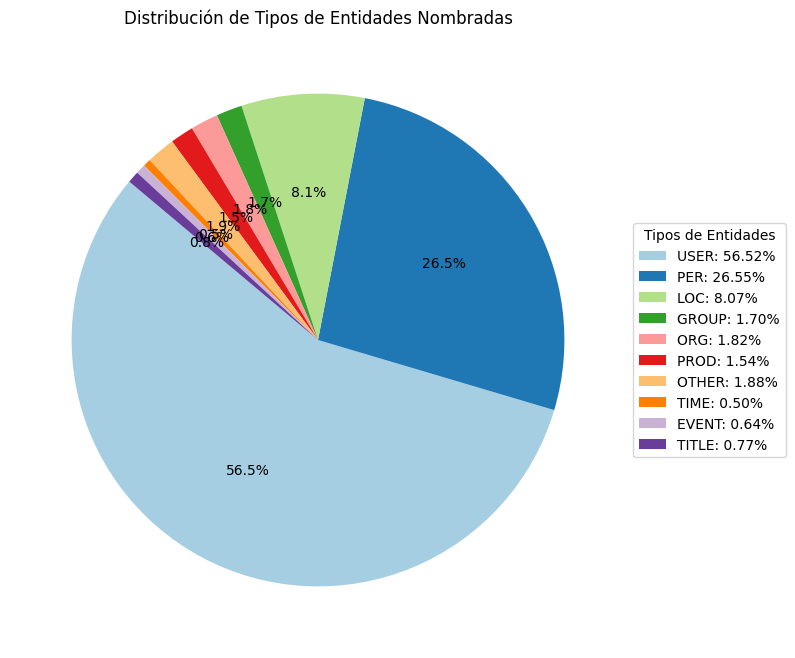

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_entity_type_percentages.values(), startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Entidades Nombradas")
legend_labels = [f"{ent_type}: {percentage:.2f}%" for ent_type, percentage in overall_entity_type_percentages.items()]
ax.legend(wedges, legend_labels, title="Tipos de Entidades", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

--------------------------------------------


-----------------------------------------------

### Tweets de misogynous

-----------------------------------------------


In [21]:
# NER en tweets misogynous
text_misogynous = [text for text in df_misocorpus_train[df_misocorpus_train["label"] == 1]["tweet"].tolist()]
results_ner_misogynous = [analyze_named_entities(text) for text in tqdm(text_misogynous)]

  0%|          | 4/2237 [00:00<02:26, 15.25it/s]

Texto analizado: @twominbae cállate puta
Entidades encontradas: [('@twominbae', 'USER')]
Texto analizado: @Josumovic Puta Greta
Entidades encontradas: [('@josumovic', 'USER'), ('greta', 'PER')]
Texto analizado: @monasterioR @julia_otero Eres patética
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @GretaThunberg Loca del coño
Entidades encontradas: [('@gretathunberg', 'USER')]


  1%|          | 14/2237 [00:00<01:00, 36.86it/s]

Texto analizado: @GretaThunberg cerda
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @outmarina Cállate puta de mierda
Entidades encontradas: [('@outmarina', 'USER')]
Texto analizado: @Valeryth_ Callate puta que te dejo en visto
Entidades encontradas: [('@valeryth', 'USER')]
Texto analizado: @LaFallaras Deja el alcohol cerda
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AdaColau HIJA DE PUTA
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @Cannabianol Greta puta
Entidades encontradas: [('@cannabianol', 'USER'), ('greta', 'PER')]
Texto analizado: Ojalá las feminazis no me den palo por subir este video ??????????? #dolar http://t.co/
Entidades encontradas: []
Texto analizado: feminismo=igualdad de hombres y mujeres. feminazi=mujeres que se creen superiores a los hombres. a ver si algún día entienden
Entidades encontradas: []
Texto analizado: @drummniatico No se vaya asustar! Ese es el gremio de feminazis... el cuartel de las feas

  1%|          | 21/2237 [00:00<00:48, 45.36it/s]

Texto analizado: Las feminazis del siglo XXI. Cualquier pendejada les parece una ofensa terrible: http://t.co/
Entidades encontradas: []
Texto analizado: @VauquitaS Me ha pasado lo mismo. Lo sigo haciendo y seguiré, es mi manera de saber si es una MUJER o una feminazi resentida.
Entidades encontradas: [('@vauquitas', 'USER')]
Texto analizado: Esas feminazis son más intensas que los testigos de Jehová http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @populares @CiudadanosCs Loca que eres una puñetera loca, sin ser NADIE, tienes que hablar de personajes reconocidos para intentar ser ALGUIEN. PATÉTICA
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @LaFallaras @TeruelExiste_ Allí te puedes emborrachas loca alcohólica
Entidades encontradas: [('@lafallaras', 'USER'), ('@teruelexiste', 'USER')]
Texto analizado: Ni porque sea feminazi la hdsptm http://t.co/
Entidades encontradas: []
Texto analizado: @LaFal

  1%|▏         | 31/2237 [00:00<01:01, 35.71it/s]

Texto analizado: @negromangueraa @Ironmanmark851 Los vídeos de las feminazis en pelotas algo ladillisimoooo
Entidades encontradas: [('@negromangueraa', 'USER'), ('@ironmanmark851', 'USER')]
Texto analizado: @eluniversocom Quien es capaz de piropiar a las feminazis. Eso si es ser puerco. Además en la hinchada barcelonista también hay mujeres. Estas feminazis son ridículas, ahora generalizando a la hinchada de un club deportivo.
Entidades encontradas: [('@eluniversocom', 'USER')]
Texto analizado: #FEMINAZIS unidas con propósitos #PROMUERTE trabajando para PLANNED PARENTHOOD #GeorgeSoros #ippf #ONU #CIDH http://t.co/
Entidades encontradas: [('georgesoros', 'GROUP'), ('ippf', 'ORG'), ('onu', 'ORG'), ('cidh', 'ORG')]
Texto analizado: @vanesavallejo3 Esas feminazis, solo tienen y destilan odio, eso es una doctrina de mierda, le carbonizan el cerebro!.
Entidades encontradas: [('@vanesavallejo3', 'USER')]
Texto analizado: @LaFallaras @CristinaSegui_ @alfonso_ussia @bertrandmyd @publico_es Ahí 

  2%|▏         | 36/2237 [00:01<01:01, 35.80it/s]

Texto analizado: @LaFallaras @populares @CiudadanosCs Deja la botella loca del coño...
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @VaneOblitas1 @MilagrosLeivaG Atea y feminazi, ya para que responderle la bestialidad que escribe...
Entidades encontradas: [('@vaneoblitas1', 'USER'), ('@milagrosleivag', 'USER')]
Texto analizado: Serán muy feminazis pero bien que arbolitos, regalos para las crías, odian el consumismo pero la foto pal face con ropita nueva y toda la cosa ? http://t.co/
Entidades encontradas: []
Texto analizado: @aracelidiputada @feminisciencia @fraoneto @MujeresSanas @CeltiusAbogados Y vos sos una feminazi mal cogida que quiere matar bebes porque no quiere que otras mujeres sean madres, mucha sororidad pero las verdes como vos le desean la muerte a las pañuelos celestes
Entidades encontradas: [('@aracelidiputada', 'USER'), ('@feminisciencia', 'USER'), ('@fraoneto', 'USER'), ('@mujeressanas', 'USER'), 

  2%|▏         | 49/2237 [00:01<00:46, 46.57it/s]

Texto analizado: @fightforkarol GRETA ES UNA PENDEJA
Entidades encontradas: [('@fightforkarol', 'USER'), ('greta', 'PER')]
Texto analizado: @Fercgas ?????remera para volver locas (más de lo que estan) a las feminazis
Entidades encontradas: [('@fercgas', 'USER')]
Texto analizado: Bueno. En mi sana, pero discutible opinión, se fue de las manos, y esto ya no es feminismo. 1️⃣ Esto es = propaganda feminazi 2️⃣ Como hombre-feminista, considero q así no se lucha 3️⃣ A los fans años nos ha gustado SW, conociendo de féminas guerridas y ya 4️⃣ Esto aumentaría el odio http://t.co/
Entidades encontradas: []
Texto analizado: Maldito el día en el que se crearon estas 3 nuevas RAZAS: - Ñengozos. - Feminazis. - Maricones. (Cobardes que abusan y enfrentan a una mujer) Que mundo de mierda en el que estamos viviendo. Hasta mañana "princesos" y "preciosas".✌ http://t.co/
Entidades encontradas: []
Texto analizado: Para todas ustedes feminazis ridículas hijas de puta. pendejas ! http://t.co/
Entidades enco

  3%|▎         | 61/2237 [00:01<00:42, 51.53it/s]

Texto analizado: @SinEmbargoMX greta la loca
Entidades encontradas: [('@sinembargomx', 'USER'), ('greta', 'PER')]
Texto analizado: @politikcorrecta @olinguiito Esta niña suena a marioneta feminazi con grabación incluida ?‍♀️
Entidades encontradas: [('@politikcorrecta', 'USER'), ('@olinguiito', 'USER')]
Texto analizado: @LaReinaDeNarnia Pero las feminazis ni un tweet para el extorsionandor de tweeter
Entidades encontradas: [('@lareinadenarnia', 'USER'), ('tweeter', 'PROD')]
Texto analizado: Qué tiro con las feminazis las matamos o qué???
Entidades encontradas: []
Texto analizado: HORROOOOOOR está casi calato con su gorro de policía y su diploma tapando su órgano genital. Ayyy y sus tetillas, quémenlo como a las feminazis que se quitan el brasier para protestar. #Sarcasm Pd. Doble moral everywhere http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @populares @CiudadanosCs Hola Sra. patética .. IGUALDAD ¿ sabe lo que significa esta palabra?? http://t.co/
Entidades encontr

  3%|▎         | 74/2237 [00:01<00:38, 56.87it/s]

Texto analizado: @kaguilar19 @diegovr29 @OscarUlloa88 Censurando las opiniones de los demás, pero después no quieren que les digan feminazis ?
Entidades encontradas: [('@kaguilar19', 'USER'), ('@diegovr29', 'USER'), ('@oscarulloa88', 'USER')]
Texto analizado: Soñe que me linchaban 1.000 feminazis jaja Lo hermoso fue haberlas hechos enojar??
Entidades encontradas: []
Texto analizado: @cayetanaAT Patetica.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: Asi fue como la niña se volvio feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @salartesoro No soy anti lgtb...no me molestan...ni me preocupan, son menos peligrosos que las extremistas feminazis y aborteras.
Entidades encontradas: [('@salartesoro', 'USER')]
Texto analizado: @nomadagt Y empieza de nuevo el lobby feminazi
Entidades encontradas: [('@nomadagt', 'USER')]
Texto analizado: @LaFallaras No, payasa, lo que te están diciendo que porque no te ofendes con todos por igual??? Solo defiendes el machism

  4%|▍         | 86/2237 [00:01<00:39, 54.85it/s]

Texto analizado: Después dicen los feminazis que el patriarcado no sirve. Un padre muere en el incendio cuando intento salvar a su hijos. http://t.co/
Entidades encontradas: []
Texto analizado: Hostia, no lo sabía. Que gustito me ha dado ver esto ???. Un bloqueo de feminazi al día evita la avería. http://t.co/
Entidades encontradas: []
Texto analizado: @xeanort99 Sí, y que la menor se invente lo que quiera para condenarles a 38 años de cárcel, todo ok también. http://t.co/
Entidades encontradas: [('@xeanort99', 'USER')]
Texto analizado: @Alvisepf Vamos, femilocas, que lo del #Arandina se queda corto con esto.
Entidades encontradas: [('@alvisepf', 'USER'), ('arandina', 'OTHER')]
Texto analizado: A todas las locas del color que no son capaces de ir hacer manifestaciones #Manresa en vez de presumir de #Feminismo, deberíais decir que lo único que queréis es #Comunismo. #Mira lo que dijo la psicóloga. + Los audios + ustedes = #DenunciaFalsa a leguas. http://t.co/
Entidades encontradas: []
T

  4%|▍         | 99/2237 [00:02<00:37, 56.90it/s]

Texto analizado: @carlosdanoz @vox_es El feminismo no es justicia. Y lo que ha ocurrido con la sentencia de arandina es feminismo.
Entidades encontradas: [('@carlosdanoz', 'USER'), ('@vox_es', 'USER'), ('arandina', 'LOC')]
Texto analizado: Quiero ver a aquellas feminazis que van casi empelotas en sus marchas, usando hiyab y totalmente sometidas. Muy lindo hablar y bailar, pero la realidad es otra y no veo a ninguna de ellas ayudando a las iraníes. http://t.co/
Entidades encontradas: [('iraníes', 'OTHER')]
Texto analizado: @Diameuwu1 CALLATE PUTA ???
Entidades encontradas: [('@diameuwu1', 'USER')]
Texto analizado: @ElTurnerCat Argentina esta contratando feminazis hablan cualquier mierda sin sentido solo tienen en cuenta que la mujer es igual que el hombre, no corrijo se creen más que el hombre; y luego andan cantando y la culpa no era mía y no se que mas monda. :D
Entidades encontradas: [('@elturnercat', 'USER'), ('argentina', 'LOC')]
Texto analizado: @xavogomez @mariapaularomo @DNI9063

  5%|▍         | 111/2237 [00:02<00:37, 57.33it/s]

Texto analizado: esto quieren en Ecuador las silvites #Feminazis http://t.co/
Entidades encontradas: [('ecuador', 'LOC')]
Texto analizado: Al parecer para las feminazis hay diferentes tipos de libertad de expresión. Según entiendo está la de ellas que es absoluta y la del resto que no piensa como ellas que no debería existir porque las ofende. http://t.co/
Entidades encontradas: []
Texto analizado: Ya es probable que tengas 18 @GretaThunberg ¿QUÉ ES ESTA MIERDA? VOY EN CAMISETA Y CHUPA DE CUERO POR LA CALLE, BITCH. EN PUTO FEBRERO. ¿PARA QUÉ TE PAGAN LOS QUE MANTENÍAN A ALBERT RIVERA, GOLFA? TU MENSAJE LE SUDA EL COÑO AL CLIMA, Y YO TE COMPRÉ LOTERÍA, PERRA.
Entidades encontradas: [('@gretathunberg', 'USER'), ('febrero', 'TIME'), ('albert rivera', 'PER')]
Texto analizado: @SoniaVivasRive3 @msikusimakusi Pues haz como las feminazis, ponte un lacito, denuncia al Rey y hazte súbdita del mayordomo del chalet del Vicepresidente de "Podemos". Rebadeu quines pardaleries.
Entidades encontradas

  5%|▌         | 123/2237 [00:02<00:41, 50.80it/s]

Texto analizado: Quieren imponer la jerga feminazi. Carmen Calvo insiste y la RAE aborda el lenguaje inclusivo en la Constitución http://t.co/
Entidades encontradas: [('carmen calvo', 'PER'), ('rae', 'ORG')]
Texto analizado: Mientras las feminazis juzgan Twitter hace su magia http://t.co/
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: @Vynylplayer LAS FEMINAZIS MANDAN A DECIR QUE LA AGRESORA ESTABA POSEÍDA POR UN MACHO.....???
Entidades encontradas: [('@vynylplayer', 'USER')]
Texto analizado: como te vas a comprar la remera de ansiedad de cazzu jajsak todos los problemitas boee re hater lavirgacha callate puta solo pensas en coger
Entidades encontradas: [('cazzu', 'PER')]
Texto analizado: @YehudGD Hasta que dejes de preguntar gilipolleces en Twitter. Venga a fregar coño.
Entidades encontradas: [('@yehudgd', 'USER'), ('twitter', 'PROD')]
Texto analizado: Volvemos a lo mismo... los seres humanos nos matamos... sin género... #Feminazis #shhh #preciosa http://t.co/
Entidades

  6%|▌         | 136/2237 [00:02<00:38, 54.90it/s]

Texto analizado: @silvitabuendia Jajajaja punto para las feminazis, pero esta “guerra” la va ganando la sensatez y de laaaaargo!
Entidades encontradas: [('@silvitabuendia', 'USER')]
Texto analizado: @LaFallaras Que te crees Marilyn Monroe puta gorda asquerosa
Entidades encontradas: [('@lafallaras', 'USER'), ('marilyn monroe', 'PER')]
Texto analizado: Si a las feministas tanto les molesta Twitter y hombres en general ¡Ellas son sumamente independientes son el alfa y omega de nuestra sociedad¡ pueden crear un red social "FEMINAZI" y así dejan de joder al resto q no compartimos su enfermo pensamiento lleno odio y resentimiento.
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: Feminazis ni que hijueputas.
Entidades encontradas: []
Texto analizado: @Flunitrazepam37 @reginaphalang8 @UninorteCO Feminazis en potencia. Esa carrera las vuelve así conozco muchas
Entidades encontradas: [('@flunitrazepam37', 'USER'), ('@reginaphalang8', 'USER'), ('@uninorteco', 'USER')]
Texto analizado

  7%|▋         | 148/2237 [00:03<00:40, 51.52it/s]

Texto analizado: QUE DICEN AHORA LAS FEMINAZIS. QUE POR SER MUJER NO ES CORRUPTA????? @CynthiaViteri6 @alcaldiagye http://t.co/
Entidades encontradas: [('@cynthiaviteri6', 'USER'), ('@alcaldiagye', 'USER')]
Texto analizado: @presidenciaperu @MartinVizcarraC @MimpPeru @pcmperu Esas asquerosas feminazis de m...da, ya llegaron al Perú con esa asquerosa moda del pañuelo verde.
Entidades encontradas: [('@presidenciaperu', 'USER'), ('@martinvizcarrac', 'USER'), ('@mimpperu', 'USER'), ('@pcmperu', 'USER'), ('perú', 'LOC')]
Texto analizado: @Isabelita123f Después no te estés quejando como las feminazis!
Entidades encontradas: [('@isabelita123f', 'USER')]
Texto analizado: @LaFallaras @ahorapodemos @iunida @publico_es Eso corre loca que se os acaba el chiringuito
Entidades encontradas: [('@lafallaras', 'USER'), ('@ahorapodemos', 'USER'), ('@iunida', 'USER'), ('@publico_es', 'USER')]
Texto analizado: @LaFallaras @populares @CiudadanosCs Eres una loca peligrosa, deberías estar internada y muy vigi

  7%|▋         | 154/2237 [00:03<00:41, 50.11it/s]

Texto analizado: @LaFallaras No me sorprende que el alcohol la haya hecho convertirse en borracha, toxicomana, puta, loca y ladrona Uf, se te va a ir la vida y la pasta en terapias
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Lo unico peor que una feminazi es otra feminazi progre y guatona.
Entidades encontradas: []
Texto analizado: @drummniatico Es que es amiguis de la mayor incitadora al odio...la mayor feminazi...silvita buenanoche!
Entidades encontradas: [('@drummniatico', 'USER'), ('silvita', 'PER')]
Texto analizado: @_SantinoBoy @pampitaoficial Es acoso por qué no le conoces y si le dices preciosa o hermosa es un delito .... así dirían ciertos cojudos o cojudas feminazis correasis ?
Entidades encontradas: [('@_santinoboy', 'USER'), ('@pampitaoficial', 'USER')]
Texto analizado: @pelaogalaz Feminazis loqueando
Entidades encontradas: [('@pelaogalaz', 'USER')]
Texto analizado: Bonito expresar una opinión sin ser ofendido por ¡#twitter, #Feminazis, #politicos, #23

  8%|▊         | 169/2237 [00:03<00:35, 57.96it/s]

Texto analizado: @LaFallaras @ContadorAltsasu 38 años de cárcel a los chavales del Arandina por las mentiras de una Lolita.
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('arandina', 'LOC')]
Texto analizado: @mariodaniel712 @_CarlieYo Las que son mamonas son las feminazis y las politiquillas. Cuando enseñan más el corazón y el día a día no se sienten superiores, son más relax y no andan con cosas. Por eso sigo a gente como @_CarlieYo, tienen los pies sobre la tierra, aunque a veces jueguen a qué no ?
Entidades encontradas: [('@mariodaniel712', 'USER'), ('@_carlieyo', 'USER'), ('@_carlieyo', 'USER')]
Texto analizado: @lafm Se van a enputar las feminazis
Entidades encontradas: [('@lafm', 'USER')]
Texto analizado: - La niña miente más que habla, pero a ella le dejamos ser testigo porque es inmadura. - ¿Vosotros sois idiotas? #InmadurasLerdasyJueces. @elconfidencial: http://t.co/
Entidades encontradas: [('@elconfidencial', 'USER')]
Texto analizado: @corbynb

  8%|▊         | 187/2237 [00:03<00:28, 72.62it/s]

Texto analizado: @HelenaTunon @annapratx Que frágil tenés que ser para volverte una feminazi resentida con todos los hombres por una mala experiencia
Entidades encontradas: [('@helenatunon', 'USER'), ('@annapratx', 'USER')]
Texto analizado: @pametroya @AndreaRivera_V Eres feminazi de mierda
Entidades encontradas: [('@pametroya', 'USER'), ('@andrearivera_v', 'USER')]
Texto analizado: @shittthing callate puta y chupa
Entidades encontradas: [('@shittthing', 'USER')]
Texto analizado: @carthografo Gestionado por INDRA ???. ¿Qué coño tendrán q votar los españoles sobre la voluntad de los catalanes a independizarse? ¿ Acaso tiene q votar toda la familia cuando un miembro de la pareja se quiere divorciar? Como antiguamente: ¡Ni separación ni ostias y ponte a fregar, mujer!
Entidades encontradas: [('@carthografo', 'USER'), ('indra', 'ORG')]
Texto analizado: @httpfranciscohe @FabianSanabriaS @ElJuliSastoque Jajajajaja se me vienen las féminazis?
Entidades encontradas: [('@httpfranciscohe', 'USER

  9%|▉         | 206/2237 [00:03<00:24, 81.40it/s]

Texto analizado: @NOmasCNE Si Madonna le pega un puñetazo a un hombre porque le jala el brazo esta bien porque es un acosador sexual. No importa cuando leas esto, siempre tendrás la culpa si eres hombre para los feminazi.
Entidades encontradas: [('@nomascne', 'USER'), ('madonna', 'PER')]
Texto analizado: Hazme un favor y vete a fregar http://t.co/
Entidades encontradas: []
Texto analizado: @Rominawi O sea,mancillan el cuerpo femenino cómo si fuera lo más importante. Definitivamente no tienen cerebro Qué vergüenza de Feminazis Pena ajena,no saben sino hacer show depravados
Entidades encontradas: [('@rominawi', 'USER')]
Texto analizado: @biengigante @eI1ne Exacto, pero ponerla de ejemplo de feminista para nada. Es todo lo contrario. Una mujer que se dejaba humillar y maltratar por un tipo que se creía una divinidad. Es todo lo contrario a una feminista, pero las ignorantes feminazis la adoran.
Entidades encontradas: [('@biengigante', 'USER'), ('@ei1ne', 'USER')]
Texto analizado: @feelzsa

 10%|█         | 225/2237 [00:04<00:23, 84.74it/s]

Texto analizado: @BatGirl_2019 ESTA BIEN, PORQUE LA GRETA ES UN PICHÓN DE FEMINAZI , CON TODO LO QUE SIGNIFICA
Entidades encontradas: [('@batgirl_2019', 'USER'), ('greta', 'PER')]
Texto analizado: @CaudiaAngelica @hurgamemoriaPE @Solidaridad_PSN Lo que sale al aire es el engaño, el descaro, el caradurismo de un vago mantenido, un admirador de terrucos y un banda de feminazis y trolls de género. A no dejarse engañar por estos vendedores de sebo de culebra, a decirle no al partido morado, por embaucadores.
Entidades encontradas: [('@caudiaangelica', 'USER'), ('@hurgamemoriape', 'USER'), ('@solidaridad_psn', 'USER'), ('morado', 'GROUP')]
Texto analizado: @LColoradilla @Sarita_Mont @prensacom No pierda el tiempo con una feminazi, amigo, esa gente no sabe lo que es razonar.
Entidades encontradas: [('@lcoloradilla', 'USER'), ('@sarita_mont', 'USER'), ('@prensacom', 'USER')]
Texto analizado: Cuando me arroban para tirarle a una feminazi. http://t.co/
Entidades encontradas: []
Texto analizado:

 11%|█         | 244/2237 [00:04<00:22, 89.11it/s]

Texto analizado: @ildalucero @infobae Estamos hablando de estas "cosas" que piensan que los gallos violan a las gallinas y dan este tipo deplorable de espectáculo. Entiendo el reclamo pero vamos de un extremo machista al otro feminazi Ambos 100% agresivos para con el otro. Asco producen.
Entidades encontradas: [('@ildalucero', 'USER'), ('@infobae', 'USER')]
Texto analizado: No les parece gracioso q hace unos dias las mujeres estaban unidas las pro-mujer las feminazis, todas unidas, el violador eres tu, hoy se leen comentarios horrorosos racistas y clasistas departe de MUJERES en especial, las que fueron a la marcha feminazi espero no esten citicando
Entidades encontradas: []
Texto analizado: @dalia_pichel @nats_vega Ustedes las feminazis por norma y por estilo de vida demuestran su odio a los hombres, ya ni lo disimulan, no es la primera vez q tratan de hacerse las graciosas esparciendo su odio contra los hombres. No parecen q hayan venido de un hombre.
Entidades encontradas: [('@dalia

 12%|█▏        | 262/2237 [00:04<00:22, 88.23it/s]

Texto analizado: @Yarelis36210579 @jguaido Cállate puta defiendes lo indefendible ese cabron nos entrego y gente decerebrada como tú igual lo apoya pendeja, anda y le lo coges pero asegúrate que te lleve a dominicana o a Oslo y barbados en el próximo diálogo mmgva
Entidades encontradas: [('@yarelis36210579', 'USER'), ('@jguaido', 'USER'), ('dominicana', 'LOC'), ('oslo', 'LOC'), ('barbados', 'LOC')]
Texto analizado: @DioCinicoXXX JAJAJAJJAJAJJAJAJA BRUJA FEMINAZI JAJAJJAJAJAJA Me encanta.
Entidades encontradas: [('@diocinicoxxx', 'USER')]
Texto analizado: @Larrydimick @javifrance @davidsantosvlog No pierdas el tiempo con esta fanática. O es una nofollada fracasada o tendrá algún trauma de que el padrastro o el tio le hizo algo inapropiado y ahora culpa a todos los hombres. Yo soy de la opinión de que algunas de estas feminazis fueron abusadas y traumatizadas de verdad.
Entidades encontradas: [('@larrydimick', 'USER'), ('@javifrance', 'USER'), ('@davidsantosvlog', 'USER')]
Texto analizad

 13%|█▎        | 281/2237 [00:04<00:22, 87.43it/s]

Texto analizado: Ay no te la puedo aguante mi prima la feminazi y el amigue invisible navideño http://t.co/
Entidades encontradas: []
Texto analizado: Hoy escuché a una feminazi decir q si te ofende que te digan "violador" es pq tu personalidad está en construccion .. ?Me encantan cuando te dicen como debes pensar sin usar tu inteligencia? http://t.co/
Entidades encontradas: []
Texto analizado: @elcomercio_peru Y ahora que dirán las féminazis se quedaron sin caballito de batalla!!!
Entidades encontradas: [('@elcomercio_peru', 'USER')]
Texto analizado: Video gráfico de como se deben tratar a las feminazi violentistas #Peru #Chile #Argentina #FemiNazis http://t.co/
Entidades encontradas: [('peru', 'LOC'), ('chile', 'LOC'), ('argentina', 'LOC')]
Texto analizado: @LaFallaras Tu lo que eres una loca histérica, sin ofender a los locos.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Ay las feminazis si fuera al revés... http://t.co/
Entidades encontradas: []
Texto analizado

 13%|█▎        | 300/2237 [00:04<00:21, 88.80it/s]

Texto analizado: @LaFallaras @iunida @ahorapodemos @perecampscampos Estupida
Entidades encontradas: [('@lafallaras', 'USER'), ('@iunida', 'USER'), ('@ahorapodemos', 'USER'), ('@perecampscampos', 'USER')]
Texto analizado: @MarthaCeciliaVL @FlavioArosemena El problema de las feminazis es que no se hacen responsables de sus actos. Solo se hace. Las víctimas y culpan de todo al hombre. Una dama de verdad no se toma esas fotos
Entidades encontradas: [('@marthaceciliavl', 'USER'), ('@flavioarosemena', 'USER')]
Texto analizado: @monasterioR @Alipese1 No se puede ser más cerda que tú ni tampoco más ladrona firmando lo que no podías firmar EXTRANJERA
Entidades encontradas: [('@monasterior', 'USER'), ('@alipese1', 'USER')]
Texto analizado: @Ivaeel Y no viste como les dí como bombo en fiesta a las feminazis ????
Entidades encontradas: [('@ivaeel', 'USER')]
Texto analizado: @MagalyTvLaFirme @atvpe mantenida de mierda.... en su caso las feminazis que dirán..?? igualdad de genero jaajaj chistosa
Ent

 14%|█▍        | 320/2237 [00:05<00:21, 90.12it/s]

Texto analizado: @Kassand77168408 @ilyvllgs @Mfmorenobel Miente, puro razonamiento de idiotas, existe claramente desde que se empieza a formar, es algo que se nota claramente #Feminazi
Entidades encontradas: [('@kassand77168408', 'USER'), ('@ilyvllgs', 'USER'), ('@mfmorenobel', 'USER')]
Texto analizado: @LaFallaras Loca, ladrona, putta, feminista, de izquierdas, toxicómana, hater, anlfabeta... verdaderamente encarna todos los valores de la izquierda como quizás solo los encarnó La Pasionaria.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @gildatrkovic El silencio cómplice de las feminazis.
Entidades encontradas: [('@gildatrkovic', 'USER')]
Texto analizado: @CNNEE Ja luego vio toda la puta lana que se puede mamar haciéndole al pendejo con un activismo estúpido como el que hace la idiota de su hija @GretaThunberg y fué ahí donde decidió ayudarla!!!!!!
Entidades encontradas: [('@cnnee', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @nissulo26 @reygorila26 Javi,

 15%|█▌        | 340/2237 [00:05<00:20, 91.61it/s]

Texto analizado: @elhigadodmarita Basta ver su simbolito verde y morado para saber que es una core feminazi. WTF
Entidades encontradas: [('@elhigadodmarita', 'USER')]
Texto analizado: Le cogi fastidio a las feminazis, sorryyy
Entidades encontradas: []
Texto analizado: @feminista48 @EIHuevoNeraId @luminecter @emilioer @silviacarce @gatosentado @DrProChoice @ColdasiceV @ElianaCabrera9 @Vynylplayer @Thortur1 @santhros @fjsv1974 @DocLuis_Litardo @CriticalExtremo @AndrParamore @altamirano_maxi @JulietaSagnay @FlorYCafe1 @Astrea1014 @Geovyj @DrBanner50 @piipoo7 @lizbetlunar @CorteConstEcu @ippf @DejemosM @DURANFUERZA @YoSoyDiamante12 @yamnef @Lorenaegas1 @MajoMancino @lopervar Hijita NO hijita matar o asesinar no es mi estilo de vida ni satisfacción . Las feminazis sienten alegria y satisfacción al decirlo y pensar establecerlo . Es normal conducta psicopatía de su secta
Entidades encontradas: [('@feminista48', 'USER'), ('@eihuevoneraid', 'USER'), ('@luminecter', 'USER'), ('@emilioer', 'USER

 16%|█▌        | 359/2237 [00:05<00:21, 87.42it/s]

Texto analizado: Esto no vende. La dictadura #feminazi si. #stopfeminazis http://t.co/
Entidades encontradas: []
Texto analizado: @mfigueres Entonces si se puede insultar a Zozulya, podemos llamarte puta a ti y mandarte a fregar, ¿no? Porque digo yo que si de censurar la violencia verbal se trata, o toda o ninguna.
Entidades encontradas: [('@mfigueres', 'USER'), ('zozulya', 'PER')]
Texto analizado: @cayetanaAT @GPPopular @populares Anda, callate payasa
Entidades encontradas: [('@cayetanaat', 'USER'), ('@gppopular', 'USER'), ('@populares', 'USER')]
Texto analizado: "Viva el patriarcado" "vuelve a la cocina" "feminazi :v" "el patriarcado ni se inmuta" "hazme un sandwich :vv" http://t.co/
Entidades encontradas: []
Texto analizado: Greta cabrona que tenes madera atrás. ¿Cuantos árboles se cortaron para hacer eso? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @jsanchezcristo Ahora las femilocas y feminazis, con que van a salir?!
Entidades encontradas: [('@jsanchezc

 17%|█▋        | 379/2237 [00:05<00:20, 90.74it/s]

Texto analizado: @PanAmPost_es ???? No soy boliviana pero siento que esta mujer sí me representa, no las feminazis que andan por ahí mostrando sus partes íntimas, con pañuelo verde, haciendo espectáculos rídículos para llamar la atención desde Chile hasta Colombia
Entidades encontradas: [('@panampost_es', 'USER'), ('boliviana', 'OTHER'), ('chile', 'LOC'), ('colombia', 'LOC')]
Texto analizado: @InesArrimadas @carrizosacarlos @CiudadanosCs Yo creo que tienes futuro ... siendo lo payasa qué eres y los bufones qué te siguen ¡ EL CIRCO YA LO TIENES MONTADO CON 10 ACTORES DE RENOMBRE !!! ??? ¡ VIVA LOS QUE VENÍAN A REGENERAR LA POLÍTICA ?????? MENUDOS FASTASNAS ESTÁIS HECHOS !!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@carrizosacarlos', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @Dator33 @realjuca @PoliciaEcuador Se imagina un "encuentro" entre Jorgito y una Feminazi? Eso tendría un final épico!
Entidades encontradas: [('@dator33', 'USER'), ('@realjuca', 'USER'), ('@p

 17%|█▋        | 389/2237 [00:05<00:20, 89.94it/s]

Texto analizado: @IrantzuVarela Le sigues comiendo la polla a los HIJOS DE PUTA asesinos a los que loáis!!!! Porque eso bo es Boikot....es Mamada!!! ?#TLHA2M
Entidades encontradas: [('@irantzuvarela', 'USER')]
Texto analizado: @Maria84974375 @Cristina_H_ Las personas objetivas definimos a un colectivo por sus actos e historial. Las personas tristes y calumniadoras acusan falsamente de delitos a otras personas. Esas son las feminazis.
Entidades encontradas: [('@maria84974375', 'USER'), ('@cristina_h', 'USER')]
Texto analizado: Este horrible hecho no deja de ser aprovechado por personas inescrupulosas llamadas comúnmente "feminazis". Siempre usan personas, sucesos y lo modifican a su antojo pero hoy les quedó mal y fue muy notoria su falta de escrúpulos y manipulación. Ojalá exista justicia esta vez http://t.co/
Entidades encontradas: []
Texto analizado: @jorgewireless @ricval2 Las pendejadas que hacen para ganar votos. Estos políticos son u a miseria. se allanan al teatro creado por fem

 18%|█▊        | 409/2237 [00:06<00:20, 90.67it/s]

Texto analizado: @LaFallaras Y tu tb te jartas a almejas pero podridas pedazo de cerda.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @CamiBelenLagos @Sofi_ter @Bell_2803 @LaSiglo21 Y que sanción le damos a las feminazis que vandalizar y destruyen propiedades??
Entidades encontradas: [('@camibelenlagos', 'USER'), ('@sofi_ter', 'USER'), ('@bell_2803', 'USER'), ('@lasiglo21', 'USER')]
Texto analizado: @LaFallaras Estas puta enferma de la cabeza... miratelo y habla con un profesional por que estas un poco loca
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Seguirás siendo una zorra, por mucho que vayas de intelectual. Que triste que quieras hacer política a base de intentar ofender a alguien inofensivo. Que asco que exista gente tan ruin y mezquina como tú. Esta claro el tipo de sociedad que defiendes... Eres patética.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Yo pidiéndole a mí hija feminazi que ayude con las cosa

 19%|█▉        | 429/2237 [00:06<00:19, 92.83it/s]

Texto analizado: http://t.co/ Dejen de joderlo a Darthés!!! @darthesjuan1 SOMOS MILLONES LOS/AS QUE TE BANCAMOS! PRIMERA VÍCTIMA DE UNA OPERETA BERRETA DE LAS FEMINAZIS! TE BANCAMOS! NO BAJES LOS BRAZOS!!!!!!
Entidades encontradas: [('darthés', 'PER'), ('@darthesjuan1', 'USER')]
Texto analizado: @LaFallaras @PeioHR lo que tu no haces porque no hay un ser humano que te meta la polla en ese cuerpo escombro de mierda que tienes......payasa!!!!! http://t.co/
Entidades encontradas: [('@lafallaras', 'USER'), ('@peiohr', 'USER')]
Texto analizado: Entrar a Twitter y ver todo el show de las feminazis por el piropo del policia? cada vez este mundo está peor, que miedo dan estas mujeres, ahora cualquier estupida se aprovecha de su condición de genero ?
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: @LaFallaras Quien te ha dicho a ti que no puedan comer lo que les dé la gana o es que tu por ser progre solo comes sopa de ajo y chorizo. Patetica... solo espero que no te hayas llevado 

 20%|██        | 449/2237 [00:06<00:18, 94.11it/s]

Texto analizado: @LaFallaras Eres patética, deja el alcohol y evítanos tus deliriums tremens.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @populares @CiudadanosCs Eres una p... loca.
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @AdaColau Y los 5 moros del otro día en nou Barris, pedazo de zorra??? Te la sopla la víctima??? Pedazo de zorra!!!! Sigue blanqueando y siendo cómplice.... Pedazo de zorra!!!!!
Entidades encontradas: [('@adacolau', 'USER'), ('nou barris', 'LOC')]
Texto analizado: @CristinaPaezEc @marzelavila @silvitabuendia @Expresoec El error será usted misma, no el diario, feminazi...
Entidades encontradas: [('@cristinapaezec', 'USER'), ('@marzelavila', 'USER'), ('@silvitabuendia', 'USER'), ('@expresoec', 'USER')]
Texto analizado: @LaFallaras @miquinta1 Te han pillado, puta loca. Vete a darte cabezazos contra la pared
Entidades encontradas: [('@lafallaras', 'USER'), ('@mi

 21%|██        | 469/2237 [00:06<00:19, 91.46it/s]

Texto analizado: @LaFallaras No habrá querido decir zorra?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Ando un poco perdido. Cuando te refieres a la adolescente violada te refieres a la golfa esa de la que hablan en las redes?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: No se dice feministas se dice Feminazis http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras @ahorapodemos @iunida @PSOE @Esquerra_ERC @compromis @SofCastanon @Adrilastra @Irene_Montero_ @abrazopartio @AAlvarezAlvarez @gabrielrufian @Pablo_Iglesias_ @agarzon La chivata de Fallaras está rabiosa por que nadie le hace caso, quiere su momento de gloria y pasan de ella como de la m***?, pobre infeliz ???? Puta Bida!!!!!!
Entidades encontradas: [('@lafallaras', 'USER'), ('@ahorapodemos', 'USER'), ('@iunida', 'USER'), ('@psoe', 'USER'), ('@esquerra_erc', 'USER'), ('@compromis', 'USER'), ('@sofcastanon', 'USER'), ('@adrilastra', 'USER'), ('@irene_montero', '

 22%|██▏       | 489/2237 [00:07<00:19, 91.02it/s]

Texto analizado: MACABRA “LÓGICA” PROGRE FEMINAZI: Están a favor del aborto porque “MATAR AL CONCEBIDO ES SU DERECHO” PERO MATAR a un toro es una CRUELDAD hasta protestan en las calles contra las corridas de toros, así son de DIABÓLICAS, INHUMANAS Y CRUELES estás enajenadas mentales, soy #ProVida http://t.co/
Entidades encontradas: []
Texto analizado: Si yo estoy haciendo mi trabajo y viene una "feminista" en una concentración y me daña mi instrumento de trabajo, además de echarme pintura en la cara solo les diré que después va a haber una féminazi menos.
Entidades encontradas: []
Texto analizado: @NuevaTec47 @rafaelhenrikez @VPrimero No hay que ser tan estricta. Al hombre se le asocia con la fuerza y a la mujer con la disuacion y me gustan esos roles aunque a veces yo misma me he catalogado de hombre por mi caracter. Tu comentario es el de una feminazi.
Entidades encontradas: [('@nuevatec47', 'USER'), ('@rafaelhenrikez', 'USER'), ('@vprimero', 'USER')]
Texto analizado: @sdaquino He de

 23%|██▎       | 509/2237 [00:07<00:18, 91.01it/s]

Texto analizado: @mouse_cl La oportunidad perfecta para las #Feministas #Feminazis #aborteras ya son feas torpes y verdes, no se tienen q aprender ningún guion simplemente actuar como siempre
Entidades encontradas: [('@mouse_cl', 'USER')]
Texto analizado: "Contra las feminazis" ¡Locuras a granel! Fenomenoide vs himno feminazi. @MgtowCualquiera http://t.co/
Entidades encontradas: [('@mgtowcualquiera', 'USER')]
Texto analizado: @CNNEE Es que no conoce a las feminazis
Entidades encontradas: [('@cnnee', 'USER')]
Texto analizado: hay tipos y tipas de cuidado en Twitter, muchos son trolls o feminazis que como no tienen léxico, van directo al insulto y a querer dañar y lo peor es que cada día aparecen más...
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: Según lógica feminazi, un hombre caballeroso puede ser tildado de acosador. Lo que buscan es que en un futuro la mujer no sepa que es la caballerosidad. http://t.co/
Entidades encontradas: []
Texto analizado: @Eltio_Concho @pul

 24%|██▎       | 529/2237 [00:07<00:18, 91.82it/s]

Texto analizado: Bueno, ya, al Blueprint... la compañera mia, que le digo "perro mojado" de cariño hoy no quiso venir... que se siente agotada mentalmente.. y yo KHE? mardita si usas el cerebro... la propia perro mojado.. y despues anda pidiendo igualdad porque es medio feminazi.. que lo mame!
Entidades encontradas: []
Texto analizado: @MadresAccionPe Definitivamente lo peor que puede sucederle a la sociedad es estar rodeada de algunas feminazis. Mejor bailemos el ritmo del año y burlémonos de esa recua http://t.co/
Entidades encontradas: [('@madresaccionpe', 'USER')]
Texto analizado: @GoberMansion @RossVzla29 Jajajajaja jajajajaja para lo que quedaron las Feminazis para la burlaaaaaaa...?
Entidades encontradas: [('@gobermansion', 'USER'), ('@rossvzla29', 'USER')]
Texto analizado: Dan miedo las #Feminazis
Entidades encontradas: []
Texto analizado: @El_Omicroniano @paurubiof Ya estas tortilleras feminazis rompe mucho los huevos
Entidades encontradas: [('@el_omicroniano', 'USER'), ('@pau

 24%|██▍       | 539/2237 [00:07<00:19, 85.47it/s]

Texto analizado: @OEMatias @Mr_Blonde77 @OsogordoIntenso Las mujeres normales si, las féminazis radicales son todas androginos sin culo sin tetas, sin alma...
Entidades encontradas: [('@oematias', 'USER'), ('@mr_blonde77', 'USER'), ('@osogordointenso', 'USER')]
Texto analizado: Feminazi, Asesina. El Abuelito Asesinado por una Feminazi... http://t.co/
Entidades encontradas: []
Texto analizado: @FalaciasProgres quieren igualdad las feminazis abortistas? pero castigan 1 boludo q se equivocó q tiene muy merecido el repudio social pero de ahí a sancionar se les fue la mano sólo para quedar bien con estúpidas d pañuelo verde q lo + suave q hacen es defecar en iglesias y mostrarse desnudas
Entidades encontradas: [('@falaciasprogres', 'USER')]
Texto analizado: A sido feminazi, con razón http://t.co/
Entidades encontradas: []
Texto analizado: El mejor meme anti-Feminazi que he visto. http://t.co/
Entidades encontradas: []
Texto analizado: @barbitarcic Imaginate, ya me ven como una feminazi jipi

 25%|██▍       | 558/2237 [00:07<00:20, 83.57it/s]

Texto analizado: @alonso_dm Pero a la mujer no con el pétalo ni que se enteren las feminazis le dirán el macho opresor y por que hay papá y no mamapa
Entidades encontradas: [('@alonso_dm', 'USER')]
Texto analizado: ?No es q vienen, llegaron, los tiempos difíciles, ya están aquí con todo y sus movimientos apocalipticos del cambio climático , el demencial y patético feminazi el adoctrinamiento de genero y otro tanto más que te atenazan, pero ojo! no cuestiones ,estarías agrediendo al mundo❗ http://t.co/
Entidades encontradas: []
Texto analizado: @Eichler71918287 @manemairif @elandrelo @politikcorrecta Así es,yo no tengo en problema en decirle sus verdades a estas feminazis hdp,pero me tienen bloqueado
Entidades encontradas: [('@eichler71918287', 'USER'), ('@manemairif', 'USER'), ('@elandrelo', 'USER'), ('@politikcorrecta', 'USER')]
Texto analizado: Las FemiNazi mexicanas llenas de odio e ira queman biblias y exigen al presidente que Dios sea borrado. Como en los días de la Nazi alemana d

 26%|██▌       | 576/2237 [00:08<00:19, 85.59it/s]

Texto analizado: @ElTurnerCat Soy auto-eficaz :D cuando tu novia te salga con tonterias de feminazi por usar tanto esta palabra (arriba el patriarcado)
Entidades encontradas: [('@elturnercat', 'USER')]
Texto analizado: Detesto la soutas feminazis de mierda que se ocultan en las comisarías de familia en las fiscalia en en los jueces de mierda la nueva guerra es feminazi contra los machos esa es la 2 guerra mundial. http://t.co/
Entidades encontradas: []
Texto analizado: @villagrankm @caathytorres @PoliciaEcuador Es en serio? Por un ‘preciosa’ arman tanto relajo? No se dan cuenta q apoyar eso es darles más gasolina a estas #feminazis disfrasadas de feministas? No joda! Una cosa es decir ‘preciosa’ y otra muy distinta faltar el respeto o decir una grosería! Basta ya de quejarse x todo!
Entidades encontradas: [('@villagrankm', 'USER'), ('@caathytorres', 'USER'), ('@policiaecuador', 'USER')]
Texto analizado: @juancasaenz1976 Esa feminazi de la Buendía es un aborto de la cordura
Entidades en

 27%|██▋       | 595/2237 [00:08<00:18, 88.28it/s]

Texto analizado: [ RT EN ESPAÑOL] Greta Thumberg se convierte en la persona más estúpida del mundo, superando al anterior poseedor del título, un tuitero que vende chacinados.
Entidades encontradas: [('español', 'OTHER'), ('greta thumberg', 'PER')]
Texto analizado: @GretaThunberg Anda a garchar pendeja de mierda
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Wowo que gracioso no veas contaminando ejejeje puta Greta http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @GretaThunberg @davidhogg111 Cayate pendeja
Entidades encontradas: [('@gretathunberg', 'USER'), ('@davidhogg111', 'USER')]
Texto analizado: Feminazi Venezolana causa furor en los comics.
Entidades encontradas: []
Texto analizado: greta hija puta devuélvenos la calefacción
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @blogcyh @wizagp @Alejandro_muba Solo miren la cara de esa cuatro ojos como lo miraba. Hay Feminazis, por que odian a los hombres?
Entidades encontradas: [

 27%|██▋       | 614/2237 [00:08<00:18, 89.75it/s]

Texto analizado: Patriarcado 1 feminazis 0 en ASTINAVE EP http://t.co/
Entidades encontradas: [('astinave', 'ORG')]
Texto analizado: Para estos carnavales amiga feminista o féminazi mejor larguese de PTY porque si no morirá de rabia por la canción de carnaval. XD
Entidades encontradas: [('carnavales', 'TIME'), ('pty', 'LOC')]
Texto analizado: ?Por un 2020 sin feminazis
Entidades encontradas: []
Texto analizado: @GretaThunberg Cállate la puta boca subnormal
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Su voz es como de una cuaima ligado con feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @quiquex61 @Silvio11914774 @24h_tve @GretaThunberg La histérica está haciendo que unos cuantos estén ganando BILLONES con el hoax del calentamiento global; que es cíclico, pero vende mucho. Al Gore estará disfrutando contando ceros en su cuenta Mejor haría ayudando a Swedishtan su país, que ya ha caído y difícilmente se levantará
Entidades encontradas: [('@quique

 28%|██▊       | 633/2237 [00:08<00:18, 89.06it/s]

Texto analizado: Greta: Majareta y farsante. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: ... Es lo que pasa por ser ECOLOGISTA... y procurar obtener ENERGÍA de fuentes LIMPIAS y RENOVABLES... ... Tal como era FRANCO... y no GRETA LA MAJARETA y sus fanáticos seguidores... http://t.co/
Entidades encontradas: [('franco', 'PER'), ('greta', 'PER'), ('majareta', 'PER')]
Texto analizado: @GretaThunberg Me puedes comer los webos x debajo payasa
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @lilialemoine @GretaThunberg Esta pendeja cara de pelotuda se los engrampó a todos
Entidades encontradas: [('@lilialemoine', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Habeis visto la peli de Ali G? Que lo contratan como mono de feria para representar al parlamento y manipularle y dirigir el cotarro todos los hijos de puta? Esa es la Greta, pero en este caso la niña se lo cree. Menos barquitos y atlánticos, y haz algo, pequeña mierda.
Entidades en

 29%|██▉       | 652/2237 [00:08<00:17, 89.14it/s]

Texto analizado: Gente riéndose a carcajadas con la burla de Netflix a los Cristianos, pero llorando cuando se burlan de la canción feminazi.
Entidades encontradas: [('netflix', 'ORG'), ('cristianos', 'OTHER')]
Texto analizado: Para esa època no era feminazi. xD http://t.co/
Entidades encontradas: []
Texto analizado: Hasta cuando @Lenin tenemos que soportar a esta inepta #FEMINAZI-Promuerte???? Ya Basta !!!! #FueraRomoFuera http://t.co/
Entidades encontradas: [('@lenin', 'USER')]
Texto analizado: Feminazi digan algo !!!. Atención que no me dirijo al distinguido Movimiento Feminista al cual respeto y admiro por su causa justa. Me dirijo a las que han destruido la naturaleza del Movimiento Feminista. http://t.co/
Entidades encontradas: []
Texto analizado: Cuidado, NO ES LO MISMO: Progreso?que Progresismo? Mujer?que Feminazi? Indio?que Indigenista? Pueblo?que Populismo? Cuidar el Medio Ambiente?que Ambientalismo? Cuidar a los Animales?que Veganismo? #SoyProVida
Entidades encontradas: [('i

 30%|██▉       | 671/2237 [00:09<00:17, 89.48it/s]

Texto analizado: ¿Cómo se les dice a las feminazis? http://t.co/
Entidades encontradas: []
Texto analizado: Por un 2020 con más féminas y menos feminazis. http://t.co/
Entidades encontradas: []
Texto analizado: @realjuca UNA SOLA PALABRA , FEMINAZI. de ahi x otro lado existen mujeres normales q actuan sin odio a los hombres q aceptan un halago o un piropo educado y sutil sin sentirse invadidas en su espacio y obviamente repudian las groserias y la mala educacion ,como tiene q ser
Entidades encontradas: [('@realjuca', 'USER')]
Texto analizado: @MartaMirantes @JuanCarlosAG87 @FonsiLoaiza Eres, podemita verdad? Igual a feminazi atontada
Entidades encontradas: [('@martamirantes', 'USER'), ('@juancarlosag87', 'USER'), ('@fonsiloaiza', 'USER')]
Texto analizado: @VinuezaCristin1 @seejaycuervo Benny Hill las feminazis estarían con ataque masivo
Entidades encontradas: [('@vinuezacristin1', 'USER'), ('@seejaycuervo', 'USER'), ('benny hill', 'PER')]
Texto analizado: Deberían reportarla spam y dar

 31%|███       | 690/2237 [00:09<00:17, 90.21it/s]

Texto analizado: Yo , desestresándome de tanta feminazi http://t.co/
Entidades encontradas: []
Texto analizado: Estoy siguiendo este caso de cerca, no pongo mis manos al fuego por nadie pero me da muy mala espina la presión que ejercieron las diputadas FemiNazi del MAS y las mentiras q se le descubrieron a la parte acusadora http://t.co/
Entidades encontradas: []
Texto analizado: Tristeza. Justo hoy, un día tan special p/ntras amadas, irremplazables y hermosas féminas, constato q la infame semilla del odio feminazi fué sembrada en Pmá. Recién tuve un desagradable intercambio c/ésta promotora del caos. Usa pseudónimo y esta es su inspiradora foto d perfil. http://t.co/
Entidades encontradas: [('pmá', 'LOC')]
Texto analizado: @EpicuroDeSamos_ @Lauraagomezc Ese es el nivel de argumentación de la feminazi pop. Igual se que está leyendo el hilo. J“querida” no todos somos buenos y no todos somos malos. Eso lo hace las decisiones que tomamos sin importar el género. Y @Marbelle30 con sus accio

 32%|███▏      | 710/2237 [00:09<00:16, 92.35it/s]

Texto analizado: Ya te enteraste que una feminazi mató a Solsiret, descuartizó y ocultó el cadáver dos años? http://t.co/
Entidades encontradas: [('solsiret', 'PER')]
Texto analizado: En la secta feminazi ya están haciendo sacrificios de onvres
Entidades encontradas: []
Texto analizado: Aquí Doña Rita hablando de violación de la democracia ¿Porqué esta”joven sin futuro”y”feminista de postal”,para disimular su desconocimiento de las normas municipales,trivializa el verbo violar. http://t.co/
Entidades encontradas: [('rita', 'PER')]
Texto analizado: @gene_llerena @RarityDiane Es feminazi? No pierdas el tiempo, no razonan, son obtusas ? me bloquearon por pensar diferente, sólo buscan adeptos que piensen igual sino no eres bienvenido ? http://t.co/
Entidades encontradas: [('@gene_llerena', 'USER'), ('@raritydiane', 'USER')]
Texto analizado: Nunca estaría con alguien feminista
Entidades encontradas: []
Texto analizado: Por suerte al feminismo extremo le queda poco, hay que aguantar unos 20 

 33%|███▎      | 730/2237 [00:09<00:16, 89.12it/s]

Texto analizado: Tiene razón. Si sos mujer policia, o provida por ejemplo o si una mujer hace una falsa denuncia y sale a luz ni el colectivo ni ninguna feminazi dicen algo. Ellas son sororas entre ellas y cuando les conviene http://t.co/
Entidades encontradas: []
Texto analizado: @raulrivas05 Como decían las abuelas, esas feminazis lo que son es unas sin oficio ni beneficio....
Entidades encontradas: [('@raulrivas05', 'USER')]
Texto analizado: @Singularidad_86 @marianalongo11 Seguro que no le debe costar mucho conseguir tal fin. Las feminazis parecen una parodia de la mujer.
Entidades encontradas: [('@singularidad_86', 'USER'), ('@marianalongo11', 'USER')]
Texto analizado: @iceldaperez Las feminazis se enojarán. Porque siembran arboles que es sl símbolo fálico del patriarcado y no siembran ostiones con galletitas? jajaja
Entidades encontradas: [('@iceldaperez', 'USER')]
Texto analizado: @isabelmarti Jajajajs psicóloga de pacotilla en contra de evidencias reales y objetivas. Oiga no no

 34%|███▎      | 750/2237 [00:09<00:16, 90.07it/s]

Texto analizado: segundo menosprecia a las amas de casa que no saben nada a comparación de ella que aprendió todo de la calle----&gt; el bailando. y encima después habla de cómo se coge a un tipo casado y encima se le caga de risa a la supuesta esposa como buena sorora feminista
Entidades encontradas: []
Texto analizado: @jbonR Qué es 99 mujeres entre 40000000 también hay más de 2000 mujeres asesinas de padres hijos abuelos 3000 hombres se quitan la vida al año en España y tú vienes a hablar de payasadas miserable feminista ponte al dia sinvergüenza qué vienes a hablar tú de payasadas bollera
Entidades encontradas: [('@jbonr', 'USER'), ('españa', 'LOC')]
Texto analizado: @lore00151923 Como dirian desde tu partido político: A FREGAR LORENA, A FREGAR?
Entidades encontradas: [('@lore00151923', 'USER'), ('lorena', 'PER')]
Texto analizado: @pllmclsr @M_artisa @mariodella @noticias24 Porque ver a la mujer de tachable y culpable no esta de moda en estos asuntos, cuando tiene toda la culpa. Al

 34%|███▍      | 760/2237 [00:10<00:16, 89.34it/s]

Texto analizado: @Barbiebarbz6 No se q me da mas pena ... Que aplaudas al personaje de una solterona q no peleo por quien amo o que supures odio al hombre. #FemiNazi
Entidades encontradas: [('@barbiebarbz6', 'USER')]
Texto analizado: @CalatoPerro Para las feminazis eso sería acoso y ya estarías purgando carcel
Entidades encontradas: [('@calatoperro', 'USER')]
Texto analizado: @celee61 Vos sos tan pelotuda como una feminazi, muy cheta para no cagás soretes con olor a fresas
Entidades encontradas: [('@celee61', 'USER')]
Texto analizado: La feminazi con novio. Vaya vaya!!
Entidades encontradas: []
Texto analizado: NOCHE DE REYES Dejaré mis zapatitos con una Carta como cada 5 de enero Solo voy a pedir que: Las feminazis no pretendan asesinarlos Los Nac y Pop no tiren las cartitas de sus hijos Alberto no les cobre 30% a juguetes importados Que los hijos de los zurdos les dejen pastito y agua http://t.co/
Entidades encontradas: [('noche de reyes', 'TIME'), ('enero', 'TIME'), ('alberto', 'PER

 35%|███▍      | 780/2237 [00:10<00:15, 91.54it/s]

Texto analizado: @LaLauraGuevara Bueh,eso es un punto de vista.En clases,suelo preguntarle a las feminazis si ellas conocen realmente la historia del feminismo y la mayoría ignora la suma los grandes éxitos de las mujeres a través de la historia. Ellas son feroces y hieren a los hombres sin razón. ¿Equidad,no?
Entidades encontradas: [('@lalauraguevara', 'USER')]
Texto analizado: @BscMiguelacho Tiene pinta de feminazi Nooo la estará violando ?
Entidades encontradas: [('@bscmiguelacho', 'USER')]
Texto analizado: @Soyunbottfake Amaneciste muy feminazi http://t.co/
Entidades encontradas: [('@soyunbottfake', 'USER')]
Texto analizado: @caroavalis ─yo banco a las mujeres femeninas no a las feminazis http://t.co/
Entidades encontradas: [('@caroavalis', 'USER')]
Texto analizado: así son las feminazis. http://t.co/
Entidades encontradas: []
Texto analizado: @mariapaularomo @PoliciaEcuador @caathytorres @MinGobiernoEc @ComunicacionEc Lo peor es que caen en el juego de estás feminazis http://t.co/

 36%|███▌      | 800/2237 [00:10<00:15, 91.27it/s]

Texto analizado: @CNNEE Jajajaja violacion ... típica feminazi
Entidades encontradas: [('@cnnee', 'USER')]
Texto analizado: #MasterChefEcuador que Diositos cuide a todos los hombres en caer en las garras de una mujer igual que Lorenza o más peor una feminazi
Entidades encontradas: [('masterchefecuador', 'PER'), ('lorenza', 'PER')]
Texto analizado: @linaorde No sabe kien es preciosa ? Si es la noticia feminazis del momento
Entidades encontradas: [('@linaorde', 'USER')]
Texto analizado: ¿Feminismo? No. Barbarie. Cultura feminazi; delincuentes que agreden a personas por su sexo. Violencia contra semejamtes que como toda violencia merece y debe ser condenada y castigada por ley, tenga su origen en un hombre o en una mujer. Eso es igualdad de genero. http://t.co/
Entidades encontradas: []
Texto analizado: @descriterio2 Sigan apoyando a las feminazis y progresistas... ?????? la putrefacta y fétida izquierda latinoamericana... con estas imágenes es que mojan sus pantys @petrogustavo y @Gustav

 37%|███▋      | 820/2237 [00:10<00:15, 92.77it/s]

Texto analizado: @sofiajkr @SebasEstiga00 @porquetendencia y no creo que una feminazi le de like a mi comentario
Entidades encontradas: [('@sofiajkr', 'USER'), ('@sebasestiga00', 'USER'), ('@porquetendencia', 'USER')]
Texto analizado: hasta cuando sr @sebastianpinera va a permitir esas agresiones si no tiene los pantalones para reprimir a esas feminazis renuncie, sr @Pontifex_es seguira en silencio,mire y escuche en chile a nuestra iglesia la estan vejando y ud no hace nada y si no puede o no quiere, renuncie http://t.co/
Entidades encontradas: [('@sebastianpinera', 'USER'), ('@pontifex_es', 'USER'), ('chile', 'LOC')]
Texto analizado: Así como vamos con las feministas y feminazis, la película "Un macho en el planeta de las mujeres" del caballo Rojas pareciera más bien una profecía. Es que escuchandolas, nos odian y no nos necesitan, linda la igualdad. ... ya llévame Diosito.
Entidades encontradas: [('caballo rojas', 'PER')]
Texto analizado: Se llama ABORTO Eso de "interrupción del emba

 38%|███▊      | 840/2237 [00:10<00:15, 89.35it/s]

Texto analizado: @tecovasosa Habla mal de un Comunista, una Feminazi o cualquier otro animal de la Fauna Izquierdoza, y te anularán la cuenta...!
Entidades encontradas: [('@tecovasosa', 'USER')]
Texto analizado: Que tipo de Feminazi resentida, maneja esta cuenta ??? http://t.co/
Entidades encontradas: []
Texto analizado: Os estáis riendo mucho con las feminazis locas del coñø y su bailecito... pero de esas 200 del vídeo, seguro que 50 acabaron en casa haciendo la cena, libre y voluntariamente y las otras 150 viven con sus padres y mamá les hizo la cena. Harto de tanta ? feminazi!!!
Entidades encontradas: []
Texto analizado: Señora eres lo mejor que sucedió en Bolivia, das asco la gran mayoría de Mujeres Bolivianas. Gracias a eso veo poco probable el movimiento Feminazi en Bolivia. Gracias!!!!!! #Bolivia #pititatwittera http://t.co/
Entidades encontradas: [('bolivia', 'LOC'), ('bolivianas', 'OTHER'), ('bolivia', 'LOC'), ('bolivia', 'LOC')]
Texto analizado: @05_anthony @PedroMCasals Las 

 38%|███▊      | 858/2237 [00:11<00:17, 78.11it/s]

Texto analizado: Este es el movimiento feminazi que no me representa! http://t.co/
Entidades encontradas: []
Texto analizado: @cristiancrespoj Asi terminan todas las feminazis, #OJOALDATO
Entidades encontradas: [('@cristiancrespoj', 'USER')]
Texto analizado: Que dicen las feminazis? No que toda mujer es buena y todo hombre es malo? Cc @Vynylplayer @ProfHoax__ @EmmitNx2 http://t.co/
Entidades encontradas: [('@vynylplayer', 'USER'), ('@profhoax', 'USER'), ('@emmitnx2', 'USER')]
Texto analizado: @Leiocampo Una flaca feminazi, que su TL es queja absolutamente de todo, y estuvo hablando de la foca, o sea no por defenderlo a el, sino porque en general ya es un exceso.
Entidades encontradas: [('@leiocampo', 'USER')]
Texto analizado: Como se iran a componer en la guerra... Sera que exigiran igualdad #GuerraMundial3 #Feminazis #patriacado #machoalfa #maestro_jedi #2020ConTodo http://t.co/
Entidades encontradas: []
Texto analizado: @ElianaCabrera9 @luminecter @Vynylplayer @JulietaSagnay @Coldasi

 39%|███▉      | 867/2237 [00:11<00:18, 74.44it/s]

Texto analizado: Feminazis en su máximo esplendor. http://t.co/
Entidades encontradas: []
Texto analizado: la violencia no tiene genero! Niña de 2 años fue asesinada a puñaladas en Cordova Argentina. La asesina sería su propia madre, quien también se causó heridas, ante la separación de su esposo que recientemente habría abandonado la casa de la pareja. Protestaran las Feminazis? No
Entidades encontradas: [('cordova argentina', 'LOC')]
Texto analizado: @tuesta Y si eres troll y quieres atacar al antifujimorismo será - hasta los 25 flaca feminazi - hasta los 40 feminazi a secas - después de los 40 tia feminazi.
Entidades encontradas: [('@tuesta', 'USER')]
Texto analizado: Hace tiempo que este gremio comunista da ASCO; en vez de preocuparse por elevar la calidad e infraestructura educativa, que está por los suelos... se preocupan por imponer esa ABOMINABLE ideología genero, por tan solo encubrir el asesinato que cometió la feminazi de Andrea. http://t.co/
Entidades encontradas: [('andrea

 39%|███▉      | 883/2237 [00:11<00:18, 72.72it/s]

Texto analizado: '@labrujaquevuela Ahí se convierte en la feminazi más letal del mercado boyacense.'
Entidades encontradas: [('@labrujaquevuela', 'USER'), ('boyacense', 'OTHER')]
Texto analizado: @josejimenezr6 Fastidiosas y las feminazis!
Entidades encontradas: [('@josejimenezr6', 'USER')]
Texto analizado: @barvak Cada día están más locas las feminazis.
Entidades encontradas: [('@barvak', 'USER')]
Texto analizado: @Daniescox @25Laconte No es novedad todas las feminazis son tortillera por eso odian tanto al varón.??
Entidades encontradas: [('@daniescox', 'USER'), ('@25laconte', 'USER')]
Texto analizado: @ladelmar_ @2000DeComapan Señora feminazi calmese
Entidades encontradas: [('@ladelmar', 'USER'), ('@2000decomapan', 'USER')]
Texto analizado: @crhoycom El fanatismo en esas personas es mas fuerte que el sentido común, no me cansare de repetiré que esas féminazis no representan a las mujeres y menos utilizando este día para justificar ese estúpido fanatismo que es mas toxico que el coron

 40%|████      | 899/2237 [00:11<00:19, 69.44it/s]

Texto analizado: 'Les vendría bien a unas cuantas feminazis ir al paraíso comunista, así siguen con la pintata, la destruccion de bienes publicos y privados por allá http://t.co/'
Entidades encontradas: []
Texto analizado: @MEMEOPERU Que buena noticia, las feminazis, pro-aborto y "empoderadas" se quedan sin representación en el Congreso... Dios hizo el milagro de cuidar a nuestros niños y adolescentes al no permitir gente que promueve ideologías aberrantes en el congreso #FueraCaviaresProgresDelPoder
Entidades encontradas: [('@memeoperu', 'USER')]
Texto analizado: @elpopular_pe Zafando cuerpo siempre. Que novedad. Apechuguen nomas feminazis.
Entidades encontradas: [('@elpopular_pe', 'USER')]
Texto analizado: No me representan locas #Feminazis #cuandoteconvienesi http://t.co/
Entidades encontradas: []
Texto analizado: @Daniel_McDean Esperemos que cierto grupito de feminazis como @NataliaDeLaV, no nos dañe la alegría de recordar viejos tiempos.
Entidades encontradas: [('@daniel_mcdean', 

 41%|████      | 913/2237 [00:12<00:20, 66.03it/s]

Texto analizado: @silvitabuendia JAJAJAJAJAJAJAJAJAJAJA los onvre cayeron en tu trampa feminazi Silvia
Entidades encontradas: [('@silvitabuendia', 'USER'), ('silvia', 'PER')]
Texto analizado: Yo por el grupo: h- Marta: Cállate puta
Entidades encontradas: [('marta', 'PER')]
Texto analizado: @EddyJacome Una simple jerga local, no es nada despectivo, noto un tono #Feminazi en tu Twitt..
Entidades encontradas: [('@eddyjacome', 'USER')]
Texto analizado: Frases para contrarrestarlas esas locas de pañoleta verde: -No es cuestión de machismo, es cuestión de educación. -Estoy a favor del feminismo, no de las feminazis. -¿ Cual tu proyecto de vida?. - Vas bailar todo dia en plaza pública como un pollo sin cabeza. - ¿Vas ir gimnasio? http://t.co/
Entidades encontradas: []
Texto analizado: @DafneHuilca Osea q fuiste producto de una violacion de tu padre hacia tu madre? Felizmente no existían las feminazis, sino, no hubieses nacido srta conjunto de células troll.
Entidades encontradas: [('@dafnehui

 41%|████▏     | 928/2237 [00:12<00:19, 67.86it/s]

Texto analizado: Amazonas: «feminazis» de la antigua Grecia http://t.co/ vía @khronoshistoria
Entidades encontradas: [('amazonas', 'LOC'), ('grecia', 'LOC'), ('@khronoshistoria', 'USER')]
Texto analizado: @JBCPERU Todo estos x los movimientos radicales de izquierda, unas tontas q denuncian a Peluchin escudándose con la cojudes de género, incluso una burra puede garantías para su vida, luego un gay hace una farsanacusacion d homfobia, una feminazi mata otra feminazi, ahora x este comentario
Entidades encontradas: [('@jbcperu', 'USER'), ('peluchin', 'PER')]
Texto analizado: '@AngelRCuba Señor @sebastianpinera es un deber ciudadano dejar a todas ésas feminazis allà en Varadero, que gocen el pago de sus servicios por haber destruído Chile,faltaba más, cucharaditas de su propia medicina y a bailar manííí ? bien alegres con ésos ratonetes,no se olviden del video!!!'
Entidades encontradas: [('@angelrcuba', 'USER'), ('@sebastianpinera', 'USER'), ('varadero', 'LOC'), ('chile', 'LOC')]
Texto ana

 42%|████▏     | 942/2237 [00:12<00:19, 67.81it/s]

Texto analizado: @El_Goordon @eve_caravallo Que tal mi hermano, Si te cojo coqueteándole a otro Ya verás que trompa' te voy a pegar Si te cojo guiñándole a otro Un piñazo en un ojo te voy a dar... Mira negra, y ponte a fregar Coje el trapo y ponte a limpiar Si yo llego y mi papa no esta Pau, pau, pau, te voy a dar...
Entidades encontradas: [('@el_goordon', 'USER'), ('@eve_caravallo', 'USER'), ('pau', 'PER'), ('pau', 'PER'), ('pau', 'PER')]
Texto analizado: CÁLLATE PUTA, ZORRA, BORRACHA, DROGADICTA http://t.co/
Entidades encontradas: []
Texto analizado: @Lukastar77 CÁLLATE PUTA MENTIROSA http://t.co/
Entidades encontradas: [('@lukastar77', 'USER')]
Texto analizado: @maIagradecida @Romantizarte ves? Ya cállate, puta
Entidades encontradas: [('@maiagradecida', 'USER'), ('@romantizarte', 'USER')]
Texto analizado: @kryspyta @java1088 @sextaNoticias Y lo dice la fiscalia general del estado nena,anda lee que veo que lo haces poco,que hace una mujer de VOX hablando aquí?a fregar! http://t.co/
E

 43%|████▎     | 956/2237 [00:12<00:19, 65.01it/s]

Texto analizado: @himmra Cállate puta que te dejo en visto??
Entidades encontradas: [('@himmra', 'USER')]
Texto analizado: @JeanineAnez @jguaido @AsambleaVE Cállate puta asesina, el único presidente de Bolivia es Evo no tu, ridula
Entidades encontradas: [('@jeanineanez', 'USER'), ('@jguaido', 'USER'), ('@asambleave', 'USER'), ('bolivia', 'LOC'), ('evo', 'PER')]
Texto analizado: OTRO PODEMITA PANIAGUADO, PONTE A FREGAR, MAMARRACHO. http://t.co/
Entidades encontradas: []
Texto analizado: @zukaritas__ callate puta el mio tienr gd y bts
Entidades encontradas: [('@zukaritas', 'USER'), ('gd', 'GROUP'), ('bts', 'GROUP')]
Texto analizado: Chicas, que si estudiáis psicología no valéis una puta mierda. Mejor a fregar o yo qué sé. http://t.co/
Entidades encontradas: []
Texto analizado: Mugres cucarachas se kieren pasar de listas y mamonas conmigo pero se ban a fregar los are tragarse sus palabras a todos juntos
Entidades encontradas: []
Texto analizado: @warkentin Cállate puta sin familia ni amig

 43%|████▎     | 963/2237 [00:12<00:20, 63.09it/s]

Texto analizado: @zaidacatalan Pendenjas y estúpidas...es de darle cachetadas...y como decía mi abuela que vayan a fregar platos y a barrer la casa...partida de vagas
Entidades encontradas: [('@zaidacatalan', 'USER')]
Texto analizado: ¿Pecaste climaticamente? No hay problema, el problema se arregla rezando cuarenta "Ave Greta que estás Majareta" y treinta "Greta Nuestra que estás en la ONU", oraciones de la moderna y progresista Iglesia Climática de los Ultimos Días de Santa Greta: http://t.co/
Entidades encontradas: [('ave greta', 'PER'), ('greta', 'PER'), ('onu', 'ORG'), ('santa greta', 'PER')]
Texto analizado: Unas ganas de tirarle una cebollita a la ventana de Greta y que le agarre un ataque epiléptico, zurda estúpida.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @CNNEE Greta es una estupida útil por los izquierdozos y verdosos....
Entidades encontradas: [('@cnnee', 'USER'), ('greta', 'PER')]
Texto analizado: Greta, a robar a tu puta casa. Localcoño. http://t.co/
Enti

 44%|████▎     | 977/2237 [00:13<00:21, 58.62it/s]

Texto analizado: @miliherrer callate puta estupida
Entidades encontradas: [('@miliherrer', 'USER')]
Texto analizado: @MrZoroald A ver a mi visualmente la verdad es que me gustan, pero que puto asco. Togekiss era aguantable hasta esta generacion, que ahora puede subirse la velocidad y la vida con su dinamax y pegarle flincheos a todo dios, anda a fregar hada psicotica
Entidades encontradas: [('@mrzoroald', 'USER'), ('togekiss', 'PER')]
Texto analizado: @gongalery Pues que el bizarro de su padre haga una consulta ciudadana, si se ponen pedos o se van a fregar a su progenitora todos los de la 4ta
Entidades encontradas: [('@gongalery', 'USER')]
Texto analizado: @DinoNuggetsJPG que pasa dino? Callate, puta.
Entidades encontradas: [('@dinonuggetsjpg', 'USER'), ('dino', 'PER')]
Texto analizado: @josechacon18 @lachicatoxicaa Y que la mande a fregar y barrer la casa tambien supongo??
Entidades encontradas: [('@josechacon18', 'USER'), ('@lachicatoxicaa', 'USER')]
Texto analizado: @ades7et7 Cálla

 44%|████▍     | 992/2237 [00:13<00:18, 65.89it/s]

Texto analizado: @la_patilla Esta Greta es una loca de Carretera
Entidades encontradas: [('@la_patilla', 'USER'), ('greta', 'PER')]
Texto analizado: @DanielValderrey Pues yo me he comprado 50 cápsulas de @nespressoES hoy. Que venga a por mí la Greta Majareta ?
Entidades encontradas: [('@danielvalderrey', 'USER'), ('@nespressoes', 'USER'), ('greta majareta', 'PER')]
Texto analizado: @LORENT_SALEH ya entendemos por qué tu llamas imbécil el presidente de los Estados Unidos @realDonaldTrump, y porque tu indignación cuando Trump le dice mocosa a GRETA, ? la niña BOBA manipulada por los liberales y la izquierda. ?? http://t.co/
Entidades encontradas: [('@lorent_saleh', 'USER'), ('estados', 'GROUP'), ('unidos', 'LOC'), ('@realdonaldtrump', 'USER'), ('trump', 'PER'), ('greta', 'PER'), ('liberales', 'GROUP')]
Texto analizado: @GretaThunberg duchate cerda
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @FrayJosepho Y Greta Majareta....Como lo verá?
Entidades encontradas: [('

 45%|████▌     | 1011/2237 [00:13<00:15, 78.50it/s]

Texto analizado: @SiberetSiberet Me imagino un día en casa de Bertrand a su hija de 15 años diciendo: "uff, cómo me pone Chris Hemsworth", y él contestándole: "Cállate puta, te van a acabar violando 3 tíos. A ver si así se te quita la tontería".
Entidades encontradas: [('@siberetsiberet', 'USER'), ('bertrand', 'PER'), ('chris hemsworth', 'PER')]
Texto analizado: @Uruguay70601217 Todo esto va al informativo dice... Anda a fregar mugrienta.
Entidades encontradas: [('@uruguay70601217', 'USER')]
Texto analizado: @closvr si callate puta
Entidades encontradas: [('@closvr', 'USER')]
Texto analizado: Me descojono ? todo esto para decir que algunos la tienen pequeña ... no eres seria mujer, anda vete un rato a fregar a ver si se te pasa la angustia ? http://t.co/
Entidades encontradas: []
Texto analizado: callate puta o te secuestro tu celular http://t.co/
Entidades encontradas: []
Texto analizado: @noyougirlss callate puta q te pwnsas q sigo siento tu pasiva? no mi amor areodillate y chupame l

 46%|████▌     | 1030/2237 [00:13<00:14, 85.55it/s]

Texto analizado: El por culo q están dando con la @GretaThunberg ( una puta cria q va dando lecciones de moral y es la primera q no hace nada ) , las palabras vuelan y se las lleva el viento . Ns como hay subnormales q se creen las cosas de esta payasa
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Yo creo que uno de mis mayores sueños en la vida es romperle su puta madre a Greta Thunberg.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Dique tóxica con 13 años. Ponte a fregar muchacha.
Entidades encontradas: []
Texto analizado: @rhapstyls callate puta después jugamos al truco y t rompo el culo
Entidades encontradas: [('@rhapstyls', 'USER')]
Texto analizado: no soporto a la puta Greta y sé que no tiene culpa de nada xq es un producto pero el enfoque lo pongo en ella y AAAA
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @NellyRosas67 @jo52170739 @JesusSeade @CarlosLoret Cállate puta infeliz
Entidades encontradas: [('@nellyrosas67', '

 47%|████▋     | 1049/2237 [00:13<00:13, 88.88it/s]

Texto analizado: @ExpresoPeru Miren los ojos de "GRETA THUNBERG" DE BELAUNDE !!! Una loca desorbitada!!!
Entidades encontradas: [('@expresoperu', 'USER'), ('greta thunberg', 'PER'), ('de belaunde', 'PER')]
Texto analizado: La revista TIME tenia que ver elegido a la persona del año a nuestro presidente Juan Guaidó y no a la mocosa de Greta Thunberg
Entidades encontradas: [('revista', 'ORG'), ('time', 'ORG'), ('juan guaidó', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @elhigadodmarita Cuánto te extrañeee....!!!...te dejo un dato que destruirá a esa niña tonta de Greta ...!!!.. http://t.co/
Entidades encontradas: [('@elhigadodmarita', 'USER'), ('greta', 'PER')]
Texto analizado: Dios es que que mal me cae la puta greta ostia vaya niña mas subnormal gorda gorda puta gorda
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Greta Thunberg: Un producto de marketing para gilipollas. Efectivamente, la pequeña revolucionaria del clima es un timo. Resulta que zarpa desde Virginia e

 48%|████▊     | 1067/2237 [00:14<00:13, 86.28it/s]

Texto analizado: Un oceano de distancia entre el joven Slat y la histérica Gr*t* Y "Este vídeo evidencia la manipulación política que se le ha dado al discurso de Greta Thunberg" on YouTube http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('youtube', 'PROD')]
Texto analizado: Hablan de la pelotuda de Greta (perdón no me la banco) y no de este chabón que es un genio, y desde los 16 viene desarrollando este proyecto excelente. Jate joder http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: La puta niña Greta Thunberg que vive del cambio climático no se podía ir a tomar por el culo?? E ir al colegio como todos los niños. No habría que mandar a la cárcel a sus padres? No se puede tener a una niñ@ sin escolarizar. Tiene derecho a aprender y no ser una analfabeta.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: No puedo creer que me voy a tener que fumar a la pelotuda de Greta thunberg en año nuevo
Entidades encontradas: [('greta thunberg

 49%|████▊     | 1087/2237 [00:14<00:12, 90.02it/s]

Texto analizado: Si es que sois gilipollas.... ala, agradecérselo a Greta y todos los lameculos de la COP25 http://t.co/
Entidades encontradas: [('greta', 'PER'), ('cop25', 'EVENT')]
Texto analizado: Ese es el problema de esta pelotuda: le caga la cabeza a otros chicos http://t.co/ - http://t.co/
Entidades encontradas: []
Texto analizado: @bbcmundo No me gusta Greta, se parece una loca y no me inspira confianza. Ella sobre actùa y se parece drogadicta. Hubieran puesto a una joven con rostro màs dulce y educada, no a una zombie amargada.
Entidades encontradas: [('@bbcmundo', 'USER'), ('greta', 'PER')]
Texto analizado: Respirar también contamina según Greta Thunberg me cago en su vida zorra http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @Lega_Fernando Lo que estoy diciendo que ese puesto de un ACTOR y un CANTANTE no sirve para nada frente a un CIENTÍFICO, y ahora no me saques a la puta Greta, que ha hecho más que estos dos.
Entidades encontradas: [('@leg

 49%|████▉     | 1107/2237 [00:14<00:12, 91.36it/s]

Texto analizado: @hm5651 @GretaThunberg Pero de verdad hay alguien que se crea que esa estupida tiene asperger??
Entidades encontradas: [('@hm5651', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @torradora con esa puta ni de coña @GretaThunberg maricona
Entidades encontradas: [('@torradora', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: tio me están entrando ganas de ahogar a Greta con una puta bolsa de plástico
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Manu_Litoo Puta Greta ajaja
Entidades encontradas: [('@manu_litoo', 'USER'), ('greta', 'PER')]
Texto analizado: @AgustinRosety y la estúpida de Greta será feliz!
Entidades encontradas: [('@agustinrosety', 'USER'), ('greta', 'PER')]
Texto analizado: La gula es un pecado y yo soy un pecador Greta majareta me la pone prieta #alfredgarcía 2019
Entidades encontradas: [('greta majareta', 'PER'), ('alfredgarcía', 'PER')]
Texto analizado: @GretaThunberg por payasa ??????????? http://t.co/
Entidades encontradas:

 50%|█████     | 1127/2237 [00:14<00:12, 91.98it/s]

Texto analizado: TOMA @GretaThunberg Y LA PUTA Q TE PARIO PENDEJA COMUNISTA DE MIERDA http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @pedroj20 GRETA TUS PADRES DEBERÍAN ESTAR EN LA CARCEL HIJA DE PUTA
Entidades encontradas: [('@pedroj20', 'USER'), ('greta', 'PER')]
Texto analizado: ¡Creo que Greta Thunberg es una niña histerica! Por momentos ella dice cosas bastante sensatas, pero ¿puede ser un poco menos histérica por todo? ¡Gracias de antemano! http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Esta además de loca es enrredadora Malo, malo http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: Que facil es hacer feliz a Greta la majareta ? http://t.co/
Entidades encontradas: [('greta la majareta', 'PER')]
Texto analizado: @LORENT_SALEH Eres um pendejo y la Greta otra pendeja ???
Entidades encontradas: [('@lorent_saleh', 'USER'), ('greta', 'PER')]
Texto analizado: @jdpe1608 @picachu129 Greta es una pendeja 

 51%|█████▏    | 1147/2237 [00:15<00:12, 88.20it/s]

Texto analizado: El cambio climático es consecuencia de la insistencia de la puta pesada de la Greta esta
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Pum @GretaThunberg En tu puta cara!! http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Greta Thunberg, ¿quieres hacer activismo de verdad? Ponte a trabajar, ponte unos guantes y empieza a limpiar bosques, playas y montañas. Mánchate las manos, so cerda, que desde debajo de una pancarta no se arregla el planeta. Claro, que da más dinero tener detrás a la Onu. ¡Vaga!
Entidades encontradas: [('greta thunberg', 'PER'), ('onu', 'ORG')]
Texto analizado: @OlgaAlie @EstacioSEDR @louloucruz @danteperezberen @_cavica_ @LatineEtGraece @pnique @Anarcofascista1 Y tú a fregar, mujer.
Entidades encontradas: [('@olgaalie', 'USER'), ('@estaciosedr', 'USER'), ('@louloucruz', 'USER'), ('@danteperezberen', 'USER'), ('@_cavica', 'USER'), ('@latineetgraece', 'USER'), ('@pnique', 'USER'), ('@anarcofascista1', 'USER

 52%|█████▏    | 1156/2237 [00:15<00:12, 85.21it/s]

Texto analizado: Greta tuitea sobre su viaje en "tren abarrotado"; empresa ferroviaria responde que lo hizo en primera clase http://t.co/ Esta muchachita boba, piensa que el mundo le rendira pletesia esta Loca esta mocosa FARSANTE
Entidades encontradas: [('greta', 'PER'), ('ferroviaria', 'ORG')]
Texto analizado: @NobotoGen Puta Greta, chicos fumen porros y tirad la colilla al bosque para que prenda fuego hectáreas.
Entidades encontradas: [('@nobotogen', 'USER'), ('greta', 'PER')]
Texto analizado: Volveré a publicar esto porque quiero que la gente sepa que Greta Thunberg no solo es una niña con antifa, sino que le gusta disparar. Me parece una agencia muy payasa. http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('antifa', 'GROUP')]
Texto analizado: @ldpsincomplejos @raqueltejero_ Qué se cuenta Greta Majareta?
Entidades encontradas: [('@ldpsincomplejos', 'USER'), ('@raqueltejero', 'USER'), ('greta majareta', 'PER')]
Texto analizado: Pendeja mentirosa! @GretaThunberg ? http

 53%|█████▎    | 1175/2237 [00:15<00:12, 87.71it/s]

Texto analizado: Greta majareta le ha cojido gusto al dinero y la fama está va a por un casoplon http://t.co/
Entidades encontradas: [('greta majareta', 'PER')]
Texto analizado: Le dije: te regalo mi corazón y la hija de puta lo tomó literal. *Ojo con los que se la pasan prometiendo bajar la luna que las consecuencias podrían ser catastróficas y Greta Thumberg se encabrona mal. http://t.co/
Entidades encontradas: [('greta thumberg', 'PER')]
Texto analizado: La niña rata tiene menos años que Greta Thunberg y parece de la edad de Carmen Sevilla. http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('carmen sevilla', 'PER')]
Texto analizado: @OsogordoIntenso @MaceWinduRIGHT @RussianVolga @NicoTorn1 Pero pondría de los pelos a la hija de puta de Greta
Entidades encontradas: [('@osogordointenso', 'USER'), ('@macewinduright', 'USER'), ('@russianvolga', 'USER'), ('@nicotorn1', 'USER'), ('greta', 'PER')]
Texto analizado: @ELTIEMPO Greta loca, la quiero ver en el polo norte en un bar

 53%|█████▎    | 1195/2237 [00:15<00:11, 89.99it/s]

Texto analizado: Que sorpresa esta pendeja sueca re culeada. Pero por algo digo Greta Trueno, ese no es su nombre :) http://t.co/
Entidades encontradas: [('greta trueno', 'PER')]
Texto analizado: @elespectador @GretaThunberg @RevistaCromos Es una pendeja
Entidades encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER')]
Texto analizado: @GretaThunberg Deja de vender humo pendeja. Le estás infectando la cabeza a miles de jóvenes con tus estupideces. No sos el personaje del año. Sólo sos una fea noticia pasajera.
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @dlacalle Hasta mismísimos güevos de Greta Majareta.
Entidades encontradas: [('@dlacalle', 'USER'), ('greta majareta', 'PER')]
Texto analizado: @MRethatcher @FrayJosepho El postureo de Greta la majareta es infinito
Entidades encontradas: [('@mrethatcher', 'USER'), ('@frayjosepho', 'USER'), ('greta', 'PER'), ('majareta', 'PER')]
Texto analizado: @GretaThunberg Porque hacen

 54%|█████▍    | 1214/2237 [00:15<00:11, 87.34it/s]

Texto analizado: @GretaThunberg Ojalá digas la verdad de quienes t financian y dejes de ser una puta pendeja malcriada nena de mamá y papá comunista q aman los dólares y euros
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @GretaThunberg Tú eres tonta y en tu HOME no hay botijo.
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: entonces esta es la niña ambientalista que va a ser personaje del año por su ejemplo? greta thunberg no es mas que una pendeja manipulada como todos los petristas pendejos y universitarios que se creen skinhead y anarquistas pero que no han seguido el camino de bakunin http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('bakunin', 'PER')]
Texto analizado: Mocosa : Greta tiene gripa ? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: La persona del año tiene que ser el dueño de guaymallen no Greta la pendeja activista denuncien a la Time
Entidades encontradas: [('guaymallen', 'ORG')]
Text

 55%|█████▌    | 1233/2237 [00:15<00:11, 88.82it/s]

Texto analizado: @CNNEE Esa Greta no me agrada, parece una loca y su rostro de drogada.
Entidades encontradas: [('@cnnee', 'USER'), ('greta', 'PER')]
Texto analizado: @GretaThunberg Niña de los cojones sal de mi tl que te meto un meco Reportada como en lol, payasa
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @pudrenamaria Greta es una cerda!!!
Entidades encontradas: [('@pudrenamaria', 'USER'), ('greta', 'PER')]
Texto analizado: @PublimetroChile Ojalá una estúpida foto, y la mentira tras ella, sirva para desmitificar a la pendex odiosa d Greta Thunberg y su familia. Pero para la Izquierda todo vale, no me extraña más publicidad y dinero para ellos.
Entidades encontradas: [('@publimetrochile', 'USER'), ('greta thunberg', 'PER')]
Texto analizado: Entré al Twitter de la pelotuda de Greta y quién dijo que uno no podía sacar algo lindo? Mira ese paisaje! http://t.co/
Entidades encontradas: [('twitter', 'PROD'), ('greta', 'PER')]
Texto analizado: @Natlo29 Dame jamón en

 56%|█████▌    | 1252/2237 [00:16<00:11, 86.78it/s]

Texto analizado: Elon Musk ha hecho más por el medio ambiente que la mocosa de Greta Thunberg, se tenía que decir y se dijo
Entidades encontradas: [('elon musk', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @GretaThunberg Niña cállate de una puta vez
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: JAJAJA AAYY GRETA...QUE TE CREES QUE SOMOS GILIPOLLAS! PONTE A ESTUDIAR! http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: La Greta esa sí q es lista con 15 años no va al instituto, quejándose de cosas que no tiene ni puta idea, cobrando 500.000 por cada charla y encima dice que le hemos quitado la infancia y yo aquí estudiando como un matao
Entidades encontradas: [('greta', 'PER')]
Texto analizado: A mí esa Greta Tumblr me parece una boba ofendida que nunca ganó representante de salud y ambiental y por eso se enojó.
Entidades encontradas: [('greta tumblr', 'PER')]
Texto analizado: @ElAguijon_ Greta Majareta tiene una jetaaaa....
Entidades enc

 57%|█████▋    | 1271/2237 [00:16<00:11, 87.80it/s]

Texto analizado: @GretaThunberg Hay que ser inútil e idiota, para creer a una niñata, que no le falta de nada. Pasate por África o por muchos países de Asia, vive como ellos, y después nos dices si es más importante el cambio climático, o los niños que se mueren de hambre.
Entidades encontradas: [('@gretathunberg', 'USER'), ('áfrica', 'LOC'), ('asia', 'LOC')]
Texto analizado: @GretaThunberg Pelotuda de mierda, te odio! Qué me venís a decir, si te juntas te con Cristina Lagarde, la forra usurera del FMI. Te la das de revolucionaria y sos una progresista barata. No podrías ser MAS FUNCIONAL AL CAPITALISMO y toda su mierda e injusticia.
Entidades encontradas: [('@gretathunberg', 'USER'), ('cristina lagarde', 'PER'), ('fmi', 'ORG')]
Texto analizado: Amo el papel de Joker que hizo pero como persona es un pelotudo. Lo peor que pudo hacer es no disfrutar el premio del Globo de Oro y ahora el Oscar, que bronca me dio. Me dio tanto asco como ver a la mogolica de Greta y la estúpida zurda de Bil

 58%|█████▊    | 1290/2237 [00:16<00:10, 90.49it/s]

Texto analizado: @GretaThunberg Pero que PENDEJA TROLA que sos man, deja de romper las bolas y volve al colegio FORRA
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @sallelorier "la violada ". No tiene límites ninguno . Toda la cabeza llena de materia fecal
Entidades encontradas: [('@sallelorier', 'USER')]
Texto analizado: @MGavian @LuchoXBolivia callate puta del orto, analfabeta!
Entidades encontradas: [('@mgavian', 'USER'), ('@luchoxbolivia', 'USER')]
Texto analizado: Callate il Ylenia cállate puta asquerosa. No tienes ni protagonismo sucia #TentacionesDBTFinal1
Entidades encontradas: [('il ylenia', 'PER')]
Texto analizado: Ah pinches micos imbeciles, que les hacen los pobres mariconsitos, a nadie le afecta esa pinche pintura, al contrario se ve con madre, esta gente junto con las feministas extremistas, machistas y violador@s,y deberían ser erradicados del mundo http://t.co/
Entidades encontradas: []
Texto analizado: @r0minx Quien a comparado eso con la violaci

 59%|█████▊    | 1310/2237 [00:16<00:10, 92.65it/s]

Texto analizado: @skznoir callate puta no llames a tus fanshttps://t.co/8FZFgRmcLh
Entidades encontradas: [('@skznoir', 'USER')]
Texto analizado: @PODEMOS @IreneMontero Claro y tu pones por eso pones a una tía a fregar tu casoplon. Anda vete a cargar vende obreros. Tu eres la primera machista que eres un perro flauta acomplejada.
Entidades encontradas: [('@podemos', 'USER'), ('@irenemontero', 'USER')]
Texto analizado: @ginucita Tu eres la que no sirve, deje de andar en tw y vaya a fregar
Entidades encontradas: [('@ginucita', 'USER'), ('tw', 'PROD')]
Texto analizado: @MariuxNsQpA @HoneyAndCats Callate puta yo hago lo que quiera B)
Entidades encontradas: [('@mariuxnsqpa', 'USER'), ('@honeyandcats', 'USER')]
Texto analizado: Greta Thurnberg es una malparida boba hijueputa. Tarde o temprano se torcerá.
Entidades encontradas: [('greta thurnberg', 'PER')]
Texto analizado: Me tienen q dar el Oscar al hombre q mejor le hace al planeta porq meo todos los días mientras me baño ? en tu cara Greta

 59%|█████▉    | 1330/2237 [00:17<00:09, 90.87it/s]

Texto analizado: Y me sigue cargando la pendeja Greta pffffff
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Velherro @arturote8 La mayoría ya sabíamos de que iba todo el follón ese de Greta la majareta. Pasta, pasta, àsta y más pasta...
Entidades encontradas: [('@velherro', 'USER'), ('@arturote8', 'USER'), ('greta la majareta', 'PER')]
Texto analizado: @gagaloga @RedIndignada @GretaThunberg Ah, ese 'hijo' es la comunidad científica del mundo, pendeja.
Entidades encontradas: [('@gagaloga', 'USER'), ('@redindignada', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Tengo como paragüero la vaina de un obús de 120mm. Me va a enseñar a reciclar Greta la majareta por los cohones... Hoy no... MAÑAAAANAAA!! ?? http://t.co/
Entidades encontradas: [('greta la majareta', 'PER')]
Texto analizado: @bonilcaricatura Muerte a todos los pobres, que alguien reviva a LFC, alguien debe poner mano dura o perdemos el planeta, que la puta de Greta mo hace lo suficiente y no dirige correcta

 60%|██████    | 1350/2237 [00:17<00:09, 88.97it/s]

Texto analizado: @CristiLondono @GretaThunberg @TIME Esta puta loca que se está forrando
Entidades encontradas: [('@cristilondono', 'USER'), ('@gretathunberg', 'USER'), ('@time', 'USER')]
Texto analizado: @GretaThunberg Greta es tonta.
Entidades encontradas: [('@gretathunberg', 'USER'), ('greta', 'PER')]
Texto analizado: @GretaThunberg Busca oficio puta
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @uta3429 O tu por la idiota Greta puede que se haya rencarnado en ti
Entidades encontradas: [('@uta3429', 'USER'), ('greta', 'PER')]
Texto analizado: Como la odio a esa greta la loca de la ecologia pendeja andate al baile culiate a alguno nose si ya tamos condenados
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @FalaciasProgres @AgustinLaje Lisa es inteligente, Greta es solo una pendeja pelotuda y resentida jaja
Entidades encontradas: [('@falaciasprogres', 'USER'), ('@agustinlaje', 'USER'), ('lisa', 'PER'), ('greta', 'PER')]
Texto analizado: @dieeegonzzale

 61%|██████    | 1369/2237 [00:17<00:09, 90.56it/s]

Texto analizado: @ManuelMAP Esa es la Greta loca?
Entidades encontradas: [('@manuelmap', 'USER'), ('greta', 'PER')]
Texto analizado: Greta Thunberg es una marioneta de la izquierda. Es una mocosa que no sabe nada, solo dar rabiosos discursos sobre el cambio de clima, debería estar en la secundaria.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @revistavistazo A las femiNazi$ no les importa que mueran las mujeres... lo que les intere$a es el ASESINATO de Bebés inocentes en el vientre de sus Madres para VENDERLE$ el Aborto y luego el TRÁFICO DE ÓRGANO$ de sus hijos descuartizados... o enteros, que les paga más su IPPF que las mantiene.
Entidades encontradas: [('@revistavistazo', 'USER')]
Texto analizado: @LORENT_SALEH La perfecta idota es la nena boba Greta. Que paseo le dio Trump. Segui llorando zurdita.
Entidades encontradas: [('@lorent_saleh', 'USER'), ('greta', 'PER'), ('trump', 'PER')]
Texto analizado: Una feminazi quejandose por todo. http://t.co/
Entidades en

 62%|██████▏   | 1389/2237 [00:17<00:09, 91.82it/s]

Texto analizado: @InesArrimadas Eres patetica muchachita, no vas conseguir nada más que quemarte chiquilla. Sigue así por favor a ver si sales pronto de la política de una puñeteras vez
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas @guardiacivil PATETICA???
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER')]
Texto analizado: @InesArrimadas eres la payasa mayor del reino Idiota!!!!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas @Cs_Andalucia Patètica, los falsos los has "contao". ?
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@cs_andalucia', 'USER')]
Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Menos dar clases de moral bonita!! Dimite y devuelve el dinero gastado en putas y coca hija de la gran puta
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArrimadas No tiene suficientes escañ

 63%|██████▎   | 1409/2237 [00:17<00:09, 90.39it/s]

Texto analizado: @cayetanaAT @miguelhotero Pobre loca falta de sexo.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@miguelhotero', 'USER')]
Texto analizado: @InesArrimadas Tía eres patética, quien te crees que eres tú? O tu partido?. No habéis aprendido nada con el ostiazo de las elecciones!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Vete un poquito solo un poquito a la puta MUERDA. DEGENERADA
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT @libertaddigital Supongo que te refieres a ti Payasa http://t.co/
Entidades encontradas: [('@cayetanaat', 'USER'), ('@libertaddigital', 'USER')]
Texto analizado: @cayetanaAT Venga Cayetana que tú has sido mucho más ingeniosa...te estás quedando sin chistes ya? Aún antes de que haya gobierno?guarda fuerzas y chistes Pal Congreso que yo estaré comiendo palomitas porque sois el club de la comedia,payasa
Entidades encontradas: [('@cayetanaat', 'USER'), ('cayetana', 'PER')]
Te

 63%|██████▎   | 1419/2237 [00:18<00:09, 88.76it/s]

Texto analizado: Ecos del caso Arandina. Mujeres de 37 que se acuerdan ahora de lo que hicieron con 14-15 años. El fin... http://t.co/
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: Un incremento de 50 céntimos en el precio del Cercanías, que ya de por sí es caro, por usar una tarjeta de cartón reutilizable, estoy hasta los cojones de la puta Greta Thumberg y el ecologismo neoliberal ?
Entidades encontradas: [('greta thumberg', 'PER')]
Texto analizado: Greta Thunberg se queda pendeja comparado a lo que está haciendo esta mujer http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @surrillo @Proserpinasb @JudgeTheZipper La niña de 15 años tenía un archivo digital con todas sus “conquistas”, donde incluyó a los jugadores del Arandina, y se puso previamente de acuerdo con ellos para tener una orgía
Entidades encontradas: [('@surrillo', 'USER'), ('@proserpinasb', 'USER'), ('@judgethezipper', 'USER'), ('arandina', 'GROUP')]
Texto analizado: Se veía 

 64%|██████▍   | 1438/2237 [00:18<00:09, 86.84it/s]

Texto analizado: Me hace gracia esas películas de muchachitos guiris que se pierden en la Selva o en el monte y todo acaba muy mal, esos guiris luego vienen a Canarias a perderse en putos senderos de mierda marcados en verde y hay que sacar el helicoptero, de eso no dice nada la puta Greta. http://t.co/
Entidades encontradas: [('canarias', 'LOC'), ('greta', 'PER')]
Texto analizado: @cayetanaAT Caye, sabes si dan paga de incapacidad por loca?? Es para una amiga...
Entidades encontradas: [('@cayetanaat', 'USER'), ('caye', 'PER')]
Texto analizado: @Irene_Montero_ @crazycat__ana Tú eres gilipollas y no te das cuenta.... Tú, que trepas a base de chupar vas a dar lecciones a los demás.... No eres más falsa porque no te entrenas, pero no te entrenas por vaga, no por falta de tiempo, porque hacer no haces nada. Payasa
Entidades encontradas: [('@irene_montero', 'USER'), ('@crazycat__ana', 'USER')]
Texto analizado: @cayetanaAT Perra fascista. Sólo vomitas bilis y odio. Moriras siendo una perra r

 65%|██████▌   | 1457/2237 [00:18<00:08, 89.63it/s]

Texto analizado: Hahaha en la cara Greta Majareta! Estudia algo y habla menos http://t.co/
Entidades encontradas: [('greta majareta', 'PER')]
Texto analizado: @GretaThunberg Tienes cara de loca, al menos límpiate las uñas, comportate como una mujer de verdad.
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: @catracalivre Hipócrita apocalíptica histérica (como os petistas) A impostora Greta na revista francesa http://t.co/
Entidades encontradas: [('@catracalivre', 'USER'), ('greta', 'PER'), ('francesa', 'ORG')]
Texto analizado: @FradeCelso @GretaThunberg Tú eres una persona muy tonta
Entidades encontradas: [('@fradecelso', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @20m Pero en el TIMES aparece La Greta... La niña tonta esa! Hay que reconocer a los verdaderos... Los verdaderos HEROES Gracias por su tiempo su ayuda y su amor a la humanidad
Entidades encontradas: [('@20', 'USER'), ('greta', 'PER')]
Texto analizado: Que venga Greta aquí a pasar frío la hija d

 66%|██████▌   | 1476/2237 [00:18<00:08, 91.20it/s]

Texto analizado: @AnabelAlonso_of me cago en tu puta madre, hija de la gran puta.
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Das mucho asco y lo sabes. Amargada patética
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of Menuda estúpida!!! Sigues retratándote en Twitter a diario maja.
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('twitter', 'PROD')]
Texto analizado: @LaFallaras Definitivamente la farlopa que te metes te tiene absolutamente descerebrada, fea de cojones,tu si que eres la peste negra cerda!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Puta borracha de mierda que no sabe mas que soltar pestes por la boca
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Que ha pasado aquí,pues es un claro ejemplo de : Cuando alguien utiliza un escenario estúpido y un argumento estúpido y aparece una estúpida para darle la razón.Las dos estupideces pa

 67%|██████▋   | 1496/2237 [00:18<00:08, 91.50it/s]

Texto analizado: @LaFallaras Deja de beber. En serio. Ya me das pena. Eres patética. Roba pasta dental. Eso lo haces genial
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of Eres una puta bocazas... ve yendo al geriátrico que estas ya un poco en plan abuela cascarrabias
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @AnabelAlonso_of Estúpida e imbécil
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras @sanchezcastejon Os imagináis que esta estúpida devuelva todo lo robado?.... #mindunguis
Entidades encontradas: [('@lafallaras', 'USER'), ('@sanchezcastejon', 'USER')]
Texto analizado: @LaFallaras @sanchezcastejon Deberías empezar por imaginarte k devuelven (PSOE) todo lo k nos han robado a los andaluces PAYASA. DIsfruta ahora de tú "gloria" k pronto pasarás al ostracismo. Imbécil.
Entidades encontradas: [('@lafallaras', 'USER'), ('@sanchezcastejon', 'USER'), ('andaluces', 'OTHER')]
Texto analizado: @

 68%|██████▊   | 1516/2237 [00:19<00:08, 89.36it/s]

Texto analizado: @LaFallaras @populares Es mejor permanecer callada y parecer estupida, que abrir la boca y disipar la duda.
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER')]
Texto analizado: @LaFallaras Seras zorra
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of Cuando acabe todo esto te diré lo hija de puta y oportunista que fuiste. De momento voy a centrarme en lo importante pedazo de anormal. Cuanta basura sobra en este país, de izquierdas y de derechas por supuesto.
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Esta nalfollada abre esa boca para señalar a unos presidentes q con sus luces y sombras han conseguido q entre otras cosas esta mamarracha pueda decir libremente sus chorradas, esa boca la debiera tener para otros menesteres más satisfactorios, y dejar de parecer una malfollada
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Todo esto es culpa de Más 

 69%|██████▊   | 1534/2237 [00:19<00:07, 88.21it/s]

Texto analizado: @InesArrimadas @CiudadanosCs Se llama democracia, payasa facha fracasada...
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArrimadas Eres una payasa
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs Eres una perra mala eh
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArrimadas Eres muy muy payasa http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas PATÉTICA! Ya has hablado con Rosa Díez? Sois tal para cual!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('rosa díez', 'PER')]
Texto analizado: @Irene_Montero_ Ya empieza ( o continúa) la manipulación estupida y sectaria de la nchufada mujer del jefe!!! ??
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @InesArrimadas Valiente hay que ser para aguantarte a ti. Loca!!!
Entidades encontradas: [('@inesa

 69%|██████▉   | 1554/2237 [00:19<00:07, 90.76it/s]

Texto analizado: @InesArrimadas Puta fascista de mierda. Gracias por intentar coartar mi libertad de voto. Te llegará tu merecido fascista!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: La Izquierda Indigenista ha llegado a poner leyes inútiles que favorezcan a ese sector sin importar que sean corruptos . La Izquierda de Mesa propone lo mismo,pero favoreciendo a las Feminazis . ¿Quieres feminazis Mexicanas que queman y destruyen Universidades y libros? http://t.co/
Entidades encontradas: []
Texto analizado: @InesArrimadas @CiudadanosCs tia eres una puta pesadaaaaa, a ver ganado las elecciones que no respetais nada. 10 escaños, iros para casa de una puta vez
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @AnabelAlonso_of @pabloharour Hola estupida, como van las cifras?
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('@pabloharour', 'USER')]
Texto analizado: @IrantzuVarela Doña vividora del conflicto sin dar u

 70%|███████   | 1574/2237 [00:19<00:07, 92.28it/s]

Texto analizado: @cayetanaAT ¿Te volviste loca de pronto, o ya venías asi de Argentina?
Entidades encontradas: [('@cayetanaat', 'USER'), ('argentina', 'LOC')]
Texto analizado: @InesArrimadas Estas loca ya no sabes que decir, vete ya cansina!!!! Deja de soltar mierda por la boca ...... http://t.co/ http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Que te pasa vieja loca.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas @cayetanaAT Ponerlo en práctica vosotros y vuestros socios.. Puta necia http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Patética amoral ni vergüenza de seguir hablando?consigue un terapeuta estás desiquilibrada
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas la patética, lastima de silla que podría ser ocupada por una persona inteligente. http://t.co/
Entidades encontradas: [('@inesarrimad

 71%|███████▏  | 1594/2237 [00:20<00:06, 91.93it/s]

Texto analizado: @InesArrimadas Payasa, deja de cobrar y te creeremos
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR @julia_otero Cuidado con los cazadores, zorra.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas Que cansina y patética eres hija, ¿también has convencido ya a tu marido independentista?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR Ideología de mi coño, puta nazi de mierda!
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @InesArrimadas @Susanna8138 De verdad eres tan patética? Montapollos
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@susanna8138', 'USER')]
Texto analizado: @InesArrimadas Inés la loca del pueblo.....
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER')]
Texto analizado: @cayetanaAT Mira a tu alrededor que tienes miles de ladrones con pulserita de bandera de España, algunos en la cárcel

 72%|███████▏  | 1613/2237 [00:20<00:07, 87.20it/s]

Texto analizado: @cayetanaAT CAYETANA, LOCA DE MIERDA. TE INFORMO, EN VENEZUELA EL PUEBLO QUIERE A SU PRESIDENTE NICOLÁS MADURO MOROS Y LUCHAREMOS POR ÉL, CON NUESTRA SANGRE SI ES NECESARIO!! ESTÁS MEANDO FUERA DEL PEROL. ATIENDE TU PEO EN ESPAÑA QUE ESO ESTÁ FEO, PERO ES PEO DE USTEDES!!!
Entidades encontradas: [('@cayetanaat', 'USER'), ('cayetana', 'PER'), ('venezuela', 'LOC'), ('nicolás maduro', 'PER'), ('españa', 'LOC')]
Texto analizado: @InesArrimadas menuda payasa! No te vota ni tu madre! Vete ya!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Leerás tú y toda la puta derecha que hay en el congreso, las cartas de María Jáuregui y Josu Elespe?. Cantamañanas
Entidades encontradas: [('@inesarrimadas', 'USER'), ('maría jáuregui', 'PER'), ('josu elespe', 'PER')]
Texto analizado: @InesArrimadas Eres patética, 10 míseros escaños y anda y que no das por saco con tus ocurrencias surrealistas, te ves fuera, eso es lo que te pasa,en las próximas eleccion

 73%|███████▎  | 1622/2237 [00:20<00:07, 85.06it/s]

Texto analizado: @InesArrimadas Lo que has hecho con el cartel de hoy, con el CV de la portavoz socialista, bruja, que eres una bruja, no tiene nombre. Ridícula y patética
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Pero que payasa eres, Arrimadas. Menos mal que estais acabados políticamente. Porque vuestra estulticia es peligrosísima.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('arrimadas', 'PER')]
Texto analizado: @InesArrimadas Ones, más tonta, q lo que llevas entremedio, que cojones pides, si tienes 10 D, deja de chupar del bote, deja la política, o mejor, vete a Génova 13,estran encantado de ser asesora de cayetana, vas a hundir todavía más a cs, al país no te necesita, as demostrado q eres patetica
Entidades encontradas: [('@inesarrimadas', 'USER'), ('génova', 'LOC'), ('cayetana', 'PER'), ('cs', 'PER')]
Texto analizado: @monasterioR @julia_otero Venga rociito te invito a q te vengas a la campaña de aceituna unos días payasa
Entidad

 73%|███████▎  | 1640/2237 [00:20<00:07, 83.75it/s]

Texto analizado: @InesArrimadas No se puede ser más patética,¿y vuestros acuerdos con la extrema derecha?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas La verdad es que es divertido ver como cada vez que habla es usted más y más patética, Doña Inés
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER')]
Texto analizado: @cayetanaAT Jodete perra
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @Irene_Montero_ Eres patética, pija de la Casta más rancia, Chavista, mentirosa.....por mucho q Sánchez os disfrace de Corderos, el Lobo seguirá ahí
Entidades encontradas: [('@irene_montero', 'USER'), ('sánchez', 'PER')]
Texto analizado: @cayetanaAT Ahora sólo falta decirle que su madre es puta
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @AdaColau Pero a la Plataforma por la Lengua (catalana) que vigilan lo que hablan los niños en el patio y que propugna una sola lengua los sentamos para que nos den consejos 

 74%|███████▍  | 1658/2237 [00:20<00:06, 83.49it/s]

Texto analizado: @cayetanaAT Vete al pedo, payasa en funciones.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT Eres una mala persona. Callate de una puta vez.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @Irene_Montero_ No te creo absolutamente nada, eres falsa como Iglesias, solo buscáis vuestro particular beneficio. Para vivir de puta madre sin dar un palo al agua. Dejar de engañar a la gente.
Entidades encontradas: [('@irene_montero', 'USER'), ('iglesias', 'PER')]
Texto analizado: @InesArrimadas Patética! No eres capaz de soportar la palabra democracia. Imposible que encuentres otro caldo de cultivo donde proliferar que no sea en VOX o más a su derecha
Entidades encontradas: [('@inesarrimadas', 'USER'), ('vox', 'OTHER')]
Texto analizado: @Irene_Montero_ Queréis más control socialista en las universidades. Os aprovechais de niños desorientados que no saben lo que quieren. Soy cubano, a mi no me engañas. Tu eres una cerda comunista. 

 75%|███████▍  | 1676/2237 [00:20<00:06, 84.88it/s]

Texto analizado: @InesArrimadas @CelaaIsabel Hija mía...más hija de puta no la paren...
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@celaaisabel', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs Y de que te sirven los estudios si tu no la llegas ni a la suela de sus zapatos,eres muy patética, no sabes ni hacer política
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @Irene_Montero_ Nos quedan las armas. Y te aseguro que se sacarán. Zorra
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @InesArrimadas Ahh pero montapollos aún no ha dimitido, es patética
Entidades encontradas: [('@inesarrimadas', 'USER'), ('montapollos', 'PER')]
Texto analizado: @InesArrimadas LOCA...... ERES LOOOCA
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Lo voy a decir sencillito para que lo pueda entender una escoria humana como tú: HIJA DE PUTA.
Entidades encontradas: [('@cayetanaat', 'USER')]


 76%|███████▌  | 1695/2237 [00:21<00:06, 86.79it/s]

Texto analizado: @Irene_Montero_ @cristo01313 Eres patética tienes una cara durisima cada día das más nauseas
Entidades encontradas: [('@irene_montero', 'USER'), ('@cristo01313', 'USER')]
Texto analizado: @monasterioR @julia_otero Qué patética eres... ridícula, das vergüenza ajena...
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @monasterioR @julia_otero Tiene vd toda la pinta de haber recogido garbanzos toda su vida Sra monasterio, vamos una agricultora de pro sobre todo vestida de verde. Es patetica
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('monasterio', 'PER')]
Texto analizado: @InesArrimadas Payasa¡que tenéis DIEZ(10) diputados,que los españoles os hemos mandado al cubo de la basura,paso previo al vertedero y a vuestra desaparición,que sois insignificantes¿aún no lo ves?debe ser que últimamente que vas “emporrada “o que te pegas unos lingotazos ya de buena mañana
Entidades encontradas: [('@inesarrimad

 77%|███████▋  | 1714/2237 [00:21<00:06, 86.93it/s]

Texto analizado: @InesArrimadas @CiudadanosCs hija de puta, deja de joder. Los perdedores se meten la lengua al culo
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @Irene_Montero_ @MayoralRafa @Yolanda_Diaz_ @AntonGomezReino @Pam_Angela_ Hija perra
Entidades encontradas: [('@irene_montero', 'USER'), ('@mayoralrafa', 'USER'), ('@yolanda_diaz', 'USER'), ('@antongomezreino', 'USER'), ('@pam_angela', 'USER')]
Texto analizado: @InesArrimadas Patética a este ritmo vais a desaparecer, que por otra parte es lo que os mereceis.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Tu INDIGENCIA INTELECTUAL sólo es superada por tu PATETICA JERGA ARRABALERA.?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @Giannihokd @Greenpeace @GretaThunberg JAJA PELOTUDA. Vi la tendencia y me reí sola.
Entidades encontradas: [('@giannihokd', 'USER'), ('@greenpeace', 'USER'), ('@gretathunberg', 'USER')]
Texto an

 77%|███████▋  | 1733/2237 [00:21<00:05, 88.76it/s]

Texto analizado: @AntonioRoura @Guilleneuve Y tú eres es un ignorante y un clasista de mierda. Para empezar. Y me reitero, ni puta idea tienes de etología, pero NI PUTA IDEA. Vete a zurrir mierdas Greta Thunberg.
Entidades encontradas: [('@antonioroura', 'USER'), ('@guilleneuve', 'USER'), ('greta thunberg', 'PER')]
Texto analizado: @Mr_floG @todoesmentiratv @Aymar_mtb puta Greta y puto feminismo.
Entidades encontradas: [('@mr_flog', 'USER'), ('@todoesmentiratv', 'USER'), ('@aymar_mtb', 'USER'), ('greta', 'PER')]
Texto analizado: @cayetanaAT A cagar la vía, estúpida ignorant!!
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Funciona?!!!!!, para quién??!!!! Da gracias a que te haya recibido, yo no lo hubiera hecho por bocaclanclas y estupida¡!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Que inútil eres, que cortita eres, que ilusa eres, que patética sigues siendo
Entidades encontradas: [('@inesarrimadas', 'USER')]
T

 78%|███████▊  | 1752/2237 [00:21<00:05, 87.85it/s]

Texto analizado: @InesArrimadas Eres un zorra ? con cara de ? cabra !
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas llorando para que uno de los 120 diputados del PSOE haga decaer la investidura. Chica, ya basta, eres patética.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Estás loca, el odio te ha trastornado. La buena noticia es que tiene tratamiento.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @Irene_Montero_ Como la derecha lo mostró hoy???????? Loca!!’n
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @InesArrimadas Cuando ya no sabes qué más hacer para dar más vergüenza ajena. Inés, de verdad, déjalo. Estás a un cuarto de hora de ser la nueva loca de los gatos de tuiter, la nueva Rosa Díez.. Déjalo.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER'), ('rosa díez', 'PER')]
Texto analizado: @InesArrimadas Mejor que una payasa retrasada mental rid

 79%|███████▉  | 1770/2237 [00:22<00:05, 88.02it/s]

Texto analizado: @InesArrimadas La loca ,solo trabaja ...o da por culo de lunes a viernes.. Anda loca tomate las pastillas
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas, eres patética, ten un poco de dignidad y vete a casa. No hagas mas el ridículo.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Más socialistas vende España y ladrones de los eres en la cárcel y menos en la redes sociales payasa.
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER'), ('eres', 'OTHER')]
Texto analizado: @cayetanaAT Esperando que vengan tres y se vayan cuatro. Payasa.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @monasterioR @julia_otero Patética ! Indecente y muy ridícula!
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas @CiudadanosCs ESTAS ACABADA, YA LO QUE TE FALTABBA ES 

 80%|███████▉  | 1788/2237 [00:22<00:05, 86.11it/s]

Texto analizado: @InesArrimadas @CiudadanosCs Realmente eres estúpida,no? O al menos das muchas pistas..
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @susanadiaz @ParlamentoAnd Que poca vergüenza tienes. Espero que acabes en una cárcel sin ver la luz del sol durante el resto de tu vida, ladrona y payasa.
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER')]
Texto analizado: @monasterioR Ni dos minutos puedes durar sin ser estúpida madre mía
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @monasterioR @julia_otero Se refiere al régimen franquista, estupida
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @monasterioR @madrid_vox Pero que payasa más grande!!!
Entidades encontradas: [('@monasterior', 'USER'), ('@madrid_vox', 'USER')]
Texto analizado: @InesArrimadas Patética!! Vete a freír pollos. Te quedan dos telediarios, sigues sin aprender
Entidades e

 80%|████████  | 1797/2237 [00:22<00:06, 71.89it/s]

Texto analizado: @susanadiaz @ParlamentoAnd Cabrona si es culpa tuya Susanita.
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER'), ('susanita', 'PER')]
Texto analizado: @InesArrimadas @guardiacivil @PSOE Artimañas_Arrimadas. ..Payasa
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER'), ('@psoe', 'USER')]
Texto analizado: @LaFallaras @ivanedlm A ti te querría ver yo en los años de Plomo protegiendo tu nuca y la de los tuyos, payasa.
Entidades encontradas: [('@lafallaras', 'USER'), ('@ivanedlm', 'USER')]
Texto analizado: @IrantzuVarela Puta loca del coño y terrorista lo tienes todo bonita
Entidades encontradas: [('@irantzuvarela', 'USER')]
Texto analizado: @LaFallaras Tu no eres virgen Tu eres una loca del coño y una amargada. Eso es lo que eres, ademas de una fascista totalitaria que va disfrazada de roja. Ah, y una malfollada.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Una cosa es no ser virgen como m

 81%|████████  | 1805/2237 [00:22<00:08, 48.86it/s]

Texto analizado: @LaFallaras @HeliosPastor @AFA_Aranda Pues yo necesito otro abogado. Por cierto, los adultos responsables de lo que hace esa niña son SUS PADRES, si, el planchabragas de su padre y la zorra de su madre.....
Entidades encontradas: [('@lafallaras', 'USER'), ('@heliospastor', 'USER'), ('@afa_aranda', 'USER')]
Texto analizado: @LaFallaras @AlmeidaPP_ @populares @podemosmad @IUMadridCiudad Es que eres patetica. Una quinceañera en un cuerpo de señora.
Entidades encontradas: [('@lafallaras', 'USER'), ('@almeidapp', 'USER'), ('@populares', 'USER'), ('@podemosmad', 'USER'), ('@iumadridciudad', 'USER')]
Texto analizado: @LaFallaras @isaserras Cocainómana!! hija de puta!! Que no te quieren ni los tuyos!
Entidades encontradas: [('@lafallaras', 'USER'), ('@isaserras', 'USER')]
Texto analizado: @LaFallaras Que triste y patética
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras No está hecha la miel para la boca de la cerda ... tú, Gotas de Oro en botes de

 81%|████████  | 1812/2237 [00:22<00:08, 48.43it/s]

Texto analizado: @LaFallaras Joder, pero a esta loca nadie le va a quitar el teléfono....?‍♂️. Que tía más pedante y repetitiva.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras De los moros violadores no dices ni mu puta gilipollas!! Tu solo intentas joder a quien te interesa. Eres repugnante y una vergüenza para las mujeres.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Enhorabuena, has reconocido tu alcoholismo, tu cleptomanía, que estás loca y afirmas que eres una prostituta. Ahora, que lo reconozcas no significa que dejes de serlo.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Puta reputa, ahora, no vea usted como la chupa http://t.co/
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Ostia puta, q repugnante q eres. Ya me gustaría verte a ti toda borracha por ahi. Algún día llegará ese dia
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFal

 82%|████████▏ | 1824/2237 [00:23<00:08, 49.82it/s]

Texto analizado: @LaFallaras LOCA, Cristina, lo tuyo se llama LOCA
Entidades encontradas: [('@lafallaras', 'USER'), ('cristina', 'PER')]
Texto analizado: @LaFallaras @voxpopul El violador lo será tu puta madre, que ya está bien hombre, hartita tenéis a la sociedad ya, no sabéis más que sembrar odio por que sólo proyectáis el que sentís por vosotras mismas.
Entidades encontradas: [('@lafallaras', 'USER'), ('@voxpopul', 'USER')]
Texto analizado: @LaFallaras Ni loby ,ni loba , eres payasa comunista, por cierto el comunismo está penado en la zona euro aplícate el cuento.
Entidades encontradas: [('@lafallaras', 'USER'), ('loby', 'PER'), ('loba', 'PER')]
Texto analizado: @LaFallaras Deja ya de una puta vez de crispar a la gente. Empieza por ti a se más coherente y no decir payasadas a todas las horas. Ni tienes vergüenza ni la has conocido nunca. Apesta tus comentarios. Eres nociva para salud. Cuando seas más coherente, dejarás de ser residuo humano.
Entidades encontradas: [('@lafallaras', '

 82%|████████▏ | 1830/2237 [00:23<00:08, 48.82it/s]

Texto analizado: @cayetanaAT Cayetana eres la cabra loca igual, es que tienes Coronavirus, Wolloming te pinta Cabra
Entidades encontradas: [('@cayetanaat', 'USER'), ('cayetana', 'PER'), ('wolloming', 'PER')]
Texto analizado: @monasterioR Eres patética. Por cierto la niña no ha cenado .
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @cayetanaAT @MasDeUno @OndaCero_es Yo hago un llamamiento contra la simplicidad de tu “diálogo” contra tu falta de verdad y oportunismo, y por que te largues de una puta vez, pesada.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@masdeuno', 'USER'), ('@ondacero_es', 'USER')]
Texto analizado: @LaFallaras @populares @CiudadanosCs estas LOCA....y borracha... tienes delirios, ya sabemos todos por ti misma a consecuencia de que «sustancias».....estás llena de odio, y en los programas te tienen por loca sectaria, no por periodista, todo el mundo lo sabe, igual todo el mundo menos tu... pirada...!!
Entidades encontradas: [('@lafallaras', 'U

 82%|████████▏ | 1841/2237 [00:23<00:09, 42.69it/s]

Texto analizado: @LaFallaras @PeioHR Tú ni con el perro! Eres una cerda.
Entidades encontradas: [('@lafallaras', 'USER'), ('@peiohr', 'USER')]
Texto analizado: @LaFallaras @elnacionalcat @ContadorAltsasu Aquí la perra ladradora, poco mordedora y mucho bebedora... ¡Solo hay una eh!
Entidades encontradas: [('@lafallaras', 'USER'), ('@elnacionalcat', 'USER'), ('@contadoraltsasu', 'USER')]
Texto analizado: @LaFallaras Lo de puro puta lo has dicho tú. Lo de poner el culo me cuesta creer que alguien lo acepte. Engáaaaa, otro chupito.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @PeioHR Si folla es puta, ya lo sabes. Además, no sería virgen.., bueno sí, seguiría siendo la Virgen pero una virgen desvirtuada, es decir, una madre zorra, como la de todos por el solo hecho de parir previo folleteo. No sé si me explico o me estoy volviendo loco. En fin...
Entidades encontradas: [('@lafallaras', 'USER'), ('@peiohr', 'USER')]
Texto analizado: @LaFallaras Normal, payas

 83%|████████▎ | 1852/2237 [00:23<00:08, 45.69it/s]

Texto analizado: @LaFallaras @populares @CiudadanosCs No dejas de dar un asco terrorífico payasa ... deja la botella YA!!!
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @cayetanaAT Déjate de preguntar por el #Delcypollas y cuéntanos esto de una puta vez, que esto sí que nos afecta a los españoles y a nuestros bolsillos... #vaga http://t.co/
Entidades encontradas: [('@cayetanaat', 'USER'), ('delcypollas', 'PER')]
Texto analizado: @InesArrimadas Choni, eres patética.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Haz un favor a la humanidad, y CÁLLATE LA PUTA BOCA. Posrfavar!!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Que vieja tan estúpida la Calvo... que le pregunte a Zapatero si le importa Venezuela.....bastante que nos visita
Entidades encontradas: [('@cayetanaat', 'USER'), ('calvo', 'PER'), ('zapatero', 'PER'), ('venezuela', 'LOC')]
Text

 83%|████████▎ | 1857/2237 [00:23<00:09, 39.78it/s]

Texto analizado: @cayetanaAT Eres patética Cayetana.
Entidades encontradas: [('@cayetanaat', 'USER'), ('cayetana', 'PER')]
Texto analizado: @susanadiaz @AmaliaTesoro2 @sanchezcastejon @CiudadanosCs Usted sí que necesita revisar su salud mental. Es una sectaria, totalitaria y anti demócrata de libro. Desprecia y humilla a otras mujeres (Nani p.e. y familias dándoselas de superioridad moral o intelectual. Es usted chusma prepotente, mala y enferma, loca por chupar del bote. http://t.co/
Entidades encontradas: [('@susanadiaz', 'USER'), ('@amaliatesoro2', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @monasterioR ¿Para qué arquitecto si ser una payasa se te da mejor?
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @monasterioR Estás como una puta regadera.
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @cayetanaAT No sea estúpida! Nadie está dando golpe parlamentario!!!! Sólo que a Guaidó no lo quiere nadie!!!!!!
E

 83%|████████▎ | 1862/2237 [00:24<00:10, 35.46it/s]

Texto analizado: @Irene_Montero_ Callate loca!
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @Irene_Montero_ Y por lo que parece, mejores y más demócratas... y eso lo dice una COMUNISTA... vete ATPC!!! FEA!!! PAYASA!!! #VikingosTeam
Entidades encontradas: [('@irene_montero', 'USER'), ('vikingosteam', 'GROUP')]
Texto analizado: @susanadiaz @ARdeArellano No hace falta escucharlo, ya vemos su jeta de cerdo y tu de tonta Y si quieres denunciar HIJA DE LA GEAN PUTA, y tú madre es virgen
Entidades encontradas: [('@susanadiaz', 'USER'), ('@ardearellano', 'USER')]
Texto analizado: @susanadiaz @AndaluciaJunta @JuanMa_Moreno No tienes ninguna autoridad moral para abrir la Puta boca. Cállate!!!!!!!
Entidades encontradas: [('@susanadiaz', 'USER'), ('@andaluciajunta', 'USER'), ('@juanma_moreno', 'USER')]
Texto analizado: @cayetanaAT Con vulva y con porra os vais a cagar, la bestia fascista es sagrada, Casado y yo somos el huevo que le faltaba al Generalísimo. Santa Puta, espa

 84%|████████▎ | 1870/2237 [00:24<00:13, 28.10it/s]

Texto analizado: @InesArrimadas Eres tan miserable como desgraciada. Suerte que ya sois mera comparsa. Asúmelo de una vez. Payasa.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Empezando por tu marido!!! El corre,ve y dile de los Pujol!!!! A ver si se entera España de una “puta vez” que tu marido es uno de los chorizos del 3% ...... hipócrita, vividora y lame culos!!! Y’a está bien de tanto rollo!!!!
Entidades encontradas: [('@inesarrimadas', 'USER'), ('los', 'GROUP'), ('pujol', 'OTHER')]
Texto analizado: @InesArrimadas Si tuvieras un mínimo de dignidad y decencia, te irías a tu casa Eres patetica
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT flipante me parece que te permitan tener hijos.Ojala tu hija no salga como la perra de su madre.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Bocazas, con solo 10 diputados y un sueldo de puta madre, de momento..
Entidades encontradas: [('@

 84%|████████▍ | 1878/2237 [00:24<00:12, 29.60it/s]

Texto analizado: @Irene_Montero_ De que cultura hablas, so perra! La única cultura que tú conoces es la de agacharte al pilón del jefe de la cuadrilla de bandoleros neocomunistas pestosos, ese es tu C. V. ?
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @InesArrimadas Se nota tanto que ni tú te crees lo que dices que empiezas a ser entre penosa y patética.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Que patética eres, Inés... Llamando golpe de estado a un referéndum (eso sí, ilegal) y llamando democracia a un golpe de estado. Que pena de verdad... Ponerse al lado de los corruptos, terroristas narcotraficantes y ricos y dejando de lado a los CIUDADANOS de a pie.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER')]
Texto analizado: @InesArrimadas ¿Arrimadas, dóndes estabas en la anterior legislatura, cuando pudisteis formar gobierno con Sánchez y tu jefe, Rivera, prefirió ser famosete con Malú? Eres todavía más

 84%|████████▍ | 1882/2237 [00:24<00:11, 30.19it/s]

Texto analizado: @LaFallaras Cerda borracha. Das mucho asco
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Solo los niños y las borrachas dicen la verdad. Confirmado!! El alcohol te pone to loca El primer paso es reconocerlo, algo es algo. Follarás, se fuerte !!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @paulasusaetas @emesotomayor Hay que estar subnormal para leer a una loca alcoholica
Entidades encontradas: [('@lafallaras', 'USER'), ('@paulasusaetas', 'USER'), ('@emesotomayor', 'USER')]
Texto analizado: @LaFallaras Perra mala
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Rebájalo con agua loca, así a palo seco te puede hacer daño.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Tu eres gilipollas!! Gilipollas no, Tonta del culo!! Perdón, tonta no, estúpida! Esas monjas podrán hacer lo que les salga de coño porque seguramente han echo por la sociedad, limpia

 84%|████████▍ | 1890/2237 [00:25<00:11, 29.11it/s]

Texto analizado: @LaFallaras Supongo que te referirás a la hija de puta que ha matado a sus dos hijas y luego se ha suicidado. Podía haber empezado por matarse ella Donde están las feminazis??????
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Cristina, tengo cuatro botellas de varón dandy caducadas! Quisiera regalartelas para que te las tomes en cócteles! No quiero que pienses que es un regalo machista por no ser colonia de mujer. Channel 5 se lo regalo a una mujer de verdad y no una payasa talibána como tu!
Entidades encontradas: [('@lafallaras', 'USER'), ('cristina', 'PER'), ('varón dandy', 'PROD')]
Texto analizado: @LaFallaras @populares @CiudadanosCs Una niña violada es aquella que pierde su infancia y por ende su vida por un hijo de puta. Esta "niña" que de niña tiene poco no se ha quedado tramada ni nada por el estilo, quería fiesta como la había tenido con anterioridad y con posterioridad. La "niña" viene de vueltas.
Entidades encontradas: [('@laf

 85%|████████▍ | 1897/2237 [00:25<00:11, 30.82it/s]

Texto analizado: @cayetanaAT Si se nota cada vez que tu abres la boca para hechar pestes y miserias a este pais que tanto defiendes para que vivan mejor los ricos y poderoso..... patética
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas que patética eres!!!!!! http://t.co/
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Si te parece cantaremos el cara al sol. Además de patética eres de lo mas ridículo, por decirlo suave
Entidades encontradas: [('@cayetanaat', 'USER'), ('cara al', 'TITLE')]
Texto analizado: @cayetanaAT Y tiene que venir una extranjera a explicarnos lo que no pasa en nuestro país, . ¿Por qué no te dedicas al criticar al tuyo? Cierra la boca ante el pais que te da de comer, estupida.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @AdaColau @IdiazAyuso Díaz Ayuso padece un claro trastorno histriónico de la personalidad (THP) que es la dependencia en exceso de experimentar la vivencia de ser

 85%|████████▌ | 1907/2237 [00:25<00:09, 36.44it/s]

Texto analizado: @LaFallaras Eres una puta mentirosa, tú que has dejado...el corcho de la botella o te lo has metido en el culo?
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Cristina Seguí, ¡dale caña a esta estúpida mal follada
Entidades encontradas: [('@lafallaras', 'USER'), ('cristina seguí', 'PER')]
Texto analizado: @cayetanaAT Patetica!!!
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @monasterioR Estás loca?yo creo que sí
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: Socialismo/Comunismo Feminazis LGBTI Los Grillos Corona Virus Cancer SIDA La Chikis Paul Cahuenas Kevin Alvarado Franklin Nuques Alex Arroyo Barcedemente MenaChino http://t.co/
Entidades encontradas: [('lgbti', 'GROUP'), ('los grillos', 'GROUP'), ('corona', 'OTHER'), ('la', 'GROUP'), ('chikis', 'PER'), ('paul cahuenas', 'PER'), ('kevin alvarado', 'PER'), ('franklin nuques', 'PER'), ('alex arroyo barcedemente', 'PER'), ('menachino', 'PER')]
Texto

 86%|████████▌ | 1916/2237 [00:25<00:08, 38.73it/s]

Texto analizado: @_queerdiva_ @JaredLeto Acosoooo! @LeovannaO @jaredleto denunciala y has reuniones sobre acoso de las feminazis
Entidades encontradas: [('@_queerdiva', 'USER'), ('@jaredleto', 'USER'), ('@leovannao', 'USER'), ('@jaredleto', 'USER')]
Texto analizado: @infobae Hay estan las feminazis. Que cualquier hombre les parece violador solo porque se les canto decirle asi
Entidades encontradas: [('@infobae', 'USER')]
Texto analizado: Estamos en una clara lucha para frenar la ya injustificada violencia entre humanos. Las diferencias ya no pueden ser resueltas quitándole el espacio, los derechos y la vida a otro individuo. Grupos y Feminazis son anacrónicas y no se les debe dar cabida en la sociedad.
Entidades encontradas: []
Texto analizado: @eddy92024697 Es caer en la misma violencia de las feminazi. Lo mejor es ignorarlas...
Entidades encontradas: [('@eddy92024697', 'USER')]
Texto analizado: No hay peor enemigo de una mujer, que otra mujer... y si encima es feminazi, que Dios se a

 86%|████████▌ | 1924/2237 [00:26<00:08, 37.03it/s]

Texto analizado: #Yonosoyviolador todas esos movimientos sociales financiado por la izquierda internacional dan asco! Vivmos un mundo donde existe igual entre ambos sexo #Feministas = #Feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @I_see_you_later Eso no implica que sea una asesina, y no un ser de luz que predican las feminazis
Entidades encontradas: [('@i_see_you_later', 'USER')]
Texto analizado: @Licendafo @EnLaJugadaRCN Esa vieja habla como feminazi fastidiosa y creyéndose la dueña de la verdad, se cagaron el programa @udsnoexisten
Entidades encontradas: [('@licendafo', 'USER'), ('@enlajugadarcn', 'USER'), ('@udsnoexisten', 'USER')]
Texto analizado: Este año no hay que quemar viejos si no la ridiculez de las feminazis, ofenderse porque le dicen preciosa y un poco de cojudos haciendo drama por esto, ridículos....
Entidades encontradas: []
Texto analizado: Y pues la niña terminó en ceiba en plena plaza bailando y cantando a todo pulmón el himno de las feminazis ???


 86%|████████▌ | 1928/2237 [00:26<00:09, 33.41it/s]

Texto analizado: @caathytorres @PoliciaEcuador No queremos feminazis en Ecuador, queremos personas que aprendan a respetarse y respetar a los demás. Soy mujer y el “preciosa” no me ofende
Entidades encontradas: [('@caathytorres', 'USER'), ('@policiaecuador', 'USER'), ('ecuador', 'LOC')]
Texto analizado: @YatzeU @mariieFeminist @candeherrera05 Bueno amiga, todo el mundo dice eso a todos! Pero si lo dice una feminista de la actualidad (feminazi) me inmuta!
Entidades encontradas: [('@yatzeu', 'USER'), ('@mariiefeminist', 'USER'), ('@candeherrera05', 'USER')]
Texto analizado: ¡¿Por qué tienen que 'mariquitizar' todo?! ??‍♂️ Dejen al hermoso Yoda como está. No soy fan de Star Wars, pero basta de que todo sea LGBTQ. Temo que algún día la comunidad se vuelva loca como las feminazis. ? http://t.co/
Entidades encontradas: [('yoda', 'PER'), ('star wars', 'TITLE'), ('lgbtq', 'OTHER')]
Texto analizado: No sé xq es TT Valeria Maza, pero si la critican las féminazis, la polLOs ?
Entidades encontrada

 87%|████████▋ | 1938/2237 [00:26<00:07, 38.82it/s]

Texto analizado: [LLAMADO A LA SORORIDAD] Se busca feminazi que exponga lo que le pasó a esta “piba” y a los demás en este bar Palermitano. #GeniosDelVoto #ChocobarYoTeBanco http://t.co/
Entidades encontradas: [('chocobaryotebanco', 'PER')]
Texto analizado: @GenaroGaleano En cierta forma así es, al igual que las femilocas o feminazis que hacen un show y buscan la manera de generar conflicto donde no lo hay con argumentos hiper absurdos
Entidades encontradas: [('@genarogaleano', 'USER')]
Texto analizado: Después el escándalo es un pibe que se disfraza de feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @grisasexual @AgoizS Si los piropos son respetuosos y bonitos bienvenidos sean. Halagar la belleza no debería ser un crimen ni una falta de respeto ni una agresión. Cosas enfermas de las feminazis que todo lo que hacen los hombres les parece malo.
Entidades encontradas: [('@grisasexual', 'USER'), ('@agoizs', 'USER')]
Texto analizado: El problema es como vas a hacer para qu

 87%|████████▋ | 1949/2237 [00:26<00:06, 42.04it/s]

Texto analizado: @jazharb @PochoHarb2 Estamos con uds......y en contra de ese SUCUBO lolo miño. Fuera feminazis marimachos.
Entidades encontradas: [('@jazharb', 'USER'), ('@pochoharb2', 'USER'), ('miño', 'PER')]
Texto analizado: @garaS87 Escribir un tuit feminazi para intentar tumbar una verdad como un templo. Razón tiene Ayuso, otra cosa es que te escueza! Deberíais ser un poco más críticos y dejaros de tanto fanatismo... Ni abrir una cuenta ??? me meo
Entidades encontradas: [('@garas87', 'USER'), ('ayuso', 'PER')]
Texto analizado: Y ahora feminazis ? El patriarcado vuelve a ganar ? http://t.co/
Entidades encontradas: []
Texto analizado: @LaTostadite Que mal feminazi que no se ha brindado el apoyo requerido. Entiendo que esto no es solo cuestión de mujeres; es cuestión de hombres, niños y niñas. Es cuestión de familia! Hay que reclamar justicia!
Entidades encontradas: [('@latostadite', 'USER')]
Texto analizado: @SeoritaAmargad1 @JhonAngals @alejofabiprieto @alexgranados @SofiGomezU Qu

 88%|████████▊ | 1963/2237 [00:26<00:05, 53.99it/s]

Texto analizado: @saveriovivas Dónde es , no puede ser tanta crueldad de las FEMINAZIS ese recién nacido salió de una mujer.
Entidades encontradas: [('@saveriovivas', 'USER')]
Texto analizado: @adrescala @SoniaVivasRive3 Una perfecta idiota .. ese discurso de una feminazi prácticamente nos no dieron a los buenos hombres que ni pensamos en eso.
Entidades encontradas: [('@adrescala', 'USER'), ('@soniavivasrive3', 'USER')]
Texto analizado: @lahistoriaec Deben de comprarle lentes al policía de manera urgente,ridícula estas feminazis están enloqueciendo de verdad,si hubiera sido un piropo irrespetuoso de acuerdo,no sé cómo serán en su familia donde haya hombres no les permitirán ni q las miren peor q les hablen ?
Entidades encontradas: [('@lahistoriaec', 'USER')]
Texto analizado: @camilaigonz Estoy totalmente de acuerdo Camila, ambos trajeron al mundo una mujer o un hombre por eso no entiendo porque las feminazis no hablan de matar al violador en vez de matar a la pobre criatura que al igua

 89%|████████▊ | 1981/2237 [00:27<00:03, 70.35it/s]

Texto analizado: @monasterioR Patética!!. Que pena de señora
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @monasterioR @vox_es @eldiariomurcia Payasa fascista, vuélvete a Cuba tramposa
Entidades encontradas: [('@monasterior', 'USER'), ('@vox_es', 'USER'), ('@eldiariomurcia', 'USER'), ('cuba', 'LOC')]
Texto analizado: @LaFallaras Estas loca del coño!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras @cuatroaldia Más bien una zorra.
Entidades encontradas: [('@lafallaras', 'USER'), ('@cuatroaldia', 'USER')]
Texto analizado: @LaFallaras Esta loca la pobre.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras Además de lerda, portera. Una joya. Que te irás de este mundo, quiera Dios dentro de muchos años, sin haber vivido la inteligencia en tu puta vida lo sabe Cristo. #LasChicasDeBambiyElSigloDeLasLerdas.
Entidades encontradas: [('@lafallaras', 'USER'), ('cristo', 'PER')]
Texto analizado: @LaFallaras @populares @Ciu

 89%|████████▉ | 2000/2237 [00:27<00:02, 79.81it/s]

Texto analizado: Estas locas feminazis van a lograr lo que nadie ha logrado jamás. Llegan aquí a quemar banderas de #Bsc #Cse y #LDU y van a lograr que las 3 barras bravas se unan en un objetivo común. http://t.co/
Entidades encontradas: [('bsc', 'GROUP'), ('cse', 'GROUP'), ('ldu', 'GROUP')]
Texto analizado: Cuando una #FemiNazi saca un cuchillo /// Pero le sacas un pan y un jamón y te hace un sándwich por instinto . http://t.co/
Entidades encontradas: []
Texto analizado: Feminazis en el sexo: Dame más duro, jalame el cabello, nalgueame, ahorcame, háblame sucio. Aaaahhh... Pero si a un hombre se le ocurre decirles "Preciosa": Sucio, pervertido, acosador, el violador eres tú.
Entidades encontradas: []
Texto analizado: @LaFallaras @populares @CiudadanosCs Estas loca del coño!!
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @LaFallaras Lo que eres es una puta borracha
Entidades encontradas: [('@lafallaras', 'USER')]
Tex

 90%|█████████ | 2019/2237 [00:27<00:02, 85.12it/s]

Texto analizado: @matiasmirandas1 @rocanlovergdl @matt231105 @Tomas_17_Fer @s21318564 @SoyTorete @DalasReview @eldiariodedross no no quiero ir obligame perra
Entidades encontradas: [('@matiasmirandas1', 'USER'), ('@rocanlovergdl', 'USER'), ('@matt231105', 'USER'), ('@tomas_17_fer', 'USER'), ('@s21318564', 'USER'), ('@soytorete', 'USER'), ('@dalasreview', 'USER'), ('@eldiariodedross', 'USER')]
Texto analizado: @centuriondevox Todas las feminazis, tienen la manía de ir enseñando las tetas por la calle. Debe ser un residuo atávico. ?
Entidades encontradas: [('@centuriondevox', 'USER')]
Texto analizado: @centuriondevox Estas no son mujeres son carne con tetas y ninguna neurona
Entidades encontradas: [('@centuriondevox', 'USER')]
Texto analizado: @centuriondevox Una puta psicópata de mierda .
Entidades encontradas: [('@centuriondevox', 'USER')]
Texto analizado: @MetalDamned @SoySchMia @Camilo74114443 @DalasReview No conozco ninguna mediática con la que coincido, como dije en otro comentario

 91%|█████████ | 2037/2237 [00:27<00:02, 84.05it/s]

Texto analizado: @VoaLiivre @Eva_Victoria__ Cuidado mejor ni contestes que esta es medio feminazi, seguro dice que le violaste algún derecho o cualquier cosa de esas
Entidades encontradas: [('@voaliivre', 'USER'), ('@eva_victoria', 'USER')]
Texto analizado: @annapratx Que inmamables son las feminazis. Tanto así que ni las propias mujeres las aguantan. Si le siguen dando más campaña a estas retrasadas mentales van a seguir subiendoles el ego de que el mundo gira entorno a los a ellas les salga del culo y les parezca.
Entidades encontradas: [('@annapratx', 'USER')]
Texto analizado: @moises_paz @its_yuniikua @arvg093 @iecalderon @GabyGnazzo @flormizrachi @ZulayRL Shhh! Amigo este post esta lleno de feminazis Te van a linchar bro?
Entidades encontradas: [('@moises_paz', 'USER'), ('@its_yuniikua', 'USER'), ('@arvg093', 'USER'), ('@iecalderon', 'USER'), ('@gabygnazzo', 'USER'), ('@flormizrachi', 'USER'), ('@zulayrl', 'USER')]
Texto analizado: Al igual que los LGTBXYZ, las feminazis solo busc

 92%|█████████▏| 2055/2237 [00:28<00:02, 83.76it/s]

Texto analizado: @EvilChuckBeast @TIGRIDIA10 Cuando hice la carrera (93-97) las chicas nos sacaban una proporción de 5-1, o algo así. Alguna de ellas es hoy feminista radical o "feminazi", que proclama que todos somos malos malísimos y que ella no tuvo oportunidades (ha trabajado en NYC).
Entidades encontradas: [('@evilchuckbeast', 'USER'), ('@tigridia10', 'USER'), ('nyc', 'LOC')]
Texto analizado: Pues a mí, personalmente, ver al Gobierno d España, reunido en una finca d Toledo, propiedad d Patrimonio, me pareció, que esto es aprovechar los bienes d España. Que los Podemitas y Garzonistas, así con las feminazis, no miren para otro lado. ¿Lo tenéis claro?? ¡¡Besugos¡¡??? http://t.co/
Entidades encontradas: [('toledo', 'LOC')]
Texto analizado: @protestona1 Que calentando motores.......soy hombre,muy tranquilo pero la "Feminazis ", me revolveis el estómago....
Entidades encontradas: [('@protestona1', 'USER')]
Texto analizado: Dicen que El Dúo Dinámico va a donar todos los derechos de auto

 93%|█████████▎| 2074/2237 [00:28<00:01, 87.82it/s]

Texto analizado: @AnabelAlonso_of Cada vez que hablas sube el pan.... PAYASA
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Callao ya malditas locas del coños comunistas! !!! Por vuestra puta culpa y vuestro gobierno habéis provocado una crisis sanitaria y económica brutal!!! Tened dignidad y desaparecer joder!!!
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @AnabelAlonso_of Estás completamente loca, fuera de control. Enferma de odio. Como el sectarismo puede anteponer seca la lógica?
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @AnabelAlonso_of Cerda, ¿por qué no te retiras ya?
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('cerda', 'PER')]
Texto analizado: @AnabelAlonso_of Es simplemente una cerda
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @AnabelAlonso_of Mira que eres estúpida ahor a Cadi hay más muertes que asesinatos
Entidades encontradas: [('@anabelalonso_of', 'U

 94%|█████████▎| 2092/2237 [00:28<00:01, 87.58it/s]

Texto analizado: @LaFallaras Si estas con bildu eres una etarra... y por consiguiente una hija de la gran puta.
Entidades encontradas: [('@lafallaras', 'USER'), ('bildu', 'GROUP')]
Texto analizado: @LaFallaras Smith está en cuarentena domiciliaria, estúpida. Por cierto, ideología a parte, si así fuera , es la obligación de la sanidad pública atenderle, PARA ESO LA PAGA.
Entidades encontradas: [('@lafallaras', 'USER'), ('smith', 'PER')]
Texto analizado: @LaFallaras Bueno. Puedo llamarte patética.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: La feminazi dando nueva muestra de su criterio sobre la legalidad. La consejera de Justicia y pareja de Ximo Puig no inspeccionó las empresas de la familia del presidente: http://t.co/
Entidades encontradas: [('ximo puig', 'PER')]
Texto analizado: @IgualdadGob Ministerio de femiNAZIS
Entidades encontradas: [('@igualdadgob', 'USER')]
Texto analizado: @PSOE Mujeres que hicieron historia, Cleopatra, Isabel, Blanca, Teresa, Curie, Ag

 94%|█████████▍| 2111/2237 [00:28<00:01, 89.37it/s]

Texto analizado: @LaFallaras pues anda que si a Irene Montero la atiende un médico de VOX, la viola y le mete mano esperando un si es un si, anda payasa callate y duerme la mona
Entidades encontradas: [('@lafallaras', 'USER'), ('irene montero', 'PER'), ('vox', 'ORG')]
Texto analizado: @IrantzuVarela @enlafronteratv @publico_es das vergüenza, tu bajo nivel intelectual, tu alta ignorancia, y tus prejuicios demuestran lo patética que eres, tu eres un insulto a la mujer
Entidades encontradas: [('@irantzuvarela', 'USER'), ('@enlafronteratv', 'USER'), ('@publico_es', 'USER')]
Texto analizado: @LaFallaras @manuelcerdan @telecincoes A ver, Cretina (ups!! Maldito corrector?) Puta mierda, tambien es un nombre machista. Debes decir: Puta/e/o mierda/e/o. No seas tan ler-da, mujer, o lo que seas.
Entidades encontradas: [('@lafallaras', 'USER'), ('@manuelcerdan', 'USER'), ('@telecincoes', 'USER')]
Texto analizado: @LaFallaras ¿Estás diciendo que AL MENOS 4 de cada 10 mujeres son PUTAS? Porque claro,

 95%|█████████▌| 2130/2237 [00:28<00:01, 88.15it/s]

Texto analizado: @monasterioR La Montera está encantada de ser menistra aunque no tenga ni puta idea de menestrear pero de decir gilipolleces sabe bastante.
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @cayetanaAT Tú te importa una mierda. A Venezuela lá utilizáis a vuestro antojo para hacer la mierda de política que hacéis. #Cuellilargui eres PATETICA.
Entidades encontradas: [('@cayetanaat', 'USER'), ('venezuela', 'LOC'), ('cuellilargui', 'PER')]
Texto analizado: @InesArrimadas Jajajaja, eres #patética #montapollos ?????. #hipócrita de ?
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @AdaColau @LaFallaras Piensa en los que somos independentistas en nuestra propia casa: Nazis Golpistas Terroristas Criminales Catalanufos -as Hijos de puta Cateta Te voy a matar Cada día odio más a España y no quería que me pasara
Entidades encontradas: [('@adacolau', 'USER'), ('@lafallaras', 'USER'), ('catalanufos', 'OTHER'), ('españa', 'OTHER')]
Texto analizad

 96%|█████████▌| 2148/2237 [00:29<00:01, 88.05it/s]

Texto analizado: @InesArrimadas Nauseas das tu chica que cabeza loca tienes vive y deja vivir
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT @Milin60 La realidad es que a esta pedazo de loca, al igual que el resto del PSOE y Podemos, no les importa España, por supuesto que mucho menos les importará Venezuela.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@milin60', 'USER'), ('psoe', 'GROUP'), ('podemos', 'LOC'), ('españa', 'LOC'), ('venezuela', 'LOC')]
Texto analizado: @susanadiaz @ParlamentoAnd Cerda ladrona
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER')]
Texto analizado: @monasterioR @julia_otero Cállese maldita zorra
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas Ya eres la payasa...de dia De noche....ya sabes Lucecitas yyyyy poligono
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @paatri_guerrero como se puede ser tan estupida patrio

 97%|█████████▋| 2167/2237 [00:29<00:00, 88.69it/s]

Texto analizado: @InesArrimadas Patética payasa es inmune cuando salió elegido por sufragio universal.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @susanadiaz Jeje. Eso de la Igualdad es de coña. Que tu marido comparta, lo que habeis robado, y en proporcionalidad. Eso es igualdad. Partiendo de esa base..... Puta mentirosa
Entidades encontradas: [('@susanadiaz', 'USER')]
Texto analizado: @Irene_Montero_ Serás payasa...emoción de qué...de no obtener ni un puto voto y gobernar .,
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @LaFallaras En tu línea, loca del c..... y encima xlcólica. Vaya tela
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @InesArrimadas La tontaina esta no se sabe ni la historia de su puta España no es mi problema. Das asco, no sabes que el reino de León y la región leonesa no tiene que ver nada con Castilla y que Cantabria y La Rioja pudieron por qué no León.
Entidades encontradas: [('@inesarrimadas', 'U

 98%|█████████▊| 2186/2237 [00:29<00:00, 89.27it/s]

Texto analizado: @InesArrimadas Eres patética, Choni. Estoy deseando ver tu cara mañana. Calienta, que sales.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR eres patetica
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: @cayetanaAT Y quien es ésta PERRA, que ladra ????? No nos da la gana de ser colonia ni norteamericana ni mucho menos española, ya uds fueron expulsados de acá hace muchos años. Dediquense a poner orden en la cloaca esa que llaman la MONCLOA, que lo que hay es PURA MIERDA igual en la ZARZUELA
Entidades encontradas: [('@cayetanaat', 'USER'), ('zarzuela', 'LOC')]
Texto analizado: @annapratx Os prescribo este revolucionario y utilísimo modelo de lo más sofisticado en productos de auto-estimulación feminazi hembrista. Modelo que ha arrasado en Japón, Gran Bretaña y Estados Unidos. No os quedeis sin él. Os producirá sensaciones de placer inimaginables a las hembristas http://t.co/
Entidades encontradas: [('@annapratx', 'USE

 99%|█████████▊| 2205/2237 [00:29<00:00, 88.17it/s]

Texto analizado: @azaelc @SonoraCumplido @c4jimenez @AlcaldiaMHmx @SSP_CDMX @franciscozea @NoticiasImagen @Imagen_Mx @ImagenTVMex @beltrandelrio @ehiramhurtado @YuririaSierra @arnemx @JerrxG13 Ella lo estaba grabando y él le lanzó un manotazo a la mano que tenía el celular, algo como lo que hizo el Papa con la mujer que lo jaloneó. Tanto este señor como el Papa tuvieron la razón. Stop feminazis.
Entidades encontradas: [('@azaelc', 'USER'), ('@sonoracumplido', 'USER'), ('@c4jimenez', 'USER'), ('@alcaldiamhmx', 'USER'), ('@ssp_cdmx', 'USER'), ('@franciscozea', 'USER'), ('@noticiasimagen', 'USER'), ('@imagen_mx', 'USER'), ('@imagentvmex', 'USER'), ('@beltrandelrio', 'USER'), ('@ehiramhurtado', 'USER'), ('@yuririasierra', 'USER'), ('@arnemx', 'USER'), ('@jerrxg13', 'USER')]
Texto analizado: @estelagarto5 @mariadoc_81 @portalmvd El lenguaje inclusivo es una estupides, y no escribo como machista digo lo que pienso, tu quizá lo ves asi porque sos feminazi y te duele la verdad.
Entidades encon

 99%|█████████▉| 2224/2237 [00:29<00:00, 86.42it/s]

Texto analizado: @florcitaroquera Y cuando yo escucho insultos de feminazis a los hombres. Ah perdón!.. Ustedes son bien educadas y famas nunca dirían palabras altisonantes a los demás por pensar diferente. ? ? ? ? ? ? ? ?
Entidades encontradas: [('@florcitaroquera', 'USER')]
Texto analizado: @Alejand19748507 Creo que estas mujeres “Feminazis”tienen una mezcla de: Exhibicionistas Personalidad border line Bajo Coeficiente Intelectual Manipulables Histéricas....... etc,etc “Mujeres masa”.....??‍♀️ #YoVotoRechazo #YoApoyoACarabinerosDeChile
Entidades encontradas: [('@alejand19748507', 'USER')]
Texto analizado: @cayetanaAT La Jirafa payasa
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @InesArrimadas Analfabeta mental y jurídica. Vuelve al cole estupida niñata y no@hables de temas que desconoces que causas vergüenza incluso entre los tuyos.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Estamos todos contigo Inés!! Sabemos que tú pued

100%|██████████| 2237/2237 [00:30<00:00, 74.36it/s]

Texto analizado: @AgustinLaje Eso ya es enfermizo. La ventaja será del Trans. En verdad las feminazis luchan por la mujer o porque se le humille hasta en el deporte.
Entidades encontradas: [('@agustinlaje', 'USER')]
Texto analizado: @LaFallaras @TeruelExiste_ Ya está la zorra de turno marcando territorio
Entidades encontradas: [('@lafallaras', 'USER'), ('@teruelexiste', 'USER')]
Texto analizado: @TefaBellugo @VicGarciaNou Pensé que era un tuit sarcástico, pobres las feminazis las ponen en vergüenza tan rapido, con estas manías de cerebro
Entidades encontradas: [('@tefabellugo', 'USER'), ('@vicgarcianou', 'USER')]
Texto analizado: @Alberto24horas De esta noticia no dirán nada las feminazis.
Entidades encontradas: [('@alberto24horas', 'USER')]
Texto analizado: @DelOtroLado141 Claro será que hasta ahora todo el colectivo LGTBI ,feminazis ,extranjeros y demás estaban escondidos y oprimidos.
Entidades encontradas: [('@delotrolado141', 'USER')]
Texto analizado: Las feminazis en el 99% de los

In [22]:
total_entity_type_percentages_misogynous = Counter()
most_referenced_entities_misogynous = {}
examples_per_entity_type_misogynous = defaultdict(list)

In [23]:
for result in tqdm(results_ner_misogynous):
    if len(result) == 3:
        entity_type_percentages, most_referenced_entity, named_entities = result
    else:
        entity_type_percentages, most_referenced_entity = result
        named_entities = []

    total_entity_type_percentages_misogynous.update(entity_type_percentages)
    if most_referenced_entity:
        most_referenced_entities_misogynous[most_referenced_entity] = most_referenced_entities_misogynous.get(most_referenced_entity, 0) + 1

    for entity_text, entity_type in named_entities:
        if len(examples_per_entity_type_misogynous[entity_type]) < 100:
            examples_per_entity_type_misogynous[entity_type].append(entity_text)  # Guardar hasta 10 ejemplos por tipo


100%|██████████| 2237/2237 [00:00<00:00, 431604.86it/s]


In [24]:
total_entities_across_texts_misogynous = sum(total_entity_type_percentages_misogynous.values())
overall_entity_type_percentages_misogynous= {ent_type: (count / total_entities_across_texts_misogynous) * 100 for ent_type, count in total_entity_type_percentages_misogynous.items()}

In [25]:
print("\nPorcentajes de Tipos de Entidades Nombradas en tweets de misogynous:")
for ent_type, percentage in overall_entity_type_percentages_misogynous.items():
    print(f"{ent_type}: {percentage:.2f}%")


Porcentajes de Tipos de Entidades Nombradas en tweets de misogynous:
USER: 72.88%
PER: 19.36%
LOC: 3.58%
GROUP: 0.68%
ORG: 1.11%
PROD: 0.92%
OTHER: 0.84%
TIME: 0.23%
EVENT: 0.15%
TITLE: 0.25%


In [26]:
print("\nEjemplos de cada tipo de entidad encontrada en tweets de misogynous:")
for ent_type, example in examples_per_entity_type_misogynous.items():
    print(f"{ent_type}: {example}")


Ejemplos de cada tipo de entidad encontrada en tweets de misogynous:
USER: ['@twominbae', '@josumovic', '@monasterior', '@julia_otero', '@gretathunberg', '@gretathunberg', '@outmarina', '@valeryth', '@lafallaras', '@adacolau', '@cannabianol', '@drummniatico', '@betoyr', '@lafallaras', '@vauquitas', '@lafallaras', '@populares', '@ciudadanoscs', '@lafallaras', '@teruelexiste', '@lafallaras', '@publico_es', '@amirsalva', '@bell_2803', '@lasiglo21', '@negromangueraa', '@ironmanmark851', '@eluniversocom', '@vanesavallejo3', '@lafallaras', '@cristinasegui', '@alfonso_ussia', '@bertrandmyd', '@publico_es', '@germant00752596', '@tmazrsc', '@lafallaras', '@populares', '@ciudadanoscs', '@vaneoblitas1', '@milagrosleivag', '@aracelidiputada', '@feminisciencia', '@fraoneto', '@mujeressanas', '@celtiusabogados', '@zuluagacamila', '@lafallaras', '@populares', '@ciudadanoscs', '@lareinadenarnia', '@alexandrahorler', '@fightforkarol', '@fercgas', '@lafallaras', '@adacolau', '@sinembargomx', '@politikc

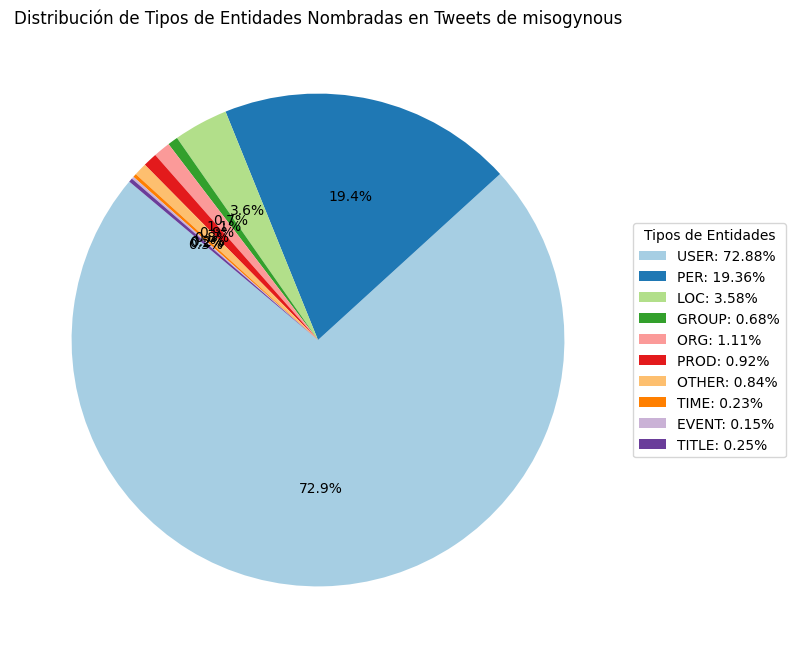

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_entity_type_percentages_misogynous.values(), startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Entidades Nombradas en Tweets de misogynous")
legend_labels = [f"{ent_type}: {percentage:.2f}%" for ent_type, percentage in overall_entity_type_percentages_misogynous.items()]
ax.legend(wedges, legend_labels, title="Tipos de Entidades", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


-----------------------------------------------

### Tweets no misogynous

-----------------------------------------------


In [28]:
# NER en tweets no misogynous
text_not_misogynous = [text for text in df_misocorpus_train[df_misocorpus_train["label"] == 0]["tweet"].tolist()]
results_ner_not_misogynous = [analyze_named_entities(text) for text in tqdm(text_not_misogynous)]

  0%|          | 12/2797 [00:00<00:50, 54.75it/s]

Texto analizado: @jlalarcon84 uf eso conllevaría a fregar sarten y tapadera y no se yo si me merece la pena por 2 trozos de pizza ?
Entidades encontradas: [('@jlalarcon84', 'USER')]
Texto analizado: Yo a mi jefe: yo vuelvo al restaurante pero no a fregar platos. Disney: toma, 7 meses pa fregar que se ve que no te hemos insistido suficiente con el contrato anterior que rechazaste.
Entidades encontradas: [('disney', 'ORG')]
Texto analizado: @ElKillBulls @omarFermoselle @MariaMonte_16 A fregar todos
Entidades encontradas: [('@elkillbulls', 'USER'), ('@omarfermoselle', 'USER'), ('@mariamonte_16', 'USER')]
Texto analizado: @Hammonyorkdista Estoy yendo a fregar para hacerle sitio al príncipe del infierno a las hordas del terror
Entidades encontradas: [('@hammonyorkdista', 'USER')]
Texto analizado: Me puse a fregar y ahora siento que el brazo derecho se me va a caer del dolor. Xq eres asi Ariana xq no fuiste al médico cuando debías
Entidades encontradas: [('ariana', 'PER')]
Texto analizado: @

  1%|          | 24/2797 [00:00<00:51, 54.14it/s]

Texto analizado: Por dios quiero mil, seguro sale una casa la porqueria esta,, a fregar con Zorro nomas :c http://t.co/
Entidades encontradas: []
Texto analizado: @madeinmartinez1 Yo aviso. Les digo a mis chicos, no bajéis que voy a fregar. Pues uno de mis dos hijos tiene que bajar ?‍♀
Entidades encontradas: [('@madeinmartinez1', 'USER')]
Texto analizado: A fregar los platos muy fumada escuchando Hannah Montana best of both worlds
Entidades encontradas: [('hannah montana', 'PER')]
Texto analizado: @LuisFerCamachoV Evo Costas no le dejará ir a la Títere de Jeanine, co no se frego esa mujer. Camacho haber si no vuelve a fregar, con eso es su acabose en la política. Ojalá mañana salga humo blanco para Bolivia un frente único, Mesa, Tuto y Camacho Unidos, y le hacemos frente a los masistas
Entidades encontradas: [('@luisfercamachov', 'USER'), ('evo costas', 'PER'), ('jeanine', 'PER'), ('camacho', 'PER'), ('bolivia', 'LOC'), ('mesa', 'PER'), ('tuto', 'PER'), ('camacho', 'PER'), ('masistas',

  1%|▏         | 36/2797 [00:00<00:49, 55.43it/s]

Texto analizado: Te das cuenta que estas vieja cuando te vas a fregar y terminas lavando la nevera
Entidades encontradas: []
Texto analizado: @robertbourdain1 Jajajaja todos y hasta las ? cara de tortilla que no conectan sus dos neuronas vienen a fregar con sus tweets faltos de intento cuando deberían estar corriendo en la barranca, así solo estarían estupiditos y no ? y estupiditos.??‍♀️
Entidades encontradas: [('@robertbourdain1', 'USER')]
Texto analizado: A alguien se le a pasado algunas vez por la mente colgarse de algun polin bueno a mi si pero como estoy todo gordo siento que voy a tumbar el techo ????? y a fregar el columpio
Entidades encontradas: []
Texto analizado: Soy tannnn gorda que fui a la cocina por buñuelos ?
Entidades encontradas: []
Texto analizado: Cosa que a él le faltaba, que nunca iba a encontrar al amor de su vida sin encontrar el amor propio. Sé que estuvieron mal mis palabras, pero neta que necesidad de venir a fregar la vida.
Entidades encontradas: []
Texto an

  2%|▏         | 48/2797 [00:00<00:50, 53.97it/s]

Texto analizado: Pero vas a fregar con esta http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: estoy en la cocina buscando una playlist bien chingona para ponerme a fregar porque EN ESTA CASA NADIE SIRVE PARA UNA VERGA COÑOELAMADREMEQUIEROIR DESESTAMIERDA
Entidades encontradas: []
Texto analizado: “¿Cómo pueden dar espacio a una mocosa?” así se refirió Bolsonaro a Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @24h_tve @GretaThunberg ????? siii ha inventado una central electrica que funciona con aire. Que pensais la gente somos gilipollas o que ?
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: “Es impresionante que la prensa le dé espacio a una mocosa como ella”: Bolsonaro sobre Greta Thunberg. Lea aquí la nota completa ➡️http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Histéri

  2%|▏         | 60/2797 [00:01<00:49, 55.64it/s]

Texto analizado: Los hombres odian a Greta: "Histérica", "estúpida" y "puta" son los insultos que recibe por parte de varones adultos - Spanish Revolution - http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: #Bolsonaro llama "mocosa" a Greta Thunberg #COP #CrisisClimática http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @LucioCesarBr @GretaThunberg Creo que no he visto ninguna estupidez más grande que esta. Un sistema que nos enseña a ser egoístas, individualistas y competidores es socialista? Ni puta idea tienes, chaval, ni puta idea
Entidades encontradas: [('@luciocesarbr', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: #EntérateDurango?‍??‍?#Mundo?Llama Bolsonaro “mocosa” a Greta Thunberg http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: hijos de puta me canse de caer en los videos de greta con gemidos lpmm qjaja
Entidades encontradas: [('greta', 'PE

  3%|▎         | 72/2797 [00:01<00:49, 55.53it/s]

Texto analizado: El día que bajaste a la cocina a las 5:00 am @yami_despos y yo estaba ahí, esperando la muerte http://t.co/
Entidades encontradas: [('@yami_despos', 'USER')]
Texto analizado: nunca olvidar cuando estaba durmiendo en la casa de novio y en una lo desperté a la madrugada porque tenía sed y no queria bajar sola a la cocina pues miedosa y el man SE DIO MEDIA VUELTA PARA SEGUIR DURMIENDO, ok gracias pd: fui a tomar agua del baño que esta al lado
Entidades encontradas: []
Texto analizado: Quiero dibujar XD pero no tengo ánimos ni confianza y tengo pereza :v....quiero pero como que siento que le voy a fregar xd
Entidades encontradas: []
Texto analizado: Les voy a comprar esto a mis compañeras de piso a ver si aprenden a fregar en condiciones de una puta vez http://t.co/
Entidades encontradas: []
Texto analizado: @ChildAncient @MPerfumado @JairoExtre Simplificas. Si enseñas a una generación a fregar, la siguiente no es nazi. Eso es cuando adoctrinas y no enseñas a pensar.
Entid

  3%|▎         | 78/2797 [00:01<00:49, 54.98it/s]

Texto analizado: De entre todos los insultos que se dedican cada día a Greta Thunberg "histérica, puta y majareta" son los preferidos de los hombres españoles... Este es el país en el que vivimos http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: NOTAS 2019 pelearse por internet: empieza a saber a poco Greta Thunberg: meme Cataluña: fútbol con esteroides disney: nazis ultracapitalistas lo del clima: nazis con datos isis: quién se acuerda tener razón: el reservado de los gilipollas BREAKTHROUGH DEL AÑO: ser nazi en público
Entidades encontradas: [('greta thunberg', 'PER'), ('cataluña', 'LOC'), ('disney', 'ORG'), ('isis', 'OTHER')]
Texto analizado: Jair Bolsonaro ‘no se corta’ y arremete contra «la mocosa» Greta Thunberg http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: En un continente con una historia plagada de violaciones de derechos humanos, dictaduras, conflictos y violencia; expertos, especiali

  3%|▎         | 90/2797 [00:01<00:54, 49.27it/s]

Texto analizado: Ella dijo a un periódico que se sentía en la obligación de escribir una historia que englobara todas las historias de las víctimas de violación, además de que estaba motivada para escribir sobre la violencia porque cree que no es infrecuente. "La veo como una parte de la vida, y
Entidades encontradas: []
Texto analizado: Washington se suma y mujeres cantan muy fuerte la performance chilena "Un violador en tu camino" ✊✊ ? http://t.co/
Entidades encontradas: [('washington', 'LOC')]
Texto analizado: Un "presunto" violador paga por librarse de la condena. Unas "supuestas victimas" anteponen el cobro de dinero a una posible reparación en forma de condena. Una "Justicia" que permite que "delitos" no se juzguen y un "presunto" violador quede libre pagando. Justicia capitalista http://t.co/
Entidades encontradas: []
Texto analizado: @JonathnCanales4 A fregar la grama del estadio es a lo que van ?
Entidades encontradas: [('@jonathncanales4', 'USER')]
Texto analizado: Con Piltra

  4%|▎         | 100/2797 [00:01<01:04, 41.66it/s]

Texto analizado: "Oxigenamos la lista" "El violador eras tú"
Entidades encontradas: []
Texto analizado: @OfeFernandez_ @Mariano_Villa Tampoco lloran y tiemblan, tampoco tantoo.. El hacer un chiste de mal gusto no te hace violador
Entidades encontradas: [('@ofefernandez', 'USER'), ('@mariano_villa', 'USER')]
Texto analizado: El Gobierno Nacional conoció el caso Furukawa en 2018. Hasta hoy ha tolerado que la empresa opere en impunidad. Demandamos la violación a los #DDHH de miles de personas sometidas a #EsclavitudModerna y exigimos #JusticiaYReparación #FurukawaNuncaMas @mariapaularomo @CecyChaconC http://t.co/
Entidades encontradas: [('furukawa', 'ORG'), ('2018', 'TIME'), ('furukawanuncamas', 'ORG'), ('@mariapaularomo', 'USER'), ('@cecychaconc', 'USER')]
Texto analizado: Junto a las personas asesinadas, violadas y vejadas sexualmente por agentes del Estado, los ciudadanos mutilados en sus ojos, son la representación más feroz e imperecedera de las sistemáticas violaciones a los DDHH, a

  4%|▍         | 117/2797 [00:02<00:44, 60.64it/s]

Texto analizado: Juristas, sobre el «caso Arandina»: «La perspectiva de género se afianza en las sentencias por violación» http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: @eldiarioes Alguna propuesta legislativa? Pero para aplicar a todo el mundo por igual, blanquitos vascas catalanas, jugadores del arandina, extrajeros residentes y urdangarines, ricos, hijos de jueces, politicos pura casta, la justicia deja mucho que desear. Gracias a politicos como borrell
Entidades encontradas: [('@eldiarioes', 'USER'), ('vascas catalanas', 'OTHER'), ('arandina', 'LOC'), ('urdangarines', 'OTHER'), ('borrell', 'PER')]
Texto analizado: Hola @Diario_Ribera , se dice: Tres violadores condenados en el caso Arandina. De nada. http://t.co/
Entidades encontradas: [('@diario_ribera', 'USER'), ('arandina', 'LOC')]
Texto analizado: Bolsonaro llama "mocosa" a Greta Thunberg y ella le responde a su manera http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta t

  5%|▍         | 135/2797 [00:02<00:36, 73.57it/s]

Texto analizado: Reporte Mundial 2019 @hrw_espanol @hrw:La impunidad x delitos violentos y violaciones d DDHH siguen siendo problemas serios. En Bolivia la admin del (ex) Pdte Evo Morales ha creado 1 ambiente hostil para defensores d los DDHH q socava su capacidad d trabajar d forma independiente
Entidades encontradas: [('@hrw_espanol', 'USER'), ('@hrw', 'USER'), ('bolivia', 'LOC'), ('evo morales', 'PER')]
Texto analizado: Informe de Naciones Unidas por crisis social en Chile: “Se han producido un elevado número de violaciones graves a los derechos humanos” http://t.co/
Entidades encontradas: [('naciones unidas', 'ORG'), ('chile', 'LOC')]
Texto analizado: @Buff_Aatrox @qusadacid No estoy en desacuerdo con Rodrigo pero el a "fregar" está de más, respeta un poco más.
Entidades encontradas: [('@buff_aatrox', 'USER'), ('@qusadacid', 'USER'), ('rodrigo', 'PER')]
Texto analizado: @ANGEL00000098 En que estás equiparando las manifestaciones a las que yo voy con las de defender la violación de 

  6%|▌         | 154/2797 [00:02<00:32, 82.19it/s]

Texto analizado: @isabellamunoz04 Si me pagan yo les friego aw. @ariannealvarezl. Amo fregar ? Y me cabrea cuando friegan mal. A veces hasta vuelvo a fregar lo que supuestamente ya estaba fregado ?❤️
Entidades encontradas: [('@isabellamunoz04', 'USER'), ('@ariannealvarezl', 'USER')]
Texto analizado: @mishellyorozco La gente por A o por B van a fregar, así que ánimo mija póngase su short ?????
Entidades encontradas: [('@mishellyorozco', 'USER')]
Texto analizado: Que suerte tienen ustedes que no los mandaron a fregar y deben estar hasta la pinga de borrachos ?
Entidades encontradas: []
Texto analizado: Ve, que sigamos gritando nos pide @Margaritarosadf . http://t.co/
Entidades encontradas: [('@margaritarosadf', 'USER')]
Texto analizado: Tengo miedo por el coronavirus. No por mi, sino por la gente que ama la vida y esto se las viene a fregar. Me dicen que no me preocupe, que solo un pequeño % se complica. No sabe esa persona que en este país la gente se muere por un uñero.
Entidades encon

  6%|▌         | 172/2797 [00:02<00:31, 82.13it/s]

Texto analizado: @Jess53501563 @eledhmel A ver si te enteras..... El juez de la manada de Pamplona dijo que no era violación, que era sólo abuso... ¿A él también te lo creías? ¿También estás contra los que protestaron por esa sentencia?
Entidades encontradas: [('@jess53501563', 'USER'), ('@eledhmel', 'USER'), ('pamplona', 'LOC')]
Texto analizado: [VÍDEO] Feministes valencianes interpreten 'Un violador en el teu camí' http://t.co/
Entidades encontradas: [('valencianes', 'OTHER')]
Texto analizado: La pena de prisión x violación es 6 a 12 años. Si le han condenado a 24 meses es por: 1. No fue violación 2. Le apreciaron unas atenuantes muy cualificadas 3. Fue una tentativa, la acción no se consumó No mezcléis unos delitos con otros ni 1 condena con 1 petición de fiscal http://t.co/
Entidades encontradas: []
Texto analizado: ¿Es posible decretar duelo nacional por la violación a los Derechos Humanos, al igual que se está haciendo por la tragedia del Hércules C-130?
Entidades encontradas: [(

  7%|▋         | 191/2797 [00:03<00:29, 87.84it/s]

Texto analizado: Artivismo feminista http://t.co/ vía @levante_emv
Entidades encontradas: [('@levante_emv', 'USER')]
Texto analizado: Por favor, está Navidad no contribuyais a esto y levantad el culo. Que luego a los hombres se nos llena la boca de apoyar al feminismo y cosas tan simples como esta dejamos que ocurran. http://t.co/
Entidades encontradas: []
Texto analizado: Miedo a perder el apoyo d las feminazis??? Dejen de MENTIR #NSB http://t.co/
Entidades encontradas: []
Texto analizado: Que triste que una mujer le diga a otra feminazi
Entidades encontradas: []
Texto analizado: Estoy aburrida de escuchar comentarios como: “¿una niña diciendo groserías?”, “es qué hay mujeres que no son tan femeninas”, “a mi esas feminazi no me representan, que boleta” ¡Que puto fastidio! Y que tristeza que quienes lo dicen, son mujeres... ?
Entidades encontradas: []
Texto analizado: Yo intentando tener una discusión sobre feminismo con un hombre sin que me llame "feminazi" o "sobaco verde" http://t.c

  7%|▋         | 209/2797 [00:03<00:29, 88.67it/s]

Texto analizado: Bolsonaro califica de &amp;laquo;mocosa&amp;raquo; a Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: El presidente brasileño se expresó luego de que Thunberg denunciara el asesinato de dos indígenas en el amazonas. Thunberg respondió a través de sus redes sociales http://t.co/
Entidades encontradas: [('brasileño', 'OTHER'), ('thunberg', 'PER'), ('amazonas', 'LOC'), ('thunberg', 'PER')]
Texto analizado: @aroa8barcelona Buenos días, ¡¡¡jajajaja!!! a... fregar.☕️??☕️ http://t.co/
Entidades encontradas: [('@aroa8barcelona', 'USER')]
Texto analizado: Jair Bolsonaro tildó de “mocosa” a Greta Thunberg y cuestionó a la prensa por darle tribuna - RPP http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('rpp', 'ORG')]
Texto analizado: Jair Bolsonaro llama "mocosa" a Greta Thunberg y la activista le responde de una forma bien sutil en su perfil en Twitter. htt

  8%|▊         | 227/2797 [00:03<00:29, 87.47it/s]

Texto analizado: Este es el feminismo que me gusta ? http://t.co/
Entidades encontradas: []
Texto analizado: Estaba viendo tele con mi abuelita y pues el término "féminazi" ya llegó a "Cómo dice el dicho"... quiero desaparecer.
Entidades encontradas: []
Texto analizado: @peliradfem @ProfesorQuantum Y también es una manifestación de esa manía de esperar a que el feminismo sea una suerte de mesías que arregle todos los problemas del mundo, que si no están las feministas de chile echando baldes de agua a los incendios en Australia, es que son feminazis o terfs o algo asi
Entidades encontradas: [('@peliradfem', 'USER'), ('@profesorquantum', 'USER'), ('chile', 'LOC'), ('australia', 'LOC')]
Texto analizado: Message to: 1. Ya no pongas el cuerno wey 2. Mlp 3. (No quiero un futuro bf/gf) 4. Visítenme ? 5. Se te fue 6. Cántame Jared bb? 7. Pro elección y feminismo por favor 8. Mlp x2 9. Vamo a tomar ándale 10. Ya me hartaste bye Drop an emoji for the questions
Entidades encontradas: [('jared bb

  9%|▉         | 245/2797 [00:03<00:29, 86.97it/s]

Texto analizado: Pero no...están exagerando, feminazis, odian a los hombres, exageran. 116 vidas que faltan este año. Tengo una mezcla de rabia y tristeza http://t.co/
Entidades encontradas: []
Texto analizado: Si es repartidor, no puede ser feminista http://t.co/
Entidades encontradas: []
Texto analizado: Los hombres diciéndome q no es machista que esq es asiático y no entiende el español?????????????????
Entidades encontradas: []
Texto analizado: Jajajaja, es neta amiga? Castre tú novio que se la pasa molestando a mi prima, castre tú qué marchas por la igualdad, por eliminar el machismo, por nombrarte feminista y te burlas de alguien que te mando todo lo que tú novio habla de ti, hasta inventó que estabas embarazada y... http://t.co/
Entidades encontradas: []
Texto analizado: Bravooo morenooo!!! Pues claro q si! http://t.co/
Entidades encontradas: []
Texto analizado: @maritzaesterqm A mí quienes me dan lástima son las mujeres de ése sector. Me las imagíno golpeadas, engañadas y totál

  9%|▉         | 254/2797 [00:03<00:30, 84.07it/s]

Texto analizado: Las ‘Mujercitas’ de la nueva generación feminista http://t.co/
Entidades encontradas: []
Texto analizado: Balance cultural de una década: 2010-2019 por @jorgecarrion21/10 claves de la producción cultural de los últimos 10 años, la literatura, la televisión, los videojuegos, los ámbitos atravesados por las metamorfosis tecnológicas. Una reflexión retrospectiva http://t.co/ http://t.co/
Entidades encontradas: [('@jorgecarrion21/10', 'USER')]
Texto analizado: Encuentro tan barsa que algunos hombres hablen en contra del machismo por twitter - haciendose los proges- cuando su única "contribución" a sus hija/os fue donar el espermio. ¿La comida, la plata pa estudiar, la salud, crianza y otros dónde quedó? Pura tecla.
Entidades encontradas: [('twitter', 'PROD')]
Texto analizado: Asegura @Claudiashein, jefa de @GobCDMX, que la capital del país el #machismo y el #acoso hacia las #mujeres siempre ha estado presente; es preciso aceptarlo para erradicarlo, advirtió. http://t.co/
E

 10%|▉         | 272/2797 [00:03<00:30, 83.76it/s]

Texto analizado: JAJAJAJA si, en verdad si @JBolsonaroPsl17 RT JOSÉ CÁRDENAS @JoseCardenas1 Presidente de Brasil llama «mocosa» a Greta Thunberg http://t.co/
Entidades encontradas: [('@jbolsonaropsl17', 'USER'), ('josé cárdenas', 'PER'), ('@josecardenas1', 'USER'), ('brasil', 'LOC'), ('greta thunberg', 'PER')]
Texto analizado: ? "Es impresionante que la prensa le dé espacio a una mocosa" Jair Bolsonaro "arremete" contra Greta Thunberg http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Bolsonaro llama "mocosa" a Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Un año más, vuelvo a ser el gilipollas que sigue regalando mix CDs, con los personajes del año en portada: Greta y Pedro @Camellosdigame, @aptos_acapulco, @LaCasaAzulBCN, @mondoairbag, @AlborotadorG, @Marcianos_info, @FredburguerFred y muchos más #HopelessRomantic #FelicesReyes http://t.co/
Ent

 10%|█         | 290/2797 [00:04<00:29, 85.74it/s]

Texto analizado: #10Dic La activista Greta Thunberg, que asiste a la Cumbre del Clima de Madrid (COP25), fue tildada este martes de "mocosa" ("pirralha") por el presidente brasileño, Jair Bolsonaro, y asumió ese calificativo en su perfil en la red social Twitter. - @EFEnoticias http://t.co/
Entidades encontradas: [('10dic', 'TIME'), ('greta thunberg', 'PER'), ('cumbre del clima', 'EVENT'), ('madrid', 'LOC'), ('cop25', 'TIME'), ('martes', 'TIME'), ('brasileño', 'OTHER'), ('jair bolsonaro', 'PER'), ('twitter', 'PROD'), ('@efenoticias', 'USER')]
Texto analizado: Histérica, marioneta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter http://t.co/ vía @elpais_tec
Entidades encontradas: [('españoles', 'OTHER'), ('greta thunberg', 'PER'), ('twitter', 'PROD'), ('@elpais_tec', 'USER')]
Texto analizado: El presidente de #Brasil??, Jair Bolsonaro, llamó "mocosa" a la activista sueca Greta Thunberg, de 16 años, después que la joven denunciase la violencia contra los

 11%|█         | 309/2797 [00:04<00:28, 85.84it/s]

Texto analizado: Presidente de Brasil llama 'mocosa' a activista Greta Thunberg http://t.co/ #News
Entidades encontradas: [('brasil', 'LOC'), ('greta thunberg', 'PER')]
Texto analizado: Vergonzoso...!✊ Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ vía @elpais_tec
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter', 'PROD'), ('@elpais_tec', 'USER')]
Texto analizado: El artículo, vale. El titular incorrecto porque somos muchos los hombres españoles que no coincidimos con ese perfil que se señala en el enunciado. Histérica, marioneta y majareta: los insultos que hombres españoles dedican a Greta Thunberg en Twitter http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter', 'PROD')]
Texto analizado: @bertrandmyd @Unha127 Que la reacción de este niño es admirable, claro que sí, y mas a tan corta edad que muchos niños simplemente se quedarían asustados llorando. Pero que te refieras a Greta como "del demo

 12%|█▏        | 327/2797 [00:04<00:28, 86.87it/s]

Texto analizado: Me tienen verde con la vaina que pasa en Australia, que si la culpa es de Greta que si la culpa es de el gobierno. La culpa es de TODOS NOSOTROS LOS HUMANOS QUE SOMOS UNA PUTA PLAGA!!! Comencemos a cambiar por nosotros mismos y dejar de culpar a los demás, de pana ya basta!
Entidades encontradas: [('australia', 'LOC'), ('greta', 'PER')]
Texto analizado: #Mundo ??‍?Bolsonaro llama ‘mocosa’ a Greta Thunberg ➡️ http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @Oswaldo76617331 @nadir_karen @aristeguicnn Que siga poniendo en esos cargos a quien quiera si ese es el secreto de su éxito. Las personas reales que no somos #Bot (con 8 números después del nombre) estamos mejor con ella que con los los pedófilos violadores que puso el narco http://t.co/
Entidades encontradas: [('@oswaldo76617331', 'USER'), ('@nadir_karen', 'USER'), ('@aristeguicnn', 'USER')]
Texto analizado: Como es q esto no es condenable? @CIDH esto no es violación de 

 12%|█▏        | 345/2797 [00:04<00:28, 87.47it/s]

Texto analizado: Según Piñera : 6. No hay violaciones de los DDHH en Chile porque no "hay un patrón de conducta" por lo tanto no es sistemático e indica que el informe de Amnistía Internacional es SESGADO. Es decir Piñera no reconoce lo evidente y se desliga de su responsabilidad política.
Entidades encontradas: [('piñera', 'PER'), ('chile', 'LOC'), ('amnistía internacional', 'ORG'), ('piñera', 'PER')]
Texto analizado: @JuandyOk Tres doritos después Arrestan a su hermano por VIOLACION.... ???? #simonviolador
Entidades encontradas: [('@juandyok', 'USER'), ('simonviolador', 'PER')]
Texto analizado: #LoMásVistoDeLaSemana | Elena Poniatowska cuenta que fue violada por el escritor Juan José Arreola y quedó embarazada. ??? http://t.co/ http://t.co/
Entidades encontradas: [('elena poniatowska', 'PER'), ('juan josé arreola', 'PER')]
Texto analizado: @sai54 @KiraNoteFreak No, a ver, la chavala será lo que sea pero los violadores son violadores seguro. ¿Eso lo entiendes?
Entidades encontradas: [

 13%|█▎        | 364/2797 [00:05<00:28, 85.83it/s]

Texto analizado: @InesArrimadas Ese es un hijo de puta y el periodista que lo anima un cabrón
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @cayetanaAT Son de ñordia no tenen puta ideia
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT No tiene ni puta idea y los que la apoyan tampoco no saben nada y se erigen como si fueran maestros
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @Irene_Montero_ A mi me viene gritando de esas maneras y directamente la mando a la puta mierda o a tomar por el culo, donde prefiera.
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @Irene_Montero_ Sois la misma puta mierda . Con perdón de la expresión
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: @monasterioR @julia_otero Monasterio tiene razon...y la otra que aunque sea de añdea no tiene ni puta idea que los tractores funcionan con diesel.Tu puede vivir en una aldea y no tener ni puta idea que e

 14%|█▎        | 383/2797 [00:05<00:27, 87.78it/s]

Texto analizado: Irmão a gente ta na final do mundial dps de 38 anos com o mesmo adversario de 38 anos atras, vc realmente acha q a gente vai por os pés no chão agora???? Kkkkkk
Entidades encontradas: []
Texto analizado: @LaFallaras @ContadorAltsasu No Cristina no!! Eso no es una locura es una puta VENGANZA. Por desgracia no es la primera ni sera la ultima.
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('cristina', 'PER')]
Texto analizado: @InesArrimadas Tu no vas a mejorar nada payaso, no tienes ni puta idea, no sabes dónde tienes la mano derecha, si no has trabajado en tu p. Vida cómo vas a crear trabajo para otros? Después de vosotros quedará la ruina
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Valiente hijo de puta
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @monasterioR Más que las feministas, se la va a cargar Rotten Tomatoes, que ni puta idea tienes.
Entidades encontradas: [('@monas

 14%|█▍        | 402/2797 [00:05<00:27, 88.03it/s]

Texto analizado: ...l@s negacionistas comenzaron negando la violència entre hombres por razon de raza lengua, cultura o condicion sexual, se ha acabado con dale tu tambien, haberselo devuelto, con él si nadie ha visto nada para que vas a denunci…http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: @fladaniel_ @LFC @centraldanacao @Flamengo Galinha de Quintino ! Com Seleção ganhou o que? Por isto Todo o resto do Brasil Oodeeiiaa vcs!38 anos sem p. Nenhuma agora o cu pisca!
Entidades encontradas: [('@fladaniel', 'USER'), ('@lfc', 'USER'), ('@centraldanacao', 'USER'), ('@flamengo', 'USER'), ('quintino', 'EVENT'), ('brasil', 'LOC')]
Texto analizado: puro DRAMA hateando algo que puedes disfrutar en paz y amar, pero verdad que la mayoria son puros incel de 38 años llorones
Entidades encontradas: []
Texto analizado: "Aranda será feminista o no será", "Aranda será la tumba del machismo" . Cientos de personas se concentran en apoyo de la víctima de La Arandina http://t.co/
Entid

 15%|█▌        | 421/2797 [00:05<00:26, 88.89it/s]

Texto analizado: 38 anos depois o Flamengo volta a disputar uma final de Mundial e logo contra o Liverpool. Vcs não acham isso muito doido não?
Entidades encontradas: [('flamengo', 'GROUP'), ('mundial', 'EVENT'), ('liverpool', 'GROUP')]
Texto analizado: @susanadiaz @JuanMa_Moreno ???? Y ahora el soplapollas de sanchez, pretende intervenir andalucia y obligar a hacer recortes. DEVOLVER LA PASTA ROBADA HIJOS DE PUTA. PSOEA..... LADRONES
Entidades encontradas: [('@susanadiaz', 'USER'), ('@juanma_moreno', 'USER'), ('sanchez', 'PER'), ('andalucia', 'LOC'), ('psoea', 'GROUP')]
Texto analizado: @monasterioR Tú no has visto Star Wars en tu puta vida, Hulia.
Entidades encontradas: [('@monasterior', 'USER'), ('star wars', 'TITLE'), ('hulia', 'PER')]
Texto analizado: @monasterioR @julia_otero La ganadería y agricultura son algunas de las actividades que más contaminan (sobre todo la primera) y vienes aquí a decir la mierda que dices. No tienes ni puta idea. Ve a ponerle unas velitas a Franco y a 

 16%|█▌        | 439/2797 [00:05<00:26, 88.17it/s]

Texto analizado: @CristinaSegui_ A lo mejor la del Caso Arandina le parece baja.
Entidades encontradas: [('@cristinasegui', 'USER'), ('arandina', 'LOC')]
Texto analizado: Ellos, con una sentencia que les condena a 38 años por VIOLAR A UNA NIÑA DE 15 AÑOS... estas Navidades las pasan en casa... y la gente se manifiesta para mostrarles apoyo... si es que tenemos lo que nos merecemos... #vergonya #HermanaYoSiTeCreo
Entidades encontradas: []
Texto analizado: @gustavorevatta Sí, y ese tema ha polarizado a los hinchas. Con 38 años venir a jugar a Perú sería un lindo reto para él.
Entidades encontradas: [('@gustavorevatta', 'USER'), ('perú', 'LOC')]
Texto analizado: Una mujer de 38 años se casó con un hombre de 38 años y en 1 recamara con 3 ventanas hicieron 3838 13 http://t.co/
Entidades encontradas: []
Texto analizado: @BeatrizGimeno1 @Sergio01210846 Si es violacion ,altas penas ,si es con fuerza ,drogas,etc .mayor pena .si es menor mayor todavia ....pero violacion es si no es consentido ..

 16%|█▋        | 457/2797 [00:06<00:27, 86.42it/s]

Texto analizado: @unworthyunicor2 @MachiTodoRelato @Shine_McShine Siiiii, de un delito que conlleva penas de 2 a 6 años y mucho más bajas como colaborador. No se declararon culpables en ningún momento del delito por el que les han metido 38 años, o sea tener relaciones FORZADAS con una menor. Lo pillas ya, so inútil???
Entidades encontradas: [('@unworthyunicor2', 'USER'), ('@machitodorelato', 'USER'), ('@shine_mcshine', 'USER')]
Texto analizado: @leslieyyyy Porque en la de los de Arandina no hay pruebas de la violación y en esta si, y a los otros 38 años y a esta nada...pero vamos, no conviene darle bulo en los medios ??
Entidades encontradas: [('@leslieyyy', 'USER'), ('arandina', 'LOC')]
Texto analizado: @juanrga @felixregueiro1 @ManuelVilas2 @GirautaOficial La mayoría de periódicos que he leído ponen violación , uno de ellos http://t.co/
Entidades encontradas: [('@juanrga', 'USER'), ('@felixregueiro1', 'USER'), ('@manuelvilas2', 'USER'), ('@girautaoficial', 'USER')]
Texto analizado: 

 17%|█▋        | 475/2797 [00:06<00:28, 82.58it/s]

Texto analizado: @CristinaSegui_ A ti también cuando te condenen por humillar la menor de edad violada por los jugadores del Arandina. Tranquila, aunque hayas borrado tuits y demás, las redes tienen memoria.... Campeona.
Entidades encontradas: [('@cristinasegui', 'USER'), ('arandina', 'GROUP')]
Texto analizado: @JRhodesPianist Caso Arandina, vergonzoso ver personas defendiendo unos violadores que aún tienen el morro de decir que no hicieron nada, asco!!!
Entidades encontradas: [('@jrhodespianist', 'USER'), ('arandina', 'PER')]
Texto analizado: @jjuliantc @susanadiaz Si no recuerdo mal Almería la metieron en el paraíso andaluz con un pucherazo.....fue el primer robo del @psoedeandalucia en 38 años de carrera criminal
Entidades encontradas: [('@jjuliantc', 'USER'), ('@susanadiaz', 'USER'), ('almería', 'LOC'), ('andaluz', 'OTHER'), ('@psoedeandalucia', 'USER')]
Texto analizado: Libertad provisional para los ex jugadores del #Arandina con penas de 38 años de cárcel http://t.co/ http://t.co

 18%|█▊        | 493/2797 [00:06<00:27, 82.93it/s]

Texto analizado: @albaZ1789 @SofCastanon Totalmente de acuerdo, permanente y punto. Estos monstruos no deben vivir en sociedad y desde luego no es comparable el caso Arandina con el de Diana Quer.
Entidades encontradas: [('@albaz1789', 'USER'), ('@sofcastanon', 'USER'), ('arandina', 'PER'), ('diana quer', 'PER')]
Texto analizado: @FlaDaNacao_ A galera da xtudo deve torcer para o Vasco... Não é possível um troço desses! Há 38 anos q a gente não vive isso e o povo tratando como carioca
Entidades encontradas: [('@fladanacao', 'USER'), ('vasco', 'GROUP')]
Texto analizado: e eu que vou morrer daqui 38 anos 42 dias kkk http://t.co/
Entidades encontradas: []
Texto analizado: @Jesus__Mejias @Shine_McShine @CristinaSegui_ Si tu tuvieras un hijo y le metieran 38 años de carcel por tener relaciones con una menor teniendo 18 años, cambiarias tu relato. Osea que no nos des lecciones. Y recuerda que con 15 años y 11 meses te caen 38 años, 1 mes más tarde puede participar en una orgia con octogenario

 18%|█▊        | 511/2797 [00:06<00:26, 85.24it/s]

Texto analizado: La familia de Víctor Rodriguez Ramos, uno de los condenados por el Caso Arandina, ha hecho pública una carta el día antes del posible ingreso en prisión del joven http://t.co/
Entidades encontradas: [('víctor rodriguez ramos', 'PER'), ('arandina', 'TITLE')]
Texto analizado: Aos 38 anos de idade, goleiro morre em Alagoas após internação por infarto http://t.co/ via @YouTube
Entidades encontradas: [('alagoas', 'LOC'), ('@youtube', 'USER')]
Texto analizado: Ultraderecha reaccionaria filofascista que defendía a los hijos de puta de Arandina condenando por interés político a otro hijo de puta igualito como el chicle en 3,2,1....
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Real que le he tenido que parar los pies a un tío de 38 años porque no le daba la gana hacerme caso.
Entidades encontradas: []
Texto analizado: Se não ganharmos, já estamos super felizes. Zeramos brasileirão, carioca, copa Mickey e o mais importante. Libertadores depois de 38 anos !
Entid

 19%|█▉        | 529/2797 [00:06<00:28, 79.00it/s]

Texto analizado: El juzgado investiga la filtración de los audios de la víctima de los exjugadores de la Arandina http://t.co/ Lo cuenta @lauracorama http://t.co/
Entidades encontradas: [('arandina', 'GROUP'), ('@lauracorama', 'USER')]
Texto analizado: @LaFallaras @ContadorAltsasu Es una puta verguenza
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER')]
Texto analizado: Yo diria que los que consintieron fueron los tres de la arandina. http://t.co/
Entidades encontradas: []
Texto analizado: Yo no. Ya tenía plan. Pero qué se pide exactamente? #l@H0rc@ para los jugadores? 38 años no son suficientes? A Lanza por @ses1nat0 le cayeron 5. Por qué? La #víctima era hombre? http://t.co/
Entidades encontradas: [('@ses1nat0', 'USER')]
Texto analizado: @artskenma se você tem 19 anos você não pode casar com um homem de 38 anos pois ele é muito velho pra você mesmo esse homem sendo o tom hiddleston
Entidades encontradas: [('@artskenma', 'USER'), ('tom hiddleston', 'PER')]
T

 20%|█▉        | 548/2797 [00:07<00:27, 82.97it/s]

Texto analizado: Con Blasco Ibañez, decir que en España se aborrece siempre el sexo, cuando son otros los que lo practican. La condena a los jugadores de la #Arandina devuelve a España a sus épocas más oscuras, luego os quejais si desde Flandes os recordamos la Leyenda Negra que forjais.
Entidades encontradas: [('blasco ibañez', 'PER'), ('españa', 'LOC'), ('arandina', 'LOC'), ('españa', 'LOC'), ('flandes', 'LOC')]
Texto analizado: Susana no tendrá como segundo nombre Alicia, por que vive en el país de las maravillas. Con tanto progreso e igualdad durante 38 años el PSOE seguirá gobernando a perpetuidad, verdad? Por favor lo único que trajeron fue clientelismo, pobreza e ignorancia.Y un robo descarado. http://t.co/
Entidades encontradas: [('susana', 'PER'), ('alicia', 'PER'), ('psoe', 'GROUP')]
Texto analizado: El juez interroga al acusado de un crimen machista de hace 38 años El escritor Manuel Macarro mató supuestamente a su amante embarazada. El ADN permitió identificar el cadáver, h

 20%|██        | 566/2797 [00:07<00:26, 84.83it/s]

Texto analizado: Que sí...q.yo también tengo mi opinión sobre la sentencia de los jugadores de la #Arandina.... Y sí, efectivamente me la guardo. Principalmente porque creo q no tengo conocimiento suficiente. Y por q esto de no opinar me está gustando.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: En cuanto a lo de la Arandina: la pena es un poco desmedida pero acostarse con una menor es siempre violación, y más teniendo un estatus como futbolista y algo de dinero
Entidades encontradas: []
Texto analizado: Ala Cristina, empieza a buscar abogado, notas la angustia? A lo mejor ahora empatizas un poquito. http://t.co/ http://t.co/
Entidades encontradas: [('cristina', 'PER')]
Texto analizado: La condena del caso Arandina se sustenta, fundamentalmente, en la declaración de la víctima, y lo cierto es que el relato de hechos probados arroja bastantes dudas http://t.co/ vía @voz_opinion
Entidades encontradas: [('arandina', 'PER'), ('@voz_opinion', 'USER')]
Texto analizado: Caso

 21%|██        | 585/2797 [00:07<00:25, 87.13it/s]

Texto analizado: @Persona_regular @anarob12 @Malequith Mi argumento, ESCUCHA LOS AUDIOS y ten criterio propio. Con las brujas de Salen no hubo AUDIOS y en este caso la hoguera son 38 años, algo totalmente desproporcionado cuando en España, hay condenas de 2 o 5 años en casos de muerte... Si tu argumento es insultar mal vamos ?
Entidades encontradas: [('@persona_regular', 'USER'), ('@anarob12', 'USER'), ('@malequith', 'USER'), ('españa', 'LOC')]
Texto analizado: Caso #Arandina: Un pueblo partido por la banda http://t.co/ http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Caso Arandina: por qué te pueden caer años de cárcel por difundir los audios de la víctima http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: La Audiencia Provincial de Burgos dicta hoy sentencia sobre el caso Arandina http://t.co/
Entidades encontradas: [('burgos', 'LOC'), ('arandina', 'LOC')]
Texto analizado: ?#ÚLTIMAHORA Los exjugadores del caso Arandina, culpables de a

 22%|██▏       | 603/2797 [00:07<00:25, 87.66it/s]

Texto analizado: @OndaCero_es @julia_otero Viendo algunos comentarios a algunos les parece poca condena 38 años por una felación. Quieren cadena perpetua?. Se observa que el movimiento feminazi sigue avanzando.
Entidades encontradas: [('@ondacero_es', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: Tiene pintas de Cura depravado. Vaya careto. 38 años de cárcel mínimo pichasss, que digo yo... http://t.co/
Entidades encontradas: []
Texto analizado: ?Video de @IsaacParejo sobre el caso: http://t.co/ ?Video de @aitor13023985 sobre el caso: http://t.co/ ?Hilo sobre el caso: http://t.co/ ?Firmas contra la sentencia: http://t.co/ #Aranda
Entidades encontradas: [('@isaacparejo', 'USER'), ('@aitor13023985', 'USER'), ('aranda', 'PER')]
Texto analizado: @Kike94M @SanchoSomalo @jonathanmartinz Discutir por ejemplo la sentencia de la Arandina te parece odio? Por poner un ejemplo
Entidades encontradas: [('@kike94', 'USER'), ('@sanchosomalo', 'USER'), ('@jonathanmartinz', 'USER'), ('arandina', 'O

 22%|██▏       | 612/2797 [00:07<00:24, 87.68it/s]

Texto analizado: @PicBravedick @MariaJamardoC Los 38 años es debido a dos penas por cooperación necesaria
Entidades encontradas: [('@picbravedick', 'USER'), ('@mariajamardoc', 'USER')]
Texto analizado: @Carmen06755533 @ebecadal @djmixe01 @camino_bueno @samuelbeticovlc @Andrea_Lazaro_8 @juvini100 Yo realmente entiendo la concentración. Tendrán familiares, amigos, algún radical político y forofos de la Arandina que no ven más allá del hecho de ser de su equipo de fútbol (unga, unga). Eso juntará unos 200 que solo verán eso. Que son sus colegas a los que hay que apoyar. ?‍♂️
Entidades encontradas: [('@carmen06755533', 'USER'), ('@ebecadal', 'USER'), ('@djmixe01', 'USER'), ('@camino_bueno', 'USER'), ('@samuelbeticovlc', 'USER'), ('@andrea_lazaro_8', 'USER'), ('@juvini100', 'USER'), ('arandina', 'LOC'), ('unga', 'OTHER'), ('unga', 'OTHER')]
Texto analizado: 3- grupo de hombres viola a niña de 14 años borracha y drogada, inconsciente. -12 AÑOS DE PRISIÓN. 4- grupo de hombres viola niña de 15

 23%|██▎       | 630/2797 [00:08<00:25, 85.76it/s]

Texto analizado: @_PabloFdez_ Debería haberse cantado hoy en la concentración que va a haber en #Bembibre a favor de los violadores de la arandina. Qué pena.
Entidades encontradas: [('@_pablofdez', 'USER'), ('bembibre', 'LOC'), ('arandina', 'OTHER')]
Texto analizado: estimados @vox_es ¿a que bulo sobre el caso Arandina os estais refiriendo en este hilo? http://t.co/ ¿a este comentario de vuestro diputado?, ¿esto es un bulo o lo que refleja es un desconocimiento absoluto de las leyes?, ha rectificado? http://t.co/
Entidades encontradas: [('@vox_es', 'USER'), ('arandina', 'PER')]
Texto analizado: Sobre lo de los de la Arandina, por cierto: son inocentes hasta que no haya una sentencia firme del Supremo.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Caso Arandina | Convocan una manifestación de apoyo a los exjugadores de la Arandina condenados por agresión sexual ➡ Bajo los hashtag #Yosioscreo y #Estonoacabaaquí se reunirán en la Plaza Mayor de la localidad a las 18 horas.

 23%|██▎       | 648/2797 [00:08<00:25, 85.89it/s]

Texto analizado: El portavoz de @facua, @RubenSanchezTW, ha anunciado que se pondrán este viernes a disposición judicial los certificados de la difusión de los audios de la víctima del 'Caso Arandina' http://t.co/
Entidades encontradas: [('@facua', 'USER'), ('@rubensancheztw', 'USER'), ('viernes', 'TIME'), ('arandina', 'TITLE')]
Texto analizado: @radioactivovel @Virabhadra_1 De hombres no, de salidos como tú y depravados como los hdgp de la arandina. no te equivoques...
Entidades encontradas: [('@radioactivovel', 'USER'), ('@virabhadra_1', 'USER')]
Texto analizado: Estive pensando, o Liverpool e tido como o bicho papão, mas, se poupou titulares para a final é sinal que teme o Flamengo, então, vamos pra cima deles Flamengo, este é o ultimo jogo do ano, o jogo mais importante dos ultmos 38 anos, nao podemos desperdiçar esta oportunidade.
Entidades encontradas: [('liverpool', 'GROUP'), ('flamengo', 'GROUP'), ('flamengo', 'GROUP')]
Texto analizado: @dsegoviaatienza @publico_es 38 años sigu

 24%|██▍       | 667/2797 [00:08<00:24, 87.18it/s]

Texto analizado: @JoseMF94889243 @Asuncio94032999 @20m @LaFallaras @vox_es Bueno vox solo defienden a los de la Arandina. Igual la perpetua solo es para la víctima
Entidades encontradas: [('@josemf94889243', 'USER'), ('@asuncio94032999', 'USER'), ('@20', 'USER'), ('@lafallaras', 'USER'), ('@vox_es', 'USER'), ('arandina', 'OTHER')]
Texto analizado: Este tío es muy bueno. Sobre el caso Arandina, @InocenteDuke http://t.co/
Entidades encontradas: [('arandina', 'PER'), ('@inocenteduke', 'USER')]
Texto analizado: @LeticiaDolera En serio hay que explicar esto??? Pero qué somos?? Pedagogas toda la puta vida?? Qué harrrrta, mare. No lo expliques, Dolera. Á er favó. Qué pesaos.
Entidades encontradas: [('@leticiadolera', 'USER')]
Texto analizado: Yo es que paso de comentar el tema del Arandina porque de verdad que algunxs tenéis la capacidad de compresión y el intelecto de un botijo de agua, colega.
Entidades encontradas: []
Texto analizado: @CristinaSegui_ Pero tu no eras la que defensabas a los

 25%|██▍       | 686/2797 [00:08<00:24, 87.04it/s]

Texto analizado: @vox_es ¿Esto es un hilo sobre el caso Arandina? Quién lo diría, sí es así, ¿por qué no mencionan al Diputado Ángel López Maraver que pidió cadena perpetua para los chicos sin esperar la sentencia del recurso? Soy de VOX, y mi voto es para VOX, pero esto que se ha hecho es una canallada.
Entidades encontradas: [('@vox_es', 'USER'), ('arandina', 'PER'), ('ángel lópez maraver', 'PER')]
Texto analizado: El ‘negro de Vox’ filtra los audios de la víctima del Arandina en Twitter via @El_Plural http://t.co/
Entidades encontradas: [('vox', 'OTHER'), ('arandina', 'OTHER'), ('twitter', 'PROD'), ('@el_plural', 'USER')]
Texto analizado: Llamadme raro, pero creo que lo grave del caso #Arandina es que muestra el resultado de hipersexualizar la sociedad.
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: La doctrina de la sentencia de 'la manada' se aplica al caso Arandina: intimidación ambiental y condena por cooperación en cada delito de agresión http://t.co/ http://t.co

 25%|██▌       | 704/2797 [00:09<00:24, 84.30it/s]

Texto analizado: @CristinaSegui_ La madre a muerto, todavía vais a pedir cadena perpetua. a los violadores de la arandina no le pedís cadena perpetua???
Entidades encontradas: [('@cristinasegui', 'USER'), ('arandina', 'OTHER')]
Texto analizado: Los muchachos inocentes d la Arandina dicen ellos "q no han hecho nada, q es eso de 38 años, q no han matao a nadie, etc. Unos portentos físicos con una niña de 15 años a la q han destrozado la vida y a sus padres y a familiares. Le han arrebatado todos sus derechos pasándosela
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Desde luego, para la chavala de lo de los jugadores de la Arandina, lo de toda esta publicidad que han conseguido va a ser bastante perjudicial.
Entidades encontradas: []
Texto analizado: A @vox_es le ha nacido un club de entendidos. Tras una 'faena' sobre el caso de la Arandina que no gustó a este exigente tendido, llovieron almohadillas sobre el ruedo. Espero que en las próximas elecciones acaben comprando su

 26%|██▌       | 723/2797 [00:09<00:23, 87.72it/s]

Texto analizado: @javisalas @jfalbertos Igual han tirado del mismo rigor que el periódico en el que escribes cuando concluyeron a bombo y platillo que los machirulos españoles llamaban a Greta puta.
Entidades encontradas: [('@javisalas', 'USER'), ('@jfalbertos', 'USER'), ('greta', 'PER')]
Texto analizado: Presidente de Brasil llama ‘mocosa’ a activista Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('greta thunberg', 'PER')]
Texto analizado: VÍDEO | Bolsonaro tilda a Greta de "mocosa" y ella lo asume en Twitter http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER'), ('twitter', 'PROD')]
Texto analizado: 24 de diciembre, he salido esta mañana con solo una sudadera y la chupa y me estaba A S A N D O de puto calor. Pero el calentamiento global es una mentira y Greta un puta manipulada, no? ?‍♀️
Entidades encontradas: [('24 de diciembre', 'TIME'), ('greta', 'PER')]
Texto analizado: @JulioARuz @MiguelFrigenti @adara_ofic

 26%|██▋       | 741/2797 [00:09<00:23, 87.32it/s]

Texto analizado: #LiarlaPardo64 Resines diciendo que Greta es una chica rara y metiéndose con su físico, cuando sufre una enfermedad, y la del flequillo descojonandose, hay que ser muy hijo de Puta, últimamente la Sexta se salé.
Entidades encontradas: [('greta', 'PER'), ('sexta', 'ORG')]
Texto analizado: #10Dic #Cuba: Ejemplo de falta de etica y moral, me perdona #Brasil, pero como han podido elegir a Grosero, que mentira les hizio creer: Dijo; "Una mocosa como esa": Bolsonaro carga contra Greta Thunberg por denunciar asesinato de indígenas en Brasil - RT http://t.co/
Entidades encontradas: [('10dic', 'TIME'), ('cuba', 'LOC'), ('brasil', 'LOC'), ('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('indígenas', 'OTHER'), ('brasil', 'LOC')]
Texto analizado: Bolsonaro la llamó “mocosa” y esta fue la respuesta de Greta. | #Super7FM #COP25 #COP25Madrid @GretaThunberg @jairbolsonaro #pirralha http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER'), ('cop25', 'TIME'), ('cop25

 27%|██▋       | 760/2797 [00:09<00:23, 88.55it/s]

Texto analizado: "Los hombres". Aquí sí que hay que distinguir por género ¿No, Lo País? Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ vía @elpais_tec
Entidades encontradas: [('greta thunberg', 'PER'), ('@elpais_tec', 'USER')]
Texto analizado: A mis 16 años me cagué estudiando como un hijo de puta para terminar la secundaria. Greta Thunberg a sus 16 viaja por todo el mundo dando charlas movida por los hilos de Soros
Entidades encontradas: [('greta thunberg', 'PER'), ('soros', 'ORG')]
Texto analizado: Greta Thunberg orgullosa de los que reusan las mismas rolas cada puta vez que tocan: http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Bolsonaro en serio llamó a @GretaThunberg mocosa? Hahahahahah
Entidades encontradas: [('bolsonaro', 'PER'), ('@gretathunberg', 'USER')]
Texto analizado: #TecnoNews Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co

 28%|██▊       | 778/2797 [00:09<00:24, 82.07it/s]

Texto analizado: Hay que ser muy idiota para jalarle bolas a una niña de 16 años que de paso se llama Greta.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ #tech http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Hay que estar muy mal de la cabeza, por muy mal que te caiga greta o no creas lo que dice para llamar puta vía redes o como sea, a una cria de 16 años. Eso o ser un imbecil rematado, que también.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: "Una mocosa como esa": Bolsonaro carga contra Greta Thunberg por denunciar asesinato de indígenas en Brasil - RT EL MOCOSO ES BOLSONARO http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('indígenas', 'OTHER'), ('brasil', 'LOC'), ('bolsonaro', 'PER')]
Texto analizado: Y luego crean un producto de marketing como Greta Thunberg para presionar a lo

 28%|██▊       | 787/2797 [00:10<00:28, 70.11it/s]

Texto analizado: No haceis ni puta gracia haciendo chistes de que si la Greta Thunberg se mete cosas colega que es una puta cría
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Bolsonaro llama "mocosa" a #GretaThunberg por denunciar la muerte de indígenas en la lucha contra la deforestación de la Amazonia. http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('gretathunberg', 'PER')]
Texto analizado: Los días con #Greta me trae loca #FelizViernes http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg en Twitter http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter', 'PROD')]
Texto analizado: Me paso al bando del Dukito sois todos unos hijos de puta me cago en el Amazonas ya a Greta que vais
Entidades encontradas: [('dukito', 'PER'), ('amazonas', 'LOC'), ('greta', 'PER')]
Texto analizado: '@DavidJRicardo1 @dirkjanjanssen @danielduq

 29%|██▊       | 802/2797 [00:10<00:29, 66.70it/s]

Texto analizado: El presidente de Brasil, Jair Bolsonaro, ha tildado este martes de "mocosa" a la activista Greta Thunberg por sus críticas ante el aumento de la violencia contra los indígenas. http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('jair bolsonaro', 'PER'), ('martes', 'TIME'), ('greta thunberg', 'PER')]
Texto analizado: ? "Prefiero no aprobar mis exámenes a fallar a mi generación" El perfil de Hilda Nakabuye, la activista que ha puesto en pie a Greta Thunberg http://t.co/ #COP25 http://t.co/
Entidades encontradas: [('hilda nakabuye', 'PER'), ('greta thunberg', 'PER'), ('cop25', 'ORG')]
Texto analizado: ? DIRECTO | Sigue aquí la rueda de prensa de Greta Thunberg antes de la Marcha por el Clima http://t.co/ #MarchaporelClima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: ?#DIRECTO Rueda de prensa de Greta Thunberg previa a la Gran Marcha por el Clima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @Toni

 29%|██▉       | 816/2797 [00:10<00:30, 65.47it/s]

Texto analizado: DIRECTO | Comienza la rueda de prensa de Fridays for Future con Greta Thunberg antes de la #MarchaporelClima en Madrid: http://t.co/ http://t.co/
Entidades encontradas: [('fridays for future', 'TITLE'), ('greta thunberg', 'PER'), ('madrid', 'LOC')]
Texto analizado: ? DIRECTO | Greta Thunberg, en Madrid: "Espero que la COP25 llegue a algo concreto, que los responsables políticos se den cuenta de la crisis climática" http://t.co/ #MarchaporelClima
Entidades encontradas: [('greta thunberg', 'PER'), ('madrid', 'LOC'), ('cop25', 'EVENT')]
Texto analizado: @Greta_Romario Mi perra no se altera ni con la pirotecnia ,es la única cuerda en la casa ?
Entidades encontradas: [('@greta_romario', 'USER')]
Texto analizado: #Actualidad | Al Gore, Greta Thunberg... ¿y para cuándo los científicos? ➡ La activista sueca atraerá hoy todos los focos. Preguntamos a científicos por este fenómeno social que eclipsará, incluso, a la propia cumbre. http://t.co/ http://t.co/
Entidades encontradas:

 30%|██▉       | 830/2797 [00:10<00:30, 65.34it/s]

Texto analizado: A las 18h comenzará en Madrid la #MarchaPorElClima a la que ha confirmado su asistencia Greta Thunberg. En plena #COP25, la manifestación llega para dar el empujón definitivo al movimiento de la activista sueca en España Explica @belenremacha los detalles http://t.co/ http://t.co/
Entidades encontradas: [('madrid', 'LOC'), ('greta thunberg', 'PER'), ('sueca', 'OTHER'), ('españa', 'LOC'), ('@belenremacha', 'USER')]
Texto analizado: ?#DIRECTO Tras hablar de las «muchas movilizaciones y pocas acciones» concluyen que «desde cierto punto de vista, no se ha logrado nada» y que «sin justicia social no habrá justicia climática» #MarchaPorElClima http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: ? DIRECTO | Greta Thunberg: "Los políticos intentan silenciarnos de forma desesperada, pero vamos a seguir avanzando" http://t.co/ #MarchaporelClima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: ? Tras ser preguntada por las críticas

 30%|███       | 845/2797 [00:10<00:28, 68.64it/s]

Texto analizado: La gente más patética del universo son los Greta-haters. No porque ella sea algo sagrado. Sino porque odian que una niña pueda imprecar a los podersos del mundo su negligencia y complicidad en la crisis climática.
Entidades encontradas: [('greta-haters', 'PER')]
Texto analizado: Nunca conocí una perra tan insoportable como Greta
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Uno ya no quiere decir nada pero tengo mutuals gringos q le dan fav a tuits donde dicen q taika se merecía el premio por ser indígena y q greta es blanca LA PUTA MADRE entiendan q jojo rabbit fue buena bc ugh his mind, no pq sea indígena y MIRA SI ME VAS A VENIR A DECIR Q NO
Entidades encontradas: [('taika', 'PER'), ('greta', 'PER'), ('jojo rabbit', 'TITLE')]
Texto analizado: #Internacional | Bolsonaro (@jairbolsonaro) tilda a Greta (@GretaThunberg) de “mocosa” y ella le responde http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('@jairbolsonaro', 'USER'), ('greta'

 31%|███       | 860/2797 [00:11<00:28, 67.81it/s]

Texto analizado: @xc32tk Greta loca x jugar. La pobre quiere correr y saltar...destroza sus muñecos x la energía acumulada http://t.co/
Entidades encontradas: [('@xc32tk', 'USER'), ('greta', 'PER')]
Texto analizado: @serlly5 Si convences a CR7 para que lo lleve, si. La gente es gilipollas
Entidades encontradas: [('@serlly5', 'USER'), ('cr7', 'PER')]
Texto analizado: @greta_pm Mira que yo soy frikilla de la tele aunque no la vea eh...conozco a to Dios, pero debo estar haciéndome mayor o yo que sé porque NO ME SUENA UNA PUTA MIERDA ninguno ???
Entidades encontradas: [('@greta_pm', 'USER')]
Texto analizado: @maestroll11 @gaietOh Puta bida, pues igual si
Entidades encontradas: [('@maestroll11', 'USER'), ('@gaietoh', 'USER')]
Texto analizado: Me vuelve loca greta cozzolino? Me vuelve loca
Entidades encontradas: [('greta cozzolino', 'PER')]
Texto analizado: Greta me enterró 4 pares de medias por todo el patio. Porfa no sean ese tipo de perra ?
Entidades encontradas: [('greta', 'PER')]
Texto 

 31%|███       | 867/2797 [00:11<00:29, 65.66it/s]

Texto analizado: El presidente de Brasil insultó a Greta y ella le respondió http://t.co/ http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('greta', 'PER')]
Texto analizado: Bolsonaro llama «mocosa» a Greta Thunberg por denunciar asesinato de indígenas en Brasil http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('indígenas', 'OTHER'), ('brasil', 'LOC')]
Texto analizado: Bolsonaro le dijo "mocosa" a Greta Thunberg y la activista le respondió con ironía: El presidente de… http://t.co/ - Argentina
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('url/', 'LOC'), ('argentina', 'LOC')]
Texto analizado: acabo de ver mujercitas devuelta y posta me indigna mucho que greta no este nominada la puta madre
Entidades encontradas: [('mujercitas', 'TITLE'), ('greta', 'PER')]
Texto analizado: Bolsonaro califica de mocosa a la activista climática Greta Thunberg - http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('

 31%|███▏      | 881/2797 [00:11<00:31, 60.54it/s]

Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg en Twitter http://t.co/ #tecnología
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter', 'PROD')]
Texto analizado: ?‍♀️?‍♀️?‍♀️ Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ vía @elpais_tec
Entidades encontradas: [('greta thunberg', 'PER'), ('@elpais_tec', 'USER')]
Texto analizado: 21 grados. Ya hay que ser hijo de puta. Greta Thunberg fan account.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: A ver Greta, translate this. Me parece bien que te preocupes por el medio ambiente, pero por mucho que reciclemos nosotros, si las grandes empresas no lo hacen nos vamos a la puta mierda igualmente. Así que da el sermón a las grandes empresas y no a nosotros. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Greta cariño en cuanto me saque el carnet no vuelvo a coger un cerca

 32%|███▏      | 894/2797 [00:11<00:33, 57.40it/s]

Texto analizado: @Cucufata3 @GomisParres @Alvisepf A ver, Greta es una cría pero no es tonta ni ciega. Es una líder adolescente de los adolescentes. Y no es experta, sólo transmite lo que dicen ya el 100% de los expertos y científicos. Su función es "vosotros, mayores, nos decís que hay una crisis climática, haced algo, pues".
Entidades encontradas: [('@cucufata3', 'USER'), ('@gomisparres', 'USER'), ('@alvisepf', 'USER'), ('greta', 'PER')]
Texto analizado: Los macristas frustrados están quejándose porque dicen que quedó todo hecho un desastre. ¿Así que de la nada HOY son todos ecologistas? Porque Argentina tenía una denuncia en la ONU por no cuidar... PERO ANDÁ A PEDIRLE DISCULPAS A GRETA THUNBERG QUE TE BURLASTE DE ELLA, IDIOTA.
Entidades encontradas: [('macristas', 'OTHER'), ('argentina', 'LOC'), ('onu', 'ORG'), ('greta thunberg', 'PER')]
Texto analizado: Una preguntita tonta: los padre de Greta iban con ella en el catamarán o cómo han venido? O es que está sola en España? ?
Entidade

 32%|███▏      | 906/2797 [00:12<00:34, 54.91it/s]

Texto analizado: Puta madre por qué Greta Thunberg no es activista a favor de que echen a Ernesto Valverde a la mierda La puta madre hacele caras a Bartomeu bendita salvanos de este terror :(
Entidades encontradas: [('greta thunberg', 'PER'), ('ernesto valverde', 'PER'), ('bartomeu', 'PER')]
Texto analizado: diagrama de barras que te hagas donde puedas poner que de los que llaman puta a Greta el 66% son Hs, sobre el total de Hs que tuitean (45.000) serían solo el 0,016%. Eso es un porcentaje despreciable y haría que todas las quejas sobre los señoros valieran una mierda.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Ya discutí con novia pero todavía tengo atragantado a Cabandie y no me vengan con que hace falta un político fiel a CFK por cuestiones de poder porque el medio ambiente NECESITA UN PUTO AMBIENTALISTA, UN ECÓLOGO O PUTA GRETA THUNBERG NO UN BOLUDO (IN)ÚTIL gracias y disculpen.
Entidades encontradas: [('cabandie', 'PER'), ('cfk', 'PER'), ('greta thunberg', 'PER')

 33%|███▎      | 923/2797 [00:12<00:27, 67.68it/s]

Texto analizado: Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ vía @elpais_tec Gran ejemplo de periodismo de datos. #tipo1920 #periodismouma
Entidades encontradas: [('greta thunberg', 'PER'), ('@elpais_tec', 'USER')]
Texto analizado: @jotarock32 @jammerfal @cuarteldelmetal Habría dicho "que buen banda esa, cómo se llama?... Greta Tunberg!!!" Idiota como él solo.
Entidades encontradas: [('@jotarock32', 'USER'), ('@jammerfal', 'USER'), ('@cuarteldelmetal', 'USER'), ('greta tunberg', 'PER')]
Texto analizado: Bolsonaro llama ‘mocosa’ a la activista Greta Thunberg #Brasil #Amazonia #Pirralha #Bolsonaro #Indigenas http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('brasil', 'LOC'), ('amazonia', 'OTHER'), ('bolsonaro', 'PER'), ('indigenas', 'OTHER')]
Texto analizado: @Renfe @aitorferba Buen dia para vuestra puta madre, @renfe, @inforenfe , habeis vendido billetes de mas en el tren madrid leon, y nos

 34%|███▎      | 941/2797 [00:12<00:24, 76.34it/s]

Texto analizado: Bolsonaro tilda de "mocosa" a Greta Thunberg tras sus críticas a los asesinatos de indígenas en Brasil http://t.co/ vía @DLasAmericas
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('indígenas', 'OTHER'), ('brasil', 'LOC'), ('@dlasamericas', 'USER')]
Texto analizado: Bolsonaro calificó de "mocosa" a Greta Thunberg y así respondió la joven sueca http://t.co/ vía @elpaisuy
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('sueca', 'OTHER'), ('@elpaisuy', 'USER')]
Texto analizado: Esto es aterrador y nos debe hacer refleccionar, no como algunos Uribistas y Bolsonaristas que tildan a Greta Tintin Eleonora Ernman, de loca, miles de Koalas, canguros ? ys ovejas han muertos a causa de los incendios en Australia, por culpa del recalentamiento global http://t.co/
Entidades encontradas: [('bolsonaristas', 'OTHER'), ('greta tintin', 'PER'), ('eleonora ernman', 'PER'), ('australia', 'LOC')]
Texto analizado: Y así hay algunos que ti

 34%|███▍      | 960/2797 [00:12<00:22, 82.99it/s]

Texto analizado: Que calor la puta madre perdon greta thunberg tenias razon se me van a derretir los huevos
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Los militantes de @vox_es estará temblando con el argumentario de Podemos, por su solidez y su finura. Vean un ejemplo: -Si se les dice : Greta es una niñata ( o pija, tanto da) -Contestarán: “ y tú un gilipollas” Aristóteles a su lado, Forrest Gump.
Entidades encontradas: [('@vox_es', 'USER'), ('podemos', 'PER'), ('greta', 'PER'), ('aristóteles', 'PER'), ('forrest gump', 'TITLE')]
Texto analizado: #ÚltimaHora | El presidente de Brasil, Jair Bolsonaro, trató este martes de "mocosa" a Greta Thunberg, después que la joven activista sueca condenara el asesinato de dos indígenas en la Amazonía. http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('jair bolsonaro', 'PER'), ('martes', 'TIME'), ('greta thunberg', 'PER'), ('sueca', 'OTHER'), ('amazonía', 'LOC')]
Texto analizado: Histérica, marioneta y niñata: los ins

 35%|███▍      | 978/2797 [00:12<00:21, 85.11it/s]

Texto analizado: Acabo de leer que le dijeron puta a Greta. A un niña de 13 años, hombres mierdas.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Histérica, marioneta y majareta: los insultos que hombres dedican a Greta Thunberg en Twitter http://t.co/ por @jordipc @borjandrinot y @ruben_casa @el_pais @GretaThunberg #COP25Madrid
Entidades encontradas: [('greta thunberg', 'PER'), ('twitter', 'PROD'), ('@jordipc', 'USER'), ('@borjandrinot', 'USER'), ('@ruben_casa', 'USER'), ('@el_pais', 'USER'), ('@gretathunberg', 'USER'), ('cop25madrid', 'LOC')]
Texto analizado: Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg Revelador http://t.co/ vía @elpais_tec
Entidades encontradas: [('greta thunberg', 'PER'), ('@elpais_tec', 'USER')]
Texto analizado: "Una mocosa como esa": La grosera declaración de Bolsonaro Greta Thunberg por denunciar asesinatos de indígenas en Brasil | La iguana TV http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), 

 36%|███▌      | 996/2797 [00:13<00:20, 86.53it/s]

Texto analizado: El Presidente de Brasil, Jair Bolsonaro, arremetió contra la activista Greta Thunberg, llamándola 'mocosa', por sus dichos sobre atentado que dejó 2 indígenas muertos. http://t.co/
Entidades encontradas: [('brasil', 'LOC'), ('jair bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: por qué tienen que estar tan caras las entradas para harry quiero llorar mil años, todo por greta hijos de puta no llegan hacer side y doy por terminada mi existencia
Entidades encontradas: [('harry', 'PER'), ('greta', 'PER')]
Texto analizado: @elespectador @GretaThunberg @RevistaCromos Esa"estúpida" "puta" o la denominación que sea, está poniendo el pecho para que los hijos que tenemos o tendremos puedan disfrutar de la naturaleza y un mundo menos contaminado, o creen que los incendios e inundaciones son gratuitas? Si cochino dinero no se puede tomar, putos!
Entidades encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER')]
Texto analizado

 36%|███▌      | 1005/2797 [00:13<00:20, 86.47it/s]

Texto analizado: @greta_granados @NekaVilchez Cuál es el problema en decir que son venezolanos si lo fueron??, y no vengan con su estúpida xenofobia, a los malos ciudadanos se les denuncia con todos los detalles posibles.
Entidades encontradas: [('@greta_granados', 'USER'), ('@nekavilchez', 'USER')]
Texto analizado: Mi conclusión final es viendo lo de greta .podemos . Psoe chavistas psoe y toda la basura mediática de la izquierda ..es que cada dia hay mas gilipollas en el mundo y eso de progresistas una m ..cada dia hay mas ignorancia y la cual trae mas maldad ...el humano se destruirá
Entidades encontradas: [('greta', 'PER'), ('psoe', 'GROUP'), ('chavistas', 'GROUP'), ('psoe', 'GROUP')]
Texto analizado: @24h_tve @GretaThunberg Es bueno saber que la revista 'Nature', es una puta mierda.
Entidades encontradas: [('@24h_tve', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Pero luego Greta es culpa mía el cambio climático y tu no le dedicas ni una puta frase al capitalismo o a las e

 37%|███▋      | 1023/2797 [00:13<00:21, 84.06it/s]

Texto analizado: Bolsonaro tilda a Greta de "mocosa" y ella lo asume en Twitter http://t.co/ vía @EFEnoticias
Entidades encontradas: [('bolsonaro', 'PER'), ('greta', 'PER'), ('twitter', 'PROD'), ('@efenoticias', 'USER')]
Texto analizado: @Templar_666 @LaBella_2017 @ONU_es @GretaThunberg Solo saben hablar de boca y mantener sus chiringos para ganar pasta.A estos les importa el planeta lo que un Elefante a una hormiga.Eso si después crean falsas alertas climáticas para seguir ganando dinero y que dan de Puta madre diciendo que luchan por el ecosistema
Entidades encontradas: [('@templar_666', 'USER'), ('@labella_2017', 'USER'), ('@onu_es', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Ahora resulta que Greta Thumberg, se hace la manicura, lleva las uñas largas y pintadas. Y le gusta disparar con un rifle... En serio, la gente es tan tonta? O es que no soportan la realidad y se tienen que inventar una paralela para sentirse mejor.
Entidades encontradas: [('greta thumberg', 'PER')]


 37%|███▋      | 1041/2797 [00:13<00:20, 86.04it/s]

Texto analizado: bro lo del platano y lo d Greta de lo paso, pero lo demás wtf q te pasa en la puta cabeza xd hueles a polla desde aqui http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @ElNinodeltabaco Greta es la puta ama y punto!
Entidades encontradas: [('@elninodeltabaco', 'USER'), ('greta', 'PER')]
Texto analizado: Bolsonaro tilda a Greta Thunberg de ''mocosa'' y ella lo asume en Twitter &gt;&gt;&gt;http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('twitter', 'PROD')]
Texto analizado: Bolsonaro llama “mocosa” a la activista Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: "¿Por qué Greta, siempre seria y segura de su misión, despierta los instintos más bajos del machismo?" Pero vamos a ver, ¿qué clase de puto subnormal hay que ser para escribir eso? Y luego se extrañan de que una cosa tan rancia como Vox crezca. Me cago en vuestr

 38%|███▊      | 1059/2797 [00:13<00:20, 85.97it/s]

Texto analizado: Me meoooo pues yo digo las mujeres a rezar los hombres a fregar. ????????? http://t.co/
Entidades encontradas: []
Texto analizado: Viendo Betty la fea... Marico, que desdichada era Doña Julia (mama de Betty) un matrimonio obligado con un marido insoportable, controlador, machista. Esa señora quería el divorcio desde hace aaaaaaaaños, o que se muriera ese hombre...
Entidades encontradas: [('betty la fea', 'TITLE'), ('doña julia', 'PER'), ('betty', 'PER')]
Texto analizado: @ExatlonMx @kenomartell @AztecaUno Wow es en serio? En mi punto de vista hacer eso por "defender" a su equipo no esta bien, no se arrepiente ? solo paso a fregar al equipo que tanto cuida, vaya persona y actitud
Entidades encontradas: [('@exatlonmx', 'USER'), ('@kenomartell', 'USER'), ('@aztecauno', 'USER')]
Texto analizado: A los gritos de “mono, puta, a fregar, maricón...” se hace oídos sordos o cómo va esto? http://t.co/
Entidades encontradas: []
Texto analizado: @hec_gonz Pero en la noche todavía t

 39%|███▊      | 1078/2797 [00:14<00:19, 87.10it/s]

Texto analizado: @InfobaeAmerica Me pregunto dónde están los argentinos hipócritas que vinieron a fregar a Bolivia? Donde están las momias mafiosas de la plaza Mayo? por qué no van a luchar por los derechos humanos de de José Daniel Ferrer preso injustamente en Cuba?
Entidades encontradas: [('@infobaeamerica', 'USER'), ('argentinos', 'OTHER'), ('bolivia', 'LOC'), ('plaza mayo', 'LOC'), ('josé daniel ferrer', 'PER'), ('cuba', 'LOC')]
Texto analizado: Luego que me vengan a decir que el general public no conoce a BTS cuando la gente de nuestra edad (que es la que consume música) se sabe los nombres hasta de los 7 miembros. Andad a fregar, haters.
Entidades encontradas: [('bts', 'GROUP')]
Texto analizado: a fregar lo que queda sucio y seguiré viendo The Commitments 1991. voy por el minuto 3 ?‍♂️
Entidades encontradas: []
Texto analizado: @lussssyyy @GarroboXXI JAJAJJAJAJAJAJAJJAJA bueno m han ayudado a fregar
Entidades encontradas: [('@lusssyyy', 'USER'), ('@garroboxxi', 'USER')]
Texto ana

 39%|███▉      | 1097/2797 [00:14<00:19, 88.36it/s]

Texto analizado: Neta que perro coraje que en mi familia se burlen del movimiento feminista y me digan feminazi por decir que no está bien que se burlen.
Entidades encontradas: []
Texto analizado: @Anteetooo Y cuando te referis al feminismo como nefasto estas incluyendo la primer ola, esa que tanto decis que hizo demasiado por la mujer.
Entidades encontradas: [('@anteetooo', 'USER')]
Texto analizado: Gente, hace muchísimos años lanzan películas que se ríen de la homosexualidad, del feminismo, de las otras religiones, etc. Si no les gusta alguna de estas películas, NO LA VEAN.
Entidades encontradas: []
Texto analizado: ¿Es la cena de Navidad una reunión machista? http://t.co/
Entidades encontradas: []
Texto analizado: @JoseNome @Rayenaraya Eso no es feminismo compadre. No por ser mujer no se le puede criticar, rechazar o incluso condenar si se hizo algo malo. El femin. busca apoyo mutuo para que la cancha sea pareja. Según tu entnces una mujer juez nunca pdría condenar a otra a la cárce

 40%|███▉      | 1115/2797 [00:14<00:19, 84.97it/s]

Texto analizado: @hannaneska @David_GL81 @LaFallaras @NiusDiario Bien, me alegro que estés en contra, veo que no eres feminista.
Entidades encontradas: [('@hannaneska', 'USER'), ('@david_gl81', 'USER'), ('@lafallaras', 'USER'), ('@niusdiario', 'USER')]
Texto analizado: Colectivo feminista LasTesis: "Nos han dicho que nos financia Maduro o la CIA" » http://t.co/ http://t.co/
Entidades encontradas: [('lastesis', 'ORG'), ('maduro', 'PER'), ('cia', 'ORG')]
Texto analizado: @misdenlaide @LuisEspinosa304 @beatrizargimon Una buena puntualización lo que dices....Crees que se puede tildar de machista a Mujica por sus declaraciones?
Entidades encontradas: [('@misdenlaide', 'USER'), ('@luisespinosa304', 'USER'), ('@beatrizargimon', 'USER'), ('mujica', 'PER')]
Texto analizado: Amigas, quiero decirles que este artículo me removió estos últimos 10 años de mi vida... ojo aguado, revolcones en la panza, corazón latiendo... Sí: ¡feminista hasta la muerte! Mujeres de la Universa: Gracias infinitas. Me d

 41%|████      | 1133/2797 [00:14<00:19, 86.11it/s]

Texto analizado: que mucho se quejan luego de que les metemos a todos en el mismo saco de los violadores pero ellos bien que meten a todas las mujeres en el mismo saco sólo porque UNA sea incoherente con lo que dice ensuciando el nombre del feminismo
Entidades encontradas: []
Texto analizado: La nueva novela feminista de Leonardo Padrón: Cosifica Rica
Entidades encontradas: [('leonardo padrón', 'PER')]
Texto analizado: @RajRedlich @P_Feminista @nu_alabao @publico_es Negar que las personas trans son trans, esconder su condición, es transfobia.
Entidades encontradas: [('@rajredlich', 'USER'), ('@p_feminista', 'USER'), ('@nu_alabao', 'USER'), ('@publico_es', 'USER')]
Texto analizado: Te podrá suspender si el tema está mal desarrollado, etc. Tu idea base tiene mucho peso histórico, sobretodo en los tiempos que corren que el feminismo está en boca de cualquiera. Así que como estudio social está bien. Si te suspende pide explicaciones por si acaso toca reclamar. http://t.co/
Entidades encont

 41%|████      | 1151/2797 [00:14<00:19, 86.23it/s]

Texto analizado: Igual hay que empezar a pensarse lo de feminazi.
Entidades encontradas: []
Texto analizado: @aguileramey Asesino por matar... Femicida por matar mujeres por ser mujeres (violencia de género)... No es difícil de entender y son términos jurídicos no “feminazis” ?
Entidades encontradas: [('@aguileramey', 'USER')]
Texto analizado: Dice el VIOLADOR Y ACOSADOR @revolufashion a las Feminazis que se recetó que NO VA DECIR QUIENES SON ... y que borrón y cuenta nueva ? http://t.co/
Entidades encontradas: [('@revolufashion', 'USER')]
Texto analizado: ¿Cómo le explicamos que no ser FEMINAZI no la hace inmune a una violación? NO es ser sensible ni débil mental por tomarse un meme como esos a pecho. ES TENER CEREBRO, también MIEDO de que una esté en peligro... Detesto tanto pleito pero que comentario tan pendejo. http://t.co/
Entidades encontradas: []
Texto analizado: Una mujer que no vota a la derecha es una feminazi. Un gay que no vota a la derecha es un mariconazo. Un negro que n

 42%|████▏     | 1170/2797 [00:15<00:18, 87.75it/s]

Texto analizado: Es que yo sé que no me siguen porque no soy lesbiana, feminazi, atea o exhibicionista.
Entidades encontradas: []
Texto analizado: Sexto año de Derecho y siguen usando el término “feminazi”. Ah ok.
Entidades encontradas: []
Texto analizado: @Hjorvik @UruKurtz Aunque veo que hablas de "terf", el nuevo "feminazi", así que no me extraña el cacao mental del tuit...
Entidades encontradas: [('@hjorvik', 'USER'), ('@urukurtz', 'USER')]
Texto analizado: para quien no lo sepa es el mismo notas de la cancion de feminazi
Entidades encontradas: []
Texto analizado: El imbecil olor a culo detrás de pantalla que escribe “feminazi” http://t.co/
Entidades encontradas: []
Texto analizado: El 99.5% de lxs que dicen feminazi son hombres desechados por alguna mujer que se empoderó y lo mandó a la mierda..
Entidades encontradas: []
Texto analizado: Me los imagino riendose por ser providas y machistas contra las feminazis y siendo tan cortos de mente de no tener mejor idea que buscar como rep

 42%|████▏     | 1188/2797 [00:15<00:18, 86.60it/s]

Texto analizado: Uno me acaba de decir que manchamos la bandera Argentina con el pañuelo del aborto(? Y QUE ENCIMA EL MOVIMIENTO FEMINISTA NO LO REPRESENTA !! Y NO WILLY, SOS HOMBRE O SEAAA IMBÉCIL
Entidades encontradas: [('argentina', 'OTHER'), ('willy', 'PER')]
Texto analizado: Mi máxima condena a este machista y repulsivo concejal #Dimisión #Ador http://t.co/
Entidades encontradas: []
Texto analizado: El problema de ver las cosas con el prisma feminista es que no te lo puedes quitar. Por ejemplo, ahora estoy viendo Boom y pienso "que raro que de ocho niños haya solo una niña????"
Entidades encontradas: []
Texto analizado: @agustiiniita241 @Alvisepf El hombre no puede tener una terrible historia detrás ¿Verdad? ¡No somos humanos, el patriarcado nos protege! De vergüenza ajena. En el fondo, sois más sexistas que el propio machismo y, si supiérais la mitad del comportamiento humano masculino, dejaríais de decir sandeces.
Entidades encontradas: [('@agustiiniita241', 'USER'), ('@alvisepf

 43%|████▎     | 1206/2797 [00:15<00:19, 83.36it/s]

Texto analizado: Ya te tengo tu regalo de Navidad , No la vayas a fregar
Entidades encontradas: []
Texto analizado: "...los sitios web “http://t.co/”, “http://t.co/”, “http://t.co/” y “http://t.co/”,... no tienen ninguna relación con la agrupación feminista." Tenían que ser hombres... http://t.co/
Entidades encontradas: []
Texto analizado: @ninahojas Igual la cosa es que esto de el feminismo y sororidad es un aprendizaje en muchos niveles, una tiene que trabajar la sororidad en tantos planos que aveces se escapan algunos, igual hay gente que no ha aprendido nada, pero por algo se empieza.
Entidades encontradas: [('@ninahojas', 'USER')]
Texto analizado: Eres un machista, la niña se puede liar con quién le salga del coño, lo hacen los hombres son los putísimos amos, lo hace una niña de 15 años puercos y ya pones en duda la palabra de un juez por eso. Menor de 16=sexo sin consentimiento, no sé cuando os entrará en el coco. http://t.co/
Entidades encontradas: []
Texto analizado: A Kathryn 

 44%|████▍     | 1224/2797 [00:15<00:18, 83.68it/s]

Texto analizado: #País | ¿Quién es George Soros. empresario que según #MarcoOlvera financia a periodistas y activistas que que apoyan el movimiento feminista #UnDíaSinMujeres? Aquí te decimos ? http://t.co/
Entidades encontradas: [('george soros', 'PER'), ('marcoolvera', 'PER')]
Texto analizado: Entro en twitter: -Estudiante quejándose de estudiar. -Leoneses quejándose de Castilla. -Mira este RT que machista, que facha, que progre. - No follo, no follas, no follamos. - Todo el mundo quejándose de Castilla. - Mi ego, mi lucha. - Maldito bulo. Un día más.
Entidades encontradas: [('twitter', 'PROD'), ('castilla', 'LOC'), ('castilla', 'PER')]
Texto analizado: 5)Si es abogada o abogado asesore gratuitamente y acompañe aunque sea a 1 víctima de violencia machista o a 1 familiar de víctima de femicidio.
Entidades encontradas: []
Texto analizado: @Hefesto9305 Perfecto, entiendo. En el feminismo se hace uso de muchos medios para llamar la atención de una forma noble para promover su causa. ¿Que

 44%|████▍     | 1243/2797 [00:15<00:17, 86.58it/s]

Texto analizado: Lo que el lenguaje dice de nosotros. Histérica, puta y majareta: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/ vía @elpais_tec
Entidades encontradas: [('greta thunberg', 'PER'), ('@elpais_tec', 'USER')]
Texto analizado: Jair Bolsonaro tilda de mocosa a Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: "estúpida", "histérica" "puta" y "majareta" son descalificaciones preferidas por los hombres. "Niñata", "loca" y "patética" son las que tienen una participación femenina más notable. @borjandrinot y @jordipc analizan los insultos a Greta en Twitter: http://t.co/
Entidades encontradas: [('@borjandrinot', 'USER'), ('@jordipc', 'USER'), ('greta', 'PER'), ('twitter', 'PROD')]
Texto analizado: #MUNDO Bolsonaro llama ‘mocosa’ a Greta Thunberg http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: la bad

 45%|████▌     | 1261/2797 [00:16<00:17, 86.47it/s]

Texto analizado: artistamiyares: INSULTOS A GRETA THUNBERG COMO HISTÉRICA,MARIONETA... http://t.co/
Entidades encontradas: [('artistamiyares', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: No se bajan de la camioneta, tienen el estilo de vida más depredador, ni siquiera separan la puta basura, pero eso sí, aplauden la portada de @GretaThunberg. Porque México.
Entidades encontradas: [('@gretathunberg', 'USER'), ('méxico', 'LOC')]
Texto analizado: @BeyondWoods Jaja.. Es por un articulo del El Pais.. Que dice algo asi como "puta, histerica y majareta.. Los insultos de los hombres españoles a Greta" ?
Entidades encontradas: [('@beyondwoods', 'USER'), ('españoles', 'OTHER'), ('greta', 'PER')]
Texto analizado: Una leve inclinación política a la derecha @MonederoJC "El izquierdismo que no tiene ni puta idea de la correlación de fuerzas parece, como la Sión, de Matrix, un invento de los programadores de Matrix. Y algunos se extrañan del tirón de Greta Thunberg" http://t.co/
Entidades enc

 46%|████▌     | 1279/2797 [00:16<00:18, 81.63it/s]

Texto analizado: A la perra de mi hermana, Greta, ayer casi le da un infarto por los petardos. A los niños podemos enseñarles a divertirse con un yoyo y no con pirotécnica.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Y ni hablar del día q mi papá me cago a pedo porque “casi” me tomo el agua de la perra que x cierro era kin y estaba en la heladera. PERDÓN GRETA, PERDÓN X TENER SED Y CASI TOMARME TU AGUA BAJA EN SODIOOO
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Más que el porcentaje por género -que también es muy interesante, pero igualmente las mujeres reflejan misoginia interiorizada, aunque tienda a ser menor-, es el tipo de insultos. "Histérica" "Puta" "Majareta" Indudablemente hay mucho de misoginia detrás del odio a Greta. http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Vox sobre Greta Thunberg: «Estaría mejor en el colegio» http://t.co/
Entidades encontradas: [('vox', 'ORG'), ('greta thunberg', 'PER')]
Texto analizado: DIRECT

 46%|████▋     | 1297/2797 [00:16<00:17, 84.29it/s]

Texto analizado: Greta Thunberg cede su voz a los jóvenes del Sur global en la COP25: "Es su historia la que debe ser contada" http://t.co/ Por @raulrejon y @nchientaroli #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cop25', 'EVENT'), ('@raulrejon', 'USER'), ('@nchientaroli', 'USER'), ('cop25', 'EVENT')]
Texto analizado: "Es su historia la que debe ser contada". Greta Thunberg participa en un acto junto a otros jóvenes en la Cumbre del Clima, pero rechaza protagonizar el encuentro: "Los indígenas son los que más están sufriendo" http://t.co/ Por @raulrejon y @nchientaroli #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('@raulrejon', 'USER'), ('@nchientaroli', 'USER')]
Texto analizado: Greta Thunberg cede su voz a jóvenes activistas e indígenas: «Necesitan contar su historia» #CumbreDelClima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: #Internacional | Greta Thunberg, persona del año 2019 de la revist

 47%|████▋     | 1315/2797 [00:16<00:17, 84.27it/s]

Texto analizado: Frank Cuesta carga contra Greta Thunberg: «Me ha parecido patético. El movimiento está politizado» http://t.co/
Entidades encontradas: [('frank cuesta', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Greta en Madrid http://t.co/ La Viñeta de @ManelFontdevila
Entidades encontradas: [('greta', 'PER'), ('madrid', 'LOC'), ('@manelfontdevila', 'USER')]
Texto analizado: #LoMásLeído? Carmen Lomana arremete contra Greta Thunberg: «Esta niña es patética» http://t.co/
Entidades encontradas: [('carmen lomana', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg: "Hemos hecho huelgas por más de un año y no ha pasado nada. No es una solución sostenible que los niños dejen de ir a clase. No podemos esperar más" http://t.co/ #MarchaPorElClima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg: "Los líderes nos están traicionando y no vamos a permitir que siga siendo así. El cambio viene, os guste o no, porque no tenemos

 48%|████▊     | 1333/2797 [00:17<00:16, 86.12it/s]

Texto analizado: #MedioAmbiente | Bolsonaro llama ‘mocosa’ a Greta Thumberg ➡ La joven activista había condenado la muerte de dos indígenas en la Amazonia http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thumberg', 'PER'), ('amazonia', 'LOC')]
Texto analizado: Histérica, marioneta y majareta: los insultos en Twitter que los hombres dedican a Greta Thunberg http://t.co/
Entidades encontradas: [('twitter', 'PROD'), ('greta thunberg', 'PER')]
Texto analizado: ¿Pecaste climaticamente? No hay problema, eso se arregla rezando cuarenta "Ave Greta que estás Majareta" y treinta "Greta Nuestra que estás en la ONU", oraciones de la moderna y progresista Iglesia Climática de los Últimos Días de Santa Greta: http://t.co/
Entidades encontradas: [('ave greta', 'PER'), ('greta', 'PER'), ('onu', 'ORG'), ('santa greta', 'PER')]
Texto analizado: -Greta denuncia que en Brasil se asesinan a indígenas que protegen el Amazonas. -Bolsonaro la llama pirralha (mocosa). En un mundo

 48%|████▊     | 1351/2797 [00:17<00:16, 85.66it/s]

Texto analizado: #Internacionales | Un polémico grito interrumpió el performance 'Un violador en tu camino'. http://t.co/
Entidades encontradas: []
Texto analizado: Llevarme a comer es un peo porque le meto al veganismo y comida sana, si me llevas a bailar y no es merengue/salsa estás pelando bola, al primer comentario machista entro en modo feminazi... Y seguro hay un par de cosas más que no recuerdo ahora. Yo mejor cuido a Luis ? http://t.co/
Entidades encontradas: [('luis', 'PER')]
Texto analizado: @insanityprobl3m @percymarin Yo no tengo duda que como buena feminista , eres emocional
Entidades encontradas: [('@insanityprobl3', 'USER'), ('@percymarin', 'USER')]
Texto analizado: Eligieron como “Persona del año” a Greta Thunberg y Bolsonaro la calificó como “mocosa” http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('bolsonaro', 'PER')]
Texto analizado: Bolsonaro califica de mocosa a la activista climática Greta Thunberg http://t.co/
Entidades encontradas: [

 49%|████▉     | 1369/2797 [00:17<00:17, 82.51it/s]

Texto analizado: Greta al enterarse de esto: "Me cago en tos tus muertos so desgraciá. ¿Pero tu quién eres peazo puta?" http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @ClimateDepot Si Greta es una actriz haciendo el papel de histérica preocupada porque el mundo se va a acabar, está muy mal por farsante, pero si de verdad sus manejadores adultos la han aterrorizado haciéndole creer semejante estupidez, eso no es más que abuso infantil.
Entidades encontradas: [('@climatedepot', 'USER'), ('greta', 'PER')]
Texto analizado: “Greta dijo que los indígenas murieron porque estaban defendiendo el Amazonas. ¿Cómo pueden los medios dar espacio a una mocosa como esa?”, dijo el presidente Bolsonaro. http://t.co/
Entidades encontradas: [('greta', 'PER'), ('amazonas', 'LOC'), ('bolsonaro', 'PER')]
Texto analizado: Greta Thunberg practicando tiro al blanco con los hijos de puta que no separan la basura. http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto anali

 50%|████▉     | 1387/2797 [00:17<00:16, 84.59it/s]

Texto analizado: @RBADUEL @NIMITZCVN68 @GretaThunberg @TIME @andreina @CNNEE @CNNEPrensa @nytimeses @AlbertoRodNews @AmericoDeGrazia @soyfdelrincon @oliverandresfz @NTN24ve No, no lo veo. Bastante porquería que hemos recibido de los traidores, además, deja de usar esos adjetivos. idiota, pendejo etc. están demás "We Salute You " = verb To salute a person or their achievements means to publicly show or state your admiration for them.
Entidades encontradas: [('@rbaduel', 'USER'), ('@nimitzcvn68', 'USER'), ('@gretathunberg', 'USER'), ('@time', 'USER'), ('@andreina', 'USER'), ('@cnnee', 'USER'), ('@cnneprensa', 'USER'), ('@nytimeses', 'USER'), ('@albertorodnews', 'USER'), ('@americodegrazia', 'USER'), ('@soyfdelrincon', 'USER'), ('@oliverandresfz', 'USER'), ('@ntn24ve', 'USER')]
Texto analizado: Mandad a Greta a Alemania a ver si organiza lo del reciclaje de una puta vez, que a mí me tienen hasta los cojones esta gente con las basuras
Entidades encontradas: [('greta', 'PER'), ('alemania', 

 50%|█████     | 1405/2797 [00:17<00:16, 85.21it/s]

Texto analizado: La activista sueca condenó el asesinato a tiros el pasado fin de semana de dos indígenas guajajara en el interior de #Maranhao, noreste de #Brasil http://t.co/
Entidades encontradas: [('sueca', 'OTHER'), ('gujajara', 'OTHER'), ('maranhao', 'LOC'), ('noreste', 'LOC'), ('brasil', 'LOC')]
Texto analizado: @gfcgolf @GretaThunberg Eres un verdadero gilipollas.
Entidades encontradas: [('@gfcgolf', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Greta Thunberg inspira a una gran multitud por la lucha climática en Madrid http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('madrid', 'LOC')]
Texto analizado: @ecosdetii @V3N3R34 @ragnampaisser @paquet57 @Piaras12 @CristinaSegui_ @LaFallaras @todoesmentiratv Pues el caso no es porque sea extranjero, la sustentacion dice que se absuelve porque la chica tenia madurez de 17 y el madurez inferior... Siguiendo esa jurisprudencia, la chica del caso Arandina que tenia se ufanaba de sus conquistas sexuales, no tenia mad

 51%|█████     | 1423/2797 [00:18<00:15, 86.41it/s]

Texto analizado: "¡Lisboa!": Greta pisa tierra firme en Lisboa y pondrá rumbo a Madrid para la #COP25 http://t.co/
Entidades encontradas: [('lisboa', 'LOC'), ('greta', 'PER'), ('lisboa', 'LOC'), ('madrid', 'LOC'), ('cop25', 'EVENT')]
Texto analizado: Trenes antediluvianos y atascos épicos: la odisea lusa de Greta para llegar a Madrid http://t.co/
Entidades encontradas: [('greta', 'PER'), ('madrid', 'LOC')]
Texto analizado: "¡Tierra a la vista!": Greta Thunberg atracará esta misma mañana en costas portuguesas http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('portuguesas', 'OTHER')]
Texto analizado: @DalasReview El youtuber con menos credibilidad de todo internet, hablando mierda de Dross nuevamente, pensé que ya se había suicidado este pendejo. Ya tardaste en suicidarte, hazte un favor y vuelve a YouTube un lugar mejor. Jodido hijo de puta.
Entidades encontradas: [('@dalasreview', 'USER'), ('youtuber', 'PER'), ('internet', 'PROD'), ('dross', 'PER'), ('youtube', 'PROD')]


 51%|█████     | 1432/2797 [00:18<00:19, 69.48it/s]

Texto analizado: Ángel López Maraver DIPUTADO de Vox sobre el Caso Arandina: ➡️respetamos como no puede ser de otra manera la decisión judicial ➡️por lo tanto 38 años no, mejor toda la vida en la cárcel ?¿Van a desautorizar a este sinvergüenza o se unen al linchamiento de unos inocentes? http://t.co/
Entidades encontradas: [('ángel lópez maraver', 'PER'), ('vox', 'ORG'), ('arandina', 'PER')]
Texto analizado: Greta Thunberg ofrece este viernes una rueda de prensa en Madrid antes de la #marcha por el clima http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('viernes', 'TIME'), ('madrid', 'LOC')]
Texto analizado: @DalasReview Me gustaría mucho que veas estos vídeos, esta igual la parte uno, me gustaría que dieras tu opinión antes esta situación y la censura en china, muchos saludos desde isla mujeres! http://t.co/
Entidades encontradas: [('@dalasreview', 'USER'), ('china', 'LOC'), ('isla mujeres', 'LOC')]
Texto analizado: Greta Thunberg dará una rueda de prensa a

 51%|█████▏    | 1440/2797 [00:18<00:23, 58.26it/s]

Texto analizado: ? VÍDEO | Recogiendo el guante que lanzó Greta Thunberg, preguntamos sobre el cambio climático a varios científicos durante la Cumbre del Clima de Madrid: "Hay suficiente información científica para que no se pueda negar el cambio climático" http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('madrid', 'LOC')]
Texto analizado: La COP de los jóvenes: la llama que prendió la activista Greta Thunberg brilla en la Cumbre del Clima http://t.co/ Por @martaborraz #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cumbre del clima', 'EVENT'), ('@martaborraz', 'USER'), ('cop25', 'ORG')]
Texto analizado: #Economía | Cumbre del clima. Iberia, a Greta Thunberg: “Por encima de 1.500 kilómetros, no hay alternativa al avión” ➡ El presidente de la aerolínea asegura que los aviones son ahora un 80% más eficientes que en los años 80 http://t.co/ http://t.co/
Entidades encontradas: [('cumbre del clima', 'EVENT'), ('iberia', 'ORG'), ('greta 

 52%|█████▏    | 1454/2797 [00:18<00:23, 56.61it/s]

Texto analizado: @neupavertmario En ese mismo intervalo tú le habrías explicado la sentencia de la Arandina, el último videojuego con el que te distraes, lo que más te gusta de Ibai, tus tres comidas preferidas y la magnífica novia que tienes. No te quejes. ??
Entidades encontradas: [('@neupavertmario', 'USER'), ('arandina', 'PROD'), ('ibai', 'PER')]
Texto analizado: Una asociación ofrece a Greta Thunberg un burro para viajar desde Lisboa a la Cumbre del Clima http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('lisboa', 'LOC'), ('cumbre del clima', 'EVENT')]
Texto analizado: Y no olvidemos de denunciar que quienes apoyan a los VIOLADORES TIENEN BENEFICIOS DEL 'ARANDINA' y probablemente les 'financien'. http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Amigas, ¿ya os han subido a vosotras la "paguita feminazi"? Porque yo no veo el ingreso de Soros por ninguna parte...
Entidades encontradas: [('soros', 'PER')]
Texto analizado: @LaFallaras Pedozo de 

 52%|█████▏    | 1460/2797 [00:18<00:24, 54.99it/s]

Texto analizado: ? Lucas Rohan nos cuenta la última hora antes de la llegada de Greta Thunberg a Lisboa http://t.co/ #COP25 http://t.co/
Entidades encontradas: [('lucas rohan', 'PER'), ('greta thunberg', 'PER'), ('lisboa', 'LOC'), ('cop25', 'EVENT')]
Texto analizado: Mensaje al padre de la Arandina más famosa de España http://t.co/ vía @YouTube
Entidades encontradas: [('arandina', 'OTHER'), ('españa', 'LOC'), ('@youtube', 'USER')]
Texto analizado: ? DIRECTO | Greta Thunberg, a punto de llegar a Lisboa a bordo del catamarán 'La Vagabonde' Síguelo aquí http://t.co/ #COP25 http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('lisboa', 'LOC'), ('la vagabonde', 'TITLE'), ('cop25', 'ORG')]
Texto analizado: 'El intermedio' | El alegato ecologista de 'El Green Wyoming': "Acuérdate de Greta" http://t.co/
Entidades encontradas: [('el intermedio', 'TITLE'), ('el green wyoming', 'TITLE'), ('greta', 'PER')]
Texto analizado: @LaFallaras Si el que está más loco es el que sigue al loco (o 

 53%|█████▎    | 1478/2797 [00:19<00:23, 55.42it/s]

Texto analizado: ?? ¿Qué tal el día? Acaba la segunda jornada de la Cumbre del Clima, marcada por Greta Thunberg, Almeida y los datos de una década nefasta para el clima. Si te has perdido algo, @Iciar_Gutierrez te resume lo esencial http://t.co/ #Cop25Madrid2019
Entidades encontradas: [('cumbre del clima', 'EVENT'), ('greta thunberg', 'PER'), ('almeida', 'PER'), ('@iciar_gutierrez', 'USER'), ('cop25madrid2019', 'EVENT')]
Texto analizado: ?? "Su edad, su género y su síndrome de Asperger se suman a un incómodo mensaje: que tanto nuestro modo de vida como el sistema deben cambiar si queremos frenar las emisiones" ¿Por qué molesta tanto Greta Thunberg? http://t.co/ Por Sergio Ferrer http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('sergio ferrer', 'PER')]
Texto analizado: Lisboa espera con gran expectación la llega de Greta http://t.co/ #COP25Madrid
Entidades encontradas: [('lisboa', 'LOC'), ('greta', 'PER'), ('cop25madrid', 'EVENT')]
Texto analizado: @AnabelAlonso_of Que 

 53%|█████▎    | 1490/2797 [00:19<00:24, 54.05it/s]

Texto analizado: @LaFallaras @populares @PSOE Fue el PSOE de Zapatero para ganar las elecciones, y si yo hubiera sido Aznar hubiera suspendido las elecciones!! El PSOE de Zapatero junto con Francias, Marruecos y los amigos de la puta ETA
Entidades encontradas: [('@lafallaras', 'USER'), ('@populares', 'USER'), ('@psoe', 'USER'), ('zapatero', 'PER'), ('aznar', 'PER'), ('zapatero', 'PER'), ('francias', 'PER'), ('marruecos', 'LOC'), ('eta', 'GROUP')]
Texto analizado: Greta Thunberg reivindica la ciencia y la justicia climática ante el plenario de la #COP25: "La política que se necesita no existe en la actualidad", por @JaviSkan http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cop25', 'EVENT'), ('@javiskan', 'USER')]
Texto analizado: @kiosko Portada de Time Magazine | Persona del año: Greta Thunberg, el poder de la juventud http://t.co/ vía @kiosko
Entidades encontradas: [('@kiosko', 'USER'), ('time magazine', 'ORG'), ('greta thunberg', 'PER'), ('@kiosko', 'USE

 53%|█████▎    | 1496/2797 [00:19<00:25, 50.20it/s]

Texto analizado: @DalasReview Dalas, creo que ya debes entender que en el mundo, y sobre todo en internet hay gente muy estúpida, no te estreses por eso, no lo vale
Entidades encontradas: [('@dalasreview', 'USER'), ('dalas', 'PER')]
Texto analizado: La condena a los ex jugadores de la Arandina provoca el cabreo de miles de españoles: «Y Rodrigo Lanza solo cinco años» http://t.co/
Entidades encontradas: [('arandina', 'GROUP'), ('rodrigo lanza', 'PER')]
Texto analizado: @PucadePrusssia Es que lo de los de la Arandina no es una sentencia, es una vergüenza Y lo de Rodrigo Lanza nones una vergüenza, es un horror
Entidades encontradas: [('@pucadeprusssia', 'USER'), ('arandina', 'LOC'), ('rodrigo lanza', 'PER')]
Texto analizado: El "estado es un macho violador" fuertes declaraciones de las feminazis en contra del gobierno FA http://t.co/
Entidades encontradas: []
Texto analizado: Bolsonaro le dice “mocosa” a Greta Thunberg y ella responde: http://t.co/ #ExpresoDeLaMañana http://t.co/
Entidade

 54%|█████▍    | 1508/2797 [00:19<00:25, 49.68it/s]

Texto analizado: @FlanaganMcPhee El el mismo sitio que la paga feminazi, creo. Si lo encontráis, que rule. Que me interesa pedir la mía ?
Entidades encontradas: [('@flanaganmcphee', 'USER')]
Texto analizado: La activista ambiental Greta Thunberg, de 16 años, fue elegida como la personalidad del año 2019 de la revista Time http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('revista', 'ORG'), ('time', 'ORG')]
Texto analizado: El caso Arandina, según mi opinión, no se si sabéis que en la tele no pueden emitir absolutamente todo y se ha dicho que hay delitos probados de la violacion. Además todos sabemos de sobra que son gente de dinero y podrían haberse librado, y van a meterles 20 años, que no son 2.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: #Ampliación | Greta #Thunberg: "No deberían escucharme más que a cualquier otra persona, solo soy una activista climática" http://t.co/ http://t.co/
Entidades encontradas: [('greta', 'PER'), ('thunberg', 'PER')]
Text

 54%|█████▍    | 1521/2797 [00:19<00:23, 53.71it/s]

Texto analizado: Greta y el diluvio universal http://t.co/ ✍ tribuna abierta de @GomaMariano, Fundador y presidente de @EspanaForo
Entidades encontradas: [('greta', 'PER'), ('el diluvio universal', 'TITLE'), ('@gomamariano', 'USER'), ('@espanaforo', 'USER')]
Texto analizado: Cada que entro a un video de Star Wars sale la palabra inventada feminazi y los odio malditos machitos, concuerdo con que la nueva triologia debio ser mejor para que Rey destacara más pero la historia solo fue hecha para sacarle más dinero a fans y no se preocupó de que +
Entidades encontradas: [('star wars', 'TITLE'), ('rey', 'PER')]
Texto analizado: @Fuck_Socialismo Las mujeres a las que vos denostas llamando “feminazis” son las que luchan por tus derechos. Muchas vinieron antes que vos, y gracias a ellas podes votar, acceder a una educación, etc.
Entidades encontradas: [('@fuck_socialismo', 'USER')]
Texto analizado: ? ¿La ley es igual para todos?... #Arandina http://t.co/
Entidades encontradas: [('arandina', 'LO

 55%|█████▍    | 1533/2797 [00:20<00:23, 54.03it/s]

Texto analizado: @eny__zen @DalasReview lo malo es que hay gente que se vuelve loca gracias a estos vídeos pero eso ya no es responsabilidad del youtuber (en este caso luna que si deja en claro que es solo una teoría no que de verdad todos sean pedófilos).
Entidades encontradas: [('@eny__zen', 'USER'), ('@dalasreview', 'USER'), ('luna', 'PER')]
Texto analizado: @Solo_Aly17 @GatoAlien2 @chandelier_c @DalasReview Deuteronomio 2:33-34: 33 Y el Señor nuestro Dios lo entregó a nosotros; y lo derrotamos a él, a sus hijos y a todo su pueblo. 34 En aquel tiempo tomamos todas sus ciudades, y exterminamos a hombres, mujeres y niños de cada ciudad. No dejamos ningún sobreviviente.
Entidades encontradas: [('@solo_aly17', 'USER'), ('@gatoalien2', 'USER'), ('@chandelier_c', 'USER'), ('@dalasreview', 'USER')]
Texto analizado: ??? La PRESUNCION DE INOCENCIA ha muerto, CASO ARANDINA - La Nicoteca y ... http://t.co/ vía @YouTube
Entidades encontradas: [('arandina', 'LOC'), ('nicoteca', 'TITLE'), ('@yout

 55%|█████▌    | 1545/2797 [00:20<00:24, 52.04it/s]

Texto analizado: El caso Arandina es interesantísimo también para no juristas. Y como ven Vds., también un magistrado progresista como Pasquau difiere http://t.co/
Entidades encontradas: [('arandina', 'PER'), ('pasquau', 'PER')]
Texto analizado: Greta (16) es una niñata que debería estar en el colegio, dónde va dando lecciones a los adultos. La víctima de la Arandina (15) a ver qué hacía con ellos, sabía de sobra dónde se metía.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @natalia84950019 @LoveUsagiMoon @Hernand62416154 @DalasReview Si están así es porque cada vez que Dross responde cuenta una cosa más estúpida que la anterior y obviamente Dalas no va a dejar que siga mintiendo tanto sobre él mismo como sobre Dalas
Entidades encontradas: [('@natalia84950019', 'USER'), ('@loveusagimoon', 'USER'), ('@hernand62416154', 'USER'), ('@dalasreview', 'USER'), ('dross', 'PER'), ('dalas', 'PER'), ('dalas', 'PER')]
Texto analizado: Lo de los chavales del arandina es un poco vergüenc

 56%|█████▌    | 1557/2797 [00:20<00:24, 49.99it/s]

Texto analizado: #LoMásLeído en Actualidad: Trump, Bolsonaro y el machismo contra Greta Thunberg. http://t.co/ http://t.co/
Entidades encontradas: [('trump', 'PER'), ('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @BogadoCesia @emilitha143 @DalasReview Jajaja que pendejada... familia tu puta madre Eso solo lo hace un perro enfermo violador
Entidades encontradas: [('@bogadocesia', 'USER'), ('@emilitha143', 'USER'), ('@dalasreview', 'USER')]
Texto analizado: Hilda Nakabuye, la activista que ha puesto en pie a Greta Thunberg: "Prefiero no aprobar mis exámenes a fallar a mi generación" http://t.co/ http://t.co/
Entidades encontradas: [('hilda nakabuye', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Ana Rosa Quintana y sus contundentes declaraciones sobre Greta Thunberg http://t.co/
Entidades encontradas: [('ana rosa quintana', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg se marcha de Madrid, tras participar en la Cumbre http://t.co/
Entidades e

 56%|█████▌    | 1563/2797 [00:20<00:24, 51.00it/s]

Texto analizado: El vínculo que une a Greta Thunberg con los grandes 'lobbies' financieros internacionales http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta Thunberg, personalidad del año de la revista Time. http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('revista', 'ORG'), ('time', 'ORG')]
Texto analizado: @Sara_Morante @AlbertAbascal Pués me pareces muy guapa! Comparto todo lo demás (rojaza y feminazi) y añado lo de "y a mucha honra! “
Entidades encontradas: [('@sara_morante', 'USER'), ('@albertabascal', 'USER')]
Texto analizado: El mundo literario francés denuncia el «apoyo intelectual» a la pedofilia #IdeologiaDeGenero #gender #genderideologie #Feminazis #feminisme http://t.co/
Entidades encontradas: [('francés', 'OTHER')]
Texto analizado: Me estaba encantando mi clase micro hasta que dijo mi profe “feminazis” mucha maestría pero 0 educación.
Entidades encontradas: []
Texto analizado: Recordemos que el candidato de 

 56%|█████▋    | 1576/2797 [00:21<00:22, 55.19it/s]

Texto analizado: #LoMásLeído en Medio Ambiente: Cinco peticiones de Greta Thunberg en la COP de Madrid. http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('cop de', 'EVENT'), ('madrid', 'LOC')]
Texto analizado: "La conciencia de esta lucha global no puede estar solo en manos de Greta Thunberg" http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Jajajajaajaj ya a los 15 era feminazi http://t.co/
Entidades encontradas: []
Texto analizado: @FelipeM24898154 @MEMEOPERU Votarían los rojos, caviares, ambientalistas, feminazis, LGTB y demás fauna izquierdista
Entidades encontradas: [('@felipem24898154', 'USER'), ('@memeoperu', 'USER')]
Texto analizado: @PATRICIOACHURRA @mvacarezza Señor Achurra , usted que hace papel de galán y caballero en las telenovelas rascas ¿así le enseñaron a comportarse ante la opinión de una mujer? y ¿qué dicen las feminazis de este maltrato público dado a una mujer?, da lastima DON GOYO! La edad lo cagó, cámbien

 57%|█████▋    | 1589/2797 [00:21<00:22, 54.39it/s]

Texto analizado: los que lo hacen el árbol o son Greta Thumberg o son gilipollas http://t.co/
Entidades encontradas: [('greta thumberg', 'PER')]
Texto analizado: Pues a Greta Thumberg seguro que no le hace ni puta gracia http://t.co/
Entidades encontradas: [('greta thumberg', 'PER')]
Texto analizado: Si se te da bien algo no lo hagas gratis. Que puta genia, ahora puede firmar en plan 'LA GRETA ™️' http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: pero sois gilipollas pensando que descalificamos a Greta por ser mujer????? en serio???
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @joedelbas @LaResistencia @GretaThunberg Todos somos contingentes, pero La Resistencia es necesaria.
Entidades encontradas: [('@joedelbas', 'USER'), ('@laresistencia', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: Sé que este hilo no va ser del gusto de casi nadie, pero me resisto a no opinar...estoy leyendo ( porque quiero, esta claro) comentarios y más comentarios sob

 57%|█████▋    | 1601/2797 [00:21<00:23, 51.80it/s]

Texto analizado: Las preguntas estúpidas que se hace el pavo son retóricas porque él está seguro de la respuesta: solo hablamos de Greta. La realidad es que no leyó ni una puta línea de lo que mis compañeros y yo escribimos sobre la COP25. Y como este indocumentado, muchos. Y desde "la izquierda"
Entidades encontradas: [('greta', 'PER'), ('cop25', 'EVENT')]
Texto analizado: @Alvisepf Tienes una puta cara de subnormal que no puedes con ella. Estoy buscando uy tweet tuyo criminalizando a los del Arandina o los de la manada, gilipollas
Entidades encontradas: [('@alvisepf', 'USER'), ('arandina', 'LOC')]
Texto analizado: Colocar a Greta en Davos diciendo incoherencias para luego crear una falsa rivalidad con el discurso de Trump usando a los medios de comunicación comunistoides es una estrategia predecible y patética.
Entidades encontradas: [('greta', 'PER'), ('davos', 'LOC'), ('trump', 'PER')]
Texto analizado: CASO DE LOS EX JUGADORES DE LA ARANDINA: CARTA DE PADRE A PADRE http://t.co/
Ent

 58%|█████▊    | 1617/2797 [00:21<00:18, 63.02it/s]

Texto analizado: Si a usted le incomoda de sobremanera el discurso de Greta Thunberg y la cataloga como una "estúpida" o "puta", ¡FELICIDADES!, usted es completamente un idiota ejemplar. Por su atención, gracias.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: @elespectador @GretaThunberg @RevistaCromos Pregunta tonta. Un tonto se reconoce por sus tonterías, no por el género
Entidades encontradas: [('@elespectador', 'USER'), ('@gretathunberg', 'USER'), ('@revistacromos', 'USER')]
Texto analizado: . La propia Greta Thunberg, vestal de la nueva religión, ya nos ha revelado que en realidad la “crisis climática” se debe a “los sistemas coloniales, racistas y patriarcales de opresión”. . http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Tan informada que es Greta y tan buen manejo comunicacional que tiene. Es un genio la niñita. / Greta cambia su perfil en Twitter luego de que Bolsonaro la llamara "mocosa" http://t.co/
Entidades encontradas

 58%|█████▊    | 1634/2797 [00:21<00:15, 73.25it/s]

Texto analizado: Presunción de ignorancia. Por cierto, me gustaría saber si en vez de ser unos jugadores de fútbol del Arandina, fueran unos inmigrantes morenitos con una menor de 15, donde dejaba mucha de esta gente la presunción de inocencia y las manos a la cabeza. http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: @Cazafalacias1 @Opresor_H2O @NextIGuess si el problema no es su opinión, lo que digo es que argumenta en base a su prejuicio. Por ejemplo, el del caso de Arandina que lo tengo más fresco, analiza la sentencia de una forma superficial y tendenciosa despreciando el trabajo de los jueces como si fueran partidistas.
Entidades encontradas: [('@cazafalacias1', 'USER'), ('@opresor_h2o', 'USER'), ('@nextiguess', 'USER'), ('arandina', 'PER')]
Texto analizado: Excelente hilo sobre el caso de los futbolistas del Arandina ?? http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: @Liberta29318473 @DrSlump31653815 @mriater @SAGATXU Respira ho

 59%|█████▉    | 1649/2797 [00:22<00:17, 64.78it/s]

Texto analizado: Un mocoso como ese: Jair Bolsonaro se va contra Greta Thunberg por denunciar asesinato de Indios en el Amazonas http://t.co/
Entidades encontradas: [('jair bolsonaro', 'PER'), ('greta thunberg', 'PER'), ('indios', 'OTHER'), ('amazonas', 'LOC')]
Texto analizado: #LoMásLeído Los exjugadores de la Arandina se defienden: "No somos violadores, somos unos pardillos que nos quieren joder la vida" http://t.co/
Entidades encontradas: []
Texto analizado: Cuando el padre de Marta del Castillo, como tantos otros, vean la sentencia del Caso Arandina qué pensará de la justicia
Entidades encontradas: [('marta del castillo', 'PER'), ('arandina', 'PER')]
Texto analizado: Veo a gente indignada por la sentencia del “caso Arandina” y flipo. Que se la hubiesen cortado o que se hubiesen ido al congelador a meter el cipote. 3 tíos con una menor de edad.... en fin.....
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: Quien es tan idiota de criticar a @GretaThunberg ??? http://t.c

 59%|█████▉    | 1656/2797 [00:22<00:19, 59.50it/s]

Texto analizado: Buenísima explicación de la sentencia del caso Arandina http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Realmente lo triste del caso de los futbolistas del #Arandina es que si hubieran matado a la chica, les habrían condenado a menos años
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Cristina Fallarás, muy crítica con la filtración de los audios de la víctima del ‘caso Arandina’: “Quien defiende a unos violadores, defiende la violación” http://t.co/
Entidades encontradas: [('cristina fallarás', 'PER'), ('arandina', 'PER')]
Texto analizado: Sentencia Caso Arandina: Convocan dos concentraciones en defensa de los exjugadores de la Arandina condenados http://t.co/
Entidades encontradas: [('arandina', 'OTHER'), ('arandina', 'GROUP')]
Texto analizado: Me pregunto si los defensores de los jugadores de la Arandina harían tanto ruido de haber sido éstos extranjeros...?
Entidades encontradas: []
Texto analizado: Una persona como Bolsona

 60%|█████▉    | 1669/2797 [00:22<00:19, 58.08it/s]

Texto analizado: Bolsonaro calificó a Greta Thunberg como una “mocosa” http://t.co/ http://t.co/
Entidades encontradas: [('bolsonaro', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: LAS PAJITAS DE PAPEL SON UNA PUTA MIERDA Y DAN ASCO, NUNCA TE LO PERDONARÉ GRETA
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Port-au-Prince,Haiti. Hola Greta! Cuando puedas, pásate por ahi! Donde realmente hace falta hacer algo, no va nadie porque no hay forma de enriquecerse. Conclusión: el planeta os importa una puta mierda! No es más que ??? http://t.co/
Entidades encontradas: [('port-au-prince', 'LOC'), ('haiti', 'LOC'), ('greta', 'PER')]
Texto analizado: Dejen de utilizar a niños para vuestras campañas de puta mierda. Ya le han jodido la vida a Greta Tumberg, no se la jofan a más niños que no saben de qué hablan http://t.co/
Entidades encontradas: [('greta tumberg', 'PER')]
Texto analizado: @alvarohcrm @elespectador @PGN_COL @GretaThunberg Lo que dices es como si dijeras que hay que

 60%|██████    | 1682/2797 [00:22<00:19, 57.82it/s]

Texto analizado: Me da mucha risa que la raza que comparte memes de Greta Thunberg respecto a su infancia robada, son personas que nunca en su perra vida hicieron nada relacionado con el activismo y viven como reyes. Ya dejen de mamar y mejor compartan información enriquecedora o memes chidos.
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Después de esto, en unos años, vendrá otra Greta a decirte que eres un hijo de puta por seguir viviendo después de los 70, consumiendo recursos del planeta que necesitan los más jóvenes, y que te tomes la pastilla de una puta vez. "La Fuga de Logan" se hace realidad. http://t.co/
Entidades encontradas: [('greta', 'PER'), ('logan', 'PER')]
Texto analizado: La perra más buena del mundo. La más fiel y la mejor compañía que tuve estos meses. Gracias por la paz y la tranquilidad que le trajiste a mi vida. Sé que probablemente me venías a ver a mí, y eso hace todo peor. Te voy a extrañar muchísimo. Te amo Greta, mi chiru hermosa. ? htt

 61%|██████    | 1696/2797 [00:23<00:17, 61.59it/s]

Texto analizado: Víctimas bajo sospecha: el caso Arandina revela el cuestionamiento que sufren las denunciantes de violencia sexual http://t.co/ vía @eldiarioes
Entidades encontradas: [('arandina', 'LOC'), ('@eldiarioes', 'USER')]
Texto analizado: @GretaThunberg es la puta ama
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Desde @JuevesFeminista nuestro total apoyo a la concentración del sabado 21 en Aranda, organizada por @AFA_Aranda. Los culpables son los violadores no la víctima. #Arandina #SiNoMeMatanNoMeCreeis #HermanaYoSiTeCreo http://t.co/
Entidades encontradas: [('@juevesfeminista', 'USER'), ('sabado', 'TIME'), ('aranda', 'LOC'), ('@afa_aranda', 'USER'), ('arandina', 'LOC')]
Texto analizado: ?Los condenados por el Caso Arandina siguen insistiendo en su inocencia: "No somos violadores, somos unos pardillos". @carlosquilezl nos avanza la #ÚltimaHora #Aruseros275? http://t.co/ http://t.co/
Entidades encontradas: [('arandina', 'PER'), ('@carlosquilezl', 'USER'

 61%|██████    | 1710/2797 [00:23<00:16, 64.64it/s]

Texto analizado: Facua pondrá este viernes a disposición judicial los certificados de la difusión de los audios de la víctima del 'Caso Arandina' via @El_Plural http://t.co/
Entidades encontradas: [('facua', 'ORG'), ('viernes', 'TIME'), ('arandina', 'TITLE'), ('@el_plural', 'USER')]
Texto analizado: Las televisiones mañaneras siguen dale que dale con el caso #Arandina. Un tema juzgado y sentenciado, sobre el que poco queda por añadir, solo ruido, confusión y daño a la víctima. Es tremendo el daño que están haciendo los medios a la vida española.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: Twitter, obligada a eliminar los audios de la víctima de los futbolistas de la Arandina http://t.co/ por @Pablolinde en @el_pais
Entidades encontradas: [('twitter', 'PROD'), ('arandina', 'LOC'), ('@pablolinde', 'USER'), ('@el_pais', 'USER')]
Texto analizado: Caso Arandina: 38 años de cárcel para los tres acusados por agresión sexual a una menor http://t.co/ #LaArandina #ViolenciaMach

 62%|██████▏   | 1724/2797 [00:23<00:16, 64.14it/s]

Texto analizado: @KachinLi @IsaacParejo Por la moral católica. Un gran error que ha llevado a los chavales de la arandina a la cárcel injustamente.
Entidades encontradas: [('@kachinli', 'USER'), ('@isaacparejo', 'USER'), ('arandina', 'LOC')]
Texto analizado: Sentencia ARANDINA y la justicia con PERSPECTIVA DE GÉNERO ⚡️PARTE 1 http://t.co/ vía @YouTube. Vamos muy mal..e iremos a peor.
Entidades encontradas: [('@youtube', 'USER')]
Texto analizado: ‘Caso Arandina’: condenados los tres exjugadores a 38 años de cárcel por agresión sexual a una menor | Sociedad | EL PAÍS http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Supongo que los tipos que reclaman el 'día del orgullo hetero' deben de ser los mismos que se manifiestan a favor de los violadores del Arandina. Es evidente que los valores tradicionales se están perdiendo si después de violar no te puedes ir a jugar al parchís
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Caso Arandina ¿Una Sentencia

 62%|██████▏   | 1731/2797 [00:23<00:17, 59.67it/s]

Texto analizado: - El ecologismo de Greta es una excusa para quitarnos libertades no para salvar nada del planeta - Se dice Constantinopla no Estambul - La Unión Europea molaría si no diese puta grima - La homeopatía es un buen método para hacer selección natural ;)
Entidades encontradas: [('greta', 'PER'), ('constantinopla', 'LOC'), ('estambul', 'LOC'), ('unión europea', 'LOC')]
Texto analizado: Algunos machotes descerebrados y misóginos insultan a Greta. Claro que cuando ven que ella obtiene más mérito que ellos, no les queda otra que despreciar y burlarse para disimular su inseguridad herida.?? http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Alonso_GD Y ya empezó con la cantaleta de "progre". Esta gente ni siquiera es muy creativa para insultar: desde Laje hasta el troll con dos seguidores utilizan esa palabreja, casi tanto como "feminazi".
Entidades encontradas: [('@alonso_gd', 'USER'), ('laje', 'PER')]
Texto analizado: A vos, que te burlas de las marchas y

 62%|██████▏   | 1744/2797 [00:23<00:18, 56.50it/s]

Texto analizado: A Greta Thunberg se la puede criticar por muchas cosas pero por mucho que te caiga mal si tu forma de expresar esto es un video en el que sobrepones audio de una porno sobre su voz eres puta escoria
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: “Medio millar de feministas se desplazan hasta Aranda de Duero para mostrar su apoyo a la víctima de la Arandina” http://t.co/ vía @eldiariocyl
Entidades encontradas: [('aranda de duero', 'LOC'), ('arandina', 'OTHER'), ('@eldiariocyl', 'USER')]
Texto analizado: @gyaldrea Por supuesto que no sé con exactitud cómo funcionan porque no soy juez. Pero sí me informo de los casos que ocurren y no se lleva a cabo lo que tú dices. Si dices que sin pruebas no se condena, ¿Puedes explicarme entonces la resolución del caso Arandina?
Entidades encontradas: [('@gyaldrea', 'USER'), ('arandina', 'PER')]
Texto analizado: ¿Dónde está Greta? Pregunta apiñada a la gente levantando sus teléfonos móviles al cielo. Uno de segurid

 63%|██████▎   | 1756/2797 [00:24<00:19, 54.12it/s]

Texto analizado: La cantidad de cuñados que dicen que #Greta tendría que estar estudiando y que matarían porque su hijo, de la misma edad, dejara el colegio para ser futbolista y los retirara de su puta triste vida.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: 38 años de cárcel para los de la Arandina http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: CASAR EX-JUGADORES ARANDINA: EL JUEZ PONENTE DEBE MARCHARSE DE BURGOS SALVO QUE SE RECONOZCA…………….. http://t.co/ http://t.co/
Entidades encontradas: [('arandina', 'OTHER'), ('burgos', 'LOC')]
Texto analizado: Si usas el término “feminazi” automáticamente estás descartado... wtf??? imposible usar ese término recibiendo el mínimo de educación, un niño de primaria sabe eso xd
Entidades encontradas: []
Texto analizado: En verdad Greta se lo ha montado de puta madre no va a clase y viaja por el mundo de formas alternativas. Ni tan mal.
Entidades encontradas: [('greta', 'PER')]
Texto analizado: @Almagro_OEA2015 @

 63%|██████▎   | 1769/2797 [00:24<00:18, 55.88it/s]

Texto analizado: SODA CÁUSTICA en el agua del guanaco, no lo puedo creer !! eso claramente es una violación sistemática de los derechos humanos por parte de una institución del estado de Chile. #RenunciaPiñera #RenunciaRozas
Entidades encontradas: [('estado', 'LOC'), ('chile', 'LOC')]
Texto analizado: Podemos apreciar tanto a Boyan Slat y a Greta Thunberg sin que sea una gilipollez de pelea y todos podamos ser felices????? Gracias por su atención Y si la respuesta es no eres gilipollas
Entidades encontradas: [('boyan slat', 'PER'), ('greta thunberg', 'PER')]
Texto analizado: @JCaluita @AlexGFrigenti @Virabhadra_1 Pues si te la lees toda quizá, porque los han condenado por violadores vamos...
Entidades encontradas: [('@jcaluita', 'USER'), ('@alexgfrigenti', 'USER'), ('@virabhadra_1', 'USER')]
Texto analizado: Me vais a apedrear. Pero pienso que en el caso Carlota deberían de despedir y llevar a juicio a la gente que trabajaba en ese entonces no al programa. Si hay un violador en un equi

 64%|██████▍   | 1786/2797 [00:24<00:14, 68.62it/s]

Texto analizado: @Monsa1964 corre la voz este es mi video SENTENCIA DE LOS JUGADORES DE LA ARANDINA "POR MI" http://t.co/ A DISFRUTAR
Entidades encontradas: [('@monsa1964', 'USER'), ('arandina', 'GROUP')]
Texto analizado: @alemany @SuperwomanrojaB Pues no sé en qué podrá quedar teniendo en cuenta que, a uno que asesinó a golpes a otro porque no le gustaban sus tirantes o a la manada de Manresa, les condenaron a 4 años, y a los de la Arandina les han metido 38 sin matar a nadie. Y la petición de Fiscalía no es sentencia...
Entidades encontradas: [('@alemany', 'USER'), ('@superwomanrojab', 'USER'), ('manresa', 'LOC'), ('arandina', 'LOC')]
Texto analizado: Muchas gracias por leer este humilde hilo. Buenas tardes y feliz fin de semana! #Arandina #sentenciaArandina #ArandaDeDuero
Entidades encontradas: [('arandina', 'LOC'), ('arandadeduero', 'LOC')]
Texto analizado: Lo de los chavales del Arandina no tiene nombre. Lo siento, no lo tiene
Entidades encontradas: [('arandina', 'LOC')]
Texto ana

 64%|██████▍   | 1803/2797 [00:24<00:13, 76.07it/s]

Texto analizado: #Sociedad Fiscalía ya tiene los nombres de quienes difundieron los audios de la víctima de los jugadores de la Arandina ? @facua envía certificados digitales de la difusión a través de @Twitter de mensajes de la niña de 15 años víctima de violación http://t.co/
Entidades encontradas: [('arandina', 'GROUP'), ('@facua', 'USER'), ('@twitter', 'USER')]
Texto analizado: Qué puta ama @GretaThunberg No estoy d acuerdo con cómo están haciéndose las cosas pero ha movido a mucha gente para quejarse y creo que tendrá un impacto positivo en el mundo. Me parece bien que esté en la revista esa. Y es muy polémica y todos hablarán de TIME por ponerla ?
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Se lo hizo a Trump y salió más lista que los hombres del poder luego de que @jairbolsonaro la llamo en forma despectiva mocosa @GretaThunberg escribió en su bio de twitter la palabra #mocosa ??
Entidades encontradas: [('trump', 'PER'), ('@jairbolsonaro', 'USER'), ('@gr

 65%|██████▌   | 1820/2797 [00:24<00:12, 78.85it/s]

Texto analizado: Histérica, marioneta y niñata: los insultos que los hombres españoles dedican a Greta Thunberg http://t.co/
Entidades encontradas: [('greta thunberg', 'PER')]
Texto analizado: Greta no es ni histérica mi majareta, es solo un títere http://t.co/
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Puta la huea, el reciclaje es una mentira ???? emosido engañado, greta ven a salvarnos
Entidades encontradas: [('greta', 'PER')]
Texto analizado: Greta Thunberg es TT, me meto a leer el motivo y leo desde que ha fallecido hasta que viajará a Marte el próximo año. Pero luego decís que la que está loca es ella.
Entidades encontradas: [('greta thunberg', 'PER'), ('marte', 'LOC')]
Texto analizado: @pepeblai Creo que el algoritmo, si pobres en un tuit "Greta es una tía de puta madre" lo cuenta como insulto.
Entidades encontradas: [('@pepeblai', 'USER'), ('greta', 'PER')]
Texto analizado: Bolsonaro le dio con todo a Greta y la calificó como una Mocosa http://t.co/
Entidades en

 66%|██████▌   | 1838/2797 [00:25<00:11, 82.24it/s]

Texto analizado: Llorando porque cobras 6.660 euros limpios al mes "y ahora tienes que vivir". Y el coche, "a poco que sea un Volkswagen" ya gasta mogollón ? Tú lo que eres es un mamón, ponte a fregar platos 10 horas al día por 800 euros al mes y nos cuentas, mamón. http://t.co/
Entidades encontradas: [('volkswagen', 'PROD')]
Texto analizado: @enriquemoscat En Alemania dicen: "Si en una mesa hay 10 personas y permites que se siente un Nazi ahora hay 11 Nazis" No los considero a todos violadores, solo a los que les apoyan.
Entidades encontradas: [('@enriquemoscat', 'USER'), ('alemania', 'LOC')]
Texto analizado: iba a ponerme a fregar cuando lo he visto a tomar por culo la productividad hoy
Entidades encontradas: []
Texto analizado: @FLagos_Neumann En su mayoría dictaduras buscando el socialismo o el comunismo. Genocidios Torturas Violaciones Humillaciones Mutilaciones Desaparecidos Saque usted sus propias conclusiones http://t.co/
Entidades encontradas: [('@flagos_neumann', 'USER')]
Tex

 66%|██████▋   | 1856/2797 [00:25<00:11, 84.55it/s]

Texto analizado: @InesArrimadas Puta manía de pretender siempre ser el primero , como si los segundos, incluso terceros, no tuvieran gran mérito en la gesta ,!!
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @InesArrimadas Hoy en el Parlamento hemos asistido, al lamentable espectáculo, de ver a los bastardos hijos de puta, insultando a la representante EH Bildu.
Entidades encontradas: [('@inesarrimadas', 'USER'), ('bildu', 'GROUP')]
Texto analizado: @monasterioR @julia_otero Rocío eres genial caña a los millonarios progre, que ellos como viven de puta madre quieren que los pobres vivan mendigando, como en cualquier Estado comunista
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER'), ('rocío', 'PER')]
Texto analizado: @Trajanillo1 @susane_dreamer @DMakiwi @minara93 @Michote91 @MaesYODA @isaacfcorrales @pinzotee @alonso_dm Los adultos han de tener la madurez necesaria y responsabilizarse de quien no la tiene.Leyendo los audios no veo más q a 

 67%|██████▋   | 1874/2797 [00:25<00:10, 84.01it/s]

Texto analizado: @susanadiaz @sanchezcastejon @CiudadanosCs Vaya puta jeta teneis, aparte de defender lo indefendible,soys unos cobardes. Lo pagareis todos ruines miserables
Entidades encontradas: [('@susanadiaz', 'USER'), ('@sanchezcastejon', 'USER'), ('@ciudadanoscs', 'USER')]
Texto analizado: @InesArrimadas Ya está bien Inés...tenéis a un montón de alcaldes del PSOE puestos por vosotros...aquí en Jaén hay uno....ríete de tu puta madre
Entidades encontradas: [('@inesarrimadas', 'USER'), ('inés', 'PER'), ('psoe', 'GROUP'), ('jaén', 'LOC')]
Texto analizado: @InesArrimadas Que puta vergüenza. Xno decir asco... Lo q hay q aguantar joe
Entidades encontradas: [('@inesarrimadas', 'USER'), ('joe', 'PER')]
Texto analizado: Alguna receta rica de galletas para glasear ? Y cómo mierda se hace todo eso ? ?‍♀️ no le pego a la cocina pero quiero hacer unas
Entidades encontradas: []
Texto analizado: Pues el día que nos reclamaron del cambio de habitación atando cabos se llegó a la conclusión (y porq

 68%|██████▊   | 1892/2797 [00:25<00:10, 83.63it/s]

Texto analizado: Encontraron a una nena de 8 años violada en un basural http://t.co/
Entidades encontradas: []
Texto analizado: @susanadiaz @ParlamentoAnd claro, es que cuando tú gobernabas la sanidad andaluza funcionaba de puta madre, ¿no? ¿Es eso lo que sugieres?
Entidades encontradas: [('@susanadiaz', 'USER'), ('@parlamentoand', 'USER')]
Texto analizado: @InesArrimadas Habría que salir a la calle de una puta vez y parar esta barbaridad.
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: La menor de edad indicó tanto al doctor como a sus tutores que la pareja sentimental de su madre la agredía. http://t.co/
Entidades encontradas: []
Texto analizado: General Mario Rozas confirma “responsabilidad de carabineros” en denuncias de violaciones a los DD.HH. ➡ http://t.co/ http://t.co/
Entidades encontradas: [('general mario rozas', 'PER')]
Texto analizado: @InesArrimadas Que puta verguenza
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Ayer llegué a l

 68%|██████▊   | 1901/2797 [00:25<00:11, 79.34it/s]

Texto analizado: Me tienen que dar trabajo, acá no hay otra, la culpa no es mía, eso de acá a Japón. Yo quiero un trabajo bien pago en buenas condiciones, exijo un trabajo bien pago acorde a mi categoría. Soy Jorge Porcel hijo, no voy a fregar pisos.
Entidades encontradas: [('japón', 'LOC'), ('jorge porcel', 'PER')]
Texto analizado: @InesArrimadas @guardiacivil @PSOE Leyendo estas cosas y viendo la bajada d Pantalones tan brutal del monchito dan ganas de coger bártulos y irse a vivir a Euskadi... la Puta madre.. normal q luego tengan el per capitat q tienen...
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@guardiacivil', 'USER'), ('@psoe', 'USER'), ('euskadi', 'LOC')]
Texto analizado: @InesArrimadas @alejandroTGN Recuerdo que algunos hijos de puta les acusaron de terrorismo y tenencia de explosivos. Otros (GCivil y Fiscalía) les detuvieron con violencia, amenazaron, maltrataron y encarcelaron. ?? Es maravillosa ?? #ShitState http://t.co/
Entidades encontradas: [('@inesarrimadas

 69%|██████▊   | 1919/2797 [00:26<00:10, 82.44it/s]

Texto analizado: @InesArrimadas @WillyTolerdoo Hay que ser muy hijo de perra para llamar "socialdemocracia" a Podemos o PSOE, "socialdemocracia" son PP y Cs
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@willytolerdoo', 'USER'), ('podemos', 'GROUP'), ('psoe', 'GROUP'), ('pp', 'GROUP'), ('cs', 'GROUP')]
Texto analizado: Voy a fregar ?
Entidades encontradas: []
Texto analizado: @monasterioR Si rocio, como quieres traer hijos al mundo, para luego verlos en la puta calle, como que no.
Entidades encontradas: [('@monasterior', 'USER'), ('rocio', 'PER')]
Texto analizado: Yo solo quería ir a la cocina JAJAJAJAAJAJA
Entidades encontradas: []
Texto analizado: @monasterioR @Anuski24158940 Cuando el socialismo se apodera de las instituciones el buenísimo jode la concordia y los malos tienen ventaja. Manta de hostias y todos a la puta calle.
Entidades encontradas: [('@monasterior', 'USER'), ('@anuski24158940', 'USER')]
Texto analizado: @InesArrimadas Y de donde vienen tus amigos fel pp. Put

 69%|██████▉   | 1937/2797 [00:26<00:10, 83.90it/s]

Texto analizado: #Chile mantiene su preocupación por violaciones de #DDHH en #Venezuela -* http://t.co/
Entidades encontradas: [('chile', 'LOC'), ('venezuela', 'LOC')]
Texto analizado: sabe que estoy sola en casa y no soy amante a la cocina, lo amo. http://t.co/
Entidades encontradas: []
Texto analizado: @monasterioR @julia_otero No has estado en el campo en tu puta vida. La gente del campo es la más concienciada con el medio ambiente no como vosotros que lo que hacéis es engañar a la gente para seguir viviendo la vida padre, vendiendo viviendas firmadas sin licencia por ejemplo.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @monasterioR Cuando luchéis por subir los salarios mínimos, abaratar los alquileres, los gastos de servicios básicos... quizás la gente se plantee tener hijos... digo ehh?Que igual es una propuesta así muy loca...
Entidades encontradas: [('@monasterior', 'USER')]
Texto analizado: Esos de izquierdas que llaman nazi a Zo

 70%|██████▉   | 1956/2797 [00:26<00:09, 84.68it/s]

Texto analizado: Sabéis que si una chica quiere subir con dos o tres amigos a su casa eso no significa que se la puedan follar, no? Si no lo sabéis entiendo que la sentencia de #Arandina os preocupe, podéis ser los siguientes.
Entidades encontradas: [('arandina', 'ORG')]
Texto analizado: Twitter, obligada a eliminar los audios de la víctima de los futbolistas de la Arandina | Sociedad | EL PAÍS http://t.co/
Entidades encontradas: [('twitter', 'ORG'), ('arandina', 'LOC')]
Texto analizado: El caso Arandina es dramático. No sé qué clase de Justicia tenemos, pero hay asesinos con menos condena.
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: @Soyjorge_Bitch Sí, no puedes hacer nada sin estar todo paranoico de que te van a fregar.
Entidades encontradas: [('@soyjorge_bitch', 'USER')]
Texto analizado: Una duda que tengo. Los que se están quejando de la condena a los del Arandina, ¿a qué edad quieren que sea delito follarse a niños? 12 años? Más de 14 años todas putas?
Entidades 

 71%|███████   | 1974/2797 [00:26<00:09, 84.22it/s]

Texto analizado: La verdad es que el juicio de la Arandina me ha dejada mareado. No entiendo como se ha llegado a esa sentencia.
Entidades encontradas: []
Texto analizado: Es curioso: con el caso Arandina por fin entiendo lo que me explicaban de que "ok boomer" no hace referencia a la edad. Y oye, teníais razón. Hay un montón de gente más joven que yo que hoy se están ganando el "ok boomer"
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: Madrid fue paralizada por políticos y medios para una patética manifestación con “Greta contra el fin del mundo”:20.000. Ahora en la multimillonaria Roma llamados por todos los medios “conquistan las calles contra Salvini”:30.000 El ridículo cada vez es mayor. El hartazgo también http://t.co/
Entidades encontradas: [('madrid', 'LOC'), ('greta', 'TITLE'), ('el fin del mundo":20.000', 'TITLE'), ('roma', 'LOC'), ('salvini":30.000', 'PER')]
Texto analizado: Greta poniendo en su bio "mocosa" por lo que le dijo Bolsonaro es todo lo que somos la

 71%|███████   | 1992/2797 [00:27<00:09, 81.82it/s]

Texto analizado: “La culpa de una violación nunca es de la víctima” ⁦@alfonsopmedina⁩ ⁦@SextaNocheTV⁩ ??? #Arandina #NoEsNo http://t.co/
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: No te vas a follar a una de 15. El piso de tus padres, a repartir con tus hermanos, no vale más de 2 millones. Y por muchas horas extras que hagas no vas a salir de mileurista, pero sigue creyendo que lo del Arandina, el impuesto de sucesiones y la reforma del IRPF te afectan.
Entidades encontradas: [('arandina', 'PROD')]
Texto analizado: Feministas consideran "ejemplarizante" la sentencia contra los jugadores de La Arandina: "No hace falta cambiar la ley" http://t.co/ vía @Tfeminista_
Entidades encontradas: [('arandina', 'GROUP'), ('@tfeminista', 'USER')]
Texto analizado: COOPERACION NECESARIA. Apenas conozco detalles del caso de los jugadores del Arandina. Sé que matar a golpes a una persona se castiga con cinco años y que los asesinatos, comúnmente se castigan con la mitad de años de los

 72%|███████▏  | 2010/2797 [00:27<00:09, 84.42it/s]

Texto analizado: 35. Acostumbrate a fregar secar y guardar los platos despues de usarlos. No los dejes escurriendo, no los dejes para lavar mañana. Se limpito y hazlo todo apenas termines o apemas puedas. Yu cocina siempre se verà prolijita. http://t.co/
Entidades encontradas: []
Texto analizado: @InesArrimadas Este asesino hijo de puta
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: @elnestorruiz Yo no voy a discutir con nadie. A tomar por culo. No me comunico con mentes así. Me voy a fregar. Que tengas un buen día.
Entidades encontradas: [('@elnestorruiz', 'USER')]
Texto analizado: @InesArrimadas @_esther_sanz Hay que ser hijo de la gran puta para ser etarra y criticar a un dictador tambien asesino como los comunistas
Entidades encontradas: [('@inesarrimadas', 'USER'), ('@_esther_sanz', 'USER')]
Texto analizado: Gracias a @lildrevv no volveré a fregar un tenedor en mucho tiempo http://t.co/
Entidades encontradas: [('@lildrevv', 'USER')]
Texto analizado: @cayetana

 73%|███████▎  | 2028/2797 [00:27<00:09, 83.51it/s]

Texto analizado: @InesArrimadas Una risa, que estos hijos de la gran puta vayan con esta chulería!! En otro país no les darían ni mantas en las celdas !!! ???
Entidades encontradas: [('@inesarrimadas', 'USER')]
Texto analizado: Me puse a fregar a las 3 de la mañana mientras cantaba canciones tristes JAJAJAJAJSJ y ahora sigo queriendo cantar
Entidades encontradas: []
Texto analizado: Me he puesto a fregar el comedor, se me ha volcado el cubo y acto seguido ha caído el tendedero encima del agua con lejía. Es increíble, pero no se me da
Entidades encontradas: []
Texto analizado: @monasterioR @julia_otero Neormarxismo??? ?????????? me río en tu puta cara
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @InesArrimadas Decir "tamayazo" es decir transfuguismo, es pervertir las reglas de la democracia, no respetar el resultado de las urnas, pero es también la proclama que ha salido por boca de de Arrimadas y de algunos dirigentes del PP. Debes de res

 73%|███████▎  | 2047/2797 [00:27<00:08, 85.74it/s]

Texto analizado: @GonzaloAIT El pan el señor Marko y los empresarios y la mafia estás de tras de todo su circo del Coronavirus pero se van a fregar porque el pueblo lo sabe y así menos votos para ellos
Entidades encontradas: [('@gonzaloait', 'USER'), ('marko', 'PER')]
Texto analizado: @Wilde28281766 Anda pasa, que lo vuelvo a fregar. Cuidado no te resbales??
Entidades encontradas: [('@wilde28281766', 'USER')]
Texto analizado: Increible como la medida no se aplica para UK. Si UK no pone una restricción a entrada del resto de Europeos se van a fregar. http://t.co/
Entidades encontradas: [('uk', 'LOC'), ('uk', 'LOC')]
Texto analizado: Bajo a hacerme la cena. Todos los cacharros estan sucios. Opcion A: Fregar una sarten para hacerme algo Opcion B: Cenar palomitas de microhondas Adivinais cual es la opcion que he elegido? http://t.co/
Entidades encontradas: []
Texto analizado: @Isabelvieneotra ¡Mentira y podrida! Yo mando en casa. Por ejemplo, ayer dije 'voy a fregar' y fregué y mi mujer ca

 74%|███████▍  | 2065/2797 [00:27<00:08, 84.90it/s]

Texto analizado: @cayetanaAT A ver si ahora, de una puta vez, os dais cuenta de que van estos HIJOS DE LA GRAN PUTA.
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @cayetanaAT El mismo odio q sientes tú y los adalides del Partido que representas a qué el Pueblo Catalán tenga derecho a un referéndum. De que puta democracia hablas? habiendo presos políticos en las cárceles españolas!!!
Entidades encontradas: [('@cayetanaat', 'USER')]
Texto analizado: @LaFallaras Muy cierto Cristina, esta puta mafia católica, pretende anular a la mujer, con este tipo de enseñanzas subliminales, ( Aunque no tanto). Toda mi ADMIRACIÓN, y apoyo, para.las miles de mujeres fuertes, y no vírgenes como tu. Por cierto, yo tampoco soy virgen. Soy pecador.?
Entidades encontradas: [('@lafallaras', 'USER'), ('cristina', 'PER')]
Texto analizado: Es vomitivo el protagonismo que quiere a toda costa el machista del Matamoros, y el penas igual, no les da vergüenza hablar con ese desprecio y además felic

 74%|███████▍  | 2083/2797 [00:28<00:08, 82.33it/s]

Texto analizado: @publico_es @P_Feminista Cada vez veo menos diferencias con La razón
Entidades encontradas: [('@publico_es', 'USER'), ('@p_feminista', 'USER')]
Texto analizado: ¿El feminismo busca poner los derechos de las mujeres por encima de los derechos de los hombres? Conoce de donde viene esta interrogante y la respuesta que le da Tania Lizbeth Meléndez Elizalde, especialista en perspectiva de género http://t.co/
Entidades encontradas: [('tania lizbeth meléndez elizalde', 'PER')]
Texto analizado: Futuro feminista para el 2020.
Entidades encontradas: []
Texto analizado: @LeticiaDolera Yo soy igual, llamo puta a todo dios
Entidades encontradas: [('@leticiadolera', 'USER')]
Texto analizado: @alexcibernetica ¿Qué dirá una feminista de esto?
Entidades encontradas: [('@alexcibernetica', 'USER')]
Texto analizado: @Hail_Gu Para los hombres solo hay un término y es machismo, qué curioso.
Entidades encontradas: [('@hail_gu', 'USER')]
Texto analizado: Me encanta que adentro de la casita ha

 75%|███████▌  | 2101/2797 [00:28<00:08, 83.89it/s]

Texto analizado: ¿En qué mundo vive la gente que ataca al feminismo y no a los violadores?
Entidades encontradas: []
Texto analizado: @MileiPresi2023 El problema del Machismo es que no soportan que la mujer no se vista ni le importe agradar a un hombre. Eso los pone loquitos, perder la dominación sobre un género que tenía como mandato agradar al macho, ponerse linda para.....
Entidades encontradas: [('@mileipresi2023', 'USER')]
Texto analizado: @LaFallaras @bertrandmyd Diles a tu hijos que no violen y ya está, sin problemas. Y si tienen ganas de violar a alguien, para no buscarse problemas, que se violen entre ellos y así no hay denuncia por violenca de género. Señor deje de un PUTA vez de hacer el ridículo. Parfa
Entidades encontradas: [('@lafallaras', 'USER'), ('@bertrandmyd', 'USER')]
Texto analizado: #WeekRecap » Sara Socas, la freestyler que la está rompiendo con sus rimas feministas | http://t.co/ Nos ponemos de pie ?? ¡Esta chavala viene con todo! ? #SlangFm #SaraSocas #freestyl

 76%|███████▌  | 2119/2797 [00:28<00:08, 82.84it/s]

Texto analizado: El feminismo sigue avanzando y la prueba de ello es el Proyecto Desprincesamiento, el cual busca promover el empoderamiento femenino desde la infancia http://t.co/
Entidades encontradas: []
Texto analizado: De las calles exigiendo justicia a los escaparates más costosos del país, así utilizó Liverpool el lema feminista #NiUnaMas http://t.co/
Entidades encontradas: []
Texto analizado: @debiloto @LSEvozArgenta @X74Rafael No le gusta q lo abracen ni le besen la mano sea quién fuere, hombre o mujer. Quizás sea un poco machista xq es viejo y creció una sociedad machista.
Entidades encontradas: [('@debiloto', 'USER'), ('@lsevozargenta', 'USER'), ('@x74rafael', 'USER')]
Texto analizado: @Felicianoxyep @leoelloquillo @fer_elbuho @gonzabareiro7 @Rock_Gamer12 @FreeLibreTazo @SkoneBigFish @ZticmaB @bnet98 @GazirGPS Pues teorema como MC daba la imagen de feminista, incluso salió hablando de eso, y no se presentó como mateo, se presentó como teorema, un rapero. La decepción como MC

 76%|███████▋  | 2137/2797 [00:28<00:07, 82.87it/s]

Texto analizado: Estaba pensando el Machismo y la represion, el maltrato que ha sufrido la mujer desde los que Europas fue invadida por un libro de Jerusalem, que te pones haber arte, pintura, escultura, ciencia o cualquier otro estudio y no hay mujeres... Las tenian anuladas, esclavizadas..
Entidades encontradas: [('europas', 'LOC'), ('jerusalem', 'LOC')]
Texto analizado: El PN fue el que menos porcentaje de mujeres llevó al parlamento. Ahora la coalición restauradora le da continuidad a esa nefasta representación Blanca. Tanto documentito de "Compromiso para las mujeres" y nadita. Ante la reacción y el retroceso más feminismo!
Entidades encontradas: []
Texto analizado: #Video ? | Tunecinas retoman coreografía feminista chilena &gt; http://t.co/ http://t.co/
Entidades encontradas: [('tunecinas', 'GROUP')]
Texto analizado: Me siento muy feliz de poder darme cuenta cuanto he internalizado todo lo que comprendí y aprendí gracias al feminismo, aún me falta más conciencia y autocritica, pe

 77%|███████▋  | 2146/2797 [00:28<00:07, 82.72it/s]

Texto analizado: Polémicas declaraciones de Pepe Mujica sobre el movimiento feminista http://t.co/ http://t.co/
Entidades encontradas: [('pepe mujica', 'PER')]
Texto analizado: @AnabelAlonso_of No ha dicho "un hijo puta catalán" de milagro, pero lo pensó fijo
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('catalán', 'OTHER')]
Texto analizado: @AnabelAlonso_of Ahora es cuando vemos lo patética que es nuestra justicia y lo bien separados que estan los poderes. Se me revuelven las entrañas, luego esta gentuza acusa a otros de traicionar a España... Flipante
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: VOX está en contra de las personas trans (ellos no saben ni lo qué es queer) por una cuestión cristiana y porque las consideran enfermas. El feminismo radical está en contra de lo queer (no de la de la disforia de género) porque aplasta los derechos de la mujer y de los niños/as
Entidades encontradas: [('vox', 'ORG'), ('queer', 'OTHER')]
Texto analizado: @Sa

 77%|███████▋  | 2164/2797 [00:29<00:07, 81.16it/s]

Texto analizado: @la_go_mess @figuraretorica Creo que no se comprendió el punto de mi tweet y te estás dirigiendo a un rumbo diferente. Me molesta que la gente todo le quiera adjudicar al feminismo, me molesta que etiqueten, que la gente JUZGUE sin saber. Si no me expliqué es mi problema, si no entendiste, el tuyo. Relax.
Entidades encontradas: [('@la_go_mess', 'USER'), ('@figuraretorica', 'USER')]
Texto analizado: @BertRiff007 Yo he sido muy crítico respecto de ciertas posturas de parte de algunas feministas, pero Elizabeth, uno de los errores más grandes es equiparar feminismo con machismo, no tienen nada que ver. Las posturas extremas no deben empañar las legítimas demandas femeninas.
Entidades encontradas: [('@bertriff007', 'USER'), ('elizabeth', 'PER')]
Texto analizado: "Pensar que todavía las niñas no pueden vivir libres de violencia y me hace reflexionar lo urgente que es buscar las estrategias para frenar la cultura de violación, machista y patriarcal", Silvia Elizondo. Lea la 

 78%|███████▊  | 2182/2797 [00:29<00:07, 81.90it/s]

Texto analizado: No es solo en nuestro país. El ser humano ha alcanzado niveles incomprensibles de bloqueo mental. La sociedad está enferma, el machismo está en el adn y sólo cambiaría cuando la educación llame a las cosas por su nombre. http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: Es hora de tomar las riendas de tu vida y salir de tu #ZonaDeConfort, empieza por sintonizar el 98.3 FM de tu radio y disfruta de la charla de hoy sobre El feminismo ✨ ▶: http://t.co/ ?: 98.3 fm http://t.co/
Entidades encontradas: []
Texto analizado: [Recursos Educativos] Canción feminista “Fuckin Machy Man” #Archivo #EliSoler http://t.co/
Entidades encontradas: [('elisoler', 'ORG')]
Texto analizado: En 8vo me desperté para ir al colegio y cuando baje a la cocina me encuentro con 4 dedos de old parr que dejo mi papa y los fui envasando en un termo y me lo lleve?? a las 11 am ya estaba en temple y a las 4 pm tenía partido. Me tire cule partido ese día⚽️ y cule regaño obvio http://t.co/

 79%|███████▊  | 2200/2797 [00:29<00:07, 81.74it/s]

Texto analizado: @LeticiaDolera me ví 6 del tirón ayer!!!!! que puta maravilla!!!!!!!!
Entidades encontradas: [('@leticiadolera', 'USER')]
Texto analizado: cupcakes en el hornooo ✌? ahora a fregar las cosas mientras espero lets goo ?
Entidades encontradas: []
Texto analizado: @Irene_Montero_ Ahora a explotar trabajadores, que se te da de puta madre.
Entidades encontradas: [('@irene_montero', 'USER')]
Texto analizado: Me puse a laburar, pero empezó a tocar Mala Fama y tuve que volver corriendo a la cocina
Entidades encontradas: []
Texto analizado: @Disillusionreel Te estoy contestando demasiado a Twitter y me vas a mandar a fregar. Pero si quieres hacer fotos así a lo Gerard sin camiseta en el bosque, vamos.
Entidades encontradas: [('@disillusionreel', 'USER'), ('twitter', 'PROD'), ('gerard', 'PER')]
Texto analizado: @meiermq Salvo sus familias, nadie más salió a apoyarlos para que los repusieran cuando se cerró el congreso. Ellos solos se suicidaron y ahora quieren volver a fregar al p

 79%|███████▉  | 2218/2797 [00:29<00:06, 82.78it/s]

Texto analizado: La moraleja es que no tenía lo que se requería (ganas, disciplina y condición) para iniciar en el mundo del ejercicio semiprofesional. Si seguía con ese ritmo me iba a fregar las rodillas, la espalda, etc. Si algo te parece un exceso con el que no puedes, ¿por qué no renunciar?
Entidades encontradas: []
Texto analizado: @AdaColau Debe ser una puta broma ¿no? “ciudad abierta". http://t.co/
Entidades encontradas: [('@adacolau', 'USER')]
Texto analizado: @tiogdc Hasta en twitter vienen a fregar los de omnilife
Entidades encontradas: [('@tiogdc', 'USER'), ('twitter', 'PROD'), ('omnilife', 'ORG')]
Texto analizado: @zaynreynolds Asqueroso!! Machista!! Yo me separé y mi hija desde pequeña ha compartido su vida con mi nueva pareja y mi ex con su nueva pareja también disfruta de nuestra hija y somos muy felices. Eres un egoísta de ?Perdón por la expresión estas cosas me ponen mal?
Entidades encontradas: [('@zaynreynolds', 'USER')]
Texto analizado: @LaFallaras Puta loca MARAVILL

 80%|███████▉  | 2236/2797 [00:29<00:06, 82.01it/s]

Texto analizado: @LauraRdondo Pues bienvenida, no sabes la falta que haces... verás como está el patio del feminismo jejeje
Entidades encontradas: [('@laurardondo', 'USER')]
Texto analizado: #MujeresDeAtaque | “La gente no está acostumbrada a ver a una niña con un balón. Ese machismo nace desde la idea de “esto es para nosotros, no es para ustedes”, por eso incomodamos”, @vcordoba1, futbolista profesional. Por @NTN24 y http://t.co/
Entidades encontradas: [('@vcordoba1', 'USER'), ('@ntn24', 'USER')]
Texto analizado: @nats_vega Tiene que haber sido asunto de drogas, nada tiene que ver con violencia de género.
Entidades encontradas: [('@nats_vega', 'USER')]
Texto analizado: @cayetanaAT @EmmanuelMacron Sois como los del chiste del que va circulando contradirección, pero sin puta gracia.
Entidades encontradas: [('@cayetanaat', 'USER'), ('@emmanuelmacron', 'USER')]
Texto analizado: Me pregunto si hubiera hecho el video si el que les pregunta es un chico si puede quedarse con ellos... Yo sólo

 81%|████████  | 2254/2797 [00:30<00:06, 81.99it/s]

Texto analizado: Podrían dejar de traer a la misma gente una y otra vez? Encima al machista este http://t.co/
Entidades encontradas: []
Texto analizado: @Capiloco_ Silencio Machista ._.
Entidades encontradas: [('@capiloco', 'USER')]
Texto analizado: A lo largo de la tarde me han llamado enfermo, estúpido, que tengo nula idea de Star Wars, que me creo gracioso, que mi nick es ridículo y machista y seguro que dejo más improperios... En algo tienen razón, mi nick es ridículo. Y me encanta. http://t.co/
Entidades encontradas: [('star wars', 'TITLE')]
Texto analizado: @LaFallaras Si violaran a sus hijas,no hablarían tan alegremente,gente estupida que no tiene conciencia..
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Propongo un # no veo programas machista
Entidades encontradas: []
Texto analizado: @84_vinci @DeluxeSabado Con comentarios como el tuyo, cómo vas acabar con el machismo, vamos que tu también lo serás, sino no aplaudarias al mierda del Kiko
Entidades encontra

 81%|████████  | 2272/2797 [00:30<00:06, 82.90it/s]

Texto analizado: #Estatales Red Feminista solicita mayor presupuesto para atender programas de género. http://t.co/
Entidades encontradas: []
Texto analizado: @LaFallaras No sé al resto de personas, pero a ni me daria puta vergüenza acercarme a la mesa a sacar una foto a la propina que da la gente. Más aun si de monjas se trata, sabiendo que no nadan en abundancia precisamente...
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Boicot de feministas a un profesor universitario en Cataluña: "Me llamaron machista y… http://t.co/ ➜ http://t.co/ http://t.co/
Entidades encontradas: [('cataluña', 'LOC')]
Texto analizado: Ya todo se trata de feminismo.
Entidades encontradas: []
Texto analizado: @monzon_cecilia @Naysalvatori Lo que dices es una construcción social, porque antes ni siquiera podías aprender a leer, eso era cosa de hombres. Las mujeres vamos haciendo lo que los hombres van permitiendo por exigencias de las luchas feministas y ser trabajadora sexual es una lucha fe

 82%|████████▏ | 2290/2797 [00:30<00:06, 83.52it/s]

Texto analizado: Me levanté a la cocina xq me sentía mal, me temblaba todo el cuerpo. Le avisé a mi novio y siguió durmiendo, me puedo caer desmayada al piso que el ni enterado ?
Entidades encontradas: []
Texto analizado: @nubiasandovalz @KristelArianaF ¿Y qué con eso? ¿Ser fan de un equipo demuestra algun punto en torno al machismo, ignorancia de género o masculinidades tóxicas? Yo solo digo que dejemos de usar argumentos vacíos y llevemos la discusión por dónde corresponde.
Entidades encontradas: [('@nubiasandovalz', 'USER'), ('@kristelarianaf', 'USER')]
Texto analizado: Comenta y comparte, todo suma. Gab Y La Primera Red Social Feminista ¿cuanta Verdad Hay En Esto? ¿Es cierto? Aquí mi opinión sobre esta ocurrencia. #actualidad También puedes apoyarme, clickando en los anuncios #blog http://t.co/ http://t.co/
Entidades encontradas: [('gab', 'PER')]
Texto analizado: Iba a fregar los platos de la cena pero he decidido que se van a quedar ahí, no vaya a ser que mañana tengamos un minist

 83%|████████▎ | 2308/2797 [00:30<00:05, 83.57it/s]

Texto analizado: @M_Henda_G @guineuIndepe @DisruptivCrypt0 @albertt75 @carlosch_m @vox_es La gente está harta ya de que se le criminalice. La izquierda se ha dedicado en la última década a señalar con el dedo a la clase obrera como responsable de los grandes males del mundo. El lenguaje que usas es machista, la culpa de la destrucción del planeta la tienes TÚ +
Entidades encontradas: [('@m_henda_g', 'USER'), ('@guineuindepe', 'USER'), ('@disruptivcrypt0', 'USER'), ('@albertt75', 'USER'), ('@carlosch_m', 'USER'), ('@vox_es', 'USER')]
Texto analizado: @monasterioR @julia_otero Te ha faltado cantar "tengo un tractor amarillo", se nota que no has visto un tractor en tu puta vida.
Entidades encontradas: [('@monasterior', 'USER'), ('@julia_otero', 'USER')]
Texto analizado: @P_Feminista Ya que es toca los pies.! Dejen ,o deje ,de insultar, el unico trastornado es usted, las aberraciones son las suyas.
Entidades encontradas: [('@p_feminista', 'USER')]
Texto analizado: @susanadiaz @_sandra72 @D

 83%|████████▎ | 2317/2797 [00:30<00:05, 83.37it/s]

Texto analizado: Las series de Netflix con su feminismo panfletario y mercantilizado se quedan BIEN pendejas al lado de Fleabag y La maravillosa Sra. Maisel. Toda la gente debería verlas, son obras de arte de la talla de mis gatos. &lt;3
Entidades encontradas: [('netflix', 'ORG'), ('fleabag', 'TITLE'), ('.', 'PER'), ('maisel', 'PER')]
Texto analizado: @LaFallaras A mí, me robo mi virginidad un hijo de puta en los 80,si me lo hace ahora, lo denuncio seguro, pero, éso ya es agua pasada, que le den, yo, vivo ahora muy tranquila, ???
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LeticiaDolera FELICIDADES! , van a flipar los franceses con lo loca , divertida y entrañable de tu serie
Entidades encontradas: [('@leticiadolera', 'USER'), ('franceses', 'OTHER')]
Texto analizado: La organización peruana Manuela Ramos desarrolló el “Machistómetro” un juego de mesa que pudiera prevenir la violencia machista desde sus primeros indicios, los cuales están incluso normalizados en l

 83%|████████▎ | 2335/2797 [00:31<00:05, 82.06it/s]

Texto analizado: Menos mal el patriarcado es un invento de las "feminazi" http://t.co/
Entidades encontradas: []
Texto analizado: La típica idiotez de "mocosita, hijita, mamita, niña" ??? Detesto la palabra "feminazi" y muchas veces a las personas que la utilizan. http://t.co/
Entidades encontradas: []
Texto analizado: "No sé dice" feminazi" la palabra es FEMINISTA. También podríamos decirles a los varones machinazis, porque los nazis eran asesinos- violadores y en su mayoría " hombres". Las mujeres no violamos, por el contrario; somos víctimas." Nomás dejo el dato.
Entidades encontradas: []
Texto analizado: Hoy le expliqué esto a un compañero de trabajo y se quedó mirandome sorprendido y al fin entendió, también entendió porque el término "feminazi" es ofensivo y pidió disculpas. Fue hermoso. http://t.co/
Entidades encontradas: []
Texto analizado: Me acabo de dar cuenta que en el fondo soy bastante misandrica o sea una feminazi
Entidades encontradas: []
Texto analizado: Ahora están co

 84%|████████▍ | 2353/2797 [00:31<00:05, 81.18it/s]

Texto analizado: el video de los nenes en el hotel sl me da la necesidad de pararme con un revolver 38 en el techo de la casa de turismo y reventarle la cabeza a 3 tipos al azar q pasen caminando por ahi cada 20 min tipo 20 min pum tres menos otros 20 listo van 6 feminazi?? nono yo soy femihitler
Entidades encontradas: [('sl', 'LOC')]
Texto analizado: Oigan yo ya tenia bien normalizado que los amigos vatos me dijeran feminazi y me criticaran por eso a mis espaldas, conocer a carlitos es de lo mas bonito que me ha pasado
Entidades encontradas: [('carlitos', 'PER')]
Texto analizado: @LaFallaras Wow, cuánto machito hispánico desbocado a los que se les va la fuerza por la boca hay x aki! De los que para ellos la mujer o es una puta o una virgen, o sea que son unos puteros medio desquiciados, ridículos medio hombres incapaces de ver y tratar a la mujer como un igual
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @LaFallaras La OMS son esos hijos de puta que quieren que no

 85%|████████▍ | 2371/2797 [00:31<00:05, 82.22it/s]

Texto analizado: La emoción de @tomhanks, el poderoso discurso feminista de Michelle Williams y el pedido de Joaquin Phoenix: los mejores momentos de los #GoldenGlobes http://t.co/ http://t.co/
Entidades encontradas: [('@tomhanks', 'USER'), ('michelle williams', 'PER'), ('joaquin phoenix', 'PER'), ('goldenglobes', 'EVENT')]
Texto analizado: Vea, ¿Y usted de dónde saco la "definición" de FEMINAZI?... ¡Ah verdad, la saco de la boca de los machitos y patriarcas de la izquierda que se han sentido amenazados en sus privilegios de lucha!. ??‍♂️ ¿Que pensara #MiMaFeminista @MarthaCMaruland?. ? http://t.co/
Entidades encontradas: [('@marthacmaruland', 'USER')]
Texto analizado: Y que me llamen feminazi si quieren por tener empatía, por estar HARTA. Ya el tiempo nos ha dicho que las “buenas formas” no solucionan nada
Entidades encontradas: []
Texto analizado: Un wey acaba de usar el término feminazi, será el momento de sacar mi verdadero yo????
Entidades encontradas: []
Texto analizado: @evilfla

 85%|████████▌ | 2389/2797 [00:31<00:04, 82.00it/s]

Texto analizado: cuando los manes dicen que se sienten oprimidos y que no apoyan el feminismo porque ahora las “feminazis” están muy a la defensiva con las situaciones de acoso o cualquiero tipo de violencia que viven a diario y que para convencerlos tienen que ser más tiernas y calmadas http://t.co/
Entidades encontradas: []
Texto analizado: Si su novio dice "feminazi", quiéranse poquito y x favor termínenlo ? http://t.co/
Entidades encontradas: []
Texto analizado: 'Ok boomer' es un 'argumento' ad hominem. Claro que quienes lo usan probablemente no sólo no sepan lo que es, sino que pertenecen a la generación adhominem por excelencia: la del 'señoro', 'feminazi', 'mansplaining', etc. No espero refutación, sólo un: Ok Boomer.
Entidades encontradas: []
Texto analizado: @AnabelAlonso_of Este hijo de puta debe entrar en la cárcel pero yaaaaa
Entidades encontradas: [('@anabelalonso_of', 'USER')]
Texto analizado: @LaFallaras Triste que dos gilipollas fachas asquerosos tengan presencia. A la.

 86%|████████▌ | 2407/2797 [00:32<00:04, 80.07it/s]

Texto analizado: Por si acaso no me gusta el movimiento feminazi...el movimiento FEMINISTA es el que me alienta a ser como ellas...luchadora y defensora de los derechos de las mujeres... Por ejemplo éstas a no necesitaron mostrar las t3t4s ni destrozar nada! http://t.co/ #pitita
Entidades encontradas: []
Texto analizado: Si criticas algo sos una loca histérica feminazi, pero ellos estan en todo el derecho de bardear y unx no puede decir nada? Quienes son lxs violentxs al final del cuento? Ponganse un espejo al frente primero
Entidades encontradas: []
Texto analizado: @Kleit10 @elcuaracom un grupo feminazi chileno, es un himno en contra de las violaciones y acoso a las mujeres.
Entidades encontradas: [('@kleit10', 'USER'), ('@elcuaracom', 'USER'), ('chileno', 'OTHER')]
Texto analizado: no voy a olvidar nunca el primer dia de la de fe y cultura que nos dijo (a mi y a mis amigas) feminazis y le pregunte por que comparaba el nazismo con el feminismo cuando son dos cosas completamente difer

 87%|████████▋ | 2425/2797 [00:32<00:04, 80.78it/s]

Texto analizado: tal vez nunca tomaron en serio el feminismo. si se hacen las marchas nos llaman violentas y feminazis, y ahora que se intenta concientizar de otra forma lo toman como una boludez. NOS ESTAN MATANDO, de que otra quieren que lo digamos?? http://t.co/
Entidades encontradas: []
Texto analizado: @LeiaSkywalker26 Las feminazis no existen. Hasta ahora no hay el primer campo de concentración donde maten hombres regido por mujeres
Entidades encontradas: [('@leiaskywalker26', 'USER')]
Texto analizado: @cafec0nwhisky decolorate y salimos las dos a matar varones burgueses, de última orgullosa de ser FEMINAZI
Entidades encontradas: [('@cafec0nwhisky', 'USER')]
Texto analizado: Es como seguir diciendo “feminazi”, son palabras que no se deben replicar, ni de un lado ni del otro.
Entidades encontradas: []
Texto analizado: Me indigna cómo cualquier tipo se cree con derecho a grabar a una mujer que ha tenido ese percance y compartirlo para burlarse. Le respondo a mi amigo. Ya después me

 87%|████████▋ | 2443/2797 [00:32<00:04, 83.28it/s]

Texto analizado: @portalmvd Hace unos días vi conducir un bus por una muchacha de unos 30 y pico , una verdadera conductora, cobrando y conduciendo y en el tránsito pesado . Basta de feminismo y de machismo
Entidades encontradas: [('@portalmvd', 'USER')]
Texto analizado: @LaFallaras Se creen graciosos, y ni puta la gracia que hacen
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: ojo pero luego si te proteges o proteges eres una FemiNazi. Estúpidos. http://t.co/
Entidades encontradas: []
Texto analizado: @AnabelAlonso_of Peor que vox , la persona más peligrosa és la estúpida.
Entidades encontradas: [('@anabelalonso_of', 'USER'), ('vox', 'PER')]
Texto analizado: @LaFallaras El relato abolicionista es falaz. El abolicionismo fomenta la trata. No es más esclava una puta que una aparadora que se tira 16 horas detrás de una máquina de coser, por 3 céntimos las pieza.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: @adnradiochile Estamos en un mundo machist

 88%|████████▊ | 2461/2797 [00:32<00:04, 83.92it/s]

Texto analizado: y bueno la mayoria de series que vimos existe el machismo al igual que la burla por tu físico y el nene o nena inseguro y la persona que se cree superior a los demas por tener dinero y te van poniendo ese chip desde pequeño por eso nos vamos a la mierda
Entidades encontradas: []
Texto analizado: @inesands Si piensas que el feminismo te ataca pues como que no le sabes mucho al tema. Al contario, el feminismo lucha para que hagas todo eso que deseas libre de opresión. Incluso de la opresión que no ves. Te amamos.
Entidades encontradas: [('@inesands', 'USER')]
Texto analizado: @FrankyAker Eso no es feminismo directamente.
Entidades encontradas: [('@frankyaker', 'USER')]
Texto analizado: @LaFallaras Jajajjaja ésta mujer tiene unos monólogos de puta madre, venga,cada vez que se diga Venezuela,un chupito.?
Entidades encontradas: [('@lafallaras', 'USER'), ('venezuela', 'LOC')]
Texto analizado: @AleSerrate @JeanineAnez @evoespueblo Yo cuestiono cualquier ataque que tenga base 

 89%|████████▊ | 2479/2797 [00:32<00:03, 83.98it/s]

Texto analizado: Hasta yo que estoy todo pendejo sé que el termino "feminazi" se usa de manera peyorativa para hacer alusión exagerada del radicalismo con el que manifiestan su feminismo, parecen más pendejos que yo creyendo que literalmente las/los llaman nazis de la SS (Schutzstaffel) http://t.co/
Entidades encontradas: [('ss', 'ORG'), ('schutzstaffel', 'PER')]
Texto analizado: Escucho y leo gente refiriéndose al feminismo como «feminazi», viene a mi pensamiento el Zyklon B, pesticida usado para el exterminio en tiempos del Tercer Reich. Y no entiendo como, ahora, en tiempos de innovación las mujeres pueden lograr campos de concentración contra hombres.
Entidades encontradas: [('zyklon b', 'PROD')]
Texto analizado: Un señor que me acaba de decir feminista radical, feminazi y saben que ME DA IGUAL MIENTRAS TOQUEN A UNA, NOS TOCAN A TODAS. Y si me toca bajarme a un hombre puteandolo, lo haré; sea donde sea, esté quien esté #AdiosMachirulos #MueranseYa
Entidades encontradas: []
Texto an

 89%|████████▉ | 2488/2797 [00:33<00:03, 82.73it/s]

Texto analizado: "El machismo es la fábrica de hombres violentos; asesina el machismo, los machistas sólo ejecutan los mandatos que interpretan a partir de los dictados de una cultura que no sólo no rechaza la violencia contra las mujeres, sino que la normaliza". http://t.co/
Entidades encontradas: []
Texto analizado: Uno de cada cinco votantes españoles lo haría por una opción xenófoba, homófoba y machista, que defiende privatizaciones a saco y cuyos referentes son la Reconquista, el odio a catalanes, vascos, belgas y Gibraltar. Y ahora, a los de Teruel. Impresionante. http://t.co/
Entidades encontradas: [('catalanes', 'OTHER'), ('vascos', 'OTHER'), ('belgas', 'OTHER'), ('gibraltar', 'LOC'), ('teruel', 'LOC')]
Texto analizado: @B0dyEl3ctric @JulioARuz Si quieres los mismos derechos entre hombres y mujeres si eres feminista y yo también. La palabra confunde pero es eso lo que significa. Lo contrario es machismo y hembrismo. Así que amiga estas en el lado correcto nos tenemos que apoyar

 90%|████████▉ | 2506/2797 [00:33<00:03, 81.63it/s]

Texto analizado: - Penas de cárcel a violadores que no cumplen. - Políticos catalanes a los que Europa les da la razón. - Star Wars con propaganda feminista. Tu cuñado está deseando que llegue la cena familiar de Navidad.
Entidades encontradas: [('europa', 'LOC'), ('star wars', 'TITLE')]
Texto analizado: A) Mal insultar a feministas. B) Nadie ha dicho que el enemigo del feminismo sean las personas trans, es la teoría queer y lo que conlleva que se legisle en base a sentimientos. C) Dar a entender que hay grados de discriminación está feo. http://t.co/
Entidades encontradas: []
Texto analizado: @1programamas De todo menos de política, feminismo o machismo y ese tipo de cosas. OJO que están preguntando
Entidades encontradas: [('@1programamas', 'USER')]
Texto analizado: @Barbijaputa Qué majos, más majos que la puta mierda.
Entidades encontradas: [('@barbijaputa', 'USER')]
Texto analizado: @ristomejide Es que flipo la nula capacidad para empatizar para con la clase trabajadora, aunque tú n

 90%|█████████ | 2524/2797 [00:33<00:03, 84.03it/s]

Texto analizado: Si ustedes creen que burlarse de una compañera que interpreta lenguaje de señas nos va a hacer ver a nosotras como féminazis no solo son estúpidos, también demuestran su bajeza.
Entidades encontradas: []
Texto analizado: Como el pelotudo de tomas vidal, muchisimos haciendose los piolas burlandose de las "feminazis", despues van a querer solidaridad si a sus novias, hijas, amigas, hermanas, etc les pasa algo
Entidades encontradas: [('tomas vidal', 'PER')]
Texto analizado: A parte se lo fuera de todo del término "feminazi", también hay que recordar que es considerado una ofensa el uso de la palabra "Holocausto".
Entidades encontradas: []
Texto analizado: @Neutron0207 @sabelafd Pues si tienen conciencia feminista de verdad no, en la mía al menos cuando toque así será
Entidades encontradas: [('@neutron0207', 'USER'), ('@sabelafd', 'USER')]
Texto analizado: @CarlaTello_R El machismo viene tanto de los hombres como de las mujeres.
Entidades encontradas: [('@carlatello_r', 'U

 91%|█████████ | 2542/2797 [00:33<00:03, 82.69it/s]

Texto analizado: Le quitaron el título al alumno que se burló del feminismo y deberá rehacer la tesis http://t.co/ http://t.co/
Entidades encontradas: []
Texto analizado: Sancionan a cuatro jugadores del #América Sub-17 por burlarse de himno feminista La Comisión Disciplinaria sancionó con un partido de suspensión y una multa económica a cuatro jugadores del @clubamerica ? http://t.co/ http://t.co/
Entidades encontradas: [('américa sub-17', 'GROUP'), ('@clubamerica', 'USER')]
Texto analizado: Aunque considerando su generación es posible que el machismo se lo despegue el solito
Entidades encontradas: []
Texto analizado: @JohnJamc97 @FreewayLoops @gatasinbotas26 @nathsparkles ¿No es feminismo según quien? ¿Vos? En ninguna parte del mundo el feminismo es que la mujer quiera "parecerse al hombre". El resto ni me desgasto en responder, simple ignorancia, desconocimiento y el mismo discurso de los "libertarios" argentinos. Feliz navidad. ?
Entidades encontradas: [('@johnjamc97', 'USER'), ('@

 92%|█████████▏| 2560/2797 [00:33<00:02, 83.83it/s]

Texto analizado: El monarca no mencionó algunas de las principales preocupaciones de los ciudadanos como la sanidad, la corrupción, las pensiones, la violencia machista o la vivienda. #AmbienteRepublicano ❤️?? SyR http://t.co/
Entidades encontradas: []
Texto analizado: @Barbijaputa Yo lo que veo es a los hijos de puta de siempre manipulando y dividiendo para terminar con el auge de la LUCHA FEMINISTA que existe en estos momentos a nivel MUNDIAL. Mientras ustedes se atacan ELLOS ganan.
Entidades encontradas: [('@barbijaputa', 'USER')]
Texto analizado: @IrantzuVarela Ay, ay, ay! Qué desgracia! Joder! Es tan difícil callarse cuando no tienes puta idea? Es que no pueden, tienen que estar en la pomada.
Entidades encontradas: [('@irantzuvarela', 'USER')]
Texto analizado: @LeticiaDolera Utilizan puta como insulto los mismos que nos quieren vender que la prostitución es un oficio como cualquier otro que empondera a la mujer. En qué quedamos???
Entidades encontradas: [('@leticiadolera', 'USER')

 92%|█████████▏| 2578/2797 [00:34<00:02, 81.33it/s]

Texto analizado: da lástima que ni siquiera en las universidades estén formando seres pensantes y con criterio. En su pequeña cabecita solo existe la dicotomía izquierda o derecha, la simetría feminista= feminazi, etc etc. Que mal veo Venezuela ahora, y aún 20 años después de la dictadura...
Entidades encontradas: [('venezuela', 'LOC')]
Texto analizado: La concentración, de la que se desconoce el o los convocantes, tendrá lugar a las 18.00 horas en la plaza Mayor de la capital ribereña http://t.co/
Entidades encontradas: [('ribereña', 'LOC')]
Texto analizado: Eres un impresentable. El abogado de La Manada acusa a los jueces de la Arandina de prevaricar por "pavor" a los medios via @El_Plural http://t.co/
Entidades encontradas: [('arandina', 'LOC'), ('@el_plural', 'USER')]
Texto analizado: La peña que se mete con Greta Thunberg me parecéis unos hijos de la gran puta la verdad, insultar a distancia y mofaros e incluso amenazar a una chavala de 16 años. De verdad, no tenéis ni media hosti

 92%|█████████▏| 2587/2797 [00:34<00:02, 81.23it/s]

Texto analizado: - hace rato te tiraste un pedo, te fuiste a la cocina y tuve que hechar Raid Mi sobrino
Entidades encontradas: []
Texto analizado: Facua denuncia ante la Agencia Española de Protección de Datos la difusión de los audios de la víctima del Arandina via @El_Plural http://t.co/
Entidades encontradas: [('facua', 'ORG'), ('española de', 'ORG'), ('arandina', 'OTHER'), ('@el_plural', 'USER')]
Texto analizado: Este mismo año se han conocido tres sentencias de ataques de grupos de jóvenes que han creado gran alarma social @carlota_guindal http://t.co/
Entidades encontradas: [('@carlota_guindal', 'USER')]
Texto analizado: Estará preso quien mantenga relaciones sexuales con menores. Fin. Y los tres chicos del caso Arandina sabían perfectamente la edad de la chica. A ver si nos informamos antes de hablar http://t.co/
Entidades encontradas: [('arandina', 'PER')]
Texto analizado: @LaFallaras @facua Por tanto tú verás que defiendes o dejas de defender, pero el concepto de justicia te 

 93%|█████████▎| 2604/2797 [00:34<00:02, 67.26it/s]

Texto analizado: @IrantzuVarela @Santi_ABASCAL @ivanedlm Seguro que le invitan, el señor de los chiringuitos no ha pagado cultura en su puta existencia. Por eso tiene la cabeza llena de la mierda que tiene.
Entidades encontradas: [('@irantzuvarela', 'USER'), ('@santi_abascal', 'USER'), ('@ivanedlm', 'USER')]
Texto analizado: @susanadiaz 38 años a la puta cola de España, con miles de enchufados y siendo la CCAA con más paro y nivel de fracaso escolar. Deje de escribir tonterías y de hacerse daño, que a los andaluces ya nos hizo bastante.
Entidades encontradas: [('@susanadiaz', 'USER'), ('españa', 'LOC'), ('andaluces', 'OTHER')]
Texto analizado: @LaFallaras @luisvk89 Petición para la Presidenta y Alcalde de Madrid: Por favor, meteros en una puta cueva y dejad que pasen estos 3 años que quedan. Cada vez que habláis, estáis representando a los ciudadanos. No queremos quedar ante toda España y el resto del mundo como subnormales. Primer aviso.
Entidades encontradas: [('@lafallaras', 'USER')

 94%|█████████▎| 2618/2797 [00:34<00:03, 59.65it/s]

Texto analizado: @LaFallaras Ni puta idea, Cristina.
Entidades encontradas: [('@lafallaras', 'USER'), ('cristina', 'PER')]
Texto analizado: La pataneria y la desacreditación caracteristica de la derecha radical @jairbolsonaro_1 al insultar A @GretaThunberg como una mocosa se le olvido que todos lo fuimos de niño,pero esta jovencita merece mi admiración y este señor el repudio internacional.
Entidades encontradas: [('@jairbolsonaro_1', 'USER'), ('@gretathunberg', 'USER')]
Texto analizado: @LaFallaras El año nuevo te ha sentado como una puta mierda, por lo que veo.
Entidades encontradas: [('@lafallaras', 'USER')]
Texto analizado: Encima se queja de la condena. Púdrete en la cárcel pedazo de subnormal. http://t.co/
Entidades encontradas: []
Texto analizado: «A esta #feminazi le dieron su merecido. Le palmearon la nalga; porque la culpa era de ella, de dónde estaba y cómo vestía» ...Opinión especial de las machistas y machirulos. http://t.co/
Entidades encontradas: []
Texto analizado: y pr

 94%|█████████▍| 2625/2797 [00:34<00:02, 57.62it/s]

Texto analizado: @PuriHB @alons_esther @silviaCB7 @raularo1802 @patulsius @elmundoes http://t.co/ No estabas en el juicio pero con un mínimo esfuerzo puedes leer la sentencia con todas las pruebas que se han tenido en cuenta.
Entidades encontradas: [('@purihb', 'USER'), ('@alons_esther', 'USER'), ('@silviacb7', 'USER'), ('@raularo1802', 'USER'), ('@patulsius', 'USER'), ('@elmundoes', 'USER')]
Texto analizado: Subrayando mi solidaridad con la víctima y mi profundo desprecio a unos degenerados, planteo una obviedad: no es más justo el juez que impone una condena más elevada, sino el que dicta una sentencia más justa y acorde a la ley. #ManadaArandina #Arandina http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Entonces llega el momento en que todo fascista se convierte en hincha del Albacete, sigue todos los partidos de la Arandina y, sobre todo, es un entendido de Ópera, conocedor y admirador del vibrato de Plácido Domingo. De toda la vida. http://t.co/
Entidades

 94%|█████████▍| 2637/2797 [00:35<00:02, 56.77it/s]

Texto analizado: ¿Qué tienen en común una gamer y la escritora que renovó la novela moderna e impulsó el feminismo desde la literatura? La gamer es @nercromina y la escritora es Virginia Woolf. Aprovecho para hablar de violaciones e incredulidad #HermanaYoSiTeCreo @AnaitGames @blissy
Entidades encontradas: [('@nercromina', 'USER'), ('virginia woolf', 'PER'), ('hashtag', 'PER'), ('@anaitgames', 'USER'), ('@blissy', 'USER')]
Texto analizado: Cómo vas a separar el feminismo de la política? Con qué nos quedamos entonces? http://t.co/
Entidades encontradas: []
Texto analizado: @kosmivy literal no entiendo porque los locals praise a man for doing the fucking bare minimum pero cuando una mujer hace algo parecido es una feminazi.......................................... alexa play the man
Entidades encontradas: [('@kosmivy', 'USER')]
Texto analizado: Estoy escandalizada por la publicación de los audios dela víctima de la violación de los jugadores de la Arandina. Por favor, un respeto a la víc

 95%|█████████▍| 2650/2797 [00:35<00:02, 59.12it/s]

Texto analizado: VIDEO URGENTE RESPUESTA A CANALES Y SEGUIDORES DE VOX POR SUS MENTIRAS SOBRE MI POR EL TEMA ARANDINA http://t.co/
Entidades encontradas: [('vox', 'ORG'), ('arandina', 'LOC')]
Texto analizado: Me responde un tipo equis diciéndome feminazi y sacando definiciones inventadas/intentando corregirme, voy a ver la bio y "cree en Dios padre celestial"... Qué sorpresa.
Entidades encontradas: []
Texto analizado: La mayoría de los que usan el hg #FelizDiaDeLaMujer son pelotudos que defienden un conjunto de células y copian y pegan mensajitos de porqué hay que valorar a la mujer mientras todo el año nos viven diciendo feminazis y que merecemos morir por aborteras asquerosas.
Entidades encontradas: []
Texto analizado: @caval100 Mientras tanto han conseguido que los oigan todos los que han querido oirlos y los que no sabían ni de qué iba eso del caso Arandina. Efecto Streisand
Entidades encontradas: [('@caval100', 'USER'), ('arandina', 'PER'), ('streisand', 'PER')]
Texto analizado: C

 95%|█████████▌| 2662/2797 [00:35<00:02, 57.23it/s]

Texto analizado: Nuevo Cap #Telefem Gracias a todas las mujeres hermosas y luchadoras que participaron en este capítulo. Nos enseñan todos los días. No bajen los brazos. ? Y a los que no estén de acuerdo, no digan más #feminazi. Es un insulto. Debatamos argumentos! http://t.co/
Entidades encontradas: [('telefem', 'ORG')]
Texto analizado: Miembros del PP escandalizados porque uno de Vox suelta mierdas varias culpando a la víctima de la violación del Caso Arandina por subir fotos en minifalda a sus redes sociales. Pues lo tenéis muy fácil.
Entidades encontradas: [('pp', 'ORG'), ('vox', 'ORG'), ('arandina', 'PER')]
Texto analizado: @AngelFT20 @catachoquera @InesArrimadas Angel se ha levantado un poco gilipollas hoy... Se ha levantado un poco machista ultranacionalista español... Qué le vamos a hacer! Se ha levantado como de costumbre vamos...
Entidades encontradas: [('@angelft20', 'USER'), ('@catachoquera', 'USER'), ('@inesarrimadas', 'USER'), ('angel', 'PER'), ('español', 'OTHER')]
Texto

 96%|█████████▌| 2675/2797 [00:35<00:02, 56.75it/s]

Texto analizado: Cada vez que leo 'Arandina' y luego un 'pero' lo que leo que decis es 'Malditos jueces que se están ensañando con los pobres violadores!'
Entidades encontradas: []
Texto analizado: @napomalaguista Estamos hablando del caso "Arandina". Gracias por decir que tengo la razón. Para el resto de causisticas está el Código Penal. No debato por debatir. Chao.
Entidades encontradas: [('@napomalaguista', 'USER'), ('arandina', 'LOC')]
Texto analizado: Me llama feminazi y me bloquea, el nivel xd http://t.co/
Entidades encontradas: []
Texto analizado: @rcnradio Que se largue a exigir y a grabar s su presidente maduro y que no vengan aca a fregar
Entidades encontradas: [('@rcnradio', 'USER'), ('maduro', 'PER')]
Texto analizado: Si os habéis levantado de buen humor, leeos cualquier ?de respuestas a un tuit defendiendo (o no atacando) la sentencia #Arandina y se os pasa. No hay solución, vamos directos al caos. Y que conste que, aunque nos cueste mucho, sigue prevaleciendo su presunció

 96%|█████████▌| 2687/2797 [00:36<00:01, 55.30it/s]

Texto analizado: Por qué verga no se mueren? Voy a salir a acribillar pajeros y así si usen el término feminazi
Entidades encontradas: []
Texto analizado: Hay jóvenes como @GretaThunberg y luego también hay gilipollas como este http://t.co/
Entidades encontradas: [('@gretathunberg', 'USER')]
Texto analizado: Que feito se sintió cuando me enteré que una de las pocas personas que quiero de mi familia usa la palabra “Feminazi” como si no fuera escupirle en la cara a la lucha por los derechos que tengo yo, que tienen sus hermanas, que tiene su hija y que tienen todas las mujeres.
Entidades encontradas: []
Texto analizado: @AFPespanol @realDonaldTrump @GretaThunberg @polcostac Cómo pueden invitar a ese idiota arrogante a una cumbre sobre el clima cuando ha renunciado al protocolo de Kyoto y todo convenios pa proteger el ambiente!
Entidades encontradas: [('@afpespanol', 'USER'), ('@realdonaldtrump', 'USER'), ('@gretathunberg', 'USER'), ('@polcostac', 'USER'), ('kyoto', 'ORG')]
Texto analizad

 96%|█████████▋| 2699/2797 [00:36<00:01, 51.52it/s]

Texto analizado: #ENTecnología Greta Thunberg y Notre Dame entre las tendencias mundiales de Google en 2019 http://t.co/ http://t.co/
Entidades encontradas: [('greta thunberg', 'PER'), ('notre dame', 'PER'), ('google', 'PROD')]
Texto analizado: @LaFallaras @ContadorAltsasu Visita cada x tiempo, tuit y así vamos haciendo. Que mejor eso q nada xo es para quemarlo todo. Q puta injustícia . X ser vascos. #altsasukoakaske
Entidades encontradas: [('@lafallaras', 'USER'), ('@contadoraltsasu', 'USER'), ('vascos', 'OTHER')]
Texto analizado: Aprovechando un hueco para poner una lavadora limpiar el piso y poner a ruperto a fregar y barrer solito
Entidades encontradas: [('ruperto', 'PER')]
Texto analizado: @NachoRgz O en serio buscas que te den chayote? Eso no va a pasar y te estás pasando a fregar a Mauricio y a tu papá que ahora participan del Chapucero Network. A nosotros nos importan un rábano tus fobias personales y si tienes algo más contra Bartlett ve y denuncia. Hoy me desuscribo
Entidades

 97%|█████████▋| 2705/2797 [00:36<00:01, 50.63it/s]

Texto analizado: Os corrijo el titular: “Más de 500 “personas” participan en la concentración en apoyo a los tres violadores condenados en el caso Arandina” De nada. http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Anda rulando por Instagram tres audios supuestamente de la niña violada por los tres jugadores estos de la Arandina. Sólo os puedo decir que terrible y ojo, no defiendo a estos tres energúmenos.
Entidades encontradas: [('instagram', 'PROD')]
Texto analizado: @caathytorres Yo estoy en contra de las feminazis, a favor de la feministas, yo soy pro feminista y creo que los piropos y morbosidades que hombres profieren por las calles a las mujeres es acoso y debe ser penado por la ley, sea quien sea.
Entidades encontradas: [('@caathytorres', 'USER')]
Texto analizado: Libertad provisional para los tres exjugadores del Arandina --http://t.co/ http://t.co/
Entidades encontradas: [('arandina', 'GROUP')]
Texto analizado: Como siempre @yodominguez da en el clav

 97%|█████████▋| 2720/2797 [00:36<00:01, 58.48it/s]

Texto analizado: valoran y promueven estas perspectivas. Insisto con algo obvio en vista de los mares de desinformación que reproducen términos como "ideología de género", "feminazi" y cosas peores. Esto va por las compañeras feministas que también lidian con los que detestan lo que no conocen ?
Entidades encontradas: []
Texto analizado: La Asamblea Feminista de Aranda, @AFA_Aranda, convoca una concentración y pide «apoyo físico y emocional». Hoy hemos sabido que los violadores en grupo van a permanecer en libertad provisional pese a los 38 años de condena. #YoSiTeCreo #Arandina http://t.co/
Entidades encontradas: [('aranda', 'LOC'), ('@afa_aranda', 'USER'), ('arandina', 'PER')]
Texto analizado: José Manuel Soto, sobre la condena a los exjugadores del Arandina por abusar de una menor: "Estamos perdidos" - Contrainformación http://t.co/ vía @_Contrainfo
Entidades encontradas: [('josé manuel soto', 'PER'), ('arandina', 'GROUP'), ('@_contrainfo', 'USER')]
Texto analizado: @Alvisepf Pues c

 98%|█████████▊| 2738/2797 [00:36<00:00, 70.07it/s]

Texto analizado: @cuatro tiene q dejar de trabajar con @cristina_segui2 , es un personaje q está difundiendo en redes detalles de la victima de Arandina , si sigue en el programa seréis cómplices como ella de esta sinvergonceria
Entidades encontradas: [('@cuatro', 'USER'), ('@cristina_segui2', 'USER'), ('arandina', 'PER')]
Texto analizado: Un repaso a la sentencia del Arandina http://t.co/
Entidades encontradas: [('arandina', 'LOC')]
Texto analizado: Si eres de los que utiliza con relativa frecuencia la palabra #Feminazi y crees que todas las feministas son mujeres masculinizadas, mi primer artículo del año en @ElHuffPost es para ti: algunas cosas que una activista quiere que sepas este 2020 http://t.co/ http://t.co/
Entidades encontradas: [('@elhuffpost', 'USER')]
Texto analizado: ➡ Analizamos la sentencia del caso Arandina en el que se ha condenado a 38 años de cárcel a los tres implicados ?‍⚖ Reflexionamos sobre la proporcionalidad de las penas comparando con otros casos ? #DIRECTO 

 99%|█████████▊| 2756/2797 [00:37<00:00, 77.67it/s]

Texto analizado: Muchos hablan del machismo y las mujeres feministas, feminazi, etc. ¿Pero alguna vez han conocido a una mujer Machista? Yo me crié con una, tengo a la mejor madre del mundo pero tuvimos grandes problemas en mi madurez a raíz de su machismo.
Entidades encontradas: []
Texto analizado: Unidas Podemos denuncia ante la Fiscalía la difusión de audios de la víctima del caso Arandina http://t.co/ @iunida @ahorapodemos @ensanro @SofCastanon #FelizFinde
Entidades encontradas: [('unidas', 'ORG'), ('podemos', 'GROUP'), ('arandina', 'PER'), ('@iunida', 'USER'), ('@ahorapodemos', 'USER'), ('@ensanro', 'USER'), ('@sofcastanon', 'USER')]
Texto analizado: Para mí, alguien que usa la palabra "feminazi" así porque sí, sin siquiera explicar sus razones, pierde automáticamente el derecho a ser tomado en serio. http://t.co/
Entidades encontradas: []
Texto analizado: En #ESPejo13D están hablando de la violación de los jugadores del Arandina. Todo el programa está siendo un juicio a la niña. 

 99%|█████████▉| 2773/2797 [00:37<00:00, 78.31it/s]

Texto analizado: @AlejiParedes Y lo peor es que si reclamas eres loca ! O la palabra de moda “feminazi” , me indigna que lo vean como lo más normal por que se viene haciendo siempre ! Es de lo más desagradable para cualquier mujer que camina en paz por la calle .
Entidades encontradas: [('@alejiparedes', 'USER')]
Texto analizado: Quien me conoce sabe que yo le consigo humor a todo - si da risa, da risa y ya. Pero hay una palabra que me es imposible tragar: Feminazi.
Entidades encontradas: []
Texto analizado: Árbitras denunciando que les manden a fregar y los partidos deben seguir como si nada. Ahora, no le llames nazi a militante de un partido neo-nazi con prácticas armadas que es una falta de respeto. http://t.co/
Entidades encontradas: []
Texto analizado: Mamerta, medio hijueputa, de izquierda, marica, “feminazi”, lo que quieran decir. Pero JAMÁS tibia.
Entidades encontradas: []
Texto analizado: @mheocaricaturas @AnasaSaavedra @ClaMoralesM @jbedoyalima @ClaudiaLopez @VLADDO @fdbedout

100%|██████████| 2797/2797 [00:37<00:00, 74.40it/s]

Texto analizado: Si tan solo supieran mis padres que sus 3 hijos más chicos somos bisexuales, pro aborto y defendemos los derechos de la mujer (para ellos feminazi) y odiamos al onvre, se caerían de culo y todos los estados de FB de mamá se los metería en la cartera xd
Entidades encontradas: [('fb', 'PROD')]
Texto analizado: No sé pa' qué coño sigo teniendo Facebook. Pa' avergonzame de ser pana de gente que aún dice feminazi, será. Déjenme ver a los hijos de mis primos crecer en fotos sin tener que calarme sus estupideces, verga.
Entidades encontradas: [('facebook', 'PROD')]
Texto analizado: @Barbijaputa Planteándome huir de este país. Perra vida. Queda algún país en Europa que merezca la pena?
Entidades encontradas: [('@barbijaputa', 'USER'), ('europa', 'LOC')]
Texto analizado: @LaFallaras @ContadorAltsasu En la puta cárcel, donde deben estar y donde espero que sigan recibiendo el año durante muuuchos años más! Gracias por recordarnos que a veces la justicia hace justicia!
Entidades e

In [29]:
total_entity_type_percentages_not_misogynous = Counter()
most_referenced_entities_not_misogynous = {}
examples_per_entity_type_not_misogynous = defaultdict(list)

In [30]:
for result in tqdm(results_ner_not_misogynous):
    if len(result) == 3:
        entity_type_percentages, most_referenced_entity, named_entities = result
    else:
        entity_type_percentages, most_referenced_entity = result
        named_entities = []

    total_entity_type_percentages_not_misogynous.update(entity_type_percentages)
    if most_referenced_entity:
        most_referenced_entities_not_misogynous[most_referenced_entity] = most_referenced_entities_not_misogynous.get(most_referenced_entity, 0) + 1

    for entity_text, entity_type in named_entities:
        if len(examples_per_entity_type_not_misogynous[entity_type]) < 100:
            examples_per_entity_type_not_misogynous[entity_type].append(entity_text)  # Guardar hasta 10 ejemplos por tipo


100%|██████████| 2797/2797 [00:00<00:00, 254743.95it/s]


In [31]:
total_entities_across_texts_not_misogynous = sum(total_entity_type_percentages_not_misogynous.values())
overall_entity_type_percentages_not_misogynous = {ent_type: (count / total_entities_across_texts_not_misogynous) * 100 for ent_type, count in total_entity_type_percentages_not_misogynous.items()}

In [32]:
print("\nPorcentajes de Tipos de Entidades Nombradas en tweets no misogynous:")
for ent_type, percentage in overall_entity_type_percentages_not_misogynous.items():
    print(f"{ent_type}: {percentage:.2f}%")


Porcentajes de Tipos de Entidades Nombradas en tweets no misogynous:
USER: 42.58%
ORG: 2.42%
PER: 32.68%
LOC: 11.90%
GROUP: 2.58%
PROD: 2.06%
OTHER: 2.77%
EVENT: 1.06%
TITLE: 1.21%
TIME: 0.74%


In [33]:
print("\nEjemplos de cada tipo de entidad en tweets no misogynous:")
for ent_type, example in examples_per_entity_type_not_misogynous.items():
    print(f"{ent_type}: {example}")


Ejemplos de cada tipo de entidad en tweets no misogynous:
USER: ['@jlalarcon84', '@elkillbulls', '@omarfermoselle', '@mariamonte_16', '@hammonyorkdista', '@alfredodelmazo', '@carymesierrag', '@esku_eh', '@leonardobaffi', '@madeinmartinez1', '@luisfercamachov', '@yamamast', '@jlozanoa', '@robertbourdain1', '@juanzavalav', '@la_4t_mx', '@lordmolecula', '@lunaiepus', '@flavdominguez1', '@pinosalba', '@poloshhe', '@24h_tve', '@gretathunberg', '@jairbolsonaro', '@observatorio14', '@untipoalto', '@luciocesarbr', '@gretathunberg', '@ewquijada', '@farideraful', '@viko_lh', '@yami_despos', '@childancient', '@mperfumado', '@jairoextre', '@offensiveprank', '@sararojoa', '@barcinator', '@sedlr', '@migalcaher', '@lorerecabarrens', '@hrw_espanol', '@amnistiaonline', '@comisionchilena', '@onu_derechos', '@gobiernodechile', '@carabdechile', '@dw_espanol', '@cristina_segui2', '@jonathncanales4', '@hobydefino', '@ofefernandez', '@mariano_villa', '@mariapaularomo', '@cecychaconc', '@angork', '@manuelarn

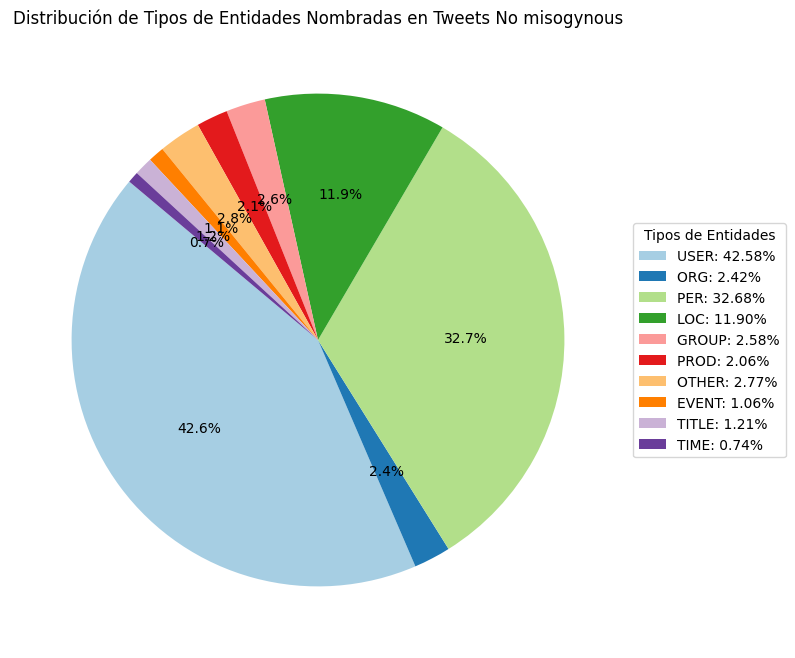

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(overall_entity_type_percentages_not_misogynous.values(), startangle=140, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
ax.set_title("Distribución de Tipos de Entidades Nombradas en Tweets No misogynous")
legend_labels = [f"{ent_type}: {percentage:.2f}%" for ent_type, percentage in overall_entity_type_percentages_not_misogynous.items()]
ax.legend(wedges, legend_labels, title="Tipos de Entidades", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

-----------------------------------------------

### Comparación entre tweets misogynous y no misogynous

-----------------------------------------------


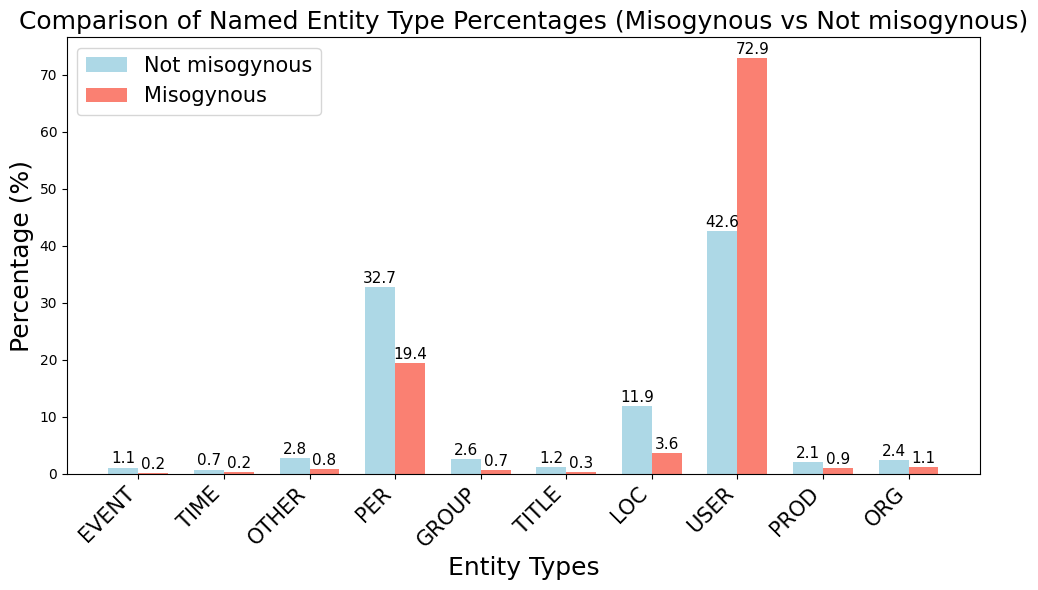

In [36]:
all_pos_tags = list(set(overall_entity_type_percentages_not_misogynous.keys()).union(set(overall_entity_type_percentages_misogynous.keys())))

not_misogynous_percentages = [overall_entity_type_percentages_not_misogynous.get(tag, 0) for tag in all_pos_tags]
misogynous_percentages = [overall_entity_type_percentages_misogynous.get(tag, 0) for tag in all_pos_tags]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(all_pos_tags))

bar1 = ax.bar(index - bar_width/2, not_misogynous_percentages, bar_width, label='Not misogynous', color='lightblue')
bar2 = ax.bar(index + bar_width/2, misogynous_percentages, bar_width, label='Misogynous', color='salmon')

for i, v in enumerate(not_misogynous_percentages):
  ax.text(index[i] - bar_width/2, v + 0.75, f'{v:.1f}', ha='center', fontsize=11, color='black')
for i, v in enumerate(misogynous_percentages):
  ax.text(index[i] + bar_width/2, v + 0.75, f'{v:.1f}', ha='center', fontsize=11, color='black')

ax.set_xlabel('Entity Types', fontsize=18)
ax.set_ylabel('Percentage (%)', fontsize=18)
ax.set_title('Comparison of Named Entity Type Percentages (Misogynous vs Not misogynous)', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(all_pos_tags, rotation=45, ha='right', fontsize=15)
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()